# teste 1

In [1]:
import sys
print(sys.executable)

/home/magda/tf-gpu-env/bin/python3.10


**Ver se está a usar a GPU**

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2025-06-27 08:24:03.294985: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-06-27 08:24:04.403269: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2851877993304034626
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2351693824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14351080480726335872
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2025-06-27 08:24:06.103751: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 08:24:06.211818: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 08:24:06.211875: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 08:24:06.378363: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 08:24:06.378479: I tensorflow/compile

**imports**

In [3]:
import os
# Ativa o alocador assíncrono (melhora fragmentação de memória)
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
import tensorflow as tf
# Ativa a alocação dinâmica de memória (não ocupa toda a memória no início)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Erro ao definir memory growth:", e)
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, 
                                     GlobalMaxPooling2D, Dense, Dropout, BatchNormalization, AveragePooling2D,
                                     Concatenate, Flatten, LayerNormalization, Multiply, Add, Activation, Reshape)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_auc_score

print("TensorFlow:", tf.__version__)
print("TensorFlow Addons:", tfa.__version__)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Matplotlib:", matplotlib.__version__)

2025-06-27 08:24:06.390403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 08:24:06.390507: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 08:24:06.390542: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
/home/magda/tf-gpu-env/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.


TensorFlow: 2.13.0
TensorFlow Addons: 0.21.0
NumPy: 1.23.5
Pandas: 1.5.3
Matplotlib: 3.7.1


## Arquitetura do Modelo:

In [4]:
def channel_attention(input_feature, reduction_ratio=8):
    channel = input_feature.shape[-1]

    shared_dense_one = Dense(channel // reduction_ratio, activation='relu', kernel_initializer='glorot_uniform')
    shared_dense_two = Dense(channel, activation='relu', kernel_initializer='glorot_uniform')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    max_pool = GlobalMaxPooling2D()(input_feature)

    avg_out = shared_dense_two(shared_dense_one(avg_pool))
    max_out = shared_dense_two(shared_dense_one(max_pool))

    cbam_feature = Add()([avg_out, max_out])
    cbam_feature = Activation('relu')(cbam_feature)
    cbam_feature = Reshape((1, 1, channel))(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

# Atenção espacial com layer norm, conv 7x7 e gating
def spatial_attention(input_feature):
    avg_pool = tf.reduce_mean(input_feature, axis=-1, keepdims=True)
    max_pool = tf.reduce_max(input_feature, axis=-1, keepdims=True)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    concat = LayerNormalization()(concat)

    conv = Conv2D(1, kernel_size=7, padding='same', activation='relu')(concat)
    gate = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')(concat)
    gated = Multiply()([conv, gate])

    return Multiply()([input_feature, gated])

# Bloco AHC: convoluções paralelas com pooling
def AHC_block(input_tensor):
    conv_3x3 = Conv2D(32, kernel_size=3, padding='same', activation='relu')(input_tensor)
    conv_5x5 = Conv2D(32, kernel_size=5, padding='same', activation='relu')(input_tensor)
    conv_7x7 = Conv2D(32, kernel_size=7, padding='same', activation='relu')(input_tensor)

    pool_3x3 = AveragePooling2D(pool_size=2, strides=1, padding='same')(conv_3x3)
    pool_5x5 = AveragePooling2D(pool_size=2, strides=1, padding='same')(conv_5x5)
    pool_7x7 = AveragePooling2D(pool_size=2, strides=1, padding='same')(conv_7x7)

    return Concatenate()([pool_3x3, pool_5x5, pool_7x7])

# Modelo completo AHMHCNN-mCBAM
def build_AHMHCNN_mCBAM(input_shape=(256, 256, 3), num_classes=2):
    inputs = Input(shape=input_shape)

    # MHCNN base convolucional
    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(48, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(64, kernel_size=5, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.02)(x)
    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.02)(x)

    # Bloco AHC
    x = AHC_block(x)

    # Bloco mCBAM
    x = channel_attention(x)
    x = spatial_attention(x)

    # Classificação
    x = Flatten()(x)
    x = Dense(56, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(48, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Criar o modelo
model = build_AHMHCNN_mCBAM()

2025-06-27 08:24:07.221775: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 08:24:07.221877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 08:24:07.221912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 08:24:07.222103: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 08:24:07.222115: I tensorflow/core/co

In [5]:
# Compilar o modelo
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
        tfa.metrics.F1Score(num_classes=2, average='macro')
    ]
)

In [6]:
# Mostrar resumo
model.summary()

Model: "model"


__________________________________________________________________________________________________


 Layer (type)                Output Shape                 Param #   Connected to                  


 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            


 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             


 max_pooling2d (MaxPooling2  (None, 128, 128, 32)         0         ['conv2d[0][0]']              


 D)                                                                                               


 conv2d_1 (Conv2D)           (None, 128, 128, 48)         13872     ['max_pooling2d[0][0]']       


 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 48)           0         ['conv2d_1[0][0]']            


 g2D)                                                                                             


 conv2d_2 (Conv2D)           (None, 64, 64, 64)           76864     ['max_pooling2d_1[0][0]']     


 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 64)           0         ['conv2d_2[0][0]']            


 g2D)                                                                                             


 dropout (Dropout)           (None, 32, 32, 64)           0         ['max_pooling2d_2[0][0]']     


 conv2d_3 (Conv2D)           (None, 32, 32, 32)           18464     ['dropout[0][0]']             


 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)           0         ['conv2d_3[0][0]']            


 g2D)                                                                                             


 batch_normalization (Batch  (None, 16, 16, 32)           128       ['max_pooling2d_3[0][0]']     


 Normalization)                                                                                   


 dropout_1 (Dropout)         (None, 16, 16, 32)           0         ['batch_normalization[0][0]'] 


 conv2d_4 (Conv2D)           (None, 16, 16, 32)           9248      ['dropout_1[0][0]']           


 conv2d_5 (Conv2D)           (None, 16, 16, 32)           25632     ['dropout_1[0][0]']           


 conv2d_6 (Conv2D)           (None, 16, 16, 32)           50208     ['dropout_1[0][0]']           


 average_pooling2d (Average  (None, 16, 16, 32)           0         ['conv2d_4[0][0]']            


 Pooling2D)                                                                                       


 average_pooling2d_1 (Avera  (None, 16, 16, 32)           0         ['conv2d_5[0][0]']            


 gePooling2D)                                                                                     


 average_pooling2d_2 (Avera  (None, 16, 16, 32)           0         ['conv2d_6[0][0]']            


 gePooling2D)                                                                                     


 concatenate (Concatenate)   (None, 16, 16, 96)           0         ['average_pooling2d[0][0]',   


                                                                     'average_pooling2d_1[0][0]', 


                                                                     'average_pooling2d_2[0][0]'] 


 global_average_pooling2d (  (None, 96)                   0         ['concatenate[0][0]']         


 GlobalAveragePooling2D)                                                                          


 global_max_pooling2d (Glob  (None, 96)                   0         ['concatenate[0][0]']         


 alMaxPooling2D)                                                                                  


 dense (Dense)               (None, 12)                   1164      ['global_average_pooling2d[0][


                                                                    0]',                          


                                                                     'global_max_pooling2d[0][0]']


 dense_1 (Dense)             (None, 96)                   1248      ['dense[0][0]',               


                                                                     'dense[1][0]']               


 add (Add)                   (None, 96)                   0         ['dense_1[0][0]',             


                                                                     'dense_1[1][0]']             


 activation (Activation)     (None, 96)                   0         ['add[0][0]']                 


 reshape (Reshape)           (None, 1, 1, 96)             0         ['activation[0][0]']          


 multiply (Multiply)         (None, 16, 16, 96)           0         ['concatenate[0][0]',         


                                                                     'reshape[0][0]']             


 tf.math.reduce_mean (TFOpL  (None, 16, 16, 1)            0         ['multiply[0][0]']            


 ambda)                                                                                           


 tf.math.reduce_max (TFOpLa  (None, 16, 16, 1)            0         ['multiply[0][0]']            


 mbda)                                                                                            


 concatenate_1 (Concatenate  (None, 16, 16, 2)            0         ['tf.math.reduce_mean[0][0]', 


 )                                                                   'tf.math.reduce_max[0][0]']  


 layer_normalization (Layer  (None, 16, 16, 2)            4         ['concatenate_1[0][0]']       


 Normalization)                                                                                   


 conv2d_7 (Conv2D)           (None, 16, 16, 1)            99        ['layer_normalization[0][0]'] 


 conv2d_8 (Conv2D)           (None, 16, 16, 1)            3         ['layer_normalization[0][0]'] 


 multiply_1 (Multiply)       (None, 16, 16, 1)            0         ['conv2d_7[0][0]',            


                                                                     'conv2d_8[0][0]']            


 multiply_2 (Multiply)       (None, 16, 16, 96)           0         ['multiply[0][0]',            


                                                                     'multiply_1[0][0]']          


 flatten (Flatten)           (None, 24576)                0         ['multiply_2[0][0]']          


 dense_2 (Dense)             (None, 56)                   1376312   ['flatten[0][0]']             


 batch_normalization_1 (Bat  (None, 56)                   224       ['dense_2[0][0]']             


 chNormalization)                                                                                 


 dense_3 (Dense)             (None, 48)                   2736      ['batch_normalization_1[0][0]'


                                                                    ]                             


 batch_normalization_2 (Bat  (None, 48)                   192       ['dense_3[0][0]']             


 chNormalization)                                                                                 


 dense_4 (Dense)             (None, 32)                   1568      ['batch_normalization_2[0][0]'


                                                                    ]                             


 batch_normalization_3 (Bat  (None, 32)                   128       ['dense_4[0][0]']             


 chNormalization)                                                                                 


 dense_5 (Dense)             (None, 2)                    66        ['batch_normalization_3[0][0]'


                                                                    ]                             


Total params: 1579056 (6.02 MB)


Trainable params: 1578720 (6.02 MB)


Non-trainable params: 336 (1.31 KB)


__________________________________________________________________________________________________


## Funções Auxiliares

Trata do pré-processamento das imagens, ou seja redimensiona para 224 X 224 pixels e normaliza [0,1] e coloca em one hot.

In [7]:
# Função auxiliar para carregar imagem
def preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    label = tf.one_hot(label, 2)
    return image, label

Permite analisar a distribuição dos datasets.

In [8]:
def inspect_dataset_distribution(dataset, name="dataset"):
    total_samples = 0
    label_counter = Counter()

    for images, labels in dataset:
        # labels vêm em one-hot: [0,1] ou [1,0]
        labels_np = labels.numpy()
        class_indices = labels_np.argmax(axis=1)  # <-- Corrigir: pegar o índice da classe correta
        total_samples += len(class_indices)
        label_counter.update(class_indices)

    print(f"📊 {name.upper()} -> Total de imagens: {total_samples}")
    for label, count in sorted(label_counter.items()):
        perc = (count / total_samples) * 100
        print(f"  Classe {int(label)} ({'Fogo' if label == 1 else 'Sem fogo'}): {count} imagens ({perc:.2f}%)")
    print("-" * 40)

Permite analisar o histórico de trino.

In [9]:
def plot_training_history(history):
    metrics = history.history.keys()
    epochs_range = range(len(history.history['loss']))

    for metric in metrics:
        if "val_" not in metric:
            plt.figure(figsize=(10, 5))
            plt.plot(epochs_range, history.history[metric], label=f"Train {metric}")
            if f"val_{metric}" in metrics:
                plt.plot(epochs_range, history.history[f"val_{metric}"], label=f"Val {metric}")
            plt.title(f"Training and Validation {metric.capitalize()}")
            plt.xlabel("Epochs")
            plt.ylabel(metric.capitalize())
            plt.legend()
            plt.grid(True)
            plt.show()

Usada para avaliar o modelo, ou seja, se está a prever corretamente a classificação das imagens.

In [10]:
def avaliar_modelo(model, dataset):
    # 1. Previsões e rótulos reais
    y_pred_probs = model.predict(dataset, verbose=0)
    y_true = np.concatenate([y for _, y in dataset], axis=0)
    y_true_int = np.argmax(y_true, axis=1)
    y_pred_int = (y_pred_probs[:, 1] > 0.5).astype(int)

    # 2. Contagem das classes
    TP = np.sum((y_true_int == 1) & (y_pred_int == 1))
    TN = np.sum((y_true_int == 0) & (y_pred_int == 0))
    FP = np.sum((y_true_int == 0) & (y_pred_int == 1))
    FN = np.sum((y_true_int == 1) & (y_pred_int == 0))

    total = TP + TN + FP + FN

    # 3. Cálculo das métricas com base nas fórmulas
    accuracy   = (TP + TN) / total if total > 0 else 0.0
    precision  = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall     = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1_score   = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    auc        = roc_auc_score(y_true_int, y_pred_probs[:, 1])

    # Binary crossentropy loss
    eps = 1e-7
    p = np.clip(y_pred_probs[:, 1], eps, 1 - eps)
    y = y_true_int
    loss = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

    # Métricas específicas de detecção de incêndio
    fdr = recall * 100  # ou (TP / (TP + FN)) * 100
    ewr = ((FP + FN) / total) * 100 if total > 0 else 0.0

    # 4. Impressão
    print("=== MÉTRICAS DE AVALIAÇÃO ===")
    print(f"TP={TP}, TN={TN}, FP={FP}, FN={FN}")
    print(f"Accuracy       : {accuracy:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"F1-Score       : {f1_score:.4f}")
    print(f"AUC            : {auc:.4f}")
    print(f"Binary Loss    : {loss:.4f}")
    print(f"FDR (Fire Detection Rate)      : {fdr:.2f} %")
    print(f"EWR (Error Warning Rate)       : {ewr:.2f} %")
    print("Confusion Matrix:")
    print(np.array([[TN, FP], [FN, TP]]))  # [[negativos reais], [positivos reais]]

    # 5. Retorno opcional
    return {
        'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'auc': auc,
        'loss': loss,
        'fdr': fdr,
        'ewr': ewr,
        'confusion_matrix': np.array([[TN, FP], [FN, TP]])
    }

## Treino

In [11]:
# Configurações gerais
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 16
EPOCHS = 50
SEED = 42

In [12]:
data = pd.read_csv("../Datasets_Mixed/mixed_1_train.csv")
image_paths = data['image_path'].values
labels = data['label_bi'].values

data = pd.read_csv("../Datasets_Mixed/mixed_1_test.csv")
image_paths_test = data['image_path'].values
labels_test = data['label_bi'].values

In [13]:
x_train, x_val, y_train, y_val = train_test_split(image_paths, labels, test_size=0.1, random_state=SEED, stratify=labels)

In [14]:
# Criar datasets TensorFlow
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess_image).shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((image_paths_test, labels_test))
test_ds = test_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [15]:
inspect_dataset_distribution(train_ds, name="train")
inspect_dataset_distribution(val_ds, name="val")
inspect_dataset_distribution(test_ds, name="test")

📊 TRAIN -> Total de imagens: 2957
  Classe 0 (Sem fogo): 1162 imagens (39.30%)
  Classe 1 (Fogo): 1795 imagens (60.70%)
----------------------------------------


📊 VAL -> Total de imagens: 329
  Classe 0 (Sem fogo): 129 imagens (39.21%)
  Classe 1 (Fogo): 200 imagens (60.79%)
----------------------------------------


📊 TEST -> Total de imagens: 19532
  Classe 0 (Sem fogo): 9748 imagens (49.91%)
  Classe 1 (Fogo): 9784 imagens (50.09%)
----------------------------------------


In [16]:
# Função do agendamento de learning rate conforme o estudo
def custom_lr_schedule(epoch, lr):
    if epoch < 15:
        return 1e-4
    elif epoch < 25:
        return 1e-5
    else:
        return 1e-6

# Callbacks combinados
callback = [
    ModelCheckpoint('test_1_best.h5', monitor='val_loss', save_best_only=True, verbose=1),
    LearningRateScheduler(custom_lr_schedule, verbose=1)
]

In [17]:
# Treinar
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callback
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.


Epoch 1/50


2025-06-27 08:24:29.318348: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2025-06-27 08:24:30.535207: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


2025-06-27 08:24:32.019637: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5de98f1c6000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-27 08:24:32.019683: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-06-27 08:24:32.086080: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


2025-06-27 08:24:32.375824: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/185 [..............................] - ETA: 35:43 - loss: 0.5933 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - auc: 0.7480 - f1_score: 0.7460

  2/185 [..............................] - ETA: 16s - loss: 0.7766 - accuracy: 0.6875 - precision: 0.6875 - recall: 0.6875 - auc: 0.6636 - f1_score: 0.6825  

  3/185 [..............................] - ETA: 16s - loss: 0.8437 - accuracy: 0.6667 - precision: 0.6667 - recall: 0.6667 - auc: 0.6304 - f1_score: 0.6661

  4/185 [..............................] - ETA: 16s - loss: 0.8622 - accuracy: 0.6406 - precision: 0.6406 - recall: 0.6406 - auc: 0.6237 - f1_score: 0.6363

  5/185 [..............................] - ETA: 16s - loss: 0.7862 - accuracy: 0.6625 - precision: 0.6625 - recall: 0.6625 - auc: 0.6680 - f1_score: 0.6620

  6/185 [..............................] - ETA: 16s - loss: 0.7279 - accuracy: 0.6875 - precision: 0.6875 - recall: 0.6875 - auc: 0.7060 - f1_score: 0.6870

  7/185 [>.............................] - ETA: 16s - loss: 0.7441 - accuracy: 0.6786 - precision: 0.6786 - recall: 0.6786 - auc: 0.6956 - f1_score: 0.6782

  8/185 [>.............................] - ETA: 16s - loss: 0.7782 - accuracy: 0.6641 - precision: 0.6641 - recall: 0.6641 - auc: 0.6765 - f1_score: 0.6631

  9/185 [>.............................] - ETA: 16s - loss: 0.7852 - accuracy: 0.6528 - precision: 0.6528 - recall: 0.6528 - auc: 0.6649 - f1_score: 0.6517

 10/185 [>.............................] - ETA: 16s - loss: 0.7570 - accuracy: 0.6562 - precision: 0.6562 - recall: 0.6562 - auc: 0.6813 - f1_score: 0.6546

 11/185 [>.............................] - ETA: 15s - loss: 0.7323 - accuracy: 0.6591 - precision: 0.6591 - recall: 0.6591 - auc: 0.6942 - f1_score: 0.6569

 12/185 [>.............................] - ETA: 15s - loss: 0.7214 - accuracy: 0.6615 - precision: 0.6615 - recall: 0.6615 - auc: 0.6996 - f1_score: 0.6599

 13/185 [=>............................] - ETA: 15s - loss: 0.7024 - accuracy: 0.6731 - precision: 0.6731 - recall: 0.6731 - auc: 0.7119 - f1_score: 0.6716

 14/185 [=>............................] - ETA: 15s - loss: 0.6742 - accuracy: 0.6875 - precision: 0.6875 - recall: 0.6875 - auc: 0.7315 - f1_score: 0.6866

 15/185 [=>............................] - ETA: 15s - loss: 0.6633 - accuracy: 0.6833 - precision: 0.6833 - recall: 0.6833 - auc: 0.7371 - f1_score: 0.6823

 16/185 [=>............................] - ETA: 15s - loss: 0.6648 - accuracy: 0.6758 - precision: 0.6758 - recall: 0.6758 - auc: 0.7327 - f1_score: 0.6747

 17/185 [=>............................] - ETA: 15s - loss: 0.6532 - accuracy: 0.6875 - precision: 0.6875 - recall: 0.6875 - auc: 0.7405 - f1_score: 0.6860

 18/185 [=>............................] - ETA: 15s - loss: 0.6392 - accuracy: 0.6979 - precision: 0.6979 - recall: 0.6979 - auc: 0.7497 - f1_score: 0.6969

 19/185 [==>...........................] - ETA: 15s - loss: 0.6316 - accuracy: 0.7007 - precision: 0.7007 - recall: 0.7007 - auc: 0.7543 - f1_score: 0.6997

 20/185 [==>...........................] - ETA: 15s - loss: 0.6356 - accuracy: 0.7031 - precision: 0.7031 - recall: 0.7031 - auc: 0.7515 - f1_score: 0.7018

 21/185 [==>...........................] - ETA: 14s - loss: 0.6328 - accuracy: 0.7054 - precision: 0.7054 - recall: 0.7054 - auc: 0.7526 - f1_score: 0.7040

 22/185 [==>...........................] - ETA: 14s - loss: 0.6254 - accuracy: 0.7102 - precision: 0.7102 - recall: 0.7102 - auc: 0.7581 - f1_score: 0.7091

 23/185 [==>...........................] - ETA: 14s - loss: 0.6318 - accuracy: 0.7011 - precision: 0.7011 - recall: 0.7011 - auc: 0.7530 - f1_score: 0.6996

 24/185 [==>...........................] - ETA: 14s - loss: 0.6286 - accuracy: 0.6979 - precision: 0.6979 - recall: 0.6979 - auc: 0.7546 - f1_score: 0.6963

 25/185 [===>..........................] - ETA: 14s - loss: 0.6165 - accuracy: 0.7050 - precision: 0.7050 - recall: 0.7050 - auc: 0.7634 - f1_score: 0.7035

 26/185 [===>..........................] - ETA: 14s - loss: 0.6106 - accuracy: 0.7091 - precision: 0.7091 - recall: 0.7091 - auc: 0.7679 - f1_score: 0.7075

 27/185 [===>..........................] - ETA: 14s - loss: 0.5957 - accuracy: 0.7199 - precision: 0.7199 - recall: 0.7199 - auc: 0.7789 - f1_score: 0.7186

 28/185 [===>..........................] - ETA: 14s - loss: 0.5925 - accuracy: 0.7210 - precision: 0.7210 - recall: 0.7210 - auc: 0.7809 - f1_score: 0.7200

 29/185 [===>..........................] - ETA: 14s - loss: 0.5894 - accuracy: 0.7241 - precision: 0.7241 - recall: 0.7241 - auc: 0.7832 - f1_score: 0.7228

 30/185 [===>..........................] - ETA: 14s - loss: 0.5824 - accuracy: 0.7271 - precision: 0.7271 - recall: 0.7271 - auc: 0.7880 - f1_score: 0.7255

 31/185 [====>.........................] - ETA: 14s - loss: 0.5802 - accuracy: 0.7278 - precision: 0.7278 - recall: 0.7278 - auc: 0.7895 - f1_score: 0.7261

 32/185 [====>.........................] - ETA: 13s - loss: 0.5819 - accuracy: 0.7246 - precision: 0.7246 - recall: 0.7246 - auc: 0.7877 - f1_score: 0.7228

 33/185 [====>.........................] - ETA: 13s - loss: 0.5800 - accuracy: 0.7216 - precision: 0.7216 - recall: 0.7216 - auc: 0.7883 - f1_score: 0.7196

 34/185 [====>.........................] - ETA: 13s - loss: 0.5761 - accuracy: 0.7243 - precision: 0.7243 - recall: 0.7243 - auc: 0.7908 - f1_score: 0.7224

 35/185 [====>.........................] - ETA: 13s - loss: 0.5773 - accuracy: 0.7196 - precision: 0.7196 - recall: 0.7196 - auc: 0.7889 - f1_score: 0.7178

 36/185 [====>.........................] - ETA: 13s - loss: 0.5750 - accuracy: 0.7205 - precision: 0.7205 - recall: 0.7205 - auc: 0.7902 - f1_score: 0.7184

 37/185 [=====>........................] - ETA: 13s - loss: 0.5800 - accuracy: 0.7179 - precision: 0.7179 - recall: 0.7179 - auc: 0.7859 - f1_score: 0.7154

 38/185 [=====>........................] - ETA: 13s - loss: 0.5708 - accuracy: 0.7253 - precision: 0.7253 - recall: 0.7253 - auc: 0.7929 - f1_score: 0.7227

 39/185 [=====>........................] - ETA: 13s - loss: 0.5691 - accuracy: 0.7244 - precision: 0.7244 - recall: 0.7244 - auc: 0.7938 - f1_score: 0.7220

 40/185 [=====>........................] - ETA: 13s - loss: 0.5693 - accuracy: 0.7234 - precision: 0.7234 - recall: 0.7234 - auc: 0.7930 - f1_score: 0.7207

 41/185 [=====>........................] - ETA: 13s - loss: 0.5700 - accuracy: 0.7226 - precision: 0.7226 - recall: 0.7226 - auc: 0.7919 - f1_score: 0.7194

 42/185 [=====>........................] - ETA: 13s - loss: 0.5616 - accuracy: 0.7277 - precision: 0.7277 - recall: 0.7277 - auc: 0.7982 - f1_score: 0.7246

 43/185 [=====>........................] - ETA: 12s - loss: 0.5617 - accuracy: 0.7267 - precision: 0.7267 - recall: 0.7267 - auc: 0.7975 - f1_score: 0.7235

 44/185 [======>.......................] - ETA: 12s - loss: 0.5613 - accuracy: 0.7287 - precision: 0.7287 - recall: 0.7287 - auc: 0.7977 - f1_score: 0.7259

 45/185 [======>.......................] - ETA: 12s - loss: 0.5578 - accuracy: 0.7292 - precision: 0.7292 - recall: 0.7292 - auc: 0.8001 - f1_score: 0.7262

 46/185 [======>.......................] - ETA: 12s - loss: 0.5557 - accuracy: 0.7296 - precision: 0.7296 - recall: 0.7296 - auc: 0.8014 - f1_score: 0.7266

 47/185 [======>.......................] - ETA: 12s - loss: 0.5596 - accuracy: 0.7287 - precision: 0.7287 - recall: 0.7287 - auc: 0.7988 - f1_score: 0.7261

 48/185 [======>.......................] - ETA: 12s - loss: 0.5575 - accuracy: 0.7292 - precision: 0.7292 - recall: 0.7292 - auc: 0.8003 - f1_score: 0.7265

 49/185 [======>.......................] - ETA: 12s - loss: 0.5634 - accuracy: 0.7270 - precision: 0.7270 - recall: 0.7270 - auc: 0.7958 - f1_score: 0.7243

 50/185 [=======>......................] - ETA: 12s - loss: 0.5586 - accuracy: 0.7312 - precision: 0.7312 - recall: 0.7312 - auc: 0.7994 - f1_score: 0.7283

 51/185 [=======>......................] - ETA: 12s - loss: 0.5582 - accuracy: 0.7304 - precision: 0.7304 - recall: 0.7304 - auc: 0.7993 - f1_score: 0.7274

 52/185 [=======>......................] - ETA: 12s - loss: 0.5586 - accuracy: 0.7308 - precision: 0.7308 - recall: 0.7308 - auc: 0.7988 - f1_score: 0.7279

 53/185 [=======>......................] - ETA: 12s - loss: 0.5570 - accuracy: 0.7311 - precision: 0.7311 - recall: 0.7311 - auc: 0.7998 - f1_score: 0.7282

 54/185 [=======>......................] - ETA: 11s - loss: 0.5514 - accuracy: 0.7361 - precision: 0.7361 - recall: 0.7361 - auc: 0.8040 - f1_score: 0.7332

 55/185 [=======>......................] - ETA: 11s - loss: 0.5489 - accuracy: 0.7386 - precision: 0.7386 - recall: 0.7386 - auc: 0.8064 - f1_score: 0.7359

 56/185 [========>.....................] - ETA: 11s - loss: 0.5465 - accuracy: 0.7422 - precision: 0.7422 - recall: 0.7422 - auc: 0.8082 - f1_score: 0.7393

 57/185 [========>.....................] - ETA: 11s - loss: 0.5428 - accuracy: 0.7456 - precision: 0.7456 - recall: 0.7456 - auc: 0.8109 - f1_score: 0.7428

 58/185 [========>.....................] - ETA: 11s - loss: 0.5406 - accuracy: 0.7457 - precision: 0.7457 - recall: 0.7457 - auc: 0.8123 - f1_score: 0.7429

 59/185 [========>.....................] - ETA: 11s - loss: 0.5382 - accuracy: 0.7479 - precision: 0.7479 - recall: 0.7479 - auc: 0.8140 - f1_score: 0.7451

 60/185 [========>.....................] - ETA: 11s - loss: 0.5380 - accuracy: 0.7490 - precision: 0.7490 - recall: 0.7490 - auc: 0.8143 - f1_score: 0.7460

 61/185 [========>.....................] - ETA: 11s - loss: 0.5358 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - auc: 0.8158 - f1_score: 0.7472

 62/185 [=========>....................] - ETA: 11s - loss: 0.5328 - accuracy: 0.7530 - precision: 0.7530 - recall: 0.7530 - auc: 0.8180 - f1_score: 0.7503

 63/185 [=========>....................] - ETA: 11s - loss: 0.5322 - accuracy: 0.7520 - precision: 0.7520 - recall: 0.7520 - auc: 0.8183 - f1_score: 0.7493

 64/185 [=========>....................] - ETA: 11s - loss: 0.5273 - accuracy: 0.7559 - precision: 0.7559 - recall: 0.7559 - auc: 0.8219 - f1_score: 0.7531

 65/185 [=========>....................] - ETA: 10s - loss: 0.5252 - accuracy: 0.7587 - precision: 0.7587 - recall: 0.7587 - auc: 0.8235 - f1_score: 0.7559

 66/185 [=========>....................] - ETA: 10s - loss: 0.5259 - accuracy: 0.7557 - precision: 0.7557 - recall: 0.7557 - auc: 0.8225 - f1_score: 0.7527

 67/185 [=========>....................] - ETA: 10s - loss: 0.5252 - accuracy: 0.7556 - precision: 0.7556 - recall: 0.7556 - auc: 0.8229 - f1_score: 0.7527

 68/185 [==========>...................] - ETA: 10s - loss: 0.5200 - accuracy: 0.7583 - precision: 0.7583 - recall: 0.7583 - auc: 0.8265 - f1_score: 0.7555

 69/185 [==========>...................] - ETA: 10s - loss: 0.5186 - accuracy: 0.7600 - precision: 0.7600 - recall: 0.7600 - auc: 0.8275 - f1_score: 0.7573

 70/185 [==========>...................] - ETA: 10s - loss: 0.5156 - accuracy: 0.7616 - precision: 0.7616 - recall: 0.7616 - auc: 0.8297 - f1_score: 0.7589

 71/185 [==========>...................] - ETA: 10s - loss: 0.5128 - accuracy: 0.7641 - precision: 0.7641 - recall: 0.7641 - auc: 0.8318 - f1_score: 0.7612

 72/185 [==========>...................] - ETA: 10s - loss: 0.5164 - accuracy: 0.7630 - precision: 0.7630 - recall: 0.7630 - auc: 0.8300 - f1_score: 0.7599

 73/185 [==========>...................] - ETA: 10s - loss: 0.5146 - accuracy: 0.7646 - precision: 0.7646 - recall: 0.7646 - auc: 0.8312 - f1_score: 0.7615

 74/185 [===========>..................] - ETA: 10s - loss: 0.5145 - accuracy: 0.7660 - precision: 0.7660 - recall: 0.7660 - auc: 0.8315 - f1_score: 0.7628

 75/185 [===========>..................] - ETA: 10s - loss: 0.5166 - accuracy: 0.7633 - precision: 0.7633 - recall: 0.7633 - auc: 0.8296 - f1_score: 0.7599

 76/185 [===========>..................] - ETA: 9s - loss: 0.5129 - accuracy: 0.7648 - precision: 0.7648 - recall: 0.7648 - auc: 0.8321 - f1_score: 0.7613 

 77/185 [===========>..................] - ETA: 9s - loss: 0.5093 - accuracy: 0.7679 - precision: 0.7679 - recall: 0.7679 - auc: 0.8348 - f1_score: 0.7644

 78/185 [===========>..................] - ETA: 9s - loss: 0.5067 - accuracy: 0.7700 - precision: 0.7700 - recall: 0.7700 - auc: 0.8366 - f1_score: 0.7665

 79/185 [===========>..................] - ETA: 9s - loss: 0.5031 - accuracy: 0.7714 - precision: 0.7714 - recall: 0.7714 - auc: 0.8391 - f1_score: 0.7681

 80/185 [===========>..................] - ETA: 9s - loss: 0.5037 - accuracy: 0.7695 - precision: 0.7695 - recall: 0.7695 - auc: 0.8385 - f1_score: 0.7662

 81/185 [============>.................] - ETA: 9s - loss: 0.5056 - accuracy: 0.7677 - precision: 0.7677 - recall: 0.7677 - auc: 0.8368 - f1_score: 0.7642

 82/185 [============>.................] - ETA: 9s - loss: 0.5022 - accuracy: 0.7698 - precision: 0.7698 - recall: 0.7698 - auc: 0.8392 - f1_score: 0.7662

 83/185 [============>.................] - ETA: 9s - loss: 0.5031 - accuracy: 0.7696 - precision: 0.7696 - recall: 0.7696 - auc: 0.8385 - f1_score: 0.7658

 84/185 [============>.................] - ETA: 9s - loss: 0.5019 - accuracy: 0.7716 - precision: 0.7716 - recall: 0.7716 - auc: 0.8397 - f1_score: 0.7678

 85/185 [============>.................] - ETA: 9s - loss: 0.5025 - accuracy: 0.7728 - precision: 0.7728 - recall: 0.7728 - auc: 0.8396 - f1_score: 0.7691

 86/185 [============>.................] - ETA: 9s - loss: 0.5007 - accuracy: 0.7733 - precision: 0.7733 - recall: 0.7733 - auc: 0.8407 - f1_score: 0.7696

 87/185 [=============>................] - ETA: 8s - loss: 0.4992 - accuracy: 0.7744 - precision: 0.7744 - recall: 0.7744 - auc: 0.8417 - f1_score: 0.7706

 88/185 [=============>................] - ETA: 8s - loss: 0.5016 - accuracy: 0.7720 - precision: 0.7720 - recall: 0.7720 - auc: 0.8398 - f1_score: 0.7680

 89/185 [=============>................] - ETA: 8s - loss: 0.4990 - accuracy: 0.7739 - precision: 0.7739 - recall: 0.7739 - auc: 0.8416 - f1_score: 0.7699

 90/185 [=============>................] - ETA: 8s - loss: 0.4972 - accuracy: 0.7757 - precision: 0.7757 - recall: 0.7757 - auc: 0.8429 - f1_score: 0.7718

 91/185 [=============>................] - ETA: 8s - loss: 0.4954 - accuracy: 0.7768 - precision: 0.7768 - recall: 0.7768 - auc: 0.8441 - f1_score: 0.7728

 92/185 [=============>................] - ETA: 8s - loss: 0.4960 - accuracy: 0.7758 - precision: 0.7758 - recall: 0.7758 - auc: 0.8437 - f1_score: 0.7718

 93/185 [==============>...............] - ETA: 8s - loss: 0.4935 - accuracy: 0.7769 - precision: 0.7769 - recall: 0.7769 - auc: 0.8453 - f1_score: 0.7728

 94/185 [==============>...............] - ETA: 8s - loss: 0.4923 - accuracy: 0.7773 - precision: 0.7773 - recall: 0.7773 - auc: 0.8461 - f1_score: 0.7734

 95/185 [==============>...............] - ETA: 8s - loss: 0.4906 - accuracy: 0.7783 - precision: 0.7783 - recall: 0.7783 - auc: 0.8473 - f1_score: 0.7743

 96/185 [==============>...............] - ETA: 8s - loss: 0.4881 - accuracy: 0.7793 - precision: 0.7793 - recall: 0.7793 - auc: 0.8490 - f1_score: 0.7753

 97/185 [==============>...............] - ETA: 8s - loss: 0.4884 - accuracy: 0.7796 - precision: 0.7796 - recall: 0.7796 - auc: 0.8488 - f1_score: 0.7755

 98/185 [==============>...............] - ETA: 7s - loss: 0.4866 - accuracy: 0.7800 - precision: 0.7800 - recall: 0.7800 - auc: 0.8499 - f1_score: 0.7759

 99/185 [===============>..............] - ETA: 7s - loss: 0.4854 - accuracy: 0.7797 - precision: 0.7797 - recall: 0.7797 - auc: 0.8507 - f1_score: 0.7755

100/185 [===============>..............] - ETA: 7s - loss: 0.4857 - accuracy: 0.7794 - precision: 0.7794 - recall: 0.7794 - auc: 0.8504 - f1_score: 0.7751

101/185 [===============>..............] - ETA: 7s - loss: 0.4853 - accuracy: 0.7803 - precision: 0.7803 - recall: 0.7803 - auc: 0.8506 - f1_score: 0.7759

102/185 [===============>..............] - ETA: 7s - loss: 0.4824 - accuracy: 0.7812 - precision: 0.7812 - recall: 0.7812 - auc: 0.8525 - f1_score: 0.7769

103/185 [===============>..............] - ETA: 7s - loss: 0.4811 - accuracy: 0.7822 - precision: 0.7822 - recall: 0.7822 - auc: 0.8533 - f1_score: 0.7777

104/185 [===============>..............] - ETA: 7s - loss: 0.4784 - accuracy: 0.7831 - precision: 0.7831 - recall: 0.7831 - auc: 0.8550 - f1_score: 0.7786

105/185 [================>.............] - ETA: 7s - loss: 0.4764 - accuracy: 0.7839 - precision: 0.7839 - recall: 0.7839 - auc: 0.8563 - f1_score: 0.7795

106/185 [================>.............] - ETA: 7s - loss: 0.4765 - accuracy: 0.7848 - precision: 0.7848 - recall: 0.7848 - auc: 0.8564 - f1_score: 0.7804

107/185 [================>.............] - ETA: 7s - loss: 0.4742 - accuracy: 0.7862 - precision: 0.7862 - recall: 0.7862 - auc: 0.8578 - f1_score: 0.7820

108/185 [================>.............] - ETA: 7s - loss: 0.4733 - accuracy: 0.7870 - precision: 0.7870 - recall: 0.7870 - auc: 0.8585 - f1_score: 0.7828

109/185 [================>.............] - ETA: 6s - loss: 0.4712 - accuracy: 0.7890 - precision: 0.7890 - recall: 0.7890 - auc: 0.8599 - f1_score: 0.7846

110/185 [================>.............] - ETA: 6s - loss: 0.4714 - accuracy: 0.7881 - precision: 0.7881 - recall: 0.7881 - auc: 0.8597 - f1_score: 0.7836

111/185 [=================>............] - ETA: 6s - loss: 0.4692 - accuracy: 0.7900 - precision: 0.7900 - recall: 0.7900 - auc: 0.8612 - f1_score: 0.7854

112/185 [=================>............] - ETA: 6s - loss: 0.4682 - accuracy: 0.7907 - precision: 0.7907 - recall: 0.7907 - auc: 0.8619 - f1_score: 0.7861

113/185 [=================>............] - ETA: 6s - loss: 0.4672 - accuracy: 0.7915 - precision: 0.7915 - recall: 0.7915 - auc: 0.8625 - f1_score: 0.7870

114/185 [=================>............] - ETA: 6s - loss: 0.4676 - accuracy: 0.7906 - precision: 0.7906 - recall: 0.7906 - auc: 0.8622 - f1_score: 0.7860

115/185 [=================>............] - ETA: 6s - loss: 0.4655 - accuracy: 0.7913 - precision: 0.7913 - recall: 0.7913 - auc: 0.8635 - f1_score: 0.7868

116/185 [=================>............] - ETA: 6s - loss: 0.4643 - accuracy: 0.7920 - precision: 0.7920 - recall: 0.7920 - auc: 0.8642 - f1_score: 0.7876

117/185 [=================>............] - ETA: 6s - loss: 0.4631 - accuracy: 0.7933 - precision: 0.7933 - recall: 0.7933 - auc: 0.8651 - f1_score: 0.7887

118/185 [==================>...........] - ETA: 6s - loss: 0.4609 - accuracy: 0.7950 - precision: 0.7950 - recall: 0.7950 - auc: 0.8665 - f1_score: 0.7904

119/185 [==================>...........] - ETA: 6s - loss: 0.4586 - accuracy: 0.7962 - precision: 0.7962 - recall: 0.7962 - auc: 0.8680 - f1_score: 0.7917

120/185 [==================>...........] - ETA: 5s - loss: 0.4577 - accuracy: 0.7969 - precision: 0.7969 - recall: 0.7969 - auc: 0.8686 - f1_score: 0.7924

121/185 [==================>...........] - ETA: 5s - loss: 0.4569 - accuracy: 0.7975 - precision: 0.7975 - recall: 0.7975 - auc: 0.8690 - f1_score: 0.7930

122/185 [==================>...........] - ETA: 5s - loss: 0.4577 - accuracy: 0.7966 - precision: 0.7966 - recall: 0.7966 - auc: 0.8684 - f1_score: 0.7920

123/185 [==================>...........] - ETA: 5s - loss: 0.4580 - accuracy: 0.7967 - precision: 0.7967 - recall: 0.7967 - auc: 0.8681 - f1_score: 0.7920

124/185 [===================>..........] - ETA: 5s - loss: 0.4565 - accuracy: 0.7974 - precision: 0.7974 - recall: 0.7974 - auc: 0.8691 - f1_score: 0.7927

125/185 [===================>..........] - ETA: 5s - loss: 0.4549 - accuracy: 0.7980 - precision: 0.7980 - recall: 0.7980 - auc: 0.8701 - f1_score: 0.7933

126/185 [===================>..........] - ETA: 5s - loss: 0.4536 - accuracy: 0.7986 - precision: 0.7986 - recall: 0.7986 - auc: 0.8709 - f1_score: 0.7938

127/185 [===================>..........] - ETA: 5s - loss: 0.4522 - accuracy: 0.7997 - precision: 0.7997 - recall: 0.7997 - auc: 0.8719 - f1_score: 0.7948

128/185 [===================>..........] - ETA: 5s - loss: 0.4501 - accuracy: 0.8013 - precision: 0.8013 - recall: 0.8013 - auc: 0.8732 - f1_score: 0.7965

129/185 [===================>..........] - ETA: 5s - loss: 0.4485 - accuracy: 0.8023 - precision: 0.8023 - recall: 0.8023 - auc: 0.8742 - f1_score: 0.7976

130/185 [====================>.........] - ETA: 5s - loss: 0.4467 - accuracy: 0.8029 - precision: 0.8029 - recall: 0.8029 - auc: 0.8753 - f1_score: 0.7982

131/185 [====================>.........] - ETA: 4s - loss: 0.4466 - accuracy: 0.8034 - precision: 0.8034 - recall: 0.8034 - auc: 0.8754 - f1_score: 0.7987

132/185 [====================>.........] - ETA: 4s - loss: 0.4454 - accuracy: 0.8045 - precision: 0.8045 - recall: 0.8045 - auc: 0.8762 - f1_score: 0.7997

133/185 [====================>.........] - ETA: 4s - loss: 0.4449 - accuracy: 0.8050 - precision: 0.8050 - recall: 0.8050 - auc: 0.8764 - f1_score: 0.8002

134/185 [====================>.........] - ETA: 4s - loss: 0.4437 - accuracy: 0.8055 - precision: 0.8055 - recall: 0.8055 - auc: 0.8772 - f1_score: 0.8007

135/185 [====================>.........] - ETA: 4s - loss: 0.4425 - accuracy: 0.8060 - precision: 0.8060 - recall: 0.8060 - auc: 0.8778 - f1_score: 0.8012

136/185 [=====================>........] - ETA: 4s - loss: 0.4408 - accuracy: 0.8074 - precision: 0.8074 - recall: 0.8074 - auc: 0.8789 - f1_score: 0.8027

137/185 [=====================>........] - ETA: 4s - loss: 0.4408 - accuracy: 0.8075 - precision: 0.8075 - recall: 0.8075 - auc: 0.8789 - f1_score: 0.8026

138/185 [=====================>........] - ETA: 4s - loss: 0.4402 - accuracy: 0.8075 - precision: 0.8075 - recall: 0.8075 - auc: 0.8792 - f1_score: 0.8027

139/185 [=====================>........] - ETA: 4s - loss: 0.4406 - accuracy: 0.8071 - precision: 0.8071 - recall: 0.8071 - auc: 0.8789 - f1_score: 0.8022

140/185 [=====================>........] - ETA: 4s - loss: 0.4390 - accuracy: 0.8076 - precision: 0.8076 - recall: 0.8076 - auc: 0.8799 - f1_score: 0.8026

141/185 [=====================>........] - ETA: 4s - loss: 0.4380 - accuracy: 0.8076 - precision: 0.8076 - recall: 0.8076 - auc: 0.8805 - f1_score: 0.8028

142/185 [======================>.......] - ETA: 3s - loss: 0.4374 - accuracy: 0.8081 - precision: 0.8081 - recall: 0.8081 - auc: 0.8808 - f1_score: 0.8032

143/185 [======================>.......] - ETA: 3s - loss: 0.4365 - accuracy: 0.8090 - precision: 0.8090 - recall: 0.8090 - auc: 0.8814 - f1_score: 0.8040

144/185 [======================>.......] - ETA: 3s - loss: 0.4353 - accuracy: 0.8099 - precision: 0.8099 - recall: 0.8099 - auc: 0.8822 - f1_score: 0.8048

145/185 [======================>.......] - ETA: 3s - loss: 0.4339 - accuracy: 0.8108 - precision: 0.8108 - recall: 0.8108 - auc: 0.8831 - f1_score: 0.8057

146/185 [======================>.......] - ETA: 3s - loss: 0.4349 - accuracy: 0.8108 - precision: 0.8108 - recall: 0.8108 - auc: 0.8826 - f1_score: 0.8056

147/185 [======================>.......] - ETA: 3s - loss: 0.4347 - accuracy: 0.8108 - precision: 0.8108 - recall: 0.8108 - auc: 0.8826 - f1_score: 0.8056

148/185 [=======================>......] - ETA: 3s - loss: 0.4354 - accuracy: 0.8108 - precision: 0.8108 - recall: 0.8108 - auc: 0.8822 - f1_score: 0.8055

149/185 [=======================>......] - ETA: 3s - loss: 0.4355 - accuracy: 0.8112 - precision: 0.8112 - recall: 0.8112 - auc: 0.8821 - f1_score: 0.8058

150/185 [=======================>......] - ETA: 3s - loss: 0.4353 - accuracy: 0.8117 - precision: 0.8117 - recall: 0.8117 - auc: 0.8823 - f1_score: 0.8063

151/185 [=======================>......] - ETA: 3s - loss: 0.4333 - accuracy: 0.8129 - precision: 0.8129 - recall: 0.8129 - auc: 0.8835 - f1_score: 0.8075

152/185 [=======================>......] - ETA: 3s - loss: 0.4316 - accuracy: 0.8137 - precision: 0.8137 - recall: 0.8137 - auc: 0.8845 - f1_score: 0.8084

153/185 [=======================>......] - ETA: 2s - loss: 0.4306 - accuracy: 0.8145 - precision: 0.8145 - recall: 0.8145 - auc: 0.8852 - f1_score: 0.8091

154/185 [=======================>......] - ETA: 2s - loss: 0.4303 - accuracy: 0.8145 - precision: 0.8145 - recall: 0.8145 - auc: 0.8853 - f1_score: 0.8091

155/185 [========================>.....] - ETA: 2s - loss: 0.4294 - accuracy: 0.8149 - precision: 0.8149 - recall: 0.8149 - auc: 0.8859 - f1_score: 0.8095

156/185 [========================>.....] - ETA: 2s - loss: 0.4278 - accuracy: 0.8157 - precision: 0.8157 - recall: 0.8157 - auc: 0.8868 - f1_score: 0.8103

157/185 [========================>.....] - ETA: 2s - loss: 0.4265 - accuracy: 0.8161 - precision: 0.8161 - recall: 0.8161 - auc: 0.8875 - f1_score: 0.8107

158/185 [========================>.....] - ETA: 2s - loss: 0.4256 - accuracy: 0.8165 - precision: 0.8165 - recall: 0.8165 - auc: 0.8879 - f1_score: 0.8111

159/185 [========================>.....] - ETA: 2s - loss: 0.4255 - accuracy: 0.8160 - precision: 0.8160 - recall: 0.8160 - auc: 0.8879 - f1_score: 0.8107

160/185 [========================>.....] - ETA: 2s - loss: 0.4247 - accuracy: 0.8164 - precision: 0.8164 - recall: 0.8164 - auc: 0.8884 - f1_score: 0.8111

161/185 [=========================>....] - ETA: 2s - loss: 0.4248 - accuracy: 0.8164 - precision: 0.8164 - recall: 0.8164 - auc: 0.8883 - f1_score: 0.8112

162/185 [=========================>....] - ETA: 2s - loss: 0.4240 - accuracy: 0.8171 - precision: 0.8171 - recall: 0.8171 - auc: 0.8887 - f1_score: 0.8120

163/185 [=========================>....] - ETA: 2s - loss: 0.4226 - accuracy: 0.8183 - precision: 0.8183 - recall: 0.8183 - auc: 0.8896 - f1_score: 0.8131

164/185 [=========================>....] - ETA: 1s - loss: 0.4218 - accuracy: 0.8190 - precision: 0.8190 - recall: 0.8190 - auc: 0.8900 - f1_score: 0.8139

165/185 [=========================>....] - ETA: 1s - loss: 0.4219 - accuracy: 0.8193 - precision: 0.8193 - recall: 0.8193 - auc: 0.8900 - f1_score: 0.8142

166/185 [=========================>....] - ETA: 1s - loss: 0.4203 - accuracy: 0.8204 - precision: 0.8204 - recall: 0.8204 - auc: 0.8909 - f1_score: 0.8153

167/185 [==========================>...] - ETA: 1s - loss: 0.4189 - accuracy: 0.8211 - precision: 0.8211 - recall: 0.8211 - auc: 0.8917 - f1_score: 0.8161

168/185 [==========================>...] - ETA: 1s - loss: 0.4173 - accuracy: 0.8222 - precision: 0.8222 - recall: 0.8222 - auc: 0.8926 - f1_score: 0.8172

169/185 [==========================>...] - ETA: 1s - loss: 0.4162 - accuracy: 0.8229 - precision: 0.8229 - recall: 0.8229 - auc: 0.8932 - f1_score: 0.8178

170/185 [==========================>...] - ETA: 1s - loss: 0.4157 - accuracy: 0.8232 - precision: 0.8232 - recall: 0.8232 - auc: 0.8935 - f1_score: 0.8183

171/185 [==========================>...] - ETA: 1s - loss: 0.4142 - accuracy: 0.8242 - precision: 0.8242 - recall: 0.8242 - auc: 0.8943 - f1_score: 0.8194

172/185 [==========================>...] - ETA: 1s - loss: 0.4130 - accuracy: 0.8252 - precision: 0.8252 - recall: 0.8252 - auc: 0.8950 - f1_score: 0.8204

173/185 [===========================>..] - ETA: 1s - loss: 0.4122 - accuracy: 0.8259 - precision: 0.8259 - recall: 0.8259 - auc: 0.8955 - f1_score: 0.8211

174/185 [===========================>..] - ETA: 1s - loss: 0.4134 - accuracy: 0.8251 - precision: 0.8251 - recall: 0.8251 - auc: 0.8948 - f1_score: 0.8202

175/185 [===========================>..] - ETA: 0s - loss: 0.4130 - accuracy: 0.8254 - precision: 0.8254 - recall: 0.8254 - auc: 0.8949 - f1_score: 0.8205

176/185 [===========================>..] - ETA: 0s - loss: 0.4122 - accuracy: 0.8253 - precision: 0.8253 - recall: 0.8253 - auc: 0.8953 - f1_score: 0.8205

177/185 [===========================>..] - ETA: 0s - loss: 0.4109 - accuracy: 0.8259 - precision: 0.8259 - recall: 0.8259 - auc: 0.8960 - f1_score: 0.8211

178/185 [===========================>..] - ETA: 0s - loss: 0.4096 - accuracy: 0.8269 - precision: 0.8269 - recall: 0.8269 - auc: 0.8968 - f1_score: 0.8221

179/185 [============================>.] - ETA: 0s - loss: 0.4086 - accuracy: 0.8275 - precision: 0.8275 - recall: 0.8275 - auc: 0.8973 - f1_score: 0.8229

180/185 [============================>.] - ETA: 0s - loss: 0.4082 - accuracy: 0.8281 - precision: 0.8281 - recall: 0.8281 - auc: 0.8976 - f1_score: 0.8236

181/185 [============================>.] - ETA: 0s - loss: 0.4074 - accuracy: 0.8287 - precision: 0.8287 - recall: 0.8287 - auc: 0.8980 - f1_score: 0.8242

182/185 [============================>.] - ETA: 0s - loss: 0.4075 - accuracy: 0.8286 - precision: 0.8286 - recall: 0.8286 - auc: 0.8979 - f1_score: 0.8241

183/185 [============================>.] - ETA: 0s - loss: 0.4065 - accuracy: 0.8292 - precision: 0.8292 - recall: 0.8292 - auc: 0.8984 - f1_score: 0.8246

184/185 [============================>.] - ETA: 0s - loss: 0.4063 - accuracy: 0.8291 - precision: 0.8291 - recall: 0.8291 - auc: 0.8985 - f1_score: 0.8245

185/185 [==============================] - ETA: 0s - loss: 0.4054 - accuracy: 0.8299 - precision: 0.8299 - recall: 0.8299 - auc: 0.8990 - f1_score: 0.8251


Epoch 1: val_loss improved from inf to 0.78066, saving model to test_1_best.h5


185/185 [==============================] - 33s 114ms/step - loss: 0.4054 - accuracy: 0.8299 - precision: 0.8299 - recall: 0.8299 - auc: 0.8990 - f1_score: 0.8251 - val_loss: 0.7807 - val_accuracy: 0.3921 - val_precision: 0.3921 - val_recall: 0.3921 - val_auc: 0.3921 - val_f1_score: 0.2817 - lr: 1.0000e-04



Epoch 2: LearningRateScheduler setting learning rate to 0.0001.


Epoch 2/50


/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  1/185 [..............................] - ETA: 2:37 - loss: 0.2117 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9805 - f1_score: 0.9307

  2/185 [..............................] - ETA: 16s - loss: 0.2781 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9492 - f1_score: 0.9307 

  3/185 [..............................] - ETA: 16s - loss: 0.2183 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9679 - f1_score: 0.9556

  4/185 [..............................] - ETA: 16s - loss: 0.2133 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9717 - f1_score: 0.9352

  5/185 [..............................] - ETA: 16s - loss: 0.3912 - accuracy: 0.8375 - precision: 0.8375 - recall: 0.8375 - auc: 0.9076 - f1_score: 0.8278

  6/185 [..............................] - ETA: 16s - loss: 0.3713 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9152 - f1_score: 0.8324

  7/185 [>.............................] - ETA: 16s - loss: 0.3477 - accuracy: 0.8571 - precision: 0.8571 - recall: 0.8571 - auc: 0.9261 - f1_score: 0.8476

  8/185 [>.............................] - ETA: 16s - loss: 0.3257 - accuracy: 0.8594 - precision: 0.8594 - recall: 0.8594 - auc: 0.9352 - f1_score: 0.8512

  9/185 [>.............................] - ETA: 16s - loss: 0.3322 - accuracy: 0.8542 - precision: 0.8542 - recall: 0.8542 - auc: 0.9324 - f1_score: 0.8450

 10/185 [>.............................] - ETA: 16s - loss: 0.3278 - accuracy: 0.8562 - precision: 0.8562 - recall: 0.8562 - auc: 0.9341 - f1_score: 0.8490

 11/185 [>.............................] - ETA: 15s - loss: 0.3171 - accuracy: 0.8636 - precision: 0.8636 - recall: 0.8636 - auc: 0.9387 - f1_score: 0.8577

 12/185 [>.............................] - ETA: 15s - loss: 0.3005 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9452 - f1_score: 0.8693

 13/185 [=>............................] - ETA: 15s - loss: 0.3091 - accuracy: 0.8654 - precision: 0.8654 - recall: 0.8654 - auc: 0.9423 - f1_score: 0.8585

 14/185 [=>............................] - ETA: 15s - loss: 0.2965 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9473 - f1_score: 0.8679

 15/185 [=>............................] - ETA: 15s - loss: 0.2843 - accuracy: 0.8833 - precision: 0.8833 - recall: 0.8833 - auc: 0.9517 - f1_score: 0.8771

 16/185 [=>............................] - ETA: 15s - loss: 0.2927 - accuracy: 0.8828 - precision: 0.8828 - recall: 0.8828 - auc: 0.9479 - f1_score: 0.8778

 17/185 [=>............................] - ETA: 15s - loss: 0.2893 - accuracy: 0.8824 - precision: 0.8824 - recall: 0.8824 - auc: 0.9494 - f1_score: 0.8779

 18/185 [=>............................] - ETA: 15s - loss: 0.2913 - accuracy: 0.8785 - precision: 0.8785 - recall: 0.8785 - auc: 0.9490 - f1_score: 0.8735

 19/185 [==>...........................] - ETA: 15s - loss: 0.2837 - accuracy: 0.8816 - precision: 0.8816 - recall: 0.8816 - auc: 0.9516 - f1_score: 0.8768

 20/185 [==>...........................] - ETA: 15s - loss: 0.2860 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9510 - f1_score: 0.8698

 21/185 [==>...........................] - ETA: 14s - loss: 0.2850 - accuracy: 0.8780 - precision: 0.8780 - recall: 0.8780 - auc: 0.9516 - f1_score: 0.8741

 22/185 [==>...........................] - ETA: 14s - loss: 0.2890 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9503 - f1_score: 0.8704

 23/185 [==>...........................] - ETA: 14s - loss: 0.2824 - accuracy: 0.8777 - precision: 0.8777 - recall: 0.8777 - auc: 0.9528 - f1_score: 0.8735

 24/185 [==>...........................] - ETA: 14s - loss: 0.2790 - accuracy: 0.8802 - precision: 0.8802 - recall: 0.8802 - auc: 0.9538 - f1_score: 0.8763

 25/185 [===>..........................] - ETA: 14s - loss: 0.2811 - accuracy: 0.8825 - precision: 0.8825 - recall: 0.8825 - auc: 0.9529 - f1_score: 0.8787

 26/185 [===>..........................] - ETA: 14s - loss: 0.2828 - accuracy: 0.8822 - precision: 0.8822 - recall: 0.8822 - auc: 0.9523 - f1_score: 0.8780

 27/185 [===>..........................] - ETA: 14s - loss: 0.2939 - accuracy: 0.8796 - precision: 0.8796 - recall: 0.8796 - auc: 0.9473 - f1_score: 0.8749

 28/185 [===>..........................] - ETA: 14s - loss: 0.2993 - accuracy: 0.8795 - precision: 0.8795 - recall: 0.8795 - auc: 0.9450 - f1_score: 0.8744

 29/185 [===>..........................] - ETA: 14s - loss: 0.2923 - accuracy: 0.8836 - precision: 0.8836 - recall: 0.8836 - auc: 0.9476 - f1_score: 0.8789

 30/185 [===>..........................] - ETA: 14s - loss: 0.2917 - accuracy: 0.8833 - precision: 0.8833 - recall: 0.8833 - auc: 0.9480 - f1_score: 0.8785

 31/185 [====>.........................] - ETA: 14s - loss: 0.2900 - accuracy: 0.8831 - precision: 0.8831 - recall: 0.8831 - auc: 0.9487 - f1_score: 0.8783

 32/185 [====>.........................] - ETA: 13s - loss: 0.2913 - accuracy: 0.8809 - precision: 0.8809 - recall: 0.8809 - auc: 0.9485 - f1_score: 0.8758

 33/185 [====>.........................] - ETA: 13s - loss: 0.2902 - accuracy: 0.8788 - precision: 0.8788 - recall: 0.8788 - auc: 0.9491 - f1_score: 0.8739

 34/185 [====>.........................] - ETA: 13s - loss: 0.2881 - accuracy: 0.8805 - precision: 0.8805 - recall: 0.8805 - auc: 0.9500 - f1_score: 0.8759

 35/185 [====>.........................] - ETA: 13s - loss: 0.2919 - accuracy: 0.8804 - precision: 0.8804 - recall: 0.8804 - auc: 0.9483 - f1_score: 0.8753

 36/185 [====>.........................] - ETA: 13s - loss: 0.2911 - accuracy: 0.8819 - precision: 0.8819 - recall: 0.8819 - auc: 0.9483 - f1_score: 0.8770

 37/185 [=====>........................] - ETA: 13s - loss: 0.2990 - accuracy: 0.8784 - precision: 0.8784 - recall: 0.8784 - auc: 0.9453 - f1_score: 0.8732

 38/185 [=====>........................] - ETA: 13s - loss: 0.3014 - accuracy: 0.8799 - precision: 0.8799 - recall: 0.8799 - auc: 0.9444 - f1_score: 0.8750

 39/185 [=====>........................] - ETA: 13s - loss: 0.3047 - accuracy: 0.8798 - precision: 0.8798 - recall: 0.8798 - auc: 0.9434 - f1_score: 0.8749

 40/185 [=====>........................] - ETA: 13s - loss: 0.3049 - accuracy: 0.8797 - precision: 0.8797 - recall: 0.8797 - auc: 0.9433 - f1_score: 0.8748

 41/185 [=====>........................] - ETA: 13s - loss: 0.3035 - accuracy: 0.8780 - precision: 0.8780 - recall: 0.8780 - auc: 0.9438 - f1_score: 0.8731

 42/185 [=====>........................] - ETA: 13s - loss: 0.3010 - accuracy: 0.8810 - precision: 0.8810 - recall: 0.8810 - auc: 0.9448 - f1_score: 0.8760

 43/185 [=====>........................] - ETA: 12s - loss: 0.2972 - accuracy: 0.8837 - precision: 0.8837 - recall: 0.8837 - auc: 0.9464 - f1_score: 0.8788

 44/185 [======>.......................] - ETA: 12s - loss: 0.2947 - accuracy: 0.8835 - precision: 0.8835 - recall: 0.8835 - auc: 0.9473 - f1_score: 0.8790

 45/185 [======>.......................] - ETA: 12s - loss: 0.2965 - accuracy: 0.8819 - precision: 0.8819 - recall: 0.8819 - auc: 0.9468 - f1_score: 0.8774

 46/185 [======>.......................] - ETA: 12s - loss: 0.2948 - accuracy: 0.8818 - precision: 0.8818 - recall: 0.8818 - auc: 0.9475 - f1_score: 0.8776

 47/185 [======>.......................] - ETA: 12s - loss: 0.2963 - accuracy: 0.8816 - precision: 0.8816 - recall: 0.8816 - auc: 0.9468 - f1_score: 0.8773

 48/185 [======>.......................] - ETA: 12s - loss: 0.2930 - accuracy: 0.8828 - precision: 0.8828 - recall: 0.8828 - auc: 0.9480 - f1_score: 0.8787

 49/185 [======>.......................] - ETA: 12s - loss: 0.2912 - accuracy: 0.8839 - precision: 0.8839 - recall: 0.8839 - auc: 0.9488 - f1_score: 0.8798

 50/185 [=======>......................] - ETA: 12s - loss: 0.2894 - accuracy: 0.8838 - precision: 0.8838 - recall: 0.8838 - auc: 0.9495 - f1_score: 0.8797

 51/185 [=======>......................] - ETA: 12s - loss: 0.2891 - accuracy: 0.8848 - precision: 0.8848 - recall: 0.8848 - auc: 0.9496 - f1_score: 0.8807

 52/185 [=======>......................] - ETA: 12s - loss: 0.2880 - accuracy: 0.8858 - precision: 0.8858 - recall: 0.8858 - auc: 0.9501 - f1_score: 0.8817

 53/185 [=======>......................] - ETA: 12s - loss: 0.2902 - accuracy: 0.8833 - precision: 0.8833 - recall: 0.8833 - auc: 0.9493 - f1_score: 0.8791

 54/185 [=======>......................] - ETA: 11s - loss: 0.2953 - accuracy: 0.8819 - precision: 0.8819 - recall: 0.8819 - auc: 0.9473 - f1_score: 0.8776

 55/185 [=======>......................] - ETA: 11s - loss: 0.2945 - accuracy: 0.8830 - precision: 0.8830 - recall: 0.8830 - auc: 0.9477 - f1_score: 0.8785

 56/185 [========>.....................] - ETA: 11s - loss: 0.2979 - accuracy: 0.8806 - precision: 0.8806 - recall: 0.8806 - auc: 0.9463 - f1_score: 0.8758

 57/185 [========>.....................] - ETA: 11s - loss: 0.2988 - accuracy: 0.8805 - precision: 0.8805 - recall: 0.8805 - auc: 0.9458 - f1_score: 0.8758

 58/185 [========>.....................] - ETA: 11s - loss: 0.2968 - accuracy: 0.8815 - precision: 0.8815 - recall: 0.8815 - auc: 0.9466 - f1_score: 0.8771

 59/185 [========>.....................] - ETA: 11s - loss: 0.2968 - accuracy: 0.8803 - precision: 0.8803 - recall: 0.8803 - auc: 0.9466 - f1_score: 0.8759

 60/185 [========>.....................] - ETA: 11s - loss: 0.2938 - accuracy: 0.8813 - precision: 0.8813 - recall: 0.8813 - auc: 0.9476 - f1_score: 0.8769

 61/185 [========>.....................] - ETA: 11s - loss: 0.2956 - accuracy: 0.8811 - precision: 0.8811 - recall: 0.8811 - auc: 0.9467 - f1_score: 0.8767

 62/185 [=========>....................] - ETA: 11s - loss: 0.2930 - accuracy: 0.8831 - precision: 0.8831 - recall: 0.8831 - auc: 0.9477 - f1_score: 0.8787

 63/185 [=========>....................] - ETA: 11s - loss: 0.2966 - accuracy: 0.8790 - precision: 0.8790 - recall: 0.8790 - auc: 0.9465 - f1_score: 0.8747

 64/185 [=========>....................] - ETA: 11s - loss: 0.2986 - accuracy: 0.8779 - precision: 0.8779 - recall: 0.8779 - auc: 0.9457 - f1_score: 0.8735

 65/185 [=========>....................] - ETA: 10s - loss: 0.2965 - accuracy: 0.8788 - precision: 0.8788 - recall: 0.8788 - auc: 0.9465 - f1_score: 0.8746

 66/185 [=========>....................] - ETA: 10s - loss: 0.2939 - accuracy: 0.8807 - precision: 0.8807 - recall: 0.8807 - auc: 0.9474 - f1_score: 0.8763

 67/185 [=========>....................] - ETA: 10s - loss: 0.2944 - accuracy: 0.8797 - precision: 0.8797 - recall: 0.8797 - auc: 0.9474 - f1_score: 0.8755

 68/185 [==========>...................] - ETA: 10s - loss: 0.2931 - accuracy: 0.8796 - precision: 0.8796 - recall: 0.8796 - auc: 0.9478 - f1_score: 0.8755

 69/185 [==========>...................] - ETA: 10s - loss: 0.2922 - accuracy: 0.8804 - precision: 0.8804 - recall: 0.8804 - auc: 0.9482 - f1_score: 0.8765

 70/185 [==========>...................] - ETA: 10s - loss: 0.2923 - accuracy: 0.8804 - precision: 0.8804 - recall: 0.8804 - auc: 0.9481 - f1_score: 0.8763

 71/185 [==========>...................] - ETA: 10s - loss: 0.2892 - accuracy: 0.8820 - precision: 0.8820 - recall: 0.8820 - auc: 0.9493 - f1_score: 0.8781

 72/185 [==========>...................] - ETA: 10s - loss: 0.2891 - accuracy: 0.8819 - precision: 0.8819 - recall: 0.8819 - auc: 0.9494 - f1_score: 0.8780

 73/185 [==========>...................] - ETA: 10s - loss: 0.2888 - accuracy: 0.8827 - precision: 0.8827 - recall: 0.8827 - auc: 0.9496 - f1_score: 0.8787

 74/185 [===========>..................] - ETA: 10s - loss: 0.2874 - accuracy: 0.8826 - precision: 0.8826 - recall: 0.8826 - auc: 0.9501 - f1_score: 0.8786

 75/185 [===========>..................] - ETA: 10s - loss: 0.2850 - accuracy: 0.8842 - precision: 0.8842 - recall: 0.8842 - auc: 0.9510 - f1_score: 0.8802

 76/185 [===========>..................] - ETA: 9s - loss: 0.2831 - accuracy: 0.8857 - precision: 0.8857 - recall: 0.8857 - auc: 0.9517 - f1_score: 0.8818 

 77/185 [===========>..................] - ETA: 9s - loss: 0.2834 - accuracy: 0.8856 - precision: 0.8856 - recall: 0.8856 - auc: 0.9516 - f1_score: 0.8816

 78/185 [===========>..................] - ETA: 9s - loss: 0.2835 - accuracy: 0.8846 - precision: 0.8846 - recall: 0.8846 - auc: 0.9517 - f1_score: 0.8806

 79/185 [===========>..................] - ETA: 9s - loss: 0.2816 - accuracy: 0.8861 - precision: 0.8861 - recall: 0.8861 - auc: 0.9524 - f1_score: 0.8820

 80/185 [===========>..................] - ETA: 9s - loss: 0.2804 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9529 - f1_score: 0.8833

 81/185 [============>.................] - ETA: 9s - loss: 0.2781 - accuracy: 0.8889 - precision: 0.8889 - recall: 0.8889 - auc: 0.9537 - f1_score: 0.8848

 82/185 [============>.................] - ETA: 9s - loss: 0.2797 - accuracy: 0.8872 - precision: 0.8872 - recall: 0.8872 - auc: 0.9532 - f1_score: 0.8830

 83/185 [============>.................] - ETA: 9s - loss: 0.2795 - accuracy: 0.8878 - precision: 0.8878 - recall: 0.8878 - auc: 0.9531 - f1_score: 0.8836

 84/185 [============>.................] - ETA: 9s - loss: 0.2796 - accuracy: 0.8884 - precision: 0.8884 - recall: 0.8884 - auc: 0.9530 - f1_score: 0.8842

 85/185 [============>.................] - ETA: 9s - loss: 0.2824 - accuracy: 0.8882 - precision: 0.8882 - recall: 0.8882 - auc: 0.9518 - f1_score: 0.8842

 86/185 [============>.................] - ETA: 9s - loss: 0.2881 - accuracy: 0.8859 - precision: 0.8859 - recall: 0.8859 - auc: 0.9496 - f1_score: 0.8816

 87/185 [=============>................] - ETA: 8s - loss: 0.2867 - accuracy: 0.8865 - precision: 0.8865 - recall: 0.8865 - auc: 0.9501 - f1_score: 0.8822

 88/185 [=============>................] - ETA: 8s - loss: 0.2854 - accuracy: 0.8878 - precision: 0.8878 - recall: 0.8878 - auc: 0.9506 - f1_score: 0.8836

 89/185 [=============>................] - ETA: 8s - loss: 0.2839 - accuracy: 0.8890 - precision: 0.8890 - recall: 0.8890 - auc: 0.9512 - f1_score: 0.8850

 90/185 [=============>................] - ETA: 8s - loss: 0.2830 - accuracy: 0.8889 - precision: 0.8889 - recall: 0.8889 - auc: 0.9516 - f1_score: 0.8848

 91/185 [=============>................] - ETA: 8s - loss: 0.2856 - accuracy: 0.8874 - precision: 0.8874 - recall: 0.8874 - auc: 0.9506 - f1_score: 0.8832

 92/185 [=============>................] - ETA: 8s - loss: 0.2847 - accuracy: 0.8872 - precision: 0.8872 - recall: 0.8872 - auc: 0.9510 - f1_score: 0.8831

 93/185 [==============>...............] - ETA: 8s - loss: 0.2827 - accuracy: 0.8884 - precision: 0.8884 - recall: 0.8884 - auc: 0.9517 - f1_score: 0.8844

 94/185 [==============>...............] - ETA: 8s - loss: 0.2817 - accuracy: 0.8890 - precision: 0.8890 - recall: 0.8890 - auc: 0.9521 - f1_score: 0.8849

 95/185 [==============>...............] - ETA: 8s - loss: 0.2796 - accuracy: 0.8901 - precision: 0.8901 - recall: 0.8901 - auc: 0.9528 - f1_score: 0.8862

 96/185 [==============>...............] - ETA: 8s - loss: 0.2795 - accuracy: 0.8900 - precision: 0.8900 - recall: 0.8900 - auc: 0.9529 - f1_score: 0.8860

 97/185 [==============>...............] - ETA: 8s - loss: 0.2782 - accuracy: 0.8898 - precision: 0.8898 - recall: 0.8898 - auc: 0.9533 - f1_score: 0.8858

 98/185 [==============>...............] - ETA: 7s - loss: 0.2787 - accuracy: 0.8890 - precision: 0.8890 - recall: 0.8890 - auc: 0.9532 - f1_score: 0.8852

 99/185 [===============>..............] - ETA: 7s - loss: 0.2787 - accuracy: 0.8889 - precision: 0.8889 - recall: 0.8889 - auc: 0.9532 - f1_score: 0.8849

100/185 [===============>..............] - ETA: 7s - loss: 0.2779 - accuracy: 0.8894 - precision: 0.8894 - recall: 0.8894 - auc: 0.9535 - f1_score: 0.8854

101/185 [===============>..............] - ETA: 7s - loss: 0.2763 - accuracy: 0.8899 - precision: 0.8899 - recall: 0.8899 - auc: 0.9540 - f1_score: 0.8861

102/185 [===============>..............] - ETA: 7s - loss: 0.2789 - accuracy: 0.8879 - precision: 0.8879 - recall: 0.8879 - auc: 0.9530 - f1_score: 0.8842

103/185 [===============>..............] - ETA: 7s - loss: 0.2780 - accuracy: 0.8883 - precision: 0.8883 - recall: 0.8883 - auc: 0.9533 - f1_score: 0.8847

104/185 [===============>..............] - ETA: 7s - loss: 0.2778 - accuracy: 0.8888 - precision: 0.8888 - recall: 0.8888 - auc: 0.9534 - f1_score: 0.8852

105/185 [================>.............] - ETA: 7s - loss: 0.2785 - accuracy: 0.8887 - precision: 0.8887 - recall: 0.8887 - auc: 0.9532 - f1_score: 0.8850

106/185 [================>.............] - ETA: 7s - loss: 0.2780 - accuracy: 0.8892 - precision: 0.8892 - recall: 0.8892 - auc: 0.9534 - f1_score: 0.8855

107/185 [================>.............] - ETA: 7s - loss: 0.2767 - accuracy: 0.8896 - precision: 0.8896 - recall: 0.8896 - auc: 0.9539 - f1_score: 0.8860

108/185 [================>.............] - ETA: 7s - loss: 0.2776 - accuracy: 0.8889 - precision: 0.8889 - recall: 0.8889 - auc: 0.9537 - f1_score: 0.8852

109/185 [================>.............] - ETA: 6s - loss: 0.2759 - accuracy: 0.8899 - precision: 0.8899 - recall: 0.8899 - auc: 0.9543 - f1_score: 0.8864

110/185 [================>.............] - ETA: 6s - loss: 0.2764 - accuracy: 0.8892 - precision: 0.8892 - recall: 0.8892 - auc: 0.9541 - f1_score: 0.8857

111/185 [=================>............] - ETA: 6s - loss: 0.2756 - accuracy: 0.8896 - precision: 0.8896 - recall: 0.8896 - auc: 0.9544 - f1_score: 0.8861

112/185 [=================>............] - ETA: 6s - loss: 0.2759 - accuracy: 0.8895 - precision: 0.8895 - recall: 0.8895 - auc: 0.9542 - f1_score: 0.8859

113/185 [=================>............] - ETA: 6s - loss: 0.2753 - accuracy: 0.8894 - precision: 0.8894 - recall: 0.8894 - auc: 0.9545 - f1_score: 0.8858

114/185 [=================>............] - ETA: 6s - loss: 0.2758 - accuracy: 0.8887 - precision: 0.8887 - recall: 0.8887 - auc: 0.9542 - f1_score: 0.8851

115/185 [=================>............] - ETA: 6s - loss: 0.2781 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9532 - f1_score: 0.8839

116/185 [=================>............] - ETA: 6s - loss: 0.2785 - accuracy: 0.8869 - precision: 0.8869 - recall: 0.8869 - auc: 0.9531 - f1_score: 0.8833

117/185 [=================>............] - ETA: 6s - loss: 0.2773 - accuracy: 0.8878 - precision: 0.8878 - recall: 0.8878 - auc: 0.9535 - f1_score: 0.8842

118/185 [==================>...........] - ETA: 6s - loss: 0.2783 - accuracy: 0.8872 - precision: 0.8872 - recall: 0.8872 - auc: 0.9532 - f1_score: 0.8835

119/185 [==================>...........] - ETA: 6s - loss: 0.2769 - accuracy: 0.8881 - precision: 0.8881 - recall: 0.8881 - auc: 0.9537 - f1_score: 0.8844

120/185 [==================>...........] - ETA: 5s - loss: 0.2771 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9536 - f1_score: 0.8837

121/185 [==================>...........] - ETA: 5s - loss: 0.2779 - accuracy: 0.8874 - precision: 0.8874 - recall: 0.8874 - auc: 0.9532 - f1_score: 0.8835

122/185 [==================>...........] - ETA: 5s - loss: 0.2770 - accuracy: 0.8883 - precision: 0.8883 - recall: 0.8883 - auc: 0.9536 - f1_score: 0.8846

123/185 [==================>...........] - ETA: 5s - loss: 0.2760 - accuracy: 0.8887 - precision: 0.8887 - recall: 0.8887 - auc: 0.9540 - f1_score: 0.8850

124/185 [===================>..........] - ETA: 5s - loss: 0.2757 - accuracy: 0.8886 - precision: 0.8886 - recall: 0.8886 - auc: 0.9541 - f1_score: 0.8848

125/185 [===================>..........] - ETA: 5s - loss: 0.2748 - accuracy: 0.8890 - precision: 0.8890 - recall: 0.8890 - auc: 0.9544 - f1_score: 0.8852

126/185 [===================>..........] - ETA: 5s - loss: 0.2754 - accuracy: 0.8889 - precision: 0.8889 - recall: 0.8889 - auc: 0.9542 - f1_score: 0.8851

127/185 [===================>..........] - ETA: 5s - loss: 0.2754 - accuracy: 0.8893 - precision: 0.8893 - recall: 0.8893 - auc: 0.9541 - f1_score: 0.8855

128/185 [===================>..........] - ETA: 5s - loss: 0.2738 - accuracy: 0.8901 - precision: 0.8901 - recall: 0.8901 - auc: 0.9546 - f1_score: 0.8863

129/185 [===================>..........] - ETA: 5s - loss: 0.2724 - accuracy: 0.8910 - precision: 0.8910 - recall: 0.8910 - auc: 0.9551 - f1_score: 0.8871

130/185 [====================>.........] - ETA: 5s - loss: 0.2716 - accuracy: 0.8913 - precision: 0.8913 - recall: 0.8913 - auc: 0.9554 - f1_score: 0.8875

131/185 [====================>.........] - ETA: 4s - loss: 0.2721 - accuracy: 0.8912 - precision: 0.8912 - recall: 0.8912 - auc: 0.9552 - f1_score: 0.8874

132/185 [====================>.........] - ETA: 4s - loss: 0.2740 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9545 - f1_score: 0.8867

133/185 [====================>.........] - ETA: 4s - loss: 0.2730 - accuracy: 0.8914 - precision: 0.8914 - recall: 0.8914 - auc: 0.9549 - f1_score: 0.8875

134/185 [====================>.........] - ETA: 4s - loss: 0.2718 - accuracy: 0.8923 - precision: 0.8923 - recall: 0.8923 - auc: 0.9553 - f1_score: 0.8884

135/185 [====================>.........] - ETA: 4s - loss: 0.2750 - accuracy: 0.8912 - precision: 0.8912 - recall: 0.8912 - auc: 0.9541 - f1_score: 0.8872

136/185 [=====================>........] - ETA: 4s - loss: 0.2736 - accuracy: 0.8920 - precision: 0.8920 - recall: 0.8920 - auc: 0.9546 - f1_score: 0.8880

137/185 [=====================>........] - ETA: 4s - loss: 0.2727 - accuracy: 0.8923 - precision: 0.8923 - recall: 0.8923 - auc: 0.9549 - f1_score: 0.8885

138/185 [=====================>........] - ETA: 4s - loss: 0.2718 - accuracy: 0.8927 - precision: 0.8927 - recall: 0.8927 - auc: 0.9553 - f1_score: 0.8888

139/185 [=====================>........] - ETA: 4s - loss: 0.2708 - accuracy: 0.8934 - precision: 0.8934 - recall: 0.8934 - auc: 0.9556 - f1_score: 0.8896

140/185 [=====================>........] - ETA: 4s - loss: 0.2715 - accuracy: 0.8933 - precision: 0.8933 - recall: 0.8933 - auc: 0.9554 - f1_score: 0.8894

141/185 [=====================>........] - ETA: 4s - loss: 0.2708 - accuracy: 0.8936 - precision: 0.8936 - recall: 0.8936 - auc: 0.9556 - f1_score: 0.8897

142/185 [======================>.......] - ETA: 3s - loss: 0.2697 - accuracy: 0.8939 - precision: 0.8939 - recall: 0.8939 - auc: 0.9560 - f1_score: 0.8901

143/185 [======================>.......] - ETA: 3s - loss: 0.2705 - accuracy: 0.8929 - precision: 0.8929 - recall: 0.8929 - auc: 0.9557 - f1_score: 0.8890

144/185 [======================>.......] - ETA: 3s - loss: 0.2690 - accuracy: 0.8937 - precision: 0.8937 - recall: 0.8937 - auc: 0.9562 - f1_score: 0.8897

145/185 [======================>.......] - ETA: 3s - loss: 0.2680 - accuracy: 0.8940 - precision: 0.8940 - recall: 0.8940 - auc: 0.9566 - f1_score: 0.8900

146/185 [======================>.......] - ETA: 3s - loss: 0.2683 - accuracy: 0.8934 - precision: 0.8934 - recall: 0.8934 - auc: 0.9564 - f1_score: 0.8894

147/185 [======================>.......] - ETA: 3s - loss: 0.2675 - accuracy: 0.8937 - precision: 0.8937 - recall: 0.8937 - auc: 0.9567 - f1_score: 0.8896

148/185 [=======================>......] - ETA: 3s - loss: 0.2665 - accuracy: 0.8940 - precision: 0.8940 - recall: 0.8940 - auc: 0.9571 - f1_score: 0.8899

149/185 [=======================>......] - ETA: 3s - loss: 0.2658 - accuracy: 0.8943 - precision: 0.8943 - recall: 0.8943 - auc: 0.9573 - f1_score: 0.8902

150/185 [=======================>......] - ETA: 3s - loss: 0.2652 - accuracy: 0.8946 - precision: 0.8946 - recall: 0.8946 - auc: 0.9576 - f1_score: 0.8906

151/185 [=======================>......] - ETA: 3s - loss: 0.2642 - accuracy: 0.8949 - precision: 0.8949 - recall: 0.8949 - auc: 0.9579 - f1_score: 0.8909

152/185 [=======================>......] - ETA: 3s - loss: 0.2632 - accuracy: 0.8951 - precision: 0.8951 - recall: 0.8951 - auc: 0.9583 - f1_score: 0.8912

153/185 [=======================>......] - ETA: 2s - loss: 0.2628 - accuracy: 0.8954 - precision: 0.8954 - recall: 0.8954 - auc: 0.9584 - f1_score: 0.8916

154/185 [=======================>......] - ETA: 2s - loss: 0.2624 - accuracy: 0.8957 - precision: 0.8957 - recall: 0.8957 - auc: 0.9586 - f1_score: 0.8918

155/185 [========================>.....] - ETA: 2s - loss: 0.2614 - accuracy: 0.8960 - precision: 0.8960 - recall: 0.8960 - auc: 0.9589 - f1_score: 0.8922

156/185 [========================>.....] - ETA: 2s - loss: 0.2628 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9584 - f1_score: 0.8922

157/185 [========================>.....] - ETA: 2s - loss: 0.2615 - accuracy: 0.8965 - precision: 0.8965 - recall: 0.8965 - auc: 0.9588 - f1_score: 0.8929

158/185 [========================>.....] - ETA: 2s - loss: 0.2617 - accuracy: 0.8968 - precision: 0.8968 - recall: 0.8968 - auc: 0.9586 - f1_score: 0.8932

159/185 [========================>.....] - ETA: 2s - loss: 0.2606 - accuracy: 0.8974 - precision: 0.8974 - recall: 0.8974 - auc: 0.9590 - f1_score: 0.8939

160/185 [========================>.....] - ETA: 2s - loss: 0.2602 - accuracy: 0.8977 - precision: 0.8977 - recall: 0.8977 - auc: 0.9591 - f1_score: 0.8941

161/185 [=========================>....] - ETA: 2s - loss: 0.2601 - accuracy: 0.8979 - precision: 0.8979 - recall: 0.8979 - auc: 0.9591 - f1_score: 0.8944

162/185 [=========================>....] - ETA: 2s - loss: 0.2605 - accuracy: 0.8974 - precision: 0.8974 - recall: 0.8974 - auc: 0.9590 - f1_score: 0.8938

163/185 [=========================>....] - ETA: 2s - loss: 0.2590 - accuracy: 0.8980 - precision: 0.8980 - recall: 0.8980 - auc: 0.9595 - f1_score: 0.8945

164/185 [=========================>....] - ETA: 1s - loss: 0.2582 - accuracy: 0.8982 - precision: 0.8982 - recall: 0.8982 - auc: 0.9598 - f1_score: 0.8947

165/185 [=========================>....] - ETA: 1s - loss: 0.2577 - accuracy: 0.8985 - precision: 0.8985 - recall: 0.8985 - auc: 0.9600 - f1_score: 0.8950

166/185 [=========================>....] - ETA: 1s - loss: 0.2575 - accuracy: 0.8983 - precision: 0.8983 - recall: 0.8983 - auc: 0.9601 - f1_score: 0.8948

167/185 [==========================>...] - ETA: 1s - loss: 0.2574 - accuracy: 0.8982 - precision: 0.8982 - recall: 0.8982 - auc: 0.9601 - f1_score: 0.8946

168/185 [==========================>...] - ETA: 1s - loss: 0.2569 - accuracy: 0.8984 - precision: 0.8984 - recall: 0.8984 - auc: 0.9603 - f1_score: 0.8948

169/185 [==========================>...] - ETA: 1s - loss: 0.2561 - accuracy: 0.8990 - precision: 0.8990 - recall: 0.8990 - auc: 0.9606 - f1_score: 0.8954

170/185 [==========================>...] - ETA: 1s - loss: 0.2548 - accuracy: 0.8996 - precision: 0.8996 - recall: 0.8996 - auc: 0.9610 - f1_score: 0.8960

171/185 [==========================>...] - ETA: 1s - loss: 0.2557 - accuracy: 0.8988 - precision: 0.8988 - recall: 0.8988 - auc: 0.9607 - f1_score: 0.8950

172/185 [==========================>...] - ETA: 1s - loss: 0.2567 - accuracy: 0.8983 - precision: 0.8983 - recall: 0.8983 - auc: 0.9604 - f1_score: 0.8945

173/185 [===========================>..] - ETA: 1s - loss: 0.2557 - accuracy: 0.8988 - precision: 0.8988 - recall: 0.8988 - auc: 0.9607 - f1_score: 0.8951

174/185 [===========================>..] - ETA: 1s - loss: 0.2558 - accuracy: 0.8987 - precision: 0.8987 - recall: 0.8987 - auc: 0.9607 - f1_score: 0.8950

175/185 [===========================>..] - ETA: 0s - loss: 0.2559 - accuracy: 0.8989 - precision: 0.8989 - recall: 0.8989 - auc: 0.9606 - f1_score: 0.8952

176/185 [===========================>..] - ETA: 0s - loss: 0.2553 - accuracy: 0.8995 - precision: 0.8995 - recall: 0.8995 - auc: 0.9608 - f1_score: 0.8957

177/185 [===========================>..] - ETA: 0s - loss: 0.2544 - accuracy: 0.8997 - precision: 0.8997 - recall: 0.8997 - auc: 0.9611 - f1_score: 0.8959

178/185 [===========================>..] - ETA: 0s - loss: 0.2550 - accuracy: 0.8996 - precision: 0.8996 - recall: 0.8996 - auc: 0.9608 - f1_score: 0.8958

179/185 [============================>.] - ETA: 0s - loss: 0.2551 - accuracy: 0.8994 - precision: 0.8994 - recall: 0.8994 - auc: 0.9608 - f1_score: 0.8956

180/185 [============================>.] - ETA: 0s - loss: 0.2567 - accuracy: 0.8990 - precision: 0.8990 - recall: 0.8990 - auc: 0.9602 - f1_score: 0.8951

181/185 [============================>.] - ETA: 0s - loss: 0.2558 - accuracy: 0.8995 - precision: 0.8995 - recall: 0.8995 - auc: 0.9605 - f1_score: 0.8957

182/185 [============================>.] - ETA: 0s - loss: 0.2548 - accuracy: 0.9001 - precision: 0.9001 - recall: 0.9001 - auc: 0.9608 - f1_score: 0.8962

183/185 [============================>.] - ETA: 0s - loss: 0.2545 - accuracy: 0.8999 - precision: 0.8999 - recall: 0.8999 - auc: 0.9609 - f1_score: 0.8962

184/185 [============================>.] - ETA: 0s - loss: 0.2533 - accuracy: 0.9005 - precision: 0.9005 - recall: 0.9005 - auc: 0.9613 - f1_score: 0.8968

185/185 [==============================] - ETA: 0s - loss: 0.2527 - accuracy: 0.9009 - precision: 0.9009 - recall: 0.9009 - auc: 0.9615 - f1_score: 0.8972


Epoch 2: val_loss did not improve from 0.78066


185/185 [==============================] - 18s 94ms/step - loss: 0.2527 - accuracy: 0.9009 - precision: 0.9009 - recall: 0.9009 - auc: 0.9615 - f1_score: 0.8972 - val_loss: 0.8029 - val_accuracy: 0.3921 - val_precision: 0.3921 - val_recall: 0.3921 - val_auc: 0.5391 - val_f1_score: 0.2817 - lr: 1.0000e-04



Epoch 3: LearningRateScheduler setting learning rate to 0.0001.


Epoch 3/50


  1/185 [..............................] - ETA: 2:35 - loss: 0.3032 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - auc: 0.9062 - f1_score: 0.7500

  2/185 [..............................] - ETA: 16s - loss: 0.2503 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9580 - f1_score: 0.8436 

  3/185 [..............................] - ETA: 16s - loss: 0.1945 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9787 - f1_score: 0.8954

  4/185 [..............................] - ETA: 16s - loss: 0.2059 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9763 - f1_score: 0.9048

  5/185 [..............................] - ETA: 16s - loss: 0.1927 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9792 - f1_score: 0.9219

  6/185 [..............................] - ETA: 16s - loss: 0.1787 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9825 - f1_score: 0.9241

  7/185 [>.............................] - ETA: 16s - loss: 0.1888 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9806 - f1_score: 0.9161

  8/185 [>.............................] - ETA: 16s - loss: 0.1820 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9818 - f1_score: 0.9179

  9/185 [>.............................] - ETA: 16s - loss: 0.1831 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9815 - f1_score: 0.9139

 10/185 [>.............................] - ETA: 16s - loss: 0.2115 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9739 - f1_score: 0.9026

 11/185 [>.............................] - ETA: 16s - loss: 0.2145 - accuracy: 0.9034 - precision: 0.9034 - recall: 0.9034 - auc: 0.9732 - f1_score: 0.8999

 12/185 [>.............................] - ETA: 15s - loss: 0.2125 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9739 - f1_score: 0.9024

 13/185 [=>............................] - ETA: 15s - loss: 0.2039 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9759 - f1_score: 0.9098

 14/185 [=>............................] - ETA: 15s - loss: 0.2010 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107 - auc: 0.9769 - f1_score: 0.9071

 15/185 [=>............................] - ETA: 15s - loss: 0.1977 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9778 - f1_score: 0.9096

 16/185 [=>............................] - ETA: 15s - loss: 0.1943 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9786 - f1_score: 0.9112

 17/185 [=>............................] - ETA: 15s - loss: 0.1918 - accuracy: 0.9154 - precision: 0.9154 - recall: 0.9154 - auc: 0.9793 - f1_score: 0.9126

 18/185 [=>............................] - ETA: 15s - loss: 0.1877 - accuracy: 0.9201 - precision: 0.9201 - recall: 0.9201 - auc: 0.9803 - f1_score: 0.9176

 19/185 [==>...........................] - ETA: 15s - loss: 0.1833 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9816 - f1_score: 0.9216

 20/185 [==>...........................] - ETA: 15s - loss: 0.1818 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9820 - f1_score: 0.9252

 21/185 [==>...........................] - ETA: 15s - loss: 0.1777 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9831 - f1_score: 0.9285

 22/185 [==>...........................] - ETA: 14s - loss: 0.1721 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9844 - f1_score: 0.9319

 23/185 [==>...........................] - ETA: 14s - loss: 0.1773 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9835 - f1_score: 0.9291

 24/185 [==>...........................] - ETA: 14s - loss: 0.1809 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9827 - f1_score: 0.9266

 25/185 [===>..........................] - ETA: 14s - loss: 0.1897 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9805 - f1_score: 0.9239

 26/185 [===>..........................] - ETA: 14s - loss: 0.1867 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9813 - f1_score: 0.9245

 27/185 [===>..........................] - ETA: 14s - loss: 0.1863 - accuracy: 0.9259 - precision: 0.9259 - recall: 0.9259 - auc: 0.9815 - f1_score: 0.9226

 28/185 [===>..........................] - ETA: 14s - loss: 0.1863 - accuracy: 0.9263 - precision: 0.9263 - recall: 0.9263 - auc: 0.9817 - f1_score: 0.9230

 29/185 [===>..........................] - ETA: 14s - loss: 0.1889 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9807 - f1_score: 0.9213

 30/185 [===>..........................] - ETA: 14s - loss: 0.2030 - accuracy: 0.9187 - precision: 0.9187 - recall: 0.9187 - auc: 0.9765 - f1_score: 0.9150

 31/185 [====>.........................] - ETA: 14s - loss: 0.2008 - accuracy: 0.9194 - precision: 0.9194 - recall: 0.9194 - auc: 0.9771 - f1_score: 0.9155

 32/185 [====>.........................] - ETA: 14s - loss: 0.1961 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9783 - f1_score: 0.9184

 33/185 [====>.........................] - ETA: 13s - loss: 0.1956 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9785 - f1_score: 0.9194

 34/185 [====>.........................] - ETA: 13s - loss: 0.1915 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9795 - f1_score: 0.9218

 35/185 [====>.........................] - ETA: 13s - loss: 0.1892 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9801 - f1_score: 0.9244

 36/185 [====>.........................] - ETA: 13s - loss: 0.1865 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9807 - f1_score: 0.9248

 37/185 [=====>........................] - ETA: 13s - loss: 0.1834 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9815 - f1_score: 0.9269

 38/185 [=====>........................] - ETA: 13s - loss: 0.1812 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9821 - f1_score: 0.9287

 39/185 [=====>........................] - ETA: 13s - loss: 0.1828 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9815 - f1_score: 0.9288

 40/185 [=====>........................] - ETA: 13s - loss: 0.1824 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9816 - f1_score: 0.9288

 41/185 [=====>........................] - ETA: 13s - loss: 0.1806 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9820 - f1_score: 0.9291

 42/185 [=====>........................] - ETA: 13s - loss: 0.1831 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9813 - f1_score: 0.9276

 43/185 [=====>........................] - ETA: 12s - loss: 0.1830 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9813 - f1_score: 0.9279

 44/185 [======>.......................] - ETA: 12s - loss: 0.1809 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9818 - f1_score: 0.9282

 45/185 [======>.......................] - ETA: 12s - loss: 0.1804 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9819 - f1_score: 0.9284

 46/185 [======>.......................] - ETA: 12s - loss: 0.1820 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9814 - f1_score: 0.9284

 47/185 [======>.......................] - ETA: 12s - loss: 0.1888 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9793 - f1_score: 0.9258

 48/185 [======>.......................] - ETA: 12s - loss: 0.1867 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9799 - f1_score: 0.9259

 49/185 [======>.......................] - ETA: 12s - loss: 0.1851 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9803 - f1_score: 0.9260

 50/185 [=======>......................] - ETA: 12s - loss: 0.1850 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9804 - f1_score: 0.9261

 51/185 [=======>......................] - ETA: 12s - loss: 0.1842 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9806 - f1_score: 0.9263

 52/185 [=======>......................] - ETA: 12s - loss: 0.1831 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9809 - f1_score: 0.9264

 53/185 [=======>......................] - ETA: 12s - loss: 0.1842 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9807 - f1_score: 0.9256

 54/185 [=======>......................] - ETA: 11s - loss: 0.1825 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9811 - f1_score: 0.9269

 55/185 [=======>......................] - ETA: 11s - loss: 0.1824 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9813 - f1_score: 0.9281

 56/185 [========>.....................] - ETA: 11s - loss: 0.1802 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9818 - f1_score: 0.9293

 57/185 [========>.....................] - ETA: 11s - loss: 0.1791 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9820 - f1_score: 0.9304

 58/185 [========>.....................] - ETA: 11s - loss: 0.1772 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9825 - f1_score: 0.9316

 59/185 [========>.....................] - ETA: 11s - loss: 0.1812 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9811 - f1_score: 0.9306

 60/185 [========>.....................] - ETA: 11s - loss: 0.1797 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9814 - f1_score: 0.9317

 61/185 [========>.....................] - ETA: 11s - loss: 0.1780 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9819 - f1_score: 0.9327

 62/185 [=========>....................] - ETA: 11s - loss: 0.1758 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9823 - f1_score: 0.9338

 63/185 [=========>....................] - ETA: 11s - loss: 0.1742 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9827 - f1_score: 0.9348

 64/185 [=========>....................] - ETA: 11s - loss: 0.1720 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9832 - f1_score: 0.9359

 65/185 [=========>....................] - ETA: 10s - loss: 0.1718 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9832 - f1_score: 0.9359

 66/185 [=========>....................] - ETA: 10s - loss: 0.1736 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9826 - f1_score: 0.9359

 67/185 [=========>....................] - ETA: 10s - loss: 0.1732 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9828 - f1_score: 0.9368

 68/185 [==========>...................] - ETA: 10s - loss: 0.1741 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9827 - f1_score: 0.9358

 69/185 [==========>...................] - ETA: 10s - loss: 0.1732 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9829 - f1_score: 0.9366

 70/185 [==========>...................] - ETA: 10s - loss: 0.1769 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9819 - f1_score: 0.9348

 71/185 [==========>...................] - ETA: 10s - loss: 0.1759 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9822 - f1_score: 0.9357

 72/185 [==========>...................] - ETA: 10s - loss: 0.1740 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9826 - f1_score: 0.9368

 73/185 [==========>...................] - ETA: 10s - loss: 0.1736 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9827 - f1_score: 0.9367

 74/185 [===========>..................] - ETA: 10s - loss: 0.1723 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9830 - f1_score: 0.9367

 75/185 [===========>..................] - ETA: 10s - loss: 0.1715 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9832 - f1_score: 0.9368

 76/185 [===========>..................] - ETA: 9s - loss: 0.1698 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9836 - f1_score: 0.9376 

 77/185 [===========>..................] - ETA: 9s - loss: 0.1706 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9835 - f1_score: 0.9367

 78/185 [===========>..................] - ETA: 9s - loss: 0.1701 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9837 - f1_score: 0.9375

 79/185 [===========>..................] - ETA: 9s - loss: 0.1694 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9839 - f1_score: 0.9375

 80/185 [===========>..................] - ETA: 9s - loss: 0.1684 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9841 - f1_score: 0.9375

 81/185 [============>.................] - ETA: 9s - loss: 0.1684 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9841 - f1_score: 0.9374

 82/185 [============>.................] - ETA: 9s - loss: 0.1695 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9838 - f1_score: 0.9374

 83/185 [============>.................] - ETA: 9s - loss: 0.1714 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9832 - f1_score: 0.9365

 84/185 [============>.................] - ETA: 9s - loss: 0.1699 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9835 - f1_score: 0.9373

 85/185 [============>.................] - ETA: 9s - loss: 0.1730 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9828 - f1_score: 0.9357

 86/185 [============>.................] - ETA: 9s - loss: 0.1720 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9830 - f1_score: 0.9365

 87/185 [=============>................] - ETA: 8s - loss: 0.1727 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9829 - f1_score: 0.9363

 88/185 [=============>................] - ETA: 8s - loss: 0.1717 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9832 - f1_score: 0.9372

 89/185 [=============>................] - ETA: 8s - loss: 0.1734 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9826 - f1_score: 0.9371

 90/185 [=============>................] - ETA: 8s - loss: 0.1750 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9822 - f1_score: 0.9357

 91/185 [=============>................] - ETA: 8s - loss: 0.1742 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9824 - f1_score: 0.9357

 92/185 [=============>................] - ETA: 8s - loss: 0.1767 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9818 - f1_score: 0.9342

 93/185 [==============>...............] - ETA: 8s - loss: 0.1771 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9817 - f1_score: 0.9342

 94/185 [==============>...............] - ETA: 8s - loss: 0.1760 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9819 - f1_score: 0.9349

 95/185 [==============>...............] - ETA: 8s - loss: 0.1771 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9817 - f1_score: 0.9349

 96/185 [==============>...............] - ETA: 8s - loss: 0.1784 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9815 - f1_score: 0.9341

 97/185 [==============>...............] - ETA: 8s - loss: 0.1809 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9810 - f1_score: 0.9334

 98/185 [==============>...............] - ETA: 7s - loss: 0.1805 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9811 - f1_score: 0.9334

 99/185 [===============>..............] - ETA: 7s - loss: 0.1821 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9806 - f1_score: 0.9334

100/185 [===============>..............] - ETA: 7s - loss: 0.1811 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9808 - f1_score: 0.9341

101/185 [===============>..............] - ETA: 7s - loss: 0.1870 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9789 - f1_score: 0.9327

102/185 [===============>..............] - ETA: 7s - loss: 0.1894 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9781 - f1_score: 0.9326

103/185 [===============>..............] - ETA: 7s - loss: 0.1930 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9771 - f1_score: 0.9308

104/185 [===============>..............] - ETA: 7s - loss: 0.1929 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9772 - f1_score: 0.9308

105/185 [================>.............] - ETA: 7s - loss: 0.1926 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9772 - f1_score: 0.9308

106/185 [================>.............] - ETA: 7s - loss: 0.1923 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9773 - f1_score: 0.9309

107/185 [================>.............] - ETA: 7s - loss: 0.1917 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9775 - f1_score: 0.9310

108/185 [================>.............] - ETA: 7s - loss: 0.1910 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9777 - f1_score: 0.9310

109/185 [================>.............] - ETA: 6s - loss: 0.1905 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9779 - f1_score: 0.9310

110/185 [================>.............] - ETA: 6s - loss: 0.1898 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9780 - f1_score: 0.9316

111/185 [=================>............] - ETA: 6s - loss: 0.1900 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9780 - f1_score: 0.9316

112/185 [=================>............] - ETA: 6s - loss: 0.1887 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9783 - f1_score: 0.9323

113/185 [=================>............] - ETA: 6s - loss: 0.1882 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9785 - f1_score: 0.9328

114/185 [=================>............] - ETA: 6s - loss: 0.1871 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9787 - f1_score: 0.9334

115/185 [=================>............] - ETA: 6s - loss: 0.1867 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9788 - f1_score: 0.9334

116/185 [=================>............] - ETA: 6s - loss: 0.1874 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9787 - f1_score: 0.9328

117/185 [=================>............] - ETA: 6s - loss: 0.1879 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9787 - f1_score: 0.9318

118/185 [==================>...........] - ETA: 6s - loss: 0.1877 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9787 - f1_score: 0.9318

119/185 [==================>...........] - ETA: 6s - loss: 0.1864 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9790 - f1_score: 0.9324

120/185 [==================>...........] - ETA: 5s - loss: 0.1873 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9788 - f1_score: 0.9324

121/185 [==================>...........] - ETA: 5s - loss: 0.1880 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9786 - f1_score: 0.9318

122/185 [==================>...........] - ETA: 5s - loss: 0.1903 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9781 - f1_score: 0.9302

123/185 [==================>...........] - ETA: 5s - loss: 0.1911 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9779 - f1_score: 0.9298

124/185 [===================>..........] - ETA: 5s - loss: 0.1906 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9780 - f1_score: 0.9297

125/185 [===================>..........] - ETA: 5s - loss: 0.1894 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9783 - f1_score: 0.9303

126/185 [===================>..........] - ETA: 5s - loss: 0.1895 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9783 - f1_score: 0.9299

127/185 [===================>..........] - ETA: 5s - loss: 0.1885 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9786 - f1_score: 0.9300

128/185 [===================>..........] - ETA: 5s - loss: 0.1876 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9788 - f1_score: 0.9305

129/185 [===================>..........] - ETA: 5s - loss: 0.1875 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9789 - f1_score: 0.9306

130/185 [====================>.........] - ETA: 5s - loss: 0.1864 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9791 - f1_score: 0.9312

131/185 [====================>.........] - ETA: 4s - loss: 0.1864 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9791 - f1_score: 0.9312

132/185 [====================>.........] - ETA: 4s - loss: 0.1861 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9792 - f1_score: 0.9312

133/185 [====================>.........] - ETA: 4s - loss: 0.1859 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9793 - f1_score: 0.9308

134/185 [====================>.........] - ETA: 4s - loss: 0.1855 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9794 - f1_score: 0.9313

135/185 [====================>.........] - ETA: 4s - loss: 0.1852 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9795 - f1_score: 0.9313

136/185 [=====================>........] - ETA: 4s - loss: 0.1842 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9797 - f1_score: 0.9318

137/185 [=====================>........] - ETA: 4s - loss: 0.1842 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9797 - f1_score: 0.9318

138/185 [=====================>........] - ETA: 4s - loss: 0.1843 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9797 - f1_score: 0.9318

139/185 [=====================>........] - ETA: 4s - loss: 0.1837 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9799 - f1_score: 0.9323

140/185 [=====================>........] - ETA: 4s - loss: 0.1844 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9798 - f1_score: 0.9313

141/185 [=====================>........] - ETA: 4s - loss: 0.1836 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9799 - f1_score: 0.9318

142/185 [======================>.......] - ETA: 3s - loss: 0.1857 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9794 - f1_score: 0.9308

143/185 [======================>.......] - ETA: 3s - loss: 0.1860 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9793 - f1_score: 0.9304

144/185 [======================>.......] - ETA: 3s - loss: 0.1855 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9794 - f1_score: 0.9308

145/185 [======================>.......] - ETA: 3s - loss: 0.1861 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9792 - f1_score: 0.9309

146/185 [======================>.......] - ETA: 3s - loss: 0.1857 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9793 - f1_score: 0.9313

147/185 [======================>.......] - ETA: 3s - loss: 0.1869 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9789 - f1_score: 0.9310

148/185 [=======================>......] - ETA: 3s - loss: 0.1871 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9789 - f1_score: 0.9301

149/185 [=======================>......] - ETA: 3s - loss: 0.1875 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9789 - f1_score: 0.9301

150/185 [=======================>......] - ETA: 3s - loss: 0.1867 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9790 - f1_score: 0.9306

151/185 [=======================>......] - ETA: 3s - loss: 0.1861 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9792 - f1_score: 0.9310

152/185 [=======================>......] - ETA: 3s - loss: 0.1853 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9794 - f1_score: 0.9315

153/185 [=======================>......] - ETA: 2s - loss: 0.1863 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9792 - f1_score: 0.9306

154/185 [=======================>......] - ETA: 2s - loss: 0.1853 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9794 - f1_score: 0.9311

155/185 [========================>.....] - ETA: 2s - loss: 0.1846 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9796 - f1_score: 0.9316

156/185 [========================>.....] - ETA: 2s - loss: 0.1851 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9795 - f1_score: 0.9308

157/185 [========================>.....] - ETA: 2s - loss: 0.1847 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9796 - f1_score: 0.9308

158/185 [========================>.....] - ETA: 2s - loss: 0.1847 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9796 - f1_score: 0.9309

159/185 [========================>.....] - ETA: 2s - loss: 0.1842 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9797 - f1_score: 0.9313

160/185 [========================>.....] - ETA: 2s - loss: 0.1845 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9796 - f1_score: 0.9313

161/185 [=========================>....] - ETA: 2s - loss: 0.1838 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9798 - f1_score: 0.9317

162/185 [=========================>....] - ETA: 2s - loss: 0.1850 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9795 - f1_score: 0.9310

163/185 [=========================>....] - ETA: 2s - loss: 0.1851 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9795 - f1_score: 0.9310

164/185 [=========================>....] - ETA: 1s - loss: 0.1848 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9796 - f1_score: 0.9310

165/185 [=========================>....] - ETA: 1s - loss: 0.1839 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9798 - f1_score: 0.9314

166/185 [=========================>....] - ETA: 1s - loss: 0.1839 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9798 - f1_score: 0.9315

167/185 [==========================>...] - ETA: 1s - loss: 0.1839 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9798 - f1_score: 0.9311

168/185 [==========================>...] - ETA: 1s - loss: 0.1837 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9799 - f1_score: 0.9312

169/185 [==========================>...] - ETA: 1s - loss: 0.1828 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9801 - f1_score: 0.9316

170/185 [==========================>...] - ETA: 1s - loss: 0.1832 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9800 - f1_score: 0.9312

171/185 [==========================>...] - ETA: 1s - loss: 0.1825 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9802 - f1_score: 0.9316

172/185 [==========================>...] - ETA: 1s - loss: 0.1818 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9804 - f1_score: 0.9320

173/185 [===========================>..] - ETA: 1s - loss: 0.1822 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9802 - f1_score: 0.9320

174/185 [===========================>..] - ETA: 1s - loss: 0.1824 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9801 - f1_score: 0.9320

175/185 [===========================>..] - ETA: 0s - loss: 0.1828 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9801 - f1_score: 0.9316

176/185 [===========================>..] - ETA: 0s - loss: 0.1823 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9802 - f1_score: 0.9316

177/185 [===========================>..] - ETA: 0s - loss: 0.1824 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9802 - f1_score: 0.9317

178/185 [===========================>..] - ETA: 0s - loss: 0.1838 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9797 - f1_score: 0.9314

179/185 [============================>.] - ETA: 0s - loss: 0.1848 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9795 - f1_score: 0.9307

180/185 [============================>.] - ETA: 0s - loss: 0.1845 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9796 - f1_score: 0.9311

181/185 [============================>.] - ETA: 0s - loss: 0.1838 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9797 - f1_score: 0.9315

182/185 [============================>.] - ETA: 0s - loss: 0.1846 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9796 - f1_score: 0.9311

183/185 [============================>.] - ETA: 0s - loss: 0.1842 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9797 - f1_score: 0.9315

184/185 [============================>.] - ETA: 0s - loss: 0.1848 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9796 - f1_score: 0.9311

185/185 [==============================] - ETA: 0s - loss: 0.1842 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9797 - f1_score: 0.9315


Epoch 3: val_loss improved from 0.78066 to 0.58036, saving model to test_1_best.h5


185/185 [==============================] - 18s 94ms/step - loss: 0.1842 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9797 - f1_score: 0.9315 - val_loss: 0.5804 - val_accuracy: 0.5714 - val_precision: 0.5714 - val_recall: 0.5714 - val_auc: 0.7685 - val_f1_score: 0.5535 - lr: 1.0000e-04



Epoch 4: LearningRateScheduler setting learning rate to 0.0001.


Epoch 4/50


  1/185 [..............................] - ETA: 2:37 - loss: 0.0653 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 17s - loss: 0.1329 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9912 - f1_score: 0.8982 

  3/185 [..............................] - ETA: 17s - loss: 0.1256 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9935 - f1_score: 0.9285

  4/185 [..............................] - ETA: 17s - loss: 0.1354 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9915 - f1_score: 0.9143

  5/185 [..............................] - ETA: 16s - loss: 0.1254 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9929 - f1_score: 0.9319

  6/185 [..............................] - ETA: 16s - loss: 0.1152 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9946 - f1_score: 0.9434

  7/185 [>.............................] - ETA: 16s - loss: 0.1361 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9915 - f1_score: 0.9434

  8/185 [>.............................] - ETA: 16s - loss: 0.1283 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9933 - f1_score: 0.9514

  9/185 [>.............................] - ETA: 16s - loss: 0.1379 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9930 - f1_score: 0.9559

 10/185 [>.............................] - ETA: 16s - loss: 0.1482 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9905 - f1_score: 0.9467

 11/185 [>.............................] - ETA: 16s - loss: 0.1413 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9918 - f1_score: 0.9512

 12/185 [>.............................] - ETA: 15s - loss: 0.1432 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9910 - f1_score: 0.9441

 13/185 [=>............................] - ETA: 15s - loss: 0.1519 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9899 - f1_score: 0.9428

 14/185 [=>............................] - ETA: 15s - loss: 0.1469 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9909 - f1_score: 0.9467

 15/185 [=>............................] - ETA: 15s - loss: 0.1460 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9912 - f1_score: 0.9505

 16/185 [=>............................] - ETA: 15s - loss: 0.1475 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9901 - f1_score: 0.9498

 17/185 [=>............................] - ETA: 15s - loss: 0.1430 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9907 - f1_score: 0.9489

 18/185 [=>............................] - ETA: 15s - loss: 0.1372 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9917 - f1_score: 0.9519

 19/185 [==>...........................] - ETA: 15s - loss: 0.1489 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9880 - f1_score: 0.9507

 20/185 [==>...........................] - ETA: 15s - loss: 0.1510 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9874 - f1_score: 0.9502

 21/185 [==>...........................] - ETA: 15s - loss: 0.1472 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9882 - f1_score: 0.9527

 22/185 [==>...........................] - ETA: 14s - loss: 0.1484 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9882 - f1_score: 0.9521

 23/185 [==>...........................] - ETA: 14s - loss: 0.1477 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc: 0.9885 - f1_score: 0.9540

 24/185 [==>...........................] - ETA: 14s - loss: 0.1432 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9893 - f1_score: 0.9560

 25/185 [===>..........................] - ETA: 14s - loss: 0.1517 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9873 - f1_score: 0.9525

 26/185 [===>..........................] - ETA: 14s - loss: 0.1483 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9880 - f1_score: 0.9545

 27/185 [===>..........................] - ETA: 14s - loss: 0.1478 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9880 - f1_score: 0.9537

 28/185 [===>..........................] - ETA: 14s - loss: 0.1518 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9874 - f1_score: 0.9504

 29/185 [===>..........................] - ETA: 14s - loss: 0.1488 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9880 - f1_score: 0.9523

 30/185 [===>..........................] - ETA: 14s - loss: 0.1465 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9885 - f1_score: 0.9539

 31/185 [====>.........................] - ETA: 14s - loss: 0.1441 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9889 - f1_score: 0.9556

 32/185 [====>.........................] - ETA: 14s - loss: 0.1446 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9887 - f1_score: 0.9550

 33/185 [====>.........................] - ETA: 13s - loss: 0.1417 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9892 - f1_score: 0.9565

 34/185 [====>.........................] - ETA: 13s - loss: 0.1549 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9856 - f1_score: 0.9517

 35/185 [====>.........................] - ETA: 13s - loss: 0.1528 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9861 - f1_score: 0.9532

 36/185 [====>.........................] - ETA: 13s - loss: 0.1545 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9858 - f1_score: 0.9527

 37/185 [=====>........................] - ETA: 13s - loss: 0.1520 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9864 - f1_score: 0.9541

 38/185 [=====>........................] - ETA: 13s - loss: 0.1506 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9866 - f1_score: 0.9535

 39/185 [=====>........................] - ETA: 13s - loss: 0.1507 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9866 - f1_score: 0.9530

 40/185 [=====>........................] - ETA: 13s - loss: 0.1476 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9872 - f1_score: 0.9542

 41/185 [=====>........................] - ETA: 13s - loss: 0.1447 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9876 - f1_score: 0.9553

 42/185 [=====>........................] - ETA: 13s - loss: 0.1442 - accuracy: 0.9568 - precision: 0.9568 - recall: 0.9568 - auc: 0.9878 - f1_score: 0.9550

 43/185 [=====>........................] - ETA: 12s - loss: 0.1446 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9878 - f1_score: 0.9547

 44/185 [======>.......................] - ETA: 12s - loss: 0.1435 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9881 - f1_score: 0.9557

 45/185 [======>.......................] - ETA: 12s - loss: 0.1427 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9883 - f1_score: 0.9566

 46/185 [======>.......................] - ETA: 12s - loss: 0.1499 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc: 0.9868 - f1_score: 0.9547

 47/185 [======>.......................] - ETA: 12s - loss: 0.1530 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9858 - f1_score: 0.9542

 48/185 [======>.......................] - ETA: 12s - loss: 0.1509 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9862 - f1_score: 0.9551

 49/185 [======>.......................] - ETA: 12s - loss: 0.1495 - accuracy: 0.9579 - precision: 0.9579 - recall: 0.9579 - auc: 0.9865 - f1_score: 0.9561

 50/185 [=======>......................] - ETA: 12s - loss: 0.1480 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9868 - f1_score: 0.9568

 51/185 [=======>......................] - ETA: 12s - loss: 0.1504 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9861 - f1_score: 0.9563

 52/185 [=======>......................] - ETA: 12s - loss: 0.1510 - accuracy: 0.9579 - precision: 0.9579 - recall: 0.9579 - auc: 0.9861 - f1_score: 0.9558

 53/185 [=======>......................] - ETA: 12s - loss: 0.1498 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9864 - f1_score: 0.9554

 54/185 [=======>......................] - ETA: 11s - loss: 0.1598 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9838 - f1_score: 0.9503

 55/185 [=======>......................] - ETA: 11s - loss: 0.1608 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9838 - f1_score: 0.9499

 56/185 [========>.....................] - ETA: 11s - loss: 0.1611 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9838 - f1_score: 0.9496

 57/185 [========>.....................] - ETA: 11s - loss: 0.1590 - accuracy: 0.9529 - precision: 0.9529 - recall: 0.9529 - auc: 0.9842 - f1_score: 0.9505

 58/185 [========>.....................] - ETA: 11s - loss: 0.1567 - accuracy: 0.9537 - precision: 0.9537 - recall: 0.9537 - auc: 0.9847 - f1_score: 0.9515

 59/185 [========>.....................] - ETA: 11s - loss: 0.1550 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9850 - f1_score: 0.9524

 60/185 [========>.....................] - ETA: 11s - loss: 0.1560 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9847 - f1_score: 0.9521

 61/185 [========>.....................] - ETA: 11s - loss: 0.1547 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9850 - f1_score: 0.9528

 62/185 [=========>....................] - ETA: 11s - loss: 0.1526 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9854 - f1_score: 0.9536

 63/185 [=========>....................] - ETA: 11s - loss: 0.1508 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9857 - f1_score: 0.9544

 64/185 [=========>....................] - ETA: 11s - loss: 0.1499 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9859 - f1_score: 0.9540

 65/185 [=========>....................] - ETA: 10s - loss: 0.1493 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9861 - f1_score: 0.9547

 66/185 [=========>....................] - ETA: 10s - loss: 0.1496 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9861 - f1_score: 0.9545

 67/185 [=========>....................] - ETA: 10s - loss: 0.1481 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9864 - f1_score: 0.9551

 68/185 [==========>...................] - ETA: 10s - loss: 0.1485 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9864 - f1_score: 0.9539

 69/185 [==========>...................] - ETA: 10s - loss: 0.1470 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc: 0.9867 - f1_score: 0.9546

 70/185 [==========>...................] - ETA: 10s - loss: 0.1452 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9870 - f1_score: 0.9553

 71/185 [==========>...................] - ETA: 10s - loss: 0.1451 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9871 - f1_score: 0.9558

 72/185 [==========>...................] - ETA: 10s - loss: 0.1494 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9856 - f1_score: 0.9546

 73/185 [==========>...................] - ETA: 10s - loss: 0.1476 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9860 - f1_score: 0.9553

 74/185 [===========>..................] - ETA: 10s - loss: 0.1479 - accuracy: 0.9569 - precision: 0.9569 - recall: 0.9569 - auc: 0.9859 - f1_score: 0.9550

 75/185 [===========>..................] - ETA: 10s - loss: 0.1505 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9850 - f1_score: 0.9547

 76/185 [===========>..................] - ETA: 9s - loss: 0.1494 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9852 - f1_score: 0.9553 

 77/185 [===========>..................] - ETA: 9s - loss: 0.1491 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9854 - f1_score: 0.9551

 78/185 [===========>..................] - ETA: 9s - loss: 0.1480 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9856 - f1_score: 0.9557

 79/185 [===========>..................] - ETA: 9s - loss: 0.1484 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc: 0.9856 - f1_score: 0.9545

 80/185 [===========>..................] - ETA: 9s - loss: 0.1477 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9858 - f1_score: 0.9543

 81/185 [============>.................] - ETA: 9s - loss: 0.1461 - accuracy: 0.9568 - precision: 0.9568 - recall: 0.9568 - auc: 0.9861 - f1_score: 0.9549

 82/185 [============>.................] - ETA: 9s - loss: 0.1446 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9864 - f1_score: 0.9555

 83/185 [============>.................] - ETA: 9s - loss: 0.1432 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9866 - f1_score: 0.9560

 84/185 [============>.................] - ETA: 9s - loss: 0.1419 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9869 - f1_score: 0.9566

 85/185 [============>.................] - ETA: 9s - loss: 0.1407 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9871 - f1_score: 0.9572

 86/185 [============>.................] - ETA: 9s - loss: 0.1396 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9873 - f1_score: 0.9576

 87/185 [=============>................] - ETA: 8s - loss: 0.1396 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9873 - f1_score: 0.9575

 88/185 [=============>................] - ETA: 8s - loss: 0.1394 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9874 - f1_score: 0.9579

 89/185 [=============>................] - ETA: 8s - loss: 0.1384 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9876 - f1_score: 0.9584

 90/185 [=============>................] - ETA: 8s - loss: 0.1373 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9878 - f1_score: 0.9588

 91/185 [=============>................] - ETA: 8s - loss: 0.1368 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9879 - f1_score: 0.9592

 92/185 [=============>................] - ETA: 8s - loss: 0.1397 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9870 - f1_score: 0.9589

 93/185 [==============>...............] - ETA: 8s - loss: 0.1406 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9869 - f1_score: 0.9586

 94/185 [==============>...............] - ETA: 8s - loss: 0.1395 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9871 - f1_score: 0.9590

 95/185 [==============>...............] - ETA: 8s - loss: 0.1398 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9872 - f1_score: 0.9587

 96/185 [==============>...............] - ETA: 8s - loss: 0.1406 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9871 - f1_score: 0.9578

 97/185 [==============>...............] - ETA: 8s - loss: 0.1426 - accuracy: 0.9581 - precision: 0.9581 - recall: 0.9581 - auc: 0.9867 - f1_score: 0.9562

 98/185 [==============>...............] - ETA: 7s - loss: 0.1418 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - auc: 0.9869 - f1_score: 0.9567

 99/185 [===============>..............] - ETA: 7s - loss: 0.1410 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9870 - f1_score: 0.9571

100/185 [===============>..............] - ETA: 7s - loss: 0.1401 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9872 - f1_score: 0.9575

101/185 [===============>..............] - ETA: 7s - loss: 0.1391 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9874 - f1_score: 0.9580

102/185 [===============>..............] - ETA: 7s - loss: 0.1394 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9874 - f1_score: 0.9578

103/185 [===============>..............] - ETA: 7s - loss: 0.1398 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9874 - f1_score: 0.9576

104/185 [===============>..............] - ETA: 7s - loss: 0.1394 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9875 - f1_score: 0.9581

105/185 [================>.............] - ETA: 7s - loss: 0.1396 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9875 - f1_score: 0.9572

106/185 [================>.............] - ETA: 7s - loss: 0.1392 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9876 - f1_score: 0.9570

107/185 [================>.............] - ETA: 7s - loss: 0.1385 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9878 - f1_score: 0.9574

108/185 [================>.............] - ETA: 7s - loss: 0.1375 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9879 - f1_score: 0.9578

109/185 [================>.............] - ETA: 6s - loss: 0.1366 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9881 - f1_score: 0.9582

110/185 [================>.............] - ETA: 6s - loss: 0.1385 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9875 - f1_score: 0.9580

111/185 [=================>............] - ETA: 6s - loss: 0.1377 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9877 - f1_score: 0.9584

112/185 [=================>............] - ETA: 6s - loss: 0.1378 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9877 - f1_score: 0.9582

113/185 [=================>............] - ETA: 6s - loss: 0.1372 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9878 - f1_score: 0.9586

114/185 [=================>............] - ETA: 6s - loss: 0.1378 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9877 - f1_score: 0.9584

115/185 [=================>............] - ETA: 6s - loss: 0.1370 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9879 - f1_score: 0.9588

116/185 [=================>............] - ETA: 6s - loss: 0.1362 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9880 - f1_score: 0.9591

117/185 [=================>............] - ETA: 6s - loss: 0.1353 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9882 - f1_score: 0.9595

118/185 [==================>...........] - ETA: 6s - loss: 0.1348 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9883 - f1_score: 0.9598

119/185 [==================>...........] - ETA: 6s - loss: 0.1344 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9884 - f1_score: 0.9601

120/185 [==================>...........] - ETA: 5s - loss: 0.1337 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9885 - f1_score: 0.9605

121/185 [==================>...........] - ETA: 5s - loss: 0.1338 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9885 - f1_score: 0.9603

122/185 [==================>...........] - ETA: 5s - loss: 0.1337 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9885 - f1_score: 0.9601

123/185 [==================>...........] - ETA: 5s - loss: 0.1330 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9887 - f1_score: 0.9605

124/185 [===================>..........] - ETA: 5s - loss: 0.1321 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9888 - f1_score: 0.9608

125/185 [===================>..........] - ETA: 5s - loss: 0.1316 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9889 - f1_score: 0.9606

126/185 [===================>..........] - ETA: 5s - loss: 0.1309 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9890 - f1_score: 0.9609

127/185 [===================>..........] - ETA: 5s - loss: 0.1316 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9888 - f1_score: 0.9606

128/185 [===================>..........] - ETA: 5s - loss: 0.1313 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9889 - f1_score: 0.9609

129/185 [===================>..........] - ETA: 5s - loss: 0.1315 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9889 - f1_score: 0.9607

130/185 [====================>.........] - ETA: 5s - loss: 0.1308 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9890 - f1_score: 0.9610

131/185 [====================>.........] - ETA: 4s - loss: 0.1302 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9891 - f1_score: 0.9613

132/185 [====================>.........] - ETA: 4s - loss: 0.1297 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9892 - f1_score: 0.9616

133/185 [====================>.........] - ETA: 4s - loss: 0.1295 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9893 - f1_score: 0.9614

134/185 [====================>.........] - ETA: 4s - loss: 0.1295 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9893 - f1_score: 0.9612

135/185 [====================>.........] - ETA: 4s - loss: 0.1294 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9894 - f1_score: 0.9610

136/185 [=====================>........] - ETA: 4s - loss: 0.1287 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9895 - f1_score: 0.9613

137/185 [=====================>........] - ETA: 4s - loss: 0.1290 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9894 - f1_score: 0.9611

138/185 [=====================>........] - ETA: 4s - loss: 0.1284 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9895 - f1_score: 0.9614

139/185 [=====================>........] - ETA: 4s - loss: 0.1307 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9890 - f1_score: 0.9607

140/185 [=====================>........] - ETA: 4s - loss: 0.1310 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9889 - f1_score: 0.9606

141/185 [=====================>........] - ETA: 4s - loss: 0.1307 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9890 - f1_score: 0.9604

142/185 [======================>.......] - ETA: 3s - loss: 0.1311 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9889 - f1_score: 0.9597

143/185 [======================>.......] - ETA: 3s - loss: 0.1304 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9891 - f1_score: 0.9600

144/185 [======================>.......] - ETA: 3s - loss: 0.1327 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9887 - f1_score: 0.9593

145/185 [======================>.......] - ETA: 3s - loss: 0.1325 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9888 - f1_score: 0.9596

146/185 [======================>.......] - ETA: 3s - loss: 0.1334 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9885 - f1_score: 0.9594

147/185 [======================>.......] - ETA: 3s - loss: 0.1327 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9886 - f1_score: 0.9597

148/185 [=======================>......] - ETA: 3s - loss: 0.1326 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9887 - f1_score: 0.9599

149/185 [=======================>......] - ETA: 3s - loss: 0.1342 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9884 - f1_score: 0.9589

150/185 [=======================>......] - ETA: 3s - loss: 0.1338 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9885 - f1_score: 0.9591

151/185 [=======================>......] - ETA: 3s - loss: 0.1332 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9886 - f1_score: 0.9594

152/185 [=======================>......] - ETA: 3s - loss: 0.1332 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9886 - f1_score: 0.9593

153/185 [=======================>......] - ETA: 2s - loss: 0.1331 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9887 - f1_score: 0.9591

154/185 [=======================>......] - ETA: 2s - loss: 0.1327 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9887 - f1_score: 0.9594

155/185 [========================>.....] - ETA: 2s - loss: 0.1372 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - auc: 0.9880 - f1_score: 0.9566

156/185 [========================>.....] - ETA: 2s - loss: 0.1365 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9881 - f1_score: 0.9569

157/185 [========================>.....] - ETA: 2s - loss: 0.1364 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9881 - f1_score: 0.9568

158/185 [========================>.....] - ETA: 2s - loss: 0.1357 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9882 - f1_score: 0.9571

159/185 [========================>.....] - ETA: 2s - loss: 0.1365 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9881 - f1_score: 0.9569

160/185 [========================>.....] - ETA: 2s - loss: 0.1370 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9880 - f1_score: 0.9567

161/185 [=========================>....] - ETA: 2s - loss: 0.1363 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9882 - f1_score: 0.9570

162/185 [=========================>....] - ETA: 2s - loss: 0.1431 - accuracy: 0.9568 - precision: 0.9568 - recall: 0.9568 - auc: 0.9868 - f1_score: 0.9548

163/185 [=========================>....] - ETA: 2s - loss: 0.1423 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9869 - f1_score: 0.9551

164/185 [=========================>....] - ETA: 1s - loss: 0.1422 - accuracy: 0.9569 - precision: 0.9569 - recall: 0.9569 - auc: 0.9869 - f1_score: 0.9549

165/185 [=========================>....] - ETA: 1s - loss: 0.1415 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9871 - f1_score: 0.9552

166/185 [=========================>....] - ETA: 1s - loss: 0.1423 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9869 - f1_score: 0.9547

167/185 [==========================>...] - ETA: 1s - loss: 0.1421 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9869 - f1_score: 0.9546

168/185 [==========================>...] - ETA: 1s - loss: 0.1414 - accuracy: 0.9568 - precision: 0.9568 - recall: 0.9568 - auc: 0.9871 - f1_score: 0.9549

169/185 [==========================>...] - ETA: 1s - loss: 0.1417 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9870 - f1_score: 0.9543

170/185 [==========================>...] - ETA: 1s - loss: 0.1416 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9871 - f1_score: 0.9542

171/185 [==========================>...] - ETA: 1s - loss: 0.1420 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9870 - f1_score: 0.9541

172/185 [==========================>...] - ETA: 1s - loss: 0.1423 - accuracy: 0.9557 - precision: 0.9557 - recall: 0.9557 - auc: 0.9870 - f1_score: 0.9536

173/185 [===========================>..] - ETA: 1s - loss: 0.1426 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9870 - f1_score: 0.9534

174/185 [===========================>..] - ETA: 1s - loss: 0.1424 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9870 - f1_score: 0.9533

175/185 [===========================>..] - ETA: 0s - loss: 0.1430 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9868 - f1_score: 0.9533

176/185 [===========================>..] - ETA: 0s - loss: 0.1425 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9869 - f1_score: 0.9535

177/185 [===========================>..] - ETA: 0s - loss: 0.1435 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9867 - f1_score: 0.9526

178/185 [===========================>..] - ETA: 0s - loss: 0.1447 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9865 - f1_score: 0.9522

179/185 [============================>.] - ETA: 0s - loss: 0.1445 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9866 - f1_score: 0.9520

180/185 [============================>.] - ETA: 0s - loss: 0.1441 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9867 - f1_score: 0.9520

181/185 [============================>.] - ETA: 0s - loss: 0.1450 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9865 - f1_score: 0.9519

182/185 [============================>.] - ETA: 0s - loss: 0.1455 - accuracy: 0.9536 - precision: 0.9536 - recall: 0.9536 - auc: 0.9864 - f1_score: 0.9515

183/185 [============================>.] - ETA: 0s - loss: 0.1449 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9865 - f1_score: 0.9518

184/185 [============================>.] - ETA: 0s - loss: 0.1443 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9866 - f1_score: 0.9520

185/185 [==============================] - ETA: 0s - loss: 0.1439 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9867 - f1_score: 0.9522


Epoch 4: val_loss improved from 0.58036 to 0.19882, saving model to test_1_best.h5


185/185 [==============================] - 18s 95ms/step - loss: 0.1439 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9867 - f1_score: 0.9522 - val_loss: 0.1988 - val_accuracy: 0.9392 - val_precision: 0.9392 - val_recall: 0.9392 - val_auc: 0.9884 - val_f1_score: 0.9370 - lr: 1.0000e-04



Epoch 5: LearningRateScheduler setting learning rate to 0.0001.


Epoch 5/50


  1/185 [..............................] - ETA: 2:31 - loss: 0.0247 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0585 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0753 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9987 - f1_score: 0.9784

  4/185 [..............................] - ETA: 16s - loss: 0.1063 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9958 - f1_score: 0.9528

  5/185 [..............................] - ETA: 16s - loss: 0.0907 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9973 - f1_score: 0.9622

  6/185 [..............................] - ETA: 16s - loss: 0.0924 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9982 - f1_score: 0.9680

  7/185 [>.............................] - ETA: 16s - loss: 0.0858 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9986 - f1_score: 0.9726

  8/185 [>.............................] - ETA: 16s - loss: 0.0812 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9990 - f1_score: 0.9758

  9/185 [>.............................] - ETA: 16s - loss: 0.0933 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9966 - f1_score: 0.9711

 10/185 [>.............................] - ETA: 15s - loss: 0.1212 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9924 - f1_score: 0.9603

 11/185 [>.............................] - ETA: 15s - loss: 0.1191 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9929 - f1_score: 0.9574

 12/185 [>.............................] - ETA: 15s - loss: 0.1177 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9934 - f1_score: 0.9605

 13/185 [=>............................] - ETA: 15s - loss: 0.1160 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9938 - f1_score: 0.9634

 14/185 [=>............................] - ETA: 15s - loss: 0.1164 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9940 - f1_score: 0.9607

 15/185 [=>............................] - ETA: 15s - loss: 0.1114 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9946 - f1_score: 0.9638

 16/185 [=>............................] - ETA: 15s - loss: 0.1079 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9952 - f1_score: 0.9661

 17/185 [=>............................] - ETA: 15s - loss: 0.1087 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9952 - f1_score: 0.9640

 18/185 [=>............................] - ETA: 15s - loss: 0.1119 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9946 - f1_score: 0.9625

 19/185 [==>...........................] - ETA: 15s - loss: 0.1082 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9951 - f1_score: 0.9645

 20/185 [==>...........................] - ETA: 15s - loss: 0.1047 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9955 - f1_score: 0.9666

 21/185 [==>...........................] - ETA: 15s - loss: 0.1064 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9954 - f1_score: 0.9648

 22/185 [==>...........................] - ETA: 14s - loss: 0.1121 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9946 - f1_score: 0.9632

 23/185 [==>...........................] - ETA: 14s - loss: 0.1150 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9941 - f1_score: 0.9618

 24/185 [==>...........................] - ETA: 14s - loss: 0.1124 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9944 - f1_score: 0.9636

 25/185 [===>..........................] - ETA: 14s - loss: 0.1099 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9947 - f1_score: 0.9652

 26/185 [===>..........................] - ETA: 14s - loss: 0.1142 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9943 - f1_score: 0.9612

 27/185 [===>..........................] - ETA: 14s - loss: 0.1139 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9945 - f1_score: 0.9623

 28/185 [===>..........................] - ETA: 14s - loss: 0.1134 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9946 - f1_score: 0.9615

 29/185 [===>..........................] - ETA: 14s - loss: 0.1115 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9948 - f1_score: 0.9628

 30/185 [===>..........................] - ETA: 14s - loss: 0.1104 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9950 - f1_score: 0.9643

 31/185 [====>.........................] - ETA: 14s - loss: 0.1164 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9929 - f1_score: 0.9634

 32/185 [====>.........................] - ETA: 13s - loss: 0.1147 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9932 - f1_score: 0.9627

 33/185 [====>.........................] - ETA: 13s - loss: 0.1151 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9931 - f1_score: 0.9617

 34/185 [====>.........................] - ETA: 13s - loss: 0.1190 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9924 - f1_score: 0.9589

 35/185 [====>.........................] - ETA: 13s - loss: 0.1261 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9913 - f1_score: 0.9562

 36/185 [====>.........................] - ETA: 13s - loss: 0.1270 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9912 - f1_score: 0.9555

 37/185 [=====>........................] - ETA: 13s - loss: 0.1252 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9915 - f1_score: 0.9567

 38/185 [=====>........................] - ETA: 13s - loss: 0.1232 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9918 - f1_score: 0.9579

 39/185 [=====>........................] - ETA: 13s - loss: 0.1218 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9921 - f1_score: 0.9588

 40/185 [=====>........................] - ETA: 13s - loss: 0.1194 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9924 - f1_score: 0.9599

 41/185 [=====>........................] - ETA: 13s - loss: 0.1209 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9922 - f1_score: 0.9592

 42/185 [=====>........................] - ETA: 13s - loss: 0.1201 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9924 - f1_score: 0.9604

 43/185 [=====>........................] - ETA: 12s - loss: 0.1242 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9917 - f1_score: 0.9567

 44/185 [======>.......................] - ETA: 12s - loss: 0.1220 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9921 - f1_score: 0.9577

 45/185 [======>.......................] - ETA: 12s - loss: 0.1258 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9913 - f1_score: 0.9557

 46/185 [======>.......................] - ETA: 12s - loss: 0.1272 - accuracy: 0.9579 - precision: 0.9579 - recall: 0.9579 - auc: 0.9911 - f1_score: 0.9555

 47/185 [======>.......................] - ETA: 12s - loss: 0.1326 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9900 - f1_score: 0.9534

 48/185 [======>.......................] - ETA: 12s - loss: 0.1306 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9903 - f1_score: 0.9544

 49/185 [======>.......................] - ETA: 12s - loss: 0.1319 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9901 - f1_score: 0.9540

 50/185 [=======>......................] - ETA: 12s - loss: 0.1345 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9897 - f1_score: 0.9535

 51/185 [=======>......................] - ETA: 12s - loss: 0.1331 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9899 - f1_score: 0.9543

 52/185 [=======>......................] - ETA: 12s - loss: 0.1348 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9896 - f1_score: 0.9527

 53/185 [=======>......................] - ETA: 12s - loss: 0.1330 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9899 - f1_score: 0.9537

 54/185 [=======>......................] - ETA: 11s - loss: 0.1360 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9890 - f1_score: 0.9533

 55/185 [=======>......................] - ETA: 11s - loss: 0.1364 - accuracy: 0.9557 - precision: 0.9557 - recall: 0.9557 - auc: 0.9889 - f1_score: 0.9528

 56/185 [========>.....................] - ETA: 11s - loss: 0.1383 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9886 - f1_score: 0.9514

 57/185 [========>.....................] - ETA: 11s - loss: 0.1369 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9889 - f1_score: 0.9522

 58/185 [========>.....................] - ETA: 11s - loss: 0.1359 - accuracy: 0.9558 - precision: 0.9558 - recall: 0.9558 - auc: 0.9891 - f1_score: 0.9531

 59/185 [========>.....................] - ETA: 11s - loss: 0.1368 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9890 - f1_score: 0.9526

 60/185 [========>.....................] - ETA: 11s - loss: 0.1358 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9891 - f1_score: 0.9534

 61/185 [========>.....................] - ETA: 11s - loss: 0.1345 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9894 - f1_score: 0.9541

 62/185 [=========>....................] - ETA: 11s - loss: 0.1334 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9896 - f1_score: 0.9538

 63/185 [=========>....................] - ETA: 11s - loss: 0.1325 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9898 - f1_score: 0.9535

 64/185 [=========>....................] - ETA: 11s - loss: 0.1353 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9890 - f1_score: 0.9534

 65/185 [=========>....................] - ETA: 10s - loss: 0.1344 - accuracy: 0.9558 - precision: 0.9558 - recall: 0.9558 - auc: 0.9892 - f1_score: 0.9531

 66/185 [=========>....................] - ETA: 10s - loss: 0.1340 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9893 - f1_score: 0.9529

 67/185 [=========>....................] - ETA: 10s - loss: 0.1336 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9895 - f1_score: 0.9526

 68/185 [==========>...................] - ETA: 10s - loss: 0.1321 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9897 - f1_score: 0.9533

 69/185 [==========>...................] - ETA: 10s - loss: 0.1319 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc: 0.9898 - f1_score: 0.9538

 70/185 [==========>...................] - ETA: 10s - loss: 0.1308 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9900 - f1_score: 0.9545

 71/185 [==========>...................] - ETA: 10s - loss: 0.1295 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9902 - f1_score: 0.9552

 72/185 [==========>...................] - ETA: 10s - loss: 0.1301 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9901 - f1_score: 0.9557

 73/185 [==========>...................] - ETA: 10s - loss: 0.1300 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9902 - f1_score: 0.9555

 74/185 [===========>..................] - ETA: 10s - loss: 0.1302 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9902 - f1_score: 0.9551

 75/185 [===========>..................] - ETA: 10s - loss: 0.1296 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9903 - f1_score: 0.9549

 76/185 [===========>..................] - ETA: 9s - loss: 0.1291 - accuracy: 0.9581 - precision: 0.9581 - recall: 0.9581 - auc: 0.9905 - f1_score: 0.9554 

 77/185 [===========>..................] - ETA: 9s - loss: 0.1284 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9906 - f1_score: 0.9559

 78/185 [===========>..................] - ETA: 9s - loss: 0.1280 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9907 - f1_score: 0.9566

 79/185 [===========>..................] - ETA: 9s - loss: 0.1274 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9908 - f1_score: 0.9571

 80/185 [===========>..................] - ETA: 9s - loss: 0.1265 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9910 - f1_score: 0.9576

 81/185 [============>.................] - ETA: 9s - loss: 0.1253 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9911 - f1_score: 0.9581

 82/185 [============>.................] - ETA: 9s - loss: 0.1254 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9912 - f1_score: 0.9570

 83/185 [============>.................] - ETA: 9s - loss: 0.1242 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9914 - f1_score: 0.9575

 84/185 [============>.................] - ETA: 9s - loss: 0.1236 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9915 - f1_score: 0.9580

 85/185 [============>.................] - ETA: 9s - loss: 0.1226 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9916 - f1_score: 0.9585

 86/185 [============>.................] - ETA: 9s - loss: 0.1216 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9918 - f1_score: 0.9590

 87/185 [=============>................] - ETA: 8s - loss: 0.1212 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9919 - f1_score: 0.9595

 88/185 [=============>................] - ETA: 8s - loss: 0.1227 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9917 - f1_score: 0.9583

 89/185 [=============>................] - ETA: 8s - loss: 0.1220 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9918 - f1_score: 0.9588

 90/185 [=============>................] - ETA: 8s - loss: 0.1221 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9918 - f1_score: 0.9586

 91/185 [=============>................] - ETA: 8s - loss: 0.1215 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9919 - f1_score: 0.9590

 92/185 [=============>................] - ETA: 8s - loss: 0.1205 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9921 - f1_score: 0.9595

 93/185 [==============>...............] - ETA: 8s - loss: 0.1202 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9921 - f1_score: 0.9599

 94/185 [==============>...............] - ETA: 8s - loss: 0.1201 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9922 - f1_score: 0.9596

 95/185 [==============>...............] - ETA: 8s - loss: 0.1197 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9923 - f1_score: 0.9594

 96/185 [==============>...............] - ETA: 8s - loss: 0.1187 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9924 - f1_score: 0.9598

 97/185 [==============>...............] - ETA: 8s - loss: 0.1177 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9925 - f1_score: 0.9602

 98/185 [==============>...............] - ETA: 7s - loss: 0.1175 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9926 - f1_score: 0.9600

 99/185 [===============>..............] - ETA: 7s - loss: 0.1169 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9927 - f1_score: 0.9605

100/185 [===============>..............] - ETA: 7s - loss: 0.1161 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9928 - f1_score: 0.9609

101/185 [===============>..............] - ETA: 7s - loss: 0.1152 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9929 - f1_score: 0.9613

102/185 [===============>..............] - ETA: 7s - loss: 0.1144 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9930 - f1_score: 0.9617

103/185 [===============>..............] - ETA: 7s - loss: 0.1148 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9930 - f1_score: 0.9614

104/185 [===============>..............] - ETA: 7s - loss: 0.1151 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9930 - f1_score: 0.9612

105/185 [================>.............] - ETA: 7s - loss: 0.1144 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9931 - f1_score: 0.9617

106/185 [================>.............] - ETA: 7s - loss: 0.1135 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9932 - f1_score: 0.9620

107/185 [================>.............] - ETA: 7s - loss: 0.1134 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9932 - f1_score: 0.9618

108/185 [================>.............] - ETA: 7s - loss: 0.1132 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9933 - f1_score: 0.9621

109/185 [================>.............] - ETA: 6s - loss: 0.1123 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9934 - f1_score: 0.9625

110/185 [================>.............] - ETA: 6s - loss: 0.1116 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9935 - f1_score: 0.9629

111/185 [=================>............] - ETA: 6s - loss: 0.1108 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9936 - f1_score: 0.9632

112/185 [=================>............] - ETA: 6s - loss: 0.1112 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9936 - f1_score: 0.9629

113/185 [=================>............] - ETA: 6s - loss: 0.1105 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9937 - f1_score: 0.9633

114/185 [=================>............] - ETA: 6s - loss: 0.1116 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9933 - f1_score: 0.9631

115/185 [=================>............] - ETA: 6s - loss: 0.1107 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9934 - f1_score: 0.9634

116/185 [=================>............] - ETA: 6s - loss: 0.1102 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9935 - f1_score: 0.9638

117/185 [=================>............] - ETA: 6s - loss: 0.1097 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9936 - f1_score: 0.9641

118/185 [==================>...........] - ETA: 6s - loss: 0.1105 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9934 - f1_score: 0.9638

119/185 [==================>...........] - ETA: 6s - loss: 0.1097 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9935 - f1_score: 0.9641

120/185 [==================>...........] - ETA: 5s - loss: 0.1098 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9935 - f1_score: 0.9639

121/185 [==================>...........] - ETA: 5s - loss: 0.1091 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9936 - f1_score: 0.9643

122/185 [==================>...........] - ETA: 5s - loss: 0.1087 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9936 - f1_score: 0.9646

123/185 [==================>...........] - ETA: 5s - loss: 0.1079 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9938 - f1_score: 0.9649

124/185 [===================>..........] - ETA: 5s - loss: 0.1072 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9938 - f1_score: 0.9652

125/185 [===================>..........] - ETA: 5s - loss: 0.1106 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9929 - f1_score: 0.9644

126/185 [===================>..........] - ETA: 5s - loss: 0.1129 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9923 - f1_score: 0.9636

127/185 [===================>..........] - ETA: 5s - loss: 0.1132 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9923 - f1_score: 0.9634

128/185 [===================>..........] - ETA: 5s - loss: 0.1142 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9920 - f1_score: 0.9632

129/185 [===================>..........] - ETA: 5s - loss: 0.1140 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9920 - f1_score: 0.9635

130/185 [====================>.........] - ETA: 5s - loss: 0.1132 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9921 - f1_score: 0.9638

131/185 [====================>.........] - ETA: 4s - loss: 0.1140 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9920 - f1_score: 0.9636

132/185 [====================>.........] - ETA: 4s - loss: 0.1134 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9920 - f1_score: 0.9639

133/185 [====================>.........] - ETA: 4s - loss: 0.1128 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9921 - f1_score: 0.9641

134/185 [====================>.........] - ETA: 4s - loss: 0.1131 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9921 - f1_score: 0.9639

135/185 [====================>.........] - ETA: 4s - loss: 0.1141 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9918 - f1_score: 0.9637

136/185 [=====================>........] - ETA: 4s - loss: 0.1134 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9919 - f1_score: 0.9640

137/185 [=====================>........] - ETA: 4s - loss: 0.1129 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9920 - f1_score: 0.9642

138/185 [=====================>........] - ETA: 4s - loss: 0.1126 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9921 - f1_score: 0.9645

139/185 [=====================>........] - ETA: 4s - loss: 0.1122 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9921 - f1_score: 0.9648

140/185 [=====================>........] - ETA: 4s - loss: 0.1117 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9922 - f1_score: 0.9650

141/185 [=====================>........] - ETA: 4s - loss: 0.1114 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9923 - f1_score: 0.9652

142/185 [======================>.......] - ETA: 3s - loss: 0.1123 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9922 - f1_score: 0.9650

143/185 [======================>.......] - ETA: 3s - loss: 0.1136 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9920 - f1_score: 0.9639

144/185 [======================>.......] - ETA: 3s - loss: 0.1130 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9921 - f1_score: 0.9641

145/185 [======================>.......] - ETA: 3s - loss: 0.1127 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9922 - f1_score: 0.9644

146/185 [======================>.......] - ETA: 3s - loss: 0.1127 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9922 - f1_score: 0.9642

147/185 [======================>.......] - ETA: 3s - loss: 0.1128 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9922 - f1_score: 0.9640

148/185 [=======================>......] - ETA: 3s - loss: 0.1138 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9921 - f1_score: 0.9629

149/185 [=======================>......] - ETA: 3s - loss: 0.1132 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9922 - f1_score: 0.9632

150/185 [=======================>......] - ETA: 3s - loss: 0.1129 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9922 - f1_score: 0.9634

151/185 [=======================>......] - ETA: 3s - loss: 0.1131 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9922 - f1_score: 0.9636

152/185 [=======================>......] - ETA: 3s - loss: 0.1133 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9922 - f1_score: 0.9634

153/185 [=======================>......] - ETA: 2s - loss: 0.1128 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9922 - f1_score: 0.9637

154/185 [=======================>......] - ETA: 2s - loss: 0.1122 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9923 - f1_score: 0.9639

155/185 [========================>.....] - ETA: 2s - loss: 0.1118 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9924 - f1_score: 0.9641

156/185 [========================>.....] - ETA: 2s - loss: 0.1114 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9925 - f1_score: 0.9644

157/185 [========================>.....] - ETA: 2s - loss: 0.1109 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9925 - f1_score: 0.9646

158/185 [========================>.....] - ETA: 2s - loss: 0.1113 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9925 - f1_score: 0.9644

159/185 [========================>.....] - ETA: 2s - loss: 0.1111 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9925 - f1_score: 0.9646

160/185 [========================>.....] - ETA: 2s - loss: 0.1107 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9926 - f1_score: 0.9648

161/185 [=========================>....] - ETA: 2s - loss: 0.1102 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9926 - f1_score: 0.9650

162/185 [=========================>....] - ETA: 2s - loss: 0.1100 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9927 - f1_score: 0.9648

163/185 [=========================>....] - ETA: 2s - loss: 0.1101 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9927 - f1_score: 0.9647

164/185 [=========================>....] - ETA: 1s - loss: 0.1099 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9927 - f1_score: 0.9645

165/185 [=========================>....] - ETA: 1s - loss: 0.1107 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9925 - f1_score: 0.9644

166/185 [=========================>....] - ETA: 1s - loss: 0.1105 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9925 - f1_score: 0.9645

167/185 [==========================>...] - ETA: 1s - loss: 0.1101 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9925 - f1_score: 0.9647

168/185 [==========================>...] - ETA: 1s - loss: 0.1096 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9926 - f1_score: 0.9650

169/185 [==========================>...] - ETA: 1s - loss: 0.1095 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9926 - f1_score: 0.9648

170/185 [==========================>...] - ETA: 1s - loss: 0.1092 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9927 - f1_score: 0.9650

171/185 [==========================>...] - ETA: 1s - loss: 0.1096 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9926 - f1_score: 0.9648

172/185 [==========================>...] - ETA: 1s - loss: 0.1100 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9926 - f1_score: 0.9642

173/185 [===========================>..] - ETA: 1s - loss: 0.1103 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9926 - f1_score: 0.9641

174/185 [===========================>..] - ETA: 1s - loss: 0.1107 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9925 - f1_score: 0.9635

175/185 [===========================>..] - ETA: 0s - loss: 0.1109 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9925 - f1_score: 0.9634

176/185 [===========================>..] - ETA: 0s - loss: 0.1135 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9919 - f1_score: 0.9628

177/185 [===========================>..] - ETA: 0s - loss: 0.1193 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9909 - f1_score: 0.9615

178/185 [===========================>..] - ETA: 0s - loss: 0.1188 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9909 - f1_score: 0.9617

179/185 [============================>.] - ETA: 0s - loss: 0.1186 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9910 - f1_score: 0.9616

180/185 [============================>.] - ETA: 0s - loss: 0.1183 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9910 - f1_score: 0.9618

181/185 [============================>.] - ETA: 0s - loss: 0.1180 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9911 - f1_score: 0.9617

182/185 [============================>.] - ETA: 0s - loss: 0.1176 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9911 - f1_score: 0.9619

183/185 [============================>.] - ETA: 0s - loss: 0.1173 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9912 - f1_score: 0.9621

184/185 [============================>.] - ETA: 0s - loss: 0.1174 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9912 - f1_score: 0.9620

185/185 [==============================] - ETA: 0s - loss: 0.1172 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9912 - f1_score: 0.9618


Epoch 5: val_loss did not improve from 0.19882


185/185 [==============================] - 18s 94ms/step - loss: 0.1172 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9912 - f1_score: 0.9618 - val_loss: 0.2323 - val_accuracy: 0.9179 - val_precision: 0.9179 - val_recall: 0.9179 - val_auc: 0.9658 - val_f1_score: 0.9163 - lr: 1.0000e-04



Epoch 6: LearningRateScheduler setting learning rate to 0.0001.


Epoch 6/50


  1/185 [..............................] - ETA: 2:33 - loss: 0.0218 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0386 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0345 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0483 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0463 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0466 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0511 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9904

  8/185 [>.............................] - ETA: 16s - loss: 0.0471 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9917

  9/185 [>.............................] - ETA: 16s - loss: 0.0531 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9997 - f1_score: 0.9852

 10/185 [>.............................] - ETA: 15s - loss: 0.0597 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9997 - f1_score: 0.9865

 11/185 [>.............................] - ETA: 15s - loss: 0.0764 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9974 - f1_score: 0.9819

 12/185 [>.............................] - ETA: 15s - loss: 0.0813 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9973 - f1_score: 0.9832

 13/185 [=>............................] - ETA: 15s - loss: 0.0803 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9975 - f1_score: 0.9845

 14/185 [=>............................] - ETA: 15s - loss: 0.0885 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9968 - f1_score: 0.9807

 15/185 [=>............................] - ETA: 15s - loss: 0.0904 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9964 - f1_score: 0.9775

 16/185 [=>............................] - ETA: 15s - loss: 0.0855 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9969 - f1_score: 0.9789

 17/185 [=>............................] - ETA: 15s - loss: 0.0822 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9972 - f1_score: 0.9803

 18/185 [=>............................] - ETA: 15s - loss: 0.0785 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9975 - f1_score: 0.9814

 19/185 [==>...........................] - ETA: 15s - loss: 0.0750 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9977 - f1_score: 0.9824

 20/185 [==>...........................] - ETA: 14s - loss: 0.0741 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9978 - f1_score: 0.9832

 21/185 [==>...........................] - ETA: 14s - loss: 0.0783 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9976 - f1_score: 0.9775

 22/185 [==>...........................] - ETA: 14s - loss: 0.0818 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9973 - f1_score: 0.9757

 23/185 [==>...........................] - ETA: 14s - loss: 0.0808 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9975 - f1_score: 0.9766

 24/185 [==>...........................] - ETA: 14s - loss: 0.0807 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9975 - f1_score: 0.9747

 25/185 [===>..........................] - ETA: 14s - loss: 0.0786 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9976 - f1_score: 0.9759

 26/185 [===>..........................] - ETA: 14s - loss: 0.0765 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9978 - f1_score: 0.9769

 27/185 [===>..........................] - ETA: 14s - loss: 0.0837 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9969 - f1_score: 0.9751

 28/185 [===>..........................] - ETA: 14s - loss: 0.0824 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9971 - f1_score: 0.9762

 29/185 [===>..........................] - ETA: 14s - loss: 0.0819 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9972 - f1_score: 0.9749

 30/185 [===>..........................] - ETA: 14s - loss: 0.0855 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9968 - f1_score: 0.9714

 31/185 [====>.........................] - ETA: 13s - loss: 0.0853 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9968 - f1_score: 0.9701

 32/185 [====>.........................] - ETA: 13s - loss: 0.0844 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9969 - f1_score: 0.9711

 33/185 [====>.........................] - ETA: 13s - loss: 0.0884 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9964 - f1_score: 0.9680

 34/185 [====>.........................] - ETA: 13s - loss: 0.0880 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9965 - f1_score: 0.9689

 35/185 [====>.........................] - ETA: 13s - loss: 0.0926 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9956 - f1_score: 0.9660

 36/185 [====>.........................] - ETA: 13s - loss: 0.0944 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9953 - f1_score: 0.9651

 37/185 [=====>........................] - ETA: 13s - loss: 0.0940 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9954 - f1_score: 0.9660

 38/185 [=====>........................] - ETA: 13s - loss: 0.0928 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9956 - f1_score: 0.9668

 39/185 [=====>........................] - ETA: 13s - loss: 0.0929 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9956 - f1_score: 0.9660

 40/185 [=====>........................] - ETA: 13s - loss: 0.0919 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9957 - f1_score: 0.9668

 41/185 [=====>........................] - ETA: 13s - loss: 0.0914 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9958 - f1_score: 0.9676

 42/185 [=====>........................] - ETA: 12s - loss: 0.0905 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9959 - f1_score: 0.9684

 43/185 [=====>........................] - ETA: 12s - loss: 0.0894 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9960 - f1_score: 0.9691

 44/185 [======>.......................] - ETA: 12s - loss: 0.0894 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9961 - f1_score: 0.9698

 45/185 [======>.......................] - ETA: 12s - loss: 0.0893 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9962 - f1_score: 0.9704

 46/185 [======>.......................] - ETA: 12s - loss: 0.0887 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9962 - f1_score: 0.9711

 47/185 [======>.......................] - ETA: 12s - loss: 0.0891 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9963 - f1_score: 0.9718

 48/185 [======>.......................] - ETA: 12s - loss: 0.0903 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9961 - f1_score: 0.9697

 49/185 [======>.......................] - ETA: 12s - loss: 0.0925 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9959 - f1_score: 0.9676

 50/185 [=======>......................] - ETA: 12s - loss: 0.0917 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9960 - f1_score: 0.9682

 51/185 [=======>......................] - ETA: 12s - loss: 0.0923 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9959 - f1_score: 0.9675

 52/185 [=======>......................] - ETA: 12s - loss: 0.0986 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9949 - f1_score: 0.9656

 53/185 [=======>......................] - ETA: 11s - loss: 0.0971 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9950 - f1_score: 0.9663

 54/185 [=======>......................] - ETA: 11s - loss: 0.0972 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9950 - f1_score: 0.9670

 55/185 [=======>......................] - ETA: 11s - loss: 0.0966 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9951 - f1_score: 0.9676

 56/185 [========>.....................] - ETA: 11s - loss: 0.0970 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9951 - f1_score: 0.9669

 57/185 [========>.....................] - ETA: 11s - loss: 0.0975 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9951 - f1_score: 0.9652

 58/185 [========>.....................] - ETA: 11s - loss: 0.0965 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9952 - f1_score: 0.9658

 59/185 [========>.....................] - ETA: 11s - loss: 0.0952 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9954 - f1_score: 0.9664

 60/185 [========>.....................] - ETA: 11s - loss: 0.1012 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9941 - f1_score: 0.9649

 61/185 [========>.....................] - ETA: 11s - loss: 0.1008 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9941 - f1_score: 0.9655

 62/185 [=========>....................] - ETA: 11s - loss: 0.1015 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9941 - f1_score: 0.9649

 63/185 [=========>....................] - ETA: 11s - loss: 0.1010 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9942 - f1_score: 0.9654

 64/185 [=========>....................] - ETA: 10s - loss: 0.0999 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9943 - f1_score: 0.9659

 65/185 [=========>....................] - ETA: 10s - loss: 0.0989 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9945 - f1_score: 0.9665

 66/185 [=========>....................] - ETA: 10s - loss: 0.0976 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9946 - f1_score: 0.9670

 67/185 [=========>....................] - ETA: 10s - loss: 0.0965 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9947 - f1_score: 0.9675

 68/185 [==========>...................] - ETA: 10s - loss: 0.0971 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9947 - f1_score: 0.9669

 69/185 [==========>...................] - ETA: 10s - loss: 0.0978 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9947 - f1_score: 0.9664

 70/185 [==========>...................] - ETA: 10s - loss: 0.0988 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9945 - f1_score: 0.9661

 71/185 [==========>...................] - ETA: 10s - loss: 0.0986 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9946 - f1_score: 0.9665

 72/185 [==========>...................] - ETA: 10s - loss: 0.0993 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9945 - f1_score: 0.9660

 73/185 [==========>...................] - ETA: 10s - loss: 0.0984 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9946 - f1_score: 0.9665

 74/185 [===========>..................] - ETA: 10s - loss: 0.0987 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9946 - f1_score: 0.9661

 75/185 [===========>..................] - ETA: 9s - loss: 0.0998 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9944 - f1_score: 0.9657 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0989 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9946 - f1_score: 0.9662

 77/185 [===========>..................] - ETA: 9s - loss: 0.0978 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9947 - f1_score: 0.9666

 78/185 [===========>..................] - ETA: 9s - loss: 0.0968 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9948 - f1_score: 0.9671

 79/185 [===========>..................] - ETA: 9s - loss: 0.0961 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9949 - f1_score: 0.9675

 80/185 [===========>..................] - ETA: 9s - loss: 0.0997 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9945 - f1_score: 0.9654

 81/185 [============>.................] - ETA: 9s - loss: 0.0995 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9945 - f1_score: 0.9659

 82/185 [============>.................] - ETA: 9s - loss: 0.0990 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9946 - f1_score: 0.9663

 83/185 [============>.................] - ETA: 9s - loss: 0.1012 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9943 - f1_score: 0.9650

 84/185 [============>.................] - ETA: 9s - loss: 0.1009 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9944 - f1_score: 0.9654

 85/185 [============>.................] - ETA: 9s - loss: 0.1013 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9943 - f1_score: 0.9649

 86/185 [============>.................] - ETA: 9s - loss: 0.1043 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9935 - f1_score: 0.9647

 87/185 [=============>................] - ETA: 8s - loss: 0.1039 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9935 - f1_score: 0.9651

 88/185 [=============>................] - ETA: 8s - loss: 0.1041 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9935 - f1_score: 0.9647

 89/185 [=============>................] - ETA: 8s - loss: 0.1032 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9937 - f1_score: 0.9652

 90/185 [=============>................] - ETA: 8s - loss: 0.1025 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9938 - f1_score: 0.9655

 91/185 [=============>................] - ETA: 8s - loss: 0.1015 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9939 - f1_score: 0.9659

 92/185 [=============>................] - ETA: 8s - loss: 0.1006 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9940 - f1_score: 0.9663

 93/185 [==============>...............] - ETA: 8s - loss: 0.0998 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9941 - f1_score: 0.9667

 94/185 [==============>...............] - ETA: 8s - loss: 0.0990 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9942 - f1_score: 0.9670

 95/185 [==============>...............] - ETA: 8s - loss: 0.0982 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9943 - f1_score: 0.9674

 96/185 [==============>...............] - ETA: 8s - loss: 0.0973 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9944 - f1_score: 0.9678

 97/185 [==============>...............] - ETA: 8s - loss: 0.0969 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9945 - f1_score: 0.9674

 98/185 [==============>...............] - ETA: 7s - loss: 0.0975 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9944 - f1_score: 0.9664

 99/185 [===============>..............] - ETA: 7s - loss: 0.0977 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9944 - f1_score: 0.9661

100/185 [===============>..............] - ETA: 7s - loss: 0.0967 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9945 - f1_score: 0.9665

101/185 [===============>..............] - ETA: 7s - loss: 0.0979 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9943 - f1_score: 0.9661

102/185 [===============>..............] - ETA: 7s - loss: 0.0980 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9943 - f1_score: 0.9658

103/185 [===============>..............] - ETA: 7s - loss: 0.0973 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9944 - f1_score: 0.9662

104/185 [===============>..............] - ETA: 7s - loss: 0.0982 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9943 - f1_score: 0.9652

105/185 [================>.............] - ETA: 7s - loss: 0.1002 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9941 - f1_score: 0.9637

106/185 [================>.............] - ETA: 7s - loss: 0.1010 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9940 - f1_score: 0.9634

107/185 [================>.............] - ETA: 7s - loss: 0.1003 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9941 - f1_score: 0.9638

108/185 [================>.............] - ETA: 7s - loss: 0.0996 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9942 - f1_score: 0.9642

109/185 [================>.............] - ETA: 6s - loss: 0.0989 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9942 - f1_score: 0.9645

110/185 [================>.............] - ETA: 6s - loss: 0.0990 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9942 - f1_score: 0.9648

111/185 [=================>............] - ETA: 6s - loss: 0.0987 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9943 - f1_score: 0.9645

112/185 [=================>............] - ETA: 6s - loss: 0.1026 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9933 - f1_score: 0.9631

113/185 [=================>............] - ETA: 6s - loss: 0.1039 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9931 - f1_score: 0.9628

114/185 [=================>............] - ETA: 6s - loss: 0.1034 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9932 - f1_score: 0.9631

115/185 [=================>............] - ETA: 6s - loss: 0.1026 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9933 - f1_score: 0.9635

116/185 [=================>............] - ETA: 6s - loss: 0.1020 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9934 - f1_score: 0.9638

117/185 [=================>............] - ETA: 6s - loss: 0.1020 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9934 - f1_score: 0.9635

118/185 [==================>...........] - ETA: 6s - loss: 0.1016 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9935 - f1_score: 0.9633

119/185 [==================>...........] - ETA: 6s - loss: 0.1009 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9936 - f1_score: 0.9636

120/185 [==================>...........] - ETA: 5s - loss: 0.1005 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9936 - f1_score: 0.9639

121/185 [==================>...........] - ETA: 5s - loss: 0.1001 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9937 - f1_score: 0.9642

122/185 [==================>...........] - ETA: 5s - loss: 0.0996 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9937 - f1_score: 0.9644

123/185 [==================>...........] - ETA: 5s - loss: 0.0990 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9938 - f1_score: 0.9647

124/185 [===================>..........] - ETA: 5s - loss: 0.1001 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9936 - f1_score: 0.9644

125/185 [===================>..........] - ETA: 5s - loss: 0.0997 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9937 - f1_score: 0.9647

126/185 [===================>..........] - ETA: 5s - loss: 0.0991 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9937 - f1_score: 0.9650

127/185 [===================>..........] - ETA: 5s - loss: 0.0992 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9937 - f1_score: 0.9648

128/185 [===================>..........] - ETA: 5s - loss: 0.1000 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9937 - f1_score: 0.9645

129/185 [===================>..........] - ETA: 5s - loss: 0.0994 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9938 - f1_score: 0.9648

130/185 [====================>.........] - ETA: 5s - loss: 0.0992 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9938 - f1_score: 0.9651

131/185 [====================>.........] - ETA: 4s - loss: 0.0985 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9939 - f1_score: 0.9654

132/185 [====================>.........] - ETA: 4s - loss: 0.0979 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9940 - f1_score: 0.9657

133/185 [====================>.........] - ETA: 4s - loss: 0.0975 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9940 - f1_score: 0.9659

134/185 [====================>.........] - ETA: 4s - loss: 0.0974 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9940 - f1_score: 0.9657

135/185 [====================>.........] - ETA: 4s - loss: 0.0968 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9941 - f1_score: 0.9660

136/185 [=====================>........] - ETA: 4s - loss: 0.0962 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9942 - f1_score: 0.9662

137/185 [=====================>........] - ETA: 4s - loss: 0.0957 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9942 - f1_score: 0.9665

138/185 [=====================>........] - ETA: 4s - loss: 0.0951 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9943 - f1_score: 0.9668

139/185 [=====================>........] - ETA: 4s - loss: 0.0947 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9944 - f1_score: 0.9670

140/185 [=====================>........] - ETA: 4s - loss: 0.0983 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9937 - f1_score: 0.9658

141/185 [=====================>........] - ETA: 4s - loss: 0.0977 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9938 - f1_score: 0.9661

142/185 [======================>.......] - ETA: 3s - loss: 0.0973 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9938 - f1_score: 0.9663

143/185 [======================>.......] - ETA: 3s - loss: 0.0968 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9939 - f1_score: 0.9666

144/185 [======================>.......] - ETA: 3s - loss: 0.0965 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9939 - f1_score: 0.9668

145/185 [======================>.......] - ETA: 3s - loss: 0.0962 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9940 - f1_score: 0.9665

146/185 [======================>.......] - ETA: 3s - loss: 0.0967 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9939 - f1_score: 0.9663

147/185 [======================>.......] - ETA: 3s - loss: 0.0961 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9940 - f1_score: 0.9666

148/185 [=======================>......] - ETA: 3s - loss: 0.0955 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9941 - f1_score: 0.9668

149/185 [=======================>......] - ETA: 3s - loss: 0.0950 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9941 - f1_score: 0.9670

150/185 [=======================>......] - ETA: 3s - loss: 0.0948 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9942 - f1_score: 0.9672

151/185 [=======================>......] - ETA: 3s - loss: 0.0943 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9942 - f1_score: 0.9675

152/185 [=======================>......] - ETA: 3s - loss: 0.0938 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9943 - f1_score: 0.9677

153/185 [=======================>......] - ETA: 2s - loss: 0.0934 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9943 - f1_score: 0.9679

154/185 [=======================>......] - ETA: 2s - loss: 0.0928 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9944 - f1_score: 0.9681

155/185 [========================>.....] - ETA: 2s - loss: 0.0926 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9944 - f1_score: 0.9679

156/185 [========================>.....] - ETA: 2s - loss: 0.0937 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9942 - f1_score: 0.9677

157/185 [========================>.....] - ETA: 2s - loss: 0.0936 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9942 - f1_score: 0.9679

158/185 [========================>.....] - ETA: 2s - loss: 0.0936 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9942 - f1_score: 0.9681

159/185 [========================>.....] - ETA: 2s - loss: 0.0934 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9943 - f1_score: 0.9679

160/185 [========================>.....] - ETA: 2s - loss: 0.0958 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9940 - f1_score: 0.9664

161/185 [=========================>....] - ETA: 2s - loss: 0.0955 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9940 - f1_score: 0.9666

162/185 [=========================>....] - ETA: 2s - loss: 0.0967 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9938 - f1_score: 0.9664

163/185 [=========================>....] - ETA: 1s - loss: 0.0961 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9939 - f1_score: 0.9667

164/185 [=========================>....] - ETA: 1s - loss: 0.0956 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9939 - f1_score: 0.9669

165/185 [=========================>....] - ETA: 1s - loss: 0.0952 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9940 - f1_score: 0.9671

166/185 [=========================>....] - ETA: 1s - loss: 0.0947 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9940 - f1_score: 0.9673

167/185 [==========================>...] - ETA: 1s - loss: 0.0947 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9940 - f1_score: 0.9671

168/185 [==========================>...] - ETA: 1s - loss: 0.0943 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9941 - f1_score: 0.9673

169/185 [==========================>...] - ETA: 1s - loss: 0.0944 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9941 - f1_score: 0.9674

170/185 [==========================>...] - ETA: 1s - loss: 0.0940 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9941 - f1_score: 0.9676

171/185 [==========================>...] - ETA: 1s - loss: 0.0938 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9942 - f1_score: 0.9678

172/185 [==========================>...] - ETA: 1s - loss: 0.0935 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9942 - f1_score: 0.9680

173/185 [===========================>..] - ETA: 1s - loss: 0.0931 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9943 - f1_score: 0.9682

174/185 [===========================>..] - ETA: 0s - loss: 0.0947 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9941 - f1_score: 0.9672

175/185 [===========================>..] - ETA: 0s - loss: 0.0943 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9942 - f1_score: 0.9674

176/185 [===========================>..] - ETA: 0s - loss: 0.0939 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9942 - f1_score: 0.9676

177/185 [===========================>..] - ETA: 0s - loss: 0.0935 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9943 - f1_score: 0.9678

178/185 [===========================>..] - ETA: 0s - loss: 0.0930 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9943 - f1_score: 0.9680

179/185 [============================>.] - ETA: 0s - loss: 0.0929 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9944 - f1_score: 0.9682

180/185 [============================>.] - ETA: 0s - loss: 0.0928 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9944 - f1_score: 0.9680

181/185 [============================>.] - ETA: 0s - loss: 0.0932 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9943 - f1_score: 0.9678

182/185 [============================>.] - ETA: 0s - loss: 0.0928 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9944 - f1_score: 0.9680

183/185 [============================>.] - ETA: 0s - loss: 0.0923 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9944 - f1_score: 0.9682

184/185 [============================>.] - ETA: 0s - loss: 0.0920 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9945 - f1_score: 0.9684

185/185 [==============================] - ETA: 0s - loss: 0.0918 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9945 - f1_score: 0.9685


Epoch 6: val_loss did not improve from 0.19882


185/185 [==============================] - 18s 93ms/step - loss: 0.0918 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9945 - f1_score: 0.9685 - val_loss: 0.2437 - val_accuracy: 0.9088 - val_precision: 0.9088 - val_recall: 0.9088 - val_auc: 0.9633 - val_f1_score: 0.9071 - lr: 1.0000e-04



Epoch 7: LearningRateScheduler setting learning rate to 0.0001.


Epoch 7/50


  1/185 [..............................] - ETA: 2:33 - loss: 0.1834 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9805 - f1_score: 0.9086

  2/185 [..............................] - ETA: 17s - loss: 0.2179 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9697 - f1_score: 0.8798 

  3/185 [..............................] - ETA: 16s - loss: 0.1481 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9865 - f1_score: 0.9285

  4/185 [..............................] - ETA: 16s - loss: 0.1329 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9895 - f1_score: 0.9447

  5/185 [..............................] - ETA: 16s - loss: 0.1221 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9917 - f1_score: 0.9597

  6/185 [..............................] - ETA: 16s - loss: 0.1058 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9940 - f1_score: 0.9661

  7/185 [>.............................] - ETA: 16s - loss: 0.0975 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9955 - f1_score: 0.9703

  8/185 [>.............................] - ETA: 16s - loss: 0.1023 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9948 - f1_score: 0.9667

  9/185 [>.............................] - ETA: 16s - loss: 0.0924 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9959 - f1_score: 0.9704

 10/185 [>.............................] - ETA: 16s - loss: 0.0851 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9966 - f1_score: 0.9731

 11/185 [>.............................] - ETA: 15s - loss: 0.1007 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9948 - f1_score: 0.9690

 12/185 [>.............................] - ETA: 15s - loss: 0.0935 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9956 - f1_score: 0.9716

 13/185 [=>............................] - ETA: 15s - loss: 0.1183 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9909 - f1_score: 0.9629

 14/185 [=>............................] - ETA: 15s - loss: 0.1167 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9916 - f1_score: 0.9607

 15/185 [=>............................] - ETA: 15s - loss: 0.1233 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9908 - f1_score: 0.9584

 16/185 [=>............................] - ETA: 15s - loss: 0.1203 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9914 - f1_score: 0.9572

 17/185 [=>............................] - ETA: 15s - loss: 0.1187 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9919 - f1_score: 0.9556

 18/185 [=>............................] - ETA: 15s - loss: 0.1140 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9925 - f1_score: 0.9580

 19/185 [==>...........................] - ETA: 15s - loss: 0.1139 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9926 - f1_score: 0.9574

 20/185 [==>...........................] - ETA: 15s - loss: 0.1108 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9930 - f1_score: 0.9594

 21/185 [==>...........................] - ETA: 14s - loss: 0.1097 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9933 - f1_score: 0.9582

 22/185 [==>...........................] - ETA: 14s - loss: 0.1075 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9936 - f1_score: 0.9600

 23/185 [==>...........................] - ETA: 14s - loss: 0.1042 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9940 - f1_score: 0.9617

 24/185 [==>...........................] - ETA: 14s - loss: 0.1057 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9939 - f1_score: 0.9608

 25/185 [===>..........................] - ETA: 14s - loss: 0.1023 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9943 - f1_score: 0.9626

 26/185 [===>..........................] - ETA: 14s - loss: 0.0999 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9946 - f1_score: 0.9639

 27/185 [===>..........................] - ETA: 14s - loss: 0.0997 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9946 - f1_score: 0.9629

 28/185 [===>..........................] - ETA: 14s - loss: 0.1031 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9942 - f1_score: 0.9622

 29/185 [===>..........................] - ETA: 14s - loss: 0.1012 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9944 - f1_score: 0.9634

 30/185 [===>..........................] - ETA: 14s - loss: 0.0987 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9947 - f1_score: 0.9646

 31/185 [====>.........................] - ETA: 13s - loss: 0.0972 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9949 - f1_score: 0.9657

 32/185 [====>.........................] - ETA: 13s - loss: 0.0967 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9950 - f1_score: 0.9667

 33/185 [====>.........................] - ETA: 13s - loss: 0.0945 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9952 - f1_score: 0.9677

 34/185 [====>.........................] - ETA: 13s - loss: 0.0933 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9954 - f1_score: 0.9686

 35/185 [====>.........................] - ETA: 13s - loss: 0.0948 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9952 - f1_score: 0.9676

 36/185 [====>.........................] - ETA: 13s - loss: 0.0928 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9955 - f1_score: 0.9687

 37/185 [=====>........................] - ETA: 13s - loss: 0.0914 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9956 - f1_score: 0.9696

 38/185 [=====>........................] - ETA: 13s - loss: 0.0939 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9952 - f1_score: 0.9687

 39/185 [=====>........................] - ETA: 13s - loss: 0.0922 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9954 - f1_score: 0.9696

 40/185 [=====>........................] - ETA: 13s - loss: 0.0901 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9956 - f1_score: 0.9704

 41/185 [=====>........................] - ETA: 13s - loss: 0.0883 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9958 - f1_score: 0.9712

 42/185 [=====>........................] - ETA: 12s - loss: 0.0866 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9960 - f1_score: 0.9718

 43/185 [=====>........................] - ETA: 12s - loss: 0.0852 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9962 - f1_score: 0.9725

 44/185 [======>.......................] - ETA: 12s - loss: 0.0836 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9963 - f1_score: 0.9730

 45/185 [======>.......................] - ETA: 12s - loss: 0.0859 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9960 - f1_score: 0.9722

 46/185 [======>.......................] - ETA: 12s - loss: 0.0854 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9961 - f1_score: 0.9714

 47/185 [======>.......................] - ETA: 12s - loss: 0.0847 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9961 - f1_score: 0.9720

 48/185 [======>.......................] - ETA: 12s - loss: 0.0867 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9960 - f1_score: 0.9698

 49/185 [======>.......................] - ETA: 12s - loss: 0.0852 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9962 - f1_score: 0.9704

 50/185 [=======>......................] - ETA: 12s - loss: 0.0841 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9963 - f1_score: 0.9711

 51/185 [=======>......................] - ETA: 12s - loss: 0.0842 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9963 - f1_score: 0.9716

 52/185 [=======>......................] - ETA: 12s - loss: 0.0831 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9964 - f1_score: 0.9721

 53/185 [=======>......................] - ETA: 12s - loss: 0.0819 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9965 - f1_score: 0.9726

 54/185 [=======>......................] - ETA: 11s - loss: 0.0809 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9966 - f1_score: 0.9731

 55/185 [=======>......................] - ETA: 11s - loss: 0.0800 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9967 - f1_score: 0.9736

 56/185 [========>.....................] - ETA: 11s - loss: 0.0787 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9968 - f1_score: 0.9740

 57/185 [========>.....................] - ETA: 11s - loss: 0.0951 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9939 - f1_score: 0.9686

 58/185 [========>.....................] - ETA: 11s - loss: 0.0986 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9936 - f1_score: 0.9657

 59/185 [========>.....................] - ETA: 11s - loss: 0.0994 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9936 - f1_score: 0.9642

 60/185 [========>.....................] - ETA: 11s - loss: 0.0991 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9936 - f1_score: 0.9647

 61/185 [========>.....................] - ETA: 11s - loss: 0.0998 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9936 - f1_score: 0.9632

 62/185 [=========>....................] - ETA: 11s - loss: 0.1001 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9936 - f1_score: 0.9627

 63/185 [=========>....................] - ETA: 11s - loss: 0.0995 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9937 - f1_score: 0.9632

 64/185 [=========>....................] - ETA: 11s - loss: 0.0982 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9938 - f1_score: 0.9639

 65/185 [=========>....................] - ETA: 10s - loss: 0.0970 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9940 - f1_score: 0.9644

 66/185 [=========>....................] - ETA: 10s - loss: 0.0961 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9941 - f1_score: 0.9649

 67/185 [=========>....................] - ETA: 10s - loss: 0.0958 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9942 - f1_score: 0.9645

 68/185 [==========>...................] - ETA: 10s - loss: 0.0973 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9940 - f1_score: 0.9639

 69/185 [==========>...................] - ETA: 10s - loss: 0.0962 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9941 - f1_score: 0.9645

 70/185 [==========>...................] - ETA: 10s - loss: 0.0975 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9941 - f1_score: 0.9631

 71/185 [==========>...................] - ETA: 10s - loss: 0.1019 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9931 - f1_score: 0.9607

 72/185 [==========>...................] - ETA: 10s - loss: 0.1008 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9933 - f1_score: 0.9613

 73/185 [==========>...................] - ETA: 10s - loss: 0.0997 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9934 - f1_score: 0.9619

 74/185 [===========>..................] - ETA: 10s - loss: 0.1002 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9934 - f1_score: 0.9615

 75/185 [===========>..................] - ETA: 10s - loss: 0.0996 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9935 - f1_score: 0.9620

 76/185 [===========>..................] - ETA: 9s - loss: 0.0989 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9936 - f1_score: 0.9626 

 77/185 [===========>..................] - ETA: 9s - loss: 0.1000 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9935 - f1_score: 0.9614

 78/185 [===========>..................] - ETA: 9s - loss: 0.1051 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9927 - f1_score: 0.9594

 79/185 [===========>..................] - ETA: 9s - loss: 0.1040 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9928 - f1_score: 0.9599

 80/185 [===========>..................] - ETA: 9s - loss: 0.1030 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9929 - f1_score: 0.9604

 81/185 [============>.................] - ETA: 9s - loss: 0.1030 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9930 - f1_score: 0.9602

 82/185 [============>.................] - ETA: 9s - loss: 0.1019 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9931 - f1_score: 0.9607

 83/185 [============>.................] - ETA: 9s - loss: 0.1014 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9932 - f1_score: 0.9612

 84/185 [============>.................] - ETA: 9s - loss: 0.1004 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9933 - f1_score: 0.9617

 85/185 [============>.................] - ETA: 9s - loss: 0.1002 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9933 - f1_score: 0.9614

 86/185 [============>.................] - ETA: 9s - loss: 0.0992 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9935 - f1_score: 0.9618

 87/185 [=============>................] - ETA: 8s - loss: 0.0986 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9935 - f1_score: 0.9623

 88/185 [=============>................] - ETA: 8s - loss: 0.0979 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9936 - f1_score: 0.9627

 89/185 [=============>................] - ETA: 8s - loss: 0.0976 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9937 - f1_score: 0.9624

 90/185 [=============>................] - ETA: 8s - loss: 0.0966 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9938 - f1_score: 0.9628

 91/185 [=============>................] - ETA: 8s - loss: 0.0973 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9937 - f1_score: 0.9624

 92/185 [=============>................] - ETA: 8s - loss: 0.0970 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9938 - f1_score: 0.9628

 93/185 [==============>...............] - ETA: 8s - loss: 0.0973 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9938 - f1_score: 0.9625

 94/185 [==============>...............] - ETA: 8s - loss: 0.0966 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9939 - f1_score: 0.9629

 95/185 [==============>...............] - ETA: 8s - loss: 0.0966 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9939 - f1_score: 0.9633

 96/185 [==============>...............] - ETA: 8s - loss: 0.0960 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9940 - f1_score: 0.9637

 97/185 [==============>...............] - ETA: 8s - loss: 0.0952 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9941 - f1_score: 0.9641

 98/185 [==============>...............] - ETA: 7s - loss: 0.0944 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9942 - f1_score: 0.9644

 99/185 [===============>..............] - ETA: 7s - loss: 0.0936 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9942 - f1_score: 0.9648

100/185 [===============>..............] - ETA: 7s - loss: 0.0928 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9943 - f1_score: 0.9651

101/185 [===============>..............] - ETA: 7s - loss: 0.0921 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9944 - f1_score: 0.9655

102/185 [===============>..............] - ETA: 7s - loss: 0.0915 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9945 - f1_score: 0.9658

103/185 [===============>..............] - ETA: 7s - loss: 0.0908 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9946 - f1_score: 0.9662

104/185 [===============>..............] - ETA: 7s - loss: 0.0900 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9947 - f1_score: 0.9665

105/185 [================>.............] - ETA: 7s - loss: 0.0900 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9947 - f1_score: 0.9662

106/185 [================>.............] - ETA: 7s - loss: 0.0913 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9946 - f1_score: 0.9654

107/185 [================>.............] - ETA: 7s - loss: 0.0909 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9946 - f1_score: 0.9657

108/185 [================>.............] - ETA: 7s - loss: 0.0926 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9945 - f1_score: 0.9648

109/185 [================>.............] - ETA: 6s - loss: 0.0924 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9945 - f1_score: 0.9651

110/185 [================>.............] - ETA: 6s - loss: 0.0922 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9946 - f1_score: 0.9654

111/185 [=================>............] - ETA: 6s - loss: 0.0916 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9946 - f1_score: 0.9657

112/185 [=================>............] - ETA: 6s - loss: 0.0938 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9943 - f1_score: 0.9649

113/185 [=================>............] - ETA: 6s - loss: 0.0931 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9944 - f1_score: 0.9652

114/185 [=================>............] - ETA: 6s - loss: 0.0926 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9945 - f1_score: 0.9655

115/185 [=================>............] - ETA: 6s - loss: 0.0920 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9946 - f1_score: 0.9659

116/185 [=================>............] - ETA: 6s - loss: 0.0915 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9946 - f1_score: 0.9661

117/185 [=================>............] - ETA: 6s - loss: 0.0908 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9947 - f1_score: 0.9664

118/185 [==================>...........] - ETA: 6s - loss: 0.0905 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9947 - f1_score: 0.9662

119/185 [==================>...........] - ETA: 6s - loss: 0.0906 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9947 - f1_score: 0.9659

120/185 [==================>...........] - ETA: 5s - loss: 0.0900 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9948 - f1_score: 0.9662

121/185 [==================>...........] - ETA: 5s - loss: 0.0895 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9949 - f1_score: 0.9665

122/185 [==================>...........] - ETA: 5s - loss: 0.0893 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9949 - f1_score: 0.9668

123/185 [==================>...........] - ETA: 5s - loss: 0.0889 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9949 - f1_score: 0.9671

124/185 [===================>..........] - ETA: 5s - loss: 0.0887 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9950 - f1_score: 0.9668

125/185 [===================>..........] - ETA: 5s - loss: 0.0882 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9950 - f1_score: 0.9670

126/185 [===================>..........] - ETA: 5s - loss: 0.0884 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9950 - f1_score: 0.9668

127/185 [===================>..........] - ETA: 5s - loss: 0.0880 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9951 - f1_score: 0.9671

128/185 [===================>..........] - ETA: 5s - loss: 0.0875 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9951 - f1_score: 0.9674

129/185 [===================>..........] - ETA: 5s - loss: 0.0870 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9952 - f1_score: 0.9677

130/185 [====================>.........] - ETA: 4s - loss: 0.0868 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9952 - f1_score: 0.9679

131/185 [====================>.........] - ETA: 4s - loss: 0.0867 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9952 - f1_score: 0.9682

132/185 [====================>.........] - ETA: 4s - loss: 0.0861 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9953 - f1_score: 0.9684

133/185 [====================>.........] - ETA: 4s - loss: 0.0856 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9953 - f1_score: 0.9686

134/185 [====================>.........] - ETA: 4s - loss: 0.0850 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9954 - f1_score: 0.9689

135/185 [====================>.........] - ETA: 4s - loss: 0.0847 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9954 - f1_score: 0.9691

136/185 [=====================>........] - ETA: 4s - loss: 0.0847 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9955 - f1_score: 0.9688

137/185 [=====================>........] - ETA: 4s - loss: 0.0841 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9955 - f1_score: 0.9691

138/185 [=====================>........] - ETA: 4s - loss: 0.0841 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9955 - f1_score: 0.9693

139/185 [=====================>........] - ETA: 4s - loss: 0.0835 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9956 - f1_score: 0.9696

140/185 [=====================>........] - ETA: 4s - loss: 0.0832 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9956 - f1_score: 0.9698

141/185 [=====================>........] - ETA: 3s - loss: 0.0828 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9957 - f1_score: 0.9700

142/185 [======================>.......] - ETA: 3s - loss: 0.0831 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9957 - f1_score: 0.9697

143/185 [======================>.......] - ETA: 3s - loss: 0.0831 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9957 - f1_score: 0.9694

144/185 [======================>.......] - ETA: 3s - loss: 0.0826 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9957 - f1_score: 0.9696

145/185 [======================>.......] - ETA: 3s - loss: 0.0826 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9957 - f1_score: 0.9694

146/185 [======================>.......] - ETA: 3s - loss: 0.0821 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9958 - f1_score: 0.9696

147/185 [======================>.......] - ETA: 3s - loss: 0.0817 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9958 - f1_score: 0.9698

148/185 [=======================>......] - ETA: 3s - loss: 0.0818 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9958 - f1_score: 0.9700

149/185 [=======================>......] - ETA: 3s - loss: 0.0814 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9959 - f1_score: 0.9702

150/185 [=======================>......] - ETA: 3s - loss: 0.0810 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9959 - f1_score: 0.9704

151/185 [=======================>......] - ETA: 3s - loss: 0.0819 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9958 - f1_score: 0.9701

152/185 [=======================>......] - ETA: 2s - loss: 0.0829 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9957 - f1_score: 0.9699

153/185 [=======================>......] - ETA: 2s - loss: 0.0824 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9958 - f1_score: 0.9701

154/185 [=======================>......] - ETA: 2s - loss: 0.0823 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9958 - f1_score: 0.9699

155/185 [========================>.....] - ETA: 2s - loss: 0.0820 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9958 - f1_score: 0.9701

156/185 [========================>.....] - ETA: 2s - loss: 0.0861 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9950 - f1_score: 0.9685

157/185 [========================>.....] - ETA: 2s - loss: 0.0858 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9951 - f1_score: 0.9687

158/185 [========================>.....] - ETA: 2s - loss: 0.0853 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9951 - f1_score: 0.9689

159/185 [========================>.....] - ETA: 2s - loss: 0.0849 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9952 - f1_score: 0.9691

160/185 [========================>.....] - ETA: 2s - loss: 0.0845 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9952 - f1_score: 0.9693

161/185 [=========================>....] - ETA: 2s - loss: 0.0843 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9952 - f1_score: 0.9695

162/185 [=========================>....] - ETA: 2s - loss: 0.0845 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9952 - f1_score: 0.9697

163/185 [=========================>....] - ETA: 1s - loss: 0.0848 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9952 - f1_score: 0.9694

164/185 [=========================>....] - ETA: 1s - loss: 0.0844 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9953 - f1_score: 0.9696

165/185 [=========================>....] - ETA: 1s - loss: 0.0843 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9953 - f1_score: 0.9694

166/185 [=========================>....] - ETA: 1s - loss: 0.0839 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9953 - f1_score: 0.9696

167/185 [==========================>...] - ETA: 1s - loss: 0.0835 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9954 - f1_score: 0.9698

168/185 [==========================>...] - ETA: 1s - loss: 0.0833 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9954 - f1_score: 0.9700

169/185 [==========================>...] - ETA: 1s - loss: 0.0845 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9951 - f1_score: 0.9698

170/185 [==========================>...] - ETA: 1s - loss: 0.0844 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9952 - f1_score: 0.9699

171/185 [==========================>...] - ETA: 1s - loss: 0.0846 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9951 - f1_score: 0.9697

172/185 [==========================>...] - ETA: 1s - loss: 0.0842 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9952 - f1_score: 0.9699

173/185 [===========================>..] - ETA: 1s - loss: 0.0847 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9952 - f1_score: 0.9693

174/185 [===========================>..] - ETA: 0s - loss: 0.0843 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9952 - f1_score: 0.9695

175/185 [===========================>..] - ETA: 0s - loss: 0.0839 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9952 - f1_score: 0.9697

176/185 [===========================>..] - ETA: 0s - loss: 0.0839 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9953 - f1_score: 0.9699

177/185 [===========================>..] - ETA: 0s - loss: 0.0846 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9952 - f1_score: 0.9697

178/185 [===========================>..] - ETA: 0s - loss: 0.0845 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9952 - f1_score: 0.9695

179/185 [============================>.] - ETA: 0s - loss: 0.0843 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9952 - f1_score: 0.9696

180/185 [============================>.] - ETA: 0s - loss: 0.0844 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9953 - f1_score: 0.9698

181/185 [============================>.] - ETA: 0s - loss: 0.0839 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9953 - f1_score: 0.9700

182/185 [============================>.] - ETA: 0s - loss: 0.0836 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9953 - f1_score: 0.9701

183/185 [============================>.] - ETA: 0s - loss: 0.0844 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9952 - f1_score: 0.9699

184/185 [============================>.] - ETA: 0s - loss: 0.0842 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9952 - f1_score: 0.9701

185/185 [==============================] - ETA: 0s - loss: 0.0838 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9953 - f1_score: 0.9702


Epoch 7: val_loss improved from 0.19882 to 0.10889, saving model to test_1_best.h5


185/185 [==============================] - 18s 94ms/step - loss: 0.0838 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9953 - f1_score: 0.9702 - val_loss: 0.1089 - val_accuracy: 0.9605 - val_precision: 0.9605 - val_recall: 0.9605 - val_auc: 0.9937 - val_f1_score: 0.9587 - lr: 1.0000e-04



Epoch 8: LearningRateScheduler setting learning rate to 0.0001.


Epoch 8/50


  1/185 [..............................] - ETA: 2:31 - loss: 0.0377 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0287 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0644 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9987 - f1_score: 0.9762

  4/185 [..............................] - ETA: 16s - loss: 0.0510 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9993 - f1_score: 0.9825

  5/185 [..............................] - ETA: 16s - loss: 0.0457 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9992 - f1_score: 0.9866

  6/185 [..............................] - ETA: 16s - loss: 0.0399 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9995 - f1_score: 0.9889

  7/185 [>.............................] - ETA: 16s - loss: 0.0354 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9996 - f1_score: 0.9906

  8/185 [>.............................] - ETA: 16s - loss: 0.0341 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9996 - f1_score: 0.9919

  9/185 [>.............................] - ETA: 15s - loss: 0.0330 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9996 - f1_score: 0.9928

 10/185 [>.............................] - ETA: 15s - loss: 0.0315 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9997 - f1_score: 0.9935

 11/185 [>.............................] - ETA: 15s - loss: 0.0299 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9997 - f1_score: 0.9941

 12/185 [>.............................] - ETA: 15s - loss: 0.0283 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9998 - f1_score: 0.9946

 13/185 [=>............................] - ETA: 15s - loss: 0.0320 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9950

 14/185 [=>............................] - ETA: 15s - loss: 0.0318 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9997 - f1_score: 0.9954

 15/185 [=>............................] - ETA: 15s - loss: 0.0311 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9997 - f1_score: 0.9957

 16/185 [=>............................] - ETA: 15s - loss: 0.0302 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9998 - f1_score: 0.9960

 17/185 [=>............................] - ETA: 15s - loss: 0.0314 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9998 - f1_score: 0.9962

 18/185 [=>............................] - ETA: 15s - loss: 0.0320 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9998 - f1_score: 0.9964

 19/185 [==>...........................] - ETA: 15s - loss: 0.0325 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9966

 20/185 [==>...........................] - ETA: 15s - loss: 0.0405 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9995 - f1_score: 0.9902

 21/185 [==>...........................] - ETA: 14s - loss: 0.0411 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9995 - f1_score: 0.9907

 22/185 [==>...........................] - ETA: 14s - loss: 0.0400 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9995 - f1_score: 0.9911

 23/185 [==>...........................] - ETA: 14s - loss: 0.0396 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9996 - f1_score: 0.9915

 24/185 [==>...........................] - ETA: 14s - loss: 0.0417 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9995 - f1_score: 0.9890

 25/185 [===>..........................] - ETA: 14s - loss: 0.0403 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9996 - f1_score: 0.9895

 26/185 [===>..........................] - ETA: 14s - loss: 0.0399 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9996 - f1_score: 0.9899

 27/185 [===>..........................] - ETA: 14s - loss: 0.0406 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9996 - f1_score: 0.9903

 28/185 [===>..........................] - ETA: 14s - loss: 0.0405 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9996 - f1_score: 0.9906

 29/185 [===>..........................] - ETA: 14s - loss: 0.0393 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9996 - f1_score: 0.9909

 30/185 [===>..........................] - ETA: 14s - loss: 0.0438 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9994 - f1_score: 0.9890

 31/185 [====>.........................] - ETA: 13s - loss: 0.0431 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9994 - f1_score: 0.9894

 32/185 [====>.........................] - ETA: 13s - loss: 0.0426 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9994 - f1_score: 0.9898

 33/185 [====>.........................] - ETA: 13s - loss: 0.0511 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9990 - f1_score: 0.9860

 34/185 [====>.........................] - ETA: 13s - loss: 0.0568 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9982 - f1_score: 0.9846

 35/185 [====>.........................] - ETA: 13s - loss: 0.0558 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9982 - f1_score: 0.9851

 36/185 [====>.........................] - ETA: 13s - loss: 0.0581 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9981 - f1_score: 0.9854

 37/185 [=====>........................] - ETA: 13s - loss: 0.0589 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9981 - f1_score: 0.9857

 38/185 [=====>........................] - ETA: 13s - loss: 0.0579 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9982 - f1_score: 0.9861

 39/185 [=====>........................] - ETA: 13s - loss: 0.0568 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9982 - f1_score: 0.9866

 40/185 [=====>........................] - ETA: 13s - loss: 0.0624 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9979 - f1_score: 0.9835

 41/185 [=====>........................] - ETA: 13s - loss: 0.0669 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9977 - f1_score: 0.9806

 42/185 [=====>........................] - ETA: 12s - loss: 0.0658 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9978 - f1_score: 0.9811

 43/185 [=====>........................] - ETA: 12s - loss: 0.0721 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9971 - f1_score: 0.9786

 44/185 [======>.......................] - ETA: 12s - loss: 0.0729 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9970 - f1_score: 0.9777

 45/185 [======>.......................] - ETA: 12s - loss: 0.0722 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9971 - f1_score: 0.9781

 46/185 [======>.......................] - ETA: 12s - loss: 0.0719 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9972 - f1_score: 0.9785

 47/185 [======>.......................] - ETA: 12s - loss: 0.0711 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9972 - f1_score: 0.9789

 48/185 [======>.......................] - ETA: 12s - loss: 0.0699 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9973 - f1_score: 0.9794

 49/185 [======>.......................] - ETA: 12s - loss: 0.0691 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9974 - f1_score: 0.9798

 50/185 [=======>......................] - ETA: 12s - loss: 0.0683 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9975 - f1_score: 0.9802

 51/185 [=======>......................] - ETA: 12s - loss: 0.0678 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9975 - f1_score: 0.9806

 52/185 [=======>......................] - ETA: 12s - loss: 0.0667 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9976 - f1_score: 0.9810

 53/185 [=======>......................] - ETA: 12s - loss: 0.0682 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9975 - f1_score: 0.9802

 54/185 [=======>......................] - ETA: 11s - loss: 0.0672 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9976 - f1_score: 0.9805

 55/185 [=======>......................] - ETA: 11s - loss: 0.0667 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9977 - f1_score: 0.9809

 56/185 [========>.....................] - ETA: 11s - loss: 0.0657 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9978 - f1_score: 0.9812

 57/185 [========>.....................] - ETA: 11s - loss: 0.0647 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9978 - f1_score: 0.9816

 58/185 [========>.....................] - ETA: 11s - loss: 0.0638 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9979 - f1_score: 0.9819

 59/185 [========>.....................] - ETA: 11s - loss: 0.0671 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9976 - f1_score: 0.9811

 60/185 [========>.....................] - ETA: 11s - loss: 0.0665 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9977 - f1_score: 0.9814

 61/185 [========>.....................] - ETA: 11s - loss: 0.0659 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9977 - f1_score: 0.9817

 62/185 [=========>....................] - ETA: 11s - loss: 0.0657 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9978 - f1_score: 0.9820

 63/185 [=========>....................] - ETA: 11s - loss: 0.0659 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9978 - f1_score: 0.9813

 64/185 [=========>....................] - ETA: 11s - loss: 0.0650 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9978 - f1_score: 0.9816

 65/185 [=========>....................] - ETA: 10s - loss: 0.0646 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9979 - f1_score: 0.9818

 66/185 [=========>....................] - ETA: 10s - loss: 0.0638 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9979 - f1_score: 0.9821

 67/185 [=========>....................] - ETA: 10s - loss: 0.0633 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9980 - f1_score: 0.9824

 68/185 [==========>...................] - ETA: 10s - loss: 0.0636 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9980 - f1_score: 0.9817

 69/185 [==========>...................] - ETA: 10s - loss: 0.0629 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9980 - f1_score: 0.9820

 70/185 [==========>...................] - ETA: 10s - loss: 0.0627 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9981 - f1_score: 0.9822

 71/185 [==========>...................] - ETA: 10s - loss: 0.0621 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9981 - f1_score: 0.9825

 72/185 [==========>...................] - ETA: 10s - loss: 0.0615 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9981 - f1_score: 0.9827

 73/185 [==========>...................] - ETA: 10s - loss: 0.0612 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9982 - f1_score: 0.9829

 74/185 [===========>..................] - ETA: 10s - loss: 0.0606 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9982 - f1_score: 0.9832

 75/185 [===========>..................] - ETA: 10s - loss: 0.0633 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9978 - f1_score: 0.9826

 76/185 [===========>..................] - ETA: 9s - loss: 0.0626 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9978 - f1_score: 0.9828 

 77/185 [===========>..................] - ETA: 9s - loss: 0.0631 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9978 - f1_score: 0.9830

 78/185 [===========>..................] - ETA: 9s - loss: 0.0626 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9978 - f1_score: 0.9832

 79/185 [===========>..................] - ETA: 9s - loss: 0.0629 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9978 - f1_score: 0.9825

 80/185 [===========>..................] - ETA: 9s - loss: 0.0624 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9979 - f1_score: 0.9828

 81/185 [============>.................] - ETA: 9s - loss: 0.0620 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9979 - f1_score: 0.9829

 82/185 [============>.................] - ETA: 9s - loss: 0.0614 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9980 - f1_score: 0.9832

 83/185 [============>.................] - ETA: 9s - loss: 0.0611 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9980 - f1_score: 0.9834

 84/185 [============>.................] - ETA: 9s - loss: 0.0620 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9979 - f1_score: 0.9827

 85/185 [============>.................] - ETA: 9s - loss: 0.0625 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9979 - f1_score: 0.9822

 86/185 [============>.................] - ETA: 9s - loss: 0.0619 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9980 - f1_score: 0.9824

 87/185 [=============>................] - ETA: 8s - loss: 0.0619 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9980 - f1_score: 0.9819

 88/185 [=============>................] - ETA: 8s - loss: 0.0660 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9973 - f1_score: 0.9806

 89/185 [=============>................] - ETA: 8s - loss: 0.0654 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9974 - f1_score: 0.9808

 90/185 [=============>................] - ETA: 8s - loss: 0.0653 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9974 - f1_score: 0.9810

 91/185 [=============>................] - ETA: 8s - loss: 0.0647 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9975 - f1_score: 0.9812

 92/185 [=============>................] - ETA: 8s - loss: 0.0643 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9975 - f1_score: 0.9814

 93/185 [==============>...............] - ETA: 8s - loss: 0.0638 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9975 - f1_score: 0.9816

 94/185 [==============>...............] - ETA: 8s - loss: 0.0667 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9972 - f1_score: 0.9804

 95/185 [==============>...............] - ETA: 8s - loss: 0.0688 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9968 - f1_score: 0.9799

 96/185 [==============>...............] - ETA: 8s - loss: 0.0683 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9969 - f1_score: 0.9801

 97/185 [==============>...............] - ETA: 7s - loss: 0.0685 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9969 - f1_score: 0.9803

 98/185 [==============>...............] - ETA: 7s - loss: 0.0683 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9969 - f1_score: 0.9806

 99/185 [===============>..............] - ETA: 7s - loss: 0.0678 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9970 - f1_score: 0.9808

100/185 [===============>..............] - ETA: 7s - loss: 0.0672 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9970 - f1_score: 0.9810

101/185 [===============>..............] - ETA: 7s - loss: 0.0667 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9971 - f1_score: 0.9812

102/185 [===============>..............] - ETA: 7s - loss: 0.0667 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9971 - f1_score: 0.9813

103/185 [===============>..............] - ETA: 7s - loss: 0.0662 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9971 - f1_score: 0.9815

104/185 [===============>..............] - ETA: 7s - loss: 0.0662 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9971 - f1_score: 0.9817

105/185 [================>.............] - ETA: 7s - loss: 0.0658 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9972 - f1_score: 0.9819

106/185 [================>.............] - ETA: 7s - loss: 0.0657 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9972 - f1_score: 0.9821

107/185 [================>.............] - ETA: 7s - loss: 0.0655 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9972 - f1_score: 0.9822

108/185 [================>.............] - ETA: 7s - loss: 0.0676 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9968 - f1_score: 0.9818

109/185 [================>.............] - ETA: 6s - loss: 0.0674 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9968 - f1_score: 0.9820

110/185 [================>.............] - ETA: 6s - loss: 0.0670 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9969 - f1_score: 0.9821

111/185 [=================>............] - ETA: 6s - loss: 0.0677 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9968 - f1_score: 0.9817

112/185 [=================>............] - ETA: 6s - loss: 0.0679 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9968 - f1_score: 0.9819

113/185 [=================>............] - ETA: 6s - loss: 0.0677 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9969 - f1_score: 0.9820

114/185 [=================>............] - ETA: 6s - loss: 0.0672 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9969 - f1_score: 0.9822

115/185 [=================>............] - ETA: 6s - loss: 0.0676 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9969 - f1_score: 0.9818

116/185 [=================>............] - ETA: 6s - loss: 0.0682 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9969 - f1_score: 0.9814

117/185 [=================>............] - ETA: 6s - loss: 0.0678 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9969 - f1_score: 0.9815

118/185 [==================>...........] - ETA: 6s - loss: 0.0676 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9969 - f1_score: 0.9817

119/185 [==================>...........] - ETA: 6s - loss: 0.0680 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9969 - f1_score: 0.9813

120/185 [==================>...........] - ETA: 5s - loss: 0.0679 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9970 - f1_score: 0.9815

121/185 [==================>...........] - ETA: 5s - loss: 0.0677 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9970 - f1_score: 0.9816

122/185 [==================>...........] - ETA: 5s - loss: 0.0672 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9970 - f1_score: 0.9818

123/185 [==================>...........] - ETA: 5s - loss: 0.0667 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9971 - f1_score: 0.9819

124/185 [===================>..........] - ETA: 5s - loss: 0.0664 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9971 - f1_score: 0.9821

125/185 [===================>..........] - ETA: 5s - loss: 0.0662 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9971 - f1_score: 0.9822

126/185 [===================>..........] - ETA: 5s - loss: 0.0666 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9971 - f1_score: 0.9818

127/185 [===================>..........] - ETA: 5s - loss: 0.0663 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9971 - f1_score: 0.9820

128/185 [===================>..........] - ETA: 5s - loss: 0.0662 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9972 - f1_score: 0.9816

129/185 [===================>..........] - ETA: 5s - loss: 0.0658 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9972 - f1_score: 0.9818

130/185 [====================>.........] - ETA: 5s - loss: 0.0665 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9972 - f1_score: 0.9819

131/185 [====================>.........] - ETA: 4s - loss: 0.0661 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9972 - f1_score: 0.9820

132/185 [====================>.........] - ETA: 4s - loss: 0.0658 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9972 - f1_score: 0.9822

133/185 [====================>.........] - ETA: 4s - loss: 0.0656 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9972 - f1_score: 0.9823

134/185 [====================>.........] - ETA: 4s - loss: 0.0652 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9973 - f1_score: 0.9824

135/185 [====================>.........] - ETA: 4s - loss: 0.0653 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9973 - f1_score: 0.9825

136/185 [=====================>........] - ETA: 4s - loss: 0.0649 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9973 - f1_score: 0.9827

137/185 [=====================>........] - ETA: 4s - loss: 0.0649 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9973 - f1_score: 0.9828

138/185 [=====================>........] - ETA: 4s - loss: 0.0647 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9973 - f1_score: 0.9829

139/185 [=====================>........] - ETA: 4s - loss: 0.0643 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9974 - f1_score: 0.9831

140/185 [=====================>........] - ETA: 4s - loss: 0.0662 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9971 - f1_score: 0.9823

141/185 [=====================>........] - ETA: 4s - loss: 0.0658 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9972 - f1_score: 0.9824

142/185 [======================>.......] - ETA: 3s - loss: 0.0656 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9972 - f1_score: 0.9825

143/185 [======================>.......] - ETA: 3s - loss: 0.0659 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9972 - f1_score: 0.9822

144/185 [======================>.......] - ETA: 3s - loss: 0.0658 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9972 - f1_score: 0.9823

145/185 [======================>.......] - ETA: 3s - loss: 0.0657 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9972 - f1_score: 0.9824

146/185 [======================>.......] - ETA: 3s - loss: 0.0657 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9972 - f1_score: 0.9821

147/185 [======================>.......] - ETA: 3s - loss: 0.0653 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9973 - f1_score: 0.9822

148/185 [=======================>......] - ETA: 3s - loss: 0.0657 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9972 - f1_score: 0.9819

149/185 [=======================>......] - ETA: 3s - loss: 0.0656 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9972 - f1_score: 0.9820

150/185 [=======================>......] - ETA: 3s - loss: 0.0656 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9973 - f1_score: 0.9817

151/185 [=======================>......] - ETA: 3s - loss: 0.0661 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9972 - f1_score: 0.9814

152/185 [=======================>......] - ETA: 3s - loss: 0.0660 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9972 - f1_score: 0.9815

153/185 [=======================>......] - ETA: 2s - loss: 0.0666 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9972 - f1_score: 0.9812

154/185 [=======================>......] - ETA: 2s - loss: 0.0665 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9972 - f1_score: 0.9813

155/185 [========================>.....] - ETA: 2s - loss: 0.0670 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9972 - f1_score: 0.9810

156/185 [========================>.....] - ETA: 2s - loss: 0.0667 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9972 - f1_score: 0.9812

157/185 [========================>.....] - ETA: 2s - loss: 0.0668 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9972 - f1_score: 0.9813

158/185 [========================>.....] - ETA: 2s - loss: 0.0664 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9973 - f1_score: 0.9814

159/185 [========================>.....] - ETA: 2s - loss: 0.0667 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9972 - f1_score: 0.9811

160/185 [========================>.....] - ETA: 2s - loss: 0.0663 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9973 - f1_score: 0.9812

161/185 [=========================>....] - ETA: 2s - loss: 0.0663 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9973 - f1_score: 0.9809

162/185 [=========================>....] - ETA: 2s - loss: 0.0659 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9973 - f1_score: 0.9810

163/185 [=========================>....] - ETA: 2s - loss: 0.0656 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9973 - f1_score: 0.9811

164/185 [=========================>....] - ETA: 1s - loss: 0.0653 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9974 - f1_score: 0.9812

165/185 [=========================>....] - ETA: 1s - loss: 0.0650 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9974 - f1_score: 0.9814

166/185 [=========================>....] - ETA: 1s - loss: 0.0652 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9974 - f1_score: 0.9815

167/185 [==========================>...] - ETA: 1s - loss: 0.0653 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9974 - f1_score: 0.9812

168/185 [==========================>...] - ETA: 1s - loss: 0.0649 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9974 - f1_score: 0.9813

169/185 [==========================>...] - ETA: 1s - loss: 0.0647 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9974 - f1_score: 0.9814

170/185 [==========================>...] - ETA: 1s - loss: 0.0652 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9974 - f1_score: 0.9811

171/185 [==========================>...] - ETA: 1s - loss: 0.0651 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9974 - f1_score: 0.9812

172/185 [==========================>...] - ETA: 1s - loss: 0.0659 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9974 - f1_score: 0.9806

173/185 [===========================>..] - ETA: 1s - loss: 0.0657 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9974 - f1_score: 0.9807

174/185 [===========================>..] - ETA: 1s - loss: 0.0654 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9974 - f1_score: 0.9809

175/185 [===========================>..] - ETA: 0s - loss: 0.0657 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9974 - f1_score: 0.9809

176/185 [===========================>..] - ETA: 0s - loss: 0.0654 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9974 - f1_score: 0.9810

177/185 [===========================>..] - ETA: 0s - loss: 0.0658 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9974 - f1_score: 0.9808

178/185 [===========================>..] - ETA: 0s - loss: 0.0678 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9972 - f1_score: 0.9798

179/185 [============================>.] - ETA: 0s - loss: 0.0675 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9972 - f1_score: 0.9799

180/185 [============================>.] - ETA: 0s - loss: 0.0676 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9972 - f1_score: 0.9800

181/185 [============================>.] - ETA: 0s - loss: 0.0675 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9972 - f1_score: 0.9801

182/185 [============================>.] - ETA: 0s - loss: 0.0673 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9973 - f1_score: 0.9802

183/185 [============================>.] - ETA: 0s - loss: 0.0673 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9973 - f1_score: 0.9803

184/185 [============================>.] - ETA: 0s - loss: 0.0670 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9973 - f1_score: 0.9804

185/185 [==============================] - ETA: 0s - loss: 0.0676 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9973 - f1_score: 0.9801


Epoch 8: val_loss improved from 0.10889 to 0.04630, saving model to test_1_best.h5


185/185 [==============================] - 18s 94ms/step - loss: 0.0676 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9973 - f1_score: 0.9801 - val_loss: 0.0463 - val_accuracy: 0.9757 - val_precision: 0.9757 - val_recall: 0.9757 - val_auc: 0.9987 - val_f1_score: 0.9744 - lr: 1.0000e-04



Epoch 9: LearningRateScheduler setting learning rate to 0.0001.


Epoch 9/50


  1/185 [..............................] - ETA: 2:30 - loss: 0.0136 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0160 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0175 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0192 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0221 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0196 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0261 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0236 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0281 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 15s - loss: 0.0283 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0342 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9938

 12/185 [>.............................] - ETA: 15s - loss: 0.0325 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9944

 13/185 [=>............................] - ETA: 15s - loss: 0.0314 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9948

 14/185 [=>............................] - ETA: 15s - loss: 0.0331 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9953

 15/185 [=>............................] - ETA: 15s - loss: 0.0311 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9956

 16/185 [=>............................] - ETA: 15s - loss: 0.0295 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9959

 17/185 [=>............................] - ETA: 15s - loss: 0.0305 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9961

 18/185 [=>............................] - ETA: 15s - loss: 0.0315 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9963

 19/185 [==>...........................] - ETA: 15s - loss: 0.0333 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9999 - f1_score: 0.9930

 20/185 [==>...........................] - ETA: 14s - loss: 0.0325 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9933

 21/185 [==>...........................] - ETA: 14s - loss: 0.0320 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9936

 22/185 [==>...........................] - ETA: 14s - loss: 0.0310 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9939

 23/185 [==>...........................] - ETA: 14s - loss: 0.0303 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 1.0000 - f1_score: 0.9942

 24/185 [==>...........................] - ETA: 14s - loss: 0.0295 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 1.0000 - f1_score: 0.9944

 25/185 [===>..........................] - ETA: 14s - loss: 0.0289 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 1.0000 - f1_score: 0.9946

 26/185 [===>..........................] - ETA: 14s - loss: 0.0283 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9948

 27/185 [===>..........................] - ETA: 14s - loss: 0.0276 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 1.0000 - f1_score: 0.9950

 28/185 [===>..........................] - ETA: 14s - loss: 0.0306 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9999 - f1_score: 0.9928

 29/185 [===>..........................] - ETA: 14s - loss: 0.0297 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9999 - f1_score: 0.9930

 30/185 [===>..........................] - ETA: 14s - loss: 0.0290 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9933

 31/185 [====>.........................] - ETA: 14s - loss: 0.0288 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9935

 32/185 [====>.........................] - ETA: 14s - loss: 0.0286 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9999 - f1_score: 0.9937

 33/185 [====>.........................] - ETA: 13s - loss: 0.0280 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9940

 34/185 [====>.........................] - ETA: 13s - loss: 0.0292 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9999 - f1_score: 0.9922

 35/185 [====>.........................] - ETA: 13s - loss: 0.0296 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9999 - f1_score: 0.9924

 36/185 [====>.........................] - ETA: 13s - loss: 0.0293 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9926

 37/185 [=====>........................] - ETA: 13s - loss: 0.0294 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9999 - f1_score: 0.9928

 38/185 [=====>........................] - ETA: 13s - loss: 0.0289 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9999 - f1_score: 0.9930

 39/185 [=====>........................] - ETA: 13s - loss: 0.0306 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9999 - f1_score: 0.9932

 40/185 [=====>........................] - ETA: 13s - loss: 0.0304 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9934

 41/185 [=====>........................] - ETA: 13s - loss: 0.0303 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9999 - f1_score: 0.9936

 42/185 [=====>........................] - ETA: 13s - loss: 0.0301 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9937

 43/185 [=====>........................] - ETA: 13s - loss: 0.0304 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9999 - f1_score: 0.9939

 44/185 [======>.......................] - ETA: 12s - loss: 0.0299 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9940

 45/185 [======>.......................] - ETA: 12s - loss: 0.0314 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9927

 46/185 [======>.......................] - ETA: 12s - loss: 0.0326 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9999 - f1_score: 0.9915

 47/185 [======>.......................] - ETA: 12s - loss: 0.0322 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9999 - f1_score: 0.9916

 48/185 [======>.......................] - ETA: 12s - loss: 0.0317 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9918

 49/185 [======>.......................] - ETA: 12s - loss: 0.0318 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9999 - f1_score: 0.9920

 50/185 [=======>......................] - ETA: 12s - loss: 0.0317 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9999 - f1_score: 0.9921

 51/185 [=======>......................] - ETA: 12s - loss: 0.0321 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9999 - f1_score: 0.9923

 52/185 [=======>......................] - ETA: 12s - loss: 0.0316 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9999 - f1_score: 0.9924

 53/185 [=======>......................] - ETA: 12s - loss: 0.0318 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9999 - f1_score: 0.9926

 54/185 [=======>......................] - ETA: 11s - loss: 0.0315 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9927

 55/185 [=======>......................] - ETA: 11s - loss: 0.0316 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9999 - f1_score: 0.9928

 56/185 [========>.....................] - ETA: 11s - loss: 0.0316 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9999 - f1_score: 0.9930

 57/185 [========>.....................] - ETA: 11s - loss: 0.0311 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9999 - f1_score: 0.9931

 58/185 [========>.....................] - ETA: 11s - loss: 0.0311 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9999 - f1_score: 0.9932

 59/185 [========>.....................] - ETA: 11s - loss: 0.0307 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9999 - f1_score: 0.9934

 60/185 [========>.....................] - ETA: 11s - loss: 0.0341 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9998 - f1_score: 0.9924

 61/185 [========>.....................] - ETA: 11s - loss: 0.0349 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9998 - f1_score: 0.9925

 62/185 [=========>....................] - ETA: 11s - loss: 0.0353 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9998 - f1_score: 0.9926

 63/185 [=========>....................] - ETA: 11s - loss: 0.0348 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9927

 64/185 [=========>....................] - ETA: 11s - loss: 0.0344 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9998 - f1_score: 0.9928

 65/185 [=========>....................] - ETA: 10s - loss: 0.0362 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9997 - f1_score: 0.9919

 66/185 [=========>....................] - ETA: 10s - loss: 0.0357 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9997 - f1_score: 0.9920

 67/185 [=========>....................] - ETA: 10s - loss: 0.0358 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9997 - f1_score: 0.9922

 68/185 [==========>...................] - ETA: 10s - loss: 0.0368 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9997 - f1_score: 0.9913

 69/185 [==========>...................] - ETA: 10s - loss: 0.0364 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9997 - f1_score: 0.9915

 70/185 [==========>...................] - ETA: 10s - loss: 0.0360 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9997 - f1_score: 0.9916

 71/185 [==========>...................] - ETA: 10s - loss: 0.0356 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9997 - f1_score: 0.9917

 72/185 [==========>...................] - ETA: 10s - loss: 0.0356 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9997 - f1_score: 0.9918

 73/185 [==========>...................] - ETA: 10s - loss: 0.0357 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9997 - f1_score: 0.9919

 74/185 [===========>..................] - ETA: 10s - loss: 0.0353 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9997 - f1_score: 0.9920

 75/185 [===========>..................] - ETA: 10s - loss: 0.0352 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9997 - f1_score: 0.9921

 76/185 [===========>..................] - ETA: 9s - loss: 0.0350 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9997 - f1_score: 0.9922 

 77/185 [===========>..................] - ETA: 9s - loss: 0.0349 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9998 - f1_score: 0.9923

 78/185 [===========>..................] - ETA: 9s - loss: 0.0345 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9998 - f1_score: 0.9924

 79/185 [===========>..................] - ETA: 9s - loss: 0.0341 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9998 - f1_score: 0.9925

 80/185 [===========>..................] - ETA: 9s - loss: 0.0337 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9998 - f1_score: 0.9926

 81/185 [============>.................] - ETA: 9s - loss: 0.0336 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9927

 82/185 [============>.................] - ETA: 9s - loss: 0.0339 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9928

 83/185 [============>.................] - ETA: 9s - loss: 0.0336 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9998 - f1_score: 0.9929

 84/185 [============>.................] - ETA: 9s - loss: 0.0333 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9998 - f1_score: 0.9930

 85/185 [============>.................] - ETA: 9s - loss: 0.0330 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9998 - f1_score: 0.9930

 86/185 [============>.................] - ETA: 9s - loss: 0.0328 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9998 - f1_score: 0.9931

 87/185 [=============>................] - ETA: 8s - loss: 0.0332 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9998 - f1_score: 0.9932

 88/185 [=============>................] - ETA: 8s - loss: 0.0334 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9998 - f1_score: 0.9933

 89/185 [=============>................] - ETA: 8s - loss: 0.0332 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9933

 90/185 [=============>................] - ETA: 8s - loss: 0.0332 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9934

 91/185 [=============>................] - ETA: 8s - loss: 0.0330 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9998 - f1_score: 0.9935

 92/185 [=============>................] - ETA: 8s - loss: 0.0352 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9997 - f1_score: 0.9921

 93/185 [==============>...............] - ETA: 8s - loss: 0.0350 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9997 - f1_score: 0.9922

 94/185 [==============>...............] - ETA: 8s - loss: 0.0347 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9997 - f1_score: 0.9923

 95/185 [==============>...............] - ETA: 8s - loss: 0.0346 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9997 - f1_score: 0.9924

 96/185 [==============>...............] - ETA: 8s - loss: 0.0344 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9997 - f1_score: 0.9925

 97/185 [==============>...............] - ETA: 8s - loss: 0.0341 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9997 - f1_score: 0.9925

 98/185 [==============>...............] - ETA: 7s - loss: 0.0344 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9997 - f1_score: 0.9926

 99/185 [===============>..............] - ETA: 7s - loss: 0.0398 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9993 - f1_score: 0.9894

100/185 [===============>..............] - ETA: 7s - loss: 0.0395 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9993 - f1_score: 0.9895

101/185 [===============>..............] - ETA: 7s - loss: 0.0399 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9993 - f1_score: 0.9896

102/185 [===============>..............] - ETA: 7s - loss: 0.0416 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9992 - f1_score: 0.9890

103/185 [===============>..............] - ETA: 7s - loss: 0.0413 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9992 - f1_score: 0.9891

104/185 [===============>..............] - ETA: 7s - loss: 0.0415 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9992 - f1_score: 0.9886

105/185 [================>.............] - ETA: 7s - loss: 0.0415 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9992 - f1_score: 0.9887

106/185 [================>.............] - ETA: 7s - loss: 0.0415 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9992 - f1_score: 0.9888

107/185 [================>.............] - ETA: 7s - loss: 0.0417 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9992 - f1_score: 0.9889

108/185 [================>.............] - ETA: 7s - loss: 0.0413 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9992 - f1_score: 0.9890

109/185 [================>.............] - ETA: 6s - loss: 0.0410 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9993 - f1_score: 0.9891

110/185 [================>.............] - ETA: 6s - loss: 0.0409 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9993 - f1_score: 0.9892

111/185 [=================>............] - ETA: 6s - loss: 0.0408 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9993 - f1_score: 0.9893

112/185 [=================>............] - ETA: 6s - loss: 0.0405 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9993 - f1_score: 0.9894

113/185 [=================>............] - ETA: 6s - loss: 0.0403 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9993 - f1_score: 0.9895

114/185 [=================>............] - ETA: 6s - loss: 0.0454 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9983 - f1_score: 0.9879

115/185 [=================>............] - ETA: 6s - loss: 0.0454 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9984 - f1_score: 0.9880

116/185 [=================>............] - ETA: 6s - loss: 0.0474 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9983 - f1_score: 0.9869

117/185 [=================>............] - ETA: 6s - loss: 0.0470 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9983 - f1_score: 0.9871

118/185 [==================>...........] - ETA: 6s - loss: 0.0519 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9977 - f1_score: 0.9850

119/185 [==================>...........] - ETA: 6s - loss: 0.0530 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9976 - f1_score: 0.9846

120/185 [==================>...........] - ETA: 5s - loss: 0.0527 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9976 - f1_score: 0.9847

121/185 [==================>...........] - ETA: 5s - loss: 0.0554 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9971 - f1_score: 0.9837

122/185 [==================>...........] - ETA: 5s - loss: 0.0553 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9972 - f1_score: 0.9839

123/185 [==================>...........] - ETA: 5s - loss: 0.0553 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9972 - f1_score: 0.9840

124/185 [===================>..........] - ETA: 5s - loss: 0.0551 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9972 - f1_score: 0.9841

125/185 [===================>..........] - ETA: 5s - loss: 0.0549 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9972 - f1_score: 0.9843

126/185 [===================>..........] - ETA: 5s - loss: 0.0550 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9972 - f1_score: 0.9844

127/185 [===================>..........] - ETA: 5s - loss: 0.0548 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9972 - f1_score: 0.9845

128/185 [===================>..........] - ETA: 5s - loss: 0.0548 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9972 - f1_score: 0.9841

129/185 [===================>..........] - ETA: 5s - loss: 0.0554 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9972 - f1_score: 0.9837

130/185 [====================>.........] - ETA: 5s - loss: 0.0551 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9973 - f1_score: 0.9839

131/185 [====================>.........] - ETA: 4s - loss: 0.0554 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9973 - f1_score: 0.9840

132/185 [====================>.........] - ETA: 4s - loss: 0.0553 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9973 - f1_score: 0.9841

133/185 [====================>.........] - ETA: 4s - loss: 0.0556 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9973 - f1_score: 0.9837

134/185 [====================>.........] - ETA: 4s - loss: 0.0560 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9973 - f1_score: 0.9839

135/185 [====================>.........] - ETA: 4s - loss: 0.0557 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9973 - f1_score: 0.9840

136/185 [=====================>........] - ETA: 4s - loss: 0.0566 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9973 - f1_score: 0.9836

137/185 [=====================>........] - ETA: 4s - loss: 0.0566 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9973 - f1_score: 0.9837

138/185 [=====================>........] - ETA: 4s - loss: 0.0563 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9973 - f1_score: 0.9839

139/185 [=====================>........] - ETA: 4s - loss: 0.0561 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9973 - f1_score: 0.9840

140/185 [=====================>........] - ETA: 4s - loss: 0.0562 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9973 - f1_score: 0.9841

141/185 [=====================>........] - ETA: 4s - loss: 0.0564 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9973 - f1_score: 0.9837

142/185 [======================>.......] - ETA: 3s - loss: 0.0560 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9974 - f1_score: 0.9839

143/185 [======================>.......] - ETA: 3s - loss: 0.0557 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9974 - f1_score: 0.9840

144/185 [======================>.......] - ETA: 3s - loss: 0.0555 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9974 - f1_score: 0.9841

145/185 [======================>.......] - ETA: 3s - loss: 0.0556 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9974 - f1_score: 0.9837

146/185 [======================>.......] - ETA: 3s - loss: 0.0553 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9974 - f1_score: 0.9838

147/185 [======================>.......] - ETA: 3s - loss: 0.0550 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9975 - f1_score: 0.9839

148/185 [=======================>......] - ETA: 3s - loss: 0.0547 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9975 - f1_score: 0.9841

149/185 [=======================>......] - ETA: 3s - loss: 0.0544 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9975 - f1_score: 0.9842

150/185 [=======================>......] - ETA: 3s - loss: 0.0540 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9975 - f1_score: 0.9843

151/185 [=======================>......] - ETA: 3s - loss: 0.0538 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9976 - f1_score: 0.9844

152/185 [=======================>......] - ETA: 3s - loss: 0.0535 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9976 - f1_score: 0.9845

153/185 [=======================>......] - ETA: 2s - loss: 0.0532 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9976 - f1_score: 0.9846

154/185 [=======================>......] - ETA: 2s - loss: 0.0533 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9976 - f1_score: 0.9843

155/185 [========================>.....] - ETA: 2s - loss: 0.0532 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9976 - f1_score: 0.9844

156/185 [========================>.....] - ETA: 2s - loss: 0.0528 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9977 - f1_score: 0.9845

157/185 [========================>.....] - ETA: 2s - loss: 0.0526 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9977 - f1_score: 0.9846

158/185 [========================>.....] - ETA: 2s - loss: 0.0524 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9977 - f1_score: 0.9847

159/185 [========================>.....] - ETA: 2s - loss: 0.0521 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9977 - f1_score: 0.9847

160/185 [========================>.....] - ETA: 2s - loss: 0.0522 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9977 - f1_score: 0.9844

161/185 [=========================>....] - ETA: 2s - loss: 0.0519 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9977 - f1_score: 0.9845

162/185 [=========================>....] - ETA: 2s - loss: 0.0516 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9978 - f1_score: 0.9846

163/185 [=========================>....] - ETA: 2s - loss: 0.0514 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9978 - f1_score: 0.9847

164/185 [=========================>....] - ETA: 1s - loss: 0.0520 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9978 - f1_score: 0.9844

165/185 [=========================>....] - ETA: 1s - loss: 0.0517 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9978 - f1_score: 0.9845

166/185 [=========================>....] - ETA: 1s - loss: 0.0515 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9978 - f1_score: 0.9846

167/185 [==========================>...] - ETA: 1s - loss: 0.0523 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9978 - f1_score: 0.9843

168/185 [==========================>...] - ETA: 1s - loss: 0.0523 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9978 - f1_score: 0.9844

169/185 [==========================>...] - ETA: 1s - loss: 0.0521 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9978 - f1_score: 0.9845

170/185 [==========================>...] - ETA: 1s - loss: 0.0522 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9978 - f1_score: 0.9845

171/185 [==========================>...] - ETA: 1s - loss: 0.0528 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9977 - f1_score: 0.9843

172/185 [==========================>...] - ETA: 1s - loss: 0.0526 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9978 - f1_score: 0.9843

173/185 [===========================>..] - ETA: 1s - loss: 0.0524 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9978 - f1_score: 0.9844

174/185 [===========================>..] - ETA: 1s - loss: 0.0522 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9978 - f1_score: 0.9845

175/185 [===========================>..] - ETA: 0s - loss: 0.0519 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9978 - f1_score: 0.9846

176/185 [===========================>..] - ETA: 0s - loss: 0.0519 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9978 - f1_score: 0.9847

177/185 [===========================>..] - ETA: 0s - loss: 0.0517 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9978 - f1_score: 0.9848

178/185 [===========================>..] - ETA: 0s - loss: 0.0515 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9979 - f1_score: 0.9849

179/185 [============================>.] - ETA: 0s - loss: 0.0513 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9979 - f1_score: 0.9850

180/185 [============================>.] - ETA: 0s - loss: 0.0510 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9979 - f1_score: 0.9850

181/185 [============================>.] - ETA: 0s - loss: 0.0509 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9979 - f1_score: 0.9851

182/185 [============================>.] - ETA: 0s - loss: 0.0506 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9979 - f1_score: 0.9852

183/185 [============================>.] - ETA: 0s - loss: 0.0504 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9979 - f1_score: 0.9853

184/185 [============================>.] - ETA: 0s - loss: 0.0504 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9979 - f1_score: 0.9854

185/185 [==============================] - ETA: 0s - loss: 0.0502 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9980 - f1_score: 0.9854


Epoch 9: val_loss did not improve from 0.04630


185/185 [==============================] - 18s 93ms/step - loss: 0.0502 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9980 - f1_score: 0.9854 - val_loss: 0.0688 - val_accuracy: 0.9787 - val_precision: 0.9787 - val_recall: 0.9787 - val_auc: 0.9956 - val_f1_score: 0.9776 - lr: 1.0000e-04



Epoch 10: LearningRateScheduler setting learning rate to 0.0001.


Epoch 10/50


  1/185 [..............................] - ETA: 2:34 - loss: 0.0142 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0128 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0111 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0111 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0112 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 15s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 15s - loss: 0.0128 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0126 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0367 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9977 - f1_score: 0.9945

 13/185 [=>............................] - ETA: 15s - loss: 0.0350 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9980 - f1_score: 0.9949

 14/185 [=>............................] - ETA: 15s - loss: 0.0344 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9982 - f1_score: 0.9953

 15/185 [=>............................] - ETA: 15s - loss: 0.0324 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9984 - f1_score: 0.9956

 16/185 [=>............................] - ETA: 15s - loss: 0.0310 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9985 - f1_score: 0.9959

 17/185 [=>............................] - ETA: 15s - loss: 0.0316 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9985 - f1_score: 0.9961

 18/185 [=>............................] - ETA: 15s - loss: 0.0346 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9985 - f1_score: 0.9963

 19/185 [==>...........................] - ETA: 15s - loss: 0.0331 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9986 - f1_score: 0.9965

 20/185 [==>...........................] - ETA: 14s - loss: 0.0488 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9977 - f1_score: 0.9901

 21/185 [==>...........................] - ETA: 14s - loss: 0.0469 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9979 - f1_score: 0.9906

 22/185 [==>...........................] - ETA: 14s - loss: 0.0480 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9979 - f1_score: 0.9911

 23/185 [==>...........................] - ETA: 14s - loss: 0.0465 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9980 - f1_score: 0.9915

 24/185 [==>...........................] - ETA: 14s - loss: 0.0453 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9980 - f1_score: 0.9918

 25/185 [===>..........................] - ETA: 14s - loss: 0.0505 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9977 - f1_score: 0.9894

 26/185 [===>..........................] - ETA: 14s - loss: 0.0499 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9977 - f1_score: 0.9898

 27/185 [===>..........................] - ETA: 14s - loss: 0.0489 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9978 - f1_score: 0.9902

 28/185 [===>..........................] - ETA: 14s - loss: 0.0492 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9979 - f1_score: 0.9882

 29/185 [===>..........................] - ETA: 14s - loss: 0.0482 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9979 - f1_score: 0.9886

 30/185 [===>..........................] - ETA: 14s - loss: 0.0474 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9980 - f1_score: 0.9889

 31/185 [====>.........................] - ETA: 13s - loss: 0.0471 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9980 - f1_score: 0.9893

 32/185 [====>.........................] - ETA: 13s - loss: 0.0470 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9981 - f1_score: 0.9896

 33/185 [====>.........................] - ETA: 13s - loss: 0.0473 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9981 - f1_score: 0.9879

 34/185 [====>.........................] - ETA: 13s - loss: 0.0498 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9980 - f1_score: 0.9862

 35/185 [====>.........................] - ETA: 13s - loss: 0.0508 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9980 - f1_score: 0.9867

 36/185 [====>.........................] - ETA: 13s - loss: 0.0499 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9981 - f1_score: 0.9871

 37/185 [=====>........................] - ETA: 13s - loss: 0.0511 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9980 - f1_score: 0.9857

 38/185 [=====>........................] - ETA: 13s - loss: 0.0565 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9975 - f1_score: 0.9843

 39/185 [=====>........................] - ETA: 13s - loss: 0.0554 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9976 - f1_score: 0.9847

 40/185 [=====>........................] - ETA: 13s - loss: 0.0542 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9977 - f1_score: 0.9851

 41/185 [=====>........................] - ETA: 13s - loss: 0.0532 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9978 - f1_score: 0.9854

 42/185 [=====>........................] - ETA: 12s - loss: 0.0523 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9979 - f1_score: 0.9858

 43/185 [=====>........................] - ETA: 12s - loss: 0.0512 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9979 - f1_score: 0.9861

 44/185 [======>.......................] - ETA: 12s - loss: 0.0502 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9980 - f1_score: 0.9865

 45/185 [======>.......................] - ETA: 12s - loss: 0.0527 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9979 - f1_score: 0.9853

 46/185 [======>.......................] - ETA: 12s - loss: 0.0519 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9980 - f1_score: 0.9856

 47/185 [======>.......................] - ETA: 12s - loss: 0.0518 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9979 - f1_score: 0.9858

 48/185 [======>.......................] - ETA: 12s - loss: 0.0561 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9975 - f1_score: 0.9848

 49/185 [======>.......................] - ETA: 12s - loss: 0.0564 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9975 - f1_score: 0.9851

 50/185 [=======>......................] - ETA: 12s - loss: 0.0557 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9975 - f1_score: 0.9855

 51/185 [=======>......................] - ETA: 12s - loss: 0.0586 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9972 - f1_score: 0.9845

 52/185 [=======>......................] - ETA: 12s - loss: 0.0604 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9971 - f1_score: 0.9835

 53/185 [=======>......................] - ETA: 11s - loss: 0.0600 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9972 - f1_score: 0.9838

 54/185 [=======>......................] - ETA: 11s - loss: 0.0591 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9973 - f1_score: 0.9842

 55/185 [=======>......................] - ETA: 11s - loss: 0.0583 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9973 - f1_score: 0.9844

 56/185 [========>.....................] - ETA: 11s - loss: 0.0597 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9973 - f1_score: 0.9836

 57/185 [========>.....................] - ETA: 11s - loss: 0.0588 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9974 - f1_score: 0.9839

 58/185 [========>.....................] - ETA: 11s - loss: 0.0578 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9975 - f1_score: 0.9842

 59/185 [========>.....................] - ETA: 11s - loss: 0.0624 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9972 - f1_score: 0.9811

 60/185 [========>.....................] - ETA: 11s - loss: 0.0672 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9957 - f1_score: 0.9803

 61/185 [========>.....................] - ETA: 11s - loss: 0.0661 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9958 - f1_score: 0.9806

 62/185 [=========>....................] - ETA: 11s - loss: 0.0653 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9959 - f1_score: 0.9809

 63/185 [=========>....................] - ETA: 11s - loss: 0.0646 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9960 - f1_score: 0.9812

 64/185 [=========>....................] - ETA: 10s - loss: 0.0639 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9960 - f1_score: 0.9815

 65/185 [=========>....................] - ETA: 10s - loss: 0.0630 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9961 - f1_score: 0.9818

 66/185 [=========>....................] - ETA: 10s - loss: 0.0634 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9962 - f1_score: 0.9811

 67/185 [=========>....................] - ETA: 10s - loss: 0.0627 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9962 - f1_score: 0.9813

 68/185 [==========>...................] - ETA: 10s - loss: 0.0619 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9963 - f1_score: 0.9816

 69/185 [==========>...................] - ETA: 10s - loss: 0.0611 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9964 - f1_score: 0.9819

 70/185 [==========>...................] - ETA: 10s - loss: 0.0616 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9964 - f1_score: 0.9812

 71/185 [==========>...................] - ETA: 10s - loss: 0.0608 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9965 - f1_score: 0.9815

 72/185 [==========>...................] - ETA: 10s - loss: 0.0602 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9965 - f1_score: 0.9817

 73/185 [==========>...................] - ETA: 10s - loss: 0.0600 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9966 - f1_score: 0.9820

 74/185 [===========>..................] - ETA: 10s - loss: 0.0594 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9966 - f1_score: 0.9823

 75/185 [===========>..................] - ETA: 9s - loss: 0.0592 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9967 - f1_score: 0.9825 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0623 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9965 - f1_score: 0.9818

 77/185 [===========>..................] - ETA: 9s - loss: 0.0662 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9962 - f1_score: 0.9803

 78/185 [===========>..................] - ETA: 9s - loss: 0.0654 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9963 - f1_score: 0.9806

 79/185 [===========>..................] - ETA: 9s - loss: 0.0649 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9963 - f1_score: 0.9808

 80/185 [===========>..................] - ETA: 9s - loss: 0.0644 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9964 - f1_score: 0.9810

 81/185 [============>.................] - ETA: 9s - loss: 0.0649 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9964 - f1_score: 0.9804

 82/185 [============>.................] - ETA: 9s - loss: 0.0656 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9964 - f1_score: 0.9798

 83/185 [============>.................] - ETA: 9s - loss: 0.0650 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9964 - f1_score: 0.9801

 84/185 [============>.................] - ETA: 9s - loss: 0.0646 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9965 - f1_score: 0.9804

 85/185 [============>.................] - ETA: 9s - loss: 0.0646 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9965 - f1_score: 0.9798

 86/185 [============>.................] - ETA: 8s - loss: 0.0640 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9965 - f1_score: 0.9801

 87/185 [=============>................] - ETA: 8s - loss: 0.0639 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9965 - f1_score: 0.9803

 88/185 [=============>................] - ETA: 8s - loss: 0.0633 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9966 - f1_score: 0.9805

 89/185 [=============>................] - ETA: 8s - loss: 0.0627 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9967 - f1_score: 0.9807

 90/185 [=============>................] - ETA: 8s - loss: 0.0651 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9965 - f1_score: 0.9794

 91/185 [=============>................] - ETA: 8s - loss: 0.0645 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9966 - f1_score: 0.9796

 92/185 [=============>................] - ETA: 8s - loss: 0.0640 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9966 - f1_score: 0.9798

 93/185 [==============>...............] - ETA: 8s - loss: 0.0634 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9967 - f1_score: 0.9801

 94/185 [==============>...............] - ETA: 8s - loss: 0.0639 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9967 - f1_score: 0.9796

 95/185 [==============>...............] - ETA: 8s - loss: 0.0635 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9967 - f1_score: 0.9798

 96/185 [==============>...............] - ETA: 8s - loss: 0.0629 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9968 - f1_score: 0.9801

 97/185 [==============>...............] - ETA: 8s - loss: 0.0639 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9967 - f1_score: 0.9789

 98/185 [==============>...............] - ETA: 7s - loss: 0.0648 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9967 - f1_score: 0.9785

 99/185 [===============>..............] - ETA: 7s - loss: 0.0642 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9967 - f1_score: 0.9787

100/185 [===============>..............] - ETA: 7s - loss: 0.0668 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9965 - f1_score: 0.9776

101/185 [===============>..............] - ETA: 7s - loss: 0.0662 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9965 - f1_score: 0.9779

102/185 [===============>..............] - ETA: 7s - loss: 0.0657 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9966 - f1_score: 0.9781

103/185 [===============>..............] - ETA: 7s - loss: 0.0671 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9965 - f1_score: 0.9777

104/185 [===============>..............] - ETA: 7s - loss: 0.0667 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9965 - f1_score: 0.9779

105/185 [================>.............] - ETA: 7s - loss: 0.0667 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9965 - f1_score: 0.9782

106/185 [================>.............] - ETA: 7s - loss: 0.0665 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9965 - f1_score: 0.9783

107/185 [================>.............] - ETA: 7s - loss: 0.0661 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9966 - f1_score: 0.9785

108/185 [================>.............] - ETA: 7s - loss: 0.0656 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9966 - f1_score: 0.9788

109/185 [================>.............] - ETA: 6s - loss: 0.0678 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9965 - f1_score: 0.9777

110/185 [================>.............] - ETA: 6s - loss: 0.0675 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9965 - f1_score: 0.9780

111/185 [=================>............] - ETA: 6s - loss: 0.0670 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9965 - f1_score: 0.9782

112/185 [=================>............] - ETA: 6s - loss: 0.0669 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9966 - f1_score: 0.9784

113/185 [=================>............] - ETA: 6s - loss: 0.0689 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9964 - f1_score: 0.9768

114/185 [=================>............] - ETA: 6s - loss: 0.0688 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9965 - f1_score: 0.9764

115/185 [=================>............] - ETA: 6s - loss: 0.0684 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9965 - f1_score: 0.9766

116/185 [=================>............] - ETA: 6s - loss: 0.0679 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9965 - f1_score: 0.9769

117/185 [=================>............] - ETA: 6s - loss: 0.0711 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9963 - f1_score: 0.9748

118/185 [==================>...........] - ETA: 6s - loss: 0.0706 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9964 - f1_score: 0.9750

119/185 [==================>...........] - ETA: 6s - loss: 0.0702 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9964 - f1_score: 0.9752

120/185 [==================>...........] - ETA: 5s - loss: 0.0701 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9964 - f1_score: 0.9754

121/185 [==================>...........] - ETA: 5s - loss: 0.0699 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9964 - f1_score: 0.9756

122/185 [==================>...........] - ETA: 5s - loss: 0.0695 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9965 - f1_score: 0.9758

123/185 [==================>...........] - ETA: 5s - loss: 0.0697 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9965 - f1_score: 0.9755

124/185 [===================>..........] - ETA: 5s - loss: 0.0692 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9965 - f1_score: 0.9757

125/185 [===================>..........] - ETA: 5s - loss: 0.0689 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9966 - f1_score: 0.9759

126/185 [===================>..........] - ETA: 5s - loss: 0.0684 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9966 - f1_score: 0.9761

127/185 [===================>..........] - ETA: 5s - loss: 0.0720 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9961 - f1_score: 0.9752

128/185 [===================>..........] - ETA: 5s - loss: 0.0716 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9961 - f1_score: 0.9754

129/185 [===================>..........] - ETA: 5s - loss: 0.0711 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9962 - f1_score: 0.9756

130/185 [====================>.........] - ETA: 5s - loss: 0.0707 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9962 - f1_score: 0.9758

131/185 [====================>.........] - ETA: 4s - loss: 0.0738 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9957 - f1_score: 0.9750

132/185 [====================>.........] - ETA: 4s - loss: 0.0733 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9958 - f1_score: 0.9752

133/185 [====================>.........] - ETA: 4s - loss: 0.0730 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9958 - f1_score: 0.9754

134/185 [====================>.........] - ETA: 4s - loss: 0.0725 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9959 - f1_score: 0.9756

135/185 [====================>.........] - ETA: 4s - loss: 0.0720 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9959 - f1_score: 0.9758

136/185 [=====================>........] - ETA: 4s - loss: 0.0727 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9959 - f1_score: 0.9755

137/185 [=====================>........] - ETA: 4s - loss: 0.0724 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9959 - f1_score: 0.9757

138/185 [=====================>........] - ETA: 4s - loss: 0.0721 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9959 - f1_score: 0.9759

139/185 [=====================>........] - ETA: 4s - loss: 0.0716 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9960 - f1_score: 0.9760

140/185 [=====================>........] - ETA: 4s - loss: 0.0720 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9960 - f1_score: 0.9757

141/185 [=====================>........] - ETA: 4s - loss: 0.0715 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9960 - f1_score: 0.9759

142/185 [======================>.......] - ETA: 3s - loss: 0.0711 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9961 - f1_score: 0.9761

143/185 [======================>.......] - ETA: 3s - loss: 0.0711 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9961 - f1_score: 0.9758

144/185 [======================>.......] - ETA: 3s - loss: 0.0710 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9961 - f1_score: 0.9755

145/185 [======================>.......] - ETA: 3s - loss: 0.0706 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9961 - f1_score: 0.9756

146/185 [======================>.......] - ETA: 3s - loss: 0.0703 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9962 - f1_score: 0.9758

147/185 [======================>.......] - ETA: 3s - loss: 0.0703 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9962 - f1_score: 0.9760

148/185 [=======================>......] - ETA: 3s - loss: 0.0700 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9962 - f1_score: 0.9761

149/185 [=======================>......] - ETA: 3s - loss: 0.0701 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9962 - f1_score: 0.9759

150/185 [=======================>......] - ETA: 3s - loss: 0.0703 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9962 - f1_score: 0.9756

151/185 [=======================>......] - ETA: 3s - loss: 0.0699 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9963 - f1_score: 0.9758

152/185 [=======================>......] - ETA: 3s - loss: 0.0711 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9961 - f1_score: 0.9755

153/185 [=======================>......] - ETA: 2s - loss: 0.0708 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9961 - f1_score: 0.9757

154/185 [=======================>......] - ETA: 2s - loss: 0.0704 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9961 - f1_score: 0.9759

155/185 [========================>.....] - ETA: 2s - loss: 0.0700 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9962 - f1_score: 0.9760

156/185 [========================>.....] - ETA: 2s - loss: 0.0702 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9962 - f1_score: 0.9758

157/185 [========================>.....] - ETA: 2s - loss: 0.0708 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9961 - f1_score: 0.9755

158/185 [========================>.....] - ETA: 2s - loss: 0.0705 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9962 - f1_score: 0.9757

159/185 [========================>.....] - ETA: 2s - loss: 0.0701 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9962 - f1_score: 0.9758

160/185 [========================>.....] - ETA: 2s - loss: 0.0697 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9962 - f1_score: 0.9760

161/185 [=========================>....] - ETA: 2s - loss: 0.0713 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9959 - f1_score: 0.9757

162/185 [=========================>....] - ETA: 2s - loss: 0.0710 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9959 - f1_score: 0.9758

163/185 [=========================>....] - ETA: 2s - loss: 0.0706 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9960 - f1_score: 0.9760

164/185 [=========================>....] - ETA: 1s - loss: 0.0705 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9960 - f1_score: 0.9761

165/185 [=========================>....] - ETA: 1s - loss: 0.0705 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9960 - f1_score: 0.9759

166/185 [=========================>....] - ETA: 1s - loss: 0.0704 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9960 - f1_score: 0.9756

167/185 [==========================>...] - ETA: 1s - loss: 0.0704 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9960 - f1_score: 0.9758

168/185 [==========================>...] - ETA: 1s - loss: 0.0704 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9960 - f1_score: 0.9759

169/185 [==========================>...] - ETA: 1s - loss: 0.0701 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9961 - f1_score: 0.9760

170/185 [==========================>...] - ETA: 1s - loss: 0.0697 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9961 - f1_score: 0.9762

171/185 [==========================>...] - ETA: 1s - loss: 0.0694 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9961 - f1_score: 0.9763

172/185 [==========================>...] - ETA: 1s - loss: 0.0691 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9962 - f1_score: 0.9764

173/185 [===========================>..] - ETA: 1s - loss: 0.0687 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9962 - f1_score: 0.9766

174/185 [===========================>..] - ETA: 1s - loss: 0.0687 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9962 - f1_score: 0.9767

175/185 [===========================>..] - ETA: 0s - loss: 0.0683 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9962 - f1_score: 0.9768

176/185 [===========================>..] - ETA: 0s - loss: 0.0680 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9963 - f1_score: 0.9770

177/185 [===========================>..] - ETA: 0s - loss: 0.0678 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9963 - f1_score: 0.9771

178/185 [===========================>..] - ETA: 0s - loss: 0.0676 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9963 - f1_score: 0.9772

179/185 [============================>.] - ETA: 0s - loss: 0.0673 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9963 - f1_score: 0.9773

180/185 [============================>.] - ETA: 0s - loss: 0.0670 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9964 - f1_score: 0.9775

181/185 [============================>.] - ETA: 0s - loss: 0.0668 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9964 - f1_score: 0.9776

182/185 [============================>.] - ETA: 0s - loss: 0.0664 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9964 - f1_score: 0.9777

183/185 [============================>.] - ETA: 0s - loss: 0.0663 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9965 - f1_score: 0.9779

184/185 [============================>.] - ETA: 0s - loss: 0.0669 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9964 - f1_score: 0.9776

185/185 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9964 - f1_score: 0.9777


Epoch 10: val_loss did not improve from 0.04630


185/185 [==============================] - 18s 94ms/step - loss: 0.0667 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9964 - f1_score: 0.9777 - val_loss: 0.0467 - val_accuracy: 0.9878 - val_precision: 0.9878 - val_recall: 0.9878 - val_auc: 0.9952 - val_f1_score: 0.9872 - lr: 1.0000e-04



Epoch 11: LearningRateScheduler setting learning rate to 0.0001.


Epoch 11/50


  1/185 [..............................] - ETA: 2:31 - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0151 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0251 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0219 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0200 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0225 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0736 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9938 - f1_score: 0.9836

  9/185 [>.............................] - ETA: 16s - loss: 0.0686 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9941 - f1_score: 0.9852

 10/185 [>.............................] - ETA: 16s - loss: 0.0688 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9945 - f1_score: 0.9870

 11/185 [>.............................] - ETA: 15s - loss: 0.0712 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9944 - f1_score: 0.9879

 12/185 [>.............................] - ETA: 15s - loss: 0.0764 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9942 - f1_score: 0.9832

 13/185 [=>............................] - ETA: 15s - loss: 0.0708 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9950 - f1_score: 0.9846

 14/185 [=>............................] - ETA: 15s - loss: 0.0671 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9954 - f1_score: 0.9857

 15/185 [=>............................] - ETA: 15s - loss: 0.0692 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9955 - f1_score: 0.9824

 16/185 [=>............................] - ETA: 15s - loss: 0.0690 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9958 - f1_score: 0.9794

 17/185 [=>............................] - ETA: 15s - loss: 0.0656 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9962 - f1_score: 0.9806

 18/185 [=>............................] - ETA: 15s - loss: 0.0663 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9961 - f1_score: 0.9814

 19/185 [==>...........................] - ETA: 15s - loss: 0.0663 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9963 - f1_score: 0.9791

 20/185 [==>...........................] - ETA: 15s - loss: 0.0639 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9966 - f1_score: 0.9803

 21/185 [==>...........................] - ETA: 15s - loss: 0.0612 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9968 - f1_score: 0.9813

 22/185 [==>...........................] - ETA: 14s - loss: 0.0592 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9970 - f1_score: 0.9821

 23/185 [==>...........................] - ETA: 14s - loss: 0.0574 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9972 - f1_score: 0.9829

 24/185 [==>...........................] - ETA: 14s - loss: 0.0578 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9972 - f1_score: 0.9809

 25/185 [===>..........................] - ETA: 14s - loss: 0.0560 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9974 - f1_score: 0.9816

 26/185 [===>..........................] - ETA: 14s - loss: 0.0541 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9975 - f1_score: 0.9823

 27/185 [===>..........................] - ETA: 14s - loss: 0.0524 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9977 - f1_score: 0.9830

 28/185 [===>..........................] - ETA: 14s - loss: 0.0517 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9978 - f1_score: 0.9836

 29/185 [===>..........................] - ETA: 14s - loss: 0.0509 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9979 - f1_score: 0.9842

 30/185 [===>..........................] - ETA: 14s - loss: 0.0511 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9979 - f1_score: 0.9848

 31/185 [====>.........................] - ETA: 14s - loss: 0.0497 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9980 - f1_score: 0.9854

 32/185 [====>.........................] - ETA: 13s - loss: 0.0494 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9981 - f1_score: 0.9858

 33/185 [====>.........................] - ETA: 13s - loss: 0.0490 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9981 - f1_score: 0.9862

 34/185 [====>.........................] - ETA: 13s - loss: 0.0489 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9981 - f1_score: 0.9865

 35/185 [====>.........................] - ETA: 13s - loss: 0.0492 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9982 - f1_score: 0.9869

 36/185 [====>.........................] - ETA: 13s - loss: 0.0495 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9982 - f1_score: 0.9872

 37/185 [=====>........................] - ETA: 13s - loss: 0.0487 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9983 - f1_score: 0.9876

 38/185 [=====>........................] - ETA: 13s - loss: 0.0487 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9983 - f1_score: 0.9879

 39/185 [=====>........................] - ETA: 13s - loss: 0.0486 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9983 - f1_score: 0.9882

 40/185 [=====>........................] - ETA: 13s - loss: 0.0487 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9983 - f1_score: 0.9885

 41/185 [=====>........................] - ETA: 13s - loss: 0.0484 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9984 - f1_score: 0.9887

 42/185 [=====>........................] - ETA: 13s - loss: 0.0480 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9984 - f1_score: 0.9890

 43/185 [=====>........................] - ETA: 12s - loss: 0.0476 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9985 - f1_score: 0.9893

 44/185 [======>.......................] - ETA: 12s - loss: 0.0532 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9972 - f1_score: 0.9881

 45/185 [======>.......................] - ETA: 12s - loss: 0.0522 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9973 - f1_score: 0.9884

 46/185 [======>.......................] - ETA: 12s - loss: 0.0515 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9974 - f1_score: 0.9886

 47/185 [======>.......................] - ETA: 12s - loss: 0.0506 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9974 - f1_score: 0.9889

 48/185 [======>.......................] - ETA: 12s - loss: 0.0503 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9975 - f1_score: 0.9891

 49/185 [======>.......................] - ETA: 12s - loss: 0.0496 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9976 - f1_score: 0.9893

 50/185 [=======>......................] - ETA: 12s - loss: 0.0486 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9976 - f1_score: 0.9895

 51/185 [=======>......................] - ETA: 12s - loss: 0.0478 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9977 - f1_score: 0.9897

 52/185 [=======>......................] - ETA: 12s - loss: 0.0469 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9978 - f1_score: 0.9899

 53/185 [=======>......................] - ETA: 12s - loss: 0.0462 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9979 - f1_score: 0.9901

 54/185 [=======>......................] - ETA: 11s - loss: 0.0454 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9979 - f1_score: 0.9903

 55/185 [=======>......................] - ETA: 11s - loss: 0.0447 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9980 - f1_score: 0.9905

 56/185 [========>.....................] - ETA: 11s - loss: 0.0441 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9980 - f1_score: 0.9907

 57/185 [========>.....................] - ETA: 11s - loss: 0.0480 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9976 - f1_score: 0.9896

 58/185 [========>.....................] - ETA: 11s - loss: 0.0482 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9976 - f1_score: 0.9899

 59/185 [========>.....................] - ETA: 11s - loss: 0.0475 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9977 - f1_score: 0.9900

 60/185 [========>.....................] - ETA: 11s - loss: 0.0472 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9977 - f1_score: 0.9902

 61/185 [========>.....................] - ETA: 11s - loss: 0.0466 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9977 - f1_score: 0.9904

 62/185 [=========>....................] - ETA: 11s - loss: 0.0462 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9978 - f1_score: 0.9905

 63/185 [=========>....................] - ETA: 11s - loss: 0.0456 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9978 - f1_score: 0.9907

 64/185 [=========>....................] - ETA: 11s - loss: 0.0457 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9978 - f1_score: 0.9908

 65/185 [=========>....................] - ETA: 10s - loss: 0.0451 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9979 - f1_score: 0.9909

 66/185 [=========>....................] - ETA: 10s - loss: 0.0446 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9979 - f1_score: 0.9911

 67/185 [=========>....................] - ETA: 10s - loss: 0.0462 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9979 - f1_score: 0.9903

 68/185 [==========>...................] - ETA: 10s - loss: 0.0458 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9979 - f1_score: 0.9904

 69/185 [==========>...................] - ETA: 10s - loss: 0.0460 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9979 - f1_score: 0.9905

 70/185 [==========>...................] - ETA: 10s - loss: 0.0454 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9979 - f1_score: 0.9906

 71/185 [==========>...................] - ETA: 10s - loss: 0.0484 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9976 - f1_score: 0.9899

 72/185 [==========>...................] - ETA: 10s - loss: 0.0479 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9977 - f1_score: 0.9900

 73/185 [==========>...................] - ETA: 10s - loss: 0.0502 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9974 - f1_score: 0.9892

 74/185 [===========>..................] - ETA: 10s - loss: 0.0498 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9975 - f1_score: 0.9894

 75/185 [===========>..................] - ETA: 10s - loss: 0.0497 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9975 - f1_score: 0.9895

 76/185 [===========>..................] - ETA: 9s - loss: 0.0498 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9975 - f1_score: 0.9897 

 77/185 [===========>..................] - ETA: 9s - loss: 0.0497 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9975 - f1_score: 0.9898

 78/185 [===========>..................] - ETA: 9s - loss: 0.0492 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9976 - f1_score: 0.9899

 79/185 [===========>..................] - ETA: 9s - loss: 0.0488 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9976 - f1_score: 0.9901

 80/185 [===========>..................] - ETA: 9s - loss: 0.0487 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9976 - f1_score: 0.9902

 81/185 [============>.................] - ETA: 9s - loss: 0.0495 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9976 - f1_score: 0.9895

 82/185 [============>.................] - ETA: 9s - loss: 0.0493 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9976 - f1_score: 0.9896

 83/185 [============>.................] - ETA: 9s - loss: 0.0488 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9977 - f1_score: 0.9898

 84/185 [============>.................] - ETA: 9s - loss: 0.0494 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9977 - f1_score: 0.9899

 85/185 [============>.................] - ETA: 9s - loss: 0.0490 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9977 - f1_score: 0.9900

 86/185 [============>.................] - ETA: 9s - loss: 0.0491 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9977 - f1_score: 0.9901

 87/185 [=============>................] - ETA: 8s - loss: 0.0490 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9977 - f1_score: 0.9902

 88/185 [=============>................] - ETA: 8s - loss: 0.0486 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9978 - f1_score: 0.9903

 89/185 [=============>................] - ETA: 8s - loss: 0.0482 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9978 - f1_score: 0.9904

 90/185 [=============>................] - ETA: 8s - loss: 0.0482 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9978 - f1_score: 0.9905

 91/185 [=============>................] - ETA: 8s - loss: 0.0477 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9978 - f1_score: 0.9906

 92/185 [=============>................] - ETA: 8s - loss: 0.0474 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9979 - f1_score: 0.9907

 93/185 [==============>...............] - ETA: 8s - loss: 0.0470 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9979 - f1_score: 0.9908

 94/185 [==============>...............] - ETA: 8s - loss: 0.0473 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9979 - f1_score: 0.9902

 95/185 [==============>...............] - ETA: 8s - loss: 0.0478 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9979 - f1_score: 0.9896

 96/185 [==============>...............] - ETA: 8s - loss: 0.0479 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9979 - f1_score: 0.9897

 97/185 [==============>...............] - ETA: 8s - loss: 0.0475 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9979 - f1_score: 0.9898

 98/185 [==============>...............] - ETA: 7s - loss: 0.0473 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9980 - f1_score: 0.9900

 99/185 [===============>..............] - ETA: 7s - loss: 0.0468 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9980 - f1_score: 0.9901

100/185 [===============>..............] - ETA: 7s - loss: 0.0465 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9980 - f1_score: 0.9902

101/185 [===============>..............] - ETA: 7s - loss: 0.0461 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9981 - f1_score: 0.9903

102/185 [===============>..............] - ETA: 7s - loss: 0.0467 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9981 - f1_score: 0.9897

103/185 [===============>..............] - ETA: 7s - loss: 0.0463 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9981 - f1_score: 0.9898

104/185 [===============>..............] - ETA: 7s - loss: 0.0469 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9981 - f1_score: 0.9893

105/185 [================>.............] - ETA: 7s - loss: 0.0465 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9981 - f1_score: 0.9894

106/185 [================>.............] - ETA: 7s - loss: 0.0470 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9981 - f1_score: 0.9895

107/185 [================>.............] - ETA: 7s - loss: 0.0467 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9981 - f1_score: 0.9895

108/185 [================>.............] - ETA: 7s - loss: 0.0464 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9981 - f1_score: 0.9896

109/185 [================>.............] - ETA: 6s - loss: 0.0461 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9982 - f1_score: 0.9897

110/185 [================>.............] - ETA: 6s - loss: 0.0458 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9982 - f1_score: 0.9898

111/185 [=================>............] - ETA: 6s - loss: 0.0454 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9982 - f1_score: 0.9899

112/185 [=================>............] - ETA: 6s - loss: 0.0452 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9982 - f1_score: 0.9900

113/185 [=================>............] - ETA: 6s - loss: 0.0484 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9978 - f1_score: 0.9889

114/185 [=================>............] - ETA: 6s - loss: 0.0480 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9978 - f1_score: 0.9890

115/185 [=================>............] - ETA: 6s - loss: 0.0476 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9979 - f1_score: 0.9891

116/185 [=================>............] - ETA: 6s - loss: 0.0472 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9979 - f1_score: 0.9892

117/185 [=================>............] - ETA: 6s - loss: 0.0471 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9979 - f1_score: 0.9893

118/185 [==================>...........] - ETA: 6s - loss: 0.0468 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9979 - f1_score: 0.9894

119/185 [==================>...........] - ETA: 6s - loss: 0.0503 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9976 - f1_score: 0.9884

120/185 [==================>...........] - ETA: 5s - loss: 0.0499 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9976 - f1_score: 0.9885

121/185 [==================>...........] - ETA: 5s - loss: 0.0495 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9976 - f1_score: 0.9886

122/185 [==================>...........] - ETA: 5s - loss: 0.0491 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9977 - f1_score: 0.9887

123/185 [==================>...........] - ETA: 5s - loss: 0.0490 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9977 - f1_score: 0.9888

124/185 [===================>..........] - ETA: 5s - loss: 0.0486 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9977 - f1_score: 0.9889

125/185 [===================>..........] - ETA: 5s - loss: 0.0483 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9977 - f1_score: 0.9890

126/185 [===================>..........] - ETA: 5s - loss: 0.0496 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9976 - f1_score: 0.9886

127/185 [===================>..........] - ETA: 5s - loss: 0.0492 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9977 - f1_score: 0.9887

128/185 [===================>..........] - ETA: 5s - loss: 0.0490 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9977 - f1_score: 0.9888

129/185 [===================>..........] - ETA: 5s - loss: 0.0507 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9976 - f1_score: 0.9878

130/185 [====================>.........] - ETA: 5s - loss: 0.0506 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9976 - f1_score: 0.9879

131/185 [====================>.........] - ETA: 4s - loss: 0.0503 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9977 - f1_score: 0.9880

132/185 [====================>.........] - ETA: 4s - loss: 0.0500 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9977 - f1_score: 0.9881

133/185 [====================>.........] - ETA: 4s - loss: 0.0497 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9977 - f1_score: 0.9882

134/185 [====================>.........] - ETA: 4s - loss: 0.0494 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9977 - f1_score: 0.9883

135/185 [====================>.........] - ETA: 4s - loss: 0.0491 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9978 - f1_score: 0.9884

136/185 [=====================>........] - ETA: 4s - loss: 0.0489 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9978 - f1_score: 0.9884

137/185 [=====================>........] - ETA: 4s - loss: 0.0485 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9978 - f1_score: 0.9885

138/185 [=====================>........] - ETA: 4s - loss: 0.0484 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9978 - f1_score: 0.9886

139/185 [=====================>........] - ETA: 4s - loss: 0.0481 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9978 - f1_score: 0.9887

140/185 [=====================>........] - ETA: 4s - loss: 0.0482 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9979 - f1_score: 0.9888

141/185 [=====================>........] - ETA: 4s - loss: 0.0496 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9977 - f1_score: 0.9884

142/185 [======================>.......] - ETA: 3s - loss: 0.0493 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9977 - f1_score: 0.9885

143/185 [======================>.......] - ETA: 3s - loss: 0.0490 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9977 - f1_score: 0.9886

144/185 [======================>.......] - ETA: 3s - loss: 0.0487 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9978 - f1_score: 0.9886

145/185 [======================>.......] - ETA: 3s - loss: 0.0491 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9978 - f1_score: 0.9883

146/185 [======================>.......] - ETA: 3s - loss: 0.0491 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9978 - f1_score: 0.9883

147/185 [======================>.......] - ETA: 3s - loss: 0.0488 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9978 - f1_score: 0.9884

148/185 [=======================>......] - ETA: 3s - loss: 0.0490 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9978 - f1_score: 0.9881

149/185 [=======================>......] - ETA: 3s - loss: 0.0491 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9978 - f1_score: 0.9881

150/185 [=======================>......] - ETA: 3s - loss: 0.0488 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9978 - f1_score: 0.9882

151/185 [=======================>......] - ETA: 3s - loss: 0.0493 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9978 - f1_score: 0.9879

152/185 [=======================>......] - ETA: 3s - loss: 0.0490 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9978 - f1_score: 0.9879

153/185 [=======================>......] - ETA: 2s - loss: 0.0499 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9978 - f1_score: 0.9876

154/185 [=======================>......] - ETA: 2s - loss: 0.0497 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9978 - f1_score: 0.9877

155/185 [========================>.....] - ETA: 2s - loss: 0.0503 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9978 - f1_score: 0.9873

156/185 [========================>.....] - ETA: 2s - loss: 0.0508 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9978 - f1_score: 0.9870

157/185 [========================>.....] - ETA: 2s - loss: 0.0511 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9978 - f1_score: 0.9866

158/185 [========================>.....] - ETA: 2s - loss: 0.0516 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9978 - f1_score: 0.9863

159/185 [========================>.....] - ETA: 2s - loss: 0.0515 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9978 - f1_score: 0.9864

160/185 [========================>.....] - ETA: 2s - loss: 0.0515 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9978 - f1_score: 0.9865

161/185 [=========================>....] - ETA: 2s - loss: 0.0513 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9978 - f1_score: 0.9866

162/185 [=========================>....] - ETA: 2s - loss: 0.0510 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9978 - f1_score: 0.9866

163/185 [=========================>....] - ETA: 2s - loss: 0.0507 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9978 - f1_score: 0.9867

164/185 [=========================>....] - ETA: 1s - loss: 0.0507 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9978 - f1_score: 0.9868

165/185 [=========================>....] - ETA: 1s - loss: 0.0504 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9979 - f1_score: 0.9869

166/185 [=========================>....] - ETA: 1s - loss: 0.0503 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9979 - f1_score: 0.9870

167/185 [==========================>...] - ETA: 1s - loss: 0.0500 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9979 - f1_score: 0.9870

168/185 [==========================>...] - ETA: 1s - loss: 0.0498 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9979 - f1_score: 0.9871

169/185 [==========================>...] - ETA: 1s - loss: 0.0498 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9979 - f1_score: 0.9868

170/185 [==========================>...] - ETA: 1s - loss: 0.0496 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9979 - f1_score: 0.9869

171/185 [==========================>...] - ETA: 1s - loss: 0.0495 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9979 - f1_score: 0.9870

172/185 [==========================>...] - ETA: 1s - loss: 0.0497 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9979 - f1_score: 0.9867

173/185 [===========================>..] - ETA: 1s - loss: 0.0494 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9980 - f1_score: 0.9867

174/185 [===========================>..] - ETA: 1s - loss: 0.0492 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9980 - f1_score: 0.9868

175/185 [===========================>..] - ETA: 0s - loss: 0.0490 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9980 - f1_score: 0.9869

176/185 [===========================>..] - ETA: 0s - loss: 0.0488 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9980 - f1_score: 0.9869

177/185 [===========================>..] - ETA: 0s - loss: 0.0488 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9980 - f1_score: 0.9870

178/185 [===========================>..] - ETA: 0s - loss: 0.0485 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9980 - f1_score: 0.9871

179/185 [============================>.] - ETA: 0s - loss: 0.0490 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9980 - f1_score: 0.9868

180/185 [============================>.] - ETA: 0s - loss: 0.0496 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9980 - f1_score: 0.9869

181/185 [============================>.] - ETA: 0s - loss: 0.0495 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9980 - f1_score: 0.9869

182/185 [============================>.] - ETA: 0s - loss: 0.0493 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9980 - f1_score: 0.9870

183/185 [============================>.] - ETA: 0s - loss: 0.0491 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9980 - f1_score: 0.9871

184/185 [============================>.] - ETA: 0s - loss: 0.0492 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9980 - f1_score: 0.9868

185/185 [==============================] - ETA: 0s - loss: 0.0492 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9980 - f1_score: 0.9869


Epoch 11: val_loss did not improve from 0.04630


185/185 [==============================] - 18s 94ms/step - loss: 0.0492 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9980 - f1_score: 0.9869 - val_loss: 0.0885 - val_accuracy: 0.9696 - val_precision: 0.9696 - val_recall: 0.9696 - val_auc: 0.9931 - val_f1_score: 0.9676 - lr: 1.0000e-04



Epoch 12: LearningRateScheduler setting learning rate to 0.0001.


Epoch 12/50


  1/185 [..............................] - ETA: 2:35 - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0160 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0527 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0406 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0364 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0344 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0340 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 15s - loss: 0.0307 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 15s - loss: 0.0390 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9997 - f1_score: 0.9924

 10/185 [>.............................] - ETA: 15s - loss: 0.0379 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9997 - f1_score: 0.9931

 11/185 [>.............................] - ETA: 15s - loss: 0.0413 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9997 - f1_score: 0.9936

 12/185 [>.............................] - ETA: 15s - loss: 0.0387 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9998 - f1_score: 0.9941

 13/185 [=>............................] - ETA: 15s - loss: 0.0363 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9998 - f1_score: 0.9946

 14/185 [=>............................] - ETA: 15s - loss: 0.0344 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9998 - f1_score: 0.9951

 15/185 [=>............................] - ETA: 15s - loss: 0.0336 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9998 - f1_score: 0.9954

 16/185 [=>............................] - ETA: 15s - loss: 0.0324 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9957

 17/185 [=>............................] - ETA: 15s - loss: 0.0327 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9959

 18/185 [=>............................] - ETA: 15s - loss: 0.0314 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9961

 19/185 [==>...........................] - ETA: 14s - loss: 0.0347 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9997 - f1_score: 0.9927

 20/185 [==>...........................] - ETA: 14s - loss: 0.0344 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9931

 21/185 [==>...........................] - ETA: 14s - loss: 0.0362 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9997 - f1_score: 0.9935

 22/185 [==>...........................] - ETA: 14s - loss: 0.0348 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9998 - f1_score: 0.9938

 23/185 [==>...........................] - ETA: 14s - loss: 0.0352 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9997 - f1_score: 0.9941

 24/185 [==>...........................] - ETA: 14s - loss: 0.0341 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9998 - f1_score: 0.9943

 25/185 [===>..........................] - ETA: 14s - loss: 0.0423 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9990 - f1_score: 0.9918

 26/185 [===>..........................] - ETA: 14s - loss: 0.0432 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9990 - f1_score: 0.9921

 27/185 [===>..........................] - ETA: 14s - loss: 0.0430 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9990 - f1_score: 0.9923

 28/185 [===>..........................] - ETA: 14s - loss: 0.0417 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9990 - f1_score: 0.9926

 29/185 [===>..........................] - ETA: 14s - loss: 0.0406 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9991 - f1_score: 0.9929

 30/185 [===>..........................] - ETA: 14s - loss: 0.0402 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9991 - f1_score: 0.9932

 31/185 [====>.........................] - ETA: 14s - loss: 0.0391 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9992 - f1_score: 0.9934

 32/185 [====>.........................] - ETA: 13s - loss: 0.0382 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9992 - f1_score: 0.9936

 33/185 [====>.........................] - ETA: 13s - loss: 0.0376 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9993 - f1_score: 0.9939

 34/185 [====>.........................] - ETA: 13s - loss: 0.0367 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9993 - f1_score: 0.9941

 35/185 [====>.........................] - ETA: 13s - loss: 0.0364 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9993 - f1_score: 0.9943

 36/185 [====>.........................] - ETA: 13s - loss: 0.0360 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9993 - f1_score: 0.9944

 37/185 [=====>........................] - ETA: 13s - loss: 0.0356 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9994 - f1_score: 0.9946

 38/185 [=====>........................] - ETA: 13s - loss: 0.0369 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9993 - f1_score: 0.9947

 39/185 [=====>........................] - ETA: 13s - loss: 0.0362 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9994 - f1_score: 0.9949

 40/185 [=====>........................] - ETA: 13s - loss: 0.0457 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9982 - f1_score: 0.9916

 41/185 [=====>........................] - ETA: 13s - loss: 0.0447 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9983 - f1_score: 0.9918

 42/185 [=====>........................] - ETA: 12s - loss: 0.0441 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9983 - f1_score: 0.9920

 43/185 [=====>........................] - ETA: 12s - loss: 0.0486 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9979 - f1_score: 0.9907

 44/185 [======>.......................] - ETA: 12s - loss: 0.0511 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9978 - f1_score: 0.9879

 45/185 [======>.......................] - ETA: 12s - loss: 0.0528 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9978 - f1_score: 0.9852

 46/185 [======>.......................] - ETA: 12s - loss: 0.0542 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9978 - f1_score: 0.9842

 47/185 [======>.......................] - ETA: 12s - loss: 0.0563 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9977 - f1_score: 0.9831

 48/185 [======>.......................] - ETA: 12s - loss: 0.0555 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9978 - f1_score: 0.9834

 49/185 [======>.......................] - ETA: 12s - loss: 0.0554 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9977 - f1_score: 0.9837

 50/185 [=======>......................] - ETA: 12s - loss: 0.0544 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9978 - f1_score: 0.9840

 51/185 [=======>......................] - ETA: 12s - loss: 0.0552 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9978 - f1_score: 0.9844

 52/185 [=======>......................] - ETA: 12s - loss: 0.0545 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9979 - f1_score: 0.9847

 53/185 [=======>......................] - ETA: 11s - loss: 0.0542 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9979 - f1_score: 0.9850

 54/185 [=======>......................] - ETA: 11s - loss: 0.0543 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9979 - f1_score: 0.9853

 55/185 [=======>......................] - ETA: 11s - loss: 0.0534 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9980 - f1_score: 0.9856

 56/185 [========>.....................] - ETA: 11s - loss: 0.0528 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9980 - f1_score: 0.9859

 57/185 [========>.....................] - ETA: 11s - loss: 0.0543 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9980 - f1_score: 0.9849

 58/185 [========>.....................] - ETA: 11s - loss: 0.0541 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9980 - f1_score: 0.9851

 59/185 [========>.....................] - ETA: 11s - loss: 0.0536 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9981 - f1_score: 0.9854

 60/185 [========>.....................] - ETA: 11s - loss: 0.0528 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9981 - f1_score: 0.9856

 61/185 [========>.....................] - ETA: 11s - loss: 0.0523 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9981 - f1_score: 0.9858

 62/185 [=========>....................] - ETA: 11s - loss: 0.0523 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9982 - f1_score: 0.9861

 63/185 [=========>....................] - ETA: 11s - loss: 0.0516 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9982 - f1_score: 0.9863

 64/185 [=========>....................] - ETA: 10s - loss: 0.0513 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9982 - f1_score: 0.9865

 65/185 [=========>....................] - ETA: 10s - loss: 0.0506 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9983 - f1_score: 0.9867

 66/185 [=========>....................] - ETA: 10s - loss: 0.0500 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9983 - f1_score: 0.9870

 67/185 [=========>....................] - ETA: 10s - loss: 0.0495 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9984 - f1_score: 0.9872

 68/185 [==========>...................] - ETA: 10s - loss: 0.0489 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9984 - f1_score: 0.9874

 69/185 [==========>...................] - ETA: 10s - loss: 0.0483 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9984 - f1_score: 0.9876

 70/185 [==========>...................] - ETA: 10s - loss: 0.0482 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9985 - f1_score: 0.9878

 71/185 [==========>...................] - ETA: 10s - loss: 0.0476 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9985 - f1_score: 0.9880

 72/185 [==========>...................] - ETA: 10s - loss: 0.0471 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9985 - f1_score: 0.9881

 73/185 [==========>...................] - ETA: 10s - loss: 0.0469 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9986 - f1_score: 0.9883

 74/185 [===========>..................] - ETA: 10s - loss: 0.0464 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9986 - f1_score: 0.9885

 75/185 [===========>..................] - ETA: 9s - loss: 0.0465 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9986 - f1_score: 0.9886 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0460 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9986 - f1_score: 0.9888

 77/185 [===========>..................] - ETA: 9s - loss: 0.0455 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9986 - f1_score: 0.9889

 78/185 [===========>..................] - ETA: 9s - loss: 0.0450 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9987 - f1_score: 0.9891

 79/185 [===========>..................] - ETA: 9s - loss: 0.0446 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9987 - f1_score: 0.9892

 80/185 [===========>..................] - ETA: 9s - loss: 0.0442 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9987 - f1_score: 0.9893

 81/185 [============>.................] - ETA: 9s - loss: 0.0438 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9987 - f1_score: 0.9895

 82/185 [============>.................] - ETA: 9s - loss: 0.0433 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9988 - f1_score: 0.9896

 83/185 [============>.................] - ETA: 9s - loss: 0.0428 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9988 - f1_score: 0.9897

 84/185 [============>.................] - ETA: 9s - loss: 0.0425 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9988 - f1_score: 0.9899

 85/185 [============>.................] - ETA: 9s - loss: 0.0422 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9988 - f1_score: 0.9900

 86/185 [============>.................] - ETA: 8s - loss: 0.0418 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9989 - f1_score: 0.9901

 87/185 [=============>................] - ETA: 8s - loss: 0.0417 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9989 - f1_score: 0.9902

 88/185 [=============>................] - ETA: 8s - loss: 0.0423 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9989 - f1_score: 0.9896

 89/185 [=============>................] - ETA: 8s - loss: 0.0423 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9989 - f1_score: 0.9897

 90/185 [=============>................] - ETA: 8s - loss: 0.0424 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9989 - f1_score: 0.9898

 91/185 [=============>................] - ETA: 8s - loss: 0.0421 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9989 - f1_score: 0.9899

 92/185 [=============>................] - ETA: 8s - loss: 0.0417 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9989 - f1_score: 0.9900

 93/185 [==============>...............] - ETA: 8s - loss: 0.0413 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9989 - f1_score: 0.9902

 94/185 [==============>...............] - ETA: 8s - loss: 0.0415 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9989 - f1_score: 0.9896

 95/185 [==============>...............] - ETA: 8s - loss: 0.0411 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9990 - f1_score: 0.9897

 96/185 [==============>...............] - ETA: 8s - loss: 0.0435 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9988 - f1_score: 0.9884

 97/185 [==============>...............] - ETA: 8s - loss: 0.0431 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9988 - f1_score: 0.9885

 98/185 [==============>...............] - ETA: 7s - loss: 0.0430 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9988 - f1_score: 0.9886

 99/185 [===============>..............] - ETA: 7s - loss: 0.0427 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9988 - f1_score: 0.9887

100/185 [===============>..............] - ETA: 7s - loss: 0.0427 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9988 - f1_score: 0.9888

101/185 [===============>..............] - ETA: 7s - loss: 0.0423 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9989 - f1_score: 0.9889

102/185 [===============>..............] - ETA: 7s - loss: 0.0420 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9989 - f1_score: 0.9890

103/185 [===============>..............] - ETA: 7s - loss: 0.0419 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9989 - f1_score: 0.9892

104/185 [===============>..............] - ETA: 7s - loss: 0.0416 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9989 - f1_score: 0.9893

105/185 [================>.............] - ETA: 7s - loss: 0.0414 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9989 - f1_score: 0.9894

106/185 [================>.............] - ETA: 7s - loss: 0.0411 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9989 - f1_score: 0.9895

107/185 [================>.............] - ETA: 7s - loss: 0.0408 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9989 - f1_score: 0.9896

108/185 [================>.............] - ETA: 7s - loss: 0.0405 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9990 - f1_score: 0.9897

109/185 [================>.............] - ETA: 6s - loss: 0.0404 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9990 - f1_score: 0.9898

110/185 [================>.............] - ETA: 6s - loss: 0.0407 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9990 - f1_score: 0.9892

111/185 [=================>............] - ETA: 6s - loss: 0.0410 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9990 - f1_score: 0.9888

112/185 [=================>............] - ETA: 6s - loss: 0.0407 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9990 - f1_score: 0.9889

113/185 [=================>............] - ETA: 6s - loss: 0.0405 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9990 - f1_score: 0.9890

114/185 [=================>............] - ETA: 6s - loss: 0.0402 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9990 - f1_score: 0.9891

115/185 [=================>............] - ETA: 6s - loss: 0.0399 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9990 - f1_score: 0.9892

116/185 [=================>............] - ETA: 6s - loss: 0.0396 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9990 - f1_score: 0.9893

117/185 [=================>............] - ETA: 6s - loss: 0.0393 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9990 - f1_score: 0.9894

118/185 [==================>...........] - ETA: 6s - loss: 0.0394 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9990 - f1_score: 0.9894

119/185 [==================>...........] - ETA: 6s - loss: 0.0391 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9991 - f1_score: 0.9895

120/185 [==================>...........] - ETA: 5s - loss: 0.0388 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9991 - f1_score: 0.9896

121/185 [==================>...........] - ETA: 5s - loss: 0.0386 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9991 - f1_score: 0.9897

122/185 [==================>...........] - ETA: 5s - loss: 0.0383 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9991 - f1_score: 0.9898

123/185 [==================>...........] - ETA: 5s - loss: 0.0381 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9991 - f1_score: 0.9899

124/185 [===================>..........] - ETA: 5s - loss: 0.0380 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9991 - f1_score: 0.9900

125/185 [===================>..........] - ETA: 5s - loss: 0.0378 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9991 - f1_score: 0.9900

126/185 [===================>..........] - ETA: 5s - loss: 0.0389 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9991 - f1_score: 0.9896

127/185 [===================>..........] - ETA: 5s - loss: 0.0386 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9991 - f1_score: 0.9897

128/185 [===================>..........] - ETA: 5s - loss: 0.0395 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9991 - f1_score: 0.9892

129/185 [===================>..........] - ETA: 5s - loss: 0.0392 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9991 - f1_score: 0.9893

130/185 [====================>.........] - ETA: 5s - loss: 0.0390 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9991 - f1_score: 0.9894

131/185 [====================>.........] - ETA: 4s - loss: 0.0388 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9991 - f1_score: 0.9895

132/185 [====================>.........] - ETA: 4s - loss: 0.0386 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9991 - f1_score: 0.9896

133/185 [====================>.........] - ETA: 4s - loss: 0.0384 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9991 - f1_score: 0.9897

134/185 [====================>.........] - ETA: 4s - loss: 0.0381 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9991 - f1_score: 0.9897

135/185 [====================>.........] - ETA: 4s - loss: 0.0379 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9992 - f1_score: 0.9898

136/185 [=====================>........] - ETA: 4s - loss: 0.0379 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9992 - f1_score: 0.9899

137/185 [=====================>........] - ETA: 4s - loss: 0.0376 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9992 - f1_score: 0.9900

138/185 [=====================>........] - ETA: 4s - loss: 0.0374 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9992 - f1_score: 0.9901

139/185 [=====================>........] - ETA: 4s - loss: 0.0381 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9992 - f1_score: 0.9896

140/185 [=====================>........] - ETA: 4s - loss: 0.0382 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9992 - f1_score: 0.9897

141/185 [=====================>........] - ETA: 3s - loss: 0.0380 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9992 - f1_score: 0.9898

142/185 [======================>.......] - ETA: 3s - loss: 0.0390 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9991 - f1_score: 0.9894

143/185 [======================>.......] - ETA: 3s - loss: 0.0390 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9991 - f1_score: 0.9895

144/185 [======================>.......] - ETA: 3s - loss: 0.0388 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9991 - f1_score: 0.9895

145/185 [======================>.......] - ETA: 3s - loss: 0.0432 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9987 - f1_score: 0.9878

146/185 [======================>.......] - ETA: 3s - loss: 0.0430 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9987 - f1_score: 0.9879

147/185 [======================>.......] - ETA: 3s - loss: 0.0428 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9987 - f1_score: 0.9880

148/185 [=======================>......] - ETA: 3s - loss: 0.0440 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9986 - f1_score: 0.9876

149/185 [=======================>......] - ETA: 3s - loss: 0.0439 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9986 - f1_score: 0.9877

150/185 [=======================>......] - ETA: 3s - loss: 0.0438 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9986 - f1_score: 0.9878

151/185 [=======================>......] - ETA: 3s - loss: 0.0436 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9986 - f1_score: 0.9879

152/185 [=======================>......] - ETA: 2s - loss: 0.0436 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9987 - f1_score: 0.9880

153/185 [=======================>......] - ETA: 2s - loss: 0.0435 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9987 - f1_score: 0.9880

154/185 [=======================>......] - ETA: 2s - loss: 0.0433 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9987 - f1_score: 0.9881

155/185 [========================>.....] - ETA: 2s - loss: 0.0431 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9987 - f1_score: 0.9882

156/185 [========================>.....] - ETA: 2s - loss: 0.0432 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9987 - f1_score: 0.9883

157/185 [========================>.....] - ETA: 2s - loss: 0.0430 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9987 - f1_score: 0.9883

158/185 [========================>.....] - ETA: 2s - loss: 0.0427 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9987 - f1_score: 0.9884

159/185 [========================>.....] - ETA: 2s - loss: 0.0441 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9986 - f1_score: 0.9881

160/185 [========================>.....] - ETA: 2s - loss: 0.0443 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9986 - f1_score: 0.9881

161/185 [=========================>....] - ETA: 2s - loss: 0.0446 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9986 - f1_score: 0.9878

162/185 [=========================>....] - ETA: 2s - loss: 0.0445 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9986 - f1_score: 0.9879

163/185 [=========================>....] - ETA: 1s - loss: 0.0443 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9986 - f1_score: 0.9880

164/185 [=========================>....] - ETA: 1s - loss: 0.0453 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9985 - f1_score: 0.9876

165/185 [=========================>....] - ETA: 1s - loss: 0.0455 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9985 - f1_score: 0.9877

166/185 [=========================>....] - ETA: 1s - loss: 0.0453 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9985 - f1_score: 0.9878

167/185 [==========================>...] - ETA: 1s - loss: 0.0453 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9985 - f1_score: 0.9878

168/185 [==========================>...] - ETA: 1s - loss: 0.0451 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9985 - f1_score: 0.9879

169/185 [==========================>...] - ETA: 1s - loss: 0.0451 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9985 - f1_score: 0.9880

170/185 [==========================>...] - ETA: 1s - loss: 0.0463 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9984 - f1_score: 0.9876

171/185 [==========================>...] - ETA: 1s - loss: 0.0461 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9984 - f1_score: 0.9877

172/185 [==========================>...] - ETA: 1s - loss: 0.0460 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9985 - f1_score: 0.9878

173/185 [===========================>..] - ETA: 1s - loss: 0.0458 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9985 - f1_score: 0.9879

174/185 [===========================>..] - ETA: 0s - loss: 0.0456 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9985 - f1_score: 0.9879

175/185 [===========================>..] - ETA: 0s - loss: 0.0453 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9985 - f1_score: 0.9880

176/185 [===========================>..] - ETA: 0s - loss: 0.0459 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9985 - f1_score: 0.9877

177/185 [===========================>..] - ETA: 0s - loss: 0.0457 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9985 - f1_score: 0.9878

178/185 [===========================>..] - ETA: 0s - loss: 0.0465 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9984 - f1_score: 0.9875

179/185 [============================>.] - ETA: 0s - loss: 0.0463 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9984 - f1_score: 0.9875

180/185 [============================>.] - ETA: 0s - loss: 0.0460 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9985 - f1_score: 0.9876

181/185 [============================>.] - ETA: 0s - loss: 0.0462 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9985 - f1_score: 0.9877

182/185 [============================>.] - ETA: 0s - loss: 0.0465 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9985 - f1_score: 0.9874

183/185 [============================>.] - ETA: 0s - loss: 0.0467 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9985 - f1_score: 0.9875

184/185 [============================>.] - ETA: 0s - loss: 0.0466 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9985 - f1_score: 0.9875

185/185 [==============================] - ETA: 0s - loss: 0.0466 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9985 - f1_score: 0.9876


Epoch 12: val_loss did not improve from 0.04630


185/185 [==============================] - 18s 93ms/step - loss: 0.0466 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9985 - f1_score: 0.9876 - val_loss: 0.1064 - val_accuracy: 0.9544 - val_precision: 0.9544 - val_recall: 0.9544 - val_auc: 0.9936 - val_f1_score: 0.9528 - lr: 1.0000e-04



Epoch 13: LearningRateScheduler setting learning rate to 0.0001.


Epoch 13/50


  1/185 [..............................] - ETA: 2:31 - loss: 0.0410 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0968 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9375 

  3/185 [..............................] - ETA: 16s - loss: 0.0800 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9974 - f1_score: 0.9580

  4/185 [..............................] - ETA: 16s - loss: 0.0630 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9985 - f1_score: 0.9685

  5/185 [..............................] - ETA: 16s - loss: 0.0768 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9970 - f1_score: 0.9611

  6/185 [..............................] - ETA: 16s - loss: 0.0662 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9979 - f1_score: 0.9675

  7/185 [>.............................] - ETA: 16s - loss: 0.0601 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9985 - f1_score: 0.9716

  8/185 [>.............................] - ETA: 16s - loss: 0.0532 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9988 - f1_score: 0.9751

  9/185 [>.............................] - ETA: 16s - loss: 0.0482 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9991 - f1_score: 0.9782

 10/185 [>.............................] - ETA: 16s - loss: 0.0436 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9993 - f1_score: 0.9805

 11/185 [>.............................] - ETA: 16s - loss: 0.0434 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9993 - f1_score: 0.9824

 12/185 [>.............................] - ETA: 15s - loss: 0.0431 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9993 - f1_score: 0.9837

 13/185 [=>............................] - ETA: 15s - loss: 0.0402 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9994 - f1_score: 0.9849

 14/185 [=>............................] - ETA: 15s - loss: 0.0518 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9984 - f1_score: 0.9815

 15/185 [=>............................] - ETA: 15s - loss: 0.0495 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9986 - f1_score: 0.9826

 16/185 [=>............................] - ETA: 15s - loss: 0.0467 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9988 - f1_score: 0.9838

 17/185 [=>............................] - ETA: 15s - loss: 0.0443 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9989 - f1_score: 0.9848

 18/185 [=>............................] - ETA: 15s - loss: 0.0539 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9984 - f1_score: 0.9819

 19/185 [==>...........................] - ETA: 15s - loss: 0.0705 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9971 - f1_score: 0.9757

 20/185 [==>...........................] - ETA: 15s - loss: 0.0681 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9972 - f1_score: 0.9768

 21/185 [==>...........................] - ETA: 14s - loss: 0.0664 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9973 - f1_score: 0.9778

 22/185 [==>...........................] - ETA: 14s - loss: 0.0688 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9972 - f1_score: 0.9757

 23/185 [==>...........................] - ETA: 14s - loss: 0.0720 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9969 - f1_score: 0.9736

 24/185 [==>...........................] - ETA: 14s - loss: 0.0732 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9969 - f1_score: 0.9720

 25/185 [===>..........................] - ETA: 14s - loss: 0.0706 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9972 - f1_score: 0.9733

 26/185 [===>..........................] - ETA: 14s - loss: 0.0681 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9974 - f1_score: 0.9743

 27/185 [===>..........................] - ETA: 14s - loss: 0.0702 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9971 - f1_score: 0.9725

 28/185 [===>..........................] - ETA: 14s - loss: 0.0691 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9972 - f1_score: 0.9737

 29/185 [===>..........................] - ETA: 14s - loss: 0.0740 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9966 - f1_score: 0.9725

 30/185 [===>..........................] - ETA: 14s - loss: 0.0718 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9968 - f1_score: 0.9734

 31/185 [====>.........................] - ETA: 14s - loss: 0.0697 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9970 - f1_score: 0.9744

 32/185 [====>.........................] - ETA: 13s - loss: 0.0677 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9972 - f1_score: 0.9753

 33/185 [====>.........................] - ETA: 13s - loss: 0.0660 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9973 - f1_score: 0.9761

 34/185 [====>.........................] - ETA: 13s - loss: 0.0643 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9975 - f1_score: 0.9769

 35/185 [====>.........................] - ETA: 13s - loss: 0.0633 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9975 - f1_score: 0.9775

 36/185 [====>.........................] - ETA: 13s - loss: 0.0625 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9976 - f1_score: 0.9780

 37/185 [=====>........................] - ETA: 13s - loss: 0.0615 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9977 - f1_score: 0.9785

 38/185 [=====>........................] - ETA: 13s - loss: 0.0625 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9976 - f1_score: 0.9790

 39/185 [=====>........................] - ETA: 13s - loss: 0.0610 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9978 - f1_score: 0.9796

 40/185 [=====>........................] - ETA: 13s - loss: 0.0625 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9977 - f1_score: 0.9784

 41/185 [=====>........................] - ETA: 13s - loss: 0.0611 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9978 - f1_score: 0.9789

 42/185 [=====>........................] - ETA: 12s - loss: 0.0603 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9978 - f1_score: 0.9795

 43/185 [=====>........................] - ETA: 12s - loss: 0.0610 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9978 - f1_score: 0.9799

 44/185 [======>.......................] - ETA: 12s - loss: 0.0598 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9979 - f1_score: 0.9804

 45/185 [======>.......................] - ETA: 12s - loss: 0.0590 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9979 - f1_score: 0.9809

 46/185 [======>.......................] - ETA: 12s - loss: 0.0599 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9979 - f1_score: 0.9798

 47/185 [======>.......................] - ETA: 12s - loss: 0.0613 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9978 - f1_score: 0.9789

 48/185 [======>.......................] - ETA: 12s - loss: 0.0603 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9979 - f1_score: 0.9793

 49/185 [======>.......................] - ETA: 12s - loss: 0.0592 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9980 - f1_score: 0.9797

 50/185 [=======>......................] - ETA: 12s - loss: 0.0582 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9980 - f1_score: 0.9801

 51/185 [=======>......................] - ETA: 12s - loss: 0.0574 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9981 - f1_score: 0.9806

 52/185 [=======>......................] - ETA: 12s - loss: 0.0567 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9982 - f1_score: 0.9809

 53/185 [=======>......................] - ETA: 12s - loss: 0.0573 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9981 - f1_score: 0.9801

 54/185 [=======>......................] - ETA: 11s - loss: 0.0577 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9981 - f1_score: 0.9805

 55/185 [=======>......................] - ETA: 11s - loss: 0.0569 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9982 - f1_score: 0.9809

 56/185 [========>.....................] - ETA: 11s - loss: 0.0560 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9982 - f1_score: 0.9812

 57/185 [========>.....................] - ETA: 11s - loss: 0.0551 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9983 - f1_score: 0.9816

 58/185 [========>.....................] - ETA: 11s - loss: 0.0552 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9983 - f1_score: 0.9808

 59/185 [========>.....................] - ETA: 11s - loss: 0.0544 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9984 - f1_score: 0.9811

 60/185 [========>.....................] - ETA: 11s - loss: 0.0537 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9984 - f1_score: 0.9815

 61/185 [========>.....................] - ETA: 11s - loss: 0.0534 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9984 - f1_score: 0.9818

 62/185 [=========>....................] - ETA: 11s - loss: 0.0528 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9985 - f1_score: 0.9821

 63/185 [=========>....................] - ETA: 11s - loss: 0.0520 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9985 - f1_score: 0.9824

 64/185 [=========>....................] - ETA: 11s - loss: 0.0515 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9985 - f1_score: 0.9826

 65/185 [=========>....................] - ETA: 10s - loss: 0.0509 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9986 - f1_score: 0.9829

 66/185 [=========>....................] - ETA: 10s - loss: 0.0504 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9986 - f1_score: 0.9832

 67/185 [=========>....................] - ETA: 10s - loss: 0.0507 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9986 - f1_score: 0.9824

 68/185 [==========>...................] - ETA: 10s - loss: 0.0505 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9986 - f1_score: 0.9827

 69/185 [==========>...................] - ETA: 10s - loss: 0.0498 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9987 - f1_score: 0.9829

 70/185 [==========>...................] - ETA: 10s - loss: 0.0494 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9987 - f1_score: 0.9832

 71/185 [==========>...................] - ETA: 10s - loss: 0.0489 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9987 - f1_score: 0.9834

 72/185 [==========>...................] - ETA: 10s - loss: 0.0483 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9987 - f1_score: 0.9837

 73/185 [==========>...................] - ETA: 10s - loss: 0.0477 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9988 - f1_score: 0.9839

 74/185 [===========>..................] - ETA: 10s - loss: 0.0472 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9988 - f1_score: 0.9841

 75/185 [===========>..................] - ETA: 10s - loss: 0.0476 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9988 - f1_score: 0.9834

 76/185 [===========>..................] - ETA: 9s - loss: 0.0480 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9988 - f1_score: 0.9836 

 77/185 [===========>..................] - ETA: 9s - loss: 0.0476 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9988 - f1_score: 0.9838

 78/185 [===========>..................] - ETA: 9s - loss: 0.0470 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9988 - f1_score: 0.9840

 79/185 [===========>..................] - ETA: 9s - loss: 0.0464 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9989 - f1_score: 0.9842

 80/185 [===========>..................] - ETA: 9s - loss: 0.0464 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9989 - f1_score: 0.9844

 81/185 [============>.................] - ETA: 9s - loss: 0.0471 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9988 - f1_score: 0.9845

 82/185 [============>.................] - ETA: 9s - loss: 0.0469 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9989 - f1_score: 0.9848

 83/185 [============>.................] - ETA: 9s - loss: 0.0464 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9989 - f1_score: 0.9850

 84/185 [============>.................] - ETA: 9s - loss: 0.0465 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9989 - f1_score: 0.9843

 85/185 [============>.................] - ETA: 9s - loss: 0.0463 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9989 - f1_score: 0.9845

 86/185 [============>.................] - ETA: 8s - loss: 0.0460 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9989 - f1_score: 0.9847

 87/185 [=============>................] - ETA: 8s - loss: 0.0455 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9989 - f1_score: 0.9848

 88/185 [=============>................] - ETA: 8s - loss: 0.0451 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9990 - f1_score: 0.9850

 89/185 [=============>................] - ETA: 8s - loss: 0.0446 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9990 - f1_score: 0.9852

 90/185 [=============>................] - ETA: 8s - loss: 0.0446 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9990 - f1_score: 0.9854

 91/185 [=============>................] - ETA: 8s - loss: 0.0455 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9990 - f1_score: 0.9841

 92/185 [=============>................] - ETA: 8s - loss: 0.0467 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9989 - f1_score: 0.9836

 93/185 [==============>...............] - ETA: 8s - loss: 0.0462 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9989 - f1_score: 0.9838

 94/185 [==============>...............] - ETA: 8s - loss: 0.0458 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9989 - f1_score: 0.9839

 95/185 [==============>...............] - ETA: 8s - loss: 0.0454 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9990 - f1_score: 0.9841

 96/185 [==============>...............] - ETA: 8s - loss: 0.0450 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9990 - f1_score: 0.9843

 97/185 [==============>...............] - ETA: 7s - loss: 0.0447 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9990 - f1_score: 0.9844

 98/185 [==============>...............] - ETA: 7s - loss: 0.0444 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9990 - f1_score: 0.9846

 99/185 [===============>..............] - ETA: 7s - loss: 0.0441 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9990 - f1_score: 0.9847

100/185 [===============>..............] - ETA: 7s - loss: 0.0437 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9991 - f1_score: 0.9849

101/185 [===============>..............] - ETA: 7s - loss: 0.0433 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9991 - f1_score: 0.9850

102/185 [===============>..............] - ETA: 7s - loss: 0.0429 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9991 - f1_score: 0.9852

103/185 [===============>..............] - ETA: 7s - loss: 0.0426 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9991 - f1_score: 0.9853

104/185 [===============>..............] - ETA: 7s - loss: 0.0434 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9991 - f1_score: 0.9849

105/185 [================>.............] - ETA: 7s - loss: 0.0434 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9991 - f1_score: 0.9850

106/185 [================>.............] - ETA: 7s - loss: 0.0433 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9991 - f1_score: 0.9851

107/185 [================>.............] - ETA: 7s - loss: 0.0430 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9991 - f1_score: 0.9852

108/185 [================>.............] - ETA: 7s - loss: 0.0427 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9991 - f1_score: 0.9854

109/185 [================>.............] - ETA: 6s - loss: 0.0423 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9991 - f1_score: 0.9855

110/185 [================>.............] - ETA: 6s - loss: 0.0421 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9991 - f1_score: 0.9856

111/185 [=================>............] - ETA: 6s - loss: 0.0417 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9992 - f1_score: 0.9858

112/185 [=================>............] - ETA: 6s - loss: 0.0417 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9992 - f1_score: 0.9859

113/185 [=================>............] - ETA: 6s - loss: 0.0417 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9992 - f1_score: 0.9860

114/185 [=================>............] - ETA: 6s - loss: 0.0414 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9992 - f1_score: 0.9861

115/185 [=================>............] - ETA: 6s - loss: 0.0437 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9991 - f1_score: 0.9851

116/185 [=================>............] - ETA: 6s - loss: 0.0433 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9991 - f1_score: 0.9853

117/185 [=================>............] - ETA: 6s - loss: 0.0431 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9991 - f1_score: 0.9854

118/185 [==================>...........] - ETA: 6s - loss: 0.0428 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9991 - f1_score: 0.9855

119/185 [==================>...........] - ETA: 6s - loss: 0.0425 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9991 - f1_score: 0.9856

120/185 [==================>...........] - ETA: 5s - loss: 0.0447 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9990 - f1_score: 0.9846

121/185 [==================>...........] - ETA: 5s - loss: 0.0444 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9990 - f1_score: 0.9848

122/185 [==================>...........] - ETA: 5s - loss: 0.0449 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9990 - f1_score: 0.9844

123/185 [==================>...........] - ETA: 5s - loss: 0.0446 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9990 - f1_score: 0.9845

124/185 [===================>..........] - ETA: 5s - loss: 0.0449 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9990 - f1_score: 0.9841

125/185 [===================>..........] - ETA: 5s - loss: 0.0447 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9990 - f1_score: 0.9842

126/185 [===================>..........] - ETA: 5s - loss: 0.0447 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9990 - f1_score: 0.9843

127/185 [===================>..........] - ETA: 5s - loss: 0.0445 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9990 - f1_score: 0.9844

128/185 [===================>..........] - ETA: 5s - loss: 0.0452 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9990 - f1_score: 0.9840

129/185 [===================>..........] - ETA: 5s - loss: 0.0449 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9990 - f1_score: 0.9842

130/185 [====================>.........] - ETA: 5s - loss: 0.0446 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9990 - f1_score: 0.9843

131/185 [====================>.........] - ETA: 4s - loss: 0.0448 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9990 - f1_score: 0.9839

132/185 [====================>.........] - ETA: 4s - loss: 0.0449 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9990 - f1_score: 0.9840

133/185 [====================>.........] - ETA: 4s - loss: 0.0473 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9983 - f1_score: 0.9836

134/185 [====================>.........] - ETA: 4s - loss: 0.0478 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9983 - f1_score: 0.9827

135/185 [====================>.........] - ETA: 4s - loss: 0.0475 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9983 - f1_score: 0.9829

136/185 [=====================>........] - ETA: 4s - loss: 0.0472 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9984 - f1_score: 0.9830

137/185 [=====================>........] - ETA: 4s - loss: 0.0470 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9984 - f1_score: 0.9831

138/185 [=====================>........] - ETA: 4s - loss: 0.0479 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9983 - f1_score: 0.9828

139/185 [=====================>........] - ETA: 4s - loss: 0.0476 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9984 - f1_score: 0.9829

140/185 [=====================>........] - ETA: 4s - loss: 0.0473 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9984 - f1_score: 0.9830

141/185 [=====================>........] - ETA: 4s - loss: 0.0480 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9984 - f1_score: 0.9827

142/185 [======================>.......] - ETA: 3s - loss: 0.0478 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9984 - f1_score: 0.9828

143/185 [======================>.......] - ETA: 3s - loss: 0.0478 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9984 - f1_score: 0.9829

144/185 [======================>.......] - ETA: 3s - loss: 0.0476 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9984 - f1_score: 0.9830

145/185 [======================>.......] - ETA: 3s - loss: 0.0473 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9984 - f1_score: 0.9832

146/185 [======================>.......] - ETA: 3s - loss: 0.0472 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9984 - f1_score: 0.9833

147/185 [======================>.......] - ETA: 3s - loss: 0.0471 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9984 - f1_score: 0.9834

148/185 [=======================>......] - ETA: 3s - loss: 0.0474 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9984 - f1_score: 0.9835

149/185 [=======================>......] - ETA: 3s - loss: 0.0474 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9984 - f1_score: 0.9836

150/185 [=======================>......] - ETA: 3s - loss: 0.0471 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9984 - f1_score: 0.9837

151/185 [=======================>......] - ETA: 3s - loss: 0.0468 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9985 - f1_score: 0.9838

152/185 [=======================>......] - ETA: 2s - loss: 0.0473 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9984 - f1_score: 0.9839

153/185 [=======================>......] - ETA: 2s - loss: 0.0470 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9985 - f1_score: 0.9840

154/185 [=======================>......] - ETA: 2s - loss: 0.0468 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9985 - f1_score: 0.9841

155/185 [========================>.....] - ETA: 2s - loss: 0.0465 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9985 - f1_score: 0.9842

156/185 [========================>.....] - ETA: 2s - loss: 0.0469 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9985 - f1_score: 0.9839

157/185 [========================>.....] - ETA: 2s - loss: 0.0467 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9985 - f1_score: 0.9840

158/185 [========================>.....] - ETA: 2s - loss: 0.0467 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9985 - f1_score: 0.9841

159/185 [========================>.....] - ETA: 2s - loss: 0.0464 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9985 - f1_score: 0.9842

160/185 [========================>.....] - ETA: 2s - loss: 0.0462 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9985 - f1_score: 0.9843

161/185 [=========================>....] - ETA: 2s - loss: 0.0460 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9985 - f1_score: 0.9845

162/185 [=========================>....] - ETA: 2s - loss: 0.0460 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9985 - f1_score: 0.9845

163/185 [=========================>....] - ETA: 2s - loss: 0.0458 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9986 - f1_score: 0.9846

164/185 [=========================>....] - ETA: 1s - loss: 0.0460 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9985 - f1_score: 0.9844

165/185 [=========================>....] - ETA: 1s - loss: 0.0464 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9985 - f1_score: 0.9841

166/185 [=========================>....] - ETA: 1s - loss: 0.0462 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9985 - f1_score: 0.9842

167/185 [==========================>...] - ETA: 1s - loss: 0.0459 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9986 - f1_score: 0.9843

168/185 [==========================>...] - ETA: 1s - loss: 0.0457 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9986 - f1_score: 0.9844

169/185 [==========================>...] - ETA: 1s - loss: 0.0475 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9985 - f1_score: 0.9833

170/185 [==========================>...] - ETA: 1s - loss: 0.0475 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9985 - f1_score: 0.9834

171/185 [==========================>...] - ETA: 1s - loss: 0.0472 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9985 - f1_score: 0.9835

172/185 [==========================>...] - ETA: 1s - loss: 0.0470 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9985 - f1_score: 0.9836

173/185 [===========================>..] - ETA: 1s - loss: 0.0470 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9985 - f1_score: 0.9837

174/185 [===========================>..] - ETA: 1s - loss: 0.0467 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9985 - f1_score: 0.9838

175/185 [===========================>..] - ETA: 0s - loss: 0.0465 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9985 - f1_score: 0.9839

176/185 [===========================>..] - ETA: 0s - loss: 0.0464 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9986 - f1_score: 0.9840

177/185 [===========================>..] - ETA: 0s - loss: 0.0473 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9985 - f1_score: 0.9837

178/185 [===========================>..] - ETA: 0s - loss: 0.0471 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9985 - f1_score: 0.9838

179/185 [============================>.] - ETA: 0s - loss: 0.0469 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9985 - f1_score: 0.9839

180/185 [============================>.] - ETA: 0s - loss: 0.0478 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9985 - f1_score: 0.9833

181/185 [============================>.] - ETA: 0s - loss: 0.0476 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9985 - f1_score: 0.9834

182/185 [============================>.] - ETA: 0s - loss: 0.0473 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9985 - f1_score: 0.9835

183/185 [============================>.] - ETA: 0s - loss: 0.0471 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9985 - f1_score: 0.9835

184/185 [============================>.] - ETA: 0s - loss: 0.0476 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9985 - f1_score: 0.9833

185/185 [==============================] - ETA: 0s - loss: 0.0478 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9985 - f1_score: 0.9833


Epoch 13: val_loss did not improve from 0.04630


185/185 [==============================] - 18s 93ms/step - loss: 0.0478 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9985 - f1_score: 0.9833 - val_loss: 0.4851 - val_accuracy: 0.8207 - val_precision: 0.8207 - val_recall: 0.8207 - val_auc: 0.9196 - val_f1_score: 0.8141 - lr: 1.0000e-04



Epoch 14: LearningRateScheduler setting learning rate to 0.0001.


Epoch 14/50


  1/185 [..............................] - ETA: 2:33 - loss: 0.0038 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0047 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0042 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0039 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 15s - loss: 0.0203 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 15s - loss: 0.0189 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 15s - loss: 0.0484 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9987 - f1_score: 0.9875

 11/185 [>.............................] - ETA: 15s - loss: 0.0461 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9989 - f1_score: 0.9885

 12/185 [>.............................] - ETA: 15s - loss: 0.0438 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9989 - f1_score: 0.9895

 13/185 [=>............................] - ETA: 15s - loss: 0.0445 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9990 - f1_score: 0.9903

 14/185 [=>............................] - ETA: 15s - loss: 0.0520 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9987 - f1_score: 0.9864

 15/185 [=>............................] - ETA: 15s - loss: 0.0488 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9988 - f1_score: 0.9873

 16/185 [=>............................] - ETA: 15s - loss: 0.0459 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9990 - f1_score: 0.9881

 17/185 [=>............................] - ETA: 15s - loss: 0.0436 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9991 - f1_score: 0.9888

 18/185 [=>............................] - ETA: 15s - loss: 0.0440 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9991 - f1_score: 0.9894

 19/185 [==>...........................] - ETA: 15s - loss: 0.0447 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9991 - f1_score: 0.9899

 20/185 [==>...........................] - ETA: 14s - loss: 0.0432 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9992 - f1_score: 0.9904

 21/185 [==>...........................] - ETA: 14s - loss: 0.0415 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9993 - f1_score: 0.9908

 22/185 [==>...........................] - ETA: 14s - loss: 0.0398 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9993 - f1_score: 0.9912

 23/185 [==>...........................] - ETA: 14s - loss: 0.0383 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9994 - f1_score: 0.9916

 24/185 [==>...........................] - ETA: 14s - loss: 0.0476 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9990 - f1_score: 0.9866

 25/185 [===>..........................] - ETA: 14s - loss: 0.0476 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9990 - f1_score: 0.9871

 26/185 [===>..........................] - ETA: 14s - loss: 0.0460 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9991 - f1_score: 0.9876

 27/185 [===>..........................] - ETA: 14s - loss: 0.0466 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9990 - f1_score: 0.9880

 28/185 [===>..........................] - ETA: 14s - loss: 0.0451 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9991 - f1_score: 0.9884

 29/185 [===>..........................] - ETA: 14s - loss: 0.0437 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9991 - f1_score: 0.9888

 30/185 [===>..........................] - ETA: 14s - loss: 0.0426 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9992 - f1_score: 0.9892

 31/185 [====>.........................] - ETA: 13s - loss: 0.0430 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9992 - f1_score: 0.9895

 32/185 [====>.........................] - ETA: 13s - loss: 0.0423 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9992 - f1_score: 0.9898

 33/185 [====>.........................] - ETA: 13s - loss: 0.0412 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9993 - f1_score: 0.9901

 34/185 [====>.........................] - ETA: 13s - loss: 0.0403 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9993 - f1_score: 0.9904

 35/185 [====>.........................] - ETA: 13s - loss: 0.0395 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9993 - f1_score: 0.9907

 36/185 [====>.........................] - ETA: 13s - loss: 0.0417 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9992 - f1_score: 0.9891

 37/185 [=====>........................] - ETA: 13s - loss: 0.0408 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9993 - f1_score: 0.9894

 38/185 [=====>........................] - ETA: 13s - loss: 0.0400 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9993 - f1_score: 0.9896

 39/185 [=====>........................] - ETA: 13s - loss: 0.0409 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9993 - f1_score: 0.9898

 40/185 [=====>........................] - ETA: 13s - loss: 0.0405 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9993 - f1_score: 0.9901

 41/185 [=====>........................] - ETA: 13s - loss: 0.0427 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9992 - f1_score: 0.9887

 42/185 [=====>........................] - ETA: 12s - loss: 0.0423 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9993 - f1_score: 0.9890

 43/185 [=====>........................] - ETA: 12s - loss: 0.0428 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9993 - f1_score: 0.9877

 44/185 [======>.......................] - ETA: 12s - loss: 0.0422 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9993 - f1_score: 0.9880

 45/185 [======>.......................] - ETA: 12s - loss: 0.0419 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9993 - f1_score: 0.9883

 46/185 [======>.......................] - ETA: 12s - loss: 0.0410 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9993 - f1_score: 0.9886

 47/185 [======>.......................] - ETA: 12s - loss: 0.0402 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9993 - f1_score: 0.9888

 48/185 [======>.......................] - ETA: 12s - loss: 0.0395 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9994 - f1_score: 0.9890

 49/185 [======>.......................] - ETA: 12s - loss: 0.0410 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9993 - f1_score: 0.9879

 50/185 [=======>......................] - ETA: 12s - loss: 0.0422 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9993 - f1_score: 0.9868

 51/185 [=======>......................] - ETA: 12s - loss: 0.0415 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9993 - f1_score: 0.9871

 52/185 [=======>......................] - ETA: 12s - loss: 0.0409 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9993 - f1_score: 0.9873

 53/185 [=======>......................] - ETA: 11s - loss: 0.0405 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9993 - f1_score: 0.9876

 54/185 [=======>......................] - ETA: 11s - loss: 0.0399 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9994 - f1_score: 0.9878

 55/185 [=======>......................] - ETA: 11s - loss: 0.0404 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9993 - f1_score: 0.9868

 56/185 [========>.....................] - ETA: 11s - loss: 0.0403 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9993 - f1_score: 0.9870

 57/185 [========>.....................] - ETA: 11s - loss: 0.0397 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9994 - f1_score: 0.9873

 58/185 [========>.....................] - ETA: 11s - loss: 0.0392 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9994 - f1_score: 0.9875

 59/185 [========>.....................] - ETA: 11s - loss: 0.0386 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9994 - f1_score: 0.9877

 60/185 [========>.....................] - ETA: 11s - loss: 0.0386 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9994 - f1_score: 0.9879

 61/185 [========>.....................] - ETA: 11s - loss: 0.0382 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9994 - f1_score: 0.9881

 62/185 [=========>....................] - ETA: 11s - loss: 0.0386 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9994 - f1_score: 0.9884

 63/185 [=========>....................] - ETA: 11s - loss: 0.0381 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9994 - f1_score: 0.9886

 64/185 [=========>....................] - ETA: 10s - loss: 0.0376 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9994 - f1_score: 0.9888

 65/185 [=========>....................] - ETA: 10s - loss: 0.0371 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9995 - f1_score: 0.9889

 66/185 [=========>....................] - ETA: 10s - loss: 0.0366 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9995 - f1_score: 0.9891

 67/185 [=========>....................] - ETA: 10s - loss: 0.0361 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9995 - f1_score: 0.9893

 68/185 [==========>...................] - ETA: 10s - loss: 0.0359 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9995 - f1_score: 0.9894

 69/185 [==========>...................] - ETA: 10s - loss: 0.0356 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9995 - f1_score: 0.9896

 70/185 [==========>...................] - ETA: 10s - loss: 0.0356 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9995 - f1_score: 0.9897

 71/185 [==========>...................] - ETA: 10s - loss: 0.0353 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9995 - f1_score: 0.9899

 72/185 [==========>...................] - ETA: 10s - loss: 0.0349 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9995 - f1_score: 0.9900

 73/185 [==========>...................] - ETA: 10s - loss: 0.0346 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9995 - f1_score: 0.9901

 74/185 [===========>..................] - ETA: 10s - loss: 0.0342 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9996 - f1_score: 0.9903

 75/185 [===========>..................] - ETA: 9s - loss: 0.0339 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9996 - f1_score: 0.9904 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0335 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9996 - f1_score: 0.9906

 77/185 [===========>..................] - ETA: 9s - loss: 0.0332 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9996 - f1_score: 0.9907

 78/185 [===========>..................] - ETA: 9s - loss: 0.0340 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9996 - f1_score: 0.9899

 79/185 [===========>..................] - ETA: 9s - loss: 0.0340 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9996 - f1_score: 0.9901

 80/185 [===========>..................] - ETA: 9s - loss: 0.0337 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9996 - f1_score: 0.9902

 81/185 [============>.................] - ETA: 9s - loss: 0.0334 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9996 - f1_score: 0.9903

 82/185 [============>.................] - ETA: 9s - loss: 0.0330 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9996 - f1_score: 0.9905

 83/185 [============>.................] - ETA: 9s - loss: 0.0327 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9996 - f1_score: 0.9906

 84/185 [============>.................] - ETA: 9s - loss: 0.0326 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9996 - f1_score: 0.9907

 85/185 [============>.................] - ETA: 9s - loss: 0.0326 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9996 - f1_score: 0.9908

 86/185 [============>.................] - ETA: 8s - loss: 0.0323 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9996 - f1_score: 0.9909

 87/185 [=============>................] - ETA: 8s - loss: 0.0319 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9996 - f1_score: 0.9910

 88/185 [=============>................] - ETA: 8s - loss: 0.0322 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9996 - f1_score: 0.9911

 89/185 [=============>................] - ETA: 8s - loss: 0.0320 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9996 - f1_score: 0.9912

 90/185 [=============>................] - ETA: 8s - loss: 0.0318 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9997 - f1_score: 0.9913

 91/185 [=============>................] - ETA: 8s - loss: 0.0315 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9997 - f1_score: 0.9914

 92/185 [=============>................] - ETA: 8s - loss: 0.0312 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9997 - f1_score: 0.9915

 93/185 [==============>...............] - ETA: 8s - loss: 0.0309 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9997 - f1_score: 0.9916

 94/185 [==============>...............] - ETA: 8s - loss: 0.0318 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9996 - f1_score: 0.9910

 95/185 [==============>...............] - ETA: 8s - loss: 0.0315 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9997 - f1_score: 0.9911

 96/185 [==============>...............] - ETA: 8s - loss: 0.0312 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9997 - f1_score: 0.9912

 97/185 [==============>...............] - ETA: 7s - loss: 0.0310 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9997 - f1_score: 0.9913

 98/185 [==============>...............] - ETA: 7s - loss: 0.0307 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9997 - f1_score: 0.9914

 99/185 [===============>..............] - ETA: 7s - loss: 0.0307 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9997 - f1_score: 0.9914

100/185 [===============>..............] - ETA: 7s - loss: 0.0305 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9997 - f1_score: 0.9915

101/185 [===============>..............] - ETA: 7s - loss: 0.0303 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9997 - f1_score: 0.9916

102/185 [===============>..............] - ETA: 7s - loss: 0.0306 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9997 - f1_score: 0.9917

103/185 [===============>..............] - ETA: 7s - loss: 0.0304 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9997 - f1_score: 0.9918

104/185 [===============>..............] - ETA: 7s - loss: 0.0304 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9997 - f1_score: 0.9918

105/185 [================>.............] - ETA: 7s - loss: 0.0302 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9997 - f1_score: 0.9919

106/185 [================>.............] - ETA: 7s - loss: 0.0300 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9997 - f1_score: 0.9920

107/185 [================>.............] - ETA: 7s - loss: 0.0298 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9997 - f1_score: 0.9921

108/185 [================>.............] - ETA: 6s - loss: 0.0298 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9997 - f1_score: 0.9921

109/185 [================>.............] - ETA: 6s - loss: 0.0296 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9997 - f1_score: 0.9922

110/185 [================>.............] - ETA: 6s - loss: 0.0294 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9997 - f1_score: 0.9923

111/185 [=================>............] - ETA: 6s - loss: 0.0293 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9997 - f1_score: 0.9923

112/185 [=================>............] - ETA: 6s - loss: 0.0292 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9997 - f1_score: 0.9924

113/185 [=================>............] - ETA: 6s - loss: 0.0290 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9997 - f1_score: 0.9924

114/185 [=================>............] - ETA: 6s - loss: 0.0288 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9997 - f1_score: 0.9925

115/185 [=================>............] - ETA: 6s - loss: 0.0286 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9997 - f1_score: 0.9926

116/185 [=================>............] - ETA: 6s - loss: 0.0284 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9997 - f1_score: 0.9926

117/185 [=================>............] - ETA: 6s - loss: 0.0283 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9997 - f1_score: 0.9927

118/185 [==================>...........] - ETA: 6s - loss: 0.0281 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9928

119/185 [==================>...........] - ETA: 5s - loss: 0.0280 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9998 - f1_score: 0.9928

120/185 [==================>...........] - ETA: 5s - loss: 0.0282 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9998 - f1_score: 0.9923

121/185 [==================>...........] - ETA: 5s - loss: 0.0284 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9998 - f1_score: 0.9924

122/185 [==================>...........] - ETA: 5s - loss: 0.0288 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9997 - f1_score: 0.9919

123/185 [==================>...........] - ETA: 5s - loss: 0.0292 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9997 - f1_score: 0.9915

124/185 [===================>..........] - ETA: 5s - loss: 0.0290 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9997 - f1_score: 0.9915

125/185 [===================>..........] - ETA: 5s - loss: 0.0289 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9997 - f1_score: 0.9916

126/185 [===================>..........] - ETA: 5s - loss: 0.0287 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9997 - f1_score: 0.9917

127/185 [===================>..........] - ETA: 5s - loss: 0.0285 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9997 - f1_score: 0.9917

128/185 [===================>..........] - ETA: 5s - loss: 0.0284 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9997 - f1_score: 0.9918

129/185 [===================>..........] - ETA: 5s - loss: 0.0282 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9997 - f1_score: 0.9919

130/185 [====================>.........] - ETA: 4s - loss: 0.0282 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9997 - f1_score: 0.9919

131/185 [====================>.........] - ETA: 4s - loss: 0.0281 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9998 - f1_score: 0.9920

132/185 [====================>.........] - ETA: 4s - loss: 0.0279 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9998 - f1_score: 0.9921

133/185 [====================>.........] - ETA: 4s - loss: 0.0277 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9998 - f1_score: 0.9921

134/185 [====================>.........] - ETA: 4s - loss: 0.0275 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9998 - f1_score: 0.9922

135/185 [====================>.........] - ETA: 4s - loss: 0.0275 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9998 - f1_score: 0.9922

136/185 [=====================>........] - ETA: 4s - loss: 0.0273 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9998 - f1_score: 0.9923

137/185 [=====================>........] - ETA: 4s - loss: 0.0272 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9998 - f1_score: 0.9924

138/185 [=====================>........] - ETA: 4s - loss: 0.0283 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9997 - f1_score: 0.9915

139/185 [=====================>........] - ETA: 4s - loss: 0.0281 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9998 - f1_score: 0.9915

140/185 [=====================>........] - ETA: 4s - loss: 0.0280 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9998 - f1_score: 0.9916

141/185 [=====================>........] - ETA: 3s - loss: 0.0278 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9998 - f1_score: 0.9916

142/185 [======================>.......] - ETA: 3s - loss: 0.0276 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9998 - f1_score: 0.9917

143/185 [======================>.......] - ETA: 3s - loss: 0.0275 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9998 - f1_score: 0.9918

144/185 [======================>.......] - ETA: 3s - loss: 0.0275 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9918

145/185 [======================>.......] - ETA: 3s - loss: 0.0276 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9919

146/185 [======================>.......] - ETA: 3s - loss: 0.0275 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9998 - f1_score: 0.9919

147/185 [======================>.......] - ETA: 3s - loss: 0.0273 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9998 - f1_score: 0.9920

148/185 [=======================>......] - ETA: 3s - loss: 0.0286 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9997 - f1_score: 0.9916

149/185 [=======================>......] - ETA: 3s - loss: 0.0285 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9997 - f1_score: 0.9917

150/185 [=======================>......] - ETA: 3s - loss: 0.0283 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9997 - f1_score: 0.9917

151/185 [=======================>......] - ETA: 3s - loss: 0.0282 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9997 - f1_score: 0.9918

152/185 [=======================>......] - ETA: 2s - loss: 0.0281 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9997 - f1_score: 0.9918

153/185 [=======================>......] - ETA: 2s - loss: 0.0280 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9997 - f1_score: 0.9919

154/185 [=======================>......] - ETA: 2s - loss: 0.0280 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9997 - f1_score: 0.9920

155/185 [========================>.....] - ETA: 2s - loss: 0.0278 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9997 - f1_score: 0.9920

156/185 [========================>.....] - ETA: 2s - loss: 0.0277 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9997 - f1_score: 0.9921

157/185 [========================>.....] - ETA: 2s - loss: 0.0282 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9997 - f1_score: 0.9917

158/185 [========================>.....] - ETA: 2s - loss: 0.0280 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9997 - f1_score: 0.9917

159/185 [========================>.....] - ETA: 2s - loss: 0.0290 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9997 - f1_score: 0.9914

160/185 [========================>.....] - ETA: 2s - loss: 0.0291 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9997 - f1_score: 0.9914

161/185 [=========================>....] - ETA: 2s - loss: 0.0294 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9997 - f1_score: 0.9915

162/185 [=========================>....] - ETA: 2s - loss: 0.0296 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9997 - f1_score: 0.9911

163/185 [=========================>....] - ETA: 1s - loss: 0.0296 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9997 - f1_score: 0.9912

164/185 [=========================>....] - ETA: 1s - loss: 0.0297 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9997 - f1_score: 0.9912

165/185 [=========================>....] - ETA: 1s - loss: 0.0295 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9997 - f1_score: 0.9913

166/185 [=========================>....] - ETA: 1s - loss: 0.0294 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9997 - f1_score: 0.9913

167/185 [==========================>...] - ETA: 1s - loss: 0.0293 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9997 - f1_score: 0.9914

168/185 [==========================>...] - ETA: 1s - loss: 0.0293 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9997 - f1_score: 0.9914

169/185 [==========================>...] - ETA: 1s - loss: 0.0292 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9997 - f1_score: 0.9915

170/185 [==========================>...] - ETA: 1s - loss: 0.0291 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9997 - f1_score: 0.9915

171/185 [==========================>...] - ETA: 1s - loss: 0.0290 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9997 - f1_score: 0.9916

172/185 [==========================>...] - ETA: 1s - loss: 0.0289 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9997 - f1_score: 0.9916

173/185 [===========================>..] - ETA: 1s - loss: 0.0288 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9997 - f1_score: 0.9917

174/185 [===========================>..] - ETA: 0s - loss: 0.0287 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9997 - f1_score: 0.9917

175/185 [===========================>..] - ETA: 0s - loss: 0.0287 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9997 - f1_score: 0.9918

176/185 [===========================>..] - ETA: 0s - loss: 0.0286 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9997 - f1_score: 0.9918

177/185 [===========================>..] - ETA: 0s - loss: 0.0285 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9997 - f1_score: 0.9919

178/185 [===========================>..] - ETA: 0s - loss: 0.0284 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9997 - f1_score: 0.9919

179/185 [============================>.] - ETA: 0s - loss: 0.0283 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9997 - f1_score: 0.9920

180/185 [============================>.] - ETA: 0s - loss: 0.0289 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9997 - f1_score: 0.9916

181/185 [============================>.] - ETA: 0s - loss: 0.0289 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9997 - f1_score: 0.9917

182/185 [============================>.] - ETA: 0s - loss: 0.0288 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9997 - f1_score: 0.9917

183/185 [============================>.] - ETA: 0s - loss: 0.0293 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9997 - f1_score: 0.9914

184/185 [============================>.] - ETA: 0s - loss: 0.0292 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9997 - f1_score: 0.9915

185/185 [==============================] - ETA: 0s - loss: 0.0294 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9997 - f1_score: 0.9911


Epoch 14: val_loss improved from 0.04630 to 0.03921, saving model to test_1_best.h5


185/185 [==============================] - 18s 93ms/step - loss: 0.0294 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9997 - f1_score: 0.9911 - val_loss: 0.0392 - val_accuracy: 0.9939 - val_precision: 0.9939 - val_recall: 0.9939 - val_auc: 0.9972 - val_f1_score: 0.9936 - lr: 1.0000e-04



Epoch 15: LearningRateScheduler setting learning rate to 0.0001.


Epoch 15/50


  1/185 [..............................] - ETA: 2:31 - loss: 0.0023 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0410 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9791

  4/185 [..............................] - ETA: 16s - loss: 0.0319 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9843

  5/185 [..............................] - ETA: 16s - loss: 0.0334 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9870

  6/185 [..............................] - ETA: 15s - loss: 0.0350 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9889

  7/185 [>.............................] - ETA: 16s - loss: 0.0318 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9907

  8/185 [>.............................] - ETA: 15s - loss: 0.0293 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9919

  9/185 [>.............................] - ETA: 15s - loss: 0.0279 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9927

 10/185 [>.............................] - ETA: 15s - loss: 0.0258 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9935

 11/185 [>.............................] - ETA: 15s - loss: 0.0244 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9940

 12/185 [>.............................] - ETA: 15s - loss: 0.0233 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9945

 13/185 [=>............................] - ETA: 15s - loss: 0.0239 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9949

 14/185 [=>............................] - ETA: 15s - loss: 0.0227 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9953

 15/185 [=>............................] - ETA: 15s - loss: 0.0339 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9996 - f1_score: 0.9911

 16/185 [=>............................] - ETA: 15s - loss: 0.0340 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9996 - f1_score: 0.9916

 17/185 [=>............................] - ETA: 15s - loss: 0.0323 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9996 - f1_score: 0.9921

 18/185 [=>............................] - ETA: 15s - loss: 0.0314 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9996 - f1_score: 0.9925

 19/185 [==>...........................] - ETA: 15s - loss: 0.0326 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9996 - f1_score: 0.9928

 20/185 [==>...........................] - ETA: 14s - loss: 0.0312 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9996 - f1_score: 0.9932

 21/185 [==>...........................] - ETA: 14s - loss: 0.0299 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9997 - f1_score: 0.9936

 22/185 [==>...........................] - ETA: 14s - loss: 0.0316 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9997 - f1_score: 0.9909

 23/185 [==>...........................] - ETA: 14s - loss: 0.0312 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9997 - f1_score: 0.9914

 24/185 [==>...........................] - ETA: 14s - loss: 0.0328 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9996 - f1_score: 0.9890

 25/185 [===>..........................] - ETA: 14s - loss: 0.0328 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9997 - f1_score: 0.9894

 26/185 [===>..........................] - ETA: 14s - loss: 0.0321 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9997 - f1_score: 0.9898

 27/185 [===>..........................] - ETA: 14s - loss: 0.0313 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9997 - f1_score: 0.9902

 28/185 [===>..........................] - ETA: 14s - loss: 0.0306 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9997 - f1_score: 0.9906

 29/185 [===>..........................] - ETA: 14s - loss: 0.0297 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9997 - f1_score: 0.9910

 30/185 [===>..........................] - ETA: 14s - loss: 0.0294 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9997 - f1_score: 0.9913

 31/185 [====>.........................] - ETA: 13s - loss: 0.0288 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9998 - f1_score: 0.9915

 32/185 [====>.........................] - ETA: 13s - loss: 0.0356 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9996 - f1_score: 0.9876

 33/185 [====>.........................] - ETA: 13s - loss: 0.0349 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9996 - f1_score: 0.9880

 34/185 [====>.........................] - ETA: 13s - loss: 0.0342 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9996 - f1_score: 0.9883

 35/185 [====>.........................] - ETA: 13s - loss: 0.0336 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9996 - f1_score: 0.9888

 36/185 [====>.........................] - ETA: 13s - loss: 0.0329 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9891

 37/185 [=====>........................] - ETA: 13s - loss: 0.0322 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9997 - f1_score: 0.9894

 38/185 [=====>........................] - ETA: 13s - loss: 0.0318 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9997 - f1_score: 0.9896

 39/185 [=====>........................] - ETA: 13s - loss: 0.0315 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9997 - f1_score: 0.9900

 40/185 [=====>........................] - ETA: 13s - loss: 0.0309 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9997 - f1_score: 0.9902

 41/185 [=====>........................] - ETA: 13s - loss: 0.0321 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9997 - f1_score: 0.9888

 42/185 [=====>........................] - ETA: 12s - loss: 0.0314 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9891

 43/185 [=====>........................] - ETA: 12s - loss: 0.0308 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9997 - f1_score: 0.9894

 44/185 [======>.......................] - ETA: 12s - loss: 0.0311 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9997 - f1_score: 0.9896

 45/185 [======>.......................] - ETA: 12s - loss: 0.0366 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9990 - f1_score: 0.9884

 46/185 [======>.......................] - ETA: 12s - loss: 0.0359 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9990 - f1_score: 0.9886

 47/185 [======>.......................] - ETA: 12s - loss: 0.0354 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9990 - f1_score: 0.9889

 48/185 [======>.......................] - ETA: 12s - loss: 0.0349 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9991 - f1_score: 0.9891

 49/185 [======>.......................] - ETA: 12s - loss: 0.0347 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9991 - f1_score: 0.9893

 50/185 [=======>......................] - ETA: 12s - loss: 0.0341 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9991 - f1_score: 0.9895

 51/185 [=======>......................] - ETA: 12s - loss: 0.0335 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9991 - f1_score: 0.9897

 52/185 [=======>......................] - ETA: 12s - loss: 0.0333 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9992 - f1_score: 0.9899

 53/185 [=======>......................] - ETA: 11s - loss: 0.0328 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9992 - f1_score: 0.9901

 54/185 [=======>......................] - ETA: 11s - loss: 0.0323 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9992 - f1_score: 0.9903

 55/185 [=======>......................] - ETA: 11s - loss: 0.0317 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9992 - f1_score: 0.9904

 56/185 [========>.....................] - ETA: 11s - loss: 0.0314 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9992 - f1_score: 0.9906

 57/185 [========>.....................] - ETA: 11s - loss: 0.0312 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9993 - f1_score: 0.9908

 58/185 [========>.....................] - ETA: 11s - loss: 0.0316 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9993 - f1_score: 0.9898

 59/185 [========>.....................] - ETA: 11s - loss: 0.0314 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9993 - f1_score: 0.9900

 60/185 [========>.....................] - ETA: 11s - loss: 0.0325 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9993 - f1_score: 0.9902

 61/185 [========>.....................] - ETA: 11s - loss: 0.0322 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9993 - f1_score: 0.9904

 62/185 [=========>....................] - ETA: 11s - loss: 0.0318 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9993 - f1_score: 0.9905

 63/185 [=========>....................] - ETA: 11s - loss: 0.0313 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9993 - f1_score: 0.9907

 64/185 [=========>....................] - ETA: 10s - loss: 0.0314 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9993 - f1_score: 0.9908

 65/185 [=========>....................] - ETA: 10s - loss: 0.0312 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9993 - f1_score: 0.9909

 66/185 [=========>....................] - ETA: 10s - loss: 0.0314 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9993 - f1_score: 0.9910

 67/185 [=========>....................] - ETA: 10s - loss: 0.0332 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9992 - f1_score: 0.9902

 68/185 [==========>...................] - ETA: 10s - loss: 0.0327 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9993 - f1_score: 0.9904

 69/185 [==========>...................] - ETA: 10s - loss: 0.0324 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9993 - f1_score: 0.9905

 70/185 [==========>...................] - ETA: 10s - loss: 0.0320 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9993 - f1_score: 0.9906

 71/185 [==========>...................] - ETA: 10s - loss: 0.0316 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9993 - f1_score: 0.9908

 72/185 [==========>...................] - ETA: 10s - loss: 0.0313 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9993 - f1_score: 0.9909

 73/185 [==========>...................] - ETA: 10s - loss: 0.0309 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9993 - f1_score: 0.9910

 74/185 [===========>..................] - ETA: 10s - loss: 0.0313 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9993 - f1_score: 0.9903

 75/185 [===========>..................] - ETA: 9s - loss: 0.0309 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9994 - f1_score: 0.9904 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0311 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9994 - f1_score: 0.9905

 77/185 [===========>..................] - ETA: 9s - loss: 0.0308 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9994 - f1_score: 0.9907

 78/185 [===========>..................] - ETA: 9s - loss: 0.0319 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9994 - f1_score: 0.9899

 79/185 [===========>..................] - ETA: 9s - loss: 0.0316 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9994 - f1_score: 0.9900

 80/185 [===========>..................] - ETA: 9s - loss: 0.0313 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9994 - f1_score: 0.9902

 81/185 [============>.................] - ETA: 9s - loss: 0.0309 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9994 - f1_score: 0.9903

 82/185 [============>.................] - ETA: 9s - loss: 0.0317 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9994 - f1_score: 0.9896

 83/185 [============>.................] - ETA: 9s - loss: 0.0313 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9994 - f1_score: 0.9898

 84/185 [============>.................] - ETA: 9s - loss: 0.0310 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9994 - f1_score: 0.9899

 85/185 [============>.................] - ETA: 9s - loss: 0.0315 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9994 - f1_score: 0.9900

 86/185 [============>.................] - ETA: 8s - loss: 0.0312 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9994 - f1_score: 0.9902

 87/185 [=============>................] - ETA: 8s - loss: 0.0314 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9994 - f1_score: 0.9903

 88/185 [=============>................] - ETA: 8s - loss: 0.0325 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9994 - f1_score: 0.9896

 89/185 [=============>................] - ETA: 8s - loss: 0.0329 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9994 - f1_score: 0.9891

 90/185 [=============>................] - ETA: 8s - loss: 0.0327 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9994 - f1_score: 0.9892

 91/185 [=============>................] - ETA: 8s - loss: 0.0329 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9994 - f1_score: 0.9893

 92/185 [=============>................] - ETA: 8s - loss: 0.0328 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9994 - f1_score: 0.9894

 93/185 [==============>...............] - ETA: 8s - loss: 0.0327 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9994 - f1_score: 0.9895

 94/185 [==============>...............] - ETA: 8s - loss: 0.0324 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9994 - f1_score: 0.9896

 95/185 [==============>...............] - ETA: 8s - loss: 0.0322 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9994 - f1_score: 0.9897

 96/185 [==============>...............] - ETA: 8s - loss: 0.0319 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9994 - f1_score: 0.9898

 97/185 [==============>...............] - ETA: 7s - loss: 0.0320 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9994 - f1_score: 0.9899

 98/185 [==============>...............] - ETA: 7s - loss: 0.0319 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9994 - f1_score: 0.9900

 99/185 [===============>..............] - ETA: 7s - loss: 0.0316 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9994 - f1_score: 0.9901

100/185 [===============>..............] - ETA: 7s - loss: 0.0314 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9994 - f1_score: 0.9902

101/185 [===============>..............] - ETA: 7s - loss: 0.0328 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9994 - f1_score: 0.9896

102/185 [===============>..............] - ETA: 7s - loss: 0.0325 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9994 - f1_score: 0.9897

103/185 [===============>..............] - ETA: 7s - loss: 0.0322 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9994 - f1_score: 0.9898

104/185 [===============>..............] - ETA: 7s - loss: 0.0319 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9994 - f1_score: 0.9899

105/185 [================>.............] - ETA: 7s - loss: 0.0321 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9994 - f1_score: 0.9900

106/185 [================>.............] - ETA: 7s - loss: 0.0318 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9994 - f1_score: 0.9901

107/185 [================>.............] - ETA: 7s - loss: 0.0316 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9994 - f1_score: 0.9902

108/185 [================>.............] - ETA: 6s - loss: 0.0314 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9994 - f1_score: 0.9903

109/185 [================>.............] - ETA: 6s - loss: 0.0313 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9994 - f1_score: 0.9904

110/185 [================>.............] - ETA: 6s - loss: 0.0313 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9994 - f1_score: 0.9905

111/185 [=================>............] - ETA: 6s - loss: 0.0312 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9994 - f1_score: 0.9906

112/185 [=================>............] - ETA: 6s - loss: 0.0310 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9995 - f1_score: 0.9907

113/185 [=================>............] - ETA: 6s - loss: 0.0316 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9994 - f1_score: 0.9902

114/185 [=================>............] - ETA: 6s - loss: 0.0315 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9994 - f1_score: 0.9902

115/185 [=================>............] - ETA: 6s - loss: 0.0321 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9994 - f1_score: 0.9898

116/185 [=================>............] - ETA: 6s - loss: 0.0323 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9994 - f1_score: 0.9899

117/185 [=================>............] - ETA: 6s - loss: 0.0321 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9994 - f1_score: 0.9900

118/185 [==================>...........] - ETA: 6s - loss: 0.0319 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9994 - f1_score: 0.9900

119/185 [==================>...........] - ETA: 5s - loss: 0.0319 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9994 - f1_score: 0.9901

120/185 [==================>...........] - ETA: 5s - loss: 0.0334 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9994 - f1_score: 0.9896

121/185 [==================>...........] - ETA: 5s - loss: 0.0331 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9994 - f1_score: 0.9897

122/185 [==================>...........] - ETA: 5s - loss: 0.0329 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9994 - f1_score: 0.9898

123/185 [==================>...........] - ETA: 5s - loss: 0.0331 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9994 - f1_score: 0.9899

124/185 [===================>..........] - ETA: 5s - loss: 0.0330 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9994 - f1_score: 0.9900

125/185 [===================>..........] - ETA: 5s - loss: 0.0328 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9994 - f1_score: 0.9901

126/185 [===================>..........] - ETA: 5s - loss: 0.0326 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9994 - f1_score: 0.9901

127/185 [===================>..........] - ETA: 5s - loss: 0.0324 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9994 - f1_score: 0.9902

128/185 [===================>..........] - ETA: 5s - loss: 0.0322 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9994 - f1_score: 0.9903

129/185 [===================>..........] - ETA: 5s - loss: 0.0320 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9994 - f1_score: 0.9904

130/185 [====================>.........] - ETA: 4s - loss: 0.0318 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9994 - f1_score: 0.9905

131/185 [====================>.........] - ETA: 4s - loss: 0.0317 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9994 - f1_score: 0.9905

132/185 [====================>.........] - ETA: 4s - loss: 0.0319 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9994 - f1_score: 0.9901

133/185 [====================>.........] - ETA: 4s - loss: 0.0317 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9994 - f1_score: 0.9902

134/185 [====================>.........] - ETA: 4s - loss: 0.0316 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9994 - f1_score: 0.9903

135/185 [====================>.........] - ETA: 4s - loss: 0.0314 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9994 - f1_score: 0.9903

136/185 [=====================>........] - ETA: 4s - loss: 0.0314 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9994 - f1_score: 0.9904

137/185 [=====================>........] - ETA: 4s - loss: 0.0312 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9995 - f1_score: 0.9905

138/185 [=====================>........] - ETA: 4s - loss: 0.0310 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9995 - f1_score: 0.9905

139/185 [=====================>........] - ETA: 4s - loss: 0.0325 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9994 - f1_score: 0.9896

140/185 [=====================>........] - ETA: 4s - loss: 0.0324 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9994 - f1_score: 0.9897

141/185 [=====================>........] - ETA: 3s - loss: 0.0322 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9994 - f1_score: 0.9898

142/185 [======================>.......] - ETA: 3s - loss: 0.0329 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9994 - f1_score: 0.9894

143/185 [======================>.......] - ETA: 3s - loss: 0.0327 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9994 - f1_score: 0.9895

144/185 [======================>.......] - ETA: 3s - loss: 0.0328 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9994 - f1_score: 0.9895

145/185 [======================>.......] - ETA: 3s - loss: 0.0326 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9994 - f1_score: 0.9896

146/185 [======================>.......] - ETA: 3s - loss: 0.0324 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9994 - f1_score: 0.9897

147/185 [======================>.......] - ETA: 3s - loss: 0.0322 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9994 - f1_score: 0.9898

148/185 [=======================>......] - ETA: 3s - loss: 0.0320 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9995 - f1_score: 0.9898

149/185 [=======================>......] - ETA: 3s - loss: 0.0319 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9995 - f1_score: 0.9899

150/185 [=======================>......] - ETA: 3s - loss: 0.0319 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9995 - f1_score: 0.9899

151/185 [=======================>......] - ETA: 3s - loss: 0.0317 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9995 - f1_score: 0.9900

152/185 [=======================>......] - ETA: 2s - loss: 0.0316 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9995 - f1_score: 0.9901

153/185 [=======================>......] - ETA: 2s - loss: 0.0315 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9995 - f1_score: 0.9901

154/185 [=======================>......] - ETA: 2s - loss: 0.0313 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9995 - f1_score: 0.9902

155/185 [========================>.....] - ETA: 2s - loss: 0.0311 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9995 - f1_score: 0.9903

156/185 [========================>.....] - ETA: 2s - loss: 0.0312 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9995 - f1_score: 0.9903

157/185 [========================>.....] - ETA: 2s - loss: 0.0324 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9994 - f1_score: 0.9900

158/185 [========================>.....] - ETA: 2s - loss: 0.0323 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9994 - f1_score: 0.9901

159/185 [========================>.....] - ETA: 2s - loss: 0.0325 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9994 - f1_score: 0.9897

160/185 [========================>.....] - ETA: 2s - loss: 0.0324 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9994 - f1_score: 0.9898

161/185 [=========================>....] - ETA: 2s - loss: 0.0322 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9994 - f1_score: 0.9898

162/185 [=========================>....] - ETA: 2s - loss: 0.0323 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9994 - f1_score: 0.9899

163/185 [=========================>....] - ETA: 1s - loss: 0.0321 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9994 - f1_score: 0.9900

164/185 [=========================>....] - ETA: 1s - loss: 0.0320 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9994 - f1_score: 0.9900

165/185 [=========================>....] - ETA: 1s - loss: 0.0320 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9994 - f1_score: 0.9901

166/185 [=========================>....] - ETA: 1s - loss: 0.0318 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9994 - f1_score: 0.9902

167/185 [==========================>...] - ETA: 1s - loss: 0.0319 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9994 - f1_score: 0.9902

168/185 [==========================>...] - ETA: 1s - loss: 0.0317 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9994 - f1_score: 0.9903

169/185 [==========================>...] - ETA: 1s - loss: 0.0316 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9994 - f1_score: 0.9903

170/185 [==========================>...] - ETA: 1s - loss: 0.0314 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9995 - f1_score: 0.9904

171/185 [==========================>...] - ETA: 1s - loss: 0.0313 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9995 - f1_score: 0.9904

172/185 [==========================>...] - ETA: 1s - loss: 0.0311 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9995 - f1_score: 0.9905

173/185 [===========================>..] - ETA: 1s - loss: 0.0312 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9995 - f1_score: 0.9906

174/185 [===========================>..] - ETA: 0s - loss: 0.0313 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9995 - f1_score: 0.9906

175/185 [===========================>..] - ETA: 0s - loss: 0.0312 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9995 - f1_score: 0.9907

176/185 [===========================>..] - ETA: 0s - loss: 0.0311 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9995 - f1_score: 0.9907

177/185 [===========================>..] - ETA: 0s - loss: 0.0309 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9995 - f1_score: 0.9908

178/185 [===========================>..] - ETA: 0s - loss: 0.0307 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9995 - f1_score: 0.9908

179/185 [============================>.] - ETA: 0s - loss: 0.0319 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9994 - f1_score: 0.9901

180/185 [============================>.] - ETA: 0s - loss: 0.0318 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9994 - f1_score: 0.9902

181/185 [============================>.] - ETA: 0s - loss: 0.0317 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9995 - f1_score: 0.9902

182/185 [============================>.] - ETA: 0s - loss: 0.0315 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9995 - f1_score: 0.9903

183/185 [============================>.] - ETA: 0s - loss: 0.0317 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9995 - f1_score: 0.9903

184/185 [============================>.] - ETA: 0s - loss: 0.0316 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9995 - f1_score: 0.9904

185/185 [==============================] - ETA: 0s - loss: 0.0314 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9995 - f1_score: 0.9904


Epoch 15: val_loss did not improve from 0.03921


185/185 [==============================] - 18s 93ms/step - loss: 0.0314 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9995 - f1_score: 0.9904 - val_loss: 0.0445 - val_accuracy: 0.9878 - val_precision: 0.9878 - val_recall: 0.9878 - val_auc: 0.9963 - val_f1_score: 0.9872 - lr: 1.0000e-04



Epoch 16: LearningRateScheduler setting learning rate to 1e-05.


Epoch 16/50


  1/185 [..............................] - ETA: 2:37 - loss: 0.0489 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0466 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0323 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0598 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9985 - f1_score: 0.9614

  5/185 [..............................] - ETA: 16s - loss: 0.0486 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9991 - f1_score: 0.9702

  6/185 [..............................] - ETA: 16s - loss: 0.0422 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9993 - f1_score: 0.9758

  7/185 [>.............................] - ETA: 16s - loss: 0.0937 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9912 - f1_score: 0.9615

  8/185 [>.............................] - ETA: 16s - loss: 0.0826 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9927 - f1_score: 0.9661

  9/185 [>.............................] - ETA: 16s - loss: 0.0737 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9941 - f1_score: 0.9699

 10/185 [>.............................] - ETA: 15s - loss: 0.0669 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9950 - f1_score: 0.9731

 11/185 [>.............................] - ETA: 15s - loss: 0.0618 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9956 - f1_score: 0.9754

 12/185 [>.............................] - ETA: 15s - loss: 0.0642 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9959 - f1_score: 0.9720

 13/185 [=>............................] - ETA: 15s - loss: 0.0594 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9964 - f1_score: 0.9743

 14/185 [=>............................] - ETA: 15s - loss: 0.0564 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9966 - f1_score: 0.9759

 15/185 [=>............................] - ETA: 15s - loss: 0.0528 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9970 - f1_score: 0.9776

 16/185 [=>............................] - ETA: 15s - loss: 0.0532 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9969 - f1_score: 0.9787

 17/185 [=>............................] - ETA: 15s - loss: 0.0532 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9971 - f1_score: 0.9762

 18/185 [=>............................] - ETA: 15s - loss: 0.0531 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9972 - f1_score: 0.9779

 19/185 [==>...........................] - ETA: 15s - loss: 0.0504 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9975 - f1_score: 0.9790

 20/185 [==>...........................] - ETA: 14s - loss: 0.0562 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9972 - f1_score: 0.9765

 21/185 [==>...........................] - ETA: 14s - loss: 0.0548 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9973 - f1_score: 0.9775

 22/185 [==>...........................] - ETA: 14s - loss: 0.0536 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9974 - f1_score: 0.9783

 23/185 [==>...........................] - ETA: 14s - loss: 0.0514 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9976 - f1_score: 0.9794

 24/185 [==>...........................] - ETA: 14s - loss: 0.0497 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9977 - f1_score: 0.9802

 25/185 [===>..........................] - ETA: 14s - loss: 0.0477 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9979 - f1_score: 0.9811

 26/185 [===>..........................] - ETA: 14s - loss: 0.0482 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9979 - f1_score: 0.9821

 27/185 [===>..........................] - ETA: 14s - loss: 0.0468 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9980 - f1_score: 0.9827

 28/185 [===>..........................] - ETA: 14s - loss: 0.0452 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9981 - f1_score: 0.9834

 29/185 [===>..........................] - ETA: 14s - loss: 0.0444 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9982 - f1_score: 0.9840

 30/185 [===>..........................] - ETA: 14s - loss: 0.0450 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9982 - f1_score: 0.9845

 31/185 [====>.........................] - ETA: 14s - loss: 0.0437 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9983 - f1_score: 0.9850

 32/185 [====>.........................] - ETA: 13s - loss: 0.0426 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9983 - f1_score: 0.9855

 33/185 [====>.........................] - ETA: 13s - loss: 0.0414 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9984 - f1_score: 0.9861

 34/185 [====>.........................] - ETA: 13s - loss: 0.0405 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9985 - f1_score: 0.9864

 35/185 [====>.........................] - ETA: 13s - loss: 0.0397 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9985 - f1_score: 0.9868

 36/185 [====>.........................] - ETA: 13s - loss: 0.0389 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9986 - f1_score: 0.9871

 37/185 [=====>........................] - ETA: 13s - loss: 0.0382 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9986 - f1_score: 0.9875

 38/185 [=====>........................] - ETA: 13s - loss: 0.0374 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9986 - f1_score: 0.9879

 39/185 [=====>........................] - ETA: 13s - loss: 0.0365 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9987 - f1_score: 0.9883

 40/185 [=====>........................] - ETA: 13s - loss: 0.0357 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9988 - f1_score: 0.9886

 41/185 [=====>........................] - ETA: 13s - loss: 0.0354 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9988 - f1_score: 0.9888

 42/185 [=====>........................] - ETA: 12s - loss: 0.0347 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9988 - f1_score: 0.9891

 43/185 [=====>........................] - ETA: 12s - loss: 0.0348 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9988 - f1_score: 0.9893

 44/185 [======>.......................] - ETA: 12s - loss: 0.0341 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9989 - f1_score: 0.9896

 45/185 [======>.......................] - ETA: 12s - loss: 0.0334 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9989 - f1_score: 0.9898

 46/185 [======>.......................] - ETA: 12s - loss: 0.0329 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9989 - f1_score: 0.9900

 47/185 [======>.......................] - ETA: 12s - loss: 0.0322 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9990 - f1_score: 0.9902

 48/185 [======>.......................] - ETA: 12s - loss: 0.0318 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9990 - f1_score: 0.9904

 49/185 [======>.......................] - ETA: 12s - loss: 0.0312 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9990 - f1_score: 0.9906

 50/185 [=======>......................] - ETA: 12s - loss: 0.0306 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9991 - f1_score: 0.9908

 51/185 [=======>......................] - ETA: 12s - loss: 0.0302 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9991 - f1_score: 0.9910

 52/185 [=======>......................] - ETA: 12s - loss: 0.0299 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9991 - f1_score: 0.9912

 53/185 [=======>......................] - ETA: 11s - loss: 0.0296 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9991 - f1_score: 0.9913

 54/185 [=======>......................] - ETA: 11s - loss: 0.0291 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9992 - f1_score: 0.9915

 55/185 [=======>......................] - ETA: 11s - loss: 0.0291 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9992 - f1_score: 0.9917

 56/185 [========>.....................] - ETA: 11s - loss: 0.0286 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9992 - f1_score: 0.9918

 57/185 [========>.....................] - ETA: 11s - loss: 0.0284 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9992 - f1_score: 0.9919

 58/185 [========>.....................] - ETA: 11s - loss: 0.0293 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9992 - f1_score: 0.9909

 59/185 [========>.....................] - ETA: 11s - loss: 0.0288 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9992 - f1_score: 0.9911

 60/185 [========>.....................] - ETA: 11s - loss: 0.0286 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9992 - f1_score: 0.9913

 61/185 [========>.....................] - ETA: 11s - loss: 0.0290 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9992 - f1_score: 0.9903

 62/185 [=========>....................] - ETA: 11s - loss: 0.0286 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9993 - f1_score: 0.9905

 63/185 [=========>....................] - ETA: 11s - loss: 0.0284 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9993 - f1_score: 0.9906

 64/185 [=========>....................] - ETA: 10s - loss: 0.0281 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9993 - f1_score: 0.9908

 65/185 [=========>....................] - ETA: 10s - loss: 0.0281 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9993 - f1_score: 0.9909

 66/185 [=========>....................] - ETA: 10s - loss: 0.0277 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9993 - f1_score: 0.9910

 67/185 [=========>....................] - ETA: 10s - loss: 0.0273 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9993 - f1_score: 0.9912

 68/185 [==========>...................] - ETA: 10s - loss: 0.0274 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9993 - f1_score: 0.9913

 69/185 [==========>...................] - ETA: 10s - loss: 0.0271 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9993 - f1_score: 0.9914

 70/185 [==========>...................] - ETA: 10s - loss: 0.0276 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9993 - f1_score: 0.9915

 71/185 [==========>...................] - ETA: 10s - loss: 0.0273 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9993 - f1_score: 0.9917

 72/185 [==========>...................] - ETA: 10s - loss: 0.0293 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9993 - f1_score: 0.9899

 73/185 [==========>...................] - ETA: 10s - loss: 0.0289 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9993 - f1_score: 0.9901

 74/185 [===========>..................] - ETA: 10s - loss: 0.0290 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9993 - f1_score: 0.9902

 75/185 [===========>..................] - ETA: 10s - loss: 0.0287 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9993 - f1_score: 0.9903

 76/185 [===========>..................] - ETA: 9s - loss: 0.0284 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9993 - f1_score: 0.9905 

 77/185 [===========>..................] - ETA: 9s - loss: 0.0280 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9994 - f1_score: 0.9906

 78/185 [===========>..................] - ETA: 9s - loss: 0.0277 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9994 - f1_score: 0.9907

 79/185 [===========>..................] - ETA: 9s - loss: 0.0274 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9994 - f1_score: 0.9908

 80/185 [===========>..................] - ETA: 9s - loss: 0.0271 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9994 - f1_score: 0.9910

 81/185 [============>.................] - ETA: 9s - loss: 0.0271 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9994 - f1_score: 0.9911

 82/185 [============>.................] - ETA: 9s - loss: 0.0275 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9994 - f1_score: 0.9912

 83/185 [============>.................] - ETA: 9s - loss: 0.0272 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9994 - f1_score: 0.9913

 84/185 [============>.................] - ETA: 9s - loss: 0.0270 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9994 - f1_score: 0.9914

 85/185 [============>.................] - ETA: 9s - loss: 0.0267 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9994 - f1_score: 0.9915

 86/185 [============>.................] - ETA: 9s - loss: 0.0265 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9994 - f1_score: 0.9916

 87/185 [=============>................] - ETA: 8s - loss: 0.0262 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9994 - f1_score: 0.9917

 88/185 [=============>................] - ETA: 8s - loss: 0.0260 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9995 - f1_score: 0.9918

 89/185 [=============>................] - ETA: 8s - loss: 0.0260 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9995 - f1_score: 0.9919

 90/185 [=============>................] - ETA: 8s - loss: 0.0257 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9995 - f1_score: 0.9920

 91/185 [=============>................] - ETA: 8s - loss: 0.0257 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9995 - f1_score: 0.9921

 92/185 [=============>................] - ETA: 8s - loss: 0.0255 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9995 - f1_score: 0.9922

 93/185 [==============>...............] - ETA: 8s - loss: 0.0253 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9995 - f1_score: 0.9922

 94/185 [==============>...............] - ETA: 8s - loss: 0.0251 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9995 - f1_score: 0.9923

 95/185 [==============>...............] - ETA: 8s - loss: 0.0250 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9995 - f1_score: 0.9924

 96/185 [==============>...............] - ETA: 8s - loss: 0.0248 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9995 - f1_score: 0.9925

 97/185 [==============>...............] - ETA: 7s - loss: 0.0246 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9995 - f1_score: 0.9926

 98/185 [==============>...............] - ETA: 7s - loss: 0.0246 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9995 - f1_score: 0.9926

 99/185 [===============>..............] - ETA: 7s - loss: 0.0244 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9995 - f1_score: 0.9927

100/185 [===============>..............] - ETA: 7s - loss: 0.0241 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9995 - f1_score: 0.9928

101/185 [===============>..............] - ETA: 7s - loss: 0.0240 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9995 - f1_score: 0.9929

102/185 [===============>..............] - ETA: 7s - loss: 0.0237 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9996 - f1_score: 0.9930

103/185 [===============>..............] - ETA: 7s - loss: 0.0235 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9996 - f1_score: 0.9930

104/185 [===============>..............] - ETA: 7s - loss: 0.0233 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9996 - f1_score: 0.9931

105/185 [================>.............] - ETA: 7s - loss: 0.0231 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9996 - f1_score: 0.9932

106/185 [================>.............] - ETA: 7s - loss: 0.0231 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9996 - f1_score: 0.9932

107/185 [================>.............] - ETA: 7s - loss: 0.0230 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9996 - f1_score: 0.9933

108/185 [================>.............] - ETA: 6s - loss: 0.0228 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9996 - f1_score: 0.9934

109/185 [================>.............] - ETA: 6s - loss: 0.0226 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9996 - f1_score: 0.9934

110/185 [================>.............] - ETA: 6s - loss: 0.0225 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9996 - f1_score: 0.9935

111/185 [=================>............] - ETA: 6s - loss: 0.0223 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9996 - f1_score: 0.9935

112/185 [=================>............] - ETA: 6s - loss: 0.0222 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9996 - f1_score: 0.9936

113/185 [=================>............] - ETA: 6s - loss: 0.0221 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9996 - f1_score: 0.9936

114/185 [=================>............] - ETA: 6s - loss: 0.0219 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9996 - f1_score: 0.9937

115/185 [=================>............] - ETA: 6s - loss: 0.0218 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9996 - f1_score: 0.9937

116/185 [=================>............] - ETA: 6s - loss: 0.0216 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9996 - f1_score: 0.9938

117/185 [=================>............] - ETA: 6s - loss: 0.0215 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9996 - f1_score: 0.9939

118/185 [==================>...........] - ETA: 6s - loss: 0.0213 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9996 - f1_score: 0.9939

119/185 [==================>...........] - ETA: 5s - loss: 0.0212 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9996 - f1_score: 0.9940

120/185 [==================>...........] - ETA: 5s - loss: 0.0210 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9997 - f1_score: 0.9940

121/185 [==================>...........] - ETA: 5s - loss: 0.0210 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9997 - f1_score: 0.9941

122/185 [==================>...........] - ETA: 5s - loss: 0.0209 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9997 - f1_score: 0.9941

123/185 [==================>...........] - ETA: 5s - loss: 0.0207 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9997 - f1_score: 0.9942

124/185 [===================>..........] - ETA: 5s - loss: 0.0211 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9997 - f1_score: 0.9937

125/185 [===================>..........] - ETA: 5s - loss: 0.0209 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9997 - f1_score: 0.9937

126/185 [===================>..........] - ETA: 5s - loss: 0.0209 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9997 - f1_score: 0.9938

127/185 [===================>..........] - ETA: 5s - loss: 0.0208 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9997 - f1_score: 0.9938

128/185 [===================>..........] - ETA: 5s - loss: 0.0206 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9997 - f1_score: 0.9939

129/185 [===================>..........] - ETA: 5s - loss: 0.0205 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9997 - f1_score: 0.9939

130/185 [====================>.........] - ETA: 4s - loss: 0.0203 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9997 - f1_score: 0.9940

131/185 [====================>.........] - ETA: 4s - loss: 0.0203 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9997 - f1_score: 0.9940

132/185 [====================>.........] - ETA: 4s - loss: 0.0202 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9997 - f1_score: 0.9940

133/185 [====================>.........] - ETA: 4s - loss: 0.0201 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9997 - f1_score: 0.9941

134/185 [====================>.........] - ETA: 4s - loss: 0.0200 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9997 - f1_score: 0.9941

135/185 [====================>.........] - ETA: 4s - loss: 0.0199 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9997 - f1_score: 0.9942

136/185 [=====================>........] - ETA: 4s - loss: 0.0198 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9997 - f1_score: 0.9942

137/185 [=====================>........] - ETA: 4s - loss: 0.0197 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9997 - f1_score: 0.9943

138/185 [=====================>........] - ETA: 4s - loss: 0.0196 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9997 - f1_score: 0.9943

139/185 [=====================>........] - ETA: 4s - loss: 0.0195 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9997 - f1_score: 0.9943

140/185 [=====================>........] - ETA: 4s - loss: 0.0195 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9997 - f1_score: 0.9944

141/185 [=====================>........] - ETA: 3s - loss: 0.0195 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9997 - f1_score: 0.9944

142/185 [======================>.......] - ETA: 3s - loss: 0.0194 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9997 - f1_score: 0.9945

143/185 [======================>.......] - ETA: 3s - loss: 0.0194 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9945

144/185 [======================>.......] - ETA: 3s - loss: 0.0193 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9946

145/185 [======================>.......] - ETA: 3s - loss: 0.0192 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9946

146/185 [======================>.......] - ETA: 3s - loss: 0.0191 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9946

147/185 [======================>.......] - ETA: 3s - loss: 0.0190 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9947

148/185 [=======================>......] - ETA: 3s - loss: 0.0189 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9947

149/185 [=======================>......] - ETA: 3s - loss: 0.0192 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9947

150/185 [=======================>......] - ETA: 3s - loss: 0.0191 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9948

151/185 [=======================>......] - ETA: 3s - loss: 0.0190 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9948

152/185 [=======================>......] - ETA: 2s - loss: 0.0189 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9948

153/185 [=======================>......] - ETA: 2s - loss: 0.0193 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9997 - f1_score: 0.9945

154/185 [=======================>......] - ETA: 2s - loss: 0.0194 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9997 - f1_score: 0.9945

155/185 [========================>.....] - ETA: 2s - loss: 0.0193 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9945

156/185 [========================>.....] - ETA: 2s - loss: 0.0193 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9945

157/185 [========================>.....] - ETA: 2s - loss: 0.0196 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9946

158/185 [========================>.....] - ETA: 2s - loss: 0.0195 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9946

159/185 [========================>.....] - ETA: 2s - loss: 0.0195 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9946

160/185 [========================>.....] - ETA: 2s - loss: 0.0196 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9947

161/185 [=========================>....] - ETA: 2s - loss: 0.0195 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9947

162/185 [=========================>....] - ETA: 2s - loss: 0.0194 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9947

163/185 [=========================>....] - ETA: 1s - loss: 0.0194 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9948

164/185 [=========================>....] - ETA: 1s - loss: 0.0193 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9948

165/185 [=========================>....] - ETA: 1s - loss: 0.0192 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9948

166/185 [=========================>....] - ETA: 1s - loss: 0.0194 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9949

167/185 [==========================>...] - ETA: 1s - loss: 0.0193 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9949

168/185 [==========================>...] - ETA: 1s - loss: 0.0193 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9949

169/185 [==========================>...] - ETA: 1s - loss: 0.0192 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9949

170/185 [==========================>...] - ETA: 1s - loss: 0.0191 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9950

171/185 [==========================>...] - ETA: 1s - loss: 0.0191 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9950

172/185 [==========================>...] - ETA: 1s - loss: 0.0190 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9998 - f1_score: 0.9950

173/185 [===========================>..] - ETA: 1s - loss: 0.0189 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9998 - f1_score: 0.9951

174/185 [===========================>..] - ETA: 0s - loss: 0.0188 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9998 - f1_score: 0.9951

175/185 [===========================>..] - ETA: 0s - loss: 0.0188 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9998 - f1_score: 0.9951

176/185 [===========================>..] - ETA: 0s - loss: 0.0187 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9998 - f1_score: 0.9952

177/185 [===========================>..] - ETA: 0s - loss: 0.0186 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9998 - f1_score: 0.9952

178/185 [===========================>..] - ETA: 0s - loss: 0.0186 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9998 - f1_score: 0.9952

179/185 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9998 - f1_score: 0.9952

180/185 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9998 - f1_score: 0.9953

181/185 [============================>.] - ETA: 0s - loss: 0.0184 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9998 - f1_score: 0.9953

182/185 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9998 - f1_score: 0.9953

183/185 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9998 - f1_score: 0.9953

184/185 [============================>.] - ETA: 0s - loss: 0.0184 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9998 - f1_score: 0.9954

185/185 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9998 - f1_score: 0.9954


Epoch 16: val_loss improved from 0.03921 to 0.02769, saving model to test_1_best.h5


185/185 [==============================] - 18s 94ms/step - loss: 0.0183 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9998 - f1_score: 0.9954 - val_loss: 0.0277 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9995 - val_f1_score: 0.9904 - lr: 1.0000e-05



Epoch 17: LearningRateScheduler setting learning rate to 1e-05.


Epoch 17/50


  1/185 [..............................] - ETA: 2:29 - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 17s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 15s - loss: 0.0067 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0072 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0301 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9998 - f1_score: 0.9888

 13/185 [=>............................] - ETA: 15s - loss: 0.0280 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9999 - f1_score: 0.9897

 14/185 [=>............................] - ETA: 15s - loss: 0.0263 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9905

 15/185 [=>............................] - ETA: 15s - loss: 0.0248 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9999 - f1_score: 0.9911

 16/185 [=>............................] - ETA: 15s - loss: 0.0244 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9916

 17/185 [=>............................] - ETA: 15s - loss: 0.0231 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9999 - f1_score: 0.9922

 18/185 [=>............................] - ETA: 15s - loss: 0.0229 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9926

 19/185 [==>...........................] - ETA: 15s - loss: 0.0225 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9999 - f1_score: 0.9929

 20/185 [==>...........................] - ETA: 14s - loss: 0.0308 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9997 - f1_score: 0.9898

 21/185 [==>...........................] - ETA: 14s - loss: 0.0295 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9997 - f1_score: 0.9903

 22/185 [==>...........................] - ETA: 14s - loss: 0.0282 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9997 - f1_score: 0.9908

 23/185 [==>...........................] - ETA: 14s - loss: 0.0273 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9997 - f1_score: 0.9912

 24/185 [==>...........................] - ETA: 14s - loss: 0.0262 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9916

 25/185 [===>..........................] - ETA: 14s - loss: 0.0253 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9998 - f1_score: 0.9920

 26/185 [===>..........................] - ETA: 14s - loss: 0.0244 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9998 - f1_score: 0.9923

 27/185 [===>..........................] - ETA: 14s - loss: 0.0237 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9926

 28/185 [===>..........................] - ETA: 14s - loss: 0.0234 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9998 - f1_score: 0.9928

 29/185 [===>..........................] - ETA: 14s - loss: 0.0231 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9998 - f1_score: 0.9930

 30/185 [===>..........................] - ETA: 14s - loss: 0.0239 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9932

 31/185 [====>.........................] - ETA: 13s - loss: 0.0237 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9998 - f1_score: 0.9934

 32/185 [====>.........................] - ETA: 13s - loss: 0.0257 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9915

 33/185 [====>.........................] - ETA: 13s - loss: 0.0252 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9998 - f1_score: 0.9917

 34/185 [====>.........................] - ETA: 13s - loss: 0.0245 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9998 - f1_score: 0.9920

 35/185 [====>.........................] - ETA: 13s - loss: 0.0239 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9998 - f1_score: 0.9922

 36/185 [====>.........................] - ETA: 13s - loss: 0.0239 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9925

 37/185 [=====>........................] - ETA: 13s - loss: 0.0233 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9998 - f1_score: 0.9927

 38/185 [=====>........................] - ETA: 13s - loss: 0.0228 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9998 - f1_score: 0.9929

 39/185 [=====>........................] - ETA: 13s - loss: 0.0222 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9999 - f1_score: 0.9931

 40/185 [=====>........................] - ETA: 13s - loss: 0.0220 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9933

 41/185 [=====>........................] - ETA: 13s - loss: 0.0216 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9999 - f1_score: 0.9935

 42/185 [=====>........................] - ETA: 12s - loss: 0.0218 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9936

 43/185 [=====>........................] - ETA: 12s - loss: 0.0214 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9999 - f1_score: 0.9937

 44/185 [======>.......................] - ETA: 12s - loss: 0.0212 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9939

 45/185 [======>.......................] - ETA: 12s - loss: 0.0210 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9999 - f1_score: 0.9940

 46/185 [======>.......................] - ETA: 12s - loss: 0.0209 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9941

 47/185 [======>.......................] - ETA: 12s - loss: 0.0205 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9943

 48/185 [======>.......................] - ETA: 12s - loss: 0.0203 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9944

 49/185 [======>.......................] - ETA: 12s - loss: 0.0322 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9980 - f1_score: 0.9904

 50/185 [=======>......................] - ETA: 12s - loss: 0.0317 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9980 - f1_score: 0.9906

 51/185 [=======>......................] - ETA: 12s - loss: 0.0312 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9981 - f1_score: 0.9908

 52/185 [=======>......................] - ETA: 12s - loss: 0.0307 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9981 - f1_score: 0.9910

 53/185 [=======>......................] - ETA: 11s - loss: 0.0303 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9982 - f1_score: 0.9911

 54/185 [=======>......................] - ETA: 11s - loss: 0.0298 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9982 - f1_score: 0.9913

 55/185 [=======>......................] - ETA: 11s - loss: 0.0296 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9982 - f1_score: 0.9914

 56/185 [========>.....................] - ETA: 11s - loss: 0.0291 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9983 - f1_score: 0.9916

 57/185 [========>.....................] - ETA: 11s - loss: 0.0287 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9983 - f1_score: 0.9917

 58/185 [========>.....................] - ETA: 11s - loss: 0.0283 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9983 - f1_score: 0.9919

 59/185 [========>.....................] - ETA: 11s - loss: 0.0279 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9984 - f1_score: 0.9920

 60/185 [========>.....................] - ETA: 11s - loss: 0.0277 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9984 - f1_score: 0.9922

 61/185 [========>.....................] - ETA: 11s - loss: 0.0273 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9984 - f1_score: 0.9923

 62/185 [=========>....................] - ETA: 11s - loss: 0.0268 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9985 - f1_score: 0.9925

 63/185 [=========>....................] - ETA: 11s - loss: 0.0265 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9985 - f1_score: 0.9926

 64/185 [=========>....................] - ETA: 10s - loss: 0.0261 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9985 - f1_score: 0.9927

 65/185 [=========>....................] - ETA: 10s - loss: 0.0258 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9986 - f1_score: 0.9929

 66/185 [=========>....................] - ETA: 10s - loss: 0.0256 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9986 - f1_score: 0.9929

 67/185 [=========>....................] - ETA: 10s - loss: 0.0267 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9986 - f1_score: 0.9921

 68/185 [==========>...................] - ETA: 10s - loss: 0.0264 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9986 - f1_score: 0.9922

 69/185 [==========>...................] - ETA: 10s - loss: 0.0260 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9986 - f1_score: 0.9923

 70/185 [==========>...................] - ETA: 10s - loss: 0.0258 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9987 - f1_score: 0.9924

 71/185 [==========>...................] - ETA: 10s - loss: 0.0255 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9987 - f1_score: 0.9925

 72/185 [==========>...................] - ETA: 10s - loss: 0.0252 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9987 - f1_score: 0.9927

 73/185 [==========>...................] - ETA: 10s - loss: 0.0254 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9987 - f1_score: 0.9928

 74/185 [===========>..................] - ETA: 10s - loss: 0.0251 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9987 - f1_score: 0.9929

 75/185 [===========>..................] - ETA: 9s - loss: 0.0249 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9988 - f1_score: 0.9930 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0246 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9988 - f1_score: 0.9931

 77/185 [===========>..................] - ETA: 9s - loss: 0.0243 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9988 - f1_score: 0.9931

 78/185 [===========>..................] - ETA: 9s - loss: 0.0241 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9988 - f1_score: 0.9932

 79/185 [===========>..................] - ETA: 9s - loss: 0.0240 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9988 - f1_score: 0.9933

 80/185 [===========>..................] - ETA: 9s - loss: 0.0238 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9988 - f1_score: 0.9934

 81/185 [============>.................] - ETA: 9s - loss: 0.0235 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9989 - f1_score: 0.9935

 82/185 [============>.................] - ETA: 9s - loss: 0.0233 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9989 - f1_score: 0.9936

 83/185 [============>.................] - ETA: 9s - loss: 0.0230 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9989 - f1_score: 0.9936

 84/185 [============>.................] - ETA: 9s - loss: 0.0228 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9989 - f1_score: 0.9937

 85/185 [============>.................] - ETA: 9s - loss: 0.0228 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9989 - f1_score: 0.9938

 86/185 [============>.................] - ETA: 8s - loss: 0.0226 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9989 - f1_score: 0.9939

 87/185 [=============>................] - ETA: 8s - loss: 0.0223 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9989 - f1_score: 0.9940

 88/185 [=============>................] - ETA: 8s - loss: 0.0221 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9990 - f1_score: 0.9940

 89/185 [=============>................] - ETA: 8s - loss: 0.0223 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9990 - f1_score: 0.9941

 90/185 [=============>................] - ETA: 8s - loss: 0.0221 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9990 - f1_score: 0.9941

 91/185 [=============>................] - ETA: 8s - loss: 0.0219 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9990 - f1_score: 0.9942

 92/185 [=============>................] - ETA: 8s - loss: 0.0217 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9990 - f1_score: 0.9943

 93/185 [==============>...............] - ETA: 8s - loss: 0.0215 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9990 - f1_score: 0.9944

 94/185 [==============>...............] - ETA: 8s - loss: 0.0213 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9990 - f1_score: 0.9944

 95/185 [==============>...............] - ETA: 8s - loss: 0.0216 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9990 - f1_score: 0.9945

 96/185 [==============>...............] - ETA: 8s - loss: 0.0215 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9990 - f1_score: 0.9946

 97/185 [==============>...............] - ETA: 7s - loss: 0.0213 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9991 - f1_score: 0.9946

 98/185 [==============>...............] - ETA: 7s - loss: 0.0221 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9991 - f1_score: 0.9940

 99/185 [===============>..............] - ETA: 7s - loss: 0.0219 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9991 - f1_score: 0.9941

100/185 [===============>..............] - ETA: 7s - loss: 0.0217 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9991 - f1_score: 0.9941

101/185 [===============>..............] - ETA: 7s - loss: 0.0216 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9991 - f1_score: 0.9942

102/185 [===============>..............] - ETA: 7s - loss: 0.0214 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9991 - f1_score: 0.9943

103/185 [===============>..............] - ETA: 7s - loss: 0.0224 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9991 - f1_score: 0.9937

104/185 [===============>..............] - ETA: 7s - loss: 0.0222 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9991 - f1_score: 0.9937

105/185 [================>.............] - ETA: 7s - loss: 0.0221 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9991 - f1_score: 0.9938

106/185 [================>.............] - ETA: 7s - loss: 0.0219 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9991 - f1_score: 0.9938

107/185 [================>.............] - ETA: 7s - loss: 0.0218 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9991 - f1_score: 0.9939

108/185 [================>.............] - ETA: 6s - loss: 0.0217 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9991 - f1_score: 0.9939

109/185 [================>.............] - ETA: 6s - loss: 0.0216 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9991 - f1_score: 0.9940

110/185 [================>.............] - ETA: 6s - loss: 0.0214 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9991 - f1_score: 0.9941

111/185 [=================>............] - ETA: 6s - loss: 0.0213 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9992 - f1_score: 0.9941

112/185 [=================>............] - ETA: 6s - loss: 0.0211 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9992 - f1_score: 0.9942

113/185 [=================>............] - ETA: 6s - loss: 0.0212 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9992 - f1_score: 0.9942

114/185 [=================>............] - ETA: 6s - loss: 0.0212 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9992 - f1_score: 0.9943

115/185 [=================>............] - ETA: 6s - loss: 0.0210 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9992 - f1_score: 0.9943

116/185 [=================>............] - ETA: 6s - loss: 0.0209 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9992 - f1_score: 0.9944

117/185 [=================>............] - ETA: 6s - loss: 0.0207 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9992 - f1_score: 0.9944

118/185 [==================>...........] - ETA: 6s - loss: 0.0206 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9992 - f1_score: 0.9945

119/185 [==================>...........] - ETA: 5s - loss: 0.0205 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9992 - f1_score: 0.9945

120/185 [==================>...........] - ETA: 5s - loss: 0.0203 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9992 - f1_score: 0.9946

121/185 [==================>...........] - ETA: 5s - loss: 0.0202 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9992 - f1_score: 0.9946

122/185 [==================>...........] - ETA: 5s - loss: 0.0203 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9992 - f1_score: 0.9946

123/185 [==================>...........] - ETA: 5s - loss: 0.0202 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9992 - f1_score: 0.9947

124/185 [===================>..........] - ETA: 5s - loss: 0.0200 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9993 - f1_score: 0.9947

125/185 [===================>..........] - ETA: 5s - loss: 0.0199 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9993 - f1_score: 0.9948

126/185 [===================>..........] - ETA: 5s - loss: 0.0198 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9993 - f1_score: 0.9948

127/185 [===================>..........] - ETA: 5s - loss: 0.0197 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9993 - f1_score: 0.9948

128/185 [===================>..........] - ETA: 5s - loss: 0.0196 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9993 - f1_score: 0.9949

129/185 [===================>..........] - ETA: 5s - loss: 0.0213 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9992 - f1_score: 0.9944

130/185 [====================>.........] - ETA: 4s - loss: 0.0212 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9992 - f1_score: 0.9945

131/185 [====================>.........] - ETA: 4s - loss: 0.0223 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9992 - f1_score: 0.9940

132/185 [====================>.........] - ETA: 4s - loss: 0.0222 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9992 - f1_score: 0.9941

133/185 [====================>.........] - ETA: 4s - loss: 0.0221 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9992 - f1_score: 0.9941

134/185 [====================>.........] - ETA: 4s - loss: 0.0220 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9992 - f1_score: 0.9942

135/185 [====================>.........] - ETA: 4s - loss: 0.0219 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9992 - f1_score: 0.9942

136/185 [=====================>........] - ETA: 4s - loss: 0.0217 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9992 - f1_score: 0.9943

137/185 [=====================>........] - ETA: 4s - loss: 0.0216 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9993 - f1_score: 0.9943

138/185 [=====================>........] - ETA: 4s - loss: 0.0215 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9993 - f1_score: 0.9943

139/185 [=====================>........] - ETA: 4s - loss: 0.0216 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9993 - f1_score: 0.9944

140/185 [=====================>........] - ETA: 4s - loss: 0.0214 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9993 - f1_score: 0.9944

141/185 [=====================>........] - ETA: 3s - loss: 0.0213 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9993 - f1_score: 0.9945

142/185 [======================>.......] - ETA: 3s - loss: 0.0222 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9993 - f1_score: 0.9945

143/185 [======================>.......] - ETA: 3s - loss: 0.0221 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9993 - f1_score: 0.9945

144/185 [======================>.......] - ETA: 3s - loss: 0.0222 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9993 - f1_score: 0.9946

145/185 [======================>.......] - ETA: 3s - loss: 0.0221 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9993 - f1_score: 0.9946

146/185 [======================>.......] - ETA: 3s - loss: 0.0220 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9993 - f1_score: 0.9946

147/185 [======================>.......] - ETA: 3s - loss: 0.0220 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9993 - f1_score: 0.9947

148/185 [=======================>......] - ETA: 3s - loss: 0.0219 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9993 - f1_score: 0.9947

149/185 [=======================>......] - ETA: 3s - loss: 0.0217 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9993 - f1_score: 0.9948

150/185 [=======================>......] - ETA: 3s - loss: 0.0217 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9993 - f1_score: 0.9948

151/185 [=======================>......] - ETA: 3s - loss: 0.0216 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9993 - f1_score: 0.9948

152/185 [=======================>......] - ETA: 2s - loss: 0.0215 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9993 - f1_score: 0.9949

153/185 [=======================>......] - ETA: 2s - loss: 0.0214 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9993 - f1_score: 0.9949

154/185 [=======================>......] - ETA: 2s - loss: 0.0213 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9993 - f1_score: 0.9949

155/185 [========================>.....] - ETA: 2s - loss: 0.0212 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9993 - f1_score: 0.9950

156/185 [========================>.....] - ETA: 2s - loss: 0.0212 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9993 - f1_score: 0.9950

157/185 [========================>.....] - ETA: 2s - loss: 0.0210 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9993 - f1_score: 0.9950

158/185 [========================>.....] - ETA: 2s - loss: 0.0209 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9993 - f1_score: 0.9950

159/185 [========================>.....] - ETA: 2s - loss: 0.0208 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9993 - f1_score: 0.9951

160/185 [========================>.....] - ETA: 2s - loss: 0.0207 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9994 - f1_score: 0.9951

161/185 [=========================>....] - ETA: 2s - loss: 0.0206 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9994 - f1_score: 0.9951

162/185 [=========================>....] - ETA: 2s - loss: 0.0205 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9994 - f1_score: 0.9952

163/185 [=========================>....] - ETA: 1s - loss: 0.0208 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9994 - f1_score: 0.9952

164/185 [=========================>....] - ETA: 1s - loss: 0.0207 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9994 - f1_score: 0.9952

165/185 [=========================>....] - ETA: 1s - loss: 0.0206 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9994 - f1_score: 0.9952

166/185 [=========================>....] - ETA: 1s - loss: 0.0205 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9994 - f1_score: 0.9953

167/185 [==========================>...] - ETA: 1s - loss: 0.0204 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9994 - f1_score: 0.9953

168/185 [==========================>...] - ETA: 1s - loss: 0.0203 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9994 - f1_score: 0.9953

169/185 [==========================>...] - ETA: 1s - loss: 0.0216 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9993 - f1_score: 0.9950

170/185 [==========================>...] - ETA: 1s - loss: 0.0215 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9993 - f1_score: 0.9950

171/185 [==========================>...] - ETA: 1s - loss: 0.0214 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9993 - f1_score: 0.9950

172/185 [==========================>...] - ETA: 1s - loss: 0.0213 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9994 - f1_score: 0.9951

173/185 [===========================>..] - ETA: 1s - loss: 0.0212 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9994 - f1_score: 0.9951

174/185 [===========================>..] - ETA: 0s - loss: 0.0211 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9994 - f1_score: 0.9951

175/185 [===========================>..] - ETA: 0s - loss: 0.0210 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9994 - f1_score: 0.9951

176/185 [===========================>..] - ETA: 0s - loss: 0.0209 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9994 - f1_score: 0.9952

177/185 [===========================>..] - ETA: 0s - loss: 0.0208 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9994 - f1_score: 0.9952

178/185 [===========================>..] - ETA: 0s - loss: 0.0207 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9994 - f1_score: 0.9952

179/185 [============================>.] - ETA: 0s - loss: 0.0206 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9994 - f1_score: 0.9952

180/185 [============================>.] - ETA: 0s - loss: 0.0205 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9994 - f1_score: 0.9953

181/185 [============================>.] - ETA: 0s - loss: 0.0204 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9994 - f1_score: 0.9953

182/185 [============================>.] - ETA: 0s - loss: 0.0204 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9994 - f1_score: 0.9953

183/185 [============================>.] - ETA: 0s - loss: 0.0203 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9994 - f1_score: 0.9954

184/185 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9994 - f1_score: 0.9954

185/185 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9994 - f1_score: 0.9950


Epoch 17: val_loss did not improve from 0.02769


185/185 [==============================] - 18s 93ms/step - loss: 0.0207 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9994 - f1_score: 0.9950 - val_loss: 0.0307 - val_accuracy: 0.9878 - val_precision: 0.9878 - val_recall: 0.9878 - val_auc: 0.9965 - val_f1_score: 0.9872 - lr: 1.0000e-05



Epoch 18: LearningRateScheduler setting learning rate to 1e-05.


Epoch 18/50


  1/185 [..............................] - ETA: 2:40 - loss: 0.0043 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0038 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 17s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0068 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 16s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0165 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9959

 17/185 [=>............................] - ETA: 15s - loss: 0.0165 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9962

 18/185 [=>............................] - ETA: 15s - loss: 0.0160 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9964

 19/185 [==>...........................] - ETA: 15s - loss: 0.0152 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9966

 20/185 [==>...........................] - ETA: 14s - loss: 0.0145 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9967

 21/185 [==>...........................] - ETA: 14s - loss: 0.0142 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9969

 22/185 [==>...........................] - ETA: 14s - loss: 0.0136 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9970

 23/185 [==>...........................] - ETA: 14s - loss: 0.0131 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9972

 24/185 [==>...........................] - ETA: 14s - loss: 0.0131 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 25/185 [===>..........................] - ETA: 14s - loss: 0.0127 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 26/185 [===>..........................] - ETA: 14s - loss: 0.0125 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 27/185 [===>..........................] - ETA: 14s - loss: 0.0122 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 28/185 [===>..........................] - ETA: 14s - loss: 0.0118 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 29/185 [===>..........................] - ETA: 14s - loss: 0.0115 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 30/185 [===>..........................] - ETA: 14s - loss: 0.0112 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 31/185 [====>.........................] - ETA: 14s - loss: 0.0113 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 32/185 [====>.........................] - ETA: 13s - loss: 0.0110 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9980

 33/185 [====>.........................] - ETA: 13s - loss: 0.0109 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 34/185 [====>.........................] - ETA: 13s - loss: 0.0112 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 35/185 [====>.........................] - ETA: 13s - loss: 0.0110 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 36/185 [====>.........................] - ETA: 13s - loss: 0.0107 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 37/185 [=====>........................] - ETA: 13s - loss: 0.0113 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 38/185 [=====>........................] - ETA: 13s - loss: 0.0134 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 39/185 [=====>........................] - ETA: 13s - loss: 0.0131 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 40/185 [=====>........................] - ETA: 13s - loss: 0.0130 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

 41/185 [=====>........................] - ETA: 13s - loss: 0.0129 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 42/185 [=====>........................] - ETA: 13s - loss: 0.0127 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 43/185 [=====>........................] - ETA: 12s - loss: 0.0134 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 44/185 [======>.......................] - ETA: 12s - loss: 0.0133 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 45/185 [======>.......................] - ETA: 12s - loss: 0.0131 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 46/185 [======>.......................] - ETA: 12s - loss: 0.0129 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 47/185 [======>.......................] - ETA: 12s - loss: 0.0127 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 48/185 [======>.......................] - ETA: 12s - loss: 0.0128 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 49/185 [======>.......................] - ETA: 12s - loss: 0.0126 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

 50/185 [=======>......................] - ETA: 12s - loss: 0.0132 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

 51/185 [=======>......................] - ETA: 12s - loss: 0.0132 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

 52/185 [=======>......................] - ETA: 12s - loss: 0.0138 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

 53/185 [=======>......................] - ETA: 11s - loss: 0.0140 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

 54/185 [=======>......................] - ETA: 11s - loss: 0.0138 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

 55/185 [=======>......................] - ETA: 11s - loss: 0.0138 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

 56/185 [========>.....................] - ETA: 11s - loss: 0.0136 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

 57/185 [========>.....................] - ETA: 11s - loss: 0.0151 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 58/185 [========>.....................] - ETA: 11s - loss: 0.0153 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9978

 59/185 [========>.....................] - ETA: 11s - loss: 0.0151 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 60/185 [========>.....................] - ETA: 11s - loss: 0.0149 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 61/185 [========>.....................] - ETA: 11s - loss: 0.0147 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 62/185 [=========>....................] - ETA: 11s - loss: 0.0145 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 63/185 [=========>....................] - ETA: 11s - loss: 0.0144 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 64/185 [=========>....................] - ETA: 10s - loss: 0.0145 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9980

 65/185 [=========>....................] - ETA: 10s - loss: 0.0145 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 66/185 [=========>....................] - ETA: 10s - loss: 0.0145 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 67/185 [=========>....................] - ETA: 10s - loss: 0.0143 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9981

 68/185 [==========>...................] - ETA: 10s - loss: 0.0144 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 69/185 [==========>...................] - ETA: 10s - loss: 0.0143 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 70/185 [==========>...................] - ETA: 10s - loss: 0.0141 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 71/185 [==========>...................] - ETA: 10s - loss: 0.0140 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

 72/185 [==========>...................] - ETA: 10s - loss: 0.0138 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 73/185 [==========>...................] - ETA: 10s - loss: 0.0137 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 74/185 [===========>..................] - ETA: 10s - loss: 0.0137 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 75/185 [===========>..................] - ETA: 9s - loss: 0.0137 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0143 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 77/185 [===========>..................] - ETA: 9s - loss: 0.0142 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 78/185 [===========>..................] - ETA: 9s - loss: 0.0142 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 79/185 [===========>..................] - ETA: 9s - loss: 0.0145 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 80/185 [===========>..................] - ETA: 9s - loss: 0.0143 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 81/185 [============>.................] - ETA: 9s - loss: 0.0142 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 82/185 [============>.................] - ETA: 9s - loss: 0.0141 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 83/185 [============>.................] - ETA: 9s - loss: 0.0140 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 84/185 [============>.................] - ETA: 9s - loss: 0.0138 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 85/185 [============>.................] - ETA: 9s - loss: 0.0137 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 86/185 [============>.................] - ETA: 8s - loss: 0.0144 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

 87/185 [=============>................] - ETA: 8s - loss: 0.0143 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

 88/185 [=============>................] - ETA: 8s - loss: 0.0145 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

 89/185 [=============>................] - ETA: 8s - loss: 0.0144 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 90/185 [=============>................] - ETA: 8s - loss: 0.0143 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 91/185 [=============>................] - ETA: 8s - loss: 0.0141 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

 92/185 [=============>................] - ETA: 8s - loss: 0.0140 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 93/185 [==============>...............] - ETA: 8s - loss: 0.0140 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 94/185 [==============>...............] - ETA: 8s - loss: 0.0139 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 95/185 [==============>...............] - ETA: 8s - loss: 0.0138 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 96/185 [==============>...............] - ETA: 8s - loss: 0.0137 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 97/185 [==============>...............] - ETA: 7s - loss: 0.0137 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 98/185 [==============>...............] - ETA: 7s - loss: 0.0136 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 99/185 [===============>..............] - ETA: 7s - loss: 0.0136 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

100/185 [===============>..............] - ETA: 7s - loss: 0.0162 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9967

101/185 [===============>..............] - ETA: 7s - loss: 0.0161 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9968

102/185 [===============>..............] - ETA: 7s - loss: 0.0160 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9968

103/185 [===============>..............] - ETA: 7s - loss: 0.0159 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9968

104/185 [===============>..............] - ETA: 7s - loss: 0.0158 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9969

105/185 [================>.............] - ETA: 7s - loss: 0.0157 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9969

106/185 [================>.............] - ETA: 7s - loss: 0.0157 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9969

107/185 [================>.............] - ETA: 7s - loss: 0.0156 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9969

108/185 [================>.............] - ETA: 6s - loss: 0.0155 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9970

109/185 [================>.............] - ETA: 6s - loss: 0.0154 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9970

110/185 [================>.............] - ETA: 6s - loss: 0.0154 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9970

111/185 [=================>............] - ETA: 6s - loss: 0.0152 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9971

112/185 [=================>............] - ETA: 6s - loss: 0.0152 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9971

113/185 [=================>............] - ETA: 6s - loss: 0.0151 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9971

114/185 [=================>............] - ETA: 6s - loss: 0.0152 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9971

115/185 [=================>............] - ETA: 6s - loss: 0.0151 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9972

116/185 [=================>............] - ETA: 6s - loss: 0.0150 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9972

117/185 [=================>............] - ETA: 6s - loss: 0.0150 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9972

118/185 [==================>...........] - ETA: 6s - loss: 0.0149 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9972

119/185 [==================>...........] - ETA: 5s - loss: 0.0149 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9973

120/185 [==================>...........] - ETA: 5s - loss: 0.0148 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9973

121/185 [==================>...........] - ETA: 5s - loss: 0.0148 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9973

122/185 [==================>...........] - ETA: 5s - loss: 0.0147 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9973

123/185 [==================>...........] - ETA: 5s - loss: 0.0146 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9974

124/185 [===================>..........] - ETA: 5s - loss: 0.0146 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9974

125/185 [===================>..........] - ETA: 5s - loss: 0.0145 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9974

126/185 [===================>..........] - ETA: 5s - loss: 0.0144 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9974

127/185 [===================>..........] - ETA: 5s - loss: 0.0146 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9974

128/185 [===================>..........] - ETA: 5s - loss: 0.0146 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9975

129/185 [===================>..........] - ETA: 5s - loss: 0.0147 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9975

130/185 [====================>.........] - ETA: 4s - loss: 0.0146 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9975

131/185 [====================>.........] - ETA: 4s - loss: 0.0145 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9975

132/185 [====================>.........] - ETA: 4s - loss: 0.0144 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9975

133/185 [====================>.........] - ETA: 4s - loss: 0.0144 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9976

134/185 [====================>.........] - ETA: 4s - loss: 0.0143 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9976

135/185 [====================>.........] - ETA: 4s - loss: 0.0142 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9976

136/185 [=====================>........] - ETA: 4s - loss: 0.0141 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9976

137/185 [=====================>........] - ETA: 4s - loss: 0.0145 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9972

138/185 [=====================>........] - ETA: 4s - loss: 0.0145 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9972

139/185 [=====================>........] - ETA: 4s - loss: 0.0144 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9972

140/185 [=====================>........] - ETA: 4s - loss: 0.0144 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9972

141/185 [=====================>........] - ETA: 3s - loss: 0.0143 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9972

142/185 [======================>.......] - ETA: 3s - loss: 0.0163 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9968

143/185 [======================>.......] - ETA: 3s - loss: 0.0162 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9968

144/185 [======================>.......] - ETA: 3s - loss: 0.0161 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9968

145/185 [======================>.......] - ETA: 3s - loss: 0.0160 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9969

146/185 [======================>.......] - ETA: 3s - loss: 0.0161 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9969

147/185 [======================>.......] - ETA: 3s - loss: 0.0160 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9969

148/185 [=======================>......] - ETA: 3s - loss: 0.0159 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9969

149/185 [=======================>......] - ETA: 3s - loss: 0.0160 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9969

150/185 [=======================>......] - ETA: 3s - loss: 0.0160 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9970

151/185 [=======================>......] - ETA: 3s - loss: 0.0160 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9970

152/185 [=======================>......] - ETA: 2s - loss: 0.0164 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9970

153/185 [=======================>......] - ETA: 2s - loss: 0.0164 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9970

154/185 [=======================>......] - ETA: 2s - loss: 0.0163 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9970

155/185 [========================>.....] - ETA: 2s - loss: 0.0163 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9971

156/185 [========================>.....] - ETA: 2s - loss: 0.0163 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9971

157/185 [========================>.....] - ETA: 2s - loss: 0.0162 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9971

158/185 [========================>.....] - ETA: 2s - loss: 0.0161 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9971

159/185 [========================>.....] - ETA: 2s - loss: 0.0161 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9971

160/185 [========================>.....] - ETA: 2s - loss: 0.0160 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9971

161/185 [=========================>....] - ETA: 2s - loss: 0.0159 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9972

162/185 [=========================>....] - ETA: 2s - loss: 0.0160 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9972

163/185 [=========================>....] - ETA: 1s - loss: 0.0159 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9972

164/185 [=========================>....] - ETA: 1s - loss: 0.0158 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9972

165/185 [=========================>....] - ETA: 1s - loss: 0.0158 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9972

166/185 [=========================>....] - ETA: 1s - loss: 0.0158 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9972

167/185 [==========================>...] - ETA: 1s - loss: 0.0157 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9973

168/185 [==========================>...] - ETA: 1s - loss: 0.0156 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9973

169/185 [==========================>...] - ETA: 1s - loss: 0.0155 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9973

170/185 [==========================>...] - ETA: 1s - loss: 0.0155 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9973

171/185 [==========================>...] - ETA: 1s - loss: 0.0154 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9973

172/185 [==========================>...] - ETA: 1s - loss: 0.0153 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9973

173/185 [===========================>..] - ETA: 1s - loss: 0.0153 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9974

174/185 [===========================>..] - ETA: 0s - loss: 0.0153 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9974

175/185 [===========================>..] - ETA: 0s - loss: 0.0153 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9974

176/185 [===========================>..] - ETA: 0s - loss: 0.0152 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9974

177/185 [===========================>..] - ETA: 0s - loss: 0.0151 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9974

178/185 [===========================>..] - ETA: 0s - loss: 0.0151 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9974

179/185 [============================>.] - ETA: 0s - loss: 0.0150 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9974

180/185 [============================>.] - ETA: 0s - loss: 0.0151 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9975

181/185 [============================>.] - ETA: 0s - loss: 0.0150 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9975

182/185 [============================>.] - ETA: 0s - loss: 0.0150 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9975

183/185 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9975

184/185 [============================>.] - ETA: 0s - loss: 0.0154 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9975

185/185 [==============================] - ETA: 0s - loss: 0.0154 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9975


Epoch 18: val_loss did not improve from 0.02769


185/185 [==============================] - 18s 93ms/step - loss: 0.0154 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9975 - val_loss: 0.0282 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9995 - val_f1_score: 0.9904 - lr: 1.0000e-05



Epoch 19: LearningRateScheduler setting learning rate to 1e-05.


Epoch 19/50


  1/185 [..............................] - ETA: 2:29 - loss: 0.0022 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0054 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0050 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0073 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0054 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 15s - loss: 0.0052 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0050 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0047 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0053 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0053 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0111 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9958

 16/185 [=>............................] - ETA: 15s - loss: 0.0105 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9960

 17/185 [=>............................] - ETA: 15s - loss: 0.0100 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9962

 18/185 [=>............................] - ETA: 15s - loss: 0.0097 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9964

 19/185 [==>...........................] - ETA: 15s - loss: 0.0096 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9966

 20/185 [==>...........................] - ETA: 14s - loss: 0.0098 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9968

 21/185 [==>...........................] - ETA: 14s - loss: 0.0142 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9939

 22/185 [==>...........................] - ETA: 14s - loss: 0.0141 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9942

 23/185 [==>...........................] - ETA: 14s - loss: 0.0136 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 1.0000 - f1_score: 0.9944

 24/185 [==>...........................] - ETA: 14s - loss: 0.0132 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 1.0000 - f1_score: 0.9947

 25/185 [===>..........................] - ETA: 14s - loss: 0.0128 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 1.0000 - f1_score: 0.9949

 26/185 [===>..........................] - ETA: 14s - loss: 0.0126 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9951

 27/185 [===>..........................] - ETA: 14s - loss: 0.0131 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 1.0000 - f1_score: 0.9953

 28/185 [===>..........................] - ETA: 14s - loss: 0.0128 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9955

 29/185 [===>..........................] - ETA: 14s - loss: 0.0128 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 1.0000 - f1_score: 0.9956

 30/185 [===>..........................] - ETA: 14s - loss: 0.0125 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9958

 31/185 [====>.........................] - ETA: 13s - loss: 0.0155 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9938

 32/185 [====>.........................] - ETA: 13s - loss: 0.0155 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9999 - f1_score: 0.9940

 33/185 [====>.........................] - ETA: 13s - loss: 0.0151 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9942

 34/185 [====>.........................] - ETA: 13s - loss: 0.0150 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9999 - f1_score: 0.9944

 35/185 [====>.........................] - ETA: 13s - loss: 0.0148 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 1.0000 - f1_score: 0.9945

 36/185 [====>.........................] - ETA: 13s - loss: 0.0145 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 1.0000 - f1_score: 0.9947

 37/185 [=====>........................] - ETA: 13s - loss: 0.0146 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 1.0000 - f1_score: 0.9948

 38/185 [=====>........................] - ETA: 13s - loss: 0.0142 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 1.0000 - f1_score: 0.9949

 39/185 [=====>........................] - ETA: 13s - loss: 0.0141 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9950

 40/185 [=====>........................] - ETA: 13s - loss: 0.0138 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 1.0000 - f1_score: 0.9952

 41/185 [=====>........................] - ETA: 13s - loss: 0.0141 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 1.0000 - f1_score: 0.9953

 42/185 [=====>........................] - ETA: 12s - loss: 0.0138 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9954

 43/185 [=====>........................] - ETA: 12s - loss: 0.0142 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 1.0000 - f1_score: 0.9955

 44/185 [======>.......................] - ETA: 12s - loss: 0.0143 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 1.0000 - f1_score: 0.9956

 45/185 [======>.......................] - ETA: 12s - loss: 0.0141 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9957

 46/185 [======>.......................] - ETA: 12s - loss: 0.0141 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 1.0000 - f1_score: 0.9958

 47/185 [======>.......................] - ETA: 12s - loss: 0.0139 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9959

 48/185 [======>.......................] - ETA: 12s - loss: 0.0136 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9960

 49/185 [======>.......................] - ETA: 12s - loss: 0.0134 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9960

 50/185 [=======>......................] - ETA: 12s - loss: 0.0139 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9961

 51/185 [=======>......................] - ETA: 12s - loss: 0.0154 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9962

 52/185 [=======>......................] - ETA: 12s - loss: 0.0153 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9963

 53/185 [=======>......................] - ETA: 11s - loss: 0.0155 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9963

 54/185 [=======>......................] - ETA: 11s - loss: 0.0156 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9964

 55/185 [=======>......................] - ETA: 11s - loss: 0.0160 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9964

 56/185 [========>.....................] - ETA: 11s - loss: 0.0158 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9965

 57/185 [========>.....................] - ETA: 11s - loss: 0.0157 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9966

 58/185 [========>.....................] - ETA: 11s - loss: 0.0154 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9966

 59/185 [========>.....................] - ETA: 11s - loss: 0.0153 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9967

 60/185 [========>.....................] - ETA: 11s - loss: 0.0152 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9967

 61/185 [========>.....................] - ETA: 11s - loss: 0.0151 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9968

 62/185 [=========>....................] - ETA: 11s - loss: 0.0149 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9968

 63/185 [=========>....................] - ETA: 11s - loss: 0.0147 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

 64/185 [=========>....................] - ETA: 10s - loss: 0.0145 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9969

 65/185 [=========>....................] - ETA: 10s - loss: 0.0143 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

 66/185 [=========>....................] - ETA: 10s - loss: 0.0141 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

 67/185 [=========>....................] - ETA: 10s - loss: 0.0140 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 68/185 [==========>...................] - ETA: 10s - loss: 0.0146 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 69/185 [==========>...................] - ETA: 10s - loss: 0.0145 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

 70/185 [==========>...................] - ETA: 10s - loss: 0.0156 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 71/185 [==========>...................] - ETA: 10s - loss: 0.0154 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

 72/185 [==========>...................] - ETA: 10s - loss: 0.0156 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 73/185 [==========>...................] - ETA: 10s - loss: 0.0154 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 74/185 [===========>..................] - ETA: 10s - loss: 0.0153 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9973

 75/185 [===========>..................] - ETA: 9s - loss: 0.0151 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0150 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 77/185 [===========>..................] - ETA: 9s - loss: 0.0151 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9974

 78/185 [===========>..................] - ETA: 9s - loss: 0.0150 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 79/185 [===========>..................] - ETA: 9s - loss: 0.0148 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 80/185 [===========>..................] - ETA: 9s - loss: 0.0147 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9975

 81/185 [============>.................] - ETA: 9s - loss: 0.0149 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 82/185 [============>.................] - ETA: 9s - loss: 0.0148 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 83/185 [============>.................] - ETA: 9s - loss: 0.0147 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 84/185 [============>.................] - ETA: 9s - loss: 0.0146 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9976

 85/185 [============>.................] - ETA: 9s - loss: 0.0144 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 86/185 [============>.................] - ETA: 8s - loss: 0.0143 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 87/185 [=============>................] - ETA: 8s - loss: 0.0145 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 88/185 [=============>................] - ETA: 8s - loss: 0.0144 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 89/185 [=============>................] - ETA: 8s - loss: 0.0143 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 90/185 [=============>................] - ETA: 8s - loss: 0.0143 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 91/185 [=============>................] - ETA: 8s - loss: 0.0142 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 92/185 [=============>................] - ETA: 8s - loss: 0.0141 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 93/185 [==============>...............] - ETA: 8s - loss: 0.0140 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 94/185 [==============>...............] - ETA: 8s - loss: 0.0139 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 95/185 [==============>...............] - ETA: 8s - loss: 0.0138 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 96/185 [==============>...............] - ETA: 8s - loss: 0.0138 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 97/185 [==============>...............] - ETA: 7s - loss: 0.0137 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 98/185 [==============>...............] - ETA: 7s - loss: 0.0136 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 99/185 [===============>..............] - ETA: 7s - loss: 0.0136 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

100/185 [===============>..............] - ETA: 7s - loss: 0.0135 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

101/185 [===============>..............] - ETA: 7s - loss: 0.0134 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9981

102/185 [===============>..............] - ETA: 7s - loss: 0.0137 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

103/185 [===============>..............] - ETA: 7s - loss: 0.0136 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

104/185 [===============>..............] - ETA: 7s - loss: 0.0135 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

105/185 [================>.............] - ETA: 7s - loss: 0.0134 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

106/185 [================>.............] - ETA: 7s - loss: 0.0133 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

107/185 [================>.............] - ETA: 7s - loss: 0.0132 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

108/185 [================>.............] - ETA: 6s - loss: 0.0139 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

109/185 [================>.............] - ETA: 6s - loss: 0.0141 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

110/185 [================>.............] - ETA: 6s - loss: 0.0140 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

111/185 [=================>............] - ETA: 6s - loss: 0.0139 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

112/185 [=================>............] - ETA: 6s - loss: 0.0138 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983

113/185 [=================>............] - ETA: 6s - loss: 0.0137 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983

114/185 [=================>............] - ETA: 6s - loss: 0.0138 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

115/185 [=================>............] - ETA: 6s - loss: 0.0137 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

116/185 [=================>............] - ETA: 6s - loss: 0.0142 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

117/185 [=================>............] - ETA: 6s - loss: 0.0141 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

118/185 [==================>...........] - ETA: 6s - loss: 0.0140 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

119/185 [==================>...........] - ETA: 5s - loss: 0.0140 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

120/185 [==================>...........] - ETA: 5s - loss: 0.0139 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

121/185 [==================>...........] - ETA: 5s - loss: 0.0140 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

122/185 [==================>...........] - ETA: 5s - loss: 0.0140 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

123/185 [==================>...........] - ETA: 5s - loss: 0.0139 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

124/185 [===================>..........] - ETA: 5s - loss: 0.0138 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

125/185 [===================>..........] - ETA: 5s - loss: 0.0137 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

126/185 [===================>..........] - ETA: 5s - loss: 0.0136 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

127/185 [===================>..........] - ETA: 5s - loss: 0.0136 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

128/185 [===================>..........] - ETA: 5s - loss: 0.0135 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

129/185 [===================>..........] - ETA: 5s - loss: 0.0134 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

130/185 [====================>.........] - ETA: 4s - loss: 0.0134 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

131/185 [====================>.........] - ETA: 4s - loss: 0.0133 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

132/185 [====================>.........] - ETA: 4s - loss: 0.0134 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

133/185 [====================>.........] - ETA: 4s - loss: 0.0133 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

134/185 [====================>.........] - ETA: 4s - loss: 0.0133 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

135/185 [====================>.........] - ETA: 4s - loss: 0.0133 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

136/185 [=====================>........] - ETA: 4s - loss: 0.0133 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

137/185 [=====================>........] - ETA: 4s - loss: 0.0132 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

138/185 [=====================>........] - ETA: 4s - loss: 0.0132 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

139/185 [=====================>........] - ETA: 4s - loss: 0.0132 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

140/185 [=====================>........] - ETA: 4s - loss: 0.0158 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9981

141/185 [=====================>........] - ETA: 3s - loss: 0.0157 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9998 - f1_score: 0.9981

142/185 [======================>.......] - ETA: 3s - loss: 0.0156 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9998 - f1_score: 0.9982

143/185 [======================>.......] - ETA: 3s - loss: 0.0156 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9982

144/185 [======================>.......] - ETA: 3s - loss: 0.0156 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9982

145/185 [======================>.......] - ETA: 3s - loss: 0.0155 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9982

146/185 [======================>.......] - ETA: 3s - loss: 0.0154 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9982

147/185 [======================>.......] - ETA: 3s - loss: 0.0156 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9982

148/185 [=======================>......] - ETA: 3s - loss: 0.0157 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9982

149/185 [=======================>......] - ETA: 3s - loss: 0.0156 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9983

150/185 [=======================>......] - ETA: 3s - loss: 0.0156 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9983

151/185 [=======================>......] - ETA: 3s - loss: 0.0155 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9983

152/185 [=======================>......] - ETA: 2s - loss: 0.0156 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9983

153/185 [=======================>......] - ETA: 2s - loss: 0.0156 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9983

154/185 [=======================>......] - ETA: 2s - loss: 0.0155 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9983

155/185 [========================>.....] - ETA: 2s - loss: 0.0155 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9983

156/185 [========================>.....] - ETA: 2s - loss: 0.0155 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9983

157/185 [========================>.....] - ETA: 2s - loss: 0.0155 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9983

158/185 [========================>.....] - ETA: 2s - loss: 0.0154 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9983

159/185 [========================>.....] - ETA: 2s - loss: 0.0153 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9984

160/185 [========================>.....] - ETA: 2s - loss: 0.0153 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9984

161/185 [=========================>....] - ETA: 2s - loss: 0.0152 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9984

162/185 [=========================>....] - ETA: 2s - loss: 0.0154 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9984

163/185 [=========================>....] - ETA: 1s - loss: 0.0153 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9984

164/185 [=========================>....] - ETA: 1s - loss: 0.0152 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9984

165/185 [=========================>....] - ETA: 1s - loss: 0.0152 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9984

166/185 [=========================>....] - ETA: 1s - loss: 0.0151 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9984

167/185 [==========================>...] - ETA: 1s - loss: 0.0151 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9984

168/185 [==========================>...] - ETA: 1s - loss: 0.0150 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9984

169/185 [==========================>...] - ETA: 1s - loss: 0.0149 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9985

170/185 [==========================>...] - ETA: 1s - loss: 0.0150 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9985

171/185 [==========================>...] - ETA: 1s - loss: 0.0150 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9985

172/185 [==========================>...] - ETA: 1s - loss: 0.0150 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9985

173/185 [===========================>..] - ETA: 1s - loss: 0.0149 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9985

174/185 [===========================>..] - ETA: 0s - loss: 0.0149 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9985

175/185 [===========================>..] - ETA: 0s - loss: 0.0148 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9985

176/185 [===========================>..] - ETA: 0s - loss: 0.0148 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9985

177/185 [===========================>..] - ETA: 0s - loss: 0.0147 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9985

178/185 [===========================>..] - ETA: 0s - loss: 0.0156 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9985

179/185 [============================>.] - ETA: 0s - loss: 0.0156 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9985

180/185 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9985

181/185 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9986

182/185 [============================>.] - ETA: 0s - loss: 0.0154 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9986

183/185 [============================>.] - ETA: 0s - loss: 0.0154 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9986

184/185 [============================>.] - ETA: 0s - loss: 0.0153 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9986

185/185 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9986


Epoch 19: val_loss did not improve from 0.02769


185/185 [==============================] - 18s 93ms/step - loss: 0.0153 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9986 - val_loss: 0.0297 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9994 - val_f1_score: 0.9904 - lr: 1.0000e-05



Epoch 20: LearningRateScheduler setting learning rate to 1e-05.


Epoch 20/50


  1/185 [..............................] - ETA: 2:27 - loss: 0.0036 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0039 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0041 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0042 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0044 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0039 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 15s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 15s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0117 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9950

 14/185 [=>............................] - ETA: 15s - loss: 0.0110 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9953

 15/185 [=>............................] - ETA: 15s - loss: 0.0106 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9956

 16/185 [=>............................] - ETA: 15s - loss: 0.0100 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9959

 17/185 [=>............................] - ETA: 15s - loss: 0.0105 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9962

 18/185 [=>............................] - ETA: 15s - loss: 0.0107 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9964

 19/185 [==>...........................] - ETA: 14s - loss: 0.0119 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9965

 20/185 [==>...........................] - ETA: 14s - loss: 0.0115 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9967

 21/185 [==>...........................] - ETA: 14s - loss: 0.0112 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9968

 22/185 [==>...........................] - ETA: 14s - loss: 0.0108 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

 23/185 [==>...........................] - ETA: 14s - loss: 0.0106 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

 24/185 [==>...........................] - ETA: 14s - loss: 0.0104 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 25/185 [===>..........................] - ETA: 14s - loss: 0.0106 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 26/185 [===>..........................] - ETA: 14s - loss: 0.0113 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 27/185 [===>..........................] - ETA: 14s - loss: 0.0115 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 28/185 [===>..........................] - ETA: 14s - loss: 0.0113 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9976

 29/185 [===>..........................] - ETA: 14s - loss: 0.0117 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 30/185 [===>..........................] - ETA: 13s - loss: 0.0125 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 31/185 [====>.........................] - ETA: 13s - loss: 0.0124 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 32/185 [====>.........................] - ETA: 13s - loss: 0.0139 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9958

 33/185 [====>.........................] - ETA: 13s - loss: 0.0139 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9960

 34/185 [====>.........................] - ETA: 13s - loss: 0.0137 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9961

 35/185 [====>.........................] - ETA: 13s - loss: 0.0135 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9962

 36/185 [====>.........................] - ETA: 13s - loss: 0.0132 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9964

 37/185 [=====>........................] - ETA: 13s - loss: 0.0129 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9965

 38/185 [=====>........................] - ETA: 13s - loss: 0.0126 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9965

 39/185 [=====>........................] - ETA: 13s - loss: 0.0126 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9967

 40/185 [=====>........................] - ETA: 13s - loss: 0.0130 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9967

 41/185 [=====>........................] - ETA: 13s - loss: 0.0127 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9968

 42/185 [=====>........................] - ETA: 12s - loss: 0.0125 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

 43/185 [=====>........................] - ETA: 12s - loss: 0.0122 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

 44/185 [======>.......................] - ETA: 12s - loss: 0.0143 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 1.0000 - f1_score: 0.9955

 45/185 [======>.......................] - ETA: 12s - loss: 0.0141 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9957

 46/185 [======>.......................] - ETA: 12s - loss: 0.0139 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 1.0000 - f1_score: 0.9958

 47/185 [======>.......................] - ETA: 12s - loss: 0.0149 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9959

 48/185 [======>.......................] - ETA: 12s - loss: 0.0148 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9959

 49/185 [======>.......................] - ETA: 12s - loss: 0.0145 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9960

 50/185 [=======>......................] - ETA: 12s - loss: 0.0143 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9961

 51/185 [=======>......................] - ETA: 12s - loss: 0.0146 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9962

 52/185 [=======>......................] - ETA: 12s - loss: 0.0146 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9963

 53/185 [=======>......................] - ETA: 11s - loss: 0.0145 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9963

 54/185 [=======>......................] - ETA: 11s - loss: 0.0144 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9964

 55/185 [=======>......................] - ETA: 11s - loss: 0.0142 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9964

 56/185 [========>.....................] - ETA: 11s - loss: 0.0144 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9965

 57/185 [========>.....................] - ETA: 11s - loss: 0.0142 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9966

 58/185 [========>.....................] - ETA: 11s - loss: 0.0140 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9966

 59/185 [========>.....................] - ETA: 11s - loss: 0.0138 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9967

 60/185 [========>.....................] - ETA: 11s - loss: 0.0136 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9967

 61/185 [========>.....................] - ETA: 11s - loss: 0.0137 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9968

 62/185 [=========>....................] - ETA: 11s - loss: 0.0137 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9968

 63/185 [=========>....................] - ETA: 11s - loss: 0.0135 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

 64/185 [=========>....................] - ETA: 10s - loss: 0.0133 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9969

 65/185 [=========>....................] - ETA: 10s - loss: 0.0132 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

 66/185 [=========>....................] - ETA: 10s - loss: 0.0130 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

 67/185 [=========>....................] - ETA: 10s - loss: 0.0150 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 68/185 [==========>...................] - ETA: 10s - loss: 0.0152 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 69/185 [==========>...................] - ETA: 10s - loss: 0.0150 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 70/185 [==========>...................] - ETA: 10s - loss: 0.0148 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 71/185 [==========>...................] - ETA: 10s - loss: 0.0146 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

 72/185 [==========>...................] - ETA: 10s - loss: 0.0145 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 73/185 [==========>...................] - ETA: 10s - loss: 0.0143 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 74/185 [===========>..................] - ETA: 10s - loss: 0.0142 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 75/185 [===========>..................] - ETA: 9s - loss: 0.0140 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0139 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 77/185 [===========>..................] - ETA: 9s - loss: 0.0140 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 78/185 [===========>..................] - ETA: 9s - loss: 0.0139 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 79/185 [===========>..................] - ETA: 9s - loss: 0.0137 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 80/185 [===========>..................] - ETA: 9s - loss: 0.0138 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9975

 81/185 [============>.................] - ETA: 9s - loss: 0.0137 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 82/185 [============>.................] - ETA: 9s - loss: 0.0139 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 83/185 [============>.................] - ETA: 9s - loss: 0.0139 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 84/185 [============>.................] - ETA: 9s - loss: 0.0139 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 85/185 [============>.................] - ETA: 9s - loss: 0.0137 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 86/185 [============>.................] - ETA: 8s - loss: 0.0136 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 87/185 [=============>................] - ETA: 8s - loss: 0.0135 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 88/185 [=============>................] - ETA: 8s - loss: 0.0134 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 89/185 [=============>................] - ETA: 8s - loss: 0.0133 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 90/185 [=============>................] - ETA: 8s - loss: 0.0132 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 91/185 [=============>................] - ETA: 8s - loss: 0.0130 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 92/185 [=============>................] - ETA: 8s - loss: 0.0129 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 93/185 [==============>...............] - ETA: 8s - loss: 0.0128 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 94/185 [==============>...............] - ETA: 8s - loss: 0.0129 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 95/185 [==============>...............] - ETA: 8s - loss: 0.0128 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 96/185 [==============>...............] - ETA: 8s - loss: 0.0129 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9980

 97/185 [==============>...............] - ETA: 7s - loss: 0.0129 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 98/185 [==============>...............] - ETA: 7s - loss: 0.0127 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 99/185 [===============>..............] - ETA: 7s - loss: 0.0131 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

100/185 [===============>..............] - ETA: 7s - loss: 0.0130 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

101/185 [===============>..............] - ETA: 7s - loss: 0.0129 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9981

102/185 [===============>..............] - ETA: 7s - loss: 0.0128 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

103/185 [===============>..............] - ETA: 7s - loss: 0.0127 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

104/185 [===============>..............] - ETA: 7s - loss: 0.0127 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

105/185 [================>.............] - ETA: 7s - loss: 0.0127 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

106/185 [================>.............] - ETA: 7s - loss: 0.0126 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

107/185 [================>.............] - ETA: 7s - loss: 0.0125 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

108/185 [================>.............] - ETA: 6s - loss: 0.0137 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

109/185 [================>.............] - ETA: 6s - loss: 0.0136 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

110/185 [================>.............] - ETA: 6s - loss: 0.0136 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

111/185 [=================>............] - ETA: 6s - loss: 0.0136 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9977

112/185 [=================>............] - ETA: 6s - loss: 0.0135 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

113/185 [=================>............] - ETA: 6s - loss: 0.0134 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

114/185 [=================>............] - ETA: 6s - loss: 0.0134 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

115/185 [=================>............] - ETA: 6s - loss: 0.0133 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

116/185 [=================>............] - ETA: 6s - loss: 0.0141 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9978

117/185 [=================>............] - ETA: 6s - loss: 0.0140 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

118/185 [==================>...........] - ETA: 6s - loss: 0.0140 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

119/185 [==================>...........] - ETA: 5s - loss: 0.0141 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

120/185 [==================>...........] - ETA: 5s - loss: 0.0141 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

121/185 [==================>...........] - ETA: 5s - loss: 0.0140 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

122/185 [==================>...........] - ETA: 5s - loss: 0.0139 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

123/185 [==================>...........] - ETA: 5s - loss: 0.0139 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

124/185 [===================>..........] - ETA: 5s - loss: 0.0138 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

125/185 [===================>..........] - ETA: 5s - loss: 0.0137 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

126/185 [===================>..........] - ETA: 5s - loss: 0.0136 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

127/185 [===================>..........] - ETA: 5s - loss: 0.0136 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

128/185 [===================>..........] - ETA: 5s - loss: 0.0135 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9980

129/185 [===================>..........] - ETA: 5s - loss: 0.0137 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

130/185 [====================>.........] - ETA: 4s - loss: 0.0147 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

131/185 [====================>.........] - ETA: 4s - loss: 0.0147 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

132/185 [====================>.........] - ETA: 4s - loss: 0.0146 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

133/185 [====================>.........] - ETA: 4s - loss: 0.0145 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9975

134/185 [====================>.........] - ETA: 4s - loss: 0.0144 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

135/185 [====================>.........] - ETA: 4s - loss: 0.0144 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

136/185 [=====================>........] - ETA: 4s - loss: 0.0143 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

137/185 [=====================>........] - ETA: 4s - loss: 0.0146 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

138/185 [=====================>........] - ETA: 4s - loss: 0.0145 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

139/185 [=====================>........] - ETA: 4s - loss: 0.0145 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

140/185 [=====================>........] - ETA: 4s - loss: 0.0145 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

141/185 [=====================>........] - ETA: 3s - loss: 0.0145 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

142/185 [======================>.......] - ETA: 3s - loss: 0.0144 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

143/185 [======================>.......] - ETA: 3s - loss: 0.0143 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

144/185 [======================>.......] - ETA: 3s - loss: 0.0144 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

145/185 [======================>.......] - ETA: 3s - loss: 0.0144 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

146/185 [======================>.......] - ETA: 3s - loss: 0.0144 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

147/185 [======================>.......] - ETA: 3s - loss: 0.0145 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

148/185 [=======================>......] - ETA: 3s - loss: 0.0145 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9973

149/185 [=======================>......] - ETA: 3s - loss: 0.0145 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

150/185 [=======================>......] - ETA: 3s - loss: 0.0144 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

151/185 [=======================>......] - ETA: 3s - loss: 0.0143 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

152/185 [=======================>......] - ETA: 2s - loss: 0.0143 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

153/185 [=======================>......] - ETA: 2s - loss: 0.0142 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

154/185 [=======================>......] - ETA: 2s - loss: 0.0141 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9974

155/185 [========================>.....] - ETA: 2s - loss: 0.0141 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

156/185 [========================>.....] - ETA: 2s - loss: 0.0140 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

157/185 [========================>.....] - ETA: 2s - loss: 0.0139 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

158/185 [========================>.....] - ETA: 2s - loss: 0.0138 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

159/185 [========================>.....] - ETA: 2s - loss: 0.0138 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

160/185 [========================>.....] - ETA: 2s - loss: 0.0137 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9975

161/185 [=========================>....] - ETA: 2s - loss: 0.0137 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

162/185 [=========================>....] - ETA: 2s - loss: 0.0136 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

163/185 [=========================>....] - ETA: 1s - loss: 0.0135 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

164/185 [=========================>....] - ETA: 1s - loss: 0.0135 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

165/185 [=========================>....] - ETA: 1s - loss: 0.0134 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

166/185 [=========================>....] - ETA: 1s - loss: 0.0133 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

167/185 [==========================>...] - ETA: 1s - loss: 0.0133 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

168/185 [==========================>...] - ETA: 1s - loss: 0.0132 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

169/185 [==========================>...] - ETA: 1s - loss: 0.0131 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

170/185 [==========================>...] - ETA: 1s - loss: 0.0131 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

171/185 [==========================>...] - ETA: 1s - loss: 0.0130 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

172/185 [==========================>...] - ETA: 1s - loss: 0.0130 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

173/185 [===========================>..] - ETA: 1s - loss: 0.0129 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

174/185 [===========================>..] - ETA: 0s - loss: 0.0129 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

175/185 [===========================>..] - ETA: 0s - loss: 0.0128 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

176/185 [===========================>..] - ETA: 0s - loss: 0.0128 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

177/185 [===========================>..] - ETA: 0s - loss: 0.0127 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

178/185 [===========================>..] - ETA: 0s - loss: 0.0126 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

179/185 [============================>.] - ETA: 0s - loss: 0.0126 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

180/185 [============================>.] - ETA: 0s - loss: 0.0126 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

181/185 [============================>.] - ETA: 0s - loss: 0.0126 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

182/185 [============================>.] - ETA: 0s - loss: 0.0125 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

183/185 [============================>.] - ETA: 0s - loss: 0.0125 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

184/185 [============================>.] - ETA: 0s - loss: 0.0125 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

185/185 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979


Epoch 20: val_loss did not improve from 0.02769


185/185 [==============================] - 18s 93ms/step - loss: 0.0125 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979 - val_loss: 0.0285 - val_accuracy: 0.9939 - val_precision: 0.9939 - val_recall: 0.9939 - val_auc: 0.9964 - val_f1_score: 0.9936 - lr: 1.0000e-05



Epoch 21: LearningRateScheduler setting learning rate to 1e-05.


Epoch 21/50


  1/185 [..............................] - ETA: 2:34 - loss: 0.0012 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0039 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0050 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0043 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 15s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 15s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 15s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0064 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0063 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0068 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 14s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 14s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 14s - loss: 0.0111 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

 22/185 [==>...........................] - ETA: 14s - loss: 0.0110 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 23/185 [==>...........................] - ETA: 14s - loss: 0.0112 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 24/185 [==>...........................] - ETA: 14s - loss: 0.0108 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 25/185 [===>..........................] - ETA: 14s - loss: 0.0106 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 26/185 [===>..........................] - ETA: 14s - loss: 0.0107 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 27/185 [===>..........................] - ETA: 14s - loss: 0.0126 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9975

 28/185 [===>..........................] - ETA: 14s - loss: 0.0128 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9976

 29/185 [===>..........................] - ETA: 14s - loss: 0.0124 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 30/185 [===>..........................] - ETA: 14s - loss: 0.0121 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 31/185 [====>.........................] - ETA: 13s - loss: 0.0120 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 32/185 [====>.........................] - ETA: 13s - loss: 0.0119 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 33/185 [====>.........................] - ETA: 13s - loss: 0.0118 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 34/185 [====>.........................] - ETA: 13s - loss: 0.0117 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9980

 35/185 [====>.........................] - ETA: 13s - loss: 0.0115 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 36/185 [====>.........................] - ETA: 13s - loss: 0.0166 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9963

 37/185 [=====>........................] - ETA: 13s - loss: 0.0163 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9964

 38/185 [=====>........................] - ETA: 13s - loss: 0.0162 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9965

 39/185 [=====>........................] - ETA: 13s - loss: 0.0158 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9966

 40/185 [=====>........................] - ETA: 13s - loss: 0.0156 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9967

 41/185 [=====>........................] - ETA: 13s - loss: 0.0154 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9967

 42/185 [=====>........................] - ETA: 12s - loss: 0.0151 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9968

 43/185 [=====>........................] - ETA: 12s - loss: 0.0149 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9969

 44/185 [======>.......................] - ETA: 12s - loss: 0.0146 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

 45/185 [======>.......................] - ETA: 12s - loss: 0.0154 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9955

 46/185 [======>.......................] - ETA: 12s - loss: 0.0151 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 1.0000 - f1_score: 0.9956

 47/185 [======>.......................] - ETA: 12s - loss: 0.0148 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9957

 48/185 [======>.......................] - ETA: 12s - loss: 0.0145 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9958

 49/185 [======>.......................] - ETA: 12s - loss: 0.0143 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9959

 50/185 [=======>......................] - ETA: 12s - loss: 0.0141 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9960

 51/185 [=======>......................] - ETA: 12s - loss: 0.0139 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9961

 52/185 [=======>......................] - ETA: 12s - loss: 0.0148 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9962

 53/185 [=======>......................] - ETA: 11s - loss: 0.0151 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9963

 54/185 [=======>......................] - ETA: 11s - loss: 0.0148 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9963

 55/185 [=======>......................] - ETA: 11s - loss: 0.0152 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9964

 56/185 [========>.....................] - ETA: 11s - loss: 0.0150 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9965

 57/185 [========>.....................] - ETA: 11s - loss: 0.0150 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9965

 58/185 [========>.....................] - ETA: 11s - loss: 0.0148 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9966

 59/185 [========>.....................] - ETA: 11s - loss: 0.0146 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9966

 60/185 [========>.....................] - ETA: 11s - loss: 0.0145 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9967

 61/185 [========>.....................] - ETA: 11s - loss: 0.0143 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9967

 62/185 [=========>....................] - ETA: 11s - loss: 0.0154 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9968

 63/185 [=========>....................] - ETA: 11s - loss: 0.0154 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9968

 64/185 [=========>....................] - ETA: 10s - loss: 0.0152 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9969

 65/185 [=========>....................] - ETA: 10s - loss: 0.0150 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9969

 66/185 [=========>....................] - ETA: 10s - loss: 0.0150 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

 67/185 [=========>....................] - ETA: 10s - loss: 0.0148 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

 68/185 [==========>...................] - ETA: 10s - loss: 0.0147 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 69/185 [==========>...................] - ETA: 10s - loss: 0.0145 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

 70/185 [==========>...................] - ETA: 10s - loss: 0.0144 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

 71/185 [==========>...................] - ETA: 10s - loss: 0.0142 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

 72/185 [==========>...................] - ETA: 10s - loss: 0.0140 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

 73/185 [==========>...................] - ETA: 10s - loss: 0.0139 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 74/185 [===========>..................] - ETA: 10s - loss: 0.0143 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9973

 75/185 [===========>..................] - ETA: 9s - loss: 0.0142 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9973 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0141 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 77/185 [===========>..................] - ETA: 9s - loss: 0.0140 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9974

 78/185 [===========>..................] - ETA: 9s - loss: 0.0138 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9974

 79/185 [===========>..................] - ETA: 9s - loss: 0.0137 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 80/185 [===========>..................] - ETA: 9s - loss: 0.0136 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9975

 81/185 [============>.................] - ETA: 9s - loss: 0.0134 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9975

 82/185 [============>.................] - ETA: 9s - loss: 0.0133 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 83/185 [============>.................] - ETA: 9s - loss: 0.0132 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 84/185 [============>.................] - ETA: 9s - loss: 0.0131 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9976

 85/185 [============>.................] - ETA: 9s - loss: 0.0130 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 86/185 [============>.................] - ETA: 8s - loss: 0.0128 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 87/185 [=============>................] - ETA: 8s - loss: 0.0127 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 88/185 [=============>................] - ETA: 8s - loss: 0.0126 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9977

 89/185 [=============>................] - ETA: 8s - loss: 0.0127 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 90/185 [=============>................] - ETA: 8s - loss: 0.0126 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 91/185 [=============>................] - ETA: 8s - loss: 0.0125 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 92/185 [=============>................] - ETA: 8s - loss: 0.0124 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9978

 93/185 [==============>...............] - ETA: 8s - loss: 0.0123 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 94/185 [==============>...............] - ETA: 8s - loss: 0.0122 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 95/185 [==============>...............] - ETA: 8s - loss: 0.0127 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

 96/185 [==============>...............] - ETA: 8s - loss: 0.0126 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

 97/185 [==============>...............] - ETA: 7s - loss: 0.0125 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 98/185 [==============>...............] - ETA: 7s - loss: 0.0127 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 99/185 [===============>..............] - ETA: 7s - loss: 0.0129 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9973

100/185 [===============>..............] - ETA: 7s - loss: 0.0128 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9973

101/185 [===============>..............] - ETA: 7s - loss: 0.0127 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

102/185 [===============>..............] - ETA: 7s - loss: 0.0126 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

103/185 [===============>..............] - ETA: 7s - loss: 0.0125 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9974

104/185 [===============>..............] - ETA: 7s - loss: 0.0124 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

105/185 [================>.............] - ETA: 7s - loss: 0.0134 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

106/185 [================>.............] - ETA: 7s - loss: 0.0133 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9969

107/185 [================>.............] - ETA: 7s - loss: 0.0132 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9969

108/185 [================>.............] - ETA: 6s - loss: 0.0131 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9969

109/185 [================>.............] - ETA: 6s - loss: 0.0130 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

110/185 [================>.............] - ETA: 6s - loss: 0.0129 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

111/185 [=================>............] - ETA: 6s - loss: 0.0128 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

112/185 [=================>............] - ETA: 6s - loss: 0.0128 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

113/185 [=================>............] - ETA: 6s - loss: 0.0127 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

114/185 [=================>............] - ETA: 6s - loss: 0.0126 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

115/185 [=================>............] - ETA: 6s - loss: 0.0125 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

116/185 [=================>............] - ETA: 6s - loss: 0.0124 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

117/185 [=================>............] - ETA: 6s - loss: 0.0123 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

118/185 [==================>...........] - ETA: 6s - loss: 0.0123 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

119/185 [==================>...........] - ETA: 6s - loss: 0.0122 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

120/185 [==================>...........] - ETA: 5s - loss: 0.0123 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

121/185 [==================>...........] - ETA: 5s - loss: 0.0122 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

122/185 [==================>...........] - ETA: 5s - loss: 0.0124 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

123/185 [==================>...........] - ETA: 5s - loss: 0.0123 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9973

124/185 [===================>..........] - ETA: 5s - loss: 0.0123 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9973

125/185 [===================>..........] - ETA: 5s - loss: 0.0122 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

126/185 [===================>..........] - ETA: 5s - loss: 0.0122 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

127/185 [===================>..........] - ETA: 5s - loss: 0.0121 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

128/185 [===================>..........] - ETA: 5s - loss: 0.0121 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9974

129/185 [===================>..........] - ETA: 5s - loss: 0.0126 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9969

130/185 [====================>.........] - ETA: 5s - loss: 0.0126 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

131/185 [====================>.........] - ETA: 4s - loss: 0.0127 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

132/185 [====================>.........] - ETA: 4s - loss: 0.0127 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

133/185 [====================>.........] - ETA: 4s - loss: 0.0126 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

134/185 [====================>.........] - ETA: 4s - loss: 0.0144 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9966

135/185 [====================>.........] - ETA: 4s - loss: 0.0143 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9966

136/185 [=====================>........] - ETA: 4s - loss: 0.0144 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9966

137/185 [=====================>........] - ETA: 4s - loss: 0.0143 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9967

138/185 [=====================>........] - ETA: 4s - loss: 0.0147 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9962

139/185 [=====================>........] - ETA: 4s - loss: 0.0146 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9962

140/185 [=====================>........] - ETA: 4s - loss: 0.0149 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9963

141/185 [=====================>........] - ETA: 3s - loss: 0.0149 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9963

142/185 [======================>.......] - ETA: 3s - loss: 0.0148 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9963

143/185 [======================>.......] - ETA: 3s - loss: 0.0149 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9963

144/185 [======================>.......] - ETA: 3s - loss: 0.0148 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9964

145/185 [======================>.......] - ETA: 3s - loss: 0.0147 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9964

146/185 [======================>.......] - ETA: 3s - loss: 0.0146 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9964

147/185 [======================>.......] - ETA: 3s - loss: 0.0146 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9964

148/185 [=======================>......] - ETA: 3s - loss: 0.0146 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9965

149/185 [=======================>......] - ETA: 3s - loss: 0.0145 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9965

150/185 [=======================>......] - ETA: 3s - loss: 0.0144 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9965

151/185 [=======================>......] - ETA: 3s - loss: 0.0144 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9965

152/185 [=======================>......] - ETA: 2s - loss: 0.0145 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9966

153/185 [=======================>......] - ETA: 2s - loss: 0.0144 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9966

154/185 [=======================>......] - ETA: 2s - loss: 0.0144 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9966

155/185 [========================>.....] - ETA: 2s - loss: 0.0143 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9966

156/185 [========================>.....] - ETA: 2s - loss: 0.0143 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9966

157/185 [========================>.....] - ETA: 2s - loss: 0.0142 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9967

158/185 [========================>.....] - ETA: 2s - loss: 0.0141 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9967

159/185 [========================>.....] - ETA: 2s - loss: 0.0140 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9967

160/185 [========================>.....] - ETA: 2s - loss: 0.0140 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9967

161/185 [=========================>....] - ETA: 2s - loss: 0.0139 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9968

162/185 [=========================>....] - ETA: 2s - loss: 0.0139 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9968

163/185 [=========================>....] - ETA: 2s - loss: 0.0138 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9968

164/185 [=========================>....] - ETA: 1s - loss: 0.0137 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9968

165/185 [=========================>....] - ETA: 1s - loss: 0.0140 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9968

166/185 [=========================>....] - ETA: 1s - loss: 0.0139 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9969

167/185 [==========================>...] - ETA: 1s - loss: 0.0139 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9969

168/185 [==========================>...] - ETA: 1s - loss: 0.0138 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9969

169/185 [==========================>...] - ETA: 1s - loss: 0.0137 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9969

170/185 [==========================>...] - ETA: 1s - loss: 0.0137 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9969

171/185 [==========================>...] - ETA: 1s - loss: 0.0137 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9970

172/185 [==========================>...] - ETA: 1s - loss: 0.0162 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9966

173/185 [===========================>..] - ETA: 1s - loss: 0.0161 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9966

174/185 [===========================>..] - ETA: 1s - loss: 0.0161 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9966

175/185 [===========================>..] - ETA: 0s - loss: 0.0160 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9966

176/185 [===========================>..] - ETA: 0s - loss: 0.0163 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9998 - f1_score: 0.9963

177/185 [===========================>..] - ETA: 0s - loss: 0.0164 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9998 - f1_score: 0.9963

178/185 [===========================>..] - ETA: 0s - loss: 0.0164 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9998 - f1_score: 0.9963

179/185 [============================>.] - ETA: 0s - loss: 0.0169 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9998 - f1_score: 0.9963

180/185 [============================>.] - ETA: 0s - loss: 0.0168 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9998 - f1_score: 0.9964

181/185 [============================>.] - ETA: 0s - loss: 0.0167 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9998 - f1_score: 0.9964

182/185 [============================>.] - ETA: 0s - loss: 0.0167 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9964

183/185 [============================>.] - ETA: 0s - loss: 0.0168 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9964

184/185 [============================>.] - ETA: 0s - loss: 0.0168 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9964

185/185 [==============================] - ETA: 0s - loss: 0.0167 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9965


Epoch 21: val_loss improved from 0.02769 to 0.02686, saving model to test_1_best.h5


185/185 [==============================] - 18s 94ms/step - loss: 0.0167 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9965 - val_loss: 0.0269 - val_accuracy: 0.9939 - val_precision: 0.9939 - val_recall: 0.9939 - val_auc: 0.9995 - val_f1_score: 0.9936 - lr: 1.0000e-05



Epoch 22: LearningRateScheduler setting learning rate to 1e-05.


Epoch 22/50


  1/185 [..............................] - ETA: 2:29 - loss: 0.0146 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0112 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0101 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0354 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9995 - f1_score: 0.9894

  7/185 [>.............................] - ETA: 16s - loss: 0.0319 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9996 - f1_score: 0.9908

  8/185 [>.............................] - ETA: 16s - loss: 0.0304 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9997 - f1_score: 0.9919

  9/185 [>.............................] - ETA: 15s - loss: 0.0277 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9928

 10/185 [>.............................] - ETA: 15s - loss: 0.0253 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9936

 11/185 [>.............................] - ETA: 15s - loss: 0.0248 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9998 - f1_score: 0.9942

 12/185 [>.............................] - ETA: 15s - loss: 0.0229 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9947

 13/185 [=>............................] - ETA: 15s - loss: 0.0214 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9951

 14/185 [=>............................] - ETA: 15s - loss: 0.0231 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9954

 15/185 [=>............................] - ETA: 15s - loss: 0.0216 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9957

 16/185 [=>............................] - ETA: 15s - loss: 0.0204 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9960

 17/185 [=>............................] - ETA: 15s - loss: 0.0204 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9962

 18/185 [=>............................] - ETA: 15s - loss: 0.0193 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9964

 19/185 [==>...........................] - ETA: 15s - loss: 0.0199 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9966

 20/185 [==>...........................] - ETA: 14s - loss: 0.0193 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9967

 21/185 [==>...........................] - ETA: 14s - loss: 0.0184 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9969

 22/185 [==>...........................] - ETA: 14s - loss: 0.0184 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9970

 23/185 [==>...........................] - ETA: 14s - loss: 0.0176 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9972

 24/185 [==>...........................] - ETA: 14s - loss: 0.0170 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 25/185 [===>..........................] - ETA: 14s - loss: 0.0166 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 26/185 [===>..........................] - ETA: 14s - loss: 0.0168 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 27/185 [===>..........................] - ETA: 14s - loss: 0.0164 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 28/185 [===>..........................] - ETA: 14s - loss: 0.0167 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 29/185 [===>..........................] - ETA: 14s - loss: 0.0163 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9978

 30/185 [===>..........................] - ETA: 14s - loss: 0.0158 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 31/185 [====>.........................] - ETA: 13s - loss: 0.0156 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 32/185 [====>.........................] - ETA: 13s - loss: 0.0153 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9980

 33/185 [====>.........................] - ETA: 13s - loss: 0.0150 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 34/185 [====>.........................] - ETA: 13s - loss: 0.0147 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 35/185 [====>.........................] - ETA: 13s - loss: 0.0147 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

 36/185 [====>.........................] - ETA: 13s - loss: 0.0144 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 37/185 [=====>........................] - ETA: 13s - loss: 0.0141 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983

 38/185 [=====>........................] - ETA: 13s - loss: 0.0138 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 39/185 [=====>........................] - ETA: 13s - loss: 0.0135 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 40/185 [=====>........................] - ETA: 13s - loss: 0.0132 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

 41/185 [=====>........................] - ETA: 13s - loss: 0.0132 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 42/185 [=====>........................] - ETA: 12s - loss: 0.0130 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 43/185 [=====>........................] - ETA: 12s - loss: 0.0128 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 44/185 [======>.......................] - ETA: 12s - loss: 0.0125 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 45/185 [======>.......................] - ETA: 12s - loss: 0.0123 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 46/185 [======>.......................] - ETA: 12s - loss: 0.0121 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 47/185 [======>.......................] - ETA: 12s - loss: 0.0122 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 48/185 [======>.......................] - ETA: 12s - loss: 0.0127 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 49/185 [======>.......................] - ETA: 12s - loss: 0.0125 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

 50/185 [=======>......................] - ETA: 12s - loss: 0.0125 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

 51/185 [=======>......................] - ETA: 12s - loss: 0.0157 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9974

 52/185 [=======>......................] - ETA: 12s - loss: 0.0155 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9975

 53/185 [=======>......................] - ETA: 11s - loss: 0.0165 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9963

 54/185 [=======>......................] - ETA: 11s - loss: 0.0163 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9964

 55/185 [=======>......................] - ETA: 11s - loss: 0.0161 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9964

 56/185 [========>.....................] - ETA: 11s - loss: 0.0158 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9965

 57/185 [========>.....................] - ETA: 11s - loss: 0.0157 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9966

 58/185 [========>.....................] - ETA: 11s - loss: 0.0155 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9966

 59/185 [========>.....................] - ETA: 11s - loss: 0.0153 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9967

 60/185 [========>.....................] - ETA: 11s - loss: 0.0152 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9967

 61/185 [========>.....................] - ETA: 11s - loss: 0.0152 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9968

 62/185 [=========>....................] - ETA: 11s - loss: 0.0150 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9968

 63/185 [=========>....................] - ETA: 11s - loss: 0.0151 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

 64/185 [=========>....................] - ETA: 10s - loss: 0.0149 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9969

 65/185 [=========>....................] - ETA: 10s - loss: 0.0148 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

 66/185 [=========>....................] - ETA: 10s - loss: 0.0146 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

 67/185 [=========>....................] - ETA: 10s - loss: 0.0145 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

 68/185 [==========>...................] - ETA: 10s - loss: 0.0144 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 69/185 [==========>...................] - ETA: 10s - loss: 0.0142 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

 70/185 [==========>...................] - ETA: 10s - loss: 0.0140 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 71/185 [==========>...................] - ETA: 10s - loss: 0.0140 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

 72/185 [==========>...................] - ETA: 10s - loss: 0.0141 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

 73/185 [==========>...................] - ETA: 10s - loss: 0.0140 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 74/185 [===========>..................] - ETA: 10s - loss: 0.0138 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9973

 75/185 [===========>..................] - ETA: 10s - loss: 0.0137 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 76/185 [===========>..................] - ETA: 9s - loss: 0.0136 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974 

 77/185 [===========>..................] - ETA: 9s - loss: 0.0135 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9974

 78/185 [===========>..................] - ETA: 9s - loss: 0.0133 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 79/185 [===========>..................] - ETA: 9s - loss: 0.0132 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 80/185 [===========>..................] - ETA: 9s - loss: 0.0133 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9975

 81/185 [============>.................] - ETA: 9s - loss: 0.0132 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 82/185 [============>.................] - ETA: 9s - loss: 0.0132 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 83/185 [============>.................] - ETA: 9s - loss: 0.0131 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 84/185 [============>.................] - ETA: 9s - loss: 0.0130 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 85/185 [============>.................] - ETA: 9s - loss: 0.0129 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 86/185 [============>.................] - ETA: 9s - loss: 0.0129 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 87/185 [=============>................] - ETA: 8s - loss: 0.0127 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 88/185 [=============>................] - ETA: 8s - loss: 0.0126 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 89/185 [=============>................] - ETA: 8s - loss: 0.0125 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 90/185 [=============>................] - ETA: 8s - loss: 0.0124 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 91/185 [=============>................] - ETA: 8s - loss: 0.0126 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 92/185 [=============>................] - ETA: 8s - loss: 0.0125 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 93/185 [==============>...............] - ETA: 8s - loss: 0.0124 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 94/185 [==============>...............] - ETA: 8s - loss: 0.0123 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 95/185 [==============>...............] - ETA: 8s - loss: 0.0125 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 96/185 [==============>...............] - ETA: 8s - loss: 0.0126 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9980

 97/185 [==============>...............] - ETA: 8s - loss: 0.0125 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 98/185 [==============>...............] - ETA: 7s - loss: 0.0125 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 99/185 [===============>..............] - ETA: 7s - loss: 0.0125 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

100/185 [===============>..............] - ETA: 7s - loss: 0.0124 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

101/185 [===============>..............] - ETA: 7s - loss: 0.0123 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9981

102/185 [===============>..............] - ETA: 7s - loss: 0.0122 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

103/185 [===============>..............] - ETA: 7s - loss: 0.0121 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

104/185 [===============>..............] - ETA: 7s - loss: 0.0120 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

105/185 [================>.............] - ETA: 7s - loss: 0.0121 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

106/185 [================>.............] - ETA: 7s - loss: 0.0121 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

107/185 [================>.............] - ETA: 7s - loss: 0.0120 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

108/185 [================>.............] - ETA: 7s - loss: 0.0119 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

109/185 [================>.............] - ETA: 6s - loss: 0.0118 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

110/185 [================>.............] - ETA: 6s - loss: 0.0117 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

111/185 [=================>............] - ETA: 6s - loss: 0.0121 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

112/185 [=================>............] - ETA: 6s - loss: 0.0120 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983

113/185 [=================>............] - ETA: 6s - loss: 0.0122 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983

114/185 [=================>............] - ETA: 6s - loss: 0.0121 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

115/185 [=================>............] - ETA: 6s - loss: 0.0122 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

116/185 [=================>............] - ETA: 6s - loss: 0.0123 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

117/185 [=================>............] - ETA: 6s - loss: 0.0122 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

118/185 [==================>...........] - ETA: 6s - loss: 0.0122 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

119/185 [==================>...........] - ETA: 6s - loss: 0.0121 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

120/185 [==================>...........] - ETA: 5s - loss: 0.0122 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

121/185 [==================>...........] - ETA: 5s - loss: 0.0121 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

122/185 [==================>...........] - ETA: 5s - loss: 0.0123 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

123/185 [==================>...........] - ETA: 5s - loss: 0.0122 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

124/185 [===================>..........] - ETA: 5s - loss: 0.0122 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

125/185 [===================>..........] - ETA: 5s - loss: 0.0121 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

126/185 [===================>..........] - ETA: 5s - loss: 0.0121 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

127/185 [===================>..........] - ETA: 5s - loss: 0.0120 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

128/185 [===================>..........] - ETA: 5s - loss: 0.0131 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9980

129/185 [===================>..........] - ETA: 5s - loss: 0.0130 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

130/185 [====================>.........] - ETA: 5s - loss: 0.0129 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

131/185 [====================>.........] - ETA: 4s - loss: 0.0128 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

132/185 [====================>.........] - ETA: 4s - loss: 0.0128 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

133/185 [====================>.........] - ETA: 4s - loss: 0.0127 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

134/185 [====================>.........] - ETA: 4s - loss: 0.0126 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9981

135/185 [====================>.........] - ETA: 4s - loss: 0.0126 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9981

136/185 [=====================>........] - ETA: 4s - loss: 0.0125 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

137/185 [=====================>........] - ETA: 4s - loss: 0.0124 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

138/185 [=====================>........] - ETA: 4s - loss: 0.0126 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

139/185 [=====================>........] - ETA: 4s - loss: 0.0125 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

140/185 [=====================>........] - ETA: 4s - loss: 0.0124 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

141/185 [=====================>........] - ETA: 4s - loss: 0.0124 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

142/185 [======================>.......] - ETA: 3s - loss: 0.0123 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

143/185 [======================>.......] - ETA: 3s - loss: 0.0123 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

144/185 [======================>.......] - ETA: 3s - loss: 0.0122 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

145/185 [======================>.......] - ETA: 3s - loss: 0.0124 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

146/185 [======================>.......] - ETA: 3s - loss: 0.0124 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

147/185 [======================>.......] - ETA: 3s - loss: 0.0123 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

148/185 [=======================>......] - ETA: 3s - loss: 0.0125 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

149/185 [=======================>......] - ETA: 3s - loss: 0.0124 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

150/185 [=======================>......] - ETA: 3s - loss: 0.0123 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983

151/185 [=======================>......] - ETA: 3s - loss: 0.0123 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983

152/185 [=======================>......] - ETA: 3s - loss: 0.0122 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

153/185 [=======================>......] - ETA: 2s - loss: 0.0121 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

154/185 [=======================>......] - ETA: 2s - loss: 0.0121 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

155/185 [========================>.....] - ETA: 2s - loss: 0.0123 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

156/185 [========================>.....] - ETA: 2s - loss: 0.0123 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

157/185 [========================>.....] - ETA: 2s - loss: 0.0123 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

158/185 [========================>.....] - ETA: 2s - loss: 0.0122 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

159/185 [========================>.....] - ETA: 2s - loss: 0.0121 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

160/185 [========================>.....] - ETA: 2s - loss: 0.0121 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

161/185 [=========================>....] - ETA: 2s - loss: 0.0120 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

162/185 [=========================>....] - ETA: 2s - loss: 0.0120 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

163/185 [=========================>....] - ETA: 2s - loss: 0.0120 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

164/185 [=========================>....] - ETA: 1s - loss: 0.0120 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

165/185 [=========================>....] - ETA: 1s - loss: 0.0119 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

166/185 [=========================>....] - ETA: 1s - loss: 0.0119 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

167/185 [==========================>...] - ETA: 1s - loss: 0.0119 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

168/185 [==========================>...] - ETA: 1s - loss: 0.0119 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

169/185 [==========================>...] - ETA: 1s - loss: 0.0119 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

170/185 [==========================>...] - ETA: 1s - loss: 0.0122 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

171/185 [==========================>...] - ETA: 1s - loss: 0.0124 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

172/185 [==========================>...] - ETA: 1s - loss: 0.0124 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

173/185 [===========================>..] - ETA: 1s - loss: 0.0126 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

174/185 [===========================>..] - ETA: 1s - loss: 0.0126 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

175/185 [===========================>..] - ETA: 0s - loss: 0.0125 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

176/185 [===========================>..] - ETA: 0s - loss: 0.0125 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

177/185 [===========================>..] - ETA: 0s - loss: 0.0124 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

178/185 [===========================>..] - ETA: 0s - loss: 0.0124 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

179/185 [============================>.] - ETA: 0s - loss: 0.0124 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

180/185 [============================>.] - ETA: 0s - loss: 0.0124 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

181/185 [============================>.] - ETA: 0s - loss: 0.0124 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

182/185 [============================>.] - ETA: 0s - loss: 0.0125 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

183/185 [============================>.] - ETA: 0s - loss: 0.0125 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

184/185 [============================>.] - ETA: 0s - loss: 0.0124 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

185/185 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986


Epoch 22: val_loss improved from 0.02686 to 0.02613, saving model to test_1_best.h5


185/185 [==============================] - 18s 94ms/step - loss: 0.0124 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986 - val_loss: 0.0261 - val_accuracy: 0.9939 - val_precision: 0.9939 - val_recall: 0.9939 - val_auc: 0.9967 - val_f1_score: 0.9936 - lr: 1.0000e-05



Epoch 23: LearningRateScheduler setting learning rate to 1e-05.


Epoch 23/50


  1/185 [..............................] - ETA: 2:31 - loss: 0.0104 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0163 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0145 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0142 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0132 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0119 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 15s - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 15s - loss: 0.0114 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0111 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0103 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0104 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0190 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9954

 15/185 [=>............................] - ETA: 15s - loss: 0.0178 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9957

 16/185 [=>............................] - ETA: 15s - loss: 0.0168 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9960

 17/185 [=>............................] - ETA: 15s - loss: 0.0160 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9962

 18/185 [=>............................] - ETA: 15s - loss: 0.0153 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9964

 19/185 [==>...........................] - ETA: 15s - loss: 0.0148 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9966

 20/185 [==>...........................] - ETA: 14s - loss: 0.0143 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9968

 21/185 [==>...........................] - ETA: 14s - loss: 0.0141 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9970

 22/185 [==>...........................] - ETA: 14s - loss: 0.0135 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 23/185 [==>...........................] - ETA: 14s - loss: 0.0132 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 24/185 [==>...........................] - ETA: 14s - loss: 0.0128 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 25/185 [===>..........................] - ETA: 14s - loss: 0.0125 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 26/185 [===>..........................] - ETA: 14s - loss: 0.0121 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 27/185 [===>..........................] - ETA: 14s - loss: 0.0118 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 28/185 [===>..........................] - ETA: 14s - loss: 0.0115 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 29/185 [===>..........................] - ETA: 14s - loss: 0.0111 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9978

 30/185 [===>..........................] - ETA: 13s - loss: 0.0112 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9979

 31/185 [====>.........................] - ETA: 13s - loss: 0.0109 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 32/185 [====>.........................] - ETA: 13s - loss: 0.0107 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9980

 33/185 [====>.........................] - ETA: 13s - loss: 0.0106 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9981

 34/185 [====>.........................] - ETA: 13s - loss: 0.0115 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 35/185 [====>.........................] - ETA: 13s - loss: 0.0121 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

 36/185 [====>.........................] - ETA: 13s - loss: 0.0119 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 37/185 [=====>........................] - ETA: 13s - loss: 0.0117 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983

 38/185 [=====>........................] - ETA: 13s - loss: 0.0115 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 39/185 [=====>........................] - ETA: 13s - loss: 0.0113 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 40/185 [=====>........................] - ETA: 13s - loss: 0.0112 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

 41/185 [=====>........................] - ETA: 13s - loss: 0.0110 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 42/185 [=====>........................] - ETA: 12s - loss: 0.0109 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 43/185 [=====>........................] - ETA: 12s - loss: 0.0111 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 44/185 [======>.......................] - ETA: 12s - loss: 0.0114 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 45/185 [======>.......................] - ETA: 12s - loss: 0.0119 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 46/185 [======>.......................] - ETA: 12s - loss: 0.0117 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 47/185 [======>.......................] - ETA: 12s - loss: 0.0115 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 48/185 [======>.......................] - ETA: 12s - loss: 0.0115 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 49/185 [======>.......................] - ETA: 12s - loss: 0.0113 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

 50/185 [=======>......................] - ETA: 12s - loss: 0.0111 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

 51/185 [=======>......................] - ETA: 12s - loss: 0.0109 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

 52/185 [=======>......................] - ETA: 12s - loss: 0.0108 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

 53/185 [=======>......................] - ETA: 11s - loss: 0.0106 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

 54/185 [=======>......................] - ETA: 11s - loss: 0.0104 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

 55/185 [=======>......................] - ETA: 11s - loss: 0.0106 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

 56/185 [========>.....................] - ETA: 11s - loss: 0.0162 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9977

 57/185 [========>.....................] - ETA: 11s - loss: 0.0160 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9977

 58/185 [========>.....................] - ETA: 11s - loss: 0.0160 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9977

 59/185 [========>.....................] - ETA: 11s - loss: 0.0157 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9997 - f1_score: 0.9978

 60/185 [========>.....................] - ETA: 11s - loss: 0.0155 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9997 - f1_score: 0.9978

 61/185 [========>.....................] - ETA: 11s - loss: 0.0153 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9979

 62/185 [=========>....................] - ETA: 11s - loss: 0.0152 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9979

 63/185 [=========>....................] - ETA: 11s - loss: 0.0150 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9979

 64/185 [=========>....................] - ETA: 10s - loss: 0.0152 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9980

 65/185 [=========>....................] - ETA: 10s - loss: 0.0151 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9997 - f1_score: 0.9980

 66/185 [=========>....................] - ETA: 10s - loss: 0.0150 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9997 - f1_score: 0.9980

 67/185 [=========>....................] - ETA: 10s - loss: 0.0148 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9997 - f1_score: 0.9980

 68/185 [==========>...................] - ETA: 10s - loss: 0.0147 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9981

 69/185 [==========>...................] - ETA: 10s - loss: 0.0147 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9981

 70/185 [==========>...................] - ETA: 10s - loss: 0.0145 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9981

 71/185 [==========>...................] - ETA: 10s - loss: 0.0143 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9981

 72/185 [==========>...................] - ETA: 10s - loss: 0.0143 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9997 - f1_score: 0.9982

 73/185 [==========>...................] - ETA: 10s - loss: 0.0142 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9997 - f1_score: 0.9982

 74/185 [===========>..................] - ETA: 10s - loss: 0.0141 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9997 - f1_score: 0.9982

 75/185 [===========>..................] - ETA: 9s - loss: 0.0141 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9997 - f1_score: 0.9983 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0139 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9997 - f1_score: 0.9983

 77/185 [===========>..................] - ETA: 9s - loss: 0.0138 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9997 - f1_score: 0.9983

 78/185 [===========>..................] - ETA: 9s - loss: 0.0137 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9983

 79/185 [===========>..................] - ETA: 9s - loss: 0.0135 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9983

 80/185 [===========>..................] - ETA: 9s - loss: 0.0135 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9984

 81/185 [============>.................] - ETA: 9s - loss: 0.0134 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9984

 82/185 [============>.................] - ETA: 9s - loss: 0.0132 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9984

 83/185 [============>.................] - ETA: 9s - loss: 0.0131 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9984

 84/185 [============>.................] - ETA: 9s - loss: 0.0131 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9984

 85/185 [============>.................] - ETA: 9s - loss: 0.0140 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9998 - f1_score: 0.9977

 86/185 [============>.................] - ETA: 9s - loss: 0.0140 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9998 - f1_score: 0.9977

 87/185 [=============>................] - ETA: 8s - loss: 0.0139 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9998 - f1_score: 0.9978

 88/185 [=============>................] - ETA: 8s - loss: 0.0137 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9998 - f1_score: 0.9978

 89/185 [=============>................] - ETA: 8s - loss: 0.0136 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9998 - f1_score: 0.9978

 90/185 [=============>................] - ETA: 8s - loss: 0.0140 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9971

 91/185 [=============>................] - ETA: 8s - loss: 0.0140 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9971

 92/185 [=============>................] - ETA: 8s - loss: 0.0139 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9972

 93/185 [==============>...............] - ETA: 8s - loss: 0.0138 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9972

 94/185 [==============>...............] - ETA: 8s - loss: 0.0137 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9972

 95/185 [==============>...............] - ETA: 8s - loss: 0.0136 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9973

 96/185 [==============>...............] - ETA: 8s - loss: 0.0135 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9973

 97/185 [==============>...............] - ETA: 8s - loss: 0.0134 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9973

 98/185 [==============>...............] - ETA: 7s - loss: 0.0133 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9974

 99/185 [===============>..............] - ETA: 7s - loss: 0.0138 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9967

100/185 [===============>..............] - ETA: 7s - loss: 0.0137 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9968

101/185 [===============>..............] - ETA: 7s - loss: 0.0136 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9968

102/185 [===============>..............] - ETA: 7s - loss: 0.0135 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9968

103/185 [===============>..............] - ETA: 7s - loss: 0.0134 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9968

104/185 [===============>..............] - ETA: 7s - loss: 0.0133 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9969

105/185 [================>.............] - ETA: 7s - loss: 0.0132 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9969

106/185 [================>.............] - ETA: 7s - loss: 0.0131 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9969

107/185 [================>.............] - ETA: 7s - loss: 0.0130 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9970

108/185 [================>.............] - ETA: 7s - loss: 0.0129 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9970

109/185 [================>.............] - ETA: 6s - loss: 0.0128 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9970

110/185 [================>.............] - ETA: 6s - loss: 0.0127 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9971

111/185 [=================>............] - ETA: 6s - loss: 0.0126 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9971

112/185 [=================>............] - ETA: 6s - loss: 0.0125 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9971

113/185 [=================>............] - ETA: 6s - loss: 0.0124 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9971

114/185 [=================>............] - ETA: 6s - loss: 0.0125 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9972

115/185 [=================>............] - ETA: 6s - loss: 0.0125 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9972

116/185 [=================>............] - ETA: 6s - loss: 0.0126 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9972

117/185 [=================>............] - ETA: 6s - loss: 0.0125 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9972

118/185 [==================>...........] - ETA: 6s - loss: 0.0124 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9973

119/185 [==================>...........] - ETA: 6s - loss: 0.0123 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9973

120/185 [==================>...........] - ETA: 5s - loss: 0.0122 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9973

121/185 [==================>...........] - ETA: 5s - loss: 0.0122 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9973

122/185 [==================>...........] - ETA: 5s - loss: 0.0121 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9973

123/185 [==================>...........] - ETA: 5s - loss: 0.0121 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9974

124/185 [===================>..........] - ETA: 5s - loss: 0.0120 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9974

125/185 [===================>..........] - ETA: 5s - loss: 0.0119 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9974

126/185 [===================>..........] - ETA: 5s - loss: 0.0120 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9974

127/185 [===================>..........] - ETA: 5s - loss: 0.0119 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9974

128/185 [===================>..........] - ETA: 5s - loss: 0.0119 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9975

129/185 [===================>..........] - ETA: 5s - loss: 0.0130 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9970

130/185 [====================>.........] - ETA: 5s - loss: 0.0129 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9970

131/185 [====================>.........] - ETA: 4s - loss: 0.0129 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9970

132/185 [====================>.........] - ETA: 4s - loss: 0.0128 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9971

133/185 [====================>.........] - ETA: 4s - loss: 0.0128 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9971

134/185 [====================>.........] - ETA: 4s - loss: 0.0127 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9971

135/185 [====================>.........] - ETA: 4s - loss: 0.0126 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9971

136/185 [=====================>........] - ETA: 4s - loss: 0.0128 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9971

137/185 [=====================>........] - ETA: 4s - loss: 0.0127 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9972

138/185 [=====================>........] - ETA: 4s - loss: 0.0126 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9972

139/185 [=====================>........] - ETA: 4s - loss: 0.0126 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9972

140/185 [=====================>........] - ETA: 4s - loss: 0.0126 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9972

141/185 [=====================>........] - ETA: 4s - loss: 0.0129 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9972

142/185 [======================>.......] - ETA: 3s - loss: 0.0130 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9973

143/185 [======================>.......] - ETA: 3s - loss: 0.0129 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9973

144/185 [======================>.......] - ETA: 3s - loss: 0.0129 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9973

145/185 [======================>.......] - ETA: 3s - loss: 0.0130 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9973

146/185 [======================>.......] - ETA: 3s - loss: 0.0129 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9973

147/185 [======================>.......] - ETA: 3s - loss: 0.0130 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9973

148/185 [=======================>......] - ETA: 3s - loss: 0.0129 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9974

149/185 [=======================>......] - ETA: 3s - loss: 0.0129 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9974

150/185 [=======================>......] - ETA: 3s - loss: 0.0129 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9974

151/185 [=======================>......] - ETA: 3s - loss: 0.0129 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9974

152/185 [=======================>......] - ETA: 3s - loss: 0.0129 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9974

153/185 [=======================>......] - ETA: 2s - loss: 0.0128 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9974

154/185 [=======================>......] - ETA: 2s - loss: 0.0127 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9975

155/185 [========================>.....] - ETA: 2s - loss: 0.0127 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9975

156/185 [========================>.....] - ETA: 2s - loss: 0.0127 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9975

157/185 [========================>.....] - ETA: 2s - loss: 0.0134 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9971

158/185 [========================>.....] - ETA: 2s - loss: 0.0134 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9971

159/185 [========================>.....] - ETA: 2s - loss: 0.0135 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9971

160/185 [========================>.....] - ETA: 2s - loss: 0.0134 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9971

161/185 [=========================>....] - ETA: 2s - loss: 0.0134 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9972

162/185 [=========================>....] - ETA: 2s - loss: 0.0133 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9972

163/185 [=========================>....] - ETA: 2s - loss: 0.0133 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9972

164/185 [=========================>....] - ETA: 1s - loss: 0.0132 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9972

165/185 [=========================>....] - ETA: 1s - loss: 0.0132 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9972

166/185 [=========================>....] - ETA: 1s - loss: 0.0131 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9972

167/185 [==========================>...] - ETA: 1s - loss: 0.0131 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9973

168/185 [==========================>...] - ETA: 1s - loss: 0.0130 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9973

169/185 [==========================>...] - ETA: 1s - loss: 0.0129 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9973

170/185 [==========================>...] - ETA: 1s - loss: 0.0132 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9973

171/185 [==========================>...] - ETA: 1s - loss: 0.0131 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9973

172/185 [==========================>...] - ETA: 1s - loss: 0.0131 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9973

173/185 [===========================>..] - ETA: 1s - loss: 0.0130 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9974

174/185 [===========================>..] - ETA: 1s - loss: 0.0130 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9974

175/185 [===========================>..] - ETA: 0s - loss: 0.0129 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9974

176/185 [===========================>..] - ETA: 0s - loss: 0.0129 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9974

177/185 [===========================>..] - ETA: 0s - loss: 0.0130 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9974

178/185 [===========================>..] - ETA: 0s - loss: 0.0130 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9974

179/185 [============================>.] - ETA: 0s - loss: 0.0129 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9974

180/185 [============================>.] - ETA: 0s - loss: 0.0128 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9975

181/185 [============================>.] - ETA: 0s - loss: 0.0128 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9975

182/185 [============================>.] - ETA: 0s - loss: 0.0127 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9975

183/185 [============================>.] - ETA: 0s - loss: 0.0127 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9975

184/185 [============================>.] - ETA: 0s - loss: 0.0126 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9975

185/185 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9975


Epoch 23: val_loss did not improve from 0.02613


185/185 [==============================] - 18s 93ms/step - loss: 0.0126 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9975 - val_loss: 0.0282 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9967 - val_f1_score: 0.9904 - lr: 1.0000e-05



Epoch 24: LearningRateScheduler setting learning rate to 1e-05.


Epoch 24/50


  1/185 [..............................] - ETA: 2:32 - loss: 0.0011 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 19s - loss: 0.0056 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 17s - loss: 0.0047 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 17s - loss: 0.0043 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0067 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0072 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 16s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 16s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0105 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0114 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0114 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0122 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0122 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0134 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 14s - loss: 0.0129 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 14s - loss: 0.0124 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 14s - loss: 0.0119 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0123 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 14s - loss: 0.0124 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 14s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0116 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 13s - loss: 0.0107 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 13s - loss: 0.0105 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 13s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/185 [====>.........................] - ETA: 13s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/185 [====>.........................] - ETA: 13s - loss: 0.0103 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 36/185 [====>.........................] - ETA: 13s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 37/185 [=====>........................] - ETA: 13s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 38/185 [=====>........................] - ETA: 13s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 39/185 [=====>........................] - ETA: 13s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 40/185 [=====>........................] - ETA: 13s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 41/185 [=====>........................] - ETA: 13s - loss: 0.0101 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 42/185 [=====>........................] - ETA: 12s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 43/185 [=====>........................] - ETA: 12s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 44/185 [======>.......................] - ETA: 12s - loss: 0.0116 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 45/185 [======>.......................] - ETA: 12s - loss: 0.0114 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 46/185 [======>.......................] - ETA: 12s - loss: 0.0112 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 47/185 [======>.......................] - ETA: 12s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 48/185 [======>.......................] - ETA: 12s - loss: 0.0108 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 49/185 [======>.......................] - ETA: 12s - loss: 0.0107 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 50/185 [=======>......................] - ETA: 12s - loss: 0.0108 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 51/185 [=======>......................] - ETA: 12s - loss: 0.0107 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 52/185 [=======>......................] - ETA: 12s - loss: 0.0122 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

 53/185 [=======>......................] - ETA: 11s - loss: 0.0121 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

 54/185 [=======>......................] - ETA: 11s - loss: 0.0124 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

 55/185 [=======>......................] - ETA: 11s - loss: 0.0123 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

 56/185 [========>.....................] - ETA: 11s - loss: 0.0127 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

 57/185 [========>.....................] - ETA: 11s - loss: 0.0127 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

 58/185 [========>.....................] - ETA: 11s - loss: 0.0125 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

 59/185 [========>.....................] - ETA: 11s - loss: 0.0124 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

 60/185 [========>.....................] - ETA: 11s - loss: 0.0122 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

 61/185 [========>.....................] - ETA: 11s - loss: 0.0120 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

 62/185 [=========>....................] - ETA: 11s - loss: 0.0119 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

 63/185 [=========>....................] - ETA: 11s - loss: 0.0120 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

 64/185 [=========>....................] - ETA: 10s - loss: 0.0122 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

 65/185 [=========>....................] - ETA: 10s - loss: 0.0120 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

 66/185 [=========>....................] - ETA: 10s - loss: 0.0119 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

 67/185 [=========>....................] - ETA: 10s - loss: 0.0119 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

 68/185 [==========>...................] - ETA: 10s - loss: 0.0121 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

 69/185 [==========>...................] - ETA: 10s - loss: 0.0121 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

 70/185 [==========>...................] - ETA: 10s - loss: 0.0121 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

 71/185 [==========>...................] - ETA: 10s - loss: 0.0121 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

 72/185 [==========>...................] - ETA: 10s - loss: 0.0120 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

 73/185 [==========>...................] - ETA: 10s - loss: 0.0118 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

 74/185 [===========>..................] - ETA: 10s - loss: 0.0117 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

 75/185 [===========>..................] - ETA: 9s - loss: 0.0117 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0115 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

 77/185 [===========>..................] - ETA: 9s - loss: 0.0114 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

 78/185 [===========>..................] - ETA: 9s - loss: 0.0113 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 79/185 [===========>..................] - ETA: 9s - loss: 0.0112 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 80/185 [===========>..................] - ETA: 9s - loss: 0.0111 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 81/185 [============>.................] - ETA: 9s - loss: 0.0110 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 82/185 [============>.................] - ETA: 9s - loss: 0.0110 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 83/185 [============>.................] - ETA: 9s - loss: 0.0109 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 84/185 [============>.................] - ETA: 9s - loss: 0.0108 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

 85/185 [============>.................] - ETA: 9s - loss: 0.0108 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

 86/185 [============>.................] - ETA: 8s - loss: 0.0107 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

 87/185 [=============>................] - ETA: 8s - loss: 0.0107 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 88/185 [=============>................] - ETA: 8s - loss: 0.0106 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 89/185 [=============>................] - ETA: 8s - loss: 0.0108 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 90/185 [=============>................] - ETA: 8s - loss: 0.0109 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 91/185 [=============>................] - ETA: 8s - loss: 0.0108 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 92/185 [=============>................] - ETA: 8s - loss: 0.0109 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 93/185 [==============>...............] - ETA: 8s - loss: 0.0108 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 94/185 [==============>...............] - ETA: 8s - loss: 0.0107 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 95/185 [==============>...............] - ETA: 8s - loss: 0.0106 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 96/185 [==============>...............] - ETA: 8s - loss: 0.0105 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 97/185 [==============>...............] - ETA: 7s - loss: 0.0105 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9993

 98/185 [==============>...............] - ETA: 7s - loss: 0.0105 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9993

 99/185 [===============>..............] - ETA: 7s - loss: 0.0104 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9993

100/185 [===============>..............] - ETA: 7s - loss: 0.0104 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

101/185 [===============>..............] - ETA: 7s - loss: 0.0107 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

102/185 [===============>..............] - ETA: 7s - loss: 0.0106 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

103/185 [===============>..............] - ETA: 7s - loss: 0.0105 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

104/185 [===============>..............] - ETA: 7s - loss: 0.0105 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

105/185 [================>.............] - ETA: 7s - loss: 0.0104 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

106/185 [================>.............] - ETA: 7s - loss: 0.0104 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

107/185 [================>.............] - ETA: 7s - loss: 0.0108 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

108/185 [================>.............] - ETA: 6s - loss: 0.0108 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

109/185 [================>.............] - ETA: 6s - loss: 0.0107 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

110/185 [================>.............] - ETA: 6s - loss: 0.0106 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

111/185 [=================>............] - ETA: 6s - loss: 0.0107 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

112/185 [=================>............] - ETA: 6s - loss: 0.0106 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

113/185 [=================>............] - ETA: 6s - loss: 0.0106 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

114/185 [=================>............] - ETA: 6s - loss: 0.0105 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

115/185 [=================>............] - ETA: 6s - loss: 0.0105 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

116/185 [=================>............] - ETA: 6s - loss: 0.0109 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

117/185 [=================>............] - ETA: 6s - loss: 0.0109 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

118/185 [==================>...........] - ETA: 6s - loss: 0.0109 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

119/185 [==================>...........] - ETA: 5s - loss: 0.0108 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

120/185 [==================>...........] - ETA: 5s - loss: 0.0107 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

121/185 [==================>...........] - ETA: 5s - loss: 0.0107 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

122/185 [==================>...........] - ETA: 5s - loss: 0.0106 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

123/185 [==================>...........] - ETA: 5s - loss: 0.0105 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

124/185 [===================>..........] - ETA: 5s - loss: 0.0108 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

125/185 [===================>..........] - ETA: 5s - loss: 0.0108 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

126/185 [===================>..........] - ETA: 5s - loss: 0.0108 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

127/185 [===================>..........] - ETA: 5s - loss: 0.0114 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

128/185 [===================>..........] - ETA: 5s - loss: 0.0113 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

129/185 [===================>..........] - ETA: 5s - loss: 0.0113 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

130/185 [====================>.........] - ETA: 4s - loss: 0.0112 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

131/185 [====================>.........] - ETA: 4s - loss: 0.0113 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

132/185 [====================>.........] - ETA: 4s - loss: 0.0116 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

133/185 [====================>.........] - ETA: 4s - loss: 0.0116 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

134/185 [====================>.........] - ETA: 4s - loss: 0.0115 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

135/185 [====================>.........] - ETA: 4s - loss: 0.0114 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

136/185 [=====================>........] - ETA: 4s - loss: 0.0114 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

137/185 [=====================>........] - ETA: 4s - loss: 0.0113 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

138/185 [=====================>........] - ETA: 4s - loss: 0.0112 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

139/185 [=====================>........] - ETA: 4s - loss: 0.0112 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

140/185 [=====================>........] - ETA: 4s - loss: 0.0112 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

141/185 [=====================>........] - ETA: 3s - loss: 0.0113 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

142/185 [======================>.......] - ETA: 3s - loss: 0.0113 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

143/185 [======================>.......] - ETA: 3s - loss: 0.0112 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

144/185 [======================>.......] - ETA: 3s - loss: 0.0111 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

145/185 [======================>.......] - ETA: 3s - loss: 0.0112 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

146/185 [======================>.......] - ETA: 3s - loss: 0.0112 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

147/185 [======================>.......] - ETA: 3s - loss: 0.0114 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

148/185 [=======================>......] - ETA: 3s - loss: 0.0113 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

149/185 [=======================>......] - ETA: 3s - loss: 0.0112 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

150/185 [=======================>......] - ETA: 3s - loss: 0.0112 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

151/185 [=======================>......] - ETA: 3s - loss: 0.0114 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

152/185 [=======================>......] - ETA: 2s - loss: 0.0114 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

153/185 [=======================>......] - ETA: 2s - loss: 0.0113 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

154/185 [=======================>......] - ETA: 2s - loss: 0.0113 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

155/185 [========================>.....] - ETA: 2s - loss: 0.0112 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

156/185 [========================>.....] - ETA: 2s - loss: 0.0112 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

157/185 [========================>.....] - ETA: 2s - loss: 0.0111 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

158/185 [========================>.....] - ETA: 2s - loss: 0.0113 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

159/185 [========================>.....] - ETA: 2s - loss: 0.0113 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

160/185 [========================>.....] - ETA: 2s - loss: 0.0112 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

161/185 [=========================>....] - ETA: 2s - loss: 0.0114 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

162/185 [=========================>....] - ETA: 2s - loss: 0.0114 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

163/185 [=========================>....] - ETA: 1s - loss: 0.0113 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

164/185 [=========================>....] - ETA: 1s - loss: 0.0113 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

165/185 [=========================>....] - ETA: 1s - loss: 0.0112 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

166/185 [=========================>....] - ETA: 1s - loss: 0.0112 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

167/185 [==========================>...] - ETA: 1s - loss: 0.0111 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

168/185 [==========================>...] - ETA: 1s - loss: 0.0111 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

169/185 [==========================>...] - ETA: 1s - loss: 0.0111 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

170/185 [==========================>...] - ETA: 1s - loss: 0.0110 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

171/185 [==========================>...] - ETA: 1s - loss: 0.0117 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

172/185 [==========================>...] - ETA: 1s - loss: 0.0117 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

173/185 [===========================>..] - ETA: 1s - loss: 0.0116 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

174/185 [===========================>..] - ETA: 0s - loss: 0.0116 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

175/185 [===========================>..] - ETA: 0s - loss: 0.0116 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

176/185 [===========================>..] - ETA: 0s - loss: 0.0116 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

177/185 [===========================>..] - ETA: 0s - loss: 0.0116 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

178/185 [===========================>..] - ETA: 0s - loss: 0.0117 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

179/185 [============================>.] - ETA: 0s - loss: 0.0116 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

180/185 [============================>.] - ETA: 0s - loss: 0.0116 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

181/185 [============================>.] - ETA: 0s - loss: 0.0115 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

182/185 [============================>.] - ETA: 0s - loss: 0.0115 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

183/185 [============================>.] - ETA: 0s - loss: 0.0115 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

184/185 [============================>.] - ETA: 0s - loss: 0.0114 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

185/185 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986


Epoch 24: val_loss did not improve from 0.02613


185/185 [==============================] - 18s 93ms/step - loss: 0.0114 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986 - val_loss: 0.0286 - val_accuracy: 0.9939 - val_precision: 0.9939 - val_recall: 0.9939 - val_auc: 0.9965 - val_f1_score: 0.9936 - lr: 1.0000e-05



Epoch 25: LearningRateScheduler setting learning rate to 1e-05.


Epoch 25/50


  1/185 [..............................] - ETA: 2:27 - loss: 0.0033 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0022 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0024 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0022 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0026 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0633 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9874 - f1_score: 0.9896

  7/185 [>.............................] - ETA: 16s - loss: 0.0556 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9887 - f1_score: 0.9910

  8/185 [>.............................] - ETA: 16s - loss: 0.0507 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9897 - f1_score: 0.9920

  9/185 [>.............................] - ETA: 15s - loss: 0.0457 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9908 - f1_score: 0.9928

 10/185 [>.............................] - ETA: 15s - loss: 0.0413 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9918 - f1_score: 0.9936

 11/185 [>.............................] - ETA: 15s - loss: 0.0384 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9924 - f1_score: 0.9941

 12/185 [>.............................] - ETA: 15s - loss: 0.0354 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9932 - f1_score: 0.9946

 13/185 [=>............................] - ETA: 15s - loss: 0.0328 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9938 - f1_score: 0.9950

 14/185 [=>............................] - ETA: 15s - loss: 0.0306 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9943 - f1_score: 0.9953

 15/185 [=>............................] - ETA: 15s - loss: 0.0286 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9948 - f1_score: 0.9957

 16/185 [=>............................] - ETA: 15s - loss: 0.0283 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9950 - f1_score: 0.9959

 17/185 [=>............................] - ETA: 15s - loss: 0.0310 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9952 - f1_score: 0.9961

 18/185 [=>............................] - ETA: 15s - loss: 0.0298 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9954 - f1_score: 0.9964

 19/185 [==>...........................] - ETA: 15s - loss: 0.0291 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9956 - f1_score: 0.9966

 20/185 [==>...........................] - ETA: 14s - loss: 0.0278 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9959 - f1_score: 0.9968

 21/185 [==>...........................] - ETA: 14s - loss: 0.0293 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9960 - f1_score: 0.9969

 22/185 [==>...........................] - ETA: 14s - loss: 0.0340 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9961 - f1_score: 0.9940

 23/185 [==>...........................] - ETA: 14s - loss: 0.0331 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9962 - f1_score: 0.9943

 24/185 [==>...........................] - ETA: 14s - loss: 0.0320 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9964 - f1_score: 0.9946

 25/185 [===>..........................] - ETA: 14s - loss: 0.0311 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9966 - f1_score: 0.9948

 26/185 [===>..........................] - ETA: 14s - loss: 0.0302 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9967 - f1_score: 0.9950

 27/185 [===>..........................] - ETA: 14s - loss: 0.0293 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9968 - f1_score: 0.9951

 28/185 [===>..........................] - ETA: 14s - loss: 0.0283 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9969 - f1_score: 0.9953

 29/185 [===>..........................] - ETA: 14s - loss: 0.0274 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9971 - f1_score: 0.9955

 30/185 [===>..........................] - ETA: 14s - loss: 0.0275 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9971 - f1_score: 0.9956

 31/185 [====>.........................] - ETA: 13s - loss: 0.0267 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9972 - f1_score: 0.9958

 32/185 [====>.........................] - ETA: 13s - loss: 0.0259 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9973 - f1_score: 0.9959

 33/185 [====>.........................] - ETA: 13s - loss: 0.0252 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9974 - f1_score: 0.9960

 34/185 [====>.........................] - ETA: 13s - loss: 0.0251 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9975 - f1_score: 0.9961

 35/185 [====>.........................] - ETA: 13s - loss: 0.0244 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9976 - f1_score: 0.9963

 36/185 [====>.........................] - ETA: 13s - loss: 0.0238 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9976 - f1_score: 0.9964

 37/185 [=====>........................] - ETA: 13s - loss: 0.0232 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9977 - f1_score: 0.9965

 38/185 [=====>........................] - ETA: 13s - loss: 0.0236 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9978 - f1_score: 0.9966

 39/185 [=====>........................] - ETA: 13s - loss: 0.0231 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9978 - f1_score: 0.9967

 40/185 [=====>........................] - ETA: 13s - loss: 0.0229 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9979 - f1_score: 0.9967

 41/185 [=====>........................] - ETA: 13s - loss: 0.0224 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9979 - f1_score: 0.9968

 42/185 [=====>........................] - ETA: 12s - loss: 0.0221 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9980 - f1_score: 0.9969

 43/185 [=====>........................] - ETA: 12s - loss: 0.0216 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9980 - f1_score: 0.9970

 44/185 [======>.......................] - ETA: 12s - loss: 0.0213 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9981 - f1_score: 0.9970

 45/185 [======>.......................] - ETA: 12s - loss: 0.0212 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9981 - f1_score: 0.9971

 46/185 [======>.......................] - ETA: 12s - loss: 0.0208 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9981 - f1_score: 0.9971

 47/185 [======>.......................] - ETA: 12s - loss: 0.0204 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9982 - f1_score: 0.9972

 48/185 [======>.......................] - ETA: 12s - loss: 0.0201 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9982 - f1_score: 0.9973

 49/185 [======>.......................] - ETA: 12s - loss: 0.0197 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9983 - f1_score: 0.9973

 50/185 [=======>......................] - ETA: 12s - loss: 0.0194 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9983 - f1_score: 0.9974

 51/185 [=======>......................] - ETA: 12s - loss: 0.0196 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9983 - f1_score: 0.9974

 52/185 [=======>......................] - ETA: 12s - loss: 0.0199 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9984 - f1_score: 0.9975

 53/185 [=======>......................] - ETA: 12s - loss: 0.0250 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9983 - f1_score: 0.9950

 54/185 [=======>......................] - ETA: 11s - loss: 0.0245 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9984 - f1_score: 0.9951

 55/185 [=======>......................] - ETA: 11s - loss: 0.0264 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9984 - f1_score: 0.9952

 56/185 [========>.....................] - ETA: 11s - loss: 0.0259 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9984 - f1_score: 0.9952

 57/185 [========>.....................] - ETA: 11s - loss: 0.0256 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9984 - f1_score: 0.9953

 58/185 [========>.....................] - ETA: 11s - loss: 0.0254 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9985 - f1_score: 0.9954

 59/185 [========>.....................] - ETA: 11s - loss: 0.0256 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9985 - f1_score: 0.9955

 60/185 [========>.....................] - ETA: 11s - loss: 0.0259 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9985 - f1_score: 0.9956

 61/185 [========>.....................] - ETA: 11s - loss: 0.0255 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9985 - f1_score: 0.9957

 62/185 [=========>....................] - ETA: 11s - loss: 0.0251 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9986 - f1_score: 0.9958

 63/185 [=========>....................] - ETA: 11s - loss: 0.0247 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9986 - f1_score: 0.9958

 64/185 [=========>....................] - ETA: 10s - loss: 0.0245 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9986 - f1_score: 0.9959

 65/185 [=========>....................] - ETA: 10s - loss: 0.0241 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9986 - f1_score: 0.9960

 66/185 [=========>....................] - ETA: 10s - loss: 0.0238 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9987 - f1_score: 0.9960

 67/185 [=========>....................] - ETA: 10s - loss: 0.0235 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9987 - f1_score: 0.9961

 68/185 [==========>...................] - ETA: 10s - loss: 0.0232 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9987 - f1_score: 0.9961

 69/185 [==========>...................] - ETA: 10s - loss: 0.0230 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9987 - f1_score: 0.9962

 70/185 [==========>...................] - ETA: 10s - loss: 0.0227 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9987 - f1_score: 0.9963

 71/185 [==========>...................] - ETA: 10s - loss: 0.0225 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9988 - f1_score: 0.9963

 72/185 [==========>...................] - ETA: 10s - loss: 0.0224 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9988 - f1_score: 0.9964

 73/185 [==========>...................] - ETA: 10s - loss: 0.0222 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9988 - f1_score: 0.9964

 74/185 [===========>..................] - ETA: 10s - loss: 0.0220 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9988 - f1_score: 0.9965

 75/185 [===========>..................] - ETA: 9s - loss: 0.0217 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9988 - f1_score: 0.9965 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0214 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9989 - f1_score: 0.9966

 77/185 [===========>..................] - ETA: 9s - loss: 0.0212 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9989 - f1_score: 0.9966

 78/185 [===========>..................] - ETA: 9s - loss: 0.0220 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9989 - f1_score: 0.9966

 79/185 [===========>..................] - ETA: 9s - loss: 0.0218 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9989 - f1_score: 0.9967

 80/185 [===========>..................] - ETA: 9s - loss: 0.0218 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9989 - f1_score: 0.9967

 81/185 [============>.................] - ETA: 9s - loss: 0.0216 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9989 - f1_score: 0.9968

 82/185 [============>.................] - ETA: 9s - loss: 0.0216 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9989 - f1_score: 0.9968

 83/185 [============>.................] - ETA: 9s - loss: 0.0214 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9989 - f1_score: 0.9968

 84/185 [============>.................] - ETA: 9s - loss: 0.0212 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9989 - f1_score: 0.9969

 85/185 [============>.................] - ETA: 9s - loss: 0.0210 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9990 - f1_score: 0.9969

 86/185 [============>.................] - ETA: 9s - loss: 0.0228 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9989 - f1_score: 0.9962

 87/185 [=============>................] - ETA: 8s - loss: 0.0225 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9989 - f1_score: 0.9962

 88/185 [=============>................] - ETA: 8s - loss: 0.0224 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9989 - f1_score: 0.9963

 89/185 [=============>................] - ETA: 8s - loss: 0.0223 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9990 - f1_score: 0.9963

 90/185 [=============>................] - ETA: 8s - loss: 0.0220 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9990 - f1_score: 0.9964

 91/185 [=============>................] - ETA: 8s - loss: 0.0219 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9990 - f1_score: 0.9964

 92/185 [=============>................] - ETA: 8s - loss: 0.0217 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9990 - f1_score: 0.9964

 93/185 [==============>...............] - ETA: 8s - loss: 0.0216 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9990 - f1_score: 0.9965

 94/185 [==============>...............] - ETA: 8s - loss: 0.0214 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9990 - f1_score: 0.9965

 95/185 [==============>...............] - ETA: 8s - loss: 0.0213 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9990 - f1_score: 0.9966

 96/185 [==============>...............] - ETA: 8s - loss: 0.0211 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9990 - f1_score: 0.9966

 97/185 [==============>...............] - ETA: 8s - loss: 0.0209 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9990 - f1_score: 0.9966

 98/185 [==============>...............] - ETA: 7s - loss: 0.0208 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9991 - f1_score: 0.9967

 99/185 [===============>..............] - ETA: 7s - loss: 0.0213 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9991 - f1_score: 0.9967

100/185 [===============>..............] - ETA: 7s - loss: 0.0212 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9991 - f1_score: 0.9967

101/185 [===============>..............] - ETA: 7s - loss: 0.0211 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9991 - f1_score: 0.9968

102/185 [===============>..............] - ETA: 7s - loss: 0.0209 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9991 - f1_score: 0.9968

103/185 [===============>..............] - ETA: 7s - loss: 0.0208 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9991 - f1_score: 0.9968

104/185 [===============>..............] - ETA: 7s - loss: 0.0206 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9991 - f1_score: 0.9968

105/185 [================>.............] - ETA: 7s - loss: 0.0205 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9991 - f1_score: 0.9969

106/185 [================>.............] - ETA: 7s - loss: 0.0204 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9991 - f1_score: 0.9969

107/185 [================>.............] - ETA: 7s - loss: 0.0203 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9991 - f1_score: 0.9969

108/185 [================>.............] - ETA: 7s - loss: 0.0201 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9991 - f1_score: 0.9970

109/185 [================>.............] - ETA: 6s - loss: 0.0200 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9991 - f1_score: 0.9970

110/185 [================>.............] - ETA: 6s - loss: 0.0199 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9992 - f1_score: 0.9970

111/185 [=================>............] - ETA: 6s - loss: 0.0197 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9992 - f1_score: 0.9971

112/185 [=================>............] - ETA: 6s - loss: 0.0196 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9992 - f1_score: 0.9971

113/185 [=================>............] - ETA: 6s - loss: 0.0195 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9992 - f1_score: 0.9971

114/185 [=================>............] - ETA: 6s - loss: 0.0193 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9992 - f1_score: 0.9971

115/185 [=================>............] - ETA: 6s - loss: 0.0192 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9992 - f1_score: 0.9972

116/185 [=================>............] - ETA: 6s - loss: 0.0191 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9992 - f1_score: 0.9972

117/185 [=================>............] - ETA: 6s - loss: 0.0189 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9992 - f1_score: 0.9972

118/185 [==================>...........] - ETA: 6s - loss: 0.0188 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9992 - f1_score: 0.9972

119/185 [==================>...........] - ETA: 6s - loss: 0.0187 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9992 - f1_score: 0.9972

120/185 [==================>...........] - ETA: 5s - loss: 0.0186 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9992 - f1_score: 0.9973

121/185 [==================>...........] - ETA: 5s - loss: 0.0185 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9992 - f1_score: 0.9973

122/185 [==================>...........] - ETA: 5s - loss: 0.0183 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9993 - f1_score: 0.9973

123/185 [==================>...........] - ETA: 5s - loss: 0.0183 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9993 - f1_score: 0.9973

124/185 [===================>..........] - ETA: 5s - loss: 0.0182 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9993 - f1_score: 0.9974

125/185 [===================>..........] - ETA: 5s - loss: 0.0180 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9993 - f1_score: 0.9974

126/185 [===================>..........] - ETA: 5s - loss: 0.0179 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9993 - f1_score: 0.9974

127/185 [===================>..........] - ETA: 5s - loss: 0.0179 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9993 - f1_score: 0.9974

128/185 [===================>..........] - ETA: 5s - loss: 0.0177 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9993 - f1_score: 0.9974

129/185 [===================>..........] - ETA: 5s - loss: 0.0176 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9993 - f1_score: 0.9975

130/185 [====================>.........] - ETA: 4s - loss: 0.0175 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9993 - f1_score: 0.9975

131/185 [====================>.........] - ETA: 4s - loss: 0.0174 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9993 - f1_score: 0.9975

132/185 [====================>.........] - ETA: 4s - loss: 0.0173 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9993 - f1_score: 0.9975

133/185 [====================>.........] - ETA: 4s - loss: 0.0172 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9993 - f1_score: 0.9975

134/185 [====================>.........] - ETA: 4s - loss: 0.0171 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9993 - f1_score: 0.9976

135/185 [====================>.........] - ETA: 4s - loss: 0.0170 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9993 - f1_score: 0.9976

136/185 [=====================>........] - ETA: 4s - loss: 0.0169 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9993 - f1_score: 0.9976

137/185 [=====================>........] - ETA: 4s - loss: 0.0168 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9993 - f1_score: 0.9976

138/185 [=====================>........] - ETA: 4s - loss: 0.0167 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9994 - f1_score: 0.9976

139/185 [=====================>........] - ETA: 4s - loss: 0.0166 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9994 - f1_score: 0.9977

140/185 [=====================>........] - ETA: 4s - loss: 0.0171 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9994 - f1_score: 0.9972

141/185 [=====================>........] - ETA: 3s - loss: 0.0171 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9994 - f1_score: 0.9972

142/185 [======================>.......] - ETA: 3s - loss: 0.0170 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9994 - f1_score: 0.9972

143/185 [======================>.......] - ETA: 3s - loss: 0.0169 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9994 - f1_score: 0.9973

144/185 [======================>.......] - ETA: 3s - loss: 0.0168 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9994 - f1_score: 0.9973

145/185 [======================>.......] - ETA: 3s - loss: 0.0167 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9994 - f1_score: 0.9973

146/185 [======================>.......] - ETA: 3s - loss: 0.0166 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9994 - f1_score: 0.9973

147/185 [======================>.......] - ETA: 3s - loss: 0.0165 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9994 - f1_score: 0.9973

148/185 [=======================>......] - ETA: 3s - loss: 0.0164 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9994 - f1_score: 0.9974

149/185 [=======================>......] - ETA: 3s - loss: 0.0164 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9994 - f1_score: 0.9974

150/185 [=======================>......] - ETA: 3s - loss: 0.0163 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9994 - f1_score: 0.9974

151/185 [=======================>......] - ETA: 3s - loss: 0.0162 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9994 - f1_score: 0.9974

152/185 [=======================>......] - ETA: 2s - loss: 0.0161 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9994 - f1_score: 0.9974

153/185 [=======================>......] - ETA: 2s - loss: 0.0161 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9994 - f1_score: 0.9974

154/185 [=======================>......] - ETA: 2s - loss: 0.0160 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9994 - f1_score: 0.9975

155/185 [========================>.....] - ETA: 2s - loss: 0.0159 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9994 - f1_score: 0.9975

156/185 [========================>.....] - ETA: 2s - loss: 0.0158 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9994 - f1_score: 0.9975

157/185 [========================>.....] - ETA: 2s - loss: 0.0157 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9994 - f1_score: 0.9975

158/185 [========================>.....] - ETA: 2s - loss: 0.0157 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9994 - f1_score: 0.9975

159/185 [========================>.....] - ETA: 2s - loss: 0.0158 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9994 - f1_score: 0.9975

160/185 [========================>.....] - ETA: 2s - loss: 0.0157 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9994 - f1_score: 0.9976

161/185 [=========================>....] - ETA: 2s - loss: 0.0156 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9995 - f1_score: 0.9976

162/185 [=========================>....] - ETA: 2s - loss: 0.0155 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9995 - f1_score: 0.9976

163/185 [=========================>....] - ETA: 1s - loss: 0.0154 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9995 - f1_score: 0.9976

164/185 [=========================>....] - ETA: 1s - loss: 0.0154 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9995 - f1_score: 0.9976

165/185 [=========================>....] - ETA: 1s - loss: 0.0153 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9995 - f1_score: 0.9976

166/185 [=========================>....] - ETA: 1s - loss: 0.0152 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9995 - f1_score: 0.9976

167/185 [==========================>...] - ETA: 1s - loss: 0.0152 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9995 - f1_score: 0.9977

168/185 [==========================>...] - ETA: 1s - loss: 0.0152 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9995 - f1_score: 0.9977

169/185 [==========================>...] - ETA: 1s - loss: 0.0151 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9995 - f1_score: 0.9977

170/185 [==========================>...] - ETA: 1s - loss: 0.0151 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9995 - f1_score: 0.9977

171/185 [==========================>...] - ETA: 1s - loss: 0.0151 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9995 - f1_score: 0.9977

172/185 [==========================>...] - ETA: 1s - loss: 0.0150 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9995 - f1_score: 0.9977

173/185 [===========================>..] - ETA: 1s - loss: 0.0150 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9995 - f1_score: 0.9977

174/185 [===========================>..] - ETA: 0s - loss: 0.0149 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9995 - f1_score: 0.9977

175/185 [===========================>..] - ETA: 0s - loss: 0.0154 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9995 - f1_score: 0.9978

176/185 [===========================>..] - ETA: 0s - loss: 0.0154 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9995 - f1_score: 0.9978

177/185 [===========================>..] - ETA: 0s - loss: 0.0153 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9995 - f1_score: 0.9978

178/185 [===========================>..] - ETA: 0s - loss: 0.0152 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9995 - f1_score: 0.9978

179/185 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9995 - f1_score: 0.9978

180/185 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9995 - f1_score: 0.9978

181/185 [============================>.] - ETA: 0s - loss: 0.0154 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9995 - f1_score: 0.9978

182/185 [============================>.] - ETA: 0s - loss: 0.0153 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9995 - f1_score: 0.9978

183/185 [============================>.] - ETA: 0s - loss: 0.0154 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9995 - f1_score: 0.9979

184/185 [============================>.] - ETA: 0s - loss: 0.0154 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9995 - f1_score: 0.9979

185/185 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9995 - f1_score: 0.9979


Epoch 25: val_loss did not improve from 0.02613


185/185 [==============================] - 18s 93ms/step - loss: 0.0153 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9995 - f1_score: 0.9979 - val_loss: 0.0270 - val_accuracy: 0.9939 - val_precision: 0.9939 - val_recall: 0.9939 - val_auc: 0.9967 - val_f1_score: 0.9936 - lr: 1.0000e-05



Epoch 26: LearningRateScheduler setting learning rate to 1e-06.


Epoch 26/50


  1/185 [..............................] - ETA: 2:30 - loss: 0.0132 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0058 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0048 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0041 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0041 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0048 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0047 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 15s - loss: 0.0045 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 15s - loss: 0.0044 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0041 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0055 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0052 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0050 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0051 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0055 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0053 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0052 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 14s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 14s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 14s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 14s - loss: 0.0120 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9969

 23/185 [==>...........................] - ETA: 14s - loss: 0.0116 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

 24/185 [==>...........................] - ETA: 14s - loss: 0.0114 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

 25/185 [===>..........................] - ETA: 14s - loss: 0.0111 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9973

 26/185 [===>..........................] - ETA: 14s - loss: 0.0108 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9974

 27/185 [===>..........................] - ETA: 14s - loss: 0.0104 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9975

 28/185 [===>..........................] - ETA: 14s - loss: 0.0101 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9976

 29/185 [===>..........................] - ETA: 14s - loss: 0.0099 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 30/185 [===>..........................] - ETA: 13s - loss: 0.0098 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 31/185 [====>.........................] - ETA: 13s - loss: 0.0137 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9957

 32/185 [====>.........................] - ETA: 13s - loss: 0.0133 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9959

 33/185 [====>.........................] - ETA: 13s - loss: 0.0130 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9960

 34/185 [====>.........................] - ETA: 13s - loss: 0.0127 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9961

 35/185 [====>.........................] - ETA: 13s - loss: 0.0127 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9962

 36/185 [====>.........................] - ETA: 13s - loss: 0.0127 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9963

 37/185 [=====>........................] - ETA: 13s - loss: 0.0124 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9964

 38/185 [=====>........................] - ETA: 13s - loss: 0.0121 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9965

 39/185 [=====>........................] - ETA: 13s - loss: 0.0119 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9966

 40/185 [=====>........................] - ETA: 13s - loss: 0.0122 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9967

 41/185 [=====>........................] - ETA: 12s - loss: 0.0119 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9968

 42/185 [=====>........................] - ETA: 12s - loss: 0.0117 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

 43/185 [=====>........................] - ETA: 12s - loss: 0.0114 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9969

 44/185 [======>.......................] - ETA: 12s - loss: 0.0113 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

 45/185 [======>.......................] - ETA: 12s - loss: 0.0111 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 46/185 [======>.......................] - ETA: 12s - loss: 0.0110 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

 47/185 [======>.......................] - ETA: 12s - loss: 0.0109 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 48/185 [======>.......................] - ETA: 12s - loss: 0.0107 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 49/185 [======>.......................] - ETA: 12s - loss: 0.0106 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 50/185 [=======>......................] - ETA: 12s - loss: 0.0105 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 51/185 [=======>......................] - ETA: 12s - loss: 0.0103 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 52/185 [=======>......................] - ETA: 11s - loss: 0.0102 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 53/185 [=======>......................] - ETA: 11s - loss: 0.0100 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 54/185 [=======>......................] - ETA: 11s - loss: 0.0098 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 55/185 [=======>......................] - ETA: 11s - loss: 0.0098 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 56/185 [========>.....................] - ETA: 11s - loss: 0.0096 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 57/185 [========>.....................] - ETA: 11s - loss: 0.0094 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 58/185 [========>.....................] - ETA: 11s - loss: 0.0093 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 59/185 [========>.....................] - ETA: 11s - loss: 0.0092 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 60/185 [========>.....................] - ETA: 11s - loss: 0.0091 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 61/185 [========>.....................] - ETA: 11s - loss: 0.0090 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 62/185 [=========>....................] - ETA: 11s - loss: 0.0089 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 63/185 [=========>....................] - ETA: 11s - loss: 0.0093 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 64/185 [=========>....................] - ETA: 10s - loss: 0.0092 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9980

 65/185 [=========>....................] - ETA: 10s - loss: 0.0091 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 66/185 [=========>....................] - ETA: 10s - loss: 0.0094 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 67/185 [=========>....................] - ETA: 10s - loss: 0.0093 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9981

 68/185 [==========>...................] - ETA: 10s - loss: 0.0092 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 69/185 [==========>...................] - ETA: 10s - loss: 0.0092 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 70/185 [==========>...................] - ETA: 10s - loss: 0.0090 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 71/185 [==========>...................] - ETA: 10s - loss: 0.0089 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

 72/185 [==========>...................] - ETA: 10s - loss: 0.0089 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 73/185 [==========>...................] - ETA: 10s - loss: 0.0089 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 74/185 [===========>..................] - ETA: 10s - loss: 0.0089 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 75/185 [===========>..................] - ETA: 9s - loss: 0.0089 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0088 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 77/185 [===========>..................] - ETA: 9s - loss: 0.0089 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 78/185 [===========>..................] - ETA: 9s - loss: 0.0088 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 79/185 [===========>..................] - ETA: 9s - loss: 0.0087 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 80/185 [===========>..................] - ETA: 9s - loss: 0.0086 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

 81/185 [============>.................] - ETA: 9s - loss: 0.0086 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 82/185 [============>.................] - ETA: 9s - loss: 0.0085 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 83/185 [============>.................] - ETA: 9s - loss: 0.0085 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 84/185 [============>.................] - ETA: 9s - loss: 0.0084 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 85/185 [============>.................] - ETA: 9s - loss: 0.0083 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 86/185 [============>.................] - ETA: 8s - loss: 0.0082 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 87/185 [=============>................] - ETA: 8s - loss: 0.0082 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 88/185 [=============>................] - ETA: 8s - loss: 0.0082 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 89/185 [=============>................] - ETA: 8s - loss: 0.0081 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 90/185 [=============>................] - ETA: 8s - loss: 0.0081 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 91/185 [=============>................] - ETA: 8s - loss: 0.0081 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 92/185 [=============>................] - ETA: 8s - loss: 0.0084 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 93/185 [==============>...............] - ETA: 8s - loss: 0.0085 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 94/185 [==============>...............] - ETA: 8s - loss: 0.0084 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 95/185 [==============>...............] - ETA: 8s - loss: 0.0095 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 96/185 [==============>...............] - ETA: 8s - loss: 0.0094 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9980

 97/185 [==============>...............] - ETA: 7s - loss: 0.0094 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 98/185 [==============>...............] - ETA: 7s - loss: 0.0094 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 99/185 [===============>..............] - ETA: 7s - loss: 0.0093 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

100/185 [===============>..............] - ETA: 7s - loss: 0.0092 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

101/185 [===============>..............] - ETA: 7s - loss: 0.0092 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9981

102/185 [===============>..............] - ETA: 7s - loss: 0.0091 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

103/185 [===============>..............] - ETA: 7s - loss: 0.0090 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

104/185 [===============>..............] - ETA: 7s - loss: 0.0092 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

105/185 [================>.............] - ETA: 7s - loss: 0.0098 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

106/185 [================>.............] - ETA: 7s - loss: 0.0098 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

107/185 [================>.............] - ETA: 7s - loss: 0.0097 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

108/185 [================>.............] - ETA: 6s - loss: 0.0098 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

109/185 [================>.............] - ETA: 6s - loss: 0.0098 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

110/185 [================>.............] - ETA: 6s - loss: 0.0097 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

111/185 [=================>............] - ETA: 6s - loss: 0.0102 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

112/185 [=================>............] - ETA: 6s - loss: 0.0102 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

113/185 [=================>............] - ETA: 6s - loss: 0.0101 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983

114/185 [=================>............] - ETA: 6s - loss: 0.0100 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

115/185 [=================>............] - ETA: 6s - loss: 0.0100 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

116/185 [=================>............] - ETA: 6s - loss: 0.0099 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

117/185 [=================>............] - ETA: 6s - loss: 0.0098 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

118/185 [==================>...........] - ETA: 6s - loss: 0.0098 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

119/185 [==================>...........] - ETA: 5s - loss: 0.0097 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

120/185 [==================>...........] - ETA: 5s - loss: 0.0097 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

121/185 [==================>...........] - ETA: 5s - loss: 0.0098 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

122/185 [==================>...........] - ETA: 5s - loss: 0.0101 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

123/185 [==================>...........] - ETA: 5s - loss: 0.0104 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

124/185 [===================>..........] - ETA: 5s - loss: 0.0106 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

125/185 [===================>..........] - ETA: 5s - loss: 0.0106 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

126/185 [===================>..........] - ETA: 5s - loss: 0.0109 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

127/185 [===================>..........] - ETA: 5s - loss: 0.0108 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

128/185 [===================>..........] - ETA: 5s - loss: 0.0107 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

129/185 [===================>..........] - ETA: 5s - loss: 0.0107 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

130/185 [====================>.........] - ETA: 4s - loss: 0.0112 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

131/185 [====================>.........] - ETA: 4s - loss: 0.0111 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

132/185 [====================>.........] - ETA: 4s - loss: 0.0111 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

133/185 [====================>.........] - ETA: 4s - loss: 0.0117 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9975

134/185 [====================>.........] - ETA: 4s - loss: 0.0117 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9975

135/185 [====================>.........] - ETA: 4s - loss: 0.0117 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

136/185 [=====================>........] - ETA: 4s - loss: 0.0117 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

137/185 [=====================>........] - ETA: 4s - loss: 0.0116 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

138/185 [=====================>........] - ETA: 4s - loss: 0.0121 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

139/185 [=====================>........] - ETA: 4s - loss: 0.0120 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9976

140/185 [=====================>........] - ETA: 4s - loss: 0.0119 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9976

141/185 [=====================>........] - ETA: 3s - loss: 0.0119 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

142/185 [======================>.......] - ETA: 3s - loss: 0.0118 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

143/185 [======================>.......] - ETA: 3s - loss: 0.0117 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

144/185 [======================>.......] - ETA: 3s - loss: 0.0117 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

145/185 [======================>.......] - ETA: 3s - loss: 0.0116 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

146/185 [======================>.......] - ETA: 3s - loss: 0.0116 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9977

147/185 [======================>.......] - ETA: 3s - loss: 0.0116 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

148/185 [=======================>......] - ETA: 3s - loss: 0.0116 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

149/185 [=======================>......] - ETA: 3s - loss: 0.0115 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

150/185 [=======================>......] - ETA: 3s - loss: 0.0115 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

151/185 [=======================>......] - ETA: 3s - loss: 0.0114 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

152/185 [=======================>......] - ETA: 2s - loss: 0.0113 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

153/185 [=======================>......] - ETA: 2s - loss: 0.0113 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9978

154/185 [=======================>......] - ETA: 2s - loss: 0.0113 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

155/185 [========================>.....] - ETA: 2s - loss: 0.0113 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

156/185 [========================>.....] - ETA: 2s - loss: 0.0112 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

157/185 [========================>.....] - ETA: 2s - loss: 0.0111 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

158/185 [========================>.....] - ETA: 2s - loss: 0.0111 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

159/185 [========================>.....] - ETA: 2s - loss: 0.0110 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

160/185 [========================>.....] - ETA: 2s - loss: 0.0111 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

161/185 [=========================>....] - ETA: 2s - loss: 0.0110 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

162/185 [=========================>....] - ETA: 2s - loss: 0.0110 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

163/185 [=========================>....] - ETA: 1s - loss: 0.0110 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

164/185 [=========================>....] - ETA: 1s - loss: 0.0109 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

165/185 [=========================>....] - ETA: 1s - loss: 0.0109 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

166/185 [=========================>....] - ETA: 1s - loss: 0.0108 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

167/185 [==========================>...] - ETA: 1s - loss: 0.0108 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

168/185 [==========================>...] - ETA: 1s - loss: 0.0107 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

169/185 [==========================>...] - ETA: 1s - loss: 0.0107 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

170/185 [==========================>...] - ETA: 1s - loss: 0.0107 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

171/185 [==========================>...] - ETA: 1s - loss: 0.0106 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

172/185 [==========================>...] - ETA: 1s - loss: 0.0106 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

173/185 [===========================>..] - ETA: 1s - loss: 0.0105 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

174/185 [===========================>..] - ETA: 0s - loss: 0.0105 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

175/185 [===========================>..] - ETA: 0s - loss: 0.0105 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

176/185 [===========================>..] - ETA: 0s - loss: 0.0105 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

177/185 [===========================>..] - ETA: 0s - loss: 0.0105 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

178/185 [===========================>..] - ETA: 0s - loss: 0.0104 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

179/185 [============================>.] - ETA: 0s - loss: 0.0105 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

180/185 [============================>.] - ETA: 0s - loss: 0.0104 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

181/185 [============================>.] - ETA: 0s - loss: 0.0104 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

182/185 [============================>.] - ETA: 0s - loss: 0.0104 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

183/185 [============================>.] - ETA: 0s - loss: 0.0104 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

184/185 [============================>.] - ETA: 0s - loss: 0.0103 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

185/185 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982


Epoch 26: val_loss did not improve from 0.02613


185/185 [==============================] - 18s 93ms/step - loss: 0.0103 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982 - val_loss: 0.0263 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9967 - val_f1_score: 0.9904 - lr: 1.0000e-06



Epoch 27: LearningRateScheduler setting learning rate to 1e-06.


Epoch 27/50


  1/185 [..............................] - ETA: 2:28 - loss: 0.0126 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0063 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0054 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 15s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 15s - loss: 0.0064 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0063 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0057 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0056 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0054 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0052 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0050 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0048 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0049 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 14s - loss: 0.0054 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 14s - loss: 0.0054 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 14s - loss: 0.0052 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 14s - loss: 0.0058 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0057 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0056 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 14s - loss: 0.0055 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 14s - loss: 0.0056 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0055 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0056 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0081 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 31/185 [====>.........................] - ETA: 13s - loss: 0.0081 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 32/185 [====>.........................] - ETA: 13s - loss: 0.0080 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 33/185 [====>.........................] - ETA: 13s - loss: 0.0078 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 34/185 [====>.........................] - ETA: 13s - loss: 0.0078 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 35/185 [====>.........................] - ETA: 13s - loss: 0.0077 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 36/185 [====>.........................] - ETA: 13s - loss: 0.0075 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 37/185 [=====>........................] - ETA: 13s - loss: 0.0074 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 38/185 [=====>........................] - ETA: 13s - loss: 0.0076 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 39/185 [=====>........................] - ETA: 13s - loss: 0.0075 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 40/185 [=====>........................] - ETA: 13s - loss: 0.0076 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

 41/185 [=====>........................] - ETA: 13s - loss: 0.0075 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 42/185 [=====>........................] - ETA: 12s - loss: 0.0077 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 43/185 [=====>........................] - ETA: 12s - loss: 0.0075 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 44/185 [======>.......................] - ETA: 12s - loss: 0.0087 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 45/185 [======>.......................] - ETA: 12s - loss: 0.0087 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 46/185 [======>.......................] - ETA: 12s - loss: 0.0086 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 47/185 [======>.......................] - ETA: 12s - loss: 0.0085 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 48/185 [======>.......................] - ETA: 12s - loss: 0.0083 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 49/185 [======>.......................] - ETA: 12s - loss: 0.0084 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

 50/185 [=======>......................] - ETA: 12s - loss: 0.0083 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

 51/185 [=======>......................] - ETA: 12s - loss: 0.0082 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

 52/185 [=======>......................] - ETA: 12s - loss: 0.0081 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

 53/185 [=======>......................] - ETA: 11s - loss: 0.0080 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

 54/185 [=======>......................] - ETA: 11s - loss: 0.0081 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

 55/185 [=======>......................] - ETA: 11s - loss: 0.0080 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

 56/185 [========>.....................] - ETA: 11s - loss: 0.0080 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

 57/185 [========>.....................] - ETA: 11s - loss: 0.0087 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 58/185 [========>.....................] - ETA: 11s - loss: 0.0085 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 59/185 [========>.....................] - ETA: 11s - loss: 0.0085 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 60/185 [========>.....................] - ETA: 11s - loss: 0.0084 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 61/185 [========>.....................] - ETA: 11s - loss: 0.0084 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9978

 62/185 [=========>....................] - ETA: 11s - loss: 0.0084 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 63/185 [=========>....................] - ETA: 11s - loss: 0.0082 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 64/185 [=========>....................] - ETA: 10s - loss: 0.0087 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9980

 65/185 [=========>....................] - ETA: 10s - loss: 0.0086 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 66/185 [=========>....................] - ETA: 10s - loss: 0.0085 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 67/185 [=========>....................] - ETA: 10s - loss: 0.0084 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9981

 68/185 [==========>...................] - ETA: 10s - loss: 0.0092 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 69/185 [==========>...................] - ETA: 10s - loss: 0.0091 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 70/185 [==========>...................] - ETA: 10s - loss: 0.0089 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 71/185 [==========>...................] - ETA: 10s - loss: 0.0088 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

 72/185 [==========>...................] - ETA: 10s - loss: 0.0088 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 73/185 [==========>...................] - ETA: 10s - loss: 0.0087 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 74/185 [===========>..................] - ETA: 10s - loss: 0.0086 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 75/185 [===========>..................] - ETA: 9s - loss: 0.0086 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0085 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 77/185 [===========>..................] - ETA: 9s - loss: 0.0085 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 78/185 [===========>..................] - ETA: 9s - loss: 0.0084 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 79/185 [===========>..................] - ETA: 9s - loss: 0.0088 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 80/185 [===========>..................] - ETA: 9s - loss: 0.0087 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

 81/185 [============>.................] - ETA: 9s - loss: 0.0087 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 82/185 [============>.................] - ETA: 9s - loss: 0.0086 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 83/185 [============>.................] - ETA: 9s - loss: 0.0085 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 84/185 [============>.................] - ETA: 9s - loss: 0.0085 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 85/185 [============>.................] - ETA: 9s - loss: 0.0084 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 86/185 [============>.................] - ETA: 8s - loss: 0.0084 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 87/185 [=============>................] - ETA: 8s - loss: 0.0084 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 88/185 [=============>................] - ETA: 8s - loss: 0.0083 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 89/185 [=============>................] - ETA: 8s - loss: 0.0083 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 90/185 [=============>................] - ETA: 8s - loss: 0.0082 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 91/185 [=============>................] - ETA: 8s - loss: 0.0082 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 92/185 [=============>................] - ETA: 8s - loss: 0.0081 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 93/185 [==============>...............] - ETA: 8s - loss: 0.0080 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 94/185 [==============>...............] - ETA: 8s - loss: 0.0079 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 95/185 [==============>...............] - ETA: 8s - loss: 0.0079 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 96/185 [==============>...............] - ETA: 8s - loss: 0.0078 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 97/185 [==============>...............] - ETA: 7s - loss: 0.0078 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 98/185 [==============>...............] - ETA: 7s - loss: 0.0077 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

 99/185 [===============>..............] - ETA: 7s - loss: 0.0077 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

100/185 [===============>..............] - ETA: 7s - loss: 0.0076 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

101/185 [===============>..............] - ETA: 7s - loss: 0.0076 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

102/185 [===============>..............] - ETA: 7s - loss: 0.0076 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

103/185 [===============>..............] - ETA: 7s - loss: 0.0076 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

104/185 [===============>..............] - ETA: 7s - loss: 0.0077 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

105/185 [================>.............] - ETA: 7s - loss: 0.0077 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

106/185 [================>.............] - ETA: 7s - loss: 0.0077 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

107/185 [================>.............] - ETA: 7s - loss: 0.0076 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

108/185 [================>.............] - ETA: 6s - loss: 0.0076 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

109/185 [================>.............] - ETA: 6s - loss: 0.0076 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

110/185 [================>.............] - ETA: 6s - loss: 0.0075 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

111/185 [=================>............] - ETA: 6s - loss: 0.0075 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

112/185 [=================>............] - ETA: 6s - loss: 0.0075 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

113/185 [=================>............] - ETA: 6s - loss: 0.0074 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

114/185 [=================>............] - ETA: 6s - loss: 0.0074 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

115/185 [=================>............] - ETA: 6s - loss: 0.0074 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

116/185 [=================>............] - ETA: 6s - loss: 0.0074 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

117/185 [=================>............] - ETA: 6s - loss: 0.0074 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

118/185 [==================>...........] - ETA: 6s - loss: 0.0074 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

119/185 [==================>...........] - ETA: 5s - loss: 0.0073 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

120/185 [==================>...........] - ETA: 5s - loss: 0.0073 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

121/185 [==================>...........] - ETA: 5s - loss: 0.0073 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

122/185 [==================>...........] - ETA: 5s - loss: 0.0073 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

123/185 [==================>...........] - ETA: 5s - loss: 0.0072 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

124/185 [===================>..........] - ETA: 5s - loss: 0.0072 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

125/185 [===================>..........] - ETA: 5s - loss: 0.0071 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

126/185 [===================>..........] - ETA: 5s - loss: 0.0071 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

127/185 [===================>..........] - ETA: 5s - loss: 0.0071 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

128/185 [===================>..........] - ETA: 5s - loss: 0.0071 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

129/185 [===================>..........] - ETA: 5s - loss: 0.0071 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

130/185 [====================>.........] - ETA: 4s - loss: 0.0074 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

131/185 [====================>.........] - ETA: 4s - loss: 0.0074 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

132/185 [====================>.........] - ETA: 4s - loss: 0.0074 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

133/185 [====================>.........] - ETA: 4s - loss: 0.0074 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

134/185 [====================>.........] - ETA: 4s - loss: 0.0077 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

135/185 [====================>.........] - ETA: 4s - loss: 0.0077 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

136/185 [=====================>........] - ETA: 4s - loss: 0.0078 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

137/185 [=====================>........] - ETA: 4s - loss: 0.0077 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

138/185 [=====================>........] - ETA: 4s - loss: 0.0077 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

139/185 [=====================>........] - ETA: 4s - loss: 0.0077 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

140/185 [=====================>........] - ETA: 4s - loss: 0.0076 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

141/185 [=====================>........] - ETA: 3s - loss: 0.0076 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

142/185 [======================>.......] - ETA: 3s - loss: 0.0076 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

143/185 [======================>.......] - ETA: 3s - loss: 0.0076 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

144/185 [======================>.......] - ETA: 3s - loss: 0.0076 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

145/185 [======================>.......] - ETA: 3s - loss: 0.0076 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

146/185 [======================>.......] - ETA: 3s - loss: 0.0075 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

147/185 [======================>.......] - ETA: 3s - loss: 0.0078 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

148/185 [=======================>......] - ETA: 3s - loss: 0.0078 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

149/185 [=======================>......] - ETA: 3s - loss: 0.0077 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

150/185 [=======================>......] - ETA: 3s - loss: 0.0077 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

151/185 [=======================>......] - ETA: 3s - loss: 0.0077 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

152/185 [=======================>......] - ETA: 2s - loss: 0.0077 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

153/185 [=======================>......] - ETA: 2s - loss: 0.0077 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

154/185 [=======================>......] - ETA: 2s - loss: 0.0076 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

155/185 [========================>.....] - ETA: 2s - loss: 0.0077 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

156/185 [========================>.....] - ETA: 2s - loss: 0.0077 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

157/185 [========================>.....] - ETA: 2s - loss: 0.0077 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

158/185 [========================>.....] - ETA: 2s - loss: 0.0076 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

159/185 [========================>.....] - ETA: 2s - loss: 0.0076 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

160/185 [========================>.....] - ETA: 2s - loss: 0.0076 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

161/185 [=========================>....] - ETA: 2s - loss: 0.0077 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

162/185 [=========================>....] - ETA: 2s - loss: 0.0077 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

163/185 [=========================>....] - ETA: 1s - loss: 0.0078 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

164/185 [=========================>....] - ETA: 1s - loss: 0.0078 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

165/185 [=========================>....] - ETA: 1s - loss: 0.0077 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

166/185 [=========================>....] - ETA: 1s - loss: 0.0077 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

167/185 [==========================>...] - ETA: 1s - loss: 0.0077 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

168/185 [==========================>...] - ETA: 1s - loss: 0.0077 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

169/185 [==========================>...] - ETA: 1s - loss: 0.0077 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

170/185 [==========================>...] - ETA: 1s - loss: 0.0076 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

171/185 [==========================>...] - ETA: 1s - loss: 0.0076 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

172/185 [==========================>...] - ETA: 1s - loss: 0.0076 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

173/185 [===========================>..] - ETA: 1s - loss: 0.0076 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

174/185 [===========================>..] - ETA: 0s - loss: 0.0075 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

175/185 [===========================>..] - ETA: 0s - loss: 0.0075 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

176/185 [===========================>..] - ETA: 0s - loss: 0.0076 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

177/185 [===========================>..] - ETA: 0s - loss: 0.0076 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

178/185 [===========================>..] - ETA: 0s - loss: 0.0075 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

179/185 [============================>.] - ETA: 0s - loss: 0.0076 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

180/185 [============================>.] - ETA: 0s - loss: 0.0076 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

181/185 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

182/185 [============================>.] - ETA: 0s - loss: 0.0080 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

183/185 [============================>.] - ETA: 0s - loss: 0.0080 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

184/185 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

185/185 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993


Epoch 27: val_loss improved from 0.02613 to 0.02588, saving model to test_1_best.h5


185/185 [==============================] - 18s 94ms/step - loss: 0.0079 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993 - val_loss: 0.0259 - val_accuracy: 0.9939 - val_precision: 0.9939 - val_recall: 0.9939 - val_auc: 0.9967 - val_f1_score: 0.9936 - lr: 1.0000e-06



Epoch 28: LearningRateScheduler setting learning rate to 1e-06.


Epoch 28/50


  1/185 [..............................] - ETA: 2:37 - loss: 0.0010 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0016 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0022 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 15s - loss: 0.0211 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9912

  9/185 [>.............................] - ETA: 15s - loss: 0.0189 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9923

 10/185 [>.............................] - ETA: 15s - loss: 0.0174 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9933

 11/185 [>.............................] - ETA: 15s - loss: 0.0172 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9940

 12/185 [>.............................] - ETA: 15s - loss: 0.0159 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 1.0000 - f1_score: 0.9945

 13/185 [=>............................] - ETA: 15s - loss: 0.0148 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9949

 14/185 [=>............................] - ETA: 15s - loss: 0.0139 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9952

 15/185 [=>............................] - ETA: 15s - loss: 0.0131 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9956

 16/185 [=>............................] - ETA: 15s - loss: 0.0125 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9958

 17/185 [=>............................] - ETA: 15s - loss: 0.0121 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9961

 18/185 [=>............................] - ETA: 15s - loss: 0.0116 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9963

 19/185 [==>...........................] - ETA: 14s - loss: 0.0115 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9965

 20/185 [==>...........................] - ETA: 14s - loss: 0.0132 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9967

 21/185 [==>...........................] - ETA: 14s - loss: 0.0127 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9968

 22/185 [==>...........................] - ETA: 14s - loss: 0.0123 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

 23/185 [==>...........................] - ETA: 14s - loss: 0.0120 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

 24/185 [==>...........................] - ETA: 14s - loss: 0.0116 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

 25/185 [===>..........................] - ETA: 14s - loss: 0.0112 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9973

 26/185 [===>..........................] - ETA: 14s - loss: 0.0120 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9974

 27/185 [===>..........................] - ETA: 14s - loss: 0.0118 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9975

 28/185 [===>..........................] - ETA: 14s - loss: 0.0152 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9952

 29/185 [===>..........................] - ETA: 14s - loss: 0.0147 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 1.0000 - f1_score: 0.9953

 30/185 [===>..........................] - ETA: 14s - loss: 0.0144 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9955

 31/185 [====>.........................] - ETA: 13s - loss: 0.0142 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9956

 32/185 [====>.........................] - ETA: 13s - loss: 0.0137 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9958

 33/185 [====>.........................] - ETA: 13s - loss: 0.0134 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9959

 34/185 [====>.........................] - ETA: 13s - loss: 0.0133 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9960

 35/185 [====>.........................] - ETA: 13s - loss: 0.0130 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9962

 36/185 [====>.........................] - ETA: 13s - loss: 0.0133 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9962

 37/185 [=====>........................] - ETA: 13s - loss: 0.0137 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9963

 38/185 [=====>........................] - ETA: 13s - loss: 0.0134 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9964

 39/185 [=====>........................] - ETA: 13s - loss: 0.0134 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9965

 40/185 [=====>........................] - ETA: 13s - loss: 0.0138 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9966

 41/185 [=====>........................] - ETA: 13s - loss: 0.0153 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9967

 42/185 [=====>........................] - ETA: 12s - loss: 0.0164 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9952

 43/185 [=====>........................] - ETA: 12s - loss: 0.0160 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 1.0000 - f1_score: 0.9953

 44/185 [======>.......................] - ETA: 12s - loss: 0.0158 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 1.0000 - f1_score: 0.9954

 45/185 [======>.......................] - ETA: 12s - loss: 0.0155 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9955

 46/185 [======>.......................] - ETA: 12s - loss: 0.0152 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 1.0000 - f1_score: 0.9956

 47/185 [======>.......................] - ETA: 12s - loss: 0.0152 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9957

 48/185 [======>.......................] - ETA: 12s - loss: 0.0157 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9959

 49/185 [======>.......................] - ETA: 12s - loss: 0.0154 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9959

 50/185 [=======>......................] - ETA: 12s - loss: 0.0158 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9960

 51/185 [=======>......................] - ETA: 12s - loss: 0.0159 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9961

 52/185 [=======>......................] - ETA: 12s - loss: 0.0157 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9962

 53/185 [=======>......................] - ETA: 11s - loss: 0.0154 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9963

 54/185 [=======>......................] - ETA: 11s - loss: 0.0151 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9963

 55/185 [=======>......................] - ETA: 11s - loss: 0.0158 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9964

 56/185 [========>.....................] - ETA: 11s - loss: 0.0156 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9965

 57/185 [========>.....................] - ETA: 11s - loss: 0.0154 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9965

 58/185 [========>.....................] - ETA: 11s - loss: 0.0151 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9966

 59/185 [========>.....................] - ETA: 11s - loss: 0.0149 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9967

 60/185 [========>.....................] - ETA: 11s - loss: 0.0147 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9967

 61/185 [========>.....................] - ETA: 11s - loss: 0.0145 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9968

 62/185 [=========>....................] - ETA: 11s - loss: 0.0147 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9968

 63/185 [=========>....................] - ETA: 11s - loss: 0.0145 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

 64/185 [=========>....................] - ETA: 11s - loss: 0.0143 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9969

 65/185 [=========>....................] - ETA: 10s - loss: 0.0141 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

 66/185 [=========>....................] - ETA: 10s - loss: 0.0140 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

 67/185 [=========>....................] - ETA: 10s - loss: 0.0138 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 68/185 [==========>...................] - ETA: 10s - loss: 0.0136 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 69/185 [==========>...................] - ETA: 10s - loss: 0.0134 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

 70/185 [==========>...................] - ETA: 10s - loss: 0.0136 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 71/185 [==========>...................] - ETA: 10s - loss: 0.0135 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

 72/185 [==========>...................] - ETA: 10s - loss: 0.0134 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 73/185 [==========>...................] - ETA: 10s - loss: 0.0132 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 74/185 [===========>..................] - ETA: 10s - loss: 0.0131 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9973

 75/185 [===========>..................] - ETA: 10s - loss: 0.0130 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 76/185 [===========>..................] - ETA: 9s - loss: 0.0128 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974 

 77/185 [===========>..................] - ETA: 9s - loss: 0.0127 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9974

 78/185 [===========>..................] - ETA: 9s - loss: 0.0126 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 79/185 [===========>..................] - ETA: 9s - loss: 0.0124 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 80/185 [===========>..................] - ETA: 9s - loss: 0.0123 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9975

 81/185 [============>.................] - ETA: 9s - loss: 0.0124 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 82/185 [============>.................] - ETA: 9s - loss: 0.0126 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 83/185 [============>.................] - ETA: 9s - loss: 0.0125 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 84/185 [============>.................] - ETA: 9s - loss: 0.0123 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 85/185 [============>.................] - ETA: 9s - loss: 0.0123 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 86/185 [============>.................] - ETA: 9s - loss: 0.0122 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 87/185 [=============>................] - ETA: 8s - loss: 0.0121 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9978

 88/185 [=============>................] - ETA: 8s - loss: 0.0120 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 89/185 [=============>................] - ETA: 8s - loss: 0.0119 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 90/185 [=============>................] - ETA: 8s - loss: 0.0118 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 91/185 [=============>................] - ETA: 8s - loss: 0.0117 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9979

 92/185 [=============>................] - ETA: 8s - loss: 0.0116 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 93/185 [==============>...............] - ETA: 8s - loss: 0.0115 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 94/185 [==============>...............] - ETA: 8s - loss: 0.0113 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 95/185 [==============>...............] - ETA: 8s - loss: 0.0113 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 96/185 [==============>...............] - ETA: 8s - loss: 0.0113 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9980

 97/185 [==============>...............] - ETA: 8s - loss: 0.0112 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 98/185 [==============>...............] - ETA: 7s - loss: 0.0111 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 99/185 [===============>..............] - ETA: 7s - loss: 0.0112 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

100/185 [===============>..............] - ETA: 7s - loss: 0.0111 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

101/185 [===============>..............] - ETA: 7s - loss: 0.0110 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9981

102/185 [===============>..............] - ETA: 7s - loss: 0.0110 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

103/185 [===============>..............] - ETA: 7s - loss: 0.0112 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

104/185 [===============>..............] - ETA: 7s - loss: 0.0111 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

105/185 [================>.............] - ETA: 7s - loss: 0.0111 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

106/185 [================>.............] - ETA: 7s - loss: 0.0111 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

107/185 [================>.............] - ETA: 7s - loss: 0.0110 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

108/185 [================>.............] - ETA: 7s - loss: 0.0109 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

109/185 [================>.............] - ETA: 6s - loss: 0.0114 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

110/185 [================>.............] - ETA: 6s - loss: 0.0113 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

111/185 [=================>............] - ETA: 6s - loss: 0.0113 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

112/185 [=================>............] - ETA: 6s - loss: 0.0112 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983

113/185 [=================>............] - ETA: 6s - loss: 0.0111 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983

114/185 [=================>............] - ETA: 6s - loss: 0.0111 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

115/185 [=================>............] - ETA: 6s - loss: 0.0111 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

116/185 [=================>............] - ETA: 6s - loss: 0.0110 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

117/185 [=================>............] - ETA: 6s - loss: 0.0109 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

118/185 [==================>...........] - ETA: 6s - loss: 0.0110 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

119/185 [==================>...........] - ETA: 6s - loss: 0.0109 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

120/185 [==================>...........] - ETA: 5s - loss: 0.0110 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

121/185 [==================>...........] - ETA: 5s - loss: 0.0109 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

122/185 [==================>...........] - ETA: 5s - loss: 0.0109 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

123/185 [==================>...........] - ETA: 5s - loss: 0.0108 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

124/185 [===================>..........] - ETA: 5s - loss: 0.0107 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

125/185 [===================>..........] - ETA: 5s - loss: 0.0107 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

126/185 [===================>..........] - ETA: 5s - loss: 0.0107 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

127/185 [===================>..........] - ETA: 5s - loss: 0.0108 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

128/185 [===================>..........] - ETA: 5s - loss: 0.0107 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

129/185 [===================>..........] - ETA: 5s - loss: 0.0107 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

130/185 [====================>.........] - ETA: 5s - loss: 0.0106 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

131/185 [====================>.........] - ETA: 4s - loss: 0.0106 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

132/185 [====================>.........] - ETA: 4s - loss: 0.0105 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

133/185 [====================>.........] - ETA: 4s - loss: 0.0104 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

134/185 [====================>.........] - ETA: 4s - loss: 0.0104 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

135/185 [====================>.........] - ETA: 4s - loss: 0.0104 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

136/185 [=====================>........] - ETA: 4s - loss: 0.0113 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

137/185 [=====================>........] - ETA: 4s - loss: 0.0112 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

138/185 [=====================>........] - ETA: 4s - loss: 0.0112 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

139/185 [=====================>........] - ETA: 4s - loss: 0.0112 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

140/185 [=====================>........] - ETA: 4s - loss: 0.0124 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

141/185 [=====================>........] - ETA: 4s - loss: 0.0124 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

142/185 [======================>.......] - ETA: 3s - loss: 0.0123 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

143/185 [======================>.......] - ETA: 3s - loss: 0.0122 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

144/185 [======================>.......] - ETA: 3s - loss: 0.0123 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

145/185 [======================>.......] - ETA: 3s - loss: 0.0122 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

146/185 [======================>.......] - ETA: 3s - loss: 0.0121 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

147/185 [======================>.......] - ETA: 3s - loss: 0.0121 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

148/185 [=======================>......] - ETA: 3s - loss: 0.0120 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

149/185 [=======================>......] - ETA: 3s - loss: 0.0120 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

150/185 [=======================>......] - ETA: 3s - loss: 0.0119 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983

151/185 [=======================>......] - ETA: 3s - loss: 0.0119 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983

152/185 [=======================>......] - ETA: 3s - loss: 0.0118 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

153/185 [=======================>......] - ETA: 2s - loss: 0.0135 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9979

154/185 [=======================>......] - ETA: 2s - loss: 0.0134 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9979

155/185 [========================>.....] - ETA: 2s - loss: 0.0133 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9979

156/185 [========================>.....] - ETA: 2s - loss: 0.0132 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9979

157/185 [========================>.....] - ETA: 2s - loss: 0.0132 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9979

158/185 [========================>.....] - ETA: 2s - loss: 0.0131 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9979

159/185 [========================>.....] - ETA: 2s - loss: 0.0131 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9979

160/185 [========================>.....] - ETA: 2s - loss: 0.0131 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9980

161/185 [=========================>....] - ETA: 2s - loss: 0.0131 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9980

162/185 [=========================>....] - ETA: 2s - loss: 0.0130 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9980

163/185 [=========================>....] - ETA: 2s - loss: 0.0129 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9980

164/185 [=========================>....] - ETA: 1s - loss: 0.0129 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9980

165/185 [=========================>....] - ETA: 1s - loss: 0.0128 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9980

166/185 [=========================>....] - ETA: 1s - loss: 0.0128 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9980

167/185 [==========================>...] - ETA: 1s - loss: 0.0130 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9980

168/185 [==========================>...] - ETA: 1s - loss: 0.0129 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9980

169/185 [==========================>...] - ETA: 1s - loss: 0.0129 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9981

170/185 [==========================>...] - ETA: 1s - loss: 0.0131 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9981

171/185 [==========================>...] - ETA: 1s - loss: 0.0130 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9981

172/185 [==========================>...] - ETA: 1s - loss: 0.0129 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9981

173/185 [===========================>..] - ETA: 1s - loss: 0.0129 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9981

174/185 [===========================>..] - ETA: 1s - loss: 0.0128 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9981

175/185 [===========================>..] - ETA: 0s - loss: 0.0142 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9978

176/185 [===========================>..] - ETA: 0s - loss: 0.0141 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9978

177/185 [===========================>..] - ETA: 0s - loss: 0.0141 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9978

178/185 [===========================>..] - ETA: 0s - loss: 0.0140 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9978

179/185 [============================>.] - ETA: 0s - loss: 0.0140 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9978

180/185 [============================>.] - ETA: 0s - loss: 0.0139 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9978

181/185 [============================>.] - ETA: 0s - loss: 0.0139 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9978

182/185 [============================>.] - ETA: 0s - loss: 0.0138 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9978

183/185 [============================>.] - ETA: 0s - loss: 0.0138 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9979

184/185 [============================>.] - ETA: 0s - loss: 0.0137 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9979

185/185 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9979


Epoch 28: val_loss did not improve from 0.02588


185/185 [==============================] - 18s 94ms/step - loss: 0.0137 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9979 - val_loss: 0.0263 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9967 - val_f1_score: 0.9904 - lr: 1.0000e-06



Epoch 29: LearningRateScheduler setting learning rate to 1e-06.


Epoch 29/50


  1/185 [..............................] - ETA: 2:34 - loss: 0.0040 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0028 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0022 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0030 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0029 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0040 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0040 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 15s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 15s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 14s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 14s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 14s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 14s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 14s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 14s - loss: 0.0098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 13s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 13s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/185 [====>.........................] - ETA: 13s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/185 [====>.........................] - ETA: 13s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 36/185 [====>.........................] - ETA: 13s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 37/185 [=====>........................] - ETA: 13s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 38/185 [=====>........................] - ETA: 13s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 39/185 [=====>........................] - ETA: 13s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 40/185 [=====>........................] - ETA: 13s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 41/185 [=====>........................] - ETA: 13s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 42/185 [=====>........................] - ETA: 12s - loss: 0.0101 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 43/185 [=====>........................] - ETA: 12s - loss: 0.0100 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 44/185 [======>.......................] - ETA: 12s - loss: 0.0098 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 45/185 [======>.......................] - ETA: 12s - loss: 0.0096 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 46/185 [======>.......................] - ETA: 12s - loss: 0.0095 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 47/185 [======>.......................] - ETA: 12s - loss: 0.0095 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 48/185 [======>.......................] - ETA: 12s - loss: 0.0093 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

 49/185 [======>.......................] - ETA: 12s - loss: 0.0092 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

 50/185 [=======>......................] - ETA: 12s - loss: 0.0091 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

 51/185 [=======>......................] - ETA: 12s - loss: 0.0090 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

 52/185 [=======>......................] - ETA: 12s - loss: 0.0091 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

 53/185 [=======>......................] - ETA: 11s - loss: 0.0091 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

 54/185 [=======>......................] - ETA: 11s - loss: 0.0090 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

 55/185 [=======>......................] - ETA: 11s - loss: 0.0088 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

 56/185 [========>.....................] - ETA: 11s - loss: 0.0087 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

 57/185 [========>.....................] - ETA: 11s - loss: 0.0086 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

 58/185 [========>.....................] - ETA: 11s - loss: 0.0086 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

 59/185 [========>.....................] - ETA: 11s - loss: 0.0085 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

 60/185 [========>.....................] - ETA: 11s - loss: 0.0084 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

 61/185 [========>.....................] - ETA: 11s - loss: 0.0083 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

 62/185 [=========>....................] - ETA: 11s - loss: 0.0083 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

 63/185 [=========>....................] - ETA: 11s - loss: 0.0084 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

 64/185 [=========>....................] - ETA: 10s - loss: 0.0083 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

 65/185 [=========>....................] - ETA: 10s - loss: 0.0082 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

 66/185 [=========>....................] - ETA: 10s - loss: 0.0081 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

 67/185 [=========>....................] - ETA: 10s - loss: 0.0080 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

 68/185 [==========>...................] - ETA: 10s - loss: 0.0079 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

 69/185 [==========>...................] - ETA: 10s - loss: 0.0078 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

 70/185 [==========>...................] - ETA: 10s - loss: 0.0079 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

 71/185 [==========>...................] - ETA: 10s - loss: 0.0079 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

 72/185 [==========>...................] - ETA: 10s - loss: 0.0078 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

 73/185 [==========>...................] - ETA: 10s - loss: 0.0077 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

 74/185 [===========>..................] - ETA: 10s - loss: 0.0081 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

 75/185 [===========>..................] - ETA: 9s - loss: 0.0082 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0081 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

 77/185 [===========>..................] - ETA: 9s - loss: 0.0081 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 78/185 [===========>..................] - ETA: 9s - loss: 0.0087 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 79/185 [===========>..................] - ETA: 9s - loss: 0.0086 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 80/185 [===========>..................] - ETA: 9s - loss: 0.0085 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 81/185 [============>.................] - ETA: 9s - loss: 0.0085 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 82/185 [============>.................] - ETA: 9s - loss: 0.0084 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 83/185 [============>.................] - ETA: 9s - loss: 0.0084 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 84/185 [============>.................] - ETA: 9s - loss: 0.0083 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

 85/185 [============>.................] - ETA: 9s - loss: 0.0083 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

 86/185 [============>.................] - ETA: 8s - loss: 0.0083 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

 87/185 [=============>................] - ETA: 8s - loss: 0.0083 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 88/185 [=============>................] - ETA: 8s - loss: 0.0082 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 89/185 [=============>................] - ETA: 8s - loss: 0.0082 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 90/185 [=============>................] - ETA: 8s - loss: 0.0081 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 91/185 [=============>................] - ETA: 8s - loss: 0.0080 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 92/185 [=============>................] - ETA: 8s - loss: 0.0080 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 93/185 [==============>...............] - ETA: 8s - loss: 0.0079 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 94/185 [==============>...............] - ETA: 8s - loss: 0.0078 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 95/185 [==============>...............] - ETA: 8s - loss: 0.0078 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 96/185 [==============>...............] - ETA: 8s - loss: 0.0078 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 97/185 [==============>...............] - ETA: 7s - loss: 0.0078 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9993

 98/185 [==============>...............] - ETA: 7s - loss: 0.0078 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9993

 99/185 [===============>..............] - ETA: 7s - loss: 0.0080 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9993

100/185 [===============>..............] - ETA: 7s - loss: 0.0079 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9993

101/185 [===============>..............] - ETA: 7s - loss: 0.0079 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

102/185 [===============>..............] - ETA: 7s - loss: 0.0078 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

103/185 [===============>..............] - ETA: 7s - loss: 0.0077 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

104/185 [===============>..............] - ETA: 7s - loss: 0.0080 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

105/185 [================>.............] - ETA: 7s - loss: 0.0080 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

106/185 [================>.............] - ETA: 7s - loss: 0.0079 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

107/185 [================>.............] - ETA: 7s - loss: 0.0079 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

108/185 [================>.............] - ETA: 6s - loss: 0.0078 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

109/185 [================>.............] - ETA: 6s - loss: 0.0078 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

110/185 [================>.............] - ETA: 6s - loss: 0.0077 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

111/185 [=================>............] - ETA: 6s - loss: 0.0077 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

112/185 [=================>............] - ETA: 6s - loss: 0.0090 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

113/185 [=================>............] - ETA: 6s - loss: 0.0089 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

114/185 [=================>............] - ETA: 6s - loss: 0.0089 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

115/185 [=================>............] - ETA: 6s - loss: 0.0088 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

116/185 [=================>............] - ETA: 6s - loss: 0.0088 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

117/185 [=================>............] - ETA: 6s - loss: 0.0089 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

118/185 [==================>...........] - ETA: 6s - loss: 0.0089 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

119/185 [==================>...........] - ETA: 5s - loss: 0.0089 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

120/185 [==================>...........] - ETA: 5s - loss: 0.0089 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

121/185 [==================>...........] - ETA: 5s - loss: 0.0088 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

122/185 [==================>...........] - ETA: 5s - loss: 0.0089 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

123/185 [==================>...........] - ETA: 5s - loss: 0.0088 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

124/185 [===================>..........] - ETA: 5s - loss: 0.0089 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

125/185 [===================>..........] - ETA: 5s - loss: 0.0088 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

126/185 [===================>..........] - ETA: 5s - loss: 0.0087 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

127/185 [===================>..........] - ETA: 5s - loss: 0.0087 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

128/185 [===================>..........] - ETA: 5s - loss: 0.0087 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

129/185 [===================>..........] - ETA: 5s - loss: 0.0086 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

130/185 [====================>.........] - ETA: 4s - loss: 0.0086 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

131/185 [====================>.........] - ETA: 4s - loss: 0.0085 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

132/185 [====================>.........] - ETA: 4s - loss: 0.0085 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

133/185 [====================>.........] - ETA: 4s - loss: 0.0084 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

134/185 [====================>.........] - ETA: 4s - loss: 0.0084 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

135/185 [====================>.........] - ETA: 4s - loss: 0.0084 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

136/185 [=====================>........] - ETA: 4s - loss: 0.0083 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

137/185 [=====================>........] - ETA: 4s - loss: 0.0082 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

138/185 [=====================>........] - ETA: 4s - loss: 0.0082 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

139/185 [=====================>........] - ETA: 4s - loss: 0.0082 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

140/185 [=====================>........] - ETA: 4s - loss: 0.0082 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

141/185 [=====================>........] - ETA: 3s - loss: 0.0081 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

142/185 [======================>.......] - ETA: 3s - loss: 0.0083 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

143/185 [======================>.......] - ETA: 3s - loss: 0.0085 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

144/185 [======================>.......] - ETA: 3s - loss: 0.0084 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

145/185 [======================>.......] - ETA: 3s - loss: 0.0084 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

146/185 [======================>.......] - ETA: 3s - loss: 0.0085 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

147/185 [======================>.......] - ETA: 3s - loss: 0.0084 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

148/185 [=======================>......] - ETA: 3s - loss: 0.0086 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

149/185 [=======================>......] - ETA: 3s - loss: 0.0086 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

150/185 [=======================>......] - ETA: 3s - loss: 0.0085 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

151/185 [=======================>......] - ETA: 3s - loss: 0.0085 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

152/185 [=======================>......] - ETA: 2s - loss: 0.0084 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

153/185 [=======================>......] - ETA: 2s - loss: 0.0084 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

154/185 [=======================>......] - ETA: 2s - loss: 0.0083 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

155/185 [========================>.....] - ETA: 2s - loss: 0.0083 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

156/185 [========================>.....] - ETA: 2s - loss: 0.0093 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

157/185 [========================>.....] - ETA: 2s - loss: 0.0092 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

158/185 [========================>.....] - ETA: 2s - loss: 0.0092 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

159/185 [========================>.....] - ETA: 2s - loss: 0.0093 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

160/185 [========================>.....] - ETA: 2s - loss: 0.0092 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

161/185 [=========================>....] - ETA: 2s - loss: 0.0092 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

162/185 [=========================>....] - ETA: 2s - loss: 0.0092 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

163/185 [=========================>....] - ETA: 1s - loss: 0.0092 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

164/185 [=========================>....] - ETA: 1s - loss: 0.0091 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

165/185 [=========================>....] - ETA: 1s - loss: 0.0091 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

166/185 [=========================>....] - ETA: 1s - loss: 0.0091 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

167/185 [==========================>...] - ETA: 1s - loss: 0.0095 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

168/185 [==========================>...] - ETA: 1s - loss: 0.0094 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

169/185 [==========================>...] - ETA: 1s - loss: 0.0094 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

170/185 [==========================>...] - ETA: 1s - loss: 0.0102 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

171/185 [==========================>...] - ETA: 1s - loss: 0.0102 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

172/185 [==========================>...] - ETA: 1s - loss: 0.0102 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

173/185 [===========================>..] - ETA: 1s - loss: 0.0102 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

174/185 [===========================>..] - ETA: 0s - loss: 0.0102 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

175/185 [===========================>..] - ETA: 0s - loss: 0.0101 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

176/185 [===========================>..] - ETA: 0s - loss: 0.0101 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

177/185 [===========================>..] - ETA: 0s - loss: 0.0100 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

178/185 [===========================>..] - ETA: 0s - loss: 0.0100 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

179/185 [============================>.] - ETA: 0s - loss: 0.0100 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

180/185 [============================>.] - ETA: 0s - loss: 0.0100 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

181/185 [============================>.] - ETA: 0s - loss: 0.0102 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

182/185 [============================>.] - ETA: 0s - loss: 0.0102 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

183/185 [============================>.] - ETA: 0s - loss: 0.0102 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

184/185 [============================>.] - ETA: 0s - loss: 0.0101 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

185/185 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986


Epoch 29: val_loss did not improve from 0.02588


185/185 [==============================] - 18s 93ms/step - loss: 0.0101 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986 - val_loss: 0.0260 - val_accuracy: 0.9939 - val_precision: 0.9939 - val_recall: 0.9939 - val_auc: 0.9967 - val_f1_score: 0.9936 - lr: 1.0000e-06



Epoch 30: LearningRateScheduler setting learning rate to 1e-06.


Epoch 30/50


  1/185 [..............................] - ETA: 2:32 - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0051 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0138 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0157 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0130 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0128 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 15s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 14s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 14s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 14s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 14s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 14s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 14s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0101 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 13s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 13s - loss: 0.0120 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 33/185 [====>.........................] - ETA: 13s - loss: 0.0117 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 34/185 [====>.........................] - ETA: 13s - loss: 0.0115 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9980

 35/185 [====>.........................] - ETA: 13s - loss: 0.0114 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 36/185 [====>.........................] - ETA: 13s - loss: 0.0117 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9981

 37/185 [=====>........................] - ETA: 13s - loss: 0.0115 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 38/185 [=====>........................] - ETA: 13s - loss: 0.0112 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 39/185 [=====>........................] - ETA: 13s - loss: 0.0110 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 40/185 [=====>........................] - ETA: 13s - loss: 0.0107 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 41/185 [=====>........................] - ETA: 13s - loss: 0.0110 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 42/185 [=====>........................] - ETA: 12s - loss: 0.0108 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 43/185 [=====>........................] - ETA: 12s - loss: 0.0106 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 44/185 [======>.......................] - ETA: 12s - loss: 0.0104 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 45/185 [======>.......................] - ETA: 12s - loss: 0.0102 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 46/185 [======>.......................] - ETA: 12s - loss: 0.0100 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 47/185 [======>.......................] - ETA: 12s - loss: 0.0101 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 48/185 [======>.......................] - ETA: 12s - loss: 0.0101 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 49/185 [======>.......................] - ETA: 12s - loss: 0.0100 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

 50/185 [=======>......................] - ETA: 12s - loss: 0.0099 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

 51/185 [=======>......................] - ETA: 12s - loss: 0.0100 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

 52/185 [=======>......................] - ETA: 12s - loss: 0.0098 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

 53/185 [=======>......................] - ETA: 11s - loss: 0.0097 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

 54/185 [=======>......................] - ETA: 11s - loss: 0.0095 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

 55/185 [=======>......................] - ETA: 11s - loss: 0.0094 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

 56/185 [========>.....................] - ETA: 11s - loss: 0.0099 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

 57/185 [========>.....................] - ETA: 11s - loss: 0.0104 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

 58/185 [========>.....................] - ETA: 11s - loss: 0.0106 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

 59/185 [========>.....................] - ETA: 11s - loss: 0.0105 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

 60/185 [========>.....................] - ETA: 11s - loss: 0.0105 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

 61/185 [========>.....................] - ETA: 11s - loss: 0.0104 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

 62/185 [=========>....................] - ETA: 11s - loss: 0.0113 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

 63/185 [=========>....................] - ETA: 11s - loss: 0.0114 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

 64/185 [=========>....................] - ETA: 10s - loss: 0.0112 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

 65/185 [=========>....................] - ETA: 10s - loss: 0.0111 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

 66/185 [=========>....................] - ETA: 10s - loss: 0.0114 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

 67/185 [=========>....................] - ETA: 10s - loss: 0.0113 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

 68/185 [==========>...................] - ETA: 10s - loss: 0.0112 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

 69/185 [==========>...................] - ETA: 10s - loss: 0.0111 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

 70/185 [==========>...................] - ETA: 10s - loss: 0.0111 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

 71/185 [==========>...................] - ETA: 10s - loss: 0.0110 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

 72/185 [==========>...................] - ETA: 10s - loss: 0.0108 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

 73/185 [==========>...................] - ETA: 10s - loss: 0.0108 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

 74/185 [===========>..................] - ETA: 10s - loss: 0.0107 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

 75/185 [===========>..................] - ETA: 9s - loss: 0.0105 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0104 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

 77/185 [===========>..................] - ETA: 9s - loss: 0.0103 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

 78/185 [===========>..................] - ETA: 9s - loss: 0.0102 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 79/185 [===========>..................] - ETA: 9s - loss: 0.0101 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 80/185 [===========>..................] - ETA: 9s - loss: 0.0100 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 81/185 [============>.................] - ETA: 9s - loss: 0.0112 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 82/185 [============>.................] - ETA: 9s - loss: 0.0112 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 83/185 [============>.................] - ETA: 9s - loss: 0.0111 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 84/185 [============>.................] - ETA: 9s - loss: 0.0110 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 85/185 [============>.................] - ETA: 9s - loss: 0.0109 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 86/185 [============>.................] - ETA: 8s - loss: 0.0115 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 87/185 [=============>................] - ETA: 8s - loss: 0.0114 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 88/185 [=============>................] - ETA: 8s - loss: 0.0112 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 89/185 [=============>................] - ETA: 8s - loss: 0.0111 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 90/185 [=============>................] - ETA: 8s - loss: 0.0110 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 91/185 [=============>................] - ETA: 8s - loss: 0.0111 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 92/185 [=============>................] - ETA: 8s - loss: 0.0111 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 93/185 [==============>...............] - ETA: 8s - loss: 0.0110 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 94/185 [==============>...............] - ETA: 8s - loss: 0.0114 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 95/185 [==============>...............] - ETA: 8s - loss: 0.0114 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

 96/185 [==============>...............] - ETA: 8s - loss: 0.0113 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 97/185 [==============>...............] - ETA: 8s - loss: 0.0112 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 98/185 [==============>...............] - ETA: 7s - loss: 0.0111 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 99/185 [===============>..............] - ETA: 7s - loss: 0.0110 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

100/185 [===============>..............] - ETA: 7s - loss: 0.0111 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

101/185 [===============>..............] - ETA: 7s - loss: 0.0110 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

102/185 [===============>..............] - ETA: 7s - loss: 0.0109 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

103/185 [===============>..............] - ETA: 7s - loss: 0.0108 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

104/185 [===============>..............] - ETA: 7s - loss: 0.0108 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

105/185 [================>.............] - ETA: 7s - loss: 0.0107 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

106/185 [================>.............] - ETA: 7s - loss: 0.0106 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

107/185 [================>.............] - ETA: 7s - loss: 0.0106 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

108/185 [================>.............] - ETA: 7s - loss: 0.0105 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

109/185 [================>.............] - ETA: 6s - loss: 0.0104 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

110/185 [================>.............] - ETA: 6s - loss: 0.0103 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

111/185 [=================>............] - ETA: 6s - loss: 0.0103 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

112/185 [=================>............] - ETA: 6s - loss: 0.0103 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

113/185 [=================>............] - ETA: 6s - loss: 0.0102 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

114/185 [=================>............] - ETA: 6s - loss: 0.0101 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

115/185 [=================>............] - ETA: 6s - loss: 0.0101 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

116/185 [=================>............] - ETA: 6s - loss: 0.0100 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

117/185 [=================>............] - ETA: 6s - loss: 0.0100 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

118/185 [==================>...........] - ETA: 6s - loss: 0.0101 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

119/185 [==================>...........] - ETA: 6s - loss: 0.0101 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

120/185 [==================>...........] - ETA: 5s - loss: 0.0100 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

121/185 [==================>...........] - ETA: 5s - loss: 0.0099 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

122/185 [==================>...........] - ETA: 5s - loss: 0.0099 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

123/185 [==================>...........] - ETA: 5s - loss: 0.0099 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

124/185 [===================>..........] - ETA: 5s - loss: 0.0098 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

125/185 [===================>..........] - ETA: 5s - loss: 0.0098 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

126/185 [===================>..........] - ETA: 5s - loss: 0.0098 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

127/185 [===================>..........] - ETA: 5s - loss: 0.0098 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

128/185 [===================>..........] - ETA: 5s - loss: 0.0098 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

129/185 [===================>..........] - ETA: 5s - loss: 0.0097 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

130/185 [====================>.........] - ETA: 5s - loss: 0.0097 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

131/185 [====================>.........] - ETA: 4s - loss: 0.0101 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

132/185 [====================>.........] - ETA: 4s - loss: 0.0101 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

133/185 [====================>.........] - ETA: 4s - loss: 0.0101 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

134/185 [====================>.........] - ETA: 4s - loss: 0.0100 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

135/185 [====================>.........] - ETA: 4s - loss: 0.0100 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9981

136/185 [=====================>........] - ETA: 4s - loss: 0.0100 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

137/185 [=====================>........] - ETA: 4s - loss: 0.0099 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

138/185 [=====================>........] - ETA: 4s - loss: 0.0099 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

139/185 [=====================>........] - ETA: 4s - loss: 0.0100 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

140/185 [=====================>........] - ETA: 4s - loss: 0.0099 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

141/185 [=====================>........] - ETA: 4s - loss: 0.0100 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

142/185 [======================>.......] - ETA: 3s - loss: 0.0100 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

143/185 [======================>.......] - ETA: 3s - loss: 0.0101 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

144/185 [======================>.......] - ETA: 3s - loss: 0.0100 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

145/185 [======================>.......] - ETA: 3s - loss: 0.0100 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

146/185 [======================>.......] - ETA: 3s - loss: 0.0100 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

147/185 [======================>.......] - ETA: 3s - loss: 0.0100 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

148/185 [=======================>......] - ETA: 3s - loss: 0.0100 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

149/185 [=======================>......] - ETA: 3s - loss: 0.0100 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

150/185 [=======================>......] - ETA: 3s - loss: 0.0099 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

151/185 [=======================>......] - ETA: 3s - loss: 0.0099 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983

152/185 [=======================>......] - ETA: 3s - loss: 0.0098 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

153/185 [=======================>......] - ETA: 2s - loss: 0.0099 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

154/185 [=======================>......] - ETA: 2s - loss: 0.0098 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

155/185 [========================>.....] - ETA: 2s - loss: 0.0098 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

156/185 [========================>.....] - ETA: 2s - loss: 0.0098 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

157/185 [========================>.....] - ETA: 2s - loss: 0.0098 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

158/185 [========================>.....] - ETA: 2s - loss: 0.0097 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

159/185 [========================>.....] - ETA: 2s - loss: 0.0097 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

160/185 [========================>.....] - ETA: 2s - loss: 0.0097 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

161/185 [=========================>....] - ETA: 2s - loss: 0.0098 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

162/185 [=========================>....] - ETA: 2s - loss: 0.0098 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

163/185 [=========================>....] - ETA: 2s - loss: 0.0098 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

164/185 [=========================>....] - ETA: 1s - loss: 0.0097 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

165/185 [=========================>....] - ETA: 1s - loss: 0.0097 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

166/185 [=========================>....] - ETA: 1s - loss: 0.0097 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

167/185 [==========================>...] - ETA: 1s - loss: 0.0096 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

168/185 [==========================>...] - ETA: 1s - loss: 0.0096 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

169/185 [==========================>...] - ETA: 1s - loss: 0.0096 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

170/185 [==========================>...] - ETA: 1s - loss: 0.0095 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

171/185 [==========================>...] - ETA: 1s - loss: 0.0095 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

172/185 [==========================>...] - ETA: 1s - loss: 0.0094 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

173/185 [===========================>..] - ETA: 1s - loss: 0.0094 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

174/185 [===========================>..] - ETA: 1s - loss: 0.0094 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

175/185 [===========================>..] - ETA: 0s - loss: 0.0094 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

176/185 [===========================>..] - ETA: 0s - loss: 0.0094 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

177/185 [===========================>..] - ETA: 0s - loss: 0.0093 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

178/185 [===========================>..] - ETA: 0s - loss: 0.0093 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

179/185 [============================>.] - ETA: 0s - loss: 0.0093 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

180/185 [============================>.] - ETA: 0s - loss: 0.0092 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

181/185 [============================>.] - ETA: 0s - loss: 0.0092 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

182/185 [============================>.] - ETA: 0s - loss: 0.0091 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

183/185 [============================>.] - ETA: 0s - loss: 0.0091 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

184/185 [============================>.] - ETA: 0s - loss: 0.0091 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

185/185 [==============================] - ETA: 0s - loss: 0.0091 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986


Epoch 30: val_loss improved from 0.02588 to 0.02555, saving model to test_1_best.h5


185/185 [==============================] - 18s 94ms/step - loss: 0.0091 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986 - val_loss: 0.0256 - val_accuracy: 0.9939 - val_precision: 0.9939 - val_recall: 0.9939 - val_auc: 0.9967 - val_f1_score: 0.9936 - lr: 1.0000e-06



Epoch 31: LearningRateScheduler setting learning rate to 1e-06.


Epoch 31/50


  1/185 [..............................] - ETA: 2:33 - loss: 0.0839 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0519 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0358 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0276 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0264 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0221 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0196 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0185 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 15s - loss: 0.0178 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 15s - loss: 0.0161 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0147 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0136 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0125 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0111 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0108 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 14s - loss: 0.0098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 14s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 14s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 14s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 14s - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 14s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 14s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 13s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 13s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 13s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/185 [====>.........................] - ETA: 13s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/185 [====>.........................] - ETA: 13s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 36/185 [====>.........................] - ETA: 13s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 37/185 [=====>........................] - ETA: 13s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 38/185 [=====>........................] - ETA: 13s - loss: 0.0092 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 39/185 [=====>........................] - ETA: 13s - loss: 0.0090 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 40/185 [=====>........................] - ETA: 13s - loss: 0.0088 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 41/185 [=====>........................] - ETA: 12s - loss: 0.0086 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 42/185 [=====>........................] - ETA: 12s - loss: 0.0086 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 43/185 [=====>........................] - ETA: 12s - loss: 0.0095 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 44/185 [======>.......................] - ETA: 12s - loss: 0.0094 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 45/185 [======>.......................] - ETA: 12s - loss: 0.0092 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 46/185 [======>.......................] - ETA: 12s - loss: 0.0092 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 47/185 [======>.......................] - ETA: 12s - loss: 0.0090 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 48/185 [======>.......................] - ETA: 12s - loss: 0.0090 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 49/185 [======>.......................] - ETA: 12s - loss: 0.0090 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 50/185 [=======>......................] - ETA: 12s - loss: 0.0089 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

 51/185 [=======>......................] - ETA: 12s - loss: 0.0088 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

 52/185 [=======>......................] - ETA: 11s - loss: 0.0089 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

 53/185 [=======>......................] - ETA: 11s - loss: 0.0089 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

 54/185 [=======>......................] - ETA: 11s - loss: 0.0088 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

 55/185 [=======>......................] - ETA: 11s - loss: 0.0088 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

 56/185 [========>.....................] - ETA: 11s - loss: 0.0086 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

 57/185 [========>.....................] - ETA: 11s - loss: 0.0085 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

 58/185 [========>.....................] - ETA: 11s - loss: 0.0084 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

 59/185 [========>.....................] - ETA: 11s - loss: 0.0084 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

 60/185 [========>.....................] - ETA: 11s - loss: 0.0083 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

 61/185 [========>.....................] - ETA: 11s - loss: 0.0082 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

 62/185 [=========>....................] - ETA: 11s - loss: 0.0081 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

 63/185 [=========>....................] - ETA: 10s - loss: 0.0081 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

 64/185 [=========>....................] - ETA: 10s - loss: 0.0082 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

 65/185 [=========>....................] - ETA: 10s - loss: 0.0081 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

 66/185 [=========>....................] - ETA: 10s - loss: 0.0080 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

 67/185 [=========>....................] - ETA: 10s - loss: 0.0087 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

 68/185 [==========>...................] - ETA: 10s - loss: 0.0086 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

 69/185 [==========>...................] - ETA: 10s - loss: 0.0085 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

 70/185 [==========>...................] - ETA: 10s - loss: 0.0139 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9972

 71/185 [==========>...................] - ETA: 10s - loss: 0.0137 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9972

 72/185 [==========>...................] - ETA: 10s - loss: 0.0136 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9973

 73/185 [==========>...................] - ETA: 10s - loss: 0.0135 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9973

 74/185 [===========>..................] - ETA: 10s - loss: 0.0135 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9973

 75/185 [===========>..................] - ETA: 9s - loss: 0.0133 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0131 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 77/185 [===========>..................] - ETA: 9s - loss: 0.0130 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9974

 78/185 [===========>..................] - ETA: 9s - loss: 0.0129 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 79/185 [===========>..................] - ETA: 9s - loss: 0.0127 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 80/185 [===========>..................] - ETA: 9s - loss: 0.0126 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9975

 81/185 [============>.................] - ETA: 9s - loss: 0.0125 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 82/185 [============>.................] - ETA: 9s - loss: 0.0127 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 83/185 [============>.................] - ETA: 9s - loss: 0.0126 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 84/185 [============>.................] - ETA: 9s - loss: 0.0124 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 85/185 [============>.................] - ETA: 9s - loss: 0.0123 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 86/185 [============>.................] - ETA: 8s - loss: 0.0122 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 87/185 [=============>................] - ETA: 8s - loss: 0.0121 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 88/185 [=============>................] - ETA: 8s - loss: 0.0120 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 89/185 [=============>................] - ETA: 8s - loss: 0.0121 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 90/185 [=============>................] - ETA: 8s - loss: 0.0121 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 91/185 [=============>................] - ETA: 8s - loss: 0.0121 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 92/185 [=============>................] - ETA: 8s - loss: 0.0120 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 93/185 [==============>...............] - ETA: 8s - loss: 0.0119 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 94/185 [==============>...............] - ETA: 8s - loss: 0.0118 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 95/185 [==============>...............] - ETA: 8s - loss: 0.0118 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 96/185 [==============>...............] - ETA: 8s - loss: 0.0117 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 97/185 [==============>...............] - ETA: 7s - loss: 0.0116 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 98/185 [==============>...............] - ETA: 7s - loss: 0.0128 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9967

 99/185 [===============>..............] - ETA: 7s - loss: 0.0129 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9967

100/185 [===============>..............] - ETA: 7s - loss: 0.0128 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9967

101/185 [===============>..............] - ETA: 7s - loss: 0.0127 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9968

102/185 [===============>..............] - ETA: 7s - loss: 0.0126 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9968

103/185 [===============>..............] - ETA: 7s - loss: 0.0126 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9968

104/185 [===============>..............] - ETA: 7s - loss: 0.0125 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

105/185 [================>.............] - ETA: 7s - loss: 0.0124 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

106/185 [================>.............] - ETA: 7s - loss: 0.0124 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9969

107/185 [================>.............] - ETA: 7s - loss: 0.0124 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9969

108/185 [================>.............] - ETA: 6s - loss: 0.0123 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

109/185 [================>.............] - ETA: 6s - loss: 0.0122 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

110/185 [================>.............] - ETA: 6s - loss: 0.0122 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

111/185 [=================>............] - ETA: 6s - loss: 0.0121 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

112/185 [=================>............] - ETA: 6s - loss: 0.0121 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

113/185 [=================>............] - ETA: 6s - loss: 0.0120 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

114/185 [=================>............] - ETA: 6s - loss: 0.0119 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

115/185 [=================>............] - ETA: 6s - loss: 0.0120 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

116/185 [=================>............] - ETA: 6s - loss: 0.0124 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9966

117/185 [=================>............] - ETA: 6s - loss: 0.0123 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9967

118/185 [==================>...........] - ETA: 6s - loss: 0.0122 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9967

119/185 [==================>...........] - ETA: 5s - loss: 0.0122 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9967

120/185 [==================>...........] - ETA: 5s - loss: 0.0122 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9967

121/185 [==================>...........] - ETA: 5s - loss: 0.0121 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9968

122/185 [==================>...........] - ETA: 5s - loss: 0.0120 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9968

123/185 [==================>...........] - ETA: 5s - loss: 0.0119 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9968

124/185 [===================>..........] - ETA: 5s - loss: 0.0118 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9968

125/185 [===================>..........] - ETA: 5s - loss: 0.0118 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

126/185 [===================>..........] - ETA: 5s - loss: 0.0117 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

127/185 [===================>..........] - ETA: 5s - loss: 0.0116 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

128/185 [===================>..........] - ETA: 5s - loss: 0.0116 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9969

129/185 [===================>..........] - ETA: 5s - loss: 0.0115 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

130/185 [====================>.........] - ETA: 4s - loss: 0.0115 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

131/185 [====================>.........] - ETA: 4s - loss: 0.0114 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

132/185 [====================>.........] - ETA: 4s - loss: 0.0113 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

133/185 [====================>.........] - ETA: 4s - loss: 0.0113 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

134/185 [====================>.........] - ETA: 4s - loss: 0.0112 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

135/185 [====================>.........] - ETA: 4s - loss: 0.0111 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

136/185 [=====================>........] - ETA: 4s - loss: 0.0111 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

137/185 [=====================>........] - ETA: 4s - loss: 0.0110 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

138/185 [=====================>........] - ETA: 4s - loss: 0.0110 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

139/185 [=====================>........] - ETA: 4s - loss: 0.0109 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

140/185 [=====================>........] - ETA: 4s - loss: 0.0111 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

141/185 [=====================>........] - ETA: 3s - loss: 0.0114 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9968

142/185 [======================>.......] - ETA: 3s - loss: 0.0113 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9968

143/185 [======================>.......] - ETA: 3s - loss: 0.0112 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9968

144/185 [======================>.......] - ETA: 3s - loss: 0.0112 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9968

145/185 [======================>.......] - ETA: 3s - loss: 0.0111 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9968

146/185 [======================>.......] - ETA: 3s - loss: 0.0111 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

147/185 [======================>.......] - ETA: 3s - loss: 0.0112 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

148/185 [=======================>......] - ETA: 3s - loss: 0.0111 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

149/185 [=======================>......] - ETA: 3s - loss: 0.0111 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9969

150/185 [=======================>......] - ETA: 3s - loss: 0.0110 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

151/185 [=======================>......] - ETA: 3s - loss: 0.0110 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

152/185 [=======================>......] - ETA: 2s - loss: 0.0109 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

153/185 [=======================>......] - ETA: 2s - loss: 0.0109 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

154/185 [=======================>......] - ETA: 2s - loss: 0.0108 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

155/185 [========================>.....] - ETA: 2s - loss: 0.0108 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

156/185 [========================>.....] - ETA: 2s - loss: 0.0108 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

157/185 [========================>.....] - ETA: 2s - loss: 0.0107 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

158/185 [========================>.....] - ETA: 2s - loss: 0.0108 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

159/185 [========================>.....] - ETA: 2s - loss: 0.0108 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

160/185 [========================>.....] - ETA: 2s - loss: 0.0110 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

161/185 [=========================>....] - ETA: 2s - loss: 0.0109 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

162/185 [=========================>....] - ETA: 2s - loss: 0.0108 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

163/185 [=========================>....] - ETA: 1s - loss: 0.0110 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

164/185 [=========================>....] - ETA: 1s - loss: 0.0110 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

165/185 [=========================>....] - ETA: 1s - loss: 0.0111 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

166/185 [=========================>....] - ETA: 1s - loss: 0.0112 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

167/185 [==========================>...] - ETA: 1s - loss: 0.0111 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

168/185 [==========================>...] - ETA: 1s - loss: 0.0111 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

169/185 [==========================>...] - ETA: 1s - loss: 0.0110 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

170/185 [==========================>...] - ETA: 1s - loss: 0.0110 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

171/185 [==========================>...] - ETA: 1s - loss: 0.0110 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

172/185 [==========================>...] - ETA: 1s - loss: 0.0109 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9973

173/185 [===========================>..] - ETA: 1s - loss: 0.0108 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9973

174/185 [===========================>..] - ETA: 0s - loss: 0.0108 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

175/185 [===========================>..] - ETA: 0s - loss: 0.0108 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

176/185 [===========================>..] - ETA: 0s - loss: 0.0107 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

177/185 [===========================>..] - ETA: 0s - loss: 0.0107 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

178/185 [===========================>..] - ETA: 0s - loss: 0.0107 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

179/185 [============================>.] - ETA: 0s - loss: 0.0106 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9974

180/185 [============================>.] - ETA: 0s - loss: 0.0106 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9974

181/185 [============================>.] - ETA: 0s - loss: 0.0105 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

182/185 [============================>.] - ETA: 0s - loss: 0.0105 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

183/185 [============================>.] - ETA: 0s - loss: 0.0104 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

184/185 [============================>.] - ETA: 0s - loss: 0.0104 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

185/185 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975


Epoch 31: val_loss improved from 0.02555 to 0.02551, saving model to test_1_best.h5


185/185 [==============================] - 18s 93ms/step - loss: 0.0104 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975 - val_loss: 0.0255 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9967 - val_f1_score: 0.9904 - lr: 1.0000e-06



Epoch 32: LearningRateScheduler setting learning rate to 1e-06.


Epoch 32/50


  1/185 [..............................] - ETA: 2:30 - loss: 0.0140 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 15s - loss: 0.0105 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 15s - loss: 0.0098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 15s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0095 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0124 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9953

 15/185 [=>............................] - ETA: 15s - loss: 0.0117 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9957

 16/185 [=>............................] - ETA: 15s - loss: 0.0111 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9959

 17/185 [=>............................] - ETA: 15s - loss: 0.0118 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9962

 18/185 [=>............................] - ETA: 15s - loss: 0.0120 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9964

 19/185 [==>...........................] - ETA: 15s - loss: 0.0114 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9966

 20/185 [==>...........................] - ETA: 14s - loss: 0.0116 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9968

 21/185 [==>...........................] - ETA: 14s - loss: 0.0111 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

 22/185 [==>...........................] - ETA: 14s - loss: 0.0107 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 23/185 [==>...........................] - ETA: 14s - loss: 0.0105 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 24/185 [==>...........................] - ETA: 14s - loss: 0.0103 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 25/185 [===>..........................] - ETA: 14s - loss: 0.0103 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 26/185 [===>..........................] - ETA: 14s - loss: 0.0101 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 27/185 [===>..........................] - ETA: 14s - loss: 0.0102 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 28/185 [===>..........................] - ETA: 14s - loss: 0.0100 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 29/185 [===>..........................] - ETA: 14s - loss: 0.0099 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 30/185 [===>..........................] - ETA: 14s - loss: 0.0096 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 31/185 [====>.........................] - ETA: 13s - loss: 0.0095 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 32/185 [====>.........................] - ETA: 13s - loss: 0.0093 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 33/185 [====>.........................] - ETA: 13s - loss: 0.0091 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 34/185 [====>.........................] - ETA: 13s - loss: 0.0089 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 35/185 [====>.........................] - ETA: 13s - loss: 0.0087 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 36/185 [====>.........................] - ETA: 13s - loss: 0.0087 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 37/185 [=====>........................] - ETA: 13s - loss: 0.0088 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 38/185 [=====>........................] - ETA: 13s - loss: 0.0086 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 39/185 [=====>........................] - ETA: 13s - loss: 0.0084 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 40/185 [=====>........................] - ETA: 13s - loss: 0.0082 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

 41/185 [=====>........................] - ETA: 13s - loss: 0.0081 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 42/185 [=====>........................] - ETA: 12s - loss: 0.0080 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 43/185 [=====>........................] - ETA: 12s - loss: 0.0079 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 44/185 [======>.......................] - ETA: 12s - loss: 0.0078 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 45/185 [======>.......................] - ETA: 12s - loss: 0.0103 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 46/185 [======>.......................] - ETA: 12s - loss: 0.0101 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 47/185 [======>.......................] - ETA: 12s - loss: 0.0100 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 48/185 [======>.......................] - ETA: 12s - loss: 0.0098 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 49/185 [======>.......................] - ETA: 12s - loss: 0.0098 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 50/185 [=======>......................] - ETA: 12s - loss: 0.0098 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 51/185 [=======>......................] - ETA: 12s - loss: 0.0097 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 52/185 [=======>......................] - ETA: 12s - loss: 0.0095 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 53/185 [=======>......................] - ETA: 11s - loss: 0.0095 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 54/185 [=======>......................] - ETA: 11s - loss: 0.0095 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 55/185 [=======>......................] - ETA: 11s - loss: 0.0094 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 56/185 [========>.....................] - ETA: 11s - loss: 0.0094 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 57/185 [========>.....................] - ETA: 11s - loss: 0.0093 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 58/185 [========>.....................] - ETA: 11s - loss: 0.0092 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 59/185 [========>.....................] - ETA: 11s - loss: 0.0091 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 60/185 [========>.....................] - ETA: 11s - loss: 0.0094 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 61/185 [========>.....................] - ETA: 11s - loss: 0.0093 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 62/185 [=========>....................] - ETA: 11s - loss: 0.0092 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 63/185 [=========>....................] - ETA: 11s - loss: 0.0091 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 64/185 [=========>....................] - ETA: 10s - loss: 0.0094 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9980

 65/185 [=========>....................] - ETA: 10s - loss: 0.0093 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 66/185 [=========>....................] - ETA: 10s - loss: 0.0093 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 67/185 [=========>....................] - ETA: 10s - loss: 0.0098 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 68/185 [==========>...................] - ETA: 10s - loss: 0.0096 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 69/185 [==========>...................] - ETA: 10s - loss: 0.0095 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 70/185 [==========>...................] - ETA: 10s - loss: 0.0094 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 71/185 [==========>...................] - ETA: 10s - loss: 0.0093 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

 72/185 [==========>...................] - ETA: 10s - loss: 0.0093 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 73/185 [==========>...................] - ETA: 10s - loss: 0.0092 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 74/185 [===========>..................] - ETA: 10s - loss: 0.0091 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 75/185 [===========>..................] - ETA: 9s - loss: 0.0090 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0091 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 77/185 [===========>..................] - ETA: 9s - loss: 0.0090 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 78/185 [===========>..................] - ETA: 9s - loss: 0.0089 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 79/185 [===========>..................] - ETA: 9s - loss: 0.0089 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 80/185 [===========>..................] - ETA: 9s - loss: 0.0088 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

 81/185 [============>.................] - ETA: 9s - loss: 0.0087 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 82/185 [============>.................] - ETA: 9s - loss: 0.0088 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 83/185 [============>.................] - ETA: 9s - loss: 0.0093 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 84/185 [============>.................] - ETA: 9s - loss: 0.0092 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 85/185 [============>.................] - ETA: 9s - loss: 0.0091 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 86/185 [============>.................] - ETA: 8s - loss: 0.0092 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 87/185 [=============>................] - ETA: 8s - loss: 0.0094 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 88/185 [=============>................] - ETA: 8s - loss: 0.0093 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 89/185 [=============>................] - ETA: 8s - loss: 0.0093 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 90/185 [=============>................] - ETA: 8s - loss: 0.0092 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 91/185 [=============>................] - ETA: 8s - loss: 0.0091 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 92/185 [=============>................] - ETA: 8s - loss: 0.0091 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 93/185 [==============>...............] - ETA: 8s - loss: 0.0090 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 94/185 [==============>...............] - ETA: 8s - loss: 0.0090 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 95/185 [==============>...............] - ETA: 8s - loss: 0.0091 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 96/185 [==============>...............] - ETA: 8s - loss: 0.0090 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 97/185 [==============>...............] - ETA: 7s - loss: 0.0090 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

 98/185 [==============>...............] - ETA: 7s - loss: 0.0090 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

 99/185 [===============>..............] - ETA: 7s - loss: 0.0089 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

100/185 [===============>..............] - ETA: 7s - loss: 0.0089 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

101/185 [===============>..............] - ETA: 7s - loss: 0.0088 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

102/185 [===============>..............] - ETA: 7s - loss: 0.0089 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

103/185 [===============>..............] - ETA: 7s - loss: 0.0107 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

104/185 [===============>..............] - ETA: 7s - loss: 0.0108 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

105/185 [================>.............] - ETA: 7s - loss: 0.0107 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

106/185 [================>.............] - ETA: 7s - loss: 0.0106 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

107/185 [================>.............] - ETA: 7s - loss: 0.0107 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

108/185 [================>.............] - ETA: 6s - loss: 0.0107 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

109/185 [================>.............] - ETA: 6s - loss: 0.0106 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

110/185 [================>.............] - ETA: 6s - loss: 0.0105 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

111/185 [=================>............] - ETA: 6s - loss: 0.0105 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9977

112/185 [=================>............] - ETA: 6s - loss: 0.0104 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

113/185 [=================>............] - ETA: 6s - loss: 0.0104 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

114/185 [=================>............] - ETA: 6s - loss: 0.0104 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

115/185 [=================>............] - ETA: 6s - loss: 0.0103 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

116/185 [=================>............] - ETA: 6s - loss: 0.0103 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

117/185 [=================>............] - ETA: 6s - loss: 0.0102 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

118/185 [==================>...........] - ETA: 6s - loss: 0.0102 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

119/185 [==================>...........] - ETA: 6s - loss: 0.0101 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

120/185 [==================>...........] - ETA: 5s - loss: 0.0101 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

121/185 [==================>...........] - ETA: 5s - loss: 0.0101 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

122/185 [==================>...........] - ETA: 5s - loss: 0.0100 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

123/185 [==================>...........] - ETA: 5s - loss: 0.0099 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

124/185 [===================>..........] - ETA: 5s - loss: 0.0099 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

125/185 [===================>..........] - ETA: 5s - loss: 0.0098 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

126/185 [===================>..........] - ETA: 5s - loss: 0.0098 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

127/185 [===================>..........] - ETA: 5s - loss: 0.0097 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

128/185 [===================>..........] - ETA: 5s - loss: 0.0098 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9980

129/185 [===================>..........] - ETA: 5s - loss: 0.0098 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

130/185 [====================>.........] - ETA: 5s - loss: 0.0097 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

131/185 [====================>.........] - ETA: 4s - loss: 0.0097 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

132/185 [====================>.........] - ETA: 4s - loss: 0.0096 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

133/185 [====================>.........] - ETA: 4s - loss: 0.0096 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

134/185 [====================>.........] - ETA: 4s - loss: 0.0096 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

135/185 [====================>.........] - ETA: 4s - loss: 0.0095 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9981

136/185 [=====================>........] - ETA: 4s - loss: 0.0095 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

137/185 [=====================>........] - ETA: 4s - loss: 0.0095 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

138/185 [=====================>........] - ETA: 4s - loss: 0.0094 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

139/185 [=====================>........] - ETA: 4s - loss: 0.0095 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

140/185 [=====================>........] - ETA: 4s - loss: 0.0095 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

141/185 [=====================>........] - ETA: 4s - loss: 0.0094 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

142/185 [======================>.......] - ETA: 3s - loss: 0.0094 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

143/185 [======================>.......] - ETA: 3s - loss: 0.0094 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

144/185 [======================>.......] - ETA: 3s - loss: 0.0097 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

145/185 [======================>.......] - ETA: 3s - loss: 0.0100 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

146/185 [======================>.......] - ETA: 3s - loss: 0.0101 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

147/185 [======================>.......] - ETA: 3s - loss: 0.0101 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

148/185 [=======================>......] - ETA: 3s - loss: 0.0101 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

149/185 [=======================>......] - ETA: 3s - loss: 0.0100 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

150/185 [=======================>......] - ETA: 3s - loss: 0.0100 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983

151/185 [=======================>......] - ETA: 3s - loss: 0.0100 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983

152/185 [=======================>......] - ETA: 3s - loss: 0.0099 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

153/185 [=======================>......] - ETA: 2s - loss: 0.0098 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

154/185 [=======================>......] - ETA: 2s - loss: 0.0098 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

155/185 [========================>.....] - ETA: 2s - loss: 0.0098 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

156/185 [========================>.....] - ETA: 2s - loss: 0.0097 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

157/185 [========================>.....] - ETA: 2s - loss: 0.0097 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

158/185 [========================>.....] - ETA: 2s - loss: 0.0099 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

159/185 [========================>.....] - ETA: 2s - loss: 0.0099 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

160/185 [========================>.....] - ETA: 2s - loss: 0.0098 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

161/185 [=========================>....] - ETA: 2s - loss: 0.0098 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

162/185 [=========================>....] - ETA: 2s - loss: 0.0098 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

163/185 [=========================>....] - ETA: 2s - loss: 0.0098 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

164/185 [=========================>....] - ETA: 1s - loss: 0.0097 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

165/185 [=========================>....] - ETA: 1s - loss: 0.0097 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

166/185 [=========================>....] - ETA: 1s - loss: 0.0097 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

167/185 [==========================>...] - ETA: 1s - loss: 0.0096 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

168/185 [==========================>...] - ETA: 1s - loss: 0.0096 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

169/185 [==========================>...] - ETA: 1s - loss: 0.0096 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

170/185 [==========================>...] - ETA: 1s - loss: 0.0095 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

171/185 [==========================>...] - ETA: 1s - loss: 0.0102 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

172/185 [==========================>...] - ETA: 1s - loss: 0.0101 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

173/185 [===========================>..] - ETA: 1s - loss: 0.0101 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

174/185 [===========================>..] - ETA: 1s - loss: 0.0104 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

175/185 [===========================>..] - ETA: 0s - loss: 0.0103 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

176/185 [===========================>..] - ETA: 0s - loss: 0.0103 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

177/185 [===========================>..] - ETA: 0s - loss: 0.0103 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

178/185 [===========================>..] - ETA: 0s - loss: 0.0102 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

179/185 [============================>.] - ETA: 0s - loss: 0.0102 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

180/185 [============================>.] - ETA: 0s - loss: 0.0102 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

181/185 [============================>.] - ETA: 0s - loss: 0.0102 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

182/185 [============================>.] - ETA: 0s - loss: 0.0101 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

183/185 [============================>.] - ETA: 0s - loss: 0.0101 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

184/185 [============================>.] - ETA: 0s - loss: 0.0101 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

185/185 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982


Epoch 32: val_loss did not improve from 0.02551


185/185 [==============================] - 18s 94ms/step - loss: 0.0101 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982 - val_loss: 0.0264 - val_accuracy: 0.9939 - val_precision: 0.9939 - val_recall: 0.9939 - val_auc: 0.9967 - val_f1_score: 0.9936 - lr: 1.0000e-06



Epoch 33: LearningRateScheduler setting learning rate to 1e-06.


Epoch 33/50


  1/185 [..............................] - ETA: 2:29 - loss: 0.0042 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0029 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0033 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0058 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0056 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0053 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0048 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0045 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 15s - loss: 0.0050 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0067 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0230 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9954

 16/185 [=>............................] - ETA: 15s - loss: 0.0319 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9997 - f1_score: 0.9874

 17/185 [=>............................] - ETA: 15s - loss: 0.0302 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9997 - f1_score: 0.9883

 18/185 [=>............................] - ETA: 15s - loss: 0.0286 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9998 - f1_score: 0.9890

 19/185 [==>...........................] - ETA: 15s - loss: 0.0272 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9998 - f1_score: 0.9896

 20/185 [==>...........................] - ETA: 15s - loss: 0.0261 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9998 - f1_score: 0.9902

 21/185 [==>...........................] - ETA: 14s - loss: 0.0263 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9906

 22/185 [==>...........................] - ETA: 14s - loss: 0.0260 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9998 - f1_score: 0.9910

 23/185 [==>...........................] - ETA: 14s - loss: 0.0249 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9999 - f1_score: 0.9914

 24/185 [==>...........................] - ETA: 14s - loss: 0.0243 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9918

 25/185 [===>..........................] - ETA: 14s - loss: 0.0251 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9999 - f1_score: 0.9920

 26/185 [===>..........................] - ETA: 14s - loss: 0.0251 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9999 - f1_score: 0.9923

 27/185 [===>..........................] - ETA: 14s - loss: 0.0242 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9926

 28/185 [===>..........................] - ETA: 14s - loss: 0.0238 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9999 - f1_score: 0.9929

 29/185 [===>..........................] - ETA: 14s - loss: 0.0235 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9999 - f1_score: 0.9931

 30/185 [===>..........................] - ETA: 14s - loss: 0.0228 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9934

 31/185 [====>.........................] - ETA: 13s - loss: 0.0226 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9936

 32/185 [====>.........................] - ETA: 13s - loss: 0.0219 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9999 - f1_score: 0.9938

 33/185 [====>.........................] - ETA: 13s - loss: 0.0214 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9940

 34/185 [====>.........................] - ETA: 13s - loss: 0.0208 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9999 - f1_score: 0.9942

 35/185 [====>.........................] - ETA: 13s - loss: 0.0203 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9944

 36/185 [====>.........................] - ETA: 13s - loss: 0.0199 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9945

 37/185 [=====>........................] - ETA: 13s - loss: 0.0204 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9946

 38/185 [=====>........................] - ETA: 13s - loss: 0.0199 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9948

 39/185 [=====>........................] - ETA: 13s - loss: 0.0199 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9949

 40/185 [=====>........................] - ETA: 13s - loss: 0.0195 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9950

 41/185 [=====>........................] - ETA: 13s - loss: 0.0199 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9951

 42/185 [=====>........................] - ETA: 12s - loss: 0.0195 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9953

 43/185 [=====>........................] - ETA: 12s - loss: 0.0195 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 1.0000 - f1_score: 0.9954

 44/185 [======>.......................] - ETA: 12s - loss: 0.0191 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 1.0000 - f1_score: 0.9955

 45/185 [======>.......................] - ETA: 12s - loss: 0.0188 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9956

 46/185 [======>.......................] - ETA: 12s - loss: 0.0186 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 1.0000 - f1_score: 0.9957

 47/185 [======>.......................] - ETA: 12s - loss: 0.0182 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9958

 48/185 [======>.......................] - ETA: 12s - loss: 0.0179 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9959

 49/185 [======>.......................] - ETA: 12s - loss: 0.0176 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9960

 50/185 [=======>......................] - ETA: 12s - loss: 0.0175 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9960

 51/185 [=======>......................] - ETA: 12s - loss: 0.0174 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9961

 52/185 [=======>......................] - ETA: 12s - loss: 0.0171 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9962

 53/185 [=======>......................] - ETA: 12s - loss: 0.0169 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9963

 54/185 [=======>......................] - ETA: 11s - loss: 0.0167 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9963

 55/185 [=======>......................] - ETA: 11s - loss: 0.0166 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9964

 56/185 [========>.....................] - ETA: 11s - loss: 0.0171 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9965

 57/185 [========>.....................] - ETA: 11s - loss: 0.0168 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9965

 58/185 [========>.....................] - ETA: 11s - loss: 0.0166 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9966

 59/185 [========>.....................] - ETA: 11s - loss: 0.0166 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9966

 60/185 [========>.....................] - ETA: 11s - loss: 0.0164 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9967

 61/185 [========>.....................] - ETA: 11s - loss: 0.0161 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9968

 62/185 [=========>....................] - ETA: 11s - loss: 0.0159 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9968

 63/185 [=========>....................] - ETA: 11s - loss: 0.0157 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

 64/185 [=========>....................] - ETA: 11s - loss: 0.0156 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9969

 65/185 [=========>....................] - ETA: 10s - loss: 0.0154 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

 66/185 [=========>....................] - ETA: 10s - loss: 0.0155 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

 67/185 [=========>....................] - ETA: 10s - loss: 0.0153 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 68/185 [==========>...................] - ETA: 10s - loss: 0.0156 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 69/185 [==========>...................] - ETA: 10s - loss: 0.0155 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

 70/185 [==========>...................] - ETA: 10s - loss: 0.0153 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 71/185 [==========>...................] - ETA: 10s - loss: 0.0156 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

 72/185 [==========>...................] - ETA: 10s - loss: 0.0154 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

 73/185 [==========>...................] - ETA: 10s - loss: 0.0152 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 74/185 [===========>..................] - ETA: 10s - loss: 0.0151 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9973

 75/185 [===========>..................] - ETA: 10s - loss: 0.0149 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 76/185 [===========>..................] - ETA: 9s - loss: 0.0147 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974 

 77/185 [===========>..................] - ETA: 9s - loss: 0.0146 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9974

 78/185 [===========>..................] - ETA: 9s - loss: 0.0145 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 79/185 [===========>..................] - ETA: 9s - loss: 0.0144 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 80/185 [===========>..................] - ETA: 9s - loss: 0.0144 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9975

 81/185 [============>.................] - ETA: 9s - loss: 0.0143 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 82/185 [============>.................] - ETA: 9s - loss: 0.0142 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 83/185 [============>.................] - ETA: 9s - loss: 0.0140 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 84/185 [============>.................] - ETA: 9s - loss: 0.0139 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9976

 85/185 [============>.................] - ETA: 9s - loss: 0.0138 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 86/185 [============>.................] - ETA: 8s - loss: 0.0140 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 87/185 [=============>................] - ETA: 8s - loss: 0.0144 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 88/185 [=============>................] - ETA: 8s - loss: 0.0149 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9977

 89/185 [=============>................] - ETA: 8s - loss: 0.0148 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 90/185 [=============>................] - ETA: 8s - loss: 0.0149 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 91/185 [=============>................] - ETA: 8s - loss: 0.0149 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 92/185 [=============>................] - ETA: 8s - loss: 0.0148 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9978

 93/185 [==============>...............] - ETA: 8s - loss: 0.0146 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 94/185 [==============>...............] - ETA: 8s - loss: 0.0147 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 95/185 [==============>...............] - ETA: 8s - loss: 0.0146 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 96/185 [==============>...............] - ETA: 8s - loss: 0.0145 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 97/185 [==============>...............] - ETA: 8s - loss: 0.0144 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 98/185 [==============>...............] - ETA: 7s - loss: 0.0143 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 99/185 [===============>..............] - ETA: 7s - loss: 0.0141 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

100/185 [===============>..............] - ETA: 7s - loss: 0.0141 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

101/185 [===============>..............] - ETA: 7s - loss: 0.0140 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

102/185 [===============>..............] - ETA: 7s - loss: 0.0138 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

103/185 [===============>..............] - ETA: 7s - loss: 0.0137 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

104/185 [===============>..............] - ETA: 7s - loss: 0.0137 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

105/185 [================>.............] - ETA: 7s - loss: 0.0136 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

106/185 [================>.............] - ETA: 7s - loss: 0.0136 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

107/185 [================>.............] - ETA: 7s - loss: 0.0137 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

108/185 [================>.............] - ETA: 7s - loss: 0.0136 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

109/185 [================>.............] - ETA: 6s - loss: 0.0135 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

110/185 [================>.............] - ETA: 6s - loss: 0.0134 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

111/185 [=================>............] - ETA: 6s - loss: 0.0133 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

112/185 [=================>............] - ETA: 6s - loss: 0.0132 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

113/185 [=================>............] - ETA: 6s - loss: 0.0131 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983

114/185 [=================>............] - ETA: 6s - loss: 0.0131 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

115/185 [=================>............] - ETA: 6s - loss: 0.0130 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

116/185 [=================>............] - ETA: 6s - loss: 0.0129 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

117/185 [=================>............] - ETA: 6s - loss: 0.0128 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

118/185 [==================>...........] - ETA: 6s - loss: 0.0127 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

119/185 [==================>...........] - ETA: 6s - loss: 0.0128 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

120/185 [==================>...........] - ETA: 5s - loss: 0.0128 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

121/185 [==================>...........] - ETA: 5s - loss: 0.0128 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

122/185 [==================>...........] - ETA: 5s - loss: 0.0128 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

123/185 [==================>...........] - ETA: 5s - loss: 0.0127 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

124/185 [===================>..........] - ETA: 5s - loss: 0.0129 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

125/185 [===================>..........] - ETA: 5s - loss: 0.0128 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

126/185 [===================>..........] - ETA: 5s - loss: 0.0127 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

127/185 [===================>..........] - ETA: 5s - loss: 0.0126 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

128/185 [===================>..........] - ETA: 5s - loss: 0.0126 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

129/185 [===================>..........] - ETA: 5s - loss: 0.0125 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

130/185 [====================>.........] - ETA: 5s - loss: 0.0124 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

131/185 [====================>.........] - ETA: 4s - loss: 0.0124 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

132/185 [====================>.........] - ETA: 4s - loss: 0.0123 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

133/185 [====================>.........] - ETA: 4s - loss: 0.0122 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

134/185 [====================>.........] - ETA: 4s - loss: 0.0121 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

135/185 [====================>.........] - ETA: 4s - loss: 0.0121 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

136/185 [=====================>........] - ETA: 4s - loss: 0.0121 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

137/185 [=====================>........] - ETA: 4s - loss: 0.0121 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

138/185 [=====================>........] - ETA: 4s - loss: 0.0120 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

139/185 [=====================>........] - ETA: 4s - loss: 0.0120 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

140/185 [=====================>........] - ETA: 4s - loss: 0.0119 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

141/185 [=====================>........] - ETA: 4s - loss: 0.0118 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

142/185 [======================>.......] - ETA: 3s - loss: 0.0118 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

143/185 [======================>.......] - ETA: 3s - loss: 0.0117 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

144/185 [======================>.......] - ETA: 3s - loss: 0.0118 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

145/185 [======================>.......] - ETA: 3s - loss: 0.0117 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

146/185 [======================>.......] - ETA: 3s - loss: 0.0116 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

147/185 [======================>.......] - ETA: 3s - loss: 0.0117 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

148/185 [=======================>......] - ETA: 3s - loss: 0.0117 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

149/185 [=======================>......] - ETA: 3s - loss: 0.0116 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

150/185 [=======================>......] - ETA: 3s - loss: 0.0115 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

151/185 [=======================>......] - ETA: 3s - loss: 0.0115 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

152/185 [=======================>......] - ETA: 3s - loss: 0.0115 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

153/185 [=======================>......] - ETA: 2s - loss: 0.0114 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

154/185 [=======================>......] - ETA: 2s - loss: 0.0113 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

155/185 [========================>.....] - ETA: 2s - loss: 0.0113 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

156/185 [========================>.....] - ETA: 2s - loss: 0.0112 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

157/185 [========================>.....] - ETA: 2s - loss: 0.0112 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

158/185 [========================>.....] - ETA: 2s - loss: 0.0111 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

159/185 [========================>.....] - ETA: 2s - loss: 0.0111 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

160/185 [========================>.....] - ETA: 2s - loss: 0.0110 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

161/185 [=========================>....] - ETA: 2s - loss: 0.0110 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

162/185 [=========================>....] - ETA: 2s - loss: 0.0109 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

163/185 [=========================>....] - ETA: 2s - loss: 0.0109 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

164/185 [=========================>....] - ETA: 1s - loss: 0.0108 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

165/185 [=========================>....] - ETA: 1s - loss: 0.0108 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

166/185 [=========================>....] - ETA: 1s - loss: 0.0108 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

167/185 [==========================>...] - ETA: 1s - loss: 0.0107 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

168/185 [==========================>...] - ETA: 1s - loss: 0.0107 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

169/185 [==========================>...] - ETA: 1s - loss: 0.0106 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

170/185 [==========================>...] - ETA: 1s - loss: 0.0106 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

171/185 [==========================>...] - ETA: 1s - loss: 0.0106 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

172/185 [==========================>...] - ETA: 1s - loss: 0.0105 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

173/185 [===========================>..] - ETA: 1s - loss: 0.0105 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

174/185 [===========================>..] - ETA: 1s - loss: 0.0105 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

175/185 [===========================>..] - ETA: 0s - loss: 0.0104 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

176/185 [===========================>..] - ETA: 0s - loss: 0.0104 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

177/185 [===========================>..] - ETA: 0s - loss: 0.0103 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

178/185 [===========================>..] - ETA: 0s - loss: 0.0103 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

179/185 [============================>.] - ETA: 0s - loss: 0.0102 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

180/185 [============================>.] - ETA: 0s - loss: 0.0102 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

181/185 [============================>.] - ETA: 0s - loss: 0.0102 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

182/185 [============================>.] - ETA: 0s - loss: 0.0101 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

183/185 [============================>.] - ETA: 0s - loss: 0.0101 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

184/185 [============================>.] - ETA: 0s - loss: 0.0104 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

185/185 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989


Epoch 33: val_loss did not improve from 0.02551


185/185 [==============================] - 18s 93ms/step - loss: 0.0105 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989 - val_loss: 0.0268 - val_accuracy: 0.9939 - val_precision: 0.9939 - val_recall: 0.9939 - val_auc: 0.9967 - val_f1_score: 0.9936 - lr: 1.0000e-06



Epoch 34: LearningRateScheduler setting learning rate to 1e-06.


Epoch 34/50


  1/185 [..............................] - ETA: 2:36 - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0047 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0183 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0144 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0208 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0175 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0412 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9988 - f1_score: 0.9907

  9/185 [>.............................] - ETA: 15s - loss: 0.0372 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9990 - f1_score: 0.9918

 10/185 [>.............................] - ETA: 15s - loss: 0.0338 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9992 - f1_score: 0.9926

 11/185 [>.............................] - ETA: 15s - loss: 0.0308 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9994 - f1_score: 0.9935

 12/185 [>.............................] - ETA: 15s - loss: 0.0284 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9995 - f1_score: 0.9941

 13/185 [=>............................] - ETA: 15s - loss: 0.0265 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9995 - f1_score: 0.9946

 14/185 [=>............................] - ETA: 15s - loss: 0.0248 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9996 - f1_score: 0.9951

 15/185 [=>............................] - ETA: 15s - loss: 0.0232 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9997 - f1_score: 0.9955

 16/185 [=>............................] - ETA: 15s - loss: 0.0218 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9997 - f1_score: 0.9958

 17/185 [=>............................] - ETA: 15s - loss: 0.0219 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9997 - f1_score: 0.9960

 18/185 [=>............................] - ETA: 15s - loss: 0.0208 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9962

 19/185 [==>...........................] - ETA: 15s - loss: 0.0198 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9964

 20/185 [==>...........................] - ETA: 14s - loss: 0.0198 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9965

 21/185 [==>...........................] - ETA: 14s - loss: 0.0202 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9968

 22/185 [==>...........................] - ETA: 14s - loss: 0.0193 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9969

 23/185 [==>...........................] - ETA: 14s - loss: 0.0189 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9971

 24/185 [==>...........................] - ETA: 14s - loss: 0.0184 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9972

 25/185 [===>..........................] - ETA: 14s - loss: 0.0274 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9993 - f1_score: 0.9948

 26/185 [===>..........................] - ETA: 14s - loss: 0.0267 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9993 - f1_score: 0.9950

 27/185 [===>..........................] - ETA: 14s - loss: 0.0257 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9993 - f1_score: 0.9952

 28/185 [===>..........................] - ETA: 14s - loss: 0.0252 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9994 - f1_score: 0.9953

 29/185 [===>..........................] - ETA: 14s - loss: 0.0245 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9994 - f1_score: 0.9955

 30/185 [===>..........................] - ETA: 14s - loss: 0.0238 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9994 - f1_score: 0.9957

 31/185 [====>.........................] - ETA: 13s - loss: 0.0231 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9995 - f1_score: 0.9958

 32/185 [====>.........................] - ETA: 13s - loss: 0.0224 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9995 - f1_score: 0.9959

 33/185 [====>.........................] - ETA: 13s - loss: 0.0218 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9995 - f1_score: 0.9961

 34/185 [====>.........................] - ETA: 13s - loss: 0.0214 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9995 - f1_score: 0.9962

 35/185 [====>.........................] - ETA: 13s - loss: 0.0209 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9963

 36/185 [====>.........................] - ETA: 13s - loss: 0.0203 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9964

 37/185 [=====>........................] - ETA: 13s - loss: 0.0205 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9996 - f1_score: 0.9965

 38/185 [=====>........................] - ETA: 13s - loss: 0.0200 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9996 - f1_score: 0.9966

 39/185 [=====>........................] - ETA: 13s - loss: 0.0195 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9996 - f1_score: 0.9967

 40/185 [=====>........................] - ETA: 13s - loss: 0.0191 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9996 - f1_score: 0.9968

 41/185 [=====>........................] - ETA: 13s - loss: 0.0191 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9996 - f1_score: 0.9968

 42/185 [=====>........................] - ETA: 12s - loss: 0.0187 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9997 - f1_score: 0.9969

 43/185 [=====>........................] - ETA: 12s - loss: 0.0188 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9996 - f1_score: 0.9970

 44/185 [======>.......................] - ETA: 12s - loss: 0.0184 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9997 - f1_score: 0.9971

 45/185 [======>.......................] - ETA: 12s - loss: 0.0182 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9997 - f1_score: 0.9971

 46/185 [======>.......................] - ETA: 12s - loss: 0.0183 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9996 - f1_score: 0.9972

 47/185 [======>.......................] - ETA: 12s - loss: 0.0180 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9997 - f1_score: 0.9973

 48/185 [======>.......................] - ETA: 12s - loss: 0.0178 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9997 - f1_score: 0.9973

 49/185 [======>.......................] - ETA: 12s - loss: 0.0176 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9997 - f1_score: 0.9974

 50/185 [=======>......................] - ETA: 12s - loss: 0.0173 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9997 - f1_score: 0.9974

 51/185 [=======>......................] - ETA: 12s - loss: 0.0170 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9997 - f1_score: 0.9975

 52/185 [=======>......................] - ETA: 12s - loss: 0.0167 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9997 - f1_score: 0.9975

 53/185 [=======>......................] - ETA: 11s - loss: 0.0166 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9997 - f1_score: 0.9976

 54/185 [=======>......................] - ETA: 11s - loss: 0.0163 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9997 - f1_score: 0.9976

 55/185 [=======>......................] - ETA: 11s - loss: 0.0160 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9997 - f1_score: 0.9976

 56/185 [========>.....................] - ETA: 11s - loss: 0.0158 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9998 - f1_score: 0.9977

 57/185 [========>.....................] - ETA: 11s - loss: 0.0156 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9998 - f1_score: 0.9977

 58/185 [========>.....................] - ETA: 11s - loss: 0.0153 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9998 - f1_score: 0.9978

 59/185 [========>.....................] - ETA: 11s - loss: 0.0151 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9998 - f1_score: 0.9978

 60/185 [========>.....................] - ETA: 11s - loss: 0.0151 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9998 - f1_score: 0.9978

 61/185 [========>.....................] - ETA: 11s - loss: 0.0152 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9998 - f1_score: 0.9979

 62/185 [=========>....................] - ETA: 11s - loss: 0.0151 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9998 - f1_score: 0.9979

 63/185 [=========>....................] - ETA: 11s - loss: 0.0149 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9998 - f1_score: 0.9979

 64/185 [=========>....................] - ETA: 10s - loss: 0.0163 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9969

 65/185 [=========>....................] - ETA: 10s - loss: 0.0160 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9970

 66/185 [=========>....................] - ETA: 10s - loss: 0.0160 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9970

 67/185 [=========>....................] - ETA: 10s - loss: 0.0162 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9971

 68/185 [==========>...................] - ETA: 10s - loss: 0.0164 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9971

 69/185 [==========>...................] - ETA: 10s - loss: 0.0164 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9971

 70/185 [==========>...................] - ETA: 10s - loss: 0.0162 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9972

 71/185 [==========>...................] - ETA: 10s - loss: 0.0160 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9972

 72/185 [==========>...................] - ETA: 10s - loss: 0.0163 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9973

 73/185 [==========>...................] - ETA: 10s - loss: 0.0161 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9973

 74/185 [===========>..................] - ETA: 10s - loss: 0.0159 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9973

 75/185 [===========>..................] - ETA: 9s - loss: 0.0158 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9974 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0156 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9974

 77/185 [===========>..................] - ETA: 9s - loss: 0.0154 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9974

 78/185 [===========>..................] - ETA: 9s - loss: 0.0152 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9975

 79/185 [===========>..................] - ETA: 9s - loss: 0.0150 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9975

 80/185 [===========>..................] - ETA: 9s - loss: 0.0149 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9998 - f1_score: 0.9975

 81/185 [============>.................] - ETA: 9s - loss: 0.0147 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9998 - f1_score: 0.9976

 82/185 [============>.................] - ETA: 9s - loss: 0.0147 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9998 - f1_score: 0.9976

 83/185 [============>.................] - ETA: 9s - loss: 0.0145 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9998 - f1_score: 0.9976

 84/185 [============>.................] - ETA: 9s - loss: 0.0144 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9998 - f1_score: 0.9976

 85/185 [============>.................] - ETA: 9s - loss: 0.0142 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9998 - f1_score: 0.9977

 86/185 [============>.................] - ETA: 8s - loss: 0.0155 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9969

 87/185 [=============>................] - ETA: 8s - loss: 0.0154 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9970

 88/185 [=============>................] - ETA: 8s - loss: 0.0153 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9970

 89/185 [=============>................] - ETA: 8s - loss: 0.0153 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9970

 90/185 [=============>................] - ETA: 8s - loss: 0.0152 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9971

 91/185 [=============>................] - ETA: 8s - loss: 0.0151 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9971

 92/185 [=============>................] - ETA: 8s - loss: 0.0153 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9971

 93/185 [==============>...............] - ETA: 8s - loss: 0.0152 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9972

 94/185 [==============>...............] - ETA: 8s - loss: 0.0150 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9972

 95/185 [==============>...............] - ETA: 8s - loss: 0.0151 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9972

 96/185 [==============>...............] - ETA: 8s - loss: 0.0150 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9973

 97/185 [==============>...............] - ETA: 7s - loss: 0.0148 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9973

 98/185 [==============>...............] - ETA: 7s - loss: 0.0147 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9973

 99/185 [===============>..............] - ETA: 7s - loss: 0.0147 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9974

100/185 [===============>..............] - ETA: 7s - loss: 0.0146 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9974

101/185 [===============>..............] - ETA: 7s - loss: 0.0145 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9974

102/185 [===============>..............] - ETA: 7s - loss: 0.0144 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9974

103/185 [===============>..............] - ETA: 7s - loss: 0.0143 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9975

104/185 [===============>..............] - ETA: 7s - loss: 0.0143 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9975

105/185 [================>.............] - ETA: 7s - loss: 0.0142 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9975

106/185 [================>.............] - ETA: 7s - loss: 0.0141 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9975

107/185 [================>.............] - ETA: 7s - loss: 0.0140 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9975

108/185 [================>.............] - ETA: 6s - loss: 0.0140 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9976

109/185 [================>.............] - ETA: 6s - loss: 0.0141 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9976

110/185 [================>.............] - ETA: 6s - loss: 0.0140 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9976

111/185 [=================>............] - ETA: 6s - loss: 0.0140 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9976

112/185 [=================>............] - ETA: 6s - loss: 0.0139 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9977

113/185 [=================>............] - ETA: 6s - loss: 0.0138 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9977

114/185 [=================>............] - ETA: 6s - loss: 0.0137 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9977

115/185 [=================>............] - ETA: 6s - loss: 0.0136 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9977

116/185 [=================>............] - ETA: 6s - loss: 0.0135 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9977

117/185 [=================>............] - ETA: 6s - loss: 0.0134 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9978

118/185 [==================>...........] - ETA: 6s - loss: 0.0134 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9978

119/185 [==================>...........] - ETA: 5s - loss: 0.0133 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9978

120/185 [==================>...........] - ETA: 5s - loss: 0.0133 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9978

121/185 [==================>...........] - ETA: 5s - loss: 0.0136 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9978

122/185 [==================>...........] - ETA: 5s - loss: 0.0135 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9978

123/185 [==================>...........] - ETA: 5s - loss: 0.0134 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9979

124/185 [===================>..........] - ETA: 5s - loss: 0.0133 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9979

125/185 [===================>..........] - ETA: 5s - loss: 0.0133 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9979

126/185 [===================>..........] - ETA: 5s - loss: 0.0132 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9979

127/185 [===================>..........] - ETA: 5s - loss: 0.0131 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9979

128/185 [===================>..........] - ETA: 5s - loss: 0.0130 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9980

129/185 [===================>..........] - ETA: 5s - loss: 0.0129 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9980

130/185 [====================>.........] - ETA: 4s - loss: 0.0129 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9980

131/185 [====================>.........] - ETA: 4s - loss: 0.0128 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9980

132/185 [====================>.........] - ETA: 4s - loss: 0.0127 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9980

133/185 [====================>.........] - ETA: 4s - loss: 0.0127 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9980

134/185 [====================>.........] - ETA: 4s - loss: 0.0126 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9980

135/185 [====================>.........] - ETA: 4s - loss: 0.0126 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9981

136/185 [=====================>........] - ETA: 4s - loss: 0.0125 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9981

137/185 [=====================>........] - ETA: 4s - loss: 0.0126 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9981

138/185 [=====================>........] - ETA: 4s - loss: 0.0125 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9981

139/185 [=====================>........] - ETA: 4s - loss: 0.0125 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9981

140/185 [=====================>........] - ETA: 4s - loss: 0.0124 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9981

141/185 [=====================>........] - ETA: 3s - loss: 0.0129 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9977

142/185 [======================>.......] - ETA: 3s - loss: 0.0128 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9977

143/185 [======================>.......] - ETA: 3s - loss: 0.0128 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9977

144/185 [======================>.......] - ETA: 3s - loss: 0.0127 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9977

145/185 [======================>.......] - ETA: 3s - loss: 0.0128 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9977

146/185 [======================>.......] - ETA: 3s - loss: 0.0127 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9978

147/185 [======================>.......] - ETA: 3s - loss: 0.0127 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9978

148/185 [=======================>......] - ETA: 3s - loss: 0.0126 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9978

149/185 [=======================>......] - ETA: 3s - loss: 0.0126 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9978

150/185 [=======================>......] - ETA: 3s - loss: 0.0126 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9978

151/185 [=======================>......] - ETA: 3s - loss: 0.0125 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9978

152/185 [=======================>......] - ETA: 2s - loss: 0.0124 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9978

153/185 [=======================>......] - ETA: 2s - loss: 0.0124 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9979

154/185 [=======================>......] - ETA: 2s - loss: 0.0123 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9979

155/185 [========================>.....] - ETA: 2s - loss: 0.0122 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9979

156/185 [========================>.....] - ETA: 2s - loss: 0.0122 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9979

157/185 [========================>.....] - ETA: 2s - loss: 0.0121 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9979

158/185 [========================>.....] - ETA: 2s - loss: 0.0120 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9979

159/185 [========================>.....] - ETA: 2s - loss: 0.0120 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9979

160/185 [========================>.....] - ETA: 2s - loss: 0.0119 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9980

161/185 [=========================>....] - ETA: 2s - loss: 0.0119 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9980

162/185 [=========================>....] - ETA: 2s - loss: 0.0118 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9980

163/185 [=========================>....] - ETA: 1s - loss: 0.0120 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9980

164/185 [=========================>....] - ETA: 1s - loss: 0.0119 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9980

165/185 [=========================>....] - ETA: 1s - loss: 0.0119 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9980

166/185 [=========================>....] - ETA: 1s - loss: 0.0118 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9980

167/185 [==========================>...] - ETA: 1s - loss: 0.0118 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9980

168/185 [==========================>...] - ETA: 1s - loss: 0.0117 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9981

169/185 [==========================>...] - ETA: 1s - loss: 0.0145 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9969

170/185 [==========================>...] - ETA: 1s - loss: 0.0145 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9969

171/185 [==========================>...] - ETA: 1s - loss: 0.0144 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9969

172/185 [==========================>...] - ETA: 1s - loss: 0.0143 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9970

173/185 [===========================>..] - ETA: 1s - loss: 0.0142 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9970

174/185 [===========================>..] - ETA: 0s - loss: 0.0142 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9970

175/185 [===========================>..] - ETA: 0s - loss: 0.0142 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9970

176/185 [===========================>..] - ETA: 0s - loss: 0.0141 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9970

177/185 [===========================>..] - ETA: 0s - loss: 0.0140 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9970

178/185 [===========================>..] - ETA: 0s - loss: 0.0140 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9971

179/185 [============================>.] - ETA: 0s - loss: 0.0140 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9971

180/185 [============================>.] - ETA: 0s - loss: 0.0139 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9971

181/185 [============================>.] - ETA: 0s - loss: 0.0138 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9971

182/185 [============================>.] - ETA: 0s - loss: 0.0138 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9971

183/185 [============================>.] - ETA: 0s - loss: 0.0137 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9971

184/185 [============================>.] - ETA: 0s - loss: 0.0136 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9972

185/185 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9972


Epoch 34: val_loss did not improve from 0.02551


185/185 [==============================] - 18s 93ms/step - loss: 0.0137 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9972 - val_loss: 0.0265 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9967 - val_f1_score: 0.9904 - lr: 1.0000e-06



Epoch 35: LearningRateScheduler setting learning rate to 1e-06.


Epoch 35/50


  1/185 [..............................] - ETA: 2:39 - loss: 0.0012 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0047 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0038 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0053 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0048 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0049 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 15s - loss: 0.0053 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0049 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0046 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0044 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0052 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0051 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0122 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9960

 17/185 [=>............................] - ETA: 15s - loss: 0.0129 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9963

 18/185 [=>............................] - ETA: 15s - loss: 0.0125 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9965

 19/185 [==>...........................] - ETA: 15s - loss: 0.0120 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9967

 20/185 [==>...........................] - ETA: 15s - loss: 0.0115 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9968

 21/185 [==>...........................] - ETA: 14s - loss: 0.0112 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9970

 22/185 [==>...........................] - ETA: 14s - loss: 0.0107 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 23/185 [==>...........................] - ETA: 14s - loss: 0.0107 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 24/185 [==>...........................] - ETA: 14s - loss: 0.0108 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 25/185 [===>..........................] - ETA: 14s - loss: 0.0105 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 26/185 [===>..........................] - ETA: 14s - loss: 0.0101 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 27/185 [===>..........................] - ETA: 14s - loss: 0.0099 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 28/185 [===>..........................] - ETA: 14s - loss: 0.0099 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 29/185 [===>..........................] - ETA: 14s - loss: 0.0097 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9978

 30/185 [===>..........................] - ETA: 14s - loss: 0.0095 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9979

 31/185 [====>.........................] - ETA: 13s - loss: 0.0093 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 32/185 [====>.........................] - ETA: 13s - loss: 0.0091 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9980

 33/185 [====>.........................] - ETA: 13s - loss: 0.0091 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9981

 34/185 [====>.........................] - ETA: 13s - loss: 0.0090 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 35/185 [====>.........................] - ETA: 13s - loss: 0.0088 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

 36/185 [====>.........................] - ETA: 13s - loss: 0.0088 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 37/185 [=====>........................] - ETA: 13s - loss: 0.0087 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983

 38/185 [=====>........................] - ETA: 13s - loss: 0.0086 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 39/185 [=====>........................] - ETA: 13s - loss: 0.0085 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

 40/185 [=====>........................] - ETA: 13s - loss: 0.0083 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

 41/185 [=====>........................] - ETA: 13s - loss: 0.0083 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 42/185 [=====>........................] - ETA: 12s - loss: 0.0081 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 43/185 [=====>........................] - ETA: 12s - loss: 0.0094 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 44/185 [======>.......................] - ETA: 12s - loss: 0.0093 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 45/185 [======>.......................] - ETA: 12s - loss: 0.0092 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 46/185 [======>.......................] - ETA: 12s - loss: 0.0092 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 47/185 [======>.......................] - ETA: 12s - loss: 0.0092 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 48/185 [======>.......................] - ETA: 12s - loss: 0.0091 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 49/185 [======>.......................] - ETA: 12s - loss: 0.0096 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

 50/185 [=======>......................] - ETA: 12s - loss: 0.0111 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

 51/185 [=======>......................] - ETA: 12s - loss: 0.0109 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

 52/185 [=======>......................] - ETA: 12s - loss: 0.0107 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

 53/185 [=======>......................] - ETA: 12s - loss: 0.0128 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

 54/185 [=======>......................] - ETA: 11s - loss: 0.0127 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

 55/185 [=======>......................] - ETA: 11s - loss: 0.0126 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

 56/185 [========>.....................] - ETA: 11s - loss: 0.0127 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

 57/185 [========>.....................] - ETA: 11s - loss: 0.0126 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

 58/185 [========>.....................] - ETA: 11s - loss: 0.0124 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

 59/185 [========>.....................] - ETA: 11s - loss: 0.0123 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

 60/185 [========>.....................] - ETA: 11s - loss: 0.0121 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

 61/185 [========>.....................] - ETA: 11s - loss: 0.0120 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

 62/185 [=========>....................] - ETA: 11s - loss: 0.0119 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

 63/185 [=========>....................] - ETA: 11s - loss: 0.0159 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9979

 64/185 [=========>....................] - ETA: 11s - loss: 0.0157 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9980

 65/185 [=========>....................] - ETA: 10s - loss: 0.0156 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9997 - f1_score: 0.9980

 66/185 [=========>....................] - ETA: 10s - loss: 0.0154 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9997 - f1_score: 0.9980

 67/185 [=========>....................] - ETA: 10s - loss: 0.0152 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9997 - f1_score: 0.9981

 68/185 [==========>...................] - ETA: 10s - loss: 0.0150 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9981

 69/185 [==========>...................] - ETA: 10s - loss: 0.0148 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9981

 70/185 [==========>...................] - ETA: 10s - loss: 0.0147 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9981

 71/185 [==========>...................] - ETA: 10s - loss: 0.0145 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9982

 72/185 [==========>...................] - ETA: 10s - loss: 0.0153 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9997 - f1_score: 0.9973

 73/185 [==========>...................] - ETA: 10s - loss: 0.0151 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9997 - f1_score: 0.9973

 74/185 [===========>..................] - ETA: 10s - loss: 0.0149 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9997 - f1_score: 0.9974

 75/185 [===========>..................] - ETA: 10s - loss: 0.0148 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9997 - f1_score: 0.9974

 76/185 [===========>..................] - ETA: 9s - loss: 0.0147 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9974 

 77/185 [===========>..................] - ETA: 9s - loss: 0.0145 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9975

 78/185 [===========>..................] - ETA: 9s - loss: 0.0144 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9975

 79/185 [===========>..................] - ETA: 9s - loss: 0.0143 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9975

 80/185 [===========>..................] - ETA: 9s - loss: 0.0141 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9998 - f1_score: 0.9976

 81/185 [============>.................] - ETA: 9s - loss: 0.0139 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9998 - f1_score: 0.9976

 82/185 [============>.................] - ETA: 9s - loss: 0.0138 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9998 - f1_score: 0.9976

 83/185 [============>.................] - ETA: 9s - loss: 0.0137 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9998 - f1_score: 0.9976

 84/185 [============>.................] - ETA: 9s - loss: 0.0135 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9998 - f1_score: 0.9977

 85/185 [============>.................] - ETA: 9s - loss: 0.0134 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9998 - f1_score: 0.9977

 86/185 [============>.................] - ETA: 9s - loss: 0.0133 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9998 - f1_score: 0.9977

 87/185 [=============>................] - ETA: 8s - loss: 0.0132 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9998 - f1_score: 0.9978

 88/185 [=============>................] - ETA: 8s - loss: 0.0135 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9998 - f1_score: 0.9978

 89/185 [=============>................] - ETA: 8s - loss: 0.0134 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9998 - f1_score: 0.9978

 90/185 [=============>................] - ETA: 8s - loss: 0.0133 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9998 - f1_score: 0.9978

 91/185 [=============>................] - ETA: 8s - loss: 0.0134 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9998 - f1_score: 0.9979

 92/185 [=============>................] - ETA: 8s - loss: 0.0136 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9998 - f1_score: 0.9979

 93/185 [==============>...............] - ETA: 8s - loss: 0.0135 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9998 - f1_score: 0.9979

 94/185 [==============>...............] - ETA: 8s - loss: 0.0136 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9998 - f1_score: 0.9979

 95/185 [==============>...............] - ETA: 8s - loss: 0.0135 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9998 - f1_score: 0.9979

 96/185 [==============>...............] - ETA: 8s - loss: 0.0134 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9998 - f1_score: 0.9980

 97/185 [==============>...............] - ETA: 8s - loss: 0.0133 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9998 - f1_score: 0.9980

 98/185 [==============>...............] - ETA: 7s - loss: 0.0132 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9998 - f1_score: 0.9980

 99/185 [===============>..............] - ETA: 7s - loss: 0.0131 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9998 - f1_score: 0.9980

100/185 [===============>..............] - ETA: 7s - loss: 0.0131 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9998 - f1_score: 0.9980

101/185 [===============>..............] - ETA: 7s - loss: 0.0130 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9998 - f1_score: 0.9981

102/185 [===============>..............] - ETA: 7s - loss: 0.0129 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9998 - f1_score: 0.9981

103/185 [===============>..............] - ETA: 7s - loss: 0.0128 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9998 - f1_score: 0.9981

104/185 [===============>..............] - ETA: 7s - loss: 0.0127 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9998 - f1_score: 0.9981

105/185 [================>.............] - ETA: 7s - loss: 0.0126 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9998 - f1_score: 0.9981

106/185 [================>.............] - ETA: 7s - loss: 0.0128 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9998 - f1_score: 0.9982

107/185 [================>.............] - ETA: 7s - loss: 0.0130 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9998 - f1_score: 0.9982

108/185 [================>.............] - ETA: 6s - loss: 0.0130 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9982

109/185 [================>.............] - ETA: 6s - loss: 0.0129 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9982

110/185 [================>.............] - ETA: 6s - loss: 0.0128 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9982

111/185 [=================>............] - ETA: 6s - loss: 0.0128 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9982

112/185 [=================>............] - ETA: 6s - loss: 0.0127 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9983

113/185 [=================>............] - ETA: 6s - loss: 0.0126 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9983

114/185 [=================>............] - ETA: 6s - loss: 0.0125 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9983

115/185 [=================>............] - ETA: 6s - loss: 0.0124 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9983

116/185 [=================>............] - ETA: 6s - loss: 0.0124 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9983

117/185 [=================>............] - ETA: 6s - loss: 0.0123 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9983

118/185 [==================>...........] - ETA: 6s - loss: 0.0122 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9983

119/185 [==================>...........] - ETA: 5s - loss: 0.0121 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9984

120/185 [==================>...........] - ETA: 5s - loss: 0.0120 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9984

121/185 [==================>...........] - ETA: 5s - loss: 0.0120 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9999 - f1_score: 0.9984

122/185 [==================>...........] - ETA: 5s - loss: 0.0119 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9999 - f1_score: 0.9984

123/185 [==================>...........] - ETA: 5s - loss: 0.0118 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9999 - f1_score: 0.9984

124/185 [===================>..........] - ETA: 5s - loss: 0.0117 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9999 - f1_score: 0.9984

125/185 [===================>..........] - ETA: 5s - loss: 0.0117 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9999 - f1_score: 0.9984

126/185 [===================>..........] - ETA: 5s - loss: 0.0116 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9999 - f1_score: 0.9984

127/185 [===================>..........] - ETA: 5s - loss: 0.0116 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9999 - f1_score: 0.9985

128/185 [===================>..........] - ETA: 5s - loss: 0.0115 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9999 - f1_score: 0.9985

129/185 [===================>..........] - ETA: 5s - loss: 0.0114 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9999 - f1_score: 0.9985

130/185 [====================>.........] - ETA: 4s - loss: 0.0113 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9999 - f1_score: 0.9985

131/185 [====================>.........] - ETA: 4s - loss: 0.0113 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9999 - f1_score: 0.9985

132/185 [====================>.........] - ETA: 4s - loss: 0.0114 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9999 - f1_score: 0.9985

133/185 [====================>.........] - ETA: 4s - loss: 0.0114 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9999 - f1_score: 0.9985

134/185 [====================>.........] - ETA: 4s - loss: 0.0114 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9999 - f1_score: 0.9985

135/185 [====================>.........] - ETA: 4s - loss: 0.0114 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9999 - f1_score: 0.9986

136/185 [=====================>........] - ETA: 4s - loss: 0.0113 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9999 - f1_score: 0.9986

137/185 [=====================>........] - ETA: 4s - loss: 0.0119 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9999 - f1_score: 0.9986

138/185 [=====================>........] - ETA: 4s - loss: 0.0119 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9999 - f1_score: 0.9986

139/185 [=====================>........] - ETA: 4s - loss: 0.0118 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9999 - f1_score: 0.9986

140/185 [=====================>........] - ETA: 4s - loss: 0.0117 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9999 - f1_score: 0.9986

141/185 [=====================>........] - ETA: 3s - loss: 0.0117 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9999 - f1_score: 0.9986

142/185 [======================>.......] - ETA: 3s - loss: 0.0117 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9999 - f1_score: 0.9986

143/185 [======================>.......] - ETA: 3s - loss: 0.0117 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9999 - f1_score: 0.9986

144/185 [======================>.......] - ETA: 3s - loss: 0.0117 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9999 - f1_score: 0.9986

145/185 [======================>.......] - ETA: 3s - loss: 0.0116 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9999 - f1_score: 0.9987

146/185 [======================>.......] - ETA: 3s - loss: 0.0116 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9999 - f1_score: 0.9987

147/185 [======================>.......] - ETA: 3s - loss: 0.0116 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9999 - f1_score: 0.9987

148/185 [=======================>......] - ETA: 3s - loss: 0.0116 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9999 - f1_score: 0.9987

149/185 [=======================>......] - ETA: 3s - loss: 0.0116 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9999 - f1_score: 0.9987

150/185 [=======================>......] - ETA: 3s - loss: 0.0115 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9999 - f1_score: 0.9987

151/185 [=======================>......] - ETA: 3s - loss: 0.0114 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9999 - f1_score: 0.9987

152/185 [=======================>......] - ETA: 2s - loss: 0.0114 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9999 - f1_score: 0.9987

153/185 [=======================>......] - ETA: 2s - loss: 0.0114 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9999 - f1_score: 0.9987

154/185 [=======================>......] - ETA: 2s - loss: 0.0114 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9999 - f1_score: 0.9987

155/185 [========================>.....] - ETA: 2s - loss: 0.0113 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9999 - f1_score: 0.9987

156/185 [========================>.....] - ETA: 2s - loss: 0.0113 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9999 - f1_score: 0.9987

157/185 [========================>.....] - ETA: 2s - loss: 0.0112 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9999 - f1_score: 0.9988

158/185 [========================>.....] - ETA: 2s - loss: 0.0112 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9999 - f1_score: 0.9988

159/185 [========================>.....] - ETA: 2s - loss: 0.0111 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9999 - f1_score: 0.9988

160/185 [========================>.....] - ETA: 2s - loss: 0.0110 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9999 - f1_score: 0.9988

161/185 [=========================>....] - ETA: 2s - loss: 0.0111 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9999 - f1_score: 0.9988

162/185 [=========================>....] - ETA: 2s - loss: 0.0113 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9999 - f1_score: 0.9988

163/185 [=========================>....] - ETA: 1s - loss: 0.0112 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9999 - f1_score: 0.9988

164/185 [=========================>....] - ETA: 1s - loss: 0.0112 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9988

165/185 [=========================>....] - ETA: 1s - loss: 0.0111 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9988

166/185 [=========================>....] - ETA: 1s - loss: 0.0110 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9988

167/185 [==========================>...] - ETA: 1s - loss: 0.0110 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9988

168/185 [==========================>...] - ETA: 1s - loss: 0.0109 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9988

169/185 [==========================>...] - ETA: 1s - loss: 0.0109 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9988

170/185 [==========================>...] - ETA: 1s - loss: 0.0108 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9988

171/185 [==========================>...] - ETA: 1s - loss: 0.0108 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9989

172/185 [==========================>...] - ETA: 1s - loss: 0.0110 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9989

173/185 [===========================>..] - ETA: 1s - loss: 0.0113 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9989

174/185 [===========================>..] - ETA: 0s - loss: 0.0113 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9989

175/185 [===========================>..] - ETA: 0s - loss: 0.0112 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9989

176/185 [===========================>..] - ETA: 0s - loss: 0.0112 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9989

177/185 [===========================>..] - ETA: 0s - loss: 0.0111 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9989

178/185 [===========================>..] - ETA: 0s - loss: 0.0111 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9989

179/185 [============================>.] - ETA: 0s - loss: 0.0111 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9989

180/185 [============================>.] - ETA: 0s - loss: 0.0111 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9989

181/185 [============================>.] - ETA: 0s - loss: 0.0112 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9989

182/185 [============================>.] - ETA: 0s - loss: 0.0112 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9989

183/185 [============================>.] - ETA: 0s - loss: 0.0112 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9989

184/185 [============================>.] - ETA: 0s - loss: 0.0112 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9989

185/185 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9989


Epoch 35: val_loss improved from 0.02551 to 0.02517, saving model to test_1_best.h5


185/185 [==============================] - 18s 94ms/step - loss: 0.0113 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9989 - val_loss: 0.0252 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9967 - val_f1_score: 0.9904 - lr: 1.0000e-06



Epoch 36: LearningRateScheduler setting learning rate to 1e-06.


Epoch 36/50


  1/185 [..............................] - ETA: 2:29 - loss: 0.0012 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 17s - loss: 0.0309 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0222 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0169 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0150 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0133 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0133 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 16s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0116 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0108 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0131 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9959

 17/185 [=>............................] - ETA: 15s - loss: 0.0125 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9961

 18/185 [=>............................] - ETA: 15s - loss: 0.0119 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9964

 19/185 [==>...........................] - ETA: 15s - loss: 0.0113 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9965

 20/185 [==>...........................] - ETA: 15s - loss: 0.0111 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9967

 21/185 [==>...........................] - ETA: 15s - loss: 0.0115 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

 22/185 [==>...........................] - ETA: 15s - loss: 0.0111 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

 23/185 [==>...........................] - ETA: 14s - loss: 0.0107 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

 24/185 [==>...........................] - ETA: 14s - loss: 0.0103 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 25/185 [===>..........................] - ETA: 14s - loss: 0.0100 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 26/185 [===>..........................] - ETA: 14s - loss: 0.0098 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 27/185 [===>..........................] - ETA: 14s - loss: 0.0096 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 28/185 [===>..........................] - ETA: 14s - loss: 0.0093 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9976

 29/185 [===>..........................] - ETA: 14s - loss: 0.0091 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 30/185 [===>..........................] - ETA: 14s - loss: 0.0088 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 31/185 [====>.........................] - ETA: 14s - loss: 0.0086 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 32/185 [====>.........................] - ETA: 14s - loss: 0.0084 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 33/185 [====>.........................] - ETA: 14s - loss: 0.0093 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 34/185 [====>.........................] - ETA: 13s - loss: 0.0091 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 35/185 [====>.........................] - ETA: 13s - loss: 0.0089 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 36/185 [====>.........................] - ETA: 13s - loss: 0.0090 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 37/185 [=====>........................] - ETA: 13s - loss: 0.0091 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 38/185 [=====>........................] - ETA: 13s - loss: 0.0089 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 39/185 [=====>........................] - ETA: 13s - loss: 0.0090 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 40/185 [=====>........................] - ETA: 13s - loss: 0.0093 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 41/185 [=====>........................] - ETA: 13s - loss: 0.0091 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 42/185 [=====>........................] - ETA: 13s - loss: 0.0102 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9968

 43/185 [=====>........................] - ETA: 13s - loss: 0.0099 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9969

 44/185 [======>.......................] - ETA: 13s - loss: 0.0111 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

 45/185 [======>.......................] - ETA: 12s - loss: 0.0109 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

 46/185 [======>.......................] - ETA: 12s - loss: 0.0113 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

 47/185 [======>.......................] - ETA: 12s - loss: 0.0113 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 48/185 [======>.......................] - ETA: 12s - loss: 0.0117 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

 49/185 [======>.......................] - ETA: 12s - loss: 0.0115 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 50/185 [=======>......................] - ETA: 12s - loss: 0.0113 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9973

 51/185 [=======>......................] - ETA: 12s - loss: 0.0115 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 52/185 [=======>......................] - ETA: 12s - loss: 0.0114 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9974

 53/185 [=======>......................] - ETA: 12s - loss: 0.0112 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 54/185 [=======>......................] - ETA: 12s - loss: 0.0111 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9975

 55/185 [=======>......................] - ETA: 11s - loss: 0.0109 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 56/185 [========>.....................] - ETA: 11s - loss: 0.0108 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9976

 57/185 [========>.....................] - ETA: 11s - loss: 0.0107 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 58/185 [========>.....................] - ETA: 11s - loss: 0.0109 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 59/185 [========>.....................] - ETA: 11s - loss: 0.0108 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 60/185 [========>.....................] - ETA: 11s - loss: 0.0107 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 61/185 [========>.....................] - ETA: 11s - loss: 0.0106 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9978

 62/185 [=========>....................] - ETA: 11s - loss: 0.0106 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9978

 63/185 [=========>....................] - ETA: 11s - loss: 0.0104 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 64/185 [=========>....................] - ETA: 11s - loss: 0.0104 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 65/185 [=========>....................] - ETA: 11s - loss: 0.0111 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9979

 66/185 [=========>....................] - ETA: 10s - loss: 0.0111 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 67/185 [=========>....................] - ETA: 10s - loss: 0.0110 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 68/185 [==========>...................] - ETA: 10s - loss: 0.0109 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9980

 69/185 [==========>...................] - ETA: 10s - loss: 0.0108 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 70/185 [==========>...................] - ETA: 10s - loss: 0.0107 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 71/185 [==========>...................] - ETA: 10s - loss: 0.0108 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 72/185 [==========>...................] - ETA: 10s - loss: 0.0111 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9981

 73/185 [==========>...................] - ETA: 10s - loss: 0.0109 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 74/185 [===========>..................] - ETA: 10s - loss: 0.0119 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 75/185 [===========>..................] - ETA: 10s - loss: 0.0121 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 76/185 [===========>..................] - ETA: 10s - loss: 0.0120 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9982

 77/185 [===========>..................] - ETA: 9s - loss: 0.0120 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983 

 78/185 [===========>..................] - ETA: 9s - loss: 0.0119 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 79/185 [===========>..................] - ETA: 9s - loss: 0.0118 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 80/185 [===========>..................] - ETA: 9s - loss: 0.0117 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 81/185 [============>.................] - ETA: 9s - loss: 0.0116 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 82/185 [============>.................] - ETA: 9s - loss: 0.0116 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 83/185 [============>.................] - ETA: 9s - loss: 0.0116 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 84/185 [============>.................] - ETA: 9s - loss: 0.0115 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 85/185 [============>.................] - ETA: 9s - loss: 0.0114 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 86/185 [============>.................] - ETA: 9s - loss: 0.0113 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 87/185 [=============>................] - ETA: 8s - loss: 0.0113 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 88/185 [=============>................] - ETA: 8s - loss: 0.0114 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 89/185 [=============>................] - ETA: 8s - loss: 0.0113 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 90/185 [=============>................] - ETA: 8s - loss: 0.0112 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 91/185 [=============>................] - ETA: 8s - loss: 0.0111 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 92/185 [=============>................] - ETA: 8s - loss: 0.0110 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 93/185 [==============>...............] - ETA: 8s - loss: 0.0109 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 94/185 [==============>...............] - ETA: 8s - loss: 0.0109 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 95/185 [==============>...............] - ETA: 8s - loss: 0.0108 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 96/185 [==============>...............] - ETA: 8s - loss: 0.0108 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 97/185 [==============>...............] - ETA: 8s - loss: 0.0107 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 98/185 [==============>...............] - ETA: 7s - loss: 0.0108 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 99/185 [===============>..............] - ETA: 7s - loss: 0.0107 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

100/185 [===============>..............] - ETA: 7s - loss: 0.0106 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

101/185 [===============>..............] - ETA: 7s - loss: 0.0106 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

102/185 [===============>..............] - ETA: 7s - loss: 0.0105 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

103/185 [===============>..............] - ETA: 7s - loss: 0.0104 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

104/185 [===============>..............] - ETA: 7s - loss: 0.0103 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

105/185 [================>.............] - ETA: 7s - loss: 0.0103 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

106/185 [================>.............] - ETA: 7s - loss: 0.0102 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

107/185 [================>.............] - ETA: 7s - loss: 0.0101 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

108/185 [================>.............] - ETA: 7s - loss: 0.0101 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

109/185 [================>.............] - ETA: 6s - loss: 0.0100 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

110/185 [================>.............] - ETA: 6s - loss: 0.0100 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

111/185 [=================>............] - ETA: 6s - loss: 0.0100 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

112/185 [=================>............] - ETA: 6s - loss: 0.0100 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

113/185 [=================>............] - ETA: 6s - loss: 0.0099 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

114/185 [=================>............] - ETA: 6s - loss: 0.0098 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

115/185 [=================>............] - ETA: 6s - loss: 0.0098 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

116/185 [=================>............] - ETA: 6s - loss: 0.0097 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

117/185 [=================>............] - ETA: 6s - loss: 0.0098 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

118/185 [==================>...........] - ETA: 6s - loss: 0.0098 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

119/185 [==================>...........] - ETA: 6s - loss: 0.0097 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

120/185 [==================>...........] - ETA: 5s - loss: 0.0097 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

121/185 [==================>...........] - ETA: 5s - loss: 0.0096 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

122/185 [==================>...........] - ETA: 5s - loss: 0.0096 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

123/185 [==================>...........] - ETA: 5s - loss: 0.0095 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

124/185 [===================>..........] - ETA: 5s - loss: 0.0095 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

125/185 [===================>..........] - ETA: 5s - loss: 0.0094 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

126/185 [===================>..........] - ETA: 5s - loss: 0.0094 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

127/185 [===================>..........] - ETA: 5s - loss: 0.0093 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

128/185 [===================>..........] - ETA: 5s - loss: 0.0093 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

129/185 [===================>..........] - ETA: 5s - loss: 0.0092 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

130/185 [====================>.........] - ETA: 5s - loss: 0.0092 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

131/185 [====================>.........] - ETA: 4s - loss: 0.0092 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

132/185 [====================>.........] - ETA: 4s - loss: 0.0091 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

133/185 [====================>.........] - ETA: 4s - loss: 0.0091 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

134/185 [====================>.........] - ETA: 4s - loss: 0.0091 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

135/185 [====================>.........] - ETA: 4s - loss: 0.0090 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

136/185 [=====================>........] - ETA: 4s - loss: 0.0093 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

137/185 [=====================>........] - ETA: 4s - loss: 0.0098 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

138/185 [=====================>........] - ETA: 4s - loss: 0.0098 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

139/185 [=====================>........] - ETA: 4s - loss: 0.0097 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

140/185 [=====================>........] - ETA: 4s - loss: 0.0097 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

141/185 [=====================>........] - ETA: 4s - loss: 0.0097 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

142/185 [======================>.......] - ETA: 3s - loss: 0.0096 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

143/185 [======================>.......] - ETA: 3s - loss: 0.0095 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

144/185 [======================>.......] - ETA: 3s - loss: 0.0095 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

145/185 [======================>.......] - ETA: 3s - loss: 0.0095 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

146/185 [======================>.......] - ETA: 3s - loss: 0.0094 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

147/185 [======================>.......] - ETA: 3s - loss: 0.0094 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

148/185 [=======================>......] - ETA: 3s - loss: 0.0093 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

149/185 [=======================>......] - ETA: 3s - loss: 0.0093 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

150/185 [=======================>......] - ETA: 3s - loss: 0.0092 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

151/185 [=======================>......] - ETA: 3s - loss: 0.0092 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

152/185 [=======================>......] - ETA: 3s - loss: 0.0097 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

153/185 [=======================>......] - ETA: 2s - loss: 0.0097 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

154/185 [=======================>......] - ETA: 2s - loss: 0.0097 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

155/185 [========================>.....] - ETA: 2s - loss: 0.0101 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

156/185 [========================>.....] - ETA: 2s - loss: 0.0100 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

157/185 [========================>.....] - ETA: 2s - loss: 0.0100 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

158/185 [========================>.....] - ETA: 2s - loss: 0.0099 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

159/185 [========================>.....] - ETA: 2s - loss: 0.0099 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

160/185 [========================>.....] - ETA: 2s - loss: 0.0099 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

161/185 [=========================>....] - ETA: 2s - loss: 0.0098 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

162/185 [=========================>....] - ETA: 2s - loss: 0.0098 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

163/185 [=========================>....] - ETA: 2s - loss: 0.0097 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

164/185 [=========================>....] - ETA: 1s - loss: 0.0097 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

165/185 [=========================>....] - ETA: 1s - loss: 0.0096 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

166/185 [=========================>....] - ETA: 1s - loss: 0.0096 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

167/185 [==========================>...] - ETA: 1s - loss: 0.0096 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

168/185 [==========================>...] - ETA: 1s - loss: 0.0095 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

169/185 [==========================>...] - ETA: 1s - loss: 0.0095 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

170/185 [==========================>...] - ETA: 1s - loss: 0.0095 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

171/185 [==========================>...] - ETA: 1s - loss: 0.0094 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

172/185 [==========================>...] - ETA: 1s - loss: 0.0095 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

173/185 [===========================>..] - ETA: 1s - loss: 0.0095 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

174/185 [===========================>..] - ETA: 1s - loss: 0.0095 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

175/185 [===========================>..] - ETA: 0s - loss: 0.0094 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

176/185 [===========================>..] - ETA: 0s - loss: 0.0097 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

177/185 [===========================>..] - ETA: 0s - loss: 0.0098 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

178/185 [===========================>..] - ETA: 0s - loss: 0.0097 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

179/185 [============================>.] - ETA: 0s - loss: 0.0097 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

180/185 [============================>.] - ETA: 0s - loss: 0.0097 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

181/185 [============================>.] - ETA: 0s - loss: 0.0097 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

182/185 [============================>.] - ETA: 0s - loss: 0.0098 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

183/185 [============================>.] - ETA: 0s - loss: 0.0098 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

184/185 [============================>.] - ETA: 0s - loss: 0.0098 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

185/185 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993


Epoch 36: val_loss did not improve from 0.02517


185/185 [==============================] - 18s 94ms/step - loss: 0.0097 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993 - val_loss: 0.0272 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9967 - val_f1_score: 0.9904 - lr: 1.0000e-06



Epoch 37: LearningRateScheduler setting learning rate to 1e-06.


Epoch 37/50


  1/185 [..............................] - ETA: 2:30 - loss: 0.0010 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 9.9287e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  3/185 [..............................] - ETA: 16s - loss: 0.0013 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000    

  4/185 [..............................] - ETA: 16s - loss: 0.0025 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0027 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0031 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0029 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 15s - loss: 0.0028 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 15s - loss: 0.0026 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 15s - loss: 0.0028 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0047 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0047 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0046 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0045 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0044 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 14s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 14s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 14s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 14s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 14s - loss: 0.0130 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9976

 27/185 [===>..........................] - ETA: 14s - loss: 0.0130 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9977

 28/185 [===>..........................] - ETA: 14s - loss: 0.0126 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 29/185 [===>..........................] - ETA: 14s - loss: 0.0123 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9978

 30/185 [===>..........................] - ETA: 14s - loss: 0.0149 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9958

 31/185 [====>.........................] - ETA: 13s - loss: 0.0145 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9959

 32/185 [====>.........................] - ETA: 13s - loss: 0.0141 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9960

 33/185 [====>.........................] - ETA: 13s - loss: 0.0137 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9962

 34/185 [====>.........................] - ETA: 13s - loss: 0.0133 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9963

 35/185 [====>.........................] - ETA: 13s - loss: 0.0130 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9964

 36/185 [====>.........................] - ETA: 13s - loss: 0.0128 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9965

 37/185 [=====>........................] - ETA: 13s - loss: 0.0127 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9966

 38/185 [=====>........................] - ETA: 13s - loss: 0.0125 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9966

 39/185 [=====>........................] - ETA: 13s - loss: 0.0123 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9967

 40/185 [=====>........................] - ETA: 13s - loss: 0.0121 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9968

 41/185 [=====>........................] - ETA: 13s - loss: 0.0119 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

 42/185 [=====>........................] - ETA: 12s - loss: 0.0119 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

 43/185 [=====>........................] - ETA: 12s - loss: 0.0117 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

 44/185 [======>.......................] - ETA: 12s - loss: 0.0119 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 45/185 [======>.......................] - ETA: 12s - loss: 0.0122 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 46/185 [======>.......................] - ETA: 12s - loss: 0.0120 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 47/185 [======>.......................] - ETA: 12s - loss: 0.0131 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 48/185 [======>.......................] - ETA: 12s - loss: 0.0128 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 49/185 [======>.......................] - ETA: 12s - loss: 0.0128 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9974

 50/185 [=======>......................] - ETA: 12s - loss: 0.0126 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 51/185 [=======>......................] - ETA: 12s - loss: 0.0124 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9975

 52/185 [=======>......................] - ETA: 12s - loss: 0.0123 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 53/185 [=======>......................] - ETA: 11s - loss: 0.0123 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 54/185 [=======>......................] - ETA: 11s - loss: 0.0122 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 55/185 [=======>......................] - ETA: 11s - loss: 0.0121 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 56/185 [========>.....................] - ETA: 11s - loss: 0.0125 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 57/185 [========>.....................] - ETA: 11s - loss: 0.0123 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 58/185 [========>.....................] - ETA: 11s - loss: 0.0125 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 59/185 [========>.....................] - ETA: 11s - loss: 0.0125 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 60/185 [========>.....................] - ETA: 11s - loss: 0.0126 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 61/185 [========>.....................] - ETA: 11s - loss: 0.0134 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9968

 62/185 [=========>....................] - ETA: 11s - loss: 0.0132 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9968

 63/185 [=========>....................] - ETA: 11s - loss: 0.0131 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

 64/185 [=========>....................] - ETA: 10s - loss: 0.0129 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9969

 65/185 [=========>....................] - ETA: 10s - loss: 0.0128 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

 66/185 [=========>....................] - ETA: 10s - loss: 0.0143 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

 67/185 [=========>....................] - ETA: 10s - loss: 0.0141 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

 68/185 [==========>...................] - ETA: 10s - loss: 0.0139 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 69/185 [==========>...................] - ETA: 10s - loss: 0.0139 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

 70/185 [==========>...................] - ETA: 10s - loss: 0.0138 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 71/185 [==========>...................] - ETA: 10s - loss: 0.0136 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

 72/185 [==========>...................] - ETA: 10s - loss: 0.0142 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9963

 73/185 [==========>...................] - ETA: 10s - loss: 0.0140 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9964

 74/185 [===========>..................] - ETA: 10s - loss: 0.0139 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9964

 75/185 [===========>..................] - ETA: 9s - loss: 0.0139 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9965 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0137 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9965

 77/185 [===========>..................] - ETA: 9s - loss: 0.0136 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9966

 78/185 [===========>..................] - ETA: 9s - loss: 0.0135 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9966

 79/185 [===========>..................] - ETA: 9s - loss: 0.0134 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9967

 80/185 [===========>..................] - ETA: 9s - loss: 0.0133 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9967

 81/185 [============>.................] - ETA: 9s - loss: 0.0131 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9968

 82/185 [============>.................] - ETA: 9s - loss: 0.0130 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9968

 83/185 [============>.................] - ETA: 9s - loss: 0.0130 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9968

 84/185 [============>.................] - ETA: 9s - loss: 0.0129 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

 85/185 [============>.................] - ETA: 9s - loss: 0.0128 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9969

 86/185 [============>.................] - ETA: 8s - loss: 0.0127 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

 87/185 [=============>................] - ETA: 8s - loss: 0.0125 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

 88/185 [=============>................] - ETA: 8s - loss: 0.0125 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

 89/185 [=============>................] - ETA: 8s - loss: 0.0124 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 90/185 [=============>................] - ETA: 8s - loss: 0.0123 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 91/185 [=============>................] - ETA: 8s - loss: 0.0126 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

 92/185 [=============>................] - ETA: 8s - loss: 0.0125 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

 93/185 [==============>...............] - ETA: 8s - loss: 0.0124 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 94/185 [==============>...............] - ETA: 8s - loss: 0.0123 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 95/185 [==============>...............] - ETA: 8s - loss: 0.0122 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

 96/185 [==============>...............] - ETA: 8s - loss: 0.0121 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 97/185 [==============>...............] - ETA: 7s - loss: 0.0119 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 98/185 [==============>...............] - ETA: 7s - loss: 0.0119 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 99/185 [===============>..............] - ETA: 7s - loss: 0.0118 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

100/185 [===============>..............] - ETA: 7s - loss: 0.0117 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

101/185 [===============>..............] - ETA: 7s - loss: 0.0116 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

102/185 [===============>..............] - ETA: 7s - loss: 0.0116 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

103/185 [===============>..............] - ETA: 7s - loss: 0.0115 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

104/185 [===============>..............] - ETA: 7s - loss: 0.0114 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

105/185 [================>.............] - ETA: 7s - loss: 0.0113 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

106/185 [================>.............] - ETA: 7s - loss: 0.0112 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

107/185 [================>.............] - ETA: 7s - loss: 0.0112 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

108/185 [================>.............] - ETA: 6s - loss: 0.0113 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

109/185 [================>.............] - ETA: 6s - loss: 0.0112 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

110/185 [================>.............] - ETA: 6s - loss: 0.0111 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

111/185 [=================>............] - ETA: 6s - loss: 0.0111 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

112/185 [=================>............] - ETA: 6s - loss: 0.0110 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

113/185 [=================>............] - ETA: 6s - loss: 0.0109 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

114/185 [=================>............] - ETA: 6s - loss: 0.0108 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

115/185 [=================>............] - ETA: 6s - loss: 0.0107 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

116/185 [=================>............] - ETA: 6s - loss: 0.0106 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9978

117/185 [=================>............] - ETA: 6s - loss: 0.0109 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

118/185 [==================>...........] - ETA: 6s - loss: 0.0109 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

119/185 [==================>...........] - ETA: 5s - loss: 0.0108 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

120/185 [==================>...........] - ETA: 5s - loss: 0.0109 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

121/185 [==================>...........] - ETA: 5s - loss: 0.0108 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

122/185 [==================>...........] - ETA: 5s - loss: 0.0108 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

123/185 [==================>...........] - ETA: 5s - loss: 0.0107 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

124/185 [===================>..........] - ETA: 5s - loss: 0.0111 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

125/185 [===================>..........] - ETA: 5s - loss: 0.0110 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

126/185 [===================>..........] - ETA: 5s - loss: 0.0110 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

127/185 [===================>..........] - ETA: 5s - loss: 0.0109 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

128/185 [===================>..........] - ETA: 5s - loss: 0.0108 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9980

129/185 [===================>..........] - ETA: 5s - loss: 0.0108 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

130/185 [====================>.........] - ETA: 4s - loss: 0.0107 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

131/185 [====================>.........] - ETA: 4s - loss: 0.0108 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

132/185 [====================>.........] - ETA: 4s - loss: 0.0108 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

133/185 [====================>.........] - ETA: 4s - loss: 0.0107 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

134/185 [====================>.........] - ETA: 4s - loss: 0.0107 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

135/185 [====================>.........] - ETA: 4s - loss: 0.0106 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9981

136/185 [=====================>........] - ETA: 4s - loss: 0.0106 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

137/185 [=====================>........] - ETA: 4s - loss: 0.0105 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

138/185 [=====================>........] - ETA: 4s - loss: 0.0104 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

139/185 [=====================>........] - ETA: 4s - loss: 0.0104 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

140/185 [=====================>........] - ETA: 4s - loss: 0.0104 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

141/185 [=====================>........] - ETA: 3s - loss: 0.0103 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

142/185 [======================>.......] - ETA: 3s - loss: 0.0104 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

143/185 [======================>.......] - ETA: 3s - loss: 0.0103 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

144/185 [======================>.......] - ETA: 3s - loss: 0.0103 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

145/185 [======================>.......] - ETA: 3s - loss: 0.0103 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

146/185 [======================>.......] - ETA: 3s - loss: 0.0102 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

147/185 [======================>.......] - ETA: 3s - loss: 0.0101 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

148/185 [=======================>......] - ETA: 3s - loss: 0.0101 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

149/185 [=======================>......] - ETA: 3s - loss: 0.0100 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

150/185 [=======================>......] - ETA: 3s - loss: 0.0102 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

151/185 [=======================>......] - ETA: 3s - loss: 0.0101 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983

152/185 [=======================>......] - ETA: 2s - loss: 0.0101 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

153/185 [=======================>......] - ETA: 2s - loss: 0.0100 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

154/185 [=======================>......] - ETA: 2s - loss: 0.0100 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

155/185 [========================>.....] - ETA: 2s - loss: 0.0100 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

156/185 [========================>.....] - ETA: 2s - loss: 0.0099 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

157/185 [========================>.....] - ETA: 2s - loss: 0.0099 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

158/185 [========================>.....] - ETA: 2s - loss: 0.0098 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

159/185 [========================>.....] - ETA: 2s - loss: 0.0098 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

160/185 [========================>.....] - ETA: 2s - loss: 0.0097 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

161/185 [=========================>....] - ETA: 2s - loss: 0.0097 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

162/185 [=========================>....] - ETA: 2s - loss: 0.0096 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

163/185 [=========================>....] - ETA: 1s - loss: 0.0096 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

164/185 [=========================>....] - ETA: 1s - loss: 0.0096 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

165/185 [=========================>....] - ETA: 1s - loss: 0.0095 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

166/185 [=========================>....] - ETA: 1s - loss: 0.0095 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

167/185 [==========================>...] - ETA: 1s - loss: 0.0095 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

168/185 [==========================>...] - ETA: 1s - loss: 0.0096 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

169/185 [==========================>...] - ETA: 1s - loss: 0.0096 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

170/185 [==========================>...] - ETA: 1s - loss: 0.0096 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

171/185 [==========================>...] - ETA: 1s - loss: 0.0096 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

172/185 [==========================>...] - ETA: 1s - loss: 0.0095 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

173/185 [===========================>..] - ETA: 1s - loss: 0.0095 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

174/185 [===========================>..] - ETA: 0s - loss: 0.0096 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

175/185 [===========================>..] - ETA: 0s - loss: 0.0100 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

176/185 [===========================>..] - ETA: 0s - loss: 0.0100 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

177/185 [===========================>..] - ETA: 0s - loss: 0.0099 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

178/185 [===========================>..] - ETA: 0s - loss: 0.0104 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

179/185 [============================>.] - ETA: 0s - loss: 0.0105 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

180/185 [============================>.] - ETA: 0s - loss: 0.0106 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

181/185 [============================>.] - ETA: 0s - loss: 0.0105 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

182/185 [============================>.] - ETA: 0s - loss: 0.0105 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

183/185 [============================>.] - ETA: 0s - loss: 0.0105 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

184/185 [============================>.] - ETA: 0s - loss: 0.0105 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

185/185 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982


Epoch 37: val_loss did not improve from 0.02517


185/185 [==============================] - 18s 93ms/step - loss: 0.0105 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982 - val_loss: 0.0274 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9967 - val_f1_score: 0.9904 - lr: 1.0000e-06



Epoch 38: LearningRateScheduler setting learning rate to 1e-06.


Epoch 38/50


  1/185 [..............................] - ETA: 2:34 - loss: 0.0040 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 15s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 14s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 14s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 14s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 14s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0067 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0128 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 26/185 [===>..........................] - ETA: 14s - loss: 0.0124 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 27/185 [===>..........................] - ETA: 14s - loss: 0.0120 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 28/185 [===>..........................] - ETA: 14s - loss: 0.0117 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 29/185 [===>..........................] - ETA: 14s - loss: 0.0113 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9978

 30/185 [===>..........................] - ETA: 13s - loss: 0.0110 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9979

 31/185 [====>.........................] - ETA: 13s - loss: 0.0108 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 32/185 [====>.........................] - ETA: 13s - loss: 0.0105 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9980

 33/185 [====>.........................] - ETA: 13s - loss: 0.0105 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 34/185 [====>.........................] - ETA: 13s - loss: 0.0104 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 35/185 [====>.........................] - ETA: 13s - loss: 0.0102 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

 36/185 [====>.........................] - ETA: 13s - loss: 0.0099 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 37/185 [=====>........................] - ETA: 13s - loss: 0.0097 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983

 38/185 [=====>........................] - ETA: 13s - loss: 0.0095 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 39/185 [=====>........................] - ETA: 13s - loss: 0.0093 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 40/185 [=====>........................] - ETA: 13s - loss: 0.0093 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

 41/185 [=====>........................] - ETA: 12s - loss: 0.0092 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 42/185 [=====>........................] - ETA: 12s - loss: 0.0090 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 43/185 [=====>........................] - ETA: 12s - loss: 0.0089 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 44/185 [======>.......................] - ETA: 12s - loss: 0.0088 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 45/185 [======>.......................] - ETA: 12s - loss: 0.0087 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 46/185 [======>.......................] - ETA: 12s - loss: 0.0085 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 47/185 [======>.......................] - ETA: 12s - loss: 0.0084 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 48/185 [======>.......................] - ETA: 12s - loss: 0.0091 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

 49/185 [======>.......................] - ETA: 12s - loss: 0.0090 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

 50/185 [=======>......................] - ETA: 12s - loss: 0.0091 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

 51/185 [=======>......................] - ETA: 12s - loss: 0.0089 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

 52/185 [=======>......................] - ETA: 12s - loss: 0.0088 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

 53/185 [=======>......................] - ETA: 11s - loss: 0.0088 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

 54/185 [=======>......................] - ETA: 11s - loss: 0.0088 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

 55/185 [=======>......................] - ETA: 11s - loss: 0.0086 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

 56/185 [========>.....................] - ETA: 11s - loss: 0.0085 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

 57/185 [========>.....................] - ETA: 11s - loss: 0.0088 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

 58/185 [========>.....................] - ETA: 11s - loss: 0.0087 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

 59/185 [========>.....................] - ETA: 11s - loss: 0.0087 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

 60/185 [========>.....................] - ETA: 11s - loss: 0.0087 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

 61/185 [========>.....................] - ETA: 11s - loss: 0.0086 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

 62/185 [=========>....................] - ETA: 11s - loss: 0.0086 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

 63/185 [=========>....................] - ETA: 11s - loss: 0.0086 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

 64/185 [=========>....................] - ETA: 10s - loss: 0.0097 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9980

 65/185 [=========>....................] - ETA: 10s - loss: 0.0096 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 66/185 [=========>....................] - ETA: 10s - loss: 0.0099 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 67/185 [=========>....................] - ETA: 10s - loss: 0.0098 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 68/185 [==========>...................] - ETA: 10s - loss: 0.0097 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 69/185 [==========>...................] - ETA: 10s - loss: 0.0096 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 70/185 [==========>...................] - ETA: 10s - loss: 0.0095 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 71/185 [==========>...................] - ETA: 10s - loss: 0.0094 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

 72/185 [==========>...................] - ETA: 10s - loss: 0.0093 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 73/185 [==========>...................] - ETA: 10s - loss: 0.0093 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 74/185 [===========>..................] - ETA: 10s - loss: 0.0094 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 75/185 [===========>..................] - ETA: 9s - loss: 0.0093 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0092 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 77/185 [===========>..................] - ETA: 9s - loss: 0.0091 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 78/185 [===========>..................] - ETA: 9s - loss: 0.0091 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 79/185 [===========>..................] - ETA: 9s - loss: 0.0091 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 80/185 [===========>..................] - ETA: 9s - loss: 0.0090 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

 81/185 [============>.................] - ETA: 9s - loss: 0.0089 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 82/185 [============>.................] - ETA: 9s - loss: 0.0089 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 83/185 [============>.................] - ETA: 9s - loss: 0.0088 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 84/185 [============>.................] - ETA: 9s - loss: 0.0088 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 85/185 [============>.................] - ETA: 9s - loss: 0.0087 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 86/185 [============>.................] - ETA: 8s - loss: 0.0087 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 87/185 [=============>................] - ETA: 8s - loss: 0.0090 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 88/185 [=============>................] - ETA: 8s - loss: 0.0090 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 89/185 [=============>................] - ETA: 8s - loss: 0.0089 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 90/185 [=============>................] - ETA: 8s - loss: 0.0088 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 91/185 [=============>................] - ETA: 8s - loss: 0.0088 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 92/185 [=============>................] - ETA: 8s - loss: 0.0087 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 93/185 [==============>...............] - ETA: 8s - loss: 0.0093 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 94/185 [==============>...............] - ETA: 8s - loss: 0.0093 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 95/185 [==============>...............] - ETA: 8s - loss: 0.0093 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 96/185 [==============>...............] - ETA: 8s - loss: 0.0092 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9980

 97/185 [==============>...............] - ETA: 7s - loss: 0.0091 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 98/185 [==============>...............] - ETA: 7s - loss: 0.0090 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 99/185 [===============>..............] - ETA: 7s - loss: 0.0090 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

100/185 [===============>..............] - ETA: 7s - loss: 0.0092 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

101/185 [===============>..............] - ETA: 7s - loss: 0.0091 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9981

102/185 [===============>..............] - ETA: 7s - loss: 0.0091 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

103/185 [===============>..............] - ETA: 7s - loss: 0.0090 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

104/185 [===============>..............] - ETA: 7s - loss: 0.0090 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

105/185 [================>.............] - ETA: 7s - loss: 0.0089 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

106/185 [================>.............] - ETA: 7s - loss: 0.0089 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

107/185 [================>.............] - ETA: 7s - loss: 0.0088 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

108/185 [================>.............] - ETA: 6s - loss: 0.0087 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

109/185 [================>.............] - ETA: 6s - loss: 0.0087 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

110/185 [================>.............] - ETA: 6s - loss: 0.0086 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

111/185 [=================>............] - ETA: 6s - loss: 0.0086 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

112/185 [=================>............] - ETA: 6s - loss: 0.0086 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983

113/185 [=================>............] - ETA: 6s - loss: 0.0087 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983

114/185 [=================>............] - ETA: 6s - loss: 0.0086 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

115/185 [=================>............] - ETA: 6s - loss: 0.0086 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

116/185 [=================>............] - ETA: 6s - loss: 0.0086 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

117/185 [=================>............] - ETA: 6s - loss: 0.0085 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

118/185 [==================>...........] - ETA: 6s - loss: 0.0085 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

119/185 [==================>...........] - ETA: 5s - loss: 0.0084 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

120/185 [==================>...........] - ETA: 5s - loss: 0.0084 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

121/185 [==================>...........] - ETA: 5s - loss: 0.0083 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

122/185 [==================>...........] - ETA: 5s - loss: 0.0083 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

123/185 [==================>...........] - ETA: 5s - loss: 0.0082 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

124/185 [===================>..........] - ETA: 5s - loss: 0.0084 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

125/185 [===================>..........] - ETA: 5s - loss: 0.0084 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

126/185 [===================>..........] - ETA: 5s - loss: 0.0084 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

127/185 [===================>..........] - ETA: 5s - loss: 0.0084 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

128/185 [===================>..........] - ETA: 5s - loss: 0.0083 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

129/185 [===================>..........] - ETA: 5s - loss: 0.0083 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

130/185 [====================>.........] - ETA: 4s - loss: 0.0083 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

131/185 [====================>.........] - ETA: 4s - loss: 0.0083 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

132/185 [====================>.........] - ETA: 4s - loss: 0.0082 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

133/185 [====================>.........] - ETA: 4s - loss: 0.0082 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

134/185 [====================>.........] - ETA: 4s - loss: 0.0082 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

135/185 [====================>.........] - ETA: 4s - loss: 0.0082 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

136/185 [=====================>........] - ETA: 4s - loss: 0.0081 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

137/185 [=====================>........] - ETA: 4s - loss: 0.0081 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

138/185 [=====================>........] - ETA: 4s - loss: 0.0080 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

139/185 [=====================>........] - ETA: 4s - loss: 0.0080 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

140/185 [=====================>........] - ETA: 4s - loss: 0.0079 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

141/185 [=====================>........] - ETA: 4s - loss: 0.0079 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

142/185 [======================>.......] - ETA: 3s - loss: 0.0079 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

143/185 [======================>.......] - ETA: 3s - loss: 0.0078 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

144/185 [======================>.......] - ETA: 3s - loss: 0.0078 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

145/185 [======================>.......] - ETA: 3s - loss: 0.0078 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

146/185 [======================>.......] - ETA: 3s - loss: 0.0078 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

147/185 [======================>.......] - ETA: 3s - loss: 0.0078 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

148/185 [=======================>......] - ETA: 3s - loss: 0.0078 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

149/185 [=======================>......] - ETA: 3s - loss: 0.0078 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

150/185 [=======================>......] - ETA: 3s - loss: 0.0078 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

151/185 [=======================>......] - ETA: 3s - loss: 0.0078 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

152/185 [=======================>......] - ETA: 3s - loss: 0.0077 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

153/185 [=======================>......] - ETA: 2s - loss: 0.0077 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

154/185 [=======================>......] - ETA: 2s - loss: 0.0077 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

155/185 [========================>.....] - ETA: 2s - loss: 0.0077 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

156/185 [========================>.....] - ETA: 2s - loss: 0.0077 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

157/185 [========================>.....] - ETA: 2s - loss: 0.0078 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

158/185 [========================>.....] - ETA: 2s - loss: 0.0078 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

159/185 [========================>.....] - ETA: 2s - loss: 0.0079 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

160/185 [========================>.....] - ETA: 2s - loss: 0.0080 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

161/185 [=========================>....] - ETA: 2s - loss: 0.0080 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

162/185 [=========================>....] - ETA: 2s - loss: 0.0079 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

163/185 [=========================>....] - ETA: 2s - loss: 0.0079 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

164/185 [=========================>....] - ETA: 1s - loss: 0.0080 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

165/185 [=========================>....] - ETA: 1s - loss: 0.0081 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

166/185 [=========================>....] - ETA: 1s - loss: 0.0081 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

167/185 [==========================>...] - ETA: 1s - loss: 0.0081 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

168/185 [==========================>...] - ETA: 1s - loss: 0.0080 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

169/185 [==========================>...] - ETA: 1s - loss: 0.0080 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

170/185 [==========================>...] - ETA: 1s - loss: 0.0080 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

171/185 [==========================>...] - ETA: 1s - loss: 0.0080 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

172/185 [==========================>...] - ETA: 1s - loss: 0.0086 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

173/185 [===========================>..] - ETA: 1s - loss: 0.0085 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

174/185 [===========================>..] - ETA: 1s - loss: 0.0085 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

175/185 [===========================>..] - ETA: 0s - loss: 0.0085 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

176/185 [===========================>..] - ETA: 0s - loss: 0.0084 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

177/185 [===========================>..] - ETA: 0s - loss: 0.0084 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

178/185 [===========================>..] - ETA: 0s - loss: 0.0084 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

179/185 [============================>.] - ETA: 0s - loss: 0.0084 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

180/185 [============================>.] - ETA: 0s - loss: 0.0083 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

181/185 [============================>.] - ETA: 0s - loss: 0.0083 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

182/185 [============================>.] - ETA: 0s - loss: 0.0082 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

183/185 [============================>.] - ETA: 0s - loss: 0.0082 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

184/185 [============================>.] - ETA: 0s - loss: 0.0082 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

185/185 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986


Epoch 38: val_loss did not improve from 0.02517


185/185 [==============================] - 18s 93ms/step - loss: 0.0082 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986 - val_loss: 0.0271 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9967 - val_f1_score: 0.9904 - lr: 1.0000e-06



Epoch 39: LearningRateScheduler setting learning rate to 1e-06.


Epoch 39/50


  1/185 [..............................] - ETA: 2:26 - loss: 0.0017 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0128 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0128 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0125 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 15s - loss: 0.0116 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 15s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0101 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 14s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 14s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 14s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 14s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 14s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0073 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0072 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 13s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 13s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 13s - loss: 0.0067 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/185 [====>.........................] - ETA: 13s - loss: 0.0068 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/185 [====>.........................] - ETA: 13s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 36/185 [====>.........................] - ETA: 13s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 37/185 [=====>........................] - ETA: 13s - loss: 0.0063 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 38/185 [=====>........................] - ETA: 13s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 39/185 [=====>........................] - ETA: 13s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 40/185 [=====>........................] - ETA: 13s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 41/185 [=====>........................] - ETA: 13s - loss: 0.0064 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 42/185 [=====>........................] - ETA: 12s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 43/185 [=====>........................] - ETA: 12s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 44/185 [======>.......................] - ETA: 12s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 45/185 [======>.......................] - ETA: 12s - loss: 0.0064 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 46/185 [======>.......................] - ETA: 12s - loss: 0.0064 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 47/185 [======>.......................] - ETA: 12s - loss: 0.0062 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 48/185 [======>.......................] - ETA: 12s - loss: 0.0062 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 49/185 [======>.......................] - ETA: 12s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 50/185 [=======>......................] - ETA: 12s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 51/185 [=======>......................] - ETA: 12s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 52/185 [=======>......................] - ETA: 12s - loss: 0.0067 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 53/185 [=======>......................] - ETA: 11s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 54/185 [=======>......................] - ETA: 11s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 55/185 [=======>......................] - ETA: 11s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 56/185 [========>.....................] - ETA: 11s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 57/185 [========>.....................] - ETA: 11s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 58/185 [========>.....................] - ETA: 11s - loss: 0.0064 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 59/185 [========>.....................] - ETA: 11s - loss: 0.0064 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 60/185 [========>.....................] - ETA: 11s - loss: 0.0064 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 61/185 [========>.....................] - ETA: 11s - loss: 0.0063 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 62/185 [=========>....................] - ETA: 11s - loss: 0.0063 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 63/185 [=========>....................] - ETA: 11s - loss: 0.0062 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 64/185 [=========>....................] - ETA: 10s - loss: 0.0062 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 65/185 [=========>....................] - ETA: 10s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 66/185 [=========>....................] - ETA: 10s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 67/185 [=========>....................] - ETA: 10s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 68/185 [==========>...................] - ETA: 10s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 69/185 [==========>...................] - ETA: 10s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 70/185 [==========>...................] - ETA: 10s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 71/185 [==========>...................] - ETA: 10s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 72/185 [==========>...................] - ETA: 10s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 73/185 [==========>...................] - ETA: 10s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 74/185 [===========>..................] - ETA: 10s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 75/185 [===========>..................] - ETA: 9s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 77/185 [===========>..................] - ETA: 9s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 78/185 [===========>..................] - ETA: 9s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 79/185 [===========>..................] - ETA: 9s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 80/185 [===========>..................] - ETA: 9s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 81/185 [============>.................] - ETA: 9s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 82/185 [============>.................] - ETA: 9s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 83/185 [============>.................] - ETA: 9s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 84/185 [============>.................] - ETA: 9s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 85/185 [============>.................] - ETA: 9s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 86/185 [============>.................] - ETA: 8s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 87/185 [=============>................] - ETA: 8s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 88/185 [=============>................] - ETA: 8s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 89/185 [=============>................] - ETA: 8s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 90/185 [=============>................] - ETA: 8s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 91/185 [=============>................] - ETA: 8s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 92/185 [=============>................] - ETA: 8s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 93/185 [==============>...............] - ETA: 8s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 94/185 [==============>...............] - ETA: 8s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 95/185 [==============>...............] - ETA: 8s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 96/185 [==============>...............] - ETA: 8s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 97/185 [==============>...............] - ETA: 7s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 98/185 [==============>...............] - ETA: 7s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 99/185 [===============>..............] - ETA: 7s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

100/185 [===============>..............] - ETA: 7s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

101/185 [===============>..............] - ETA: 7s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

102/185 [===============>..............] - ETA: 7s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

103/185 [===============>..............] - ETA: 7s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

104/185 [===============>..............] - ETA: 7s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

105/185 [================>.............] - ETA: 7s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

106/185 [================>.............] - ETA: 7s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

107/185 [================>.............] - ETA: 7s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

108/185 [================>.............] - ETA: 6s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

109/185 [================>.............] - ETA: 6s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

110/185 [================>.............] - ETA: 6s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

111/185 [=================>............] - ETA: 6s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

112/185 [=================>............] - ETA: 6s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

113/185 [=================>............] - ETA: 6s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

114/185 [=================>............] - ETA: 6s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

115/185 [=================>............] - ETA: 6s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

116/185 [=================>............] - ETA: 6s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

117/185 [=================>............] - ETA: 6s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

118/185 [==================>...........] - ETA: 6s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

119/185 [==================>...........] - ETA: 5s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

120/185 [==================>...........] - ETA: 5s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

121/185 [==================>...........] - ETA: 5s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

122/185 [==================>...........] - ETA: 5s - loss: 0.0172 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9992 - f1_score: 0.9979

123/185 [==================>...........] - ETA: 5s - loss: 0.0170 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9992 - f1_score: 0.9979

124/185 [===================>..........] - ETA: 5s - loss: 0.0169 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9992 - f1_score: 0.9979

125/185 [===================>..........] - ETA: 5s - loss: 0.0168 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9992 - f1_score: 0.9979

126/185 [===================>..........] - ETA: 5s - loss: 0.0167 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9992 - f1_score: 0.9979

127/185 [===================>..........] - ETA: 5s - loss: 0.0166 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9992 - f1_score: 0.9979

128/185 [===================>..........] - ETA: 5s - loss: 0.0165 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9992 - f1_score: 0.9980

129/185 [===================>..........] - ETA: 5s - loss: 0.0164 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9992 - f1_score: 0.9980

130/185 [====================>.........] - ETA: 4s - loss: 0.0163 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9992 - f1_score: 0.9980

131/185 [====================>.........] - ETA: 4s - loss: 0.0162 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9992 - f1_score: 0.9980

132/185 [====================>.........] - ETA: 4s - loss: 0.0161 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9992 - f1_score: 0.9980

133/185 [====================>.........] - ETA: 4s - loss: 0.0160 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9993 - f1_score: 0.9980

134/185 [====================>.........] - ETA: 4s - loss: 0.0160 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9993 - f1_score: 0.9981

135/185 [====================>.........] - ETA: 4s - loss: 0.0160 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9993 - f1_score: 0.9981

136/185 [=====================>........] - ETA: 4s - loss: 0.0175 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9992 - f1_score: 0.9976

137/185 [=====================>........] - ETA: 4s - loss: 0.0182 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9992 - f1_score: 0.9971

138/185 [=====================>........] - ETA: 4s - loss: 0.0181 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9992 - f1_score: 0.9972

139/185 [=====================>........] - ETA: 4s - loss: 0.0180 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9992 - f1_score: 0.9972

140/185 [=====================>........] - ETA: 4s - loss: 0.0180 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9993 - f1_score: 0.9972

141/185 [=====================>........] - ETA: 3s - loss: 0.0179 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9993 - f1_score: 0.9972

142/185 [======================>.......] - ETA: 3s - loss: 0.0178 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9993 - f1_score: 0.9972

143/185 [======================>.......] - ETA: 3s - loss: 0.0177 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9993 - f1_score: 0.9973

144/185 [======================>.......] - ETA: 3s - loss: 0.0177 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9993 - f1_score: 0.9973

145/185 [======================>.......] - ETA: 3s - loss: 0.0179 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9993 - f1_score: 0.9973

146/185 [======================>.......] - ETA: 3s - loss: 0.0178 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9993 - f1_score: 0.9973

147/185 [======================>.......] - ETA: 3s - loss: 0.0184 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9993 - f1_score: 0.9969

148/185 [=======================>......] - ETA: 3s - loss: 0.0183 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9993 - f1_score: 0.9969

149/185 [=======================>......] - ETA: 3s - loss: 0.0182 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9993 - f1_score: 0.9969

150/185 [=======================>......] - ETA: 3s - loss: 0.0181 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9993 - f1_score: 0.9969

151/185 [=======================>......] - ETA: 3s - loss: 0.0180 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9993 - f1_score: 0.9970

152/185 [=======================>......] - ETA: 2s - loss: 0.0179 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9993 - f1_score: 0.9970

153/185 [=======================>......] - ETA: 2s - loss: 0.0178 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9993 - f1_score: 0.9970

154/185 [=======================>......] - ETA: 2s - loss: 0.0177 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9993 - f1_score: 0.9970

155/185 [========================>.....] - ETA: 2s - loss: 0.0176 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9993 - f1_score: 0.9970

156/185 [========================>.....] - ETA: 2s - loss: 0.0175 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9993 - f1_score: 0.9971

157/185 [========================>.....] - ETA: 2s - loss: 0.0175 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9993 - f1_score: 0.9971

158/185 [========================>.....] - ETA: 2s - loss: 0.0174 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9993 - f1_score: 0.9971

159/185 [========================>.....] - ETA: 2s - loss: 0.0175 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9993 - f1_score: 0.9971

160/185 [========================>.....] - ETA: 2s - loss: 0.0174 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9993 - f1_score: 0.9971

161/185 [=========================>....] - ETA: 2s - loss: 0.0173 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9993 - f1_score: 0.9971

162/185 [=========================>....] - ETA: 2s - loss: 0.0172 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9994 - f1_score: 0.9972

163/185 [=========================>....] - ETA: 1s - loss: 0.0171 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9994 - f1_score: 0.9972

164/185 [=========================>....] - ETA: 1s - loss: 0.0170 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9994 - f1_score: 0.9972

165/185 [=========================>....] - ETA: 1s - loss: 0.0173 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9994 - f1_score: 0.9968

166/185 [=========================>....] - ETA: 1s - loss: 0.0172 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9994 - f1_score: 0.9968

167/185 [==========================>...] - ETA: 1s - loss: 0.0171 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9994 - f1_score: 0.9969

168/185 [==========================>...] - ETA: 1s - loss: 0.0170 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9994 - f1_score: 0.9969

169/185 [==========================>...] - ETA: 1s - loss: 0.0169 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9994 - f1_score: 0.9969

170/185 [==========================>...] - ETA: 1s - loss: 0.0169 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9994 - f1_score: 0.9969

171/185 [==========================>...] - ETA: 1s - loss: 0.0168 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9994 - f1_score: 0.9969

172/185 [==========================>...] - ETA: 1s - loss: 0.0167 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9994 - f1_score: 0.9970

173/185 [===========================>..] - ETA: 1s - loss: 0.0166 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9994 - f1_score: 0.9970

174/185 [===========================>..] - ETA: 0s - loss: 0.0165 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9994 - f1_score: 0.9970

175/185 [===========================>..] - ETA: 0s - loss: 0.0164 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9994 - f1_score: 0.9970

176/185 [===========================>..] - ETA: 0s - loss: 0.0164 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9994 - f1_score: 0.9970

177/185 [===========================>..] - ETA: 0s - loss: 0.0163 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9994 - f1_score: 0.9970

178/185 [===========================>..] - ETA: 0s - loss: 0.0162 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9994 - f1_score: 0.9971

179/185 [============================>.] - ETA: 0s - loss: 0.0161 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9994 - f1_score: 0.9971

180/185 [============================>.] - ETA: 0s - loss: 0.0160 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9994 - f1_score: 0.9971

181/185 [============================>.] - ETA: 0s - loss: 0.0160 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9994 - f1_score: 0.9971

182/185 [============================>.] - ETA: 0s - loss: 0.0159 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9994 - f1_score: 0.9971

183/185 [============================>.] - ETA: 0s - loss: 0.0158 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9994 - f1_score: 0.9971

184/185 [============================>.] - ETA: 0s - loss: 0.0157 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9994 - f1_score: 0.9972

185/185 [==============================] - ETA: 0s - loss: 0.0157 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9994 - f1_score: 0.9972


Epoch 39: val_loss did not improve from 0.02517


185/185 [==============================] - 18s 93ms/step - loss: 0.0157 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9994 - f1_score: 0.9972 - val_loss: 0.0294 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9967 - val_f1_score: 0.9904 - lr: 1.0000e-06



Epoch 40: LearningRateScheduler setting learning rate to 1e-06.


Epoch 40/50


  1/185 [..............................] - ETA: 2:33 - loss: 0.0031 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0036 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0056 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0052 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0067 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0101 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 15s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 15s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 15s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 15s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0064 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0056 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0053 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0050 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0048 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0046 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 14s - loss: 0.0045 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 14s - loss: 0.0044 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 14s - loss: 0.0044 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 14s - loss: 0.0072 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

 22/185 [==>...........................] - ETA: 14s - loss: 0.0070 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 23/185 [==>...........................] - ETA: 14s - loss: 0.0069 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 24/185 [==>...........................] - ETA: 14s - loss: 0.0078 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 25/185 [===>..........................] - ETA: 14s - loss: 0.0076 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 26/185 [===>..........................] - ETA: 14s - loss: 0.0075 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 27/185 [===>..........................] - ETA: 14s - loss: 0.0074 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 28/185 [===>..........................] - ETA: 14s - loss: 0.0072 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 29/185 [===>..........................] - ETA: 14s - loss: 0.0072 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9978

 30/185 [===>..........................] - ETA: 14s - loss: 0.0070 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 31/185 [====>.........................] - ETA: 13s - loss: 0.0104 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9958

 32/185 [====>.........................] - ETA: 13s - loss: 0.0163 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 1.0000 - f1_score: 0.9938

 33/185 [====>.........................] - ETA: 13s - loss: 0.0158 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9940

 34/185 [====>.........................] - ETA: 13s - loss: 0.0154 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 1.0000 - f1_score: 0.9942

 35/185 [====>.........................] - ETA: 13s - loss: 0.0151 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 1.0000 - f1_score: 0.9944

 36/185 [====>.........................] - ETA: 13s - loss: 0.0147 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 1.0000 - f1_score: 0.9945

 37/185 [=====>........................] - ETA: 13s - loss: 0.0143 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 1.0000 - f1_score: 0.9947

 38/185 [=====>........................] - ETA: 13s - loss: 0.0141 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 1.0000 - f1_score: 0.9948

 39/185 [=====>........................] - ETA: 13s - loss: 0.0138 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9949

 40/185 [=====>........................] - ETA: 13s - loss: 0.0135 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 1.0000 - f1_score: 0.9951

 41/185 [=====>........................] - ETA: 13s - loss: 0.0132 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 1.0000 - f1_score: 0.9952

 42/185 [=====>........................] - ETA: 12s - loss: 0.0129 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9953

 43/185 [=====>........................] - ETA: 12s - loss: 0.0127 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 1.0000 - f1_score: 0.9954

 44/185 [======>.......................] - ETA: 12s - loss: 0.0130 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 1.0000 - f1_score: 0.9955

 45/185 [======>.......................] - ETA: 12s - loss: 0.0133 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9956

 46/185 [======>.......................] - ETA: 12s - loss: 0.0130 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 1.0000 - f1_score: 0.9957

 47/185 [======>.......................] - ETA: 12s - loss: 0.0132 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9958

 48/185 [======>.......................] - ETA: 12s - loss: 0.0130 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9959

 49/185 [======>.......................] - ETA: 12s - loss: 0.0128 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9960

 50/185 [=======>......................] - ETA: 12s - loss: 0.0126 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9961

 51/185 [=======>......................] - ETA: 12s - loss: 0.0126 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9962

 52/185 [=======>......................] - ETA: 12s - loss: 0.0124 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9962

 53/185 [=======>......................] - ETA: 11s - loss: 0.0123 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9963

 54/185 [=======>......................] - ETA: 11s - loss: 0.0121 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9964

 55/185 [=======>......................] - ETA: 11s - loss: 0.0121 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9964

 56/185 [========>.....................] - ETA: 11s - loss: 0.0120 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9965

 57/185 [========>.....................] - ETA: 11s - loss: 0.0131 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9965

 58/185 [========>.....................] - ETA: 11s - loss: 0.0129 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9966

 59/185 [========>.....................] - ETA: 11s - loss: 0.0127 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9967

 60/185 [========>.....................] - ETA: 11s - loss: 0.0125 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9967

 61/185 [========>.....................] - ETA: 11s - loss: 0.0127 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9968

 62/185 [=========>....................] - ETA: 11s - loss: 0.0126 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9968

 63/185 [=========>....................] - ETA: 11s - loss: 0.0124 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

 64/185 [=========>....................] - ETA: 11s - loss: 0.0127 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9969

 65/185 [=========>....................] - ETA: 10s - loss: 0.0126 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

 66/185 [=========>....................] - ETA: 10s - loss: 0.0124 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

 67/185 [=========>....................] - ETA: 10s - loss: 0.0123 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 68/185 [==========>...................] - ETA: 10s - loss: 0.0122 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 69/185 [==========>...................] - ETA: 10s - loss: 0.0120 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 70/185 [==========>...................] - ETA: 10s - loss: 0.0119 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 71/185 [==========>...................] - ETA: 10s - loss: 0.0117 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 72/185 [==========>...................] - ETA: 10s - loss: 0.0116 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 73/185 [==========>...................] - ETA: 10s - loss: 0.0115 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 74/185 [===========>..................] - ETA: 10s - loss: 0.0114 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 75/185 [===========>..................] - ETA: 10s - loss: 0.0114 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 76/185 [===========>..................] - ETA: 9s - loss: 0.0112 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974 

 77/185 [===========>..................] - ETA: 9s - loss: 0.0111 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 78/185 [===========>..................] - ETA: 9s - loss: 0.0110 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 79/185 [===========>..................] - ETA: 9s - loss: 0.0120 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9967

 80/185 [===========>..................] - ETA: 9s - loss: 0.0120 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9968

 81/185 [============>.................] - ETA: 9s - loss: 0.0119 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9968

 82/185 [============>.................] - ETA: 9s - loss: 0.0119 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9968

 83/185 [============>.................] - ETA: 9s - loss: 0.0118 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

 84/185 [============>.................] - ETA: 9s - loss: 0.0116 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

 85/185 [============>.................] - ETA: 9s - loss: 0.0115 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

 86/185 [============>.................] - ETA: 9s - loss: 0.0114 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

 87/185 [=============>................] - ETA: 8s - loss: 0.0114 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

 88/185 [=============>................] - ETA: 8s - loss: 0.0113 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 89/185 [=============>................] - ETA: 8s - loss: 0.0113 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 90/185 [=============>................] - ETA: 8s - loss: 0.0115 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

 91/185 [=============>................] - ETA: 8s - loss: 0.0114 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 92/185 [=============>................] - ETA: 8s - loss: 0.0113 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 93/185 [==============>...............] - ETA: 8s - loss: 0.0112 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 94/185 [==============>...............] - ETA: 8s - loss: 0.0111 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 95/185 [==============>...............] - ETA: 8s - loss: 0.0110 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 96/185 [==============>...............] - ETA: 8s - loss: 0.0109 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 97/185 [==============>...............] - ETA: 8s - loss: 0.0108 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 98/185 [==============>...............] - ETA: 7s - loss: 0.0107 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9974

 99/185 [===============>..............] - ETA: 7s - loss: 0.0106 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

100/185 [===============>..............] - ETA: 7s - loss: 0.0108 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

101/185 [===============>..............] - ETA: 7s - loss: 0.0107 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

102/185 [===============>..............] - ETA: 7s - loss: 0.0107 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9975

103/185 [===============>..............] - ETA: 7s - loss: 0.0106 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

104/185 [===============>..............] - ETA: 7s - loss: 0.0105 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

105/185 [================>.............] - ETA: 7s - loss: 0.0107 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

106/185 [================>.............] - ETA: 7s - loss: 0.0106 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9976

107/185 [================>.............] - ETA: 7s - loss: 0.0106 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

108/185 [================>.............] - ETA: 7s - loss: 0.0105 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

109/185 [================>.............] - ETA: 6s - loss: 0.0105 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

110/185 [================>.............] - ETA: 6s - loss: 0.0104 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9977

111/185 [=================>............] - ETA: 6s - loss: 0.0103 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9977

112/185 [=================>............] - ETA: 6s - loss: 0.0105 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

113/185 [=================>............] - ETA: 6s - loss: 0.0104 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

114/185 [=================>............] - ETA: 6s - loss: 0.0104 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

115/185 [=================>............] - ETA: 6s - loss: 0.0103 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

116/185 [=================>............] - ETA: 6s - loss: 0.0103 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9978

117/185 [=================>............] - ETA: 6s - loss: 0.0102 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

118/185 [==================>...........] - ETA: 6s - loss: 0.0102 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

119/185 [==================>...........] - ETA: 6s - loss: 0.0101 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

120/185 [==================>...........] - ETA: 5s - loss: 0.0100 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

121/185 [==================>...........] - ETA: 5s - loss: 0.0100 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9979

122/185 [==================>...........] - ETA: 5s - loss: 0.0099 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

123/185 [==================>...........] - ETA: 5s - loss: 0.0098 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

124/185 [===================>..........] - ETA: 5s - loss: 0.0098 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

125/185 [===================>..........] - ETA: 5s - loss: 0.0097 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

126/185 [===================>..........] - ETA: 5s - loss: 0.0096 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

127/185 [===================>..........] - ETA: 5s - loss: 0.0096 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9980

128/185 [===================>..........] - ETA: 5s - loss: 0.0095 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9980

129/185 [===================>..........] - ETA: 5s - loss: 0.0095 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

130/185 [====================>.........] - ETA: 5s - loss: 0.0094 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

131/185 [====================>.........] - ETA: 4s - loss: 0.0104 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

132/185 [====================>.........] - ETA: 4s - loss: 0.0103 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

133/185 [====================>.........] - ETA: 4s - loss: 0.0102 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

134/185 [====================>.........] - ETA: 4s - loss: 0.0104 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

135/185 [====================>.........] - ETA: 4s - loss: 0.0104 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

136/185 [=====================>........] - ETA: 4s - loss: 0.0103 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

137/185 [=====================>........] - ETA: 4s - loss: 0.0102 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

138/185 [=====================>........] - ETA: 4s - loss: 0.0102 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9977

139/185 [=====================>........] - ETA: 4s - loss: 0.0102 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

140/185 [=====================>........] - ETA: 4s - loss: 0.0101 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

141/185 [=====================>........] - ETA: 4s - loss: 0.0101 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

142/185 [======================>.......] - ETA: 3s - loss: 0.0101 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

143/185 [======================>.......] - ETA: 3s - loss: 0.0100 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

144/185 [======================>.......] - ETA: 3s - loss: 0.0100 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

145/185 [======================>.......] - ETA: 3s - loss: 0.0100 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9978

146/185 [======================>.......] - ETA: 3s - loss: 0.0099 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

147/185 [======================>.......] - ETA: 3s - loss: 0.0100 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

148/185 [=======================>......] - ETA: 3s - loss: 0.0100 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

149/185 [=======================>......] - ETA: 3s - loss: 0.0099 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

150/185 [=======================>......] - ETA: 3s - loss: 0.0099 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

151/185 [=======================>......] - ETA: 3s - loss: 0.0100 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

152/185 [=======================>......] - ETA: 3s - loss: 0.0101 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9979

153/185 [=======================>......] - ETA: 2s - loss: 0.0100 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

154/185 [=======================>......] - ETA: 2s - loss: 0.0100 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

155/185 [========================>.....] - ETA: 2s - loss: 0.0100 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

156/185 [========================>.....] - ETA: 2s - loss: 0.0099 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

157/185 [========================>.....] - ETA: 2s - loss: 0.0100 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

158/185 [========================>.....] - ETA: 2s - loss: 0.0100 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

159/185 [========================>.....] - ETA: 2s - loss: 0.0099 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

160/185 [========================>.....] - ETA: 2s - loss: 0.0104 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9980

161/185 [=========================>....] - ETA: 2s - loss: 0.0103 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

162/185 [=========================>....] - ETA: 2s - loss: 0.0103 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

163/185 [=========================>....] - ETA: 2s - loss: 0.0102 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

164/185 [=========================>....] - ETA: 1s - loss: 0.0102 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

165/185 [=========================>....] - ETA: 1s - loss: 0.0103 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

166/185 [=========================>....] - ETA: 1s - loss: 0.0102 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

167/185 [==========================>...] - ETA: 1s - loss: 0.0102 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

168/185 [==========================>...] - ETA: 1s - loss: 0.0101 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9981

169/185 [==========================>...] - ETA: 1s - loss: 0.0101 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

170/185 [==========================>...] - ETA: 1s - loss: 0.0100 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

171/185 [==========================>...] - ETA: 1s - loss: 0.0100 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

172/185 [==========================>...] - ETA: 1s - loss: 0.0099 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

173/185 [===========================>..] - ETA: 1s - loss: 0.0099 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

174/185 [===========================>..] - ETA: 0s - loss: 0.0099 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

175/185 [===========================>..] - ETA: 0s - loss: 0.0100 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

176/185 [===========================>..] - ETA: 0s - loss: 0.0100 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

177/185 [===========================>..] - ETA: 0s - loss: 0.0100 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

178/185 [===========================>..] - ETA: 0s - loss: 0.0099 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

179/185 [============================>.] - ETA: 0s - loss: 0.0101 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

180/185 [============================>.] - ETA: 0s - loss: 0.0101 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

181/185 [============================>.] - ETA: 0s - loss: 0.0101 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

182/185 [============================>.] - ETA: 0s - loss: 0.0100 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

183/185 [============================>.] - ETA: 0s - loss: 0.0100 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

184/185 [============================>.] - ETA: 0s - loss: 0.0099 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

185/185 [==============================] - ETA: 0s - loss: 0.0099 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982


Epoch 40: val_loss did not improve from 0.02517


185/185 [==============================] - 18s 93ms/step - loss: 0.0099 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982 - val_loss: 0.0287 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9967 - val_f1_score: 0.9904 - lr: 1.0000e-06



Epoch 41: LearningRateScheduler setting learning rate to 1e-06.


Epoch 41/50


  1/185 [..............................] - ETA: 2:29 - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0049 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0039 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0062 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0068 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0124 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0108 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 16s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 16s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0072 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 14s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 14s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 14s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 14s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 14s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 14s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 13s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 13s - loss: 0.0073 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/185 [====>.........................] - ETA: 13s - loss: 0.0072 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/185 [====>.........................] - ETA: 13s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 36/185 [====>.........................] - ETA: 13s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 37/185 [=====>........................] - ETA: 13s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 38/185 [=====>........................] - ETA: 13s - loss: 0.0068 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 39/185 [=====>........................] - ETA: 13s - loss: 0.0068 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 40/185 [=====>........................] - ETA: 13s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 41/185 [=====>........................] - ETA: 13s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 42/185 [=====>........................] - ETA: 12s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 43/185 [=====>........................] - ETA: 12s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 44/185 [======>.......................] - ETA: 12s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 45/185 [======>.......................] - ETA: 12s - loss: 0.0064 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 46/185 [======>.......................] - ETA: 12s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 47/185 [======>.......................] - ETA: 12s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 48/185 [======>.......................] - ETA: 12s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 49/185 [======>.......................] - ETA: 12s - loss: 0.0064 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 50/185 [=======>......................] - ETA: 12s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 51/185 [=======>......................] - ETA: 12s - loss: 0.0064 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 52/185 [=======>......................] - ETA: 12s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 53/185 [=======>......................] - ETA: 12s - loss: 0.0107 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

 54/185 [=======>......................] - ETA: 11s - loss: 0.0114 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

 55/185 [=======>......................] - ETA: 11s - loss: 0.0113 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

 56/185 [========>.....................] - ETA: 11s - loss: 0.0111 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

 57/185 [========>.....................] - ETA: 11s - loss: 0.0109 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

 58/185 [========>.....................] - ETA: 11s - loss: 0.0112 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

 59/185 [========>.....................] - ETA: 11s - loss: 0.0111 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

 60/185 [========>.....................] - ETA: 11s - loss: 0.0110 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

 61/185 [========>.....................] - ETA: 11s - loss: 0.0109 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

 62/185 [=========>....................] - ETA: 11s - loss: 0.0107 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

 63/185 [=========>....................] - ETA: 11s - loss: 0.0113 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 64/185 [=========>....................] - ETA: 11s - loss: 0.0112 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9980

 65/185 [=========>....................] - ETA: 10s - loss: 0.0114 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 66/185 [=========>....................] - ETA: 10s - loss: 0.0112 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 67/185 [=========>....................] - ETA: 10s - loss: 0.0113 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 68/185 [==========>...................] - ETA: 10s - loss: 0.0112 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 69/185 [==========>...................] - ETA: 10s - loss: 0.0133 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

 70/185 [==========>...................] - ETA: 10s - loss: 0.0132 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 71/185 [==========>...................] - ETA: 10s - loss: 0.0136 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

 72/185 [==========>...................] - ETA: 10s - loss: 0.0135 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 73/185 [==========>...................] - ETA: 10s - loss: 0.0136 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 74/185 [===========>..................] - ETA: 10s - loss: 0.0135 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9973

 75/185 [===========>..................] - ETA: 9s - loss: 0.0133 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0132 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 77/185 [===========>..................] - ETA: 9s - loss: 0.0131 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 78/185 [===========>..................] - ETA: 9s - loss: 0.0131 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 79/185 [===========>..................] - ETA: 9s - loss: 0.0130 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 80/185 [===========>..................] - ETA: 9s - loss: 0.0130 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 81/185 [============>.................] - ETA: 9s - loss: 0.0129 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 82/185 [============>.................] - ETA: 9s - loss: 0.0127 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 83/185 [============>.................] - ETA: 9s - loss: 0.0126 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 84/185 [============>.................] - ETA: 9s - loss: 0.0125 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 85/185 [============>.................] - ETA: 9s - loss: 0.0124 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 86/185 [============>.................] - ETA: 8s - loss: 0.0123 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 87/185 [=============>................] - ETA: 8s - loss: 0.0129 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9978

 88/185 [=============>................] - ETA: 8s - loss: 0.0128 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 89/185 [=============>................] - ETA: 8s - loss: 0.0127 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 90/185 [=============>................] - ETA: 8s - loss: 0.0126 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 91/185 [=============>................] - ETA: 8s - loss: 0.0125 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9979

 92/185 [=============>................] - ETA: 8s - loss: 0.0126 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 93/185 [==============>...............] - ETA: 8s - loss: 0.0127 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 94/185 [==============>...............] - ETA: 8s - loss: 0.0128 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 95/185 [==============>...............] - ETA: 8s - loss: 0.0127 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 96/185 [==============>...............] - ETA: 8s - loss: 0.0126 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9980

 97/185 [==============>...............] - ETA: 8s - loss: 0.0125 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 98/185 [==============>...............] - ETA: 7s - loss: 0.0124 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 99/185 [===============>..............] - ETA: 7s - loss: 0.0123 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

100/185 [===============>..............] - ETA: 7s - loss: 0.0122 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

101/185 [===============>..............] - ETA: 7s - loss: 0.0121 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9981

102/185 [===============>..............] - ETA: 7s - loss: 0.0121 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

103/185 [===============>..............] - ETA: 7s - loss: 0.0120 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

104/185 [===============>..............] - ETA: 7s - loss: 0.0118 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

105/185 [================>.............] - ETA: 7s - loss: 0.0118 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

106/185 [================>.............] - ETA: 7s - loss: 0.0120 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

107/185 [================>.............] - ETA: 7s - loss: 0.0120 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

108/185 [================>.............] - ETA: 7s - loss: 0.0119 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

109/185 [================>.............] - ETA: 6s - loss: 0.0118 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

110/185 [================>.............] - ETA: 6s - loss: 0.0117 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

111/185 [=================>............] - ETA: 6s - loss: 0.0120 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

112/185 [=================>............] - ETA: 6s - loss: 0.0119 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

113/185 [=================>............] - ETA: 6s - loss: 0.0118 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983

114/185 [=================>............] - ETA: 6s - loss: 0.0117 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

115/185 [=================>............] - ETA: 6s - loss: 0.0116 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

116/185 [=================>............] - ETA: 6s - loss: 0.0116 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

117/185 [=================>............] - ETA: 6s - loss: 0.0115 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

118/185 [==================>...........] - ETA: 6s - loss: 0.0114 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

119/185 [==================>...........] - ETA: 6s - loss: 0.0113 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

120/185 [==================>...........] - ETA: 5s - loss: 0.0112 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

121/185 [==================>...........] - ETA: 5s - loss: 0.0112 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

122/185 [==================>...........] - ETA: 5s - loss: 0.0111 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

123/185 [==================>...........] - ETA: 5s - loss: 0.0111 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

124/185 [===================>..........] - ETA: 5s - loss: 0.0111 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

125/185 [===================>..........] - ETA: 5s - loss: 0.0110 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

126/185 [===================>..........] - ETA: 5s - loss: 0.0110 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

127/185 [===================>..........] - ETA: 5s - loss: 0.0110 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

128/185 [===================>..........] - ETA: 5s - loss: 0.0110 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

129/185 [===================>..........] - ETA: 5s - loss: 0.0109 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

130/185 [====================>.........] - ETA: 5s - loss: 0.0108 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

131/185 [====================>.........] - ETA: 4s - loss: 0.0108 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

132/185 [====================>.........] - ETA: 4s - loss: 0.0108 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

133/185 [====================>.........] - ETA: 4s - loss: 0.0107 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

134/185 [====================>.........] - ETA: 4s - loss: 0.0106 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

135/185 [====================>.........] - ETA: 4s - loss: 0.0106 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

136/185 [=====================>........] - ETA: 4s - loss: 0.0106 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

137/185 [=====================>........] - ETA: 4s - loss: 0.0105 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

138/185 [=====================>........] - ETA: 4s - loss: 0.0105 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

139/185 [=====================>........] - ETA: 4s - loss: 0.0104 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

140/185 [=====================>........] - ETA: 4s - loss: 0.0104 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

141/185 [=====================>........] - ETA: 4s - loss: 0.0103 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

142/185 [======================>.......] - ETA: 3s - loss: 0.0103 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

143/185 [======================>.......] - ETA: 3s - loss: 0.0105 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

144/185 [======================>.......] - ETA: 3s - loss: 0.0105 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

145/185 [======================>.......] - ETA: 3s - loss: 0.0105 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

146/185 [======================>.......] - ETA: 3s - loss: 0.0104 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

147/185 [======================>.......] - ETA: 3s - loss: 0.0104 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

148/185 [=======================>......] - ETA: 3s - loss: 0.0103 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

149/185 [=======================>......] - ETA: 3s - loss: 0.0103 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

150/185 [=======================>......] - ETA: 3s - loss: 0.0103 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

151/185 [=======================>......] - ETA: 3s - loss: 0.0103 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

152/185 [=======================>......] - ETA: 3s - loss: 0.0102 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

153/185 [=======================>......] - ETA: 2s - loss: 0.0102 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

154/185 [=======================>......] - ETA: 2s - loss: 0.0101 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

155/185 [========================>.....] - ETA: 2s - loss: 0.0101 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

156/185 [========================>.....] - ETA: 2s - loss: 0.0101 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

157/185 [========================>.....] - ETA: 2s - loss: 0.0101 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

158/185 [========================>.....] - ETA: 2s - loss: 0.0101 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

159/185 [========================>.....] - ETA: 2s - loss: 0.0100 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

160/185 [========================>.....] - ETA: 2s - loss: 0.0101 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

161/185 [=========================>....] - ETA: 2s - loss: 0.0102 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

162/185 [=========================>....] - ETA: 2s - loss: 0.0117 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

163/185 [=========================>....] - ETA: 2s - loss: 0.0117 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

164/185 [=========================>....] - ETA: 1s - loss: 0.0116 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

165/185 [=========================>....] - ETA: 1s - loss: 0.0116 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

166/185 [=========================>....] - ETA: 1s - loss: 0.0116 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

167/185 [==========================>...] - ETA: 1s - loss: 0.0115 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

168/185 [==========================>...] - ETA: 1s - loss: 0.0115 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

169/185 [==========================>...] - ETA: 1s - loss: 0.0114 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

170/185 [==========================>...] - ETA: 1s - loss: 0.0114 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

171/185 [==========================>...] - ETA: 1s - loss: 0.0113 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

172/185 [==========================>...] - ETA: 1s - loss: 0.0113 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

173/185 [===========================>..] - ETA: 1s - loss: 0.0112 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

174/185 [===========================>..] - ETA: 1s - loss: 0.0112 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

175/185 [===========================>..] - ETA: 0s - loss: 0.0112 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

176/185 [===========================>..] - ETA: 0s - loss: 0.0111 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

177/185 [===========================>..] - ETA: 0s - loss: 0.0111 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

178/185 [===========================>..] - ETA: 0s - loss: 0.0110 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

179/185 [============================>.] - ETA: 0s - loss: 0.0110 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

180/185 [============================>.] - ETA: 0s - loss: 0.0111 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

181/185 [============================>.] - ETA: 0s - loss: 0.0111 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

182/185 [============================>.] - ETA: 0s - loss: 0.0110 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

183/185 [============================>.] - ETA: 0s - loss: 0.0110 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

184/185 [============================>.] - ETA: 0s - loss: 0.0109 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

185/185 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986


Epoch 41: val_loss did not improve from 0.02517


185/185 [==============================] - 18s 93ms/step - loss: 0.0109 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986 - val_loss: 0.0295 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9967 - val_f1_score: 0.9904 - lr: 1.0000e-06



Epoch 42: LearningRateScheduler setting learning rate to 1e-06.


Epoch 42/50


  1/185 [..............................] - ETA: 2:38 - loss: 0.0523 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0287 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0198 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0155 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0132 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0116 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0104 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 15s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0131 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0123 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0104 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0105 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 14s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 14s - loss: 0.0095 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 14s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 14s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 14s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 14s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 13s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 13s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 13s - loss: 0.0112 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/185 [====>.........................] - ETA: 13s - loss: 0.0123 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 35/185 [====>.........................] - ETA: 13s - loss: 0.0121 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

 36/185 [====>.........................] - ETA: 13s - loss: 0.0121 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 37/185 [=====>........................] - ETA: 13s - loss: 0.0119 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983

 38/185 [=====>........................] - ETA: 13s - loss: 0.0116 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 39/185 [=====>........................] - ETA: 13s - loss: 0.0115 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

 40/185 [=====>........................] - ETA: 13s - loss: 0.0120 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

 41/185 [=====>........................] - ETA: 13s - loss: 0.0118 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 42/185 [=====>........................] - ETA: 12s - loss: 0.0116 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 43/185 [=====>........................] - ETA: 12s - loss: 0.0114 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 44/185 [======>.......................] - ETA: 12s - loss: 0.0112 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 45/185 [======>.......................] - ETA: 12s - loss: 0.0111 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 46/185 [======>.......................] - ETA: 12s - loss: 0.0109 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 47/185 [======>.......................] - ETA: 12s - loss: 0.0109 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 48/185 [======>.......................] - ETA: 12s - loss: 0.0109 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 49/185 [======>.......................] - ETA: 12s - loss: 0.0118 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 50/185 [=======>......................] - ETA: 12s - loss: 0.0116 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 51/185 [=======>......................] - ETA: 12s - loss: 0.0117 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 52/185 [=======>......................] - ETA: 12s - loss: 0.0116 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 53/185 [=======>......................] - ETA: 11s - loss: 0.0116 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 54/185 [=======>......................] - ETA: 11s - loss: 0.0115 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 55/185 [=======>......................] - ETA: 11s - loss: 0.0122 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 56/185 [========>.....................] - ETA: 11s - loss: 0.0123 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 57/185 [========>.....................] - ETA: 11s - loss: 0.0122 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 58/185 [========>.....................] - ETA: 11s - loss: 0.0120 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 59/185 [========>.....................] - ETA: 11s - loss: 0.0119 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 60/185 [========>.....................] - ETA: 11s - loss: 0.0118 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 61/185 [========>.....................] - ETA: 11s - loss: 0.0116 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 62/185 [=========>....................] - ETA: 11s - loss: 0.0114 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 63/185 [=========>....................] - ETA: 11s - loss: 0.0117 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 64/185 [=========>....................] - ETA: 10s - loss: 0.0116 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9980

 65/185 [=========>....................] - ETA: 10s - loss: 0.0114 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 66/185 [=========>....................] - ETA: 10s - loss: 0.0112 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 67/185 [=========>....................] - ETA: 10s - loss: 0.0112 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9981

 68/185 [==========>...................] - ETA: 10s - loss: 0.0110 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 69/185 [==========>...................] - ETA: 10s - loss: 0.0109 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 70/185 [==========>...................] - ETA: 10s - loss: 0.0108 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 71/185 [==========>...................] - ETA: 10s - loss: 0.0159 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9954

 72/185 [==========>...................] - ETA: 10s - loss: 0.0158 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9955

 73/185 [==========>...................] - ETA: 10s - loss: 0.0163 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9956

 74/185 [===========>..................] - ETA: 10s - loss: 0.0162 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9956

 75/185 [===========>..................] - ETA: 9s - loss: 0.0161 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9957 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0159 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9957

 77/185 [===========>..................] - ETA: 9s - loss: 0.0157 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9958

 78/185 [===========>..................] - ETA: 9s - loss: 0.0156 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9958

 79/185 [===========>..................] - ETA: 9s - loss: 0.0154 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9959

 80/185 [===========>..................] - ETA: 9s - loss: 0.0153 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9959

 81/185 [============>.................] - ETA: 9s - loss: 0.0151 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9960

 82/185 [============>.................] - ETA: 9s - loss: 0.0150 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9960

 83/185 [============>.................] - ETA: 9s - loss: 0.0155 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9953

 84/185 [============>.................] - ETA: 9s - loss: 0.0153 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9954

 85/185 [============>.................] - ETA: 9s - loss: 0.0155 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9954

 86/185 [============>.................] - ETA: 8s - loss: 0.0155 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9955

 87/185 [=============>................] - ETA: 8s - loss: 0.0153 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9955

 88/185 [=============>................] - ETA: 8s - loss: 0.0152 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9956

 89/185 [=============>................] - ETA: 8s - loss: 0.0151 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9956

 90/185 [=============>................] - ETA: 8s - loss: 0.0156 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9957

 91/185 [=============>................] - ETA: 8s - loss: 0.0155 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9957

 92/185 [=============>................] - ETA: 8s - loss: 0.0154 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9958

 93/185 [==============>...............] - ETA: 8s - loss: 0.0153 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9958

 94/185 [==============>...............] - ETA: 8s - loss: 0.0152 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9958

 95/185 [==============>...............] - ETA: 8s - loss: 0.0151 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9959

 96/185 [==============>...............] - ETA: 8s - loss: 0.0150 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9959

 97/185 [==============>...............] - ETA: 7s - loss: 0.0148 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9960

 98/185 [==============>...............] - ETA: 7s - loss: 0.0147 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9960

 99/185 [===============>..............] - ETA: 7s - loss: 0.0147 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9961

100/185 [===============>..............] - ETA: 7s - loss: 0.0148 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9961

101/185 [===============>..............] - ETA: 7s - loss: 0.0146 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9961

102/185 [===============>..............] - ETA: 7s - loss: 0.0145 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9962

103/185 [===============>..............] - ETA: 7s - loss: 0.0146 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9962

104/185 [===============>..............] - ETA: 7s - loss: 0.0146 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9963

105/185 [================>.............] - ETA: 7s - loss: 0.0145 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9963

106/185 [================>.............] - ETA: 7s - loss: 0.0144 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9963

107/185 [================>.............] - ETA: 7s - loss: 0.0143 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9964

108/185 [================>.............] - ETA: 6s - loss: 0.0142 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9964

109/185 [================>.............] - ETA: 6s - loss: 0.0141 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9964

110/185 [================>.............] - ETA: 6s - loss: 0.0140 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9965

111/185 [=================>............] - ETA: 6s - loss: 0.0139 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9965

112/185 [=================>............] - ETA: 6s - loss: 0.0138 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9965

113/185 [=================>............] - ETA: 6s - loss: 0.0137 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9965

114/185 [=================>............] - ETA: 6s - loss: 0.0136 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9966

115/185 [=================>............] - ETA: 6s - loss: 0.0135 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9966

116/185 [=================>............] - ETA: 6s - loss: 0.0134 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9966

117/185 [=================>............] - ETA: 6s - loss: 0.0134 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9967

118/185 [==================>...........] - ETA: 6s - loss: 0.0133 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9967

119/185 [==================>...........] - ETA: 5s - loss: 0.0132 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9967

120/185 [==================>...........] - ETA: 5s - loss: 0.0133 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9968

121/185 [==================>...........] - ETA: 5s - loss: 0.0132 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9968

122/185 [==================>...........] - ETA: 5s - loss: 0.0131 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9968

123/185 [==================>...........] - ETA: 5s - loss: 0.0130 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9968

124/185 [===================>..........] - ETA: 5s - loss: 0.0130 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

125/185 [===================>..........] - ETA: 5s - loss: 0.0129 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

126/185 [===================>..........] - ETA: 5s - loss: 0.0130 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

127/185 [===================>..........] - ETA: 5s - loss: 0.0129 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9969

128/185 [===================>..........] - ETA: 5s - loss: 0.0128 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

129/185 [===================>..........] - ETA: 5s - loss: 0.0128 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

130/185 [====================>.........] - ETA: 4s - loss: 0.0127 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

131/185 [====================>.........] - ETA: 4s - loss: 0.0126 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9970

132/185 [====================>.........] - ETA: 4s - loss: 0.0125 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

133/185 [====================>.........] - ETA: 4s - loss: 0.0129 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

134/185 [====================>.........] - ETA: 4s - loss: 0.0128 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

135/185 [====================>.........] - ETA: 4s - loss: 0.0127 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

136/185 [=====================>........] - ETA: 4s - loss: 0.0126 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9971

137/185 [=====================>........] - ETA: 4s - loss: 0.0126 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

138/185 [=====================>........] - ETA: 4s - loss: 0.0125 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

139/185 [=====================>........] - ETA: 4s - loss: 0.0125 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

140/185 [=====================>........] - ETA: 4s - loss: 0.0125 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

141/185 [=====================>........] - ETA: 3s - loss: 0.0125 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

142/185 [======================>.......] - ETA: 3s - loss: 0.0124 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

143/185 [======================>.......] - ETA: 3s - loss: 0.0124 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

144/185 [======================>.......] - ETA: 3s - loss: 0.0124 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

145/185 [======================>.......] - ETA: 3s - loss: 0.0123 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

146/185 [======================>.......] - ETA: 3s - loss: 0.0123 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

147/185 [======================>.......] - ETA: 3s - loss: 0.0122 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

148/185 [=======================>......] - ETA: 3s - loss: 0.0122 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

149/185 [=======================>......] - ETA: 3s - loss: 0.0121 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

150/185 [=======================>......] - ETA: 3s - loss: 0.0120 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

151/185 [=======================>......] - ETA: 3s - loss: 0.0120 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

152/185 [=======================>......] - ETA: 2s - loss: 0.0119 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

153/185 [=======================>......] - ETA: 2s - loss: 0.0120 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

154/185 [=======================>......] - ETA: 2s - loss: 0.0120 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

155/185 [========================>.....] - ETA: 2s - loss: 0.0119 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

156/185 [========================>.....] - ETA: 2s - loss: 0.0119 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

157/185 [========================>.....] - ETA: 2s - loss: 0.0118 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

158/185 [========================>.....] - ETA: 2s - loss: 0.0118 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

159/185 [========================>.....] - ETA: 2s - loss: 0.0118 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

160/185 [========================>.....] - ETA: 2s - loss: 0.0117 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

161/185 [=========================>....] - ETA: 2s - loss: 0.0117 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

162/185 [=========================>....] - ETA: 2s - loss: 0.0116 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

163/185 [=========================>....] - ETA: 1s - loss: 0.0115 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

164/185 [=========================>....] - ETA: 1s - loss: 0.0115 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

165/185 [=========================>....] - ETA: 1s - loss: 0.0114 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

166/185 [=========================>....] - ETA: 1s - loss: 0.0114 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

167/185 [==========================>...] - ETA: 1s - loss: 0.0114 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

168/185 [==========================>...] - ETA: 1s - loss: 0.0114 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

169/185 [==========================>...] - ETA: 1s - loss: 0.0119 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

170/185 [==========================>...] - ETA: 1s - loss: 0.0119 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

171/185 [==========================>...] - ETA: 1s - loss: 0.0119 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

172/185 [==========================>...] - ETA: 1s - loss: 0.0119 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9973

173/185 [===========================>..] - ETA: 1s - loss: 0.0118 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

174/185 [===========================>..] - ETA: 0s - loss: 0.0118 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

175/185 [===========================>..] - ETA: 0s - loss: 0.0118 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

176/185 [===========================>..] - ETA: 0s - loss: 0.0117 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

177/185 [===========================>..] - ETA: 0s - loss: 0.0117 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

178/185 [===========================>..] - ETA: 0s - loss: 0.0116 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

179/185 [============================>.] - ETA: 0s - loss: 0.0116 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9974

180/185 [============================>.] - ETA: 0s - loss: 0.0117 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

181/185 [============================>.] - ETA: 0s - loss: 0.0121 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

182/185 [============================>.] - ETA: 0s - loss: 0.0120 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

183/185 [============================>.] - ETA: 0s - loss: 0.0120 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

184/185 [============================>.] - ETA: 0s - loss: 0.0120 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

185/185 [==============================] - ETA: 0s - loss: 0.0121 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975


Epoch 42: val_loss did not improve from 0.02517


185/185 [==============================] - 18s 93ms/step - loss: 0.0121 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975 - val_loss: 0.0290 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9967 - val_f1_score: 0.9904 - lr: 1.0000e-06



Epoch 43: LearningRateScheduler setting learning rate to 1e-06.


Epoch 43/50


  1/185 [..............................] - ETA: 2:29 - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0056 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0047 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0039 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0041 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0046 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 15s - loss: 0.0104 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 15s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0142 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0131 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0122 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0107 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 15s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 14s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 14s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 14s - loss: 0.0073 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 14s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0068 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0068 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 14s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 14s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 13s - loss: 0.0073 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/185 [====>.........................] - ETA: 13s - loss: 0.0072 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/185 [====>.........................] - ETA: 13s - loss: 0.0072 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 36/185 [====>.........................] - ETA: 13s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 37/185 [=====>........................] - ETA: 13s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 38/185 [=====>........................] - ETA: 13s - loss: 0.0070 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 39/185 [=====>........................] - ETA: 13s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 40/185 [=====>........................] - ETA: 13s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 41/185 [=====>........................] - ETA: 13s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 42/185 [=====>........................] - ETA: 13s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 43/185 [=====>........................] - ETA: 13s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 44/185 [======>.......................] - ETA: 12s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 45/185 [======>.......................] - ETA: 12s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 46/185 [======>.......................] - ETA: 12s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 47/185 [======>.......................] - ETA: 12s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 48/185 [======>.......................] - ETA: 12s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 49/185 [======>.......................] - ETA: 12s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 50/185 [=======>......................] - ETA: 12s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 51/185 [=======>......................] - ETA: 12s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 52/185 [=======>......................] - ETA: 12s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 53/185 [=======>......................] - ETA: 12s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 54/185 [=======>......................] - ETA: 11s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 55/185 [=======>......................] - ETA: 11s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 56/185 [========>.....................] - ETA: 11s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 57/185 [========>.....................] - ETA: 11s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 58/185 [========>.....................] - ETA: 11s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 59/185 [========>.....................] - ETA: 11s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 60/185 [========>.....................] - ETA: 11s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 61/185 [========>.....................] - ETA: 11s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 62/185 [=========>....................] - ETA: 11s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 63/185 [=========>....................] - ETA: 11s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 64/185 [=========>....................] - ETA: 11s - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 65/185 [=========>....................] - ETA: 10s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 66/185 [=========>....................] - ETA: 10s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 67/185 [=========>....................] - ETA: 10s - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 68/185 [==========>...................] - ETA: 10s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 69/185 [==========>...................] - ETA: 10s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 70/185 [==========>...................] - ETA: 10s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 71/185 [==========>...................] - ETA: 10s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 72/185 [==========>...................] - ETA: 10s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 73/185 [==========>...................] - ETA: 10s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 74/185 [===========>..................] - ETA: 10s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 75/185 [===========>..................] - ETA: 10s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 76/185 [===========>..................] - ETA: 9s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

 77/185 [===========>..................] - ETA: 9s - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 78/185 [===========>..................] - ETA: 9s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 79/185 [===========>..................] - ETA: 9s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 80/185 [===========>..................] - ETA: 9s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 81/185 [============>.................] - ETA: 9s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 82/185 [============>.................] - ETA: 9s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 83/185 [============>.................] - ETA: 9s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 84/185 [============>.................] - ETA: 9s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 85/185 [============>.................] - ETA: 9s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 86/185 [============>.................] - ETA: 9s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 87/185 [=============>................] - ETA: 8s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 88/185 [=============>................] - ETA: 8s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 89/185 [=============>................] - ETA: 8s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 90/185 [=============>................] - ETA: 8s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 91/185 [=============>................] - ETA: 8s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 92/185 [=============>................] - ETA: 8s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 93/185 [==============>...............] - ETA: 8s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 94/185 [==============>...............] - ETA: 8s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 95/185 [==============>...............] - ETA: 8s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 96/185 [==============>...............] - ETA: 8s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 97/185 [==============>...............] - ETA: 8s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 98/185 [==============>...............] - ETA: 7s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 99/185 [===============>..............] - ETA: 7s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

100/185 [===============>..............] - ETA: 7s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

101/185 [===============>..............] - ETA: 7s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

102/185 [===============>..............] - ETA: 7s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

103/185 [===============>..............] - ETA: 7s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

104/185 [===============>..............] - ETA: 7s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

105/185 [================>.............] - ETA: 7s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

106/185 [================>.............] - ETA: 7s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

107/185 [================>.............] - ETA: 7s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

108/185 [================>.............] - ETA: 7s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

109/185 [================>.............] - ETA: 6s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

110/185 [================>.............] - ETA: 6s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

111/185 [=================>............] - ETA: 6s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

112/185 [=================>............] - ETA: 6s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

113/185 [=================>............] - ETA: 6s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

114/185 [=================>............] - ETA: 6s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

115/185 [=================>............] - ETA: 6s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

116/185 [=================>............] - ETA: 6s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

117/185 [=================>............] - ETA: 6s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

118/185 [==================>...........] - ETA: 6s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

119/185 [==================>...........] - ETA: 6s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

120/185 [==================>...........] - ETA: 5s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

121/185 [==================>...........] - ETA: 5s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

122/185 [==================>...........] - ETA: 5s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

123/185 [==================>...........] - ETA: 5s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

124/185 [===================>..........] - ETA: 5s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

125/185 [===================>..........] - ETA: 5s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

126/185 [===================>..........] - ETA: 5s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

127/185 [===================>..........] - ETA: 5s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

128/185 [===================>..........] - ETA: 5s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

129/185 [===================>..........] - ETA: 5s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

130/185 [====================>.........] - ETA: 5s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

131/185 [====================>.........] - ETA: 4s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

132/185 [====================>.........] - ETA: 4s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

133/185 [====================>.........] - ETA: 4s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

134/185 [====================>.........] - ETA: 4s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

135/185 [====================>.........] - ETA: 4s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

136/185 [=====================>........] - ETA: 4s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

137/185 [=====================>........] - ETA: 4s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

138/185 [=====================>........] - ETA: 4s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

139/185 [=====================>........] - ETA: 4s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

140/185 [=====================>........] - ETA: 4s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

141/185 [=====================>........] - ETA: 4s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

142/185 [======================>.......] - ETA: 3s - loss: 0.0080 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9995

143/185 [======================>.......] - ETA: 3s - loss: 0.0079 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9995

144/185 [======================>.......] - ETA: 3s - loss: 0.0079 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9995

145/185 [======================>.......] - ETA: 3s - loss: 0.0081 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9995

146/185 [======================>.......] - ETA: 3s - loss: 0.0080 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

147/185 [======================>.......] - ETA: 3s - loss: 0.0080 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

148/185 [=======================>......] - ETA: 3s - loss: 0.0080 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

149/185 [=======================>......] - ETA: 3s - loss: 0.0080 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

150/185 [=======================>......] - ETA: 3s - loss: 0.0079 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

151/185 [=======================>......] - ETA: 3s - loss: 0.0079 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

152/185 [=======================>......] - ETA: 3s - loss: 0.0078 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

153/185 [=======================>......] - ETA: 2s - loss: 0.0079 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

154/185 [=======================>......] - ETA: 2s - loss: 0.0078 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

155/185 [========================>.....] - ETA: 2s - loss: 0.0078 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

156/185 [========================>.....] - ETA: 2s - loss: 0.0078 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

157/185 [========================>.....] - ETA: 2s - loss: 0.0079 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

158/185 [========================>.....] - ETA: 2s - loss: 0.0079 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

159/185 [========================>.....] - ETA: 2s - loss: 0.0079 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

160/185 [========================>.....] - ETA: 2s - loss: 0.0079 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

161/185 [=========================>....] - ETA: 2s - loss: 0.0079 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

162/185 [=========================>....] - ETA: 2s - loss: 0.0080 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

163/185 [=========================>....] - ETA: 2s - loss: 0.0080 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

164/185 [=========================>....] - ETA: 1s - loss: 0.0080 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

165/185 [=========================>....] - ETA: 1s - loss: 0.0081 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

166/185 [=========================>....] - ETA: 1s - loss: 0.0082 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

167/185 [==========================>...] - ETA: 1s - loss: 0.0082 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

168/185 [==========================>...] - ETA: 1s - loss: 0.0081 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

169/185 [==========================>...] - ETA: 1s - loss: 0.0081 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

170/185 [==========================>...] - ETA: 1s - loss: 0.0081 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

171/185 [==========================>...] - ETA: 1s - loss: 0.0081 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

172/185 [==========================>...] - ETA: 1s - loss: 0.0082 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

173/185 [===========================>..] - ETA: 1s - loss: 0.0081 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

174/185 [===========================>..] - ETA: 1s - loss: 0.0081 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

175/185 [===========================>..] - ETA: 0s - loss: 0.0081 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

176/185 [===========================>..] - ETA: 0s - loss: 0.0081 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

177/185 [===========================>..] - ETA: 0s - loss: 0.0080 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

178/185 [===========================>..] - ETA: 0s - loss: 0.0080 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

179/185 [============================>.] - ETA: 0s - loss: 0.0080 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9996

180/185 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9996

181/185 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9996

182/185 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9996

183/185 [============================>.] - ETA: 0s - loss: 0.0078 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9996

184/185 [============================>.] - ETA: 0s - loss: 0.0078 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9996

185/185 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993


Epoch 43: val_loss did not improve from 0.02517


185/185 [==============================] - 18s 94ms/step - loss: 0.0082 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993 - val_loss: 0.0289 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9967 - val_f1_score: 0.9904 - lr: 1.0000e-06



Epoch 44: LearningRateScheduler setting learning rate to 1e-06.


Epoch 44/50


  1/185 [..............................] - ETA: 2:33 - loss: 0.0042 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0030 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0032 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0068 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0057 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 15s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 15s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0136 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9952

 15/185 [=>............................] - ETA: 15s - loss: 0.0134 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9954

 16/185 [=>............................] - ETA: 15s - loss: 0.0127 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9957

 17/185 [=>............................] - ETA: 15s - loss: 0.0123 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9960

 18/185 [=>............................] - ETA: 15s - loss: 0.0117 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9962

 19/185 [==>...........................] - ETA: 15s - loss: 0.0111 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9964

 20/185 [==>...........................] - ETA: 14s - loss: 0.0108 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9966

 21/185 [==>...........................] - ETA: 14s - loss: 0.0104 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9968

 22/185 [==>...........................] - ETA: 14s - loss: 0.0100 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

 23/185 [==>...........................] - ETA: 14s - loss: 0.0096 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

 24/185 [==>...........................] - ETA: 14s - loss: 0.0093 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

 25/185 [===>..........................] - ETA: 14s - loss: 0.0091 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 26/185 [===>..........................] - ETA: 14s - loss: 0.0092 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9974

 27/185 [===>..........................] - ETA: 14s - loss: 0.0089 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9975

 28/185 [===>..........................] - ETA: 14s - loss: 0.0090 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9976

 29/185 [===>..........................] - ETA: 14s - loss: 0.0088 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 30/185 [===>..........................] - ETA: 14s - loss: 0.0177 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9956

 31/185 [====>.........................] - ETA: 13s - loss: 0.0172 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9957

 32/185 [====>.........................] - ETA: 13s - loss: 0.0169 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9959

 33/185 [====>.........................] - ETA: 13s - loss: 0.0166 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9960

 34/185 [====>.........................] - ETA: 13s - loss: 0.0161 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9961

 35/185 [====>.........................] - ETA: 13s - loss: 0.0157 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9962

 36/185 [====>.........................] - ETA: 13s - loss: 0.0153 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9963

 37/185 [=====>........................] - ETA: 13s - loss: 0.0160 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9964

 38/185 [=====>........................] - ETA: 13s - loss: 0.0157 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9965

 39/185 [=====>........................] - ETA: 13s - loss: 0.0153 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9966

 40/185 [=====>........................] - ETA: 13s - loss: 0.0150 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9967

 41/185 [=====>........................] - ETA: 13s - loss: 0.0147 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9968

 42/185 [=====>........................] - ETA: 12s - loss: 0.0146 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9968

 43/185 [=====>........................] - ETA: 12s - loss: 0.0144 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9969

 44/185 [======>.......................] - ETA: 12s - loss: 0.0141 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

 45/185 [======>.......................] - ETA: 12s - loss: 0.0147 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

 46/185 [======>.......................] - ETA: 12s - loss: 0.0144 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

 47/185 [======>.......................] - ETA: 12s - loss: 0.0142 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9972

 48/185 [======>.......................] - ETA: 12s - loss: 0.0139 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

 49/185 [======>.......................] - ETA: 12s - loss: 0.0151 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 50/185 [=======>......................] - ETA: 12s - loss: 0.0148 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9973

 51/185 [=======>......................] - ETA: 12s - loss: 0.0148 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 52/185 [=======>......................] - ETA: 12s - loss: 0.0148 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9974

 53/185 [=======>......................] - ETA: 11s - loss: 0.0146 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 54/185 [=======>......................] - ETA: 11s - loss: 0.0146 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9975

 55/185 [=======>......................] - ETA: 11s - loss: 0.0144 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 56/185 [========>.....................] - ETA: 11s - loss: 0.0141 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9976

 57/185 [========>.....................] - ETA: 11s - loss: 0.0143 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 58/185 [========>.....................] - ETA: 11s - loss: 0.0141 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 59/185 [========>.....................] - ETA: 11s - loss: 0.0139 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 60/185 [========>.....................] - ETA: 11s - loss: 0.0136 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 61/185 [========>.....................] - ETA: 11s - loss: 0.0136 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9978

 62/185 [=========>....................] - ETA: 11s - loss: 0.0134 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 63/185 [=========>....................] - ETA: 11s - loss: 0.0133 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 64/185 [=========>....................] - ETA: 10s - loss: 0.0132 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 65/185 [=========>....................] - ETA: 10s - loss: 0.0132 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 66/185 [=========>....................] - ETA: 10s - loss: 0.0131 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 67/185 [=========>....................] - ETA: 10s - loss: 0.0129 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 68/185 [==========>...................] - ETA: 10s - loss: 0.0128 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 69/185 [==========>...................] - ETA: 10s - loss: 0.0127 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 70/185 [==========>...................] - ETA: 10s - loss: 0.0125 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 71/185 [==========>...................] - ETA: 10s - loss: 0.0123 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 72/185 [==========>...................] - ETA: 10s - loss: 0.0122 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 73/185 [==========>...................] - ETA: 10s - loss: 0.0120 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 74/185 [===========>..................] - ETA: 10s - loss: 0.0122 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 75/185 [===========>..................] - ETA: 9s - loss: 0.0124 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0123 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 77/185 [===========>..................] - ETA: 9s - loss: 0.0122 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 78/185 [===========>..................] - ETA: 9s - loss: 0.0121 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 79/185 [===========>..................] - ETA: 9s - loss: 0.0119 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 80/185 [===========>..................] - ETA: 9s - loss: 0.0118 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9984

 81/185 [============>.................] - ETA: 9s - loss: 0.0117 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 82/185 [============>.................] - ETA: 9s - loss: 0.0116 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 83/185 [============>.................] - ETA: 9s - loss: 0.0119 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 84/185 [============>.................] - ETA: 9s - loss: 0.0118 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 85/185 [============>.................] - ETA: 9s - loss: 0.0117 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 86/185 [============>.................] - ETA: 8s - loss: 0.0116 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 87/185 [=============>................] - ETA: 8s - loss: 0.0115 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 88/185 [=============>................] - ETA: 8s - loss: 0.0116 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 89/185 [=============>................] - ETA: 8s - loss: 0.0115 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 90/185 [=============>................] - ETA: 8s - loss: 0.0115 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 91/185 [=============>................] - ETA: 8s - loss: 0.0113 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 92/185 [=============>................] - ETA: 8s - loss: 0.0114 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 93/185 [==============>...............] - ETA: 8s - loss: 0.0113 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 94/185 [==============>...............] - ETA: 8s - loss: 0.0113 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 95/185 [==============>...............] - ETA: 8s - loss: 0.0112 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 96/185 [==============>...............] - ETA: 8s - loss: 0.0111 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 97/185 [==============>...............] - ETA: 7s - loss: 0.0123 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 98/185 [==============>...............] - ETA: 7s - loss: 0.0122 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

 99/185 [===============>..............] - ETA: 7s - loss: 0.0121 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

100/185 [===============>..............] - ETA: 7s - loss: 0.0121 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

101/185 [===============>..............] - ETA: 7s - loss: 0.0120 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

102/185 [===============>..............] - ETA: 7s - loss: 0.0120 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

103/185 [===============>..............] - ETA: 7s - loss: 0.0119 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

104/185 [===============>..............] - ETA: 7s - loss: 0.0119 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

105/185 [================>.............] - ETA: 7s - loss: 0.0118 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

106/185 [================>.............] - ETA: 7s - loss: 0.0119 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

107/185 [================>.............] - ETA: 7s - loss: 0.0118 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

108/185 [================>.............] - ETA: 6s - loss: 0.0117 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

109/185 [================>.............] - ETA: 6s - loss: 0.0116 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

110/185 [================>.............] - ETA: 6s - loss: 0.0115 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

111/185 [=================>............] - ETA: 6s - loss: 0.0115 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

112/185 [=================>............] - ETA: 6s - loss: 0.0115 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

113/185 [=================>............] - ETA: 6s - loss: 0.0116 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

114/185 [=================>............] - ETA: 6s - loss: 0.0116 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

115/185 [=================>............] - ETA: 6s - loss: 0.0115 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

116/185 [=================>............] - ETA: 6s - loss: 0.0114 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

117/185 [=================>............] - ETA: 6s - loss: 0.0113 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

118/185 [==================>...........] - ETA: 6s - loss: 0.0113 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

119/185 [==================>...........] - ETA: 5s - loss: 0.0112 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

120/185 [==================>...........] - ETA: 5s - loss: 0.0111 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

121/185 [==================>...........] - ETA: 5s - loss: 0.0111 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

122/185 [==================>...........] - ETA: 5s - loss: 0.0110 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

123/185 [==================>...........] - ETA: 5s - loss: 0.0109 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

124/185 [===================>..........] - ETA: 5s - loss: 0.0109 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

125/185 [===================>..........] - ETA: 5s - loss: 0.0108 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

126/185 [===================>..........] - ETA: 5s - loss: 0.0112 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

127/185 [===================>..........] - ETA: 5s - loss: 0.0111 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

128/185 [===================>..........] - ETA: 5s - loss: 0.0111 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

129/185 [===================>..........] - ETA: 5s - loss: 0.0110 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

130/185 [====================>.........] - ETA: 4s - loss: 0.0109 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

131/185 [====================>.........] - ETA: 4s - loss: 0.0109 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

132/185 [====================>.........] - ETA: 4s - loss: 0.0108 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

133/185 [====================>.........] - ETA: 4s - loss: 0.0108 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

134/185 [====================>.........] - ETA: 4s - loss: 0.0107 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

135/185 [====================>.........] - ETA: 4s - loss: 0.0107 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

136/185 [=====================>........] - ETA: 4s - loss: 0.0106 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

137/185 [=====================>........] - ETA: 4s - loss: 0.0106 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

138/185 [=====================>........] - ETA: 4s - loss: 0.0106 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

139/185 [=====================>........] - ETA: 4s - loss: 0.0106 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

140/185 [=====================>........] - ETA: 4s - loss: 0.0107 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

141/185 [=====================>........] - ETA: 3s - loss: 0.0107 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

142/185 [======================>.......] - ETA: 3s - loss: 0.0106 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

143/185 [======================>.......] - ETA: 3s - loss: 0.0106 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

144/185 [======================>.......] - ETA: 3s - loss: 0.0105 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

145/185 [======================>.......] - ETA: 3s - loss: 0.0105 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

146/185 [======================>.......] - ETA: 3s - loss: 0.0104 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

147/185 [======================>.......] - ETA: 3s - loss: 0.0104 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

148/185 [=======================>......] - ETA: 3s - loss: 0.0103 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

149/185 [=======================>......] - ETA: 3s - loss: 0.0103 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

150/185 [=======================>......] - ETA: 3s - loss: 0.0102 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

151/185 [=======================>......] - ETA: 3s - loss: 0.0102 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

152/185 [=======================>......] - ETA: 2s - loss: 0.0101 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

153/185 [=======================>......] - ETA: 2s - loss: 0.0101 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

154/185 [=======================>......] - ETA: 2s - loss: 0.0100 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

155/185 [========================>.....] - ETA: 2s - loss: 0.0100 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

156/185 [========================>.....] - ETA: 2s - loss: 0.0099 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

157/185 [========================>.....] - ETA: 2s - loss: 0.0099 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

158/185 [========================>.....] - ETA: 2s - loss: 0.0100 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

159/185 [========================>.....] - ETA: 2s - loss: 0.0100 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

160/185 [========================>.....] - ETA: 2s - loss: 0.0099 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

161/185 [=========================>....] - ETA: 2s - loss: 0.0099 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

162/185 [=========================>....] - ETA: 2s - loss: 0.0100 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

163/185 [=========================>....] - ETA: 1s - loss: 0.0100 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

164/185 [=========================>....] - ETA: 1s - loss: 0.0099 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

165/185 [=========================>....] - ETA: 1s - loss: 0.0099 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

166/185 [=========================>....] - ETA: 1s - loss: 0.0098 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

167/185 [==========================>...] - ETA: 1s - loss: 0.0098 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

168/185 [==========================>...] - ETA: 1s - loss: 0.0097 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

169/185 [==========================>...] - ETA: 1s - loss: 0.0097 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

170/185 [==========================>...] - ETA: 1s - loss: 0.0097 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

171/185 [==========================>...] - ETA: 1s - loss: 0.0096 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

172/185 [==========================>...] - ETA: 1s - loss: 0.0096 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

173/185 [===========================>..] - ETA: 1s - loss: 0.0096 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

174/185 [===========================>..] - ETA: 0s - loss: 0.0098 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

175/185 [===========================>..] - ETA: 0s - loss: 0.0099 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

176/185 [===========================>..] - ETA: 0s - loss: 0.0098 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

177/185 [===========================>..] - ETA: 0s - loss: 0.0098 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

178/185 [===========================>..] - ETA: 0s - loss: 0.0099 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

179/185 [============================>.] - ETA: 0s - loss: 0.0101 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

180/185 [============================>.] - ETA: 0s - loss: 0.0101 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

181/185 [============================>.] - ETA: 0s - loss: 0.0101 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

182/185 [============================>.] - ETA: 0s - loss: 0.0102 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

183/185 [============================>.] - ETA: 0s - loss: 0.0101 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

184/185 [============================>.] - ETA: 0s - loss: 0.0101 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

185/185 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993


Epoch 44: val_loss did not improve from 0.02517


185/185 [==============================] - 18s 93ms/step - loss: 0.0101 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993 - val_loss: 0.0290 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9967 - val_f1_score: 0.9904 - lr: 1.0000e-06



Epoch 45: LearningRateScheduler setting learning rate to 1e-06.


Epoch 45/50


  1/185 [..............................] - ETA: 2:31 - loss: 9.6683e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000     

  3/185 [..............................] - ETA: 16s - loss: 0.0108 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0067 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0053 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 15s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0131 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0128 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0124 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 15s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 14s - loss: 0.0146 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9969

 23/185 [==>...........................] - ETA: 14s - loss: 0.0141 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

 24/185 [==>...........................] - ETA: 14s - loss: 0.0135 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

 25/185 [===>..........................] - ETA: 14s - loss: 0.0135 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9973

 26/185 [===>..........................] - ETA: 14s - loss: 0.0131 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9974

 27/185 [===>..........................] - ETA: 14s - loss: 0.0129 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9975

 28/185 [===>..........................] - ETA: 14s - loss: 0.0133 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9976

 29/185 [===>..........................] - ETA: 14s - loss: 0.0129 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9976

 30/185 [===>..........................] - ETA: 14s - loss: 0.0169 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9954

 31/185 [====>.........................] - ETA: 14s - loss: 0.0164 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9955

 32/185 [====>.........................] - ETA: 13s - loss: 0.0159 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9957

 33/185 [====>.........................] - ETA: 13s - loss: 0.0159 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9958

 34/185 [====>.........................] - ETA: 13s - loss: 0.0155 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9959

 35/185 [====>.........................] - ETA: 13s - loss: 0.0152 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9961

 36/185 [====>.........................] - ETA: 13s - loss: 0.0149 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9962

 37/185 [=====>........................] - ETA: 13s - loss: 0.0152 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9963

 38/185 [=====>........................] - ETA: 13s - loss: 0.0149 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9964

 39/185 [=====>........................] - ETA: 13s - loss: 0.0146 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9965

 40/185 [=====>........................] - ETA: 13s - loss: 0.0143 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9966

 41/185 [=====>........................] - ETA: 13s - loss: 0.0141 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9967

 42/185 [=====>........................] - ETA: 12s - loss: 0.0138 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9968

 43/185 [=====>........................] - ETA: 12s - loss: 0.0135 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9969

 44/185 [======>.......................] - ETA: 12s - loss: 0.0140 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9969

 45/185 [======>.......................] - ETA: 12s - loss: 0.0138 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9970

 46/185 [======>.......................] - ETA: 12s - loss: 0.0135 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

 47/185 [======>.......................] - ETA: 12s - loss: 0.0133 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9971

 48/185 [======>.......................] - ETA: 12s - loss: 0.0134 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

 49/185 [======>.......................] - ETA: 12s - loss: 0.0132 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9972

 50/185 [=======>......................] - ETA: 12s - loss: 0.0130 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9973

 51/185 [=======>......................] - ETA: 12s - loss: 0.0128 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

 52/185 [=======>......................] - ETA: 12s - loss: 0.0126 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9974

 53/185 [=======>......................] - ETA: 11s - loss: 0.0128 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

 54/185 [=======>......................] - ETA: 11s - loss: 0.0126 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9975

 55/185 [=======>......................] - ETA: 11s - loss: 0.0125 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

 56/185 [========>.....................] - ETA: 11s - loss: 0.0123 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9976

 57/185 [========>.....................] - ETA: 11s - loss: 0.0123 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9976

 58/185 [========>.....................] - ETA: 11s - loss: 0.0122 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 59/185 [========>.....................] - ETA: 11s - loss: 0.0120 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9977

 60/185 [========>.....................] - ETA: 11s - loss: 0.0118 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

 61/185 [========>.....................] - ETA: 11s - loss: 0.0117 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9978

 62/185 [=========>....................] - ETA: 11s - loss: 0.0120 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9978

 63/185 [=========>....................] - ETA: 11s - loss: 0.0119 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 64/185 [=========>....................] - ETA: 10s - loss: 0.0118 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 65/185 [=========>....................] - ETA: 10s - loss: 0.0116 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 66/185 [=========>....................] - ETA: 10s - loss: 0.0115 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 67/185 [=========>....................] - ETA: 10s - loss: 0.0113 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 68/185 [==========>...................] - ETA: 10s - loss: 0.0112 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 69/185 [==========>...................] - ETA: 10s - loss: 0.0111 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 70/185 [==========>...................] - ETA: 10s - loss: 0.0110 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 71/185 [==========>...................] - ETA: 10s - loss: 0.0120 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 72/185 [==========>...................] - ETA: 10s - loss: 0.0119 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 73/185 [==========>...................] - ETA: 10s - loss: 0.0117 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 74/185 [===========>..................] - ETA: 10s - loss: 0.0116 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 75/185 [===========>..................] - ETA: 9s - loss: 0.0119 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0118 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9982

 77/185 [===========>..................] - ETA: 9s - loss: 0.0117 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 78/185 [===========>..................] - ETA: 9s - loss: 0.0119 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 79/185 [===========>..................] - ETA: 9s - loss: 0.0117 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 80/185 [===========>..................] - ETA: 9s - loss: 0.0117 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 81/185 [============>.................] - ETA: 9s - loss: 0.0116 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 82/185 [============>.................] - ETA: 9s - loss: 0.0117 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 83/185 [============>.................] - ETA: 9s - loss: 0.0116 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 84/185 [============>.................] - ETA: 9s - loss: 0.0115 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 85/185 [============>.................] - ETA: 9s - loss: 0.0114 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 86/185 [============>.................] - ETA: 8s - loss: 0.0113 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 87/185 [=============>................] - ETA: 8s - loss: 0.0112 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 88/185 [=============>................] - ETA: 8s - loss: 0.0111 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 89/185 [=============>................] - ETA: 8s - loss: 0.0110 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 90/185 [=============>................] - ETA: 8s - loss: 0.0109 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 91/185 [=============>................] - ETA: 8s - loss: 0.0109 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 92/185 [=============>................] - ETA: 8s - loss: 0.0108 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 93/185 [==============>...............] - ETA: 8s - loss: 0.0108 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 94/185 [==============>...............] - ETA: 8s - loss: 0.0112 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 95/185 [==============>...............] - ETA: 8s - loss: 0.0111 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 96/185 [==============>...............] - ETA: 8s - loss: 0.0110 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 97/185 [==============>...............] - ETA: 7s - loss: 0.0114 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 98/185 [==============>...............] - ETA: 7s - loss: 0.0115 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9973

 99/185 [===============>..............] - ETA: 7s - loss: 0.0114 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9973

100/185 [===============>..............] - ETA: 7s - loss: 0.0113 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

101/185 [===============>..............] - ETA: 7s - loss: 0.0112 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

102/185 [===============>..............] - ETA: 7s - loss: 0.0111 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9974

103/185 [===============>..............] - ETA: 7s - loss: 0.0110 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9974

104/185 [===============>..............] - ETA: 7s - loss: 0.0112 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

105/185 [================>.............] - ETA: 7s - loss: 0.0112 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

106/185 [================>.............] - ETA: 7s - loss: 0.0111 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9975

107/185 [================>.............] - ETA: 7s - loss: 0.0111 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9975

108/185 [================>.............] - ETA: 6s - loss: 0.0110 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

109/185 [================>.............] - ETA: 6s - loss: 0.0109 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

110/185 [================>.............] - ETA: 6s - loss: 0.0108 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

111/185 [=================>............] - ETA: 6s - loss: 0.0108 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9976

112/185 [=================>............] - ETA: 6s - loss: 0.0109 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9976

113/185 [=================>............] - ETA: 6s - loss: 0.0108 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

114/185 [=================>............] - ETA: 6s - loss: 0.0108 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

115/185 [=================>............] - ETA: 6s - loss: 0.0108 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

116/185 [=================>............] - ETA: 6s - loss: 0.0108 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

117/185 [=================>............] - ETA: 6s - loss: 0.0107 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9977

118/185 [==================>...........] - ETA: 6s - loss: 0.0107 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

119/185 [==================>...........] - ETA: 5s - loss: 0.0107 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

120/185 [==================>...........] - ETA: 5s - loss: 0.0107 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

121/185 [==================>...........] - ETA: 5s - loss: 0.0108 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9978

122/185 [==================>...........] - ETA: 5s - loss: 0.0107 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9978

123/185 [==================>...........] - ETA: 5s - loss: 0.0107 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9978

124/185 [===================>..........] - ETA: 5s - loss: 0.0106 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

125/185 [===================>..........] - ETA: 5s - loss: 0.0106 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

126/185 [===================>..........] - ETA: 5s - loss: 0.0105 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

127/185 [===================>..........] - ETA: 5s - loss: 0.0105 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

128/185 [===================>..........] - ETA: 5s - loss: 0.0104 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

129/185 [===================>..........] - ETA: 5s - loss: 0.0103 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9979

130/185 [====================>.........] - ETA: 4s - loss: 0.0103 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

131/185 [====================>.........] - ETA: 4s - loss: 0.0102 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

132/185 [====================>.........] - ETA: 4s - loss: 0.0101 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

133/185 [====================>.........] - ETA: 4s - loss: 0.0101 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

134/185 [====================>.........] - ETA: 4s - loss: 0.0100 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

135/185 [====================>.........] - ETA: 4s - loss: 0.0101 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

136/185 [=====================>........] - ETA: 4s - loss: 0.0100 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

137/185 [=====================>........] - ETA: 4s - loss: 0.0100 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

138/185 [=====================>........] - ETA: 4s - loss: 0.0099 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

139/185 [=====================>........] - ETA: 4s - loss: 0.0100 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

140/185 [=====================>........] - ETA: 4s - loss: 0.0099 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

141/185 [=====================>........] - ETA: 3s - loss: 0.0100 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

142/185 [======================>.......] - ETA: 3s - loss: 0.0100 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

143/185 [======================>.......] - ETA: 3s - loss: 0.0099 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

144/185 [======================>.......] - ETA: 3s - loss: 0.0099 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

145/185 [======================>.......] - ETA: 3s - loss: 0.0099 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

146/185 [======================>.......] - ETA: 3s - loss: 0.0098 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

147/185 [======================>.......] - ETA: 3s - loss: 0.0098 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

148/185 [=======================>......] - ETA: 3s - loss: 0.0097 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

149/185 [=======================>......] - ETA: 3s - loss: 0.0097 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

150/185 [=======================>......] - ETA: 3s - loss: 0.0096 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

151/185 [=======================>......] - ETA: 3s - loss: 0.0096 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9983

152/185 [=======================>......] - ETA: 2s - loss: 0.0096 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

153/185 [=======================>......] - ETA: 2s - loss: 0.0096 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

154/185 [=======================>......] - ETA: 2s - loss: 0.0096 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

155/185 [========================>.....] - ETA: 2s - loss: 0.0095 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

156/185 [========================>.....] - ETA: 2s - loss: 0.0096 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

157/185 [========================>.....] - ETA: 2s - loss: 0.0108 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

158/185 [========================>.....] - ETA: 2s - loss: 0.0109 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

159/185 [========================>.....] - ETA: 2s - loss: 0.0108 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

160/185 [========================>.....] - ETA: 2s - loss: 0.0107 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

161/185 [=========================>....] - ETA: 2s - loss: 0.0107 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

162/185 [=========================>....] - ETA: 2s - loss: 0.0106 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

163/185 [=========================>....] - ETA: 1s - loss: 0.0106 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

164/185 [=========================>....] - ETA: 1s - loss: 0.0105 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

165/185 [=========================>....] - ETA: 1s - loss: 0.0105 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

166/185 [=========================>....] - ETA: 1s - loss: 0.0105 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

167/185 [==========================>...] - ETA: 1s - loss: 0.0104 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

168/185 [==========================>...] - ETA: 1s - loss: 0.0103 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

169/185 [==========================>...] - ETA: 1s - loss: 0.0103 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

170/185 [==========================>...] - ETA: 1s - loss: 0.0103 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

171/185 [==========================>...] - ETA: 1s - loss: 0.0102 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

172/185 [==========================>...] - ETA: 1s - loss: 0.0102 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

173/185 [===========================>..] - ETA: 1s - loss: 0.0101 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

174/185 [===========================>..] - ETA: 0s - loss: 0.0101 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

175/185 [===========================>..] - ETA: 0s - loss: 0.0100 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

176/185 [===========================>..] - ETA: 0s - loss: 0.0100 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

177/185 [===========================>..] - ETA: 0s - loss: 0.0100 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

178/185 [===========================>..] - ETA: 0s - loss: 0.0100 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9982

179/185 [============================>.] - ETA: 0s - loss: 0.0099 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

180/185 [============================>.] - ETA: 0s - loss: 0.0099 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

181/185 [============================>.] - ETA: 0s - loss: 0.0098 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

182/185 [============================>.] - ETA: 0s - loss: 0.0098 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

183/185 [============================>.] - ETA: 0s - loss: 0.0098 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

184/185 [============================>.] - ETA: 0s - loss: 0.0100 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

185/185 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982


Epoch 45: val_loss did not improve from 0.02517


185/185 [==============================] - 18s 93ms/step - loss: 0.0100 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982 - val_loss: 0.0294 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9967 - val_f1_score: 0.9904 - lr: 1.0000e-06



Epoch 46: LearningRateScheduler setting learning rate to 1e-06.


Epoch 46/50


  1/185 [..............................] - ETA: 2:30 - loss: 0.0023 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0047 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0034 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0031 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0031 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0030 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0054 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 15s - loss: 0.0050 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 15s - loss: 0.0047 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 15s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0101 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0095 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0095 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 14s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 14s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 14s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 14s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0203 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9991 - f1_score: 0.9973

 25/185 [===>..........................] - ETA: 14s - loss: 0.0195 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9992 - f1_score: 0.9974

 26/185 [===>..........................] - ETA: 14s - loss: 0.0189 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9992 - f1_score: 0.9975

 27/185 [===>..........................] - ETA: 14s - loss: 0.0183 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9993 - f1_score: 0.9976

 28/185 [===>..........................] - ETA: 14s - loss: 0.0177 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9993 - f1_score: 0.9977

 29/185 [===>..........................] - ETA: 14s - loss: 0.0171 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9994 - f1_score: 0.9977

 30/185 [===>..........................] - ETA: 14s - loss: 0.0167 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9994 - f1_score: 0.9978

 31/185 [====>.........................] - ETA: 13s - loss: 0.0166 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9994 - f1_score: 0.9979

 32/185 [====>.........................] - ETA: 13s - loss: 0.0163 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9994 - f1_score: 0.9979

 33/185 [====>.........................] - ETA: 13s - loss: 0.0163 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9994 - f1_score: 0.9980

 34/185 [====>.........................] - ETA: 13s - loss: 0.0160 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9994 - f1_score: 0.9981

 35/185 [====>.........................] - ETA: 13s - loss: 0.0156 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9995 - f1_score: 0.9981

 36/185 [====>.........................] - ETA: 13s - loss: 0.0153 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9995 - f1_score: 0.9982

 37/185 [=====>........................] - ETA: 13s - loss: 0.0149 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9995 - f1_score: 0.9982

 38/185 [=====>........................] - ETA: 13s - loss: 0.0168 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9995 - f1_score: 0.9983

 39/185 [=====>........................] - ETA: 13s - loss: 0.0166 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9995 - f1_score: 0.9983

 40/185 [=====>........................] - ETA: 13s - loss: 0.0179 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9994 - f1_score: 0.9983

 41/185 [=====>........................] - ETA: 13s - loss: 0.0177 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9994 - f1_score: 0.9984

 42/185 [=====>........................] - ETA: 13s - loss: 0.0174 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9995 - f1_score: 0.9984

 43/185 [=====>........................] - ETA: 12s - loss: 0.0170 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9995 - f1_score: 0.9985

 44/185 [======>.......................] - ETA: 12s - loss: 0.0167 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9985

 45/185 [======>.......................] - ETA: 12s - loss: 0.0163 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9985

 46/185 [======>.......................] - ETA: 12s - loss: 0.0160 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9996 - f1_score: 0.9986

 47/185 [======>.......................] - ETA: 12s - loss: 0.0158 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9996 - f1_score: 0.9986

 48/185 [======>.......................] - ETA: 12s - loss: 0.0157 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9996 - f1_score: 0.9986

 49/185 [======>.......................] - ETA: 12s - loss: 0.0154 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9996 - f1_score: 0.9987

 50/185 [=======>......................] - ETA: 12s - loss: 0.0152 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9996 - f1_score: 0.9987

 51/185 [=======>......................] - ETA: 12s - loss: 0.0149 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9996 - f1_score: 0.9987

 52/185 [=======>......................] - ETA: 12s - loss: 0.0148 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9996 - f1_score: 0.9987

 53/185 [=======>......................] - ETA: 11s - loss: 0.0146 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9996 - f1_score: 0.9988

 54/185 [=======>......................] - ETA: 11s - loss: 0.0146 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9996 - f1_score: 0.9988

 55/185 [=======>......................] - ETA: 11s - loss: 0.0144 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9996 - f1_score: 0.9988

 56/185 [========>.....................] - ETA: 11s - loss: 0.0142 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9997 - f1_score: 0.9988

 57/185 [========>.....................] - ETA: 11s - loss: 0.0140 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9997 - f1_score: 0.9989

 58/185 [========>.....................] - ETA: 11s - loss: 0.0138 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9997 - f1_score: 0.9989

 59/185 [========>.....................] - ETA: 11s - loss: 0.0137 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9997 - f1_score: 0.9989

 60/185 [========>.....................] - ETA: 11s - loss: 0.0135 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9997 - f1_score: 0.9989

 61/185 [========>.....................] - ETA: 11s - loss: 0.0133 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9997 - f1_score: 0.9989

 62/185 [=========>....................] - ETA: 11s - loss: 0.0131 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9997 - f1_score: 0.9989

 63/185 [=========>....................] - ETA: 11s - loss: 0.0129 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9997 - f1_score: 0.9990

 64/185 [=========>....................] - ETA: 10s - loss: 0.0127 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9997 - f1_score: 0.9990

 65/185 [=========>....................] - ETA: 10s - loss: 0.0125 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9997 - f1_score: 0.9990

 66/185 [=========>....................] - ETA: 10s - loss: 0.0124 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9997 - f1_score: 0.9990

 67/185 [=========>....................] - ETA: 10s - loss: 0.0123 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9997 - f1_score: 0.9990

 68/185 [==========>...................] - ETA: 10s - loss: 0.0121 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9998 - f1_score: 0.9990

 69/185 [==========>...................] - ETA: 10s - loss: 0.0120 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9998 - f1_score: 0.9991

 70/185 [==========>...................] - ETA: 10s - loss: 0.0118 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9998 - f1_score: 0.9991

 71/185 [==========>...................] - ETA: 10s - loss: 0.0118 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9998 - f1_score: 0.9991

 72/185 [==========>...................] - ETA: 10s - loss: 0.0120 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9998 - f1_score: 0.9991

 73/185 [==========>...................] - ETA: 10s - loss: 0.0118 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9998 - f1_score: 0.9991

 74/185 [===========>..................] - ETA: 10s - loss: 0.0118 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9998 - f1_score: 0.9991

 75/185 [===========>..................] - ETA: 9s - loss: 0.0117 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9998 - f1_score: 0.9991 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0116 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9998 - f1_score: 0.9991

 77/185 [===========>..................] - ETA: 9s - loss: 0.0116 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9998 - f1_score: 0.9992

 78/185 [===========>..................] - ETA: 9s - loss: 0.0115 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9998 - f1_score: 0.9992

 79/185 [===========>..................] - ETA: 9s - loss: 0.0114 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9998 - f1_score: 0.9992

 80/185 [===========>..................] - ETA: 9s - loss: 0.0113 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9998 - f1_score: 0.9992

 81/185 [============>.................] - ETA: 9s - loss: 0.0115 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9998 - f1_score: 0.9992

 82/185 [============>.................] - ETA: 9s - loss: 0.0114 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9998 - f1_score: 0.9992

 83/185 [============>.................] - ETA: 9s - loss: 0.0113 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9998 - f1_score: 0.9992

 84/185 [============>.................] - ETA: 9s - loss: 0.0112 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 0.9998 - f1_score: 0.9992

 85/185 [============>.................] - ETA: 9s - loss: 0.0112 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 0.9998 - f1_score: 0.9992

 86/185 [============>.................] - ETA: 8s - loss: 0.0111 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 0.9998 - f1_score: 0.9992

 87/185 [=============>................] - ETA: 8s - loss: 0.0110 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 0.9998 - f1_score: 0.9993

 88/185 [=============>................] - ETA: 8s - loss: 0.0109 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 0.9998 - f1_score: 0.9993

 89/185 [=============>................] - ETA: 8s - loss: 0.0108 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 0.9998 - f1_score: 0.9993

 90/185 [=============>................] - ETA: 8s - loss: 0.0107 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 0.9998 - f1_score: 0.9993

 91/185 [=============>................] - ETA: 8s - loss: 0.0106 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 0.9998 - f1_score: 0.9993

 92/185 [=============>................] - ETA: 8s - loss: 0.0105 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 0.9998 - f1_score: 0.9993

 93/185 [==============>...............] - ETA: 8s - loss: 0.0104 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 0.9998 - f1_score: 0.9993

 94/185 [==============>...............] - ETA: 8s - loss: 0.0103 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 0.9998 - f1_score: 0.9993

 95/185 [==============>...............] - ETA: 8s - loss: 0.0103 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 0.9998 - f1_score: 0.9993

 96/185 [==============>...............] - ETA: 8s - loss: 0.0103 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 0.9998 - f1_score: 0.9993

 97/185 [==============>...............] - ETA: 7s - loss: 0.0102 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 0.9998 - f1_score: 0.9993

 98/185 [==============>...............] - ETA: 7s - loss: 0.0103 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 0.9998 - f1_score: 0.9993

 99/185 [===============>..............] - ETA: 7s - loss: 0.0103 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 0.9998 - f1_score: 0.9993

100/185 [===============>..............] - ETA: 7s - loss: 0.0103 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 0.9998 - f1_score: 0.9993

101/185 [===============>..............] - ETA: 7s - loss: 0.0102 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 0.9998 - f1_score: 0.9994

102/185 [===============>..............] - ETA: 7s - loss: 0.0101 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 0.9998 - f1_score: 0.9994

103/185 [===============>..............] - ETA: 7s - loss: 0.0101 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 0.9998 - f1_score: 0.9994

104/185 [===============>..............] - ETA: 7s - loss: 0.0101 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 0.9998 - f1_score: 0.9994

105/185 [================>.............] - ETA: 7s - loss: 0.0100 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 0.9998 - f1_score: 0.9994

106/185 [================>.............] - ETA: 7s - loss: 0.0099 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 0.9998 - f1_score: 0.9994

107/185 [================>.............] - ETA: 7s - loss: 0.0098 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 0.9998 - f1_score: 0.9994

108/185 [================>.............] - ETA: 6s - loss: 0.0097 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 0.9999 - f1_score: 0.9994

109/185 [================>.............] - ETA: 6s - loss: 0.0098 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 0.9998 - f1_score: 0.9994

110/185 [================>.............] - ETA: 6s - loss: 0.0097 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 0.9999 - f1_score: 0.9994

111/185 [=================>............] - ETA: 6s - loss: 0.0096 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 0.9999 - f1_score: 0.9994

112/185 [=================>............] - ETA: 6s - loss: 0.0096 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 0.9999 - f1_score: 0.9994

113/185 [=================>............] - ETA: 6s - loss: 0.0095 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 0.9999 - f1_score: 0.9994

114/185 [=================>............] - ETA: 6s - loss: 0.0095 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 0.9999 - f1_score: 0.9994

115/185 [=================>............] - ETA: 6s - loss: 0.0094 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 0.9999 - f1_score: 0.9994

116/185 [=================>............] - ETA: 6s - loss: 0.0094 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 0.9999 - f1_score: 0.9994

117/185 [=================>............] - ETA: 6s - loss: 0.0095 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 0.9999 - f1_score: 0.9994

118/185 [==================>...........] - ETA: 6s - loss: 0.0094 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 0.9999 - f1_score: 0.9994

119/185 [==================>...........] - ETA: 5s - loss: 0.0094 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 0.9999 - f1_score: 0.9995

120/185 [==================>...........] - ETA: 5s - loss: 0.0094 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 0.9999 - f1_score: 0.9995

121/185 [==================>...........] - ETA: 5s - loss: 0.0094 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 0.9999 - f1_score: 0.9995

122/185 [==================>...........] - ETA: 5s - loss: 0.0093 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 0.9999 - f1_score: 0.9995

123/185 [==================>...........] - ETA: 5s - loss: 0.0094 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 0.9999 - f1_score: 0.9995

124/185 [===================>..........] - ETA: 5s - loss: 0.0093 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 0.9999 - f1_score: 0.9995

125/185 [===================>..........] - ETA: 5s - loss: 0.0093 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 0.9999 - f1_score: 0.9995

126/185 [===================>..........] - ETA: 5s - loss: 0.0093 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 0.9999 - f1_score: 0.9995

127/185 [===================>..........] - ETA: 5s - loss: 0.0092 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 0.9999 - f1_score: 0.9995

128/185 [===================>..........] - ETA: 5s - loss: 0.0092 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 0.9999 - f1_score: 0.9995

129/185 [===================>..........] - ETA: 5s - loss: 0.0091 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 0.9999 - f1_score: 0.9995

130/185 [====================>.........] - ETA: 4s - loss: 0.0093 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 0.9999 - f1_score: 0.9995

131/185 [====================>.........] - ETA: 4s - loss: 0.0095 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 0.9999 - f1_score: 0.9995

132/185 [====================>.........] - ETA: 4s - loss: 0.0095 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 0.9999 - f1_score: 0.9995

133/185 [====================>.........] - ETA: 4s - loss: 0.0096 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 0.9999 - f1_score: 0.9995

134/185 [====================>.........] - ETA: 4s - loss: 0.0095 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 0.9999 - f1_score: 0.9995

135/185 [====================>.........] - ETA: 4s - loss: 0.0094 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 0.9999 - f1_score: 0.9995

136/185 [=====================>........] - ETA: 4s - loss: 0.0094 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 0.9999 - f1_score: 0.9995

137/185 [=====================>........] - ETA: 4s - loss: 0.0095 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 0.9999 - f1_score: 0.9995

138/185 [=====================>........] - ETA: 4s - loss: 0.0094 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 0.9999 - f1_score: 0.9995

139/185 [=====================>........] - ETA: 4s - loss: 0.0094 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9995

140/185 [=====================>........] - ETA: 4s - loss: 0.0094 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9995

141/185 [=====================>........] - ETA: 3s - loss: 0.0093 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9995

142/185 [======================>.......] - ETA: 3s - loss: 0.0093 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9995

143/185 [======================>.......] - ETA: 3s - loss: 0.0093 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9995

144/185 [======================>.......] - ETA: 3s - loss: 0.0092 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9995

145/185 [======================>.......] - ETA: 3s - loss: 0.0092 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9995

146/185 [======================>.......] - ETA: 3s - loss: 0.0091 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

147/185 [======================>.......] - ETA: 3s - loss: 0.0091 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

148/185 [=======================>......] - ETA: 3s - loss: 0.0090 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

149/185 [=======================>......] - ETA: 3s - loss: 0.0090 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

150/185 [=======================>......] - ETA: 3s - loss: 0.0090 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

151/185 [=======================>......] - ETA: 3s - loss: 0.0090 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

152/185 [=======================>......] - ETA: 2s - loss: 0.0090 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

153/185 [=======================>......] - ETA: 2s - loss: 0.0098 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

154/185 [=======================>......] - ETA: 2s - loss: 0.0098 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

155/185 [========================>.....] - ETA: 2s - loss: 0.0098 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

156/185 [========================>.....] - ETA: 2s - loss: 0.0098 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

157/185 [========================>.....] - ETA: 2s - loss: 0.0097 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

158/185 [========================>.....] - ETA: 2s - loss: 0.0097 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

159/185 [========================>.....] - ETA: 2s - loss: 0.0096 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

160/185 [========================>.....] - ETA: 2s - loss: 0.0097 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

161/185 [=========================>....] - ETA: 2s - loss: 0.0097 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

162/185 [=========================>....] - ETA: 2s - loss: 0.0098 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

163/185 [=========================>....] - ETA: 1s - loss: 0.0098 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

164/185 [=========================>....] - ETA: 1s - loss: 0.0098 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

165/185 [=========================>....] - ETA: 1s - loss: 0.0097 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

166/185 [=========================>....] - ETA: 1s - loss: 0.0097 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

167/185 [==========================>...] - ETA: 1s - loss: 0.0108 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

168/185 [==========================>...] - ETA: 1s - loss: 0.0107 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

169/185 [==========================>...] - ETA: 1s - loss: 0.0107 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

170/185 [==========================>...] - ETA: 1s - loss: 0.0106 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

171/185 [==========================>...] - ETA: 1s - loss: 0.0110 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

172/185 [==========================>...] - ETA: 1s - loss: 0.0109 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

173/185 [===========================>..] - ETA: 1s - loss: 0.0109 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 0.9999 - f1_score: 0.9996

174/185 [===========================>..] - ETA: 0s - loss: 0.0115 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 0.9999 - f1_score: 0.9992

175/185 [===========================>..] - ETA: 0s - loss: 0.0115 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 0.9999 - f1_score: 0.9993

176/185 [===========================>..] - ETA: 0s - loss: 0.0117 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 0.9999 - f1_score: 0.9993

177/185 [===========================>..] - ETA: 0s - loss: 0.0117 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 0.9999 - f1_score: 0.9993

178/185 [===========================>..] - ETA: 0s - loss: 0.0116 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 0.9999 - f1_score: 0.9993

179/185 [============================>.] - ETA: 0s - loss: 0.0116 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 0.9999 - f1_score: 0.9993

180/185 [============================>.] - ETA: 0s - loss: 0.0124 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 0.9999 - f1_score: 0.9993

181/185 [============================>.] - ETA: 0s - loss: 0.0124 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 0.9999 - f1_score: 0.9993

182/185 [============================>.] - ETA: 0s - loss: 0.0138 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9989

183/185 [============================>.] - ETA: 0s - loss: 0.0138 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9989

184/185 [============================>.] - ETA: 0s - loss: 0.0137 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9989

185/185 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9989


Epoch 46: val_loss did not improve from 0.02517


185/185 [==============================] - 18s 93ms/step - loss: 0.0137 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9989 - val_loss: 0.0273 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9967 - val_f1_score: 0.9904 - lr: 1.0000e-06



Epoch 47: LearningRateScheduler setting learning rate to 1e-06.


Epoch 47/50


  1/185 [..............................] - ETA: 2:33 - loss: 0.0032 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0052 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0050 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0044 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0040 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0040 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 15s - loss: 0.0037 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 16s - loss: 0.0056 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 16s - loss: 0.0055 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0053 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0051 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0048 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0046 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0044 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0042 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0043 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 15s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 15s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 14s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0067 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 14s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 14s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0064 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0063 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0062 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 14s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 14s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 14s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/185 [====>.........................] - ETA: 14s - loss: 0.0062 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/185 [====>.........................] - ETA: 13s - loss: 0.0064 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 36/185 [====>.........................] - ETA: 13s - loss: 0.0062 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 37/185 [=====>........................] - ETA: 13s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 38/185 [=====>........................] - ETA: 13s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 39/185 [=====>........................] - ETA: 13s - loss: 0.0063 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 40/185 [=====>........................] - ETA: 13s - loss: 0.0062 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 41/185 [=====>........................] - ETA: 13s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 42/185 [=====>........................] - ETA: 13s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 43/185 [=====>........................] - ETA: 13s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 44/185 [======>.......................] - ETA: 13s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 45/185 [======>.......................] - ETA: 13s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 46/185 [======>.......................] - ETA: 12s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 47/185 [======>.......................] - ETA: 12s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 48/185 [======>.......................] - ETA: 12s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 49/185 [======>.......................] - ETA: 12s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 50/185 [=======>......................] - ETA: 12s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 51/185 [=======>......................] - ETA: 12s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 52/185 [=======>......................] - ETA: 12s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 53/185 [=======>......................] - ETA: 12s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 54/185 [=======>......................] - ETA: 12s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 55/185 [=======>......................] - ETA: 12s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 56/185 [========>.....................] - ETA: 11s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 57/185 [========>.....................] - ETA: 11s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 58/185 [========>.....................] - ETA: 11s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 59/185 [========>.....................] - ETA: 11s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 60/185 [========>.....................] - ETA: 11s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 61/185 [========>.....................] - ETA: 11s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 62/185 [=========>....................] - ETA: 11s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 63/185 [=========>....................] - ETA: 11s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 64/185 [=========>....................] - ETA: 11s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 65/185 [=========>....................] - ETA: 11s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 66/185 [=========>....................] - ETA: 11s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 67/185 [=========>....................] - ETA: 10s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 68/185 [==========>...................] - ETA: 10s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 69/185 [==========>...................] - ETA: 10s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 70/185 [==========>...................] - ETA: 10s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 71/185 [==========>...................] - ETA: 10s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 72/185 [==========>...................] - ETA: 10s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 73/185 [==========>...................] - ETA: 10s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 74/185 [===========>..................] - ETA: 10s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 75/185 [===========>..................] - ETA: 10s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 76/185 [===========>..................] - ETA: 10s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 77/185 [===========>..................] - ETA: 9s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

 78/185 [===========>..................] - ETA: 9s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 79/185 [===========>..................] - ETA: 9s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 80/185 [===========>..................] - ETA: 9s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 81/185 [============>.................] - ETA: 9s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 82/185 [============>.................] - ETA: 9s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 83/185 [============>.................] - ETA: 9s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 84/185 [============>.................] - ETA: 9s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 85/185 [============>.................] - ETA: 9s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 86/185 [============>.................] - ETA: 9s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 87/185 [=============>................] - ETA: 9s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 88/185 [=============>................] - ETA: 8s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 89/185 [=============>................] - ETA: 8s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 90/185 [=============>................] - ETA: 8s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 91/185 [=============>................] - ETA: 8s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 92/185 [=============>................] - ETA: 8s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 93/185 [==============>...............] - ETA: 8s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 94/185 [==============>...............] - ETA: 8s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 95/185 [==============>...............] - ETA: 8s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 96/185 [==============>...............] - ETA: 8s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 97/185 [==============>...............] - ETA: 8s - loss: 0.0086 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9993

 98/185 [==============>...............] - ETA: 8s - loss: 0.0086 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9993

 99/185 [===============>..............] - ETA: 7s - loss: 0.0085 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9993

100/185 [===============>..............] - ETA: 7s - loss: 0.0084 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

101/185 [===============>..............] - ETA: 7s - loss: 0.0085 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

102/185 [===============>..............] - ETA: 7s - loss: 0.0086 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

103/185 [===============>..............] - ETA: 7s - loss: 0.0086 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

104/185 [===============>..............] - ETA: 7s - loss: 0.0085 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

105/185 [================>.............] - ETA: 7s - loss: 0.0084 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

106/185 [================>.............] - ETA: 7s - loss: 0.0084 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

107/185 [================>.............] - ETA: 7s - loss: 0.0084 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

108/185 [================>.............] - ETA: 7s - loss: 0.0084 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

109/185 [================>.............] - ETA: 7s - loss: 0.0084 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

110/185 [================>.............] - ETA: 6s - loss: 0.0085 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

111/185 [=================>............] - ETA: 6s - loss: 0.0085 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

112/185 [=================>............] - ETA: 6s - loss: 0.0085 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

113/185 [=================>............] - ETA: 6s - loss: 0.0084 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

114/185 [=================>............] - ETA: 6s - loss: 0.0084 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9994

115/185 [=================>............] - ETA: 6s - loss: 0.0083 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9994

116/185 [=================>............] - ETA: 6s - loss: 0.0083 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9994

117/185 [=================>............] - ETA: 6s - loss: 0.0083 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9994

118/185 [==================>...........] - ETA: 6s - loss: 0.0082 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9994

119/185 [==================>...........] - ETA: 6s - loss: 0.0081 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9995

120/185 [==================>...........] - ETA: 5s - loss: 0.0081 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9995

121/185 [==================>...........] - ETA: 5s - loss: 0.0088 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

122/185 [==================>...........] - ETA: 5s - loss: 0.0088 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

123/185 [==================>...........] - ETA: 5s - loss: 0.0088 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

124/185 [===================>..........] - ETA: 5s - loss: 0.0087 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

125/185 [===================>..........] - ETA: 5s - loss: 0.0089 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

126/185 [===================>..........] - ETA: 5s - loss: 0.0089 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

127/185 [===================>..........] - ETA: 5s - loss: 0.0088 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

128/185 [===================>..........] - ETA: 5s - loss: 0.0088 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

129/185 [===================>..........] - ETA: 5s - loss: 0.0087 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

130/185 [====================>.........] - ETA: 5s - loss: 0.0087 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

131/185 [====================>.........] - ETA: 4s - loss: 0.0086 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

132/185 [====================>.........] - ETA: 4s - loss: 0.0086 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

133/185 [====================>.........] - ETA: 4s - loss: 0.0085 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

134/185 [====================>.........] - ETA: 4s - loss: 0.0085 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

135/185 [====================>.........] - ETA: 4s - loss: 0.0085 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

136/185 [=====================>........] - ETA: 4s - loss: 0.0085 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

137/185 [=====================>........] - ETA: 4s - loss: 0.0085 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

138/185 [=====================>........] - ETA: 4s - loss: 0.0085 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

139/185 [=====================>........] - ETA: 4s - loss: 0.0084 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

140/185 [=====================>........] - ETA: 4s - loss: 0.0085 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

141/185 [=====================>........] - ETA: 4s - loss: 0.0085 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

142/185 [======================>.......] - ETA: 3s - loss: 0.0084 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

143/185 [======================>.......] - ETA: 3s - loss: 0.0084 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

144/185 [======================>.......] - ETA: 3s - loss: 0.0083 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

145/185 [======================>.......] - ETA: 3s - loss: 0.0083 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

146/185 [======================>.......] - ETA: 3s - loss: 0.0083 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

147/185 [======================>.......] - ETA: 3s - loss: 0.0083 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

148/185 [=======================>......] - ETA: 3s - loss: 0.0083 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

149/185 [=======================>......] - ETA: 3s - loss: 0.0082 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

150/185 [=======================>......] - ETA: 3s - loss: 0.0082 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

151/185 [=======================>......] - ETA: 3s - loss: 0.0088 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

152/185 [=======================>......] - ETA: 3s - loss: 0.0087 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

153/185 [=======================>......] - ETA: 2s - loss: 0.0087 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

154/185 [=======================>......] - ETA: 2s - loss: 0.0086 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

155/185 [========================>.....] - ETA: 2s - loss: 0.0086 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

156/185 [========================>.....] - ETA: 2s - loss: 0.0086 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

157/185 [========================>.....] - ETA: 2s - loss: 0.0086 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

158/185 [========================>.....] - ETA: 2s - loss: 0.0085 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

159/185 [========================>.....] - ETA: 2s - loss: 0.0086 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

160/185 [========================>.....] - ETA: 2s - loss: 0.0089 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

161/185 [=========================>....] - ETA: 2s - loss: 0.0088 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

162/185 [=========================>....] - ETA: 2s - loss: 0.0090 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

163/185 [=========================>....] - ETA: 2s - loss: 0.0089 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

164/185 [=========================>....] - ETA: 1s - loss: 0.0089 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

165/185 [=========================>....] - ETA: 1s - loss: 0.0089 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

166/185 [=========================>....] - ETA: 1s - loss: 0.0089 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

167/185 [==========================>...] - ETA: 1s - loss: 0.0089 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

168/185 [==========================>...] - ETA: 1s - loss: 0.0088 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

169/185 [==========================>...] - ETA: 1s - loss: 0.0088 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

170/185 [==========================>...] - ETA: 1s - loss: 0.0087 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

171/185 [==========================>...] - ETA: 1s - loss: 0.0087 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

172/185 [==========================>...] - ETA: 1s - loss: 0.0088 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

173/185 [===========================>..] - ETA: 1s - loss: 0.0088 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

174/185 [===========================>..] - ETA: 1s - loss: 0.0089 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

175/185 [===========================>..] - ETA: 0s - loss: 0.0089 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

176/185 [===========================>..] - ETA: 0s - loss: 0.0088 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

177/185 [===========================>..] - ETA: 0s - loss: 0.0088 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

178/185 [===========================>..] - ETA: 0s - loss: 0.0088 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

179/185 [============================>.] - ETA: 0s - loss: 0.0089 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

180/185 [============================>.] - ETA: 0s - loss: 0.0088 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

181/185 [============================>.] - ETA: 0s - loss: 0.0088 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

182/185 [============================>.] - ETA: 0s - loss: 0.0088 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

183/185 [============================>.] - ETA: 0s - loss: 0.0087 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

184/185 [============================>.] - ETA: 0s - loss: 0.0087 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

185/185 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989


Epoch 47: val_loss did not improve from 0.02517


185/185 [==============================] - 18s 94ms/step - loss: 0.0088 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989 - val_loss: 0.0265 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9967 - val_f1_score: 0.9904 - lr: 1.0000e-06



Epoch 48: LearningRateScheduler setting learning rate to 1e-06.


Epoch 48/50


  1/185 [..............................] - ETA: 2:35 - loss: 0.0018 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0072 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0072 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0050 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0044 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0040 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 15s - loss: 0.0038 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 15s - loss: 0.0043 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 15s - loss: 0.0041 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0039 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0037 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0035 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0036 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0034 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0033 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0041 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0047 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 14s - loss: 0.0050 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 14s - loss: 0.0048 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 14s - loss: 0.0048 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 14s - loss: 0.0048 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 14s - loss: 0.0046 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0046 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0045 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 14s - loss: 0.0047 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 14s - loss: 0.0058 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0056 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0055 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 13s - loss: 0.0055 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 13s - loss: 0.0053 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 13s - loss: 0.0052 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 13s - loss: 0.0057 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/185 [====>.........................] - ETA: 13s - loss: 0.0064 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/185 [====>.........................] - ETA: 13s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 36/185 [====>.........................] - ETA: 13s - loss: 0.0073 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 37/185 [=====>........................] - ETA: 13s - loss: 0.0073 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 38/185 [=====>........................] - ETA: 13s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 39/185 [=====>........................] - ETA: 13s - loss: 0.0070 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 40/185 [=====>........................] - ETA: 13s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 41/185 [=====>........................] - ETA: 12s - loss: 0.0067 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 42/185 [=====>........................] - ETA: 12s - loss: 0.0068 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 43/185 [=====>........................] - ETA: 12s - loss: 0.0067 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 44/185 [======>.......................] - ETA: 12s - loss: 0.0067 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 45/185 [======>.......................] - ETA: 12s - loss: 0.0067 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 46/185 [======>.......................] - ETA: 12s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 47/185 [======>.......................] - ETA: 12s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 48/185 [======>.......................] - ETA: 12s - loss: 0.0064 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 49/185 [======>.......................] - ETA: 12s - loss: 0.0063 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 50/185 [=======>......................] - ETA: 12s - loss: 0.0063 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 51/185 [=======>......................] - ETA: 12s - loss: 0.0063 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 52/185 [=======>......................] - ETA: 11s - loss: 0.0062 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 53/185 [=======>......................] - ETA: 11s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 54/185 [=======>......................] - ETA: 11s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 55/185 [=======>......................] - ETA: 11s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 56/185 [========>.....................] - ETA: 11s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 57/185 [========>.....................] - ETA: 11s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 58/185 [========>.....................] - ETA: 11s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 59/185 [========>.....................] - ETA: 11s - loss: 0.0058 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 60/185 [========>.....................] - ETA: 11s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 61/185 [========>.....................] - ETA: 11s - loss: 0.0058 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 62/185 [=========>....................] - ETA: 11s - loss: 0.0057 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 63/185 [=========>....................] - ETA: 10s - loss: 0.0057 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 64/185 [=========>....................] - ETA: 10s - loss: 0.0056 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 65/185 [=========>....................] - ETA: 10s - loss: 0.0056 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 66/185 [=========>....................] - ETA: 10s - loss: 0.0055 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 67/185 [=========>....................] - ETA: 10s - loss: 0.0055 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 68/185 [==========>...................] - ETA: 10s - loss: 0.0058 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 69/185 [==========>...................] - ETA: 10s - loss: 0.0058 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 70/185 [==========>...................] - ETA: 10s - loss: 0.0058 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 71/185 [==========>...................] - ETA: 10s - loss: 0.0058 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 72/185 [==========>...................] - ETA: 10s - loss: 0.0058 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 73/185 [==========>...................] - ETA: 10s - loss: 0.0057 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 74/185 [===========>..................] - ETA: 9s - loss: 0.0057 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

 75/185 [===========>..................] - ETA: 9s - loss: 0.0057 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 76/185 [===========>..................] - ETA: 9s - loss: 0.0057 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 77/185 [===========>..................] - ETA: 9s - loss: 0.0056 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 78/185 [===========>..................] - ETA: 9s - loss: 0.0055 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 79/185 [===========>..................] - ETA: 9s - loss: 0.0055 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 80/185 [===========>..................] - ETA: 9s - loss: 0.0055 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 81/185 [============>.................] - ETA: 9s - loss: 0.0056 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 82/185 [============>.................] - ETA: 9s - loss: 0.0056 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 83/185 [============>.................] - ETA: 9s - loss: 0.0055 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 84/185 [============>.................] - ETA: 9s - loss: 0.0055 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 85/185 [============>.................] - ETA: 9s - loss: 0.0055 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 86/185 [============>.................] - ETA: 8s - loss: 0.0055 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 87/185 [=============>................] - ETA: 8s - loss: 0.0055 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 88/185 [=============>................] - ETA: 8s - loss: 0.0055 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 89/185 [=============>................] - ETA: 8s - loss: 0.0057 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 90/185 [=============>................] - ETA: 8s - loss: 0.0058 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 91/185 [=============>................] - ETA: 8s - loss: 0.0058 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 92/185 [=============>................] - ETA: 8s - loss: 0.0058 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 93/185 [==============>...............] - ETA: 8s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 94/185 [==============>...............] - ETA: 8s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 95/185 [==============>...............] - ETA: 8s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 96/185 [==============>...............] - ETA: 8s - loss: 0.0058 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 97/185 [==============>...............] - ETA: 7s - loss: 0.0058 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 98/185 [==============>...............] - ETA: 7s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 99/185 [===============>..............] - ETA: 7s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

100/185 [===============>..............] - ETA: 7s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

101/185 [===============>..............] - ETA: 7s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

102/185 [===============>..............] - ETA: 7s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

103/185 [===============>..............] - ETA: 7s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

104/185 [===============>..............] - ETA: 7s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

105/185 [================>.............] - ETA: 7s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

106/185 [================>.............] - ETA: 7s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

107/185 [================>.............] - ETA: 7s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

108/185 [================>.............] - ETA: 6s - loss: 0.0064 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

109/185 [================>.............] - ETA: 6s - loss: 0.0064 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

110/185 [================>.............] - ETA: 6s - loss: 0.0063 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

111/185 [=================>............] - ETA: 6s - loss: 0.0063 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

112/185 [=================>............] - ETA: 6s - loss: 0.0063 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

113/185 [=================>............] - ETA: 6s - loss: 0.0063 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

114/185 [=================>............] - ETA: 6s - loss: 0.0063 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

115/185 [=================>............] - ETA: 6s - loss: 0.0062 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

116/185 [=================>............] - ETA: 6s - loss: 0.0062 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

117/185 [=================>............] - ETA: 6s - loss: 0.0062 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

118/185 [==================>...........] - ETA: 6s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

119/185 [==================>...........] - ETA: 5s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

120/185 [==================>...........] - ETA: 5s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

121/185 [==================>...........] - ETA: 5s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

122/185 [==================>...........] - ETA: 5s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

123/185 [==================>...........] - ETA: 5s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

124/185 [===================>..........] - ETA: 5s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

125/185 [===================>..........] - ETA: 5s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

126/185 [===================>..........] - ETA: 5s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

127/185 [===================>..........] - ETA: 5s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

128/185 [===================>..........] - ETA: 5s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

129/185 [===================>..........] - ETA: 5s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

130/185 [====================>.........] - ETA: 4s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

131/185 [====================>.........] - ETA: 4s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

132/185 [====================>.........] - ETA: 4s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

133/185 [====================>.........] - ETA: 4s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

134/185 [====================>.........] - ETA: 4s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

135/185 [====================>.........] - ETA: 4s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

136/185 [=====================>........] - ETA: 4s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

137/185 [=====================>........] - ETA: 4s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

138/185 [=====================>........] - ETA: 4s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

139/185 [=====================>........] - ETA: 4s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

140/185 [=====================>........] - ETA: 4s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

141/185 [=====================>........] - ETA: 3s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

142/185 [======================>.......] - ETA: 3s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

143/185 [======================>.......] - ETA: 3s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

144/185 [======================>.......] - ETA: 3s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

145/185 [======================>.......] - ETA: 3s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

146/185 [======================>.......] - ETA: 3s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

147/185 [======================>.......] - ETA: 3s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

148/185 [=======================>......] - ETA: 3s - loss: 0.0062 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

149/185 [=======================>......] - ETA: 3s - loss: 0.0062 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

150/185 [=======================>......] - ETA: 3s - loss: 0.0062 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

151/185 [=======================>......] - ETA: 3s - loss: 0.0062 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

152/185 [=======================>......] - ETA: 2s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

153/185 [=======================>......] - ETA: 2s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

154/185 [=======================>......] - ETA: 2s - loss: 0.0062 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

155/185 [========================>.....] - ETA: 2s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

156/185 [========================>.....] - ETA: 2s - loss: 0.0088 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

157/185 [========================>.....] - ETA: 2s - loss: 0.0088 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

158/185 [========================>.....] - ETA: 2s - loss: 0.0088 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

159/185 [========================>.....] - ETA: 2s - loss: 0.0089 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

160/185 [========================>.....] - ETA: 2s - loss: 0.0088 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

161/185 [=========================>....] - ETA: 2s - loss: 0.0088 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

162/185 [=========================>....] - ETA: 2s - loss: 0.0088 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

163/185 [=========================>....] - ETA: 1s - loss: 0.0088 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

164/185 [=========================>....] - ETA: 1s - loss: 0.0087 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

165/185 [=========================>....] - ETA: 1s - loss: 0.0087 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

166/185 [=========================>....] - ETA: 1s - loss: 0.0087 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

167/185 [==========================>...] - ETA: 1s - loss: 0.0087 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

168/185 [==========================>...] - ETA: 1s - loss: 0.0086 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

169/185 [==========================>...] - ETA: 1s - loss: 0.0087 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

170/185 [==========================>...] - ETA: 1s - loss: 0.0088 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

171/185 [==========================>...] - ETA: 1s - loss: 0.0088 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

172/185 [==========================>...] - ETA: 1s - loss: 0.0088 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

173/185 [===========================>..] - ETA: 1s - loss: 0.0088 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

174/185 [===========================>..] - ETA: 0s - loss: 0.0089 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

175/185 [===========================>..] - ETA: 0s - loss: 0.0089 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

176/185 [===========================>..] - ETA: 0s - loss: 0.0089 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

177/185 [===========================>..] - ETA: 0s - loss: 0.0088 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

178/185 [===========================>..] - ETA: 0s - loss: 0.0088 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

179/185 [============================>.] - ETA: 0s - loss: 0.0088 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

180/185 [============================>.] - ETA: 0s - loss: 0.0087 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

181/185 [============================>.] - ETA: 0s - loss: 0.0087 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

182/185 [============================>.] - ETA: 0s - loss: 0.0087 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

183/185 [============================>.] - ETA: 0s - loss: 0.0087 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

184/185 [============================>.] - ETA: 0s - loss: 0.0086 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

185/185 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993


Epoch 48: val_loss did not improve from 0.02517


185/185 [==============================] - 18s 93ms/step - loss: 0.0086 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993 - val_loss: 0.0289 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9967 - val_f1_score: 0.9904 - lr: 1.0000e-06



Epoch 49: LearningRateScheduler setting learning rate to 1e-06.


Epoch 49/50


  1/185 [..............................] - ETA: 2:28 - loss: 0.0179 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0112 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0133 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0155 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 16s - loss: 0.0140 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0128 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0126 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0119 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0111 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0105 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 15s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 14s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 14s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 14s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 14s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 14s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 14s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 13s - loss: 0.0073 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/185 [====>.........................] - ETA: 13s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/185 [====>.........................] - ETA: 13s - loss: 0.0073 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 36/185 [====>.........................] - ETA: 13s - loss: 0.0072 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 37/185 [=====>........................] - ETA: 13s - loss: 0.0070 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 38/185 [=====>........................] - ETA: 13s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 39/185 [=====>........................] - ETA: 13s - loss: 0.0070 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 40/185 [=====>........................] - ETA: 13s - loss: 0.0070 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 41/185 [=====>........................] - ETA: 13s - loss: 0.0068 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 42/185 [=====>........................] - ETA: 13s - loss: 0.0067 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 43/185 [=====>........................] - ETA: 12s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 44/185 [======>.......................] - ETA: 12s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 45/185 [======>.......................] - ETA: 12s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 46/185 [======>.......................] - ETA: 12s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 47/185 [======>.......................] - ETA: 12s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 48/185 [======>.......................] - ETA: 12s - loss: 0.0067 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 49/185 [======>.......................] - ETA: 12s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 50/185 [=======>......................] - ETA: 12s - loss: 0.0067 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 51/185 [=======>......................] - ETA: 12s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 52/185 [=======>......................] - ETA: 12s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 53/185 [=======>......................] - ETA: 12s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 54/185 [=======>......................] - ETA: 11s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 55/185 [=======>......................] - ETA: 11s - loss: 0.0064 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 56/185 [========>.....................] - ETA: 11s - loss: 0.0063 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 57/185 [========>.....................] - ETA: 11s - loss: 0.0067 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 58/185 [========>.....................] - ETA: 11s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 59/185 [========>.....................] - ETA: 11s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 60/185 [========>.....................] - ETA: 11s - loss: 0.0064 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 61/185 [========>.....................] - ETA: 11s - loss: 0.0063 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 62/185 [=========>....................] - ETA: 11s - loss: 0.0063 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 63/185 [=========>....................] - ETA: 11s - loss: 0.0062 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 64/185 [=========>....................] - ETA: 11s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 65/185 [=========>....................] - ETA: 10s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 66/185 [=========>....................] - ETA: 10s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 67/185 [=========>....................] - ETA: 10s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 68/185 [==========>...................] - ETA: 10s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 69/185 [==========>...................] - ETA: 10s - loss: 0.0062 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 70/185 [==========>...................] - ETA: 10s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 71/185 [==========>...................] - ETA: 10s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 72/185 [==========>...................] - ETA: 10s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 73/185 [==========>...................] - ETA: 10s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 74/185 [===========>..................] - ETA: 10s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 75/185 [===========>..................] - ETA: 9s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

 76/185 [===========>..................] - ETA: 9s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 77/185 [===========>..................] - ETA: 9s - loss: 0.0068 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 78/185 [===========>..................] - ETA: 9s - loss: 0.0068 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 79/185 [===========>..................] - ETA: 9s - loss: 0.0068 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 80/185 [===========>..................] - ETA: 9s - loss: 0.0067 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 81/185 [============>.................] - ETA: 9s - loss: 0.0067 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 82/185 [============>.................] - ETA: 9s - loss: 0.0068 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 83/185 [============>.................] - ETA: 9s - loss: 0.0068 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 84/185 [============>.................] - ETA: 9s - loss: 0.0068 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

 85/185 [============>.................] - ETA: 9s - loss: 0.0067 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

 86/185 [============>.................] - ETA: 8s - loss: 0.0067 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

 87/185 [=============>................] - ETA: 8s - loss: 0.0067 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 88/185 [=============>................] - ETA: 8s - loss: 0.0068 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 89/185 [=============>................] - ETA: 8s - loss: 0.0074 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 90/185 [=============>................] - ETA: 8s - loss: 0.0079 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 91/185 [=============>................] - ETA: 8s - loss: 0.0079 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 92/185 [=============>................] - ETA: 8s - loss: 0.0078 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 93/185 [==============>...............] - ETA: 8s - loss: 0.0078 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 94/185 [==============>...............] - ETA: 8s - loss: 0.0077 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 95/185 [==============>...............] - ETA: 8s - loss: 0.0078 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 96/185 [==============>...............] - ETA: 8s - loss: 0.0077 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

 97/185 [==============>...............] - ETA: 7s - loss: 0.0076 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9993

 98/185 [==============>...............] - ETA: 7s - loss: 0.0078 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9993

 99/185 [===============>..............] - ETA: 7s - loss: 0.0078 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9993

100/185 [===============>..............] - ETA: 7s - loss: 0.0078 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9993

101/185 [===============>..............] - ETA: 7s - loss: 0.0077 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

102/185 [===============>..............] - ETA: 7s - loss: 0.0077 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

103/185 [===============>..............] - ETA: 7s - loss: 0.0077 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

104/185 [===============>..............] - ETA: 7s - loss: 0.0077 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

105/185 [================>.............] - ETA: 7s - loss: 0.0076 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

106/185 [================>.............] - ETA: 7s - loss: 0.0076 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

107/185 [================>.............] - ETA: 7s - loss: 0.0075 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

108/185 [================>.............] - ETA: 6s - loss: 0.0075 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

109/185 [================>.............] - ETA: 6s - loss: 0.0075 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

110/185 [================>.............] - ETA: 6s - loss: 0.0075 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

111/185 [=================>............] - ETA: 6s - loss: 0.0074 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

112/185 [=================>............] - ETA: 6s - loss: 0.0074 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

113/185 [=================>............] - ETA: 6s - loss: 0.0075 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9994

114/185 [=================>............] - ETA: 6s - loss: 0.0074 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9994

115/185 [=================>............] - ETA: 6s - loss: 0.0075 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9994

116/185 [=================>............] - ETA: 6s - loss: 0.0075 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9994

117/185 [=================>............] - ETA: 6s - loss: 0.0075 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9994

118/185 [==================>...........] - ETA: 6s - loss: 0.0075 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9994

119/185 [==================>...........] - ETA: 5s - loss: 0.0075 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9995

120/185 [==================>...........] - ETA: 5s - loss: 0.0074 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9995

121/185 [==================>...........] - ETA: 5s - loss: 0.0074 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9995

122/185 [==================>...........] - ETA: 5s - loss: 0.0074 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9995

123/185 [==================>...........] - ETA: 5s - loss: 0.0074 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9995

124/185 [===================>..........] - ETA: 5s - loss: 0.0073 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9995

125/185 [===================>..........] - ETA: 5s - loss: 0.0074 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9995

126/185 [===================>..........] - ETA: 5s - loss: 0.0074 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9995

127/185 [===================>..........] - ETA: 5s - loss: 0.0073 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9995

128/185 [===================>..........] - ETA: 5s - loss: 0.0073 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9995

129/185 [===================>..........] - ETA: 5s - loss: 0.0072 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9995

130/185 [====================>.........] - ETA: 4s - loss: 0.0075 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9995

131/185 [====================>.........] - ETA: 4s - loss: 0.0075 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9995

132/185 [====================>.........] - ETA: 4s - loss: 0.0075 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9995

133/185 [====================>.........] - ETA: 4s - loss: 0.0074 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9995

134/185 [====================>.........] - ETA: 4s - loss: 0.0074 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9995

135/185 [====================>.........] - ETA: 4s - loss: 0.0075 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9995

136/185 [=====================>........] - ETA: 4s - loss: 0.0075 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9995

137/185 [=====================>........] - ETA: 4s - loss: 0.0075 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9995

138/185 [=====================>........] - ETA: 4s - loss: 0.0075 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9995

139/185 [=====================>........] - ETA: 4s - loss: 0.0075 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9995

140/185 [=====================>........] - ETA: 4s - loss: 0.0075 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9995

141/185 [=====================>........] - ETA: 3s - loss: 0.0076 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9995

142/185 [======================>.......] - ETA: 3s - loss: 0.0076 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9995

143/185 [======================>.......] - ETA: 3s - loss: 0.0075 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9995

144/185 [======================>.......] - ETA: 3s - loss: 0.0075 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9995

145/185 [======================>.......] - ETA: 3s - loss: 0.0074 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

146/185 [======================>.......] - ETA: 3s - loss: 0.0074 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

147/185 [======================>.......] - ETA: 3s - loss: 0.0074 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

148/185 [=======================>......] - ETA: 3s - loss: 0.0074 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

149/185 [=======================>......] - ETA: 3s - loss: 0.0073 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

150/185 [=======================>......] - ETA: 3s - loss: 0.0073 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

151/185 [=======================>......] - ETA: 3s - loss: 0.0073 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

152/185 [=======================>......] - ETA: 2s - loss: 0.0075 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

153/185 [=======================>......] - ETA: 2s - loss: 0.0077 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

154/185 [=======================>......] - ETA: 2s - loss: 0.0076 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

155/185 [========================>.....] - ETA: 2s - loss: 0.0079 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

156/185 [========================>.....] - ETA: 2s - loss: 0.0080 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

157/185 [========================>.....] - ETA: 2s - loss: 0.0080 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9996

158/185 [========================>.....] - ETA: 2s - loss: 0.0095 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

159/185 [========================>.....] - ETA: 2s - loss: 0.0094 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

160/185 [========================>.....] - ETA: 2s - loss: 0.0094 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

161/185 [=========================>....] - ETA: 2s - loss: 0.0094 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

162/185 [=========================>....] - ETA: 2s - loss: 0.0093 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

163/185 [=========================>....] - ETA: 1s - loss: 0.0093 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

164/185 [=========================>....] - ETA: 1s - loss: 0.0093 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

165/185 [=========================>....] - ETA: 1s - loss: 0.0092 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

166/185 [=========================>....] - ETA: 1s - loss: 0.0092 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

167/185 [==========================>...] - ETA: 1s - loss: 0.0092 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

168/185 [==========================>...] - ETA: 1s - loss: 0.0092 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

169/185 [==========================>...] - ETA: 1s - loss: 0.0092 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

170/185 [==========================>...] - ETA: 1s - loss: 0.0092 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

171/185 [==========================>...] - ETA: 1s - loss: 0.0091 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

172/185 [==========================>...] - ETA: 1s - loss: 0.0091 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

173/185 [===========================>..] - ETA: 1s - loss: 0.0090 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

174/185 [===========================>..] - ETA: 0s - loss: 0.0090 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

175/185 [===========================>..] - ETA: 0s - loss: 0.0091 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

176/185 [===========================>..] - ETA: 0s - loss: 0.0092 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

177/185 [===========================>..] - ETA: 0s - loss: 0.0092 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

178/185 [===========================>..] - ETA: 0s - loss: 0.0091 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

179/185 [============================>.] - ETA: 0s - loss: 0.0091 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

180/185 [============================>.] - ETA: 0s - loss: 0.0090 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

181/185 [============================>.] - ETA: 0s - loss: 0.0090 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

182/185 [============================>.] - ETA: 0s - loss: 0.0090 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

183/185 [============================>.] - ETA: 0s - loss: 0.0089 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

184/185 [============================>.] - ETA: 0s - loss: 0.0090 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993

185/185 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993


Epoch 49: val_loss did not improve from 0.02517


185/185 [==============================] - 18s 93ms/step - loss: 0.0090 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9993 - val_loss: 0.0274 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9967 - val_f1_score: 0.9904 - lr: 1.0000e-06



Epoch 50: LearningRateScheduler setting learning rate to 1e-06.


Epoch 50/50


  1/185 [..............................] - ETA: 2:36 - loss: 0.0036 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 16s - loss: 0.0024 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 16s - loss: 0.0024 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0021 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0022 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0037 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 15s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 15s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0124 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0136 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0129 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0124 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 14s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 14s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 14s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 14s - loss: 0.0111 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0108 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0164 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9972

 26/185 [===>..........................] - ETA: 14s - loss: 0.0160 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9973

 27/185 [===>..........................] - ETA: 14s - loss: 0.0154 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9975

 28/185 [===>..........................] - ETA: 14s - loss: 0.0149 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9976

 29/185 [===>..........................] - ETA: 14s - loss: 0.0144 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9977

 30/185 [===>..........................] - ETA: 14s - loss: 0.0140 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9977

 31/185 [====>.........................] - ETA: 13s - loss: 0.0136 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9978

 32/185 [====>.........................] - ETA: 13s - loss: 0.0133 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9979

 33/185 [====>.........................] - ETA: 13s - loss: 0.0129 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9980

 34/185 [====>.........................] - ETA: 13s - loss: 0.0128 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9980

 35/185 [====>.........................] - ETA: 13s - loss: 0.0125 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9981

 36/185 [====>.........................] - ETA: 13s - loss: 0.0122 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9981

 37/185 [=====>........................] - ETA: 13s - loss: 0.0120 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9982

 38/185 [=====>........................] - ETA: 13s - loss: 0.0118 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 39/185 [=====>........................] - ETA: 13s - loss: 0.0115 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 40/185 [=====>........................] - ETA: 13s - loss: 0.0113 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9983

 41/185 [=====>........................] - ETA: 13s - loss: 0.0114 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 42/185 [=====>........................] - ETA: 12s - loss: 0.0116 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9984

 43/185 [=====>........................] - ETA: 12s - loss: 0.0114 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9985

 44/185 [======>.......................] - ETA: 12s - loss: 0.0112 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 45/185 [======>.......................] - ETA: 12s - loss: 0.0110 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 46/185 [======>.......................] - ETA: 12s - loss: 0.0108 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 47/185 [======>.......................] - ETA: 12s - loss: 0.0106 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 48/185 [======>.......................] - ETA: 12s - loss: 0.0104 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 49/185 [======>.......................] - ETA: 12s - loss: 0.0103 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

 50/185 [=======>......................] - ETA: 12s - loss: 0.0101 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

 51/185 [=======>......................] - ETA: 12s - loss: 0.0105 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

 52/185 [=======>......................] - ETA: 12s - loss: 0.0104 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

 53/185 [=======>......................] - ETA: 11s - loss: 0.0103 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

 54/185 [=======>......................] - ETA: 11s - loss: 0.0101 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

 55/185 [=======>......................] - ETA: 11s - loss: 0.0099 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

 56/185 [========>.....................] - ETA: 11s - loss: 0.0098 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

 57/185 [========>.....................] - ETA: 11s - loss: 0.0097 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

 58/185 [========>.....................] - ETA: 11s - loss: 0.0096 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

 59/185 [========>.....................] - ETA: 11s - loss: 0.0095 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

 60/185 [========>.....................] - ETA: 11s - loss: 0.0094 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

 61/185 [========>.....................] - ETA: 11s - loss: 0.0093 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

 62/185 [=========>....................] - ETA: 11s - loss: 0.0091 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

 63/185 [=========>....................] - ETA: 11s - loss: 0.0094 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

 64/185 [=========>....................] - ETA: 10s - loss: 0.0093 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

 65/185 [=========>....................] - ETA: 10s - loss: 0.0091 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

 66/185 [=========>....................] - ETA: 10s - loss: 0.0090 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

 67/185 [=========>....................] - ETA: 10s - loss: 0.0089 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

 68/185 [==========>...................] - ETA: 10s - loss: 0.0089 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

 69/185 [==========>...................] - ETA: 10s - loss: 0.0087 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

 70/185 [==========>...................] - ETA: 10s - loss: 0.0087 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

 71/185 [==========>...................] - ETA: 10s - loss: 0.0086 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

 72/185 [==========>...................] - ETA: 10s - loss: 0.0086 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

 73/185 [==========>...................] - ETA: 10s - loss: 0.0088 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

 74/185 [===========>..................] - ETA: 10s - loss: 0.0093 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

 75/185 [===========>..................] - ETA: 10s - loss: 0.0093 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

 76/185 [===========>..................] - ETA: 9s - loss: 0.0092 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991 

 77/185 [===========>..................] - ETA: 9s - loss: 0.0091 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9991

 78/185 [===========>..................] - ETA: 9s - loss: 0.0090 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 79/185 [===========>..................] - ETA: 9s - loss: 0.0089 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 80/185 [===========>..................] - ETA: 9s - loss: 0.0089 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 81/185 [============>.................] - ETA: 9s - loss: 0.0089 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 82/185 [============>.................] - ETA: 9s - loss: 0.0088 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 83/185 [============>.................] - ETA: 9s - loss: 0.0087 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9992

 84/185 [============>.................] - ETA: 9s - loss: 0.0087 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

 85/185 [============>.................] - ETA: 9s - loss: 0.0086 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

 86/185 [============>.................] - ETA: 9s - loss: 0.0085 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

 87/185 [=============>................] - ETA: 8s - loss: 0.0085 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9992

 88/185 [=============>................] - ETA: 8s - loss: 0.0096 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 89/185 [=============>................] - ETA: 8s - loss: 0.0096 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 90/185 [=============>................] - ETA: 8s - loss: 0.0095 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9985

 91/185 [=============>................] - ETA: 8s - loss: 0.0094 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 92/185 [=============>................] - ETA: 8s - loss: 0.0094 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9986

 93/185 [==============>...............] - ETA: 8s - loss: 0.0094 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 94/185 [==============>...............] - ETA: 8s - loss: 0.0093 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 95/185 [==============>...............] - ETA: 8s - loss: 0.0092 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 96/185 [==============>...............] - ETA: 8s - loss: 0.0092 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 97/185 [==============>...............] - ETA: 8s - loss: 0.0092 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9986

 98/185 [==============>...............] - ETA: 7s - loss: 0.0091 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

 99/185 [===============>..............] - ETA: 7s - loss: 0.0090 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

100/185 [===============>..............] - ETA: 7s - loss: 0.0090 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

101/185 [===============>..............] - ETA: 7s - loss: 0.0089 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

102/185 [===============>..............] - ETA: 7s - loss: 0.0092 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

103/185 [===============>..............] - ETA: 7s - loss: 0.0091 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

104/185 [===============>..............] - ETA: 7s - loss: 0.0090 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

105/185 [================>.............] - ETA: 7s - loss: 0.0090 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

106/185 [================>.............] - ETA: 7s - loss: 0.0092 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

107/185 [================>.............] - ETA: 7s - loss: 0.0091 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

108/185 [================>.............] - ETA: 7s - loss: 0.0090 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

109/185 [================>.............] - ETA: 6s - loss: 0.0089 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

110/185 [================>.............] - ETA: 6s - loss: 0.0089 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

111/185 [=================>............] - ETA: 6s - loss: 0.0088 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

112/185 [=================>............] - ETA: 6s - loss: 0.0088 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

113/185 [=================>............] - ETA: 6s - loss: 0.0089 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

114/185 [=================>............] - ETA: 6s - loss: 0.0088 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

115/185 [=================>............] - ETA: 6s - loss: 0.0087 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

116/185 [=================>............] - ETA: 6s - loss: 0.0088 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

117/185 [=================>............] - ETA: 6s - loss: 0.0088 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

118/185 [==================>...........] - ETA: 6s - loss: 0.0087 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

119/185 [==================>...........] - ETA: 6s - loss: 0.0087 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

120/185 [==================>...........] - ETA: 5s - loss: 0.0086 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

121/185 [==================>...........] - ETA: 5s - loss: 0.0086 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

122/185 [==================>...........] - ETA: 5s - loss: 0.0086 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

123/185 [==================>...........] - ETA: 5s - loss: 0.0085 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

124/185 [===================>..........] - ETA: 5s - loss: 0.0085 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

125/185 [===================>..........] - ETA: 5s - loss: 0.0086 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

126/185 [===================>..........] - ETA: 5s - loss: 0.0086 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

127/185 [===================>..........] - ETA: 5s - loss: 0.0085 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

128/185 [===================>..........] - ETA: 5s - loss: 0.0085 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

129/185 [===================>..........] - ETA: 5s - loss: 0.0084 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

130/185 [====================>.........] - ETA: 5s - loss: 0.0084 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

131/185 [====================>.........] - ETA: 4s - loss: 0.0083 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9990

132/185 [====================>.........] - ETA: 4s - loss: 0.0083 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

133/185 [====================>.........] - ETA: 4s - loss: 0.0082 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

134/185 [====================>.........] - ETA: 4s - loss: 0.0083 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

135/185 [====================>.........] - ETA: 4s - loss: 0.0083 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

136/185 [=====================>........] - ETA: 4s - loss: 0.0083 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

137/185 [=====================>........] - ETA: 4s - loss: 0.0083 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

138/185 [=====================>........] - ETA: 4s - loss: 0.0083 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9990

139/185 [=====================>........] - ETA: 4s - loss: 0.0082 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

140/185 [=====================>........] - ETA: 4s - loss: 0.0082 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

141/185 [=====================>........] - ETA: 3s - loss: 0.0082 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

142/185 [======================>.......] - ETA: 3s - loss: 0.0081 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

143/185 [======================>.......] - ETA: 3s - loss: 0.0081 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

144/185 [======================>.......] - ETA: 3s - loss: 0.0081 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

145/185 [======================>.......] - ETA: 3s - loss: 0.0080 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

146/185 [======================>.......] - ETA: 3s - loss: 0.0080 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9991

147/185 [======================>.......] - ETA: 3s - loss: 0.0093 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

148/185 [=======================>......] - ETA: 3s - loss: 0.0092 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

149/185 [=======================>......] - ETA: 3s - loss: 0.0094 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

150/185 [=======================>......] - ETA: 3s - loss: 0.0093 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9987

151/185 [=======================>......] - ETA: 3s - loss: 0.0094 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

152/185 [=======================>......] - ETA: 3s - loss: 0.0094 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

153/185 [=======================>......] - ETA: 2s - loss: 0.0093 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

154/185 [=======================>......] - ETA: 2s - loss: 0.0093 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

155/185 [========================>.....] - ETA: 2s - loss: 0.0093 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

156/185 [========================>.....] - ETA: 2s - loss: 0.0092 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

157/185 [========================>.....] - ETA: 2s - loss: 0.0093 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9987

158/185 [========================>.....] - ETA: 2s - loss: 0.0092 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

159/185 [========================>.....] - ETA: 2s - loss: 0.0092 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

160/185 [========================>.....] - ETA: 2s - loss: 0.0091 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

161/185 [=========================>....] - ETA: 2s - loss: 0.0091 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

162/185 [=========================>....] - ETA: 2s - loss: 0.0092 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

163/185 [=========================>....] - ETA: 2s - loss: 0.0092 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9988

164/185 [=========================>....] - ETA: 1s - loss: 0.0091 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

165/185 [=========================>....] - ETA: 1s - loss: 0.0091 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

166/185 [=========================>....] - ETA: 1s - loss: 0.0091 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

167/185 [==========================>...] - ETA: 1s - loss: 0.0090 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

168/185 [==========================>...] - ETA: 1s - loss: 0.0090 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

169/185 [==========================>...] - ETA: 1s - loss: 0.0090 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

170/185 [==========================>...] - ETA: 1s - loss: 0.0089 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9988

171/185 [==========================>...] - ETA: 1s - loss: 0.0089 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

172/185 [==========================>...] - ETA: 1s - loss: 0.0089 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

173/185 [===========================>..] - ETA: 1s - loss: 0.0089 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

174/185 [===========================>..] - ETA: 1s - loss: 0.0089 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

175/185 [===========================>..] - ETA: 0s - loss: 0.0088 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

176/185 [===========================>..] - ETA: 0s - loss: 0.0088 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

177/185 [===========================>..] - ETA: 0s - loss: 0.0087 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

178/185 [===========================>..] - ETA: 0s - loss: 0.0087 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9989

179/185 [============================>.] - ETA: 0s - loss: 0.0088 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

180/185 [============================>.] - ETA: 0s - loss: 0.0088 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

181/185 [============================>.] - ETA: 0s - loss: 0.0096 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

182/185 [============================>.] - ETA: 0s - loss: 0.0095 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

183/185 [============================>.] - ETA: 0s - loss: 0.0095 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

184/185 [============================>.] - ETA: 0s - loss: 0.0095 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989

185/185 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989


Epoch 50: val_loss did not improve from 0.02517


185/185 [==============================] - 18s 93ms/step - loss: 0.0094 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9989 - val_loss: 0.0276 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9968 - val_f1_score: 0.9904 - lr: 1.0000e-06


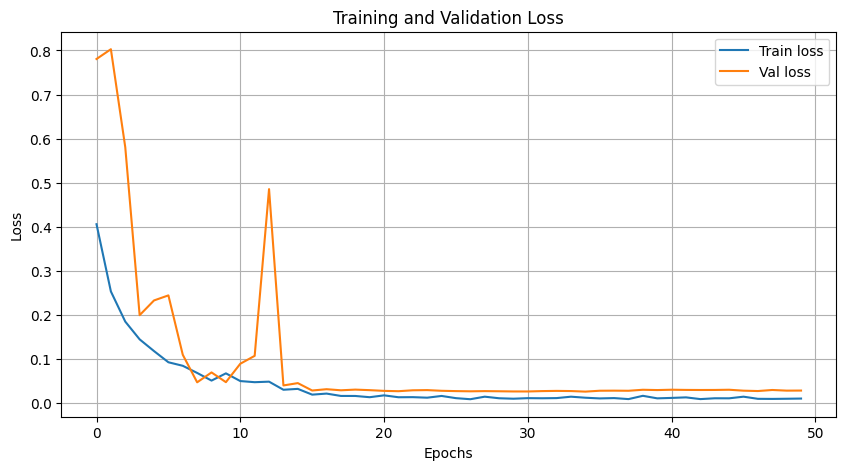

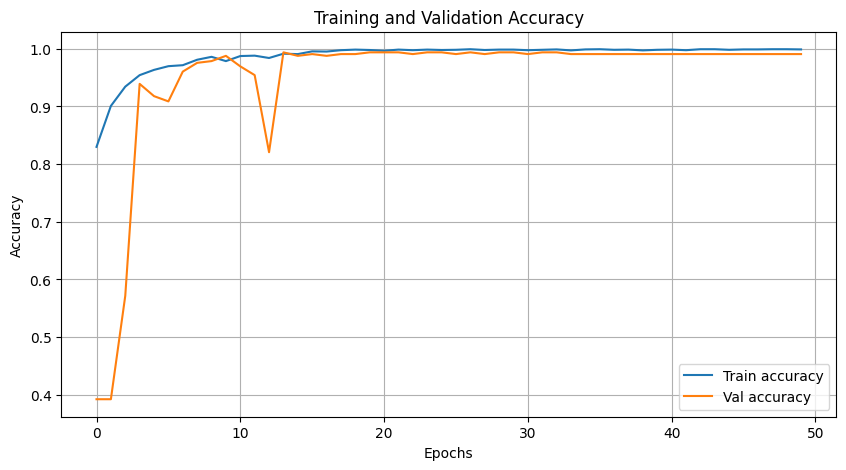

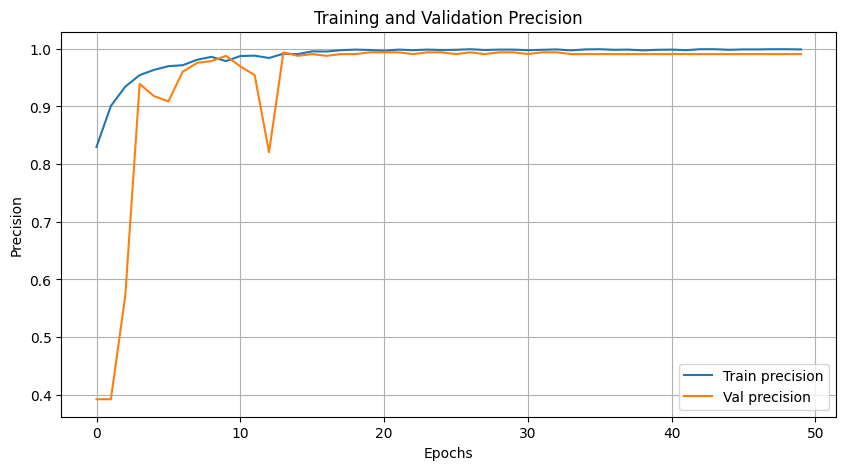

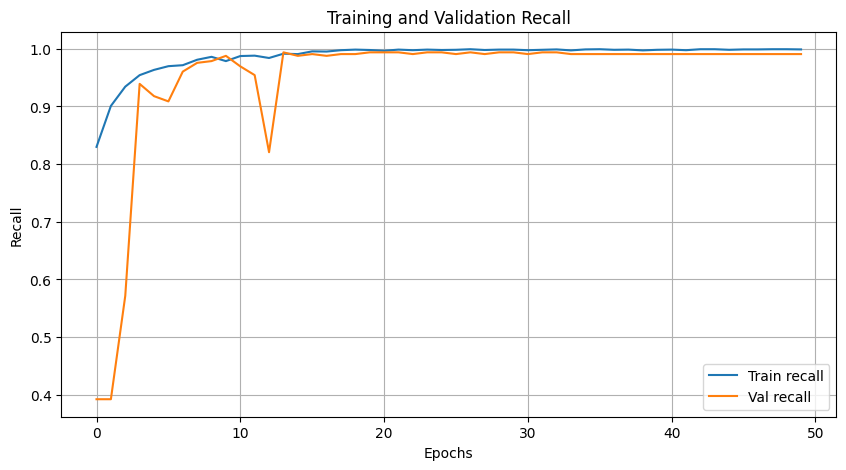

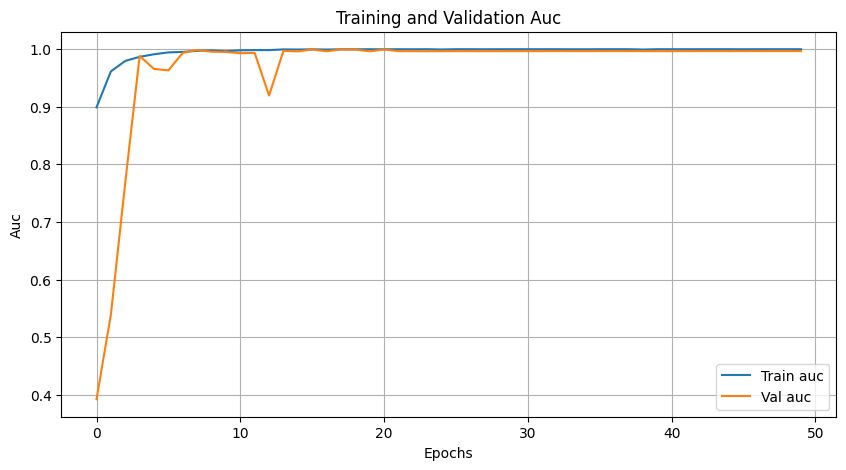

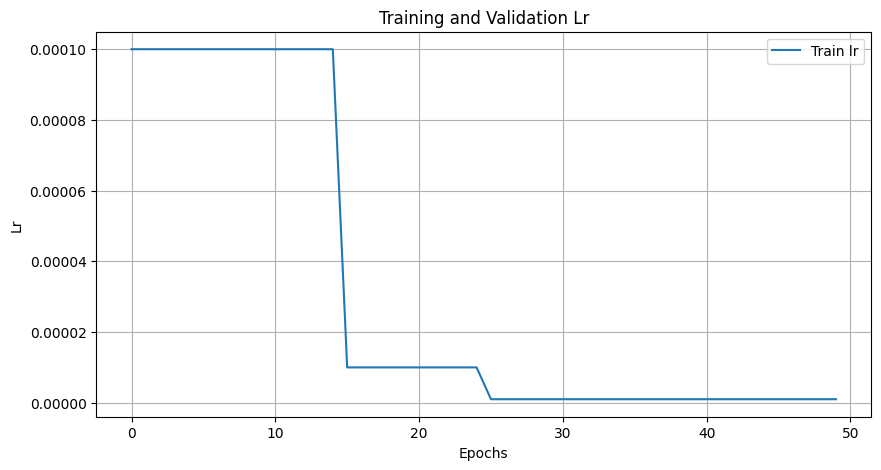

In [18]:
plot_training_history(history)

In [19]:
# Converter o histórico em DataFrame
history = pd.DataFrame(history.history)
# Salvar em CSV
history.to_csv('test_1_train_history.csv', index=False)

In [20]:
model.save('test_1.h5')

/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Avaliar

In [21]:
avaliar_modelo(model, test_ds)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=9469, TN=9709, FP=39, FN=315
Accuracy       : 0.9819
Precision      : 0.9959
Recall         : 0.9678
F1-Score       : 0.9817
AUC            : 0.9988
Binary Loss    : 0.0543
FDR (Fire Detection Rate)      : 96.78 %
EWR (Error Warning Rate)       : 1.81 %
Confusion Matrix:
[[9709   39]
 [ 315 9469]]


{'TP': 9469,
 'TN': 9709,
 'FP': 39,
 'FN': 315,
 'accuracy': 0.9818758959655949,
 'precision': 0.9958981909970551,
 'recall': 0.9678045789043336,
 'f1_score': 0.9816504250466515,
 'auc': 0.9987544879952732,
 'loss': 0.054265272323946144,
 'fdr': 96.78045789043335,
 'ewr': 1.8124104034405077,
 'confusion_matrix': array([[9709,   39],
        [ 315, 9469]])}

In [22]:
model_best = load_model('test_1_best.h5')

In [23]:
avaliar_modelo(model_best, test_ds)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=9370, TN=9710, FP=38, FN=414
Accuracy       : 0.9769
Precision      : 0.9960
Recall         : 0.9577
F1-Score       : 0.9764
AUC            : 0.9987
Binary Loss    : 0.0703
FDR (Fire Detection Rate)      : 95.77 %
EWR (Error Warning Rate)       : 2.31 %
Confusion Matrix:
[[9710   38]
 [ 414 9370]]


{'TP': 9370,
 'TN': 9710,
 'FP': 38,
 'FN': 414,
 'accuracy': 0.9768584886340365,
 'precision': 0.9959608843537415,
 'recall': 0.9576860179885527,
 'f1_score': 0.9764485202167569,
 'auc': 0.9986744665488545,
 'loss': 0.07031681921978168,
 'fdr': 95.76860179885527,
 'ewr': 2.314151136596355,
 'confusion_matrix': array([[9710,   38],
        [ 414, 9370]])}

## Testar no FLAME train

In [24]:
data = pd.read_csv("../Datasets/FLAME_train.csv")
image_paths_flame_train = data['image_path'].values
labels_flame_train = data['label_bi'].values

test_ds_flame_train = tf.data.Dataset.from_tensor_slices((image_paths_flame_train, labels_flame_train))
test_ds_flame_train = test_ds_flame_train.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_train, name="FLAME train")

📊 FLAME TRAIN -> Total de imagens: 39375
  Classe 0 (Sem fogo): 14357 imagens (36.46%)
  Classe 1 (Fogo): 25018 imagens (63.54%)
----------------------------------------


In [25]:
avaliar_modelo(model, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=24709, TN=14242, FP=115, FN=309
Accuracy       : 0.9892
Precision      : 0.9954
Recall         : 0.9876
F1-Score       : 0.9915
AUC            : 0.9989
Binary Loss    : 0.0428
FDR (Fire Detection Rate)      : 98.76 %
EWR (Error Warning Rate)       : 1.08 %
Confusion Matrix:
[[14242   115]
 [  309 24709]]


{'TP': 24709,
 'TN': 14242,
 'FP': 115,
 'FN': 309,
 'accuracy': 0.989231746031746,
 'precision': 0.9953673864002578,
 'recall': 0.987648892797186,
 'f1_score': 0.9914931182536816,
 'auc': 0.9989254584926198,
 'loss': 0.04276848252522635,
 'fdr': 98.7648892797186,
 'ewr': 1.076825396825397,
 'confusion_matrix': array([[14242,   115],
        [  309, 24709]])}

In [26]:
avaliar_modelo(model_best, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=24706, TN=14244, FP=113, FN=312
Accuracy       : 0.9892
Precision      : 0.9954
Recall         : 0.9875
F1-Score       : 0.9915
AUC            : 0.9989
Binary Loss    : 0.0435
FDR (Fire Detection Rate)      : 98.75 %
EWR (Error Warning Rate)       : 1.08 %
Confusion Matrix:
[[14244   113]
 [  312 24706]]


{'TP': 24706,
 'TN': 14244,
 'FP': 113,
 'FN': 312,
 'accuracy': 0.9892063492063492,
 'precision': 0.9954470365445828,
 'recall': 0.9875289791350228,
 'f1_score': 0.991472199369946,
 'auc': 0.9989478871444363,
 'loss': 0.04354011502073567,
 'fdr': 98.75289791350228,
 'ewr': 1.0793650793650795,
 'confusion_matrix': array([[14244,   113],
        [  312, 24706]])}

## Testar no FLAME test

In [27]:
data = pd.read_csv("../Datasets/FLAME_test.csv")
image_paths_flame_test = data['image_path'].values
labels_flame_test = data['label_bi'].values

test_ds_flame_test = tf.data.Dataset.from_tensor_slices((image_paths_flame_test, labels_flame_test))
test_ds_flame_test = test_ds_flame_test.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_test, name="FLAME test")

📊 FLAME TEST -> Total de imagens: 8617
  Classe 0 (Sem fogo): 3480 imagens (40.39%)
  Classe 1 (Fogo): 5137 imagens (59.61%)
----------------------------------------


In [28]:
avaliar_modelo(model, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=4822, TN=3272, FP=208, FN=315
Accuracy       : 0.9393
Precision      : 0.9586
Recall         : 0.9387
F1-Score       : 0.9486
AUC            : 0.9798
Binary Loss    : 0.2196
FDR (Fire Detection Rate)      : 93.87 %
EWR (Error Warning Rate)       : 6.07 %
Confusion Matrix:
[[3272  208]
 [ 315 4822]]


{'TP': 4822,
 'TN': 3272,
 'FP': 208,
 'FN': 315,
 'accuracy': 0.9393060229778345,
 'precision': 0.958648111332008,
 'recall': 0.938680163519564,
 'f1_score': 0.9485590636372578,
 'auc': 0.9797803405091304,
 'loss': 0.21956172289075654,
 'fdr': 93.8680163519564,
 'ewr': 6.069397702216548,
 'confusion_matrix': array([[3272,  208],
        [ 315, 4822]])}

In [29]:
avaliar_modelo(model_best, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=4788, TN=3283, FP=197, FN=349
Accuracy       : 0.9366
Precision      : 0.9605
Recall         : 0.9321
F1-Score       : 0.9461
AUC            : 0.9788
Binary Loss    : 0.2236
FDR (Fire Detection Rate)      : 93.21 %
EWR (Error Warning Rate)       : 6.34 %
Confusion Matrix:
[[3283  197]
 [ 349 4788]]


{'TP': 4788,
 'TN': 3283,
 'FP': 197,
 'FN': 349,
 'accuracy': 0.9366368805848904,
 'precision': 0.960481444332999,
 'recall': 0.932061514502628,
 'f1_score': 0.946058091286307,
 'auc': 0.9788157921234049,
 'loss': 0.2235773608973124,
 'fdr': 93.2061514502628,
 'ewr': 6.336311941510966,
 'confusion_matrix': array([[3283,  197],
        [ 349, 4788]])}

## Testar no UAVS Raw Images

In [30]:
data = pd.read_csv("../Datasets/UAVS_RawImages.csv")
image_paths_uavs_raw = data['image_path'].values
labels_uavs_raw = data['label_bi'].values

test_ds_uavs_raw = tf.data.Dataset.from_tensor_slices((image_paths_uavs_raw, labels_uavs_raw))
test_ds_uavs_raw = test_ds_uavs_raw.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_raw, name="UAVS Raw Images")

📊 UAVS RAW IMAGES -> Total de imagens: 1643
  Classe 0 (Sem fogo): 498 imagens (30.31%)
  Classe 1 (Fogo): 1145 imagens (69.69%)
----------------------------------------


In [31]:
avaliar_modelo(model, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=1145, TN=498, FP=0, FN=0
Accuracy       : 1.0000
Precision      : 1.0000
Recall         : 1.0000
F1-Score       : 1.0000
AUC            : 1.0000
Binary Loss    : 0.0015
FDR (Fire Detection Rate)      : 100.00 %
EWR (Error Warning Rate)       : 0.00 %
Confusion Matrix:
[[ 498    0]
 [   0 1145]]


{'TP': 1145,
 'TN': 498,
 'FP': 0,
 'FN': 0,
 'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1_score': 1.0,
 'auc': 1.0,
 'loss': 0.0014716847431802034,
 'fdr': 100.0,
 'ewr': 0.0,
 'confusion_matrix': array([[ 498,    0],
        [   0, 1145]])}

In [32]:
avaliar_modelo(model_best, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=1145, TN=498, FP=0, FN=0
Accuracy       : 1.0000
Precision      : 1.0000
Recall         : 1.0000
F1-Score       : 1.0000
AUC            : 1.0000
Binary Loss    : 0.0018
FDR (Fire Detection Rate)      : 100.00 %
EWR (Error Warning Rate)       : 0.00 %
Confusion Matrix:
[[ 498    0]
 [   0 1145]]


{'TP': 1145,
 'TN': 498,
 'FP': 0,
 'FN': 0,
 'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1_score': 1.0,
 'auc': 0.9999999999999999,
 'loss': 0.0018154325030394723,
 'fdr': 100.0,
 'ewr': 0.0,
 'confusion_matrix': array([[ 498,    0],
        [   0, 1145]])}

## Testar no UAVS Augmented Images

In [33]:
data = pd.read_csv("../Datasets/UAVS_AugmentedImages.csv")
image_paths_uavs_aug = data['image_path'].values
labels_uavs_aug = data['label_bi'].values

test_ds_uavs_aug = tf.data.Dataset.from_tensor_slices((image_paths_uavs_aug, labels_uavs_aug))
test_ds_uavs_aug = test_ds_uavs_aug.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_aug, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 15560
  Classe 0 (Sem fogo): 7780 imagens (50.00%)
  Classe 1 (Fogo): 7780 imagens (50.00%)
----------------------------------------


In [34]:
avaliar_modelo(model, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=7508, TN=7780, FP=0, FN=272
Accuracy       : 0.9825
Precision      : 1.0000
Recall         : 0.9650
F1-Score       : 0.9822
AUC            : 0.9999
Binary Loss    : 0.0468
FDR (Fire Detection Rate)      : 96.50 %
EWR (Error Warning Rate)       : 1.75 %
Confusion Matrix:
[[7780    0]
 [ 272 7508]]


{'TP': 7508,
 'TN': 7780,
 'FP': 0,
 'FN': 272,
 'accuracy': 0.9825192802056555,
 'precision': 1.0,
 'recall': 0.9650385604113111,
 'f1_score': 0.9822082679225537,
 'auc': 0.9999058293297031,
 'loss': 0.04681703884974768,
 'fdr': 96.50385604113112,
 'ewr': 1.7480719794344475,
 'confusion_matrix': array([[7780,    0],
        [ 272, 7508]])}

In [35]:
avaliar_modelo(model_best, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=7414, TN=7780, FP=0, FN=366
Accuracy       : 0.9765
Precision      : 1.0000
Recall         : 0.9530
F1-Score       : 0.9759
AUC            : 0.9999
Binary Loss    : 0.0672
FDR (Fire Detection Rate)      : 95.30 %
EWR (Error Warning Rate)       : 2.35 %
Confusion Matrix:
[[7780    0]
 [ 366 7414]]


{'TP': 7414,
 'TN': 7780,
 'FP': 0,
 'FN': 366,
 'accuracy': 0.9764781491002571,
 'precision': 1.0,
 'recall': 0.9529562982005141,
 'f1_score': 0.9759115440305384,
 'auc': 0.9998849135281951,
 'loss': 0.06720789923499904,
 'fdr': 95.2956298200514,
 'ewr': 2.352185089974293,
 'confusion_matrix': array([[7780,    0],
        [ 366, 7414]])}

## Testar no FireMan

In [36]:
data = pd.read_csv("../Datasets/FireMan_test.csv")
image_paths_fireman = data['image_path'].values
labels_fireman = data['label_bi'].values

test_ds_fireman = tf.data.Dataset.from_tensor_slices((image_paths_fireman, labels_fireman))
test_ds_fireman = test_ds_fireman.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_fireman, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 589
  Classe 0 (Sem fogo): 33 imagens (5.60%)
  Classe 1 (Fogo): 556 imagens (94.40%)
----------------------------------------


In [37]:
avaliar_modelo(model, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=0, TN=33, FP=0, FN=556
Accuracy       : 0.0560
Precision      : 0.0000
Recall         : 0.0000
F1-Score       : 0.0000
AUC            : 0.0073
Binary Loss    : 7.1404
FDR (Fire Detection Rate)      : 0.00 %
EWR (Error Warning Rate)       : 94.40 %
Confusion Matrix:
[[ 33   0]
 [556   0]]


{'TP': 0,
 'TN': 33,
 'FP': 0,
 'FN': 556,
 'accuracy': 0.05602716468590832,
 'precision': 0.0,
 'recall': 0.0,
 'f1_score': 0.0,
 'auc': 0.0073032483104425545,
 'loss': 7.140358890007141,
 'fdr': 0.0,
 'ewr': 94.39728353140917,
 'confusion_matrix': array([[ 33,   0],
        [556,   0]])}

In [38]:
avaliar_modelo(model_best, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=0, TN=33, FP=0, FN=556
Accuracy       : 0.0560
Precision      : 0.0000
Recall         : 0.0000
F1-Score       : 0.0000
AUC            : 0.0013
Binary Loss    : 7.1222
FDR (Fire Detection Rate)      : 0.00 %
EWR (Error Warning Rate)       : 94.40 %
Confusion Matrix:
[[ 33   0]
 [556   0]]


{'TP': 0,
 'TN': 33,
 'FP': 0,
 'FN': 556,
 'accuracy': 0.05602716468590832,
 'precision': 0.0,
 'recall': 0.0,
 'f1_score': 0.0,
 'auc': 0.0012535426204490954,
 'loss': 7.122239805540981,
 'fdr': 0.0,
 'ewr': 94.39728353140917,
 'confusion_matrix': array([[ 33,   0],
        [556,   0]])}